In [1]:
!python -m pip install --user flair --upgrade
!python -m pip install --user optuna==3.1.0

Requirement already up-to-date: flair in ./env/lib/python3.9/site-packages (0.12.2)


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from flair.data import Sentence
from flair.data import Corpus
from flair.trainers import ModelTrainer
from flair.models import TARSClassifier

import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna.trial import TrialState

from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score

In [26]:
### Configs:
random_state = 72
two_label = False
second_label_confidence = 0.75
three_label = False
third_label_confidence = 0.5
dev_ratio = 0.15
test_ratio = 0.20
multi_label = two_label or three_label

## Loading training data

In [29]:
train = pd.read_csv('new_splited_data/train_13classes.csv')
test = pd.read_csv('new_splited_data/test_13classes.csv')
dev = pd.read_csv('new_splited_data/dev_13classes.csv')

In [30]:
train['primary tag'].value_counts().index

Index(['informing statement', 'challenge', 'accusation', 'appreciation',
       'request', 'evaluation', 'rejection', 'question', 'acceptance',
       'proposal', 'denial', 'admission', 'apology'],
      dtype='object')

In [31]:
data = {'train': train, 'dev': dev, 'test':test}
train.shape, test.shape, dev.shape

((406, 5), (135, 5), (135, 5))

## Preparing data for Flair NLP

In [32]:
sentences = {}
for i, d in data.items():
    sentences[i] = list()
    for j, row in d.iterrows():
        sentences[i].append(Sentence(row['Text']).add_label('action', row['primary tag'], 1.0))
        if two_label and str(row['secondary tag']) != 'nan':
            sentences[i][-1].add_label('action', row['secondary tag'], second_label_confidence)
        if three_label and str(row['tertiary']) != 'nan':
            sentences[i][-1].add_label('action', row['tertiary'], third_label_confidence)


In [33]:
corpus = Corpus(**sentences)
corpus.obtain_statistics()

'{\n    "TRAIN": {\n        "dataset": "TRAIN",\n        "total_number_of_documents": 406,\n        "number_of_documents_per_class": {\n            "request": 29,\n            "evaluation": 28,\n            "acceptance": 20,\n            "informing statement": 89,\n            "accusation": 48,\n            "rejection": 26,\n            "question": 26,\n            "appreciation": 35,\n            "challenge": 61,\n            "denial": 13,\n            "proposal": 18,\n            "admission": 8,\n            "apology": 5\n        },\n        "number_of_tokens_per_tag": {},\n        "number_of_tokens": {\n            "total": 11507,\n            "min": 1,\n            "max": 566,\n            "avg": 28.342364532019705\n        }\n    },\n    "TEST": {\n        "dataset": "TEST",\n        "total_number_of_documents": 135,\n        "number_of_documents_per_class": {\n            "appreciation": 11,\n            "informing statement": 30,\n            "question": 9,\n            "accepta

In [34]:
corpus.make_label_dictionary(label_type='action')

2023-07-20 12:19:28,272 Computing label dictionary. Progress:


406it [00:00, 67593.67it/s]

2023-07-20 12:19:28,285 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)


## Training starts!

In [ ]:

config = {
    'learning_rate': 0.0008208788674713021,
 'max_epochs': 58,
 'mini_batch_size': 1,
      'mini_batch_chunk_size':4,  
}


In [54]:
import torch
torch.cuda.empty_cache()
tars = TARSClassifier.load('tars-base')
tars.add_and_switch_to_new_task("Dialogue_action",label_type='action', multi_label=multi_label, label_dictionary=corpus.make_label_dictionary(label_type='action'))
trainer = ModelTrainer(tars, corpus)
score = trainer.train(base_path='resources/taggers/action',
              train_with_dev=True,
                create_file_logs=True,
                create_loss_file=True,
                save_final_model=True,
                main_evaluation_metric = ("macro avg", "f1-score"),
               optimizer=torch.optim.SGD,
               **config,
              )


2023-07-20 15:58:20,485 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 15:58:20,594 Computing label dictionary. Progress:


406it [00:00, 68170.03it/s]

2023-07-20 15:58:20,606 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)
2023-07-20 15:58:20,634 ----------------------------------------------------------------------------------------------------
2023-07-20 15:58:20,637 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


2023-07-20 15:58:22,558 epoch 1 - iter 54/541 - loss 1.11239488 - time (sec): 1.90 - samples/sec: 85.48 - lr: 0.000821
2023-07-20 15:58:24,657 epoch 1 - iter 108/541 - loss 0.93188986 - time (sec): 3.99 - samples/sec: 81.11 - lr: 0.000821
2023-07-20 15:58:26,614 epoch 1 - iter 162/541 - loss 0.87165675 - time (sec): 5.95 - samples/sec: 81.66 - lr: 0.000821
2023-07-20 15:58:28,717 epoch 1 - iter 216/541 - loss 0.82399372 - time (sec): 8.05 - samples/sec: 80.45 - lr: 0.000821
2023-07-20 15:58:30,818 epoch 1 - iter 270/541 - loss 0.79382536 - time (sec): 10.16 - samples/sec: 79.76 - lr: 0.000821
2023-07-20 15:58:32,917 epoch 1 - iter 324/541 - loss 0.74311420 - time (sec): 12.25 - samples/sec: 79.32 - lr: 0.000821
2023-07-20 15:58:35,037 epoch 1 - iter 378/541 - loss 0.70994579 - time (sec): 14.37 - samples/sec: 78.89 - lr: 0.000821
2023-07-20 15:58:37,360 epoch 1 - iter 432/541 - loss 0.68837625 - time (sec): 16.70 - samples/sec: 77.62 - lr: 0.000821
2023-07-20 15:58:39,530 epoch 1 - ite

2023-07-20 16:00:02,820 epoch 6 - iter 216/541 - loss 0.50611708 - time (sec): 6.59 - samples/sec: 98.37 - lr: 0.000821
2023-07-20 16:00:04,534 epoch 6 - iter 270/541 - loss 0.52253845 - time (sec): 8.30 - samples/sec: 97.57 - lr: 0.000821
2023-07-20 16:00:06,250 epoch 6 - iter 324/541 - loss 0.51547594 - time (sec): 10.02 - samples/sec: 97.03 - lr: 0.000821
2023-07-20 16:00:07,941 epoch 6 - iter 378/541 - loss 0.51055622 - time (sec): 11.71 - samples/sec: 96.85 - lr: 0.000821
2023-07-20 16:00:09,569 epoch 6 - iter 432/541 - loss 0.53336158 - time (sec): 13.34 - samples/sec: 97.18 - lr: 0.000821
2023-07-20 16:00:11,039 epoch 6 - iter 486/541 - loss 0.53461315 - time (sec): 14.81 - samples/sec: 98.47 - lr: 0.000821
2023-07-20 16:00:12,471 epoch 6 - iter 540/541 - loss 0.53160339 - time (sec): 16.24 - samples/sec: 99.76 - lr: 0.000821
2023-07-20 16:00:12,501 ----------------------------------------------------------------------------------------------------
2023-07-20 16:00:12,503 EPOCH 

2023-07-20 16:01:34,578 epoch 11 - iter 378/541 - loss 0.49412579 - time (sec): 15.16 - samples/sec: 74.81 - lr: 0.000821
2023-07-20 16:01:36,686 epoch 11 - iter 432/541 - loss 0.48257355 - time (sec): 17.27 - samples/sec: 75.06 - lr: 0.000821
2023-07-20 16:01:38,811 epoch 11 - iter 486/541 - loss 0.47535318 - time (sec): 19.39 - samples/sec: 75.19 - lr: 0.000821
2023-07-20 16:01:40,947 epoch 11 - iter 540/541 - loss 0.47380150 - time (sec): 21.53 - samples/sec: 75.25 - lr: 0.000821
2023-07-20 16:01:40,982 ----------------------------------------------------------------------------------------------------
2023-07-20 16:01:40,985 EPOCH 11 done: loss 0.4729 - lr 0.000821
2023-07-20 16:01:40,987 BAD EPOCHS (no improvement): 0
2023-07-20 16:01:40,989 ----------------------------------------------------------------------------------------------------
2023-07-20 16:01:43,083 epoch 12 - iter 54/541 - loss 0.34213178 - time (sec): 2.09 - samples/sec: 77.42 - lr: 0.000821
2023-07-20 16:01:45,09

2023-07-20 16:03:20,585 epoch 16 - iter 540/541 - loss 0.41202765 - time (sec): 18.63 - samples/sec: 86.97 - lr: 0.000821
2023-07-20 16:03:20,615 ----------------------------------------------------------------------------------------------------
2023-07-20 16:03:20,618 EPOCH 16 done: loss 0.4137 - lr 0.000821
2023-07-20 16:03:20,620 BAD EPOCHS (no improvement): 0
2023-07-20 16:03:20,622 ----------------------------------------------------------------------------------------------------
2023-07-20 16:03:22,256 epoch 17 - iter 54/541 - loss 0.32327819 - time (sec): 1.63 - samples/sec: 99.25 - lr: 0.000821
2023-07-20 16:03:23,724 epoch 17 - iter 108/541 - loss 0.32898961 - time (sec): 3.10 - samples/sec: 104.51 - lr: 0.000821
2023-07-20 16:03:25,211 epoch 17 - iter 162/541 - loss 0.35533310 - time (sec): 4.59 - samples/sec: 105.96 - lr: 0.000821
2023-07-20 16:03:26,656 epoch 17 - iter 216/541 - loss 0.38883811 - time (sec): 6.03 - samples/sec: 107.42 - lr: 0.000821
2023-07-20 16:03:28,14

2023-07-20 16:04:43,297 BAD EPOCHS (no improvement): 2
2023-07-20 16:04:43,300 ----------------------------------------------------------------------------------------------------
2023-07-20 16:04:44,788 epoch 22 - iter 54/541 - loss 0.32162493 - time (sec): 1.49 - samples/sec: 109.01 - lr: 0.000821
2023-07-20 16:04:46,622 epoch 22 - iter 108/541 - loss 0.48326486 - time (sec): 3.32 - samples/sec: 97.60 - lr: 0.000821
2023-07-20 16:04:48,533 epoch 22 - iter 162/541 - loss 0.44515167 - time (sec): 5.23 - samples/sec: 92.90 - lr: 0.000821
2023-07-20 16:04:50,636 epoch 22 - iter 216/541 - loss 0.44948446 - time (sec): 7.33 - samples/sec: 88.36 - lr: 0.000821
2023-07-20 16:04:52,819 epoch 22 - iter 270/541 - loss 0.44386071 - time (sec): 9.52 - samples/sec: 85.11 - lr: 0.000821
2023-07-20 16:04:54,808 epoch 22 - iter 324/541 - loss 0.47347877 - time (sec): 11.51 - samples/sec: 84.47 - lr: 0.000821
2023-07-20 16:04:57,060 epoch 22 - iter 378/541 - loss 0.47032103 - time (sec): 13.76 - sampl

2023-07-20 16:06:28,549 epoch 27 - iter 108/541 - loss 0.35207910 - time (sec): 4.11 - samples/sec: 78.87 - lr: 0.000410
2023-07-20 16:06:30,791 epoch 27 - iter 162/541 - loss 0.33636307 - time (sec): 6.35 - samples/sec: 76.53 - lr: 0.000410
2023-07-20 16:06:32,899 epoch 27 - iter 216/541 - loss 0.43335554 - time (sec): 8.46 - samples/sec: 76.61 - lr: 0.000410
2023-07-20 16:06:34,999 epoch 27 - iter 270/541 - loss 0.43151397 - time (sec): 10.56 - samples/sec: 76.71 - lr: 0.000410
2023-07-20 16:06:37,281 epoch 27 - iter 324/541 - loss 0.44756016 - time (sec): 12.84 - samples/sec: 75.70 - lr: 0.000410
2023-07-20 16:06:39,357 epoch 27 - iter 378/541 - loss 0.42969282 - time (sec): 14.92 - samples/sec: 76.02 - lr: 0.000410
2023-07-20 16:06:41,819 epoch 27 - iter 432/541 - loss 0.42216539 - time (sec): 17.38 - samples/sec: 74.58 - lr: 0.000410
2023-07-20 16:06:43,830 epoch 27 - iter 486/541 - loss 0.42350063 - time (sec): 19.39 - samples/sec: 75.20 - lr: 0.000410
2023-07-20 16:06:45,834 epo

2023-07-20 16:07:56,732 epoch 32 - iter 216/541 - loss 0.34102077 - time (sec): 6.28 - samples/sec: 103.17 - lr: 0.000205
2023-07-20 16:07:58,351 epoch 32 - iter 270/541 - loss 0.34076510 - time (sec): 7.90 - samples/sec: 102.53 - lr: 0.000205
2023-07-20 16:07:59,973 epoch 32 - iter 324/541 - loss 0.32378435 - time (sec): 9.52 - samples/sec: 102.08 - lr: 0.000205
2023-07-20 16:08:01,635 epoch 32 - iter 378/541 - loss 0.31839831 - time (sec): 11.18 - samples/sec: 101.39 - lr: 0.000205
2023-07-20 16:08:03,285 epoch 32 - iter 432/541 - loss 0.30899483 - time (sec): 12.83 - samples/sec: 100.98 - lr: 0.000205
2023-07-20 16:08:05,080 epoch 32 - iter 486/541 - loss 0.31453510 - time (sec): 14.63 - samples/sec: 99.67 - lr: 0.000205
2023-07-20 16:08:06,643 epoch 32 - iter 540/541 - loss 0.32512546 - time (sec): 16.19 - samples/sec: 100.05 - lr: 0.000205
2023-07-20 16:08:06,672 ----------------------------------------------------------------------------------------------------
2023-07-20 16:08:0

2023-07-20 16:09:40,796 epoch 37 - iter 324/541 - loss 0.27833981 - time (sec): 12.94 - samples/sec: 75.12 - lr: 0.000103
2023-07-20 16:09:42,797 epoch 37 - iter 378/541 - loss 0.27441067 - time (sec): 14.94 - samples/sec: 75.90 - lr: 0.000103
2023-07-20 16:09:44,855 epoch 37 - iter 432/541 - loss 0.28674364 - time (sec): 17.00 - samples/sec: 76.24 - lr: 0.000103
2023-07-20 16:09:46,990 epoch 37 - iter 486/541 - loss 0.28898036 - time (sec): 19.13 - samples/sec: 76.20 - lr: 0.000103
2023-07-20 16:09:49,104 epoch 37 - iter 540/541 - loss 0.28863856 - time (sec): 21.25 - samples/sec: 76.25 - lr: 0.000103
2023-07-20 16:09:49,146 ----------------------------------------------------------------------------------------------------
2023-07-20 16:09:49,149 EPOCH 37 done: loss 0.2881 - lr 0.000103
2023-07-20 16:09:49,151 BAD EPOCHS (no improvement): 0
2023-07-20 16:09:49,153 ----------------------------------------------------------------------------------------------------
2023-07-20 16:09:51,

100%|██████████| 135/135 [00:13<00:00,  9.85it/s]

2023-07-20 16:11:15,282 Evaluating as a multi-label problem: False


2023-07-20 16:11:15,292 0.4815	0.4815	0.4815	0.4815
2023-07-20 16:11:15,294 
Results:
- F-score (micro) 0.4815
- F-score (macro) 0.4271
- Accuracy 0.4815

By class:
                     precision    recall  f1-score   support

informing statement     0.3958    0.7917    0.5278        24
          rejection     1.0000    0.2258    0.3684        31
           question     1.0000    0.4583    0.6286        24
          challenge     0.4118    0.4667    0.4375        15
       appreciation     0.9167    0.6875    0.7857        16
         accusation     0.0870    0.6667    0.1538         3
            request     0.2857    0.6667    0.4000         3
         evaluation     0.5000    0.1667    0.2500         6
         acceptance     1.0000    1.0000    1.0000         3
           proposal     0.0000    0.0000    0.0000         4
             denial     0.0000    0.0000    0.0000         3
            apology     1.0000    1.0000    1.0000         2
          admission     0.0000    0.0000 

In [55]:
# tars = TARSClassifier.load('resources/taggers/action/final-model.pt') , 

In [56]:
sentence = Sentence("i loved the spiderman movie!")

tars.predict(sentence)
print(sentence)

sentence = Sentence("pineapple on pizza is the worst 🤮")

tars.predict(sentence)
print(sentence)

Sentence[6]: "i loved the spiderman movie!" → appreciation (0.9994)
Sentence[7]: "pineapple on pizza is the worst 🤮" → evaluation (0.9943)


In [57]:
tars.predict(sentences['test'], return_probabilities_for_all_classes=True, label_threshold=10**-7, multi_label=multi_label)


## Evaluation starts!

In [58]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

labels = classes = ['informing statement',
 'challenge',
 'accusation',
 'rejection',
 'appreciation',
 'request',
 'question',
 'evaluation', #
 'proposal', #
 'acceptance',
 'denial', #
 'admission', #
 'apology']



In [59]:
def get_multi_label_pred(sentences):
    ses = set()
    output = []
    for sentence in sentences:
        if sentence not in ses:
            ses.add(sentence)
        else:
            continue
            
        preds = []
        scores = []
        for i in sentence.labels:
            if i.score>=0.01:
                preds.append(i.value)
                scores.append(i.score)
        output.append(preds[:len(preds)//2])
    output = [[1 if j in i else 0 for j in labels] for i in output]
    return output
    
def get_multi_label_true(data):
    output = []
    for i, row in data.iterrows():
        row_labels = []
        row_labels.append(row['primary tag'])
        if str(row['secondary tag']) != 'nan':
            row_labels.append(row['secondary tag'])
        if str(row['tertiary']) != 'nan':
            row_labels.append(row['tertiary'])
        output.append(row_labels)
    output = [[1 if j in o else 0 for j in labels] for o in output]
    return output

if multi_label:
    y_pred = get_multi_label_pred(sentences['test'])
    y_true = get_multi_label_true(test)
    print(len(y_pred), len(y_true))


In [60]:
def get_score(sentences):
    scores = np.array([i.score for i in sentences])
    idx = np.argsort(scores)
    scores = scores[idx][::-1]
    return scores

def get_label(sentences):
    scores = np.array([i.score for i in sentences])
    labels = np.array([i.value for i in sentences])
    idx = np.argsort(scores)
    labels = labels[idx][::-1]
    return labels
    
if not multi_label:
    y_pred = np.array([get_label(i.labels)[0] for i in sentences['test']])
    y_scores = np.array([get_score(i.labels)[0] for i in sentences['test']])
    y_true = test['primary tag'].apply(lambda x: labels.index(x)).values
    y_pred = np.array([labels.index(i) for i in y_pred])


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)
    


#### Confusion Matrix

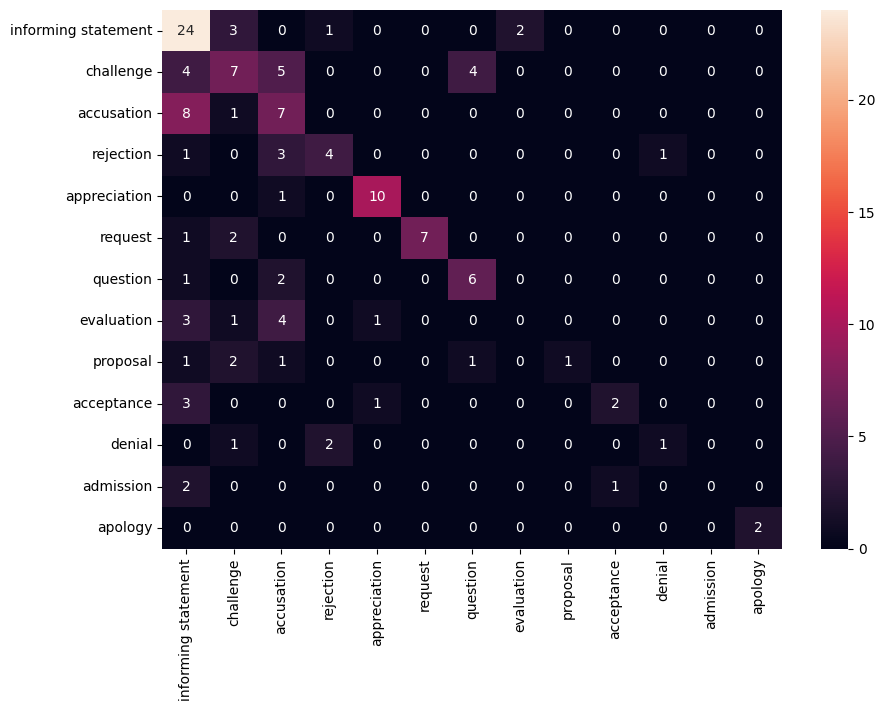

In [62]:

if not multi_label:

    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = labels, columns = labels)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True)
else:
    cm = multilabel_confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(5, 3, figsize=(12, 12))
    
    for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

    fig.tight_layout()
    plt.show()   

In [63]:

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))


                     precision    recall  f1-score   support

informing statement       0.50      0.80      0.62        30
          challenge       0.41      0.35      0.38        20
         accusation       0.30      0.44      0.36        16
          rejection       0.57      0.44      0.50         9
       appreciation       0.83      0.91      0.87        11
            request       1.00      0.70      0.82        10
           question       0.55      0.67      0.60         9
         evaluation       0.00      0.00      0.00         9
           proposal       1.00      0.17      0.29         6
         acceptance       0.67      0.33      0.44         6
             denial       0.50      0.25      0.33         4
          admission       0.00      0.00      0.00         3
            apology       1.00      1.00      1.00         2

           accuracy                           0.53       135
          macro avg       0.56      0.47      0.48       135
       weighted avg   

In [64]:
micro_f1_score = f1_score(y_true, y_pred, average='micro')
print('f1-score micro', f1_score(y_true, y_pred, average='micro'))

macro_f1_score = f1_score(y_true, y_pred, average='macro')
print('f1-score macro', macro_f1_score)

weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
print('f1-score weighted', weighted_f1_score)

if not multi_label:
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    print('balanced accuracy ', balanced_accuracy)
else:
    accuracy = accuracy_score(y_true, y_pred)
    print('accuracy ', accuracy)

f1-score micro 0.5259259259259259
f1-score macro 0.47764031118349437
f1-score weighted 0.4976851333032066
balanced accuracy  0.4659770784770784


informing statement


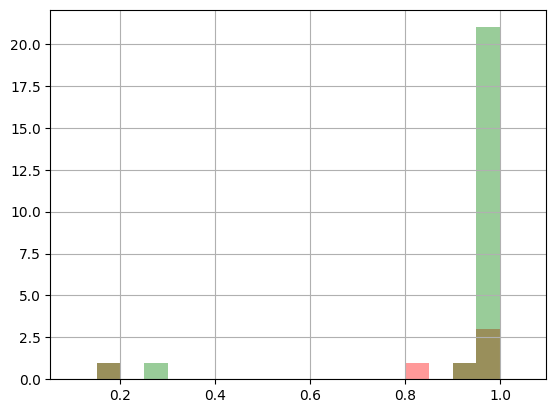

challenge


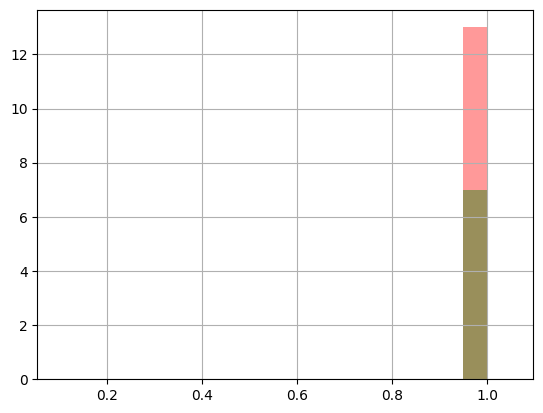

accusation


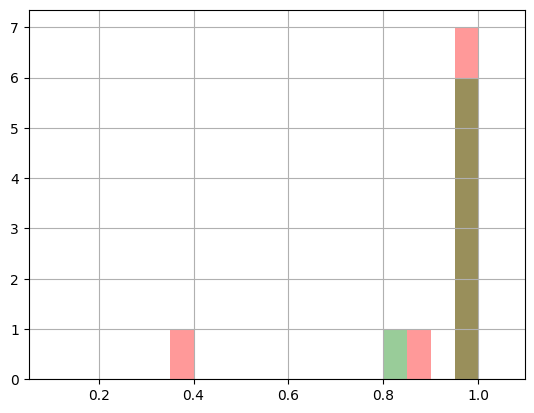

rejection


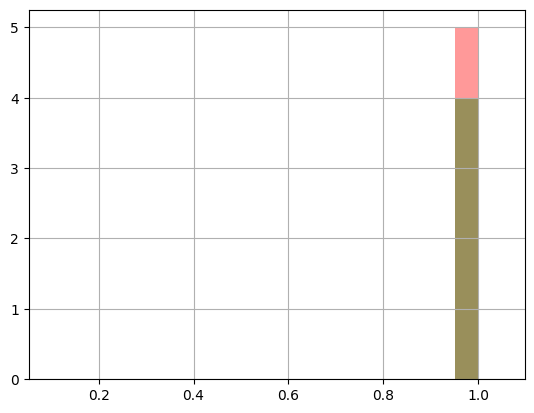

appreciation


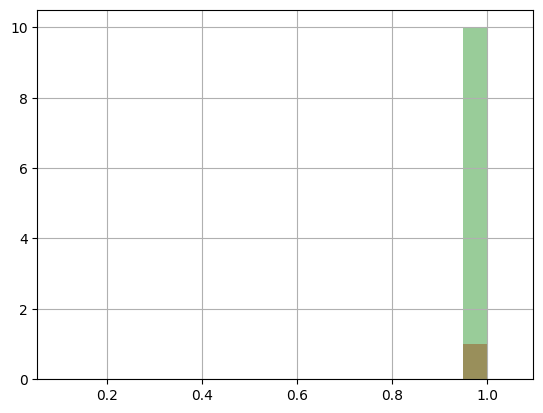

request


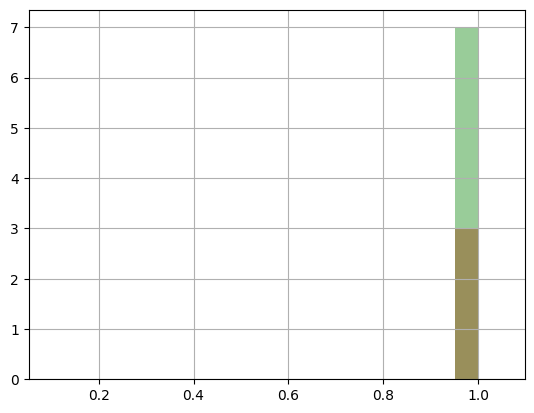

question


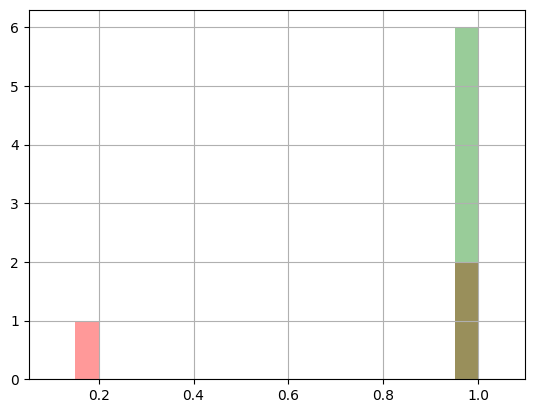

evaluation


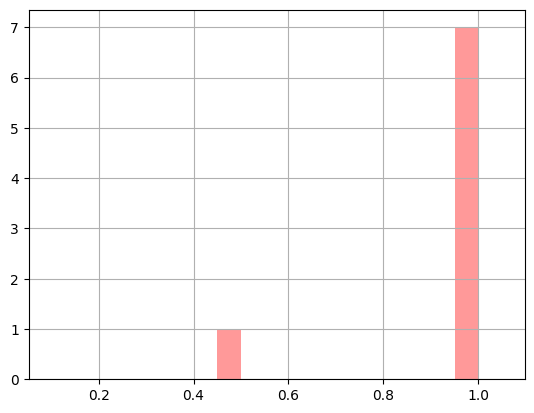

proposal


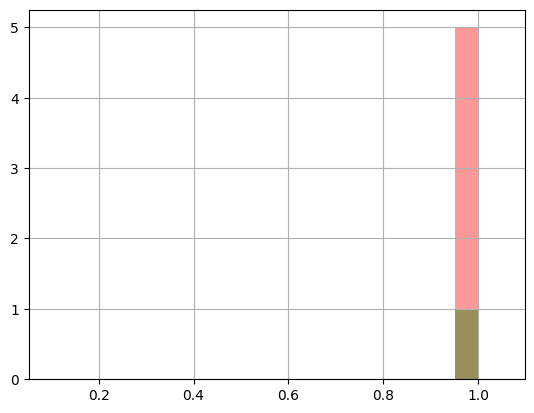

acceptance


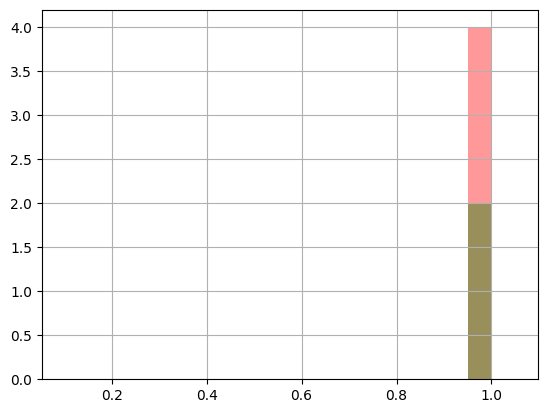

denial


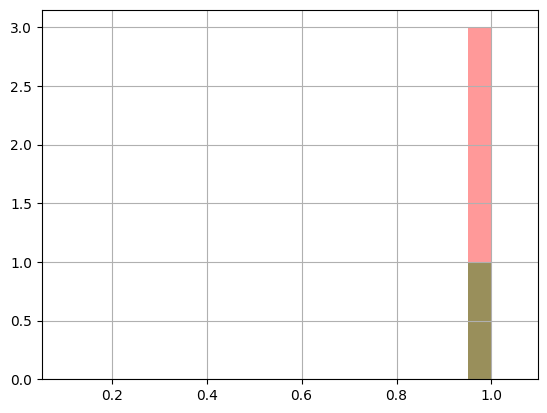

admission


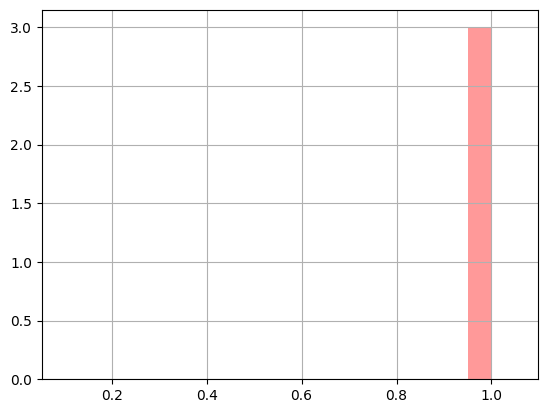

apology


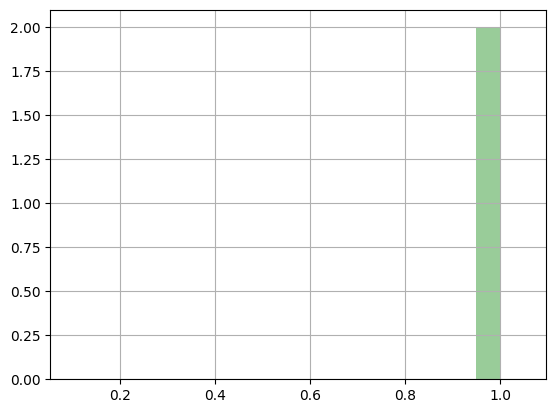

In [65]:

test['y_pred'] = y_pred
test['y_scores'] = y_scores
test['y_true'] = y_true

for i, label in enumerate(labels):
    print(label)
    t = test[test['y_true'] == i]
    t = t.sort_values(by=['y_scores'], ascending=True)
    t['y_scores'] = t['y_scores'].apply(lambda x: np.round(x, 3))
    
    r = t[t['y_pred']!=i]
    g = t[t['y_pred']==i]
    
    plt.figure()
    r.y_scores.hist(color=['red'], alpha=0.4, bins=list(np.arange(0.1,1.1, 0.05)))
    g.y_scores.hist(color=['green'], alpha=0.4, bins=list(np.arange(0.1,1.1, 0.05)))
    plt.show()
    

2023-07-20 16:11:33,077 ----------------------------------------------------------------------------------------------------
2023-07-20 16:11:33,079 WARNING: No LOSS found for test split in this data.
2023-07-20 16:11:33,081 Are you sure you want to plot LOSS and not another value?
2023-07-20 16:11:33,082 ----------------------------------------------------------------------------------------------------
2023-07-20 16:11:33,103 ----------------------------------------------------------------------------------------------------
2023-07-20 16:11:33,105 WARNING: No F1 found for test split in this data.
2023-07-20 16:11:33,106 Are you sure you want to plot F1 and not another value?
2023-07-20 16:11:33,108 ----------------------------------------------------------------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-07-20 16:11:33,891 Loss and F1 plots are saved in resources/taggers/action/training.png


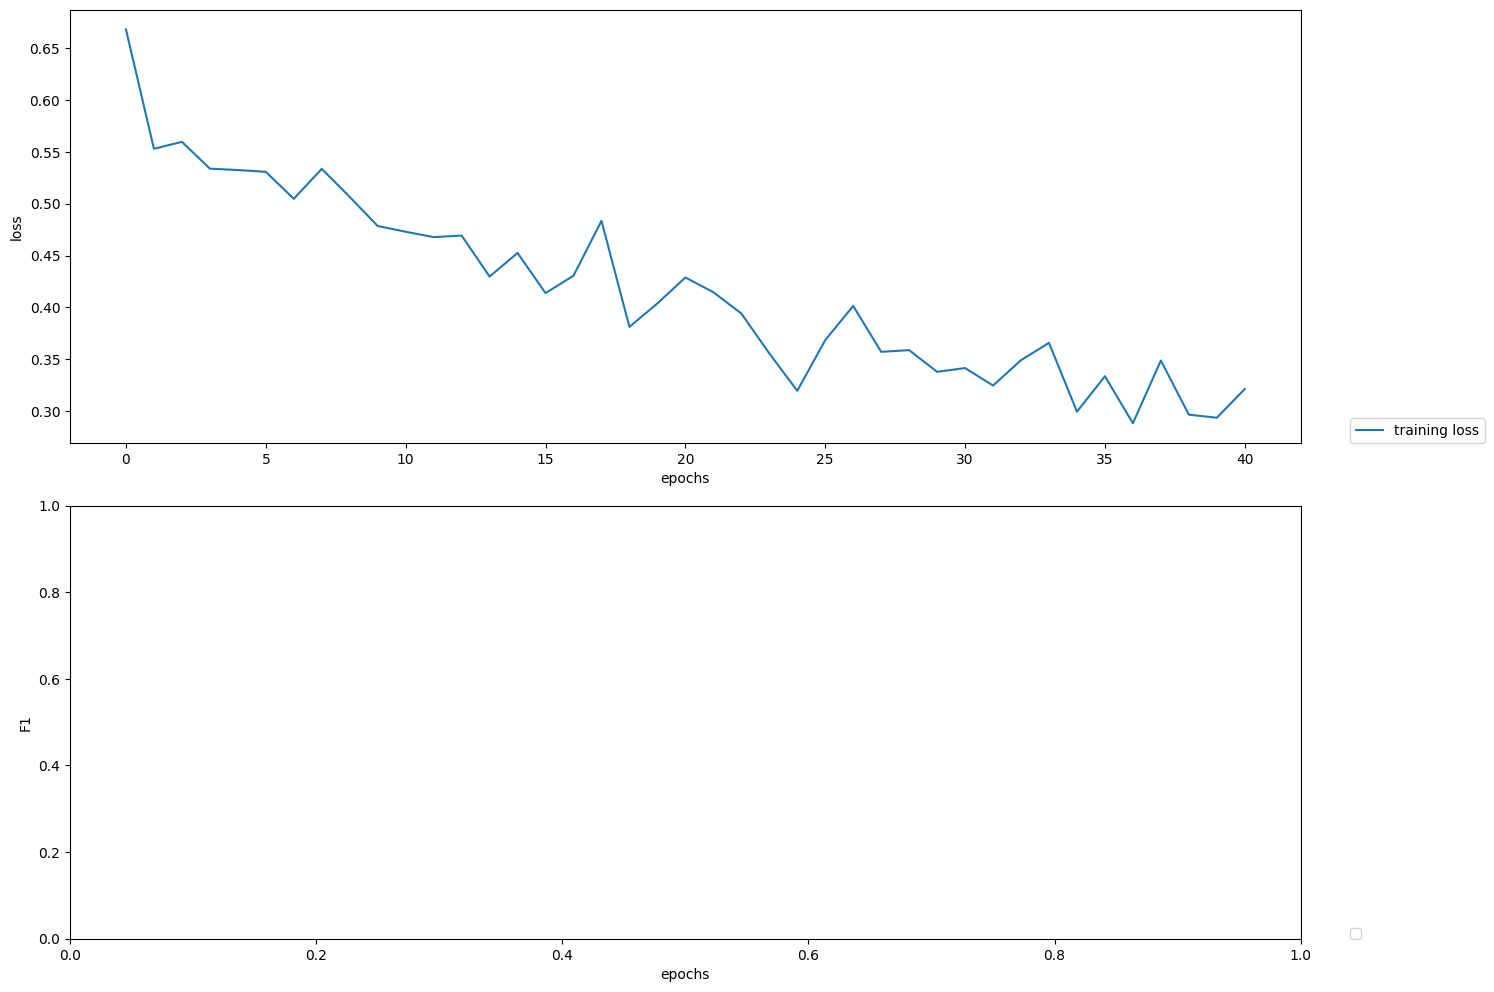

In [66]:
# visualize
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves('resources/taggers/action/loss.tsv')
# plotter.plot_weights('resources/taggers/action/weights.txt')

## Finding the  best learning rate

In [ ]:
trainer = ModelTrainer(tars, corpus)
trainer.find_learning_rate(base_path='resources/taggers/action3',
              optimizer=torch.optim.SGD,
              mini_batch_size=10,
              )

## Experiment on Required Training set Size

In [33]:
volumes = np.arange(0.2, 1.2, 0.2)
volumes

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [34]:
metrics = []
for i in volumes:
    
    new_data = {'train': train.sample(frac = i), 'dev': dev.sample(frac = i), 'test':test}
    
    new_sentences = {}
    for i, d in new_data.items():
        new_sentences[i] = list()
        for j, row in d.iterrows():
            new_sentences[i].append(Sentence(row['Text']).add_label('action', row['primary tag'], 1.0))
            if two_label and str(row['secondary tag']) != 'nan':
                new_sentences[i].append(Sentence(row['Text']).add_label('action', row['secondary tag'], second_label_confidence))
            if three_label and str(row['tertiary']) != 'nan':
                new_sentences[i].append(Sentence(row['Text']).add_label('action', row['tertiary'], third_label_confidence))

    corpus = Corpus(**sentences)
    print('bookmark', len(new_sentences['train']), len(new_sentences['test']))
    torch.cuda.empty_cache()
    
    tars = TARSClassifier.load('tars-base')
    tars.add_and_switch_to_new_task("Dialogue_action",label_type='action', multi_label=multi_label, label_dictionary=corpus.make_label_dictionary(label_type='action'))
    trainer = ModelTrainer(tars, corpus)
    score = trainer.train(base_path='resources/taggers/action',
                  train_with_dev=True,
                    create_file_logs=True,
                    create_loss_file=True,
                    save_final_model=True,
                    main_evaluation_metric = ("macro avg", "f1-score"),
                   optimizer=torch.optim.SGD,
                   **config,
                  )
    
    y_pred = np.array([get_label(i.labels)[0] for i in sentences['test']])
    y_scores = np.array([get_score(i.labels)[0] for i in sentences['test']])
    y_true = test['primary tag'].apply(lambda x: labels.index(x)).values
    y_pred = np.array([labels.index(i) for i in y_pred])
    
    metrics.append(f1_score(y_true, y_pred, average='weighted'))

bookmark 139 229


KeyboardInterrupt: 

In [35]:
metrics

[]

## Finding the best hyperparameters

In [49]:

def objective(trial):
    params = {
        'max_epochs': trial.suggest_int('max_epochs', 10, 100),
        'learning_rate': trial.suggest_float("learning_rate", 1e-6, 1e-1, log=True),
        'mini_batch_size': trial.suggest_int('mini_batch_size', 1, 8),
      'mini_batch_chunk_size':3,  
    }
    
#     if trial.params['optimizer'] == torch.optim.SGD:
#         scheduler = AnnealOnPlateau
#     else:
#         scheduler = LinearSchedulerWithWarmup
    
    
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    tars = TARSClassifier.load('tars-base')
    tars.add_and_switch_to_new_task('actions ' + str(trial.number), label_type='action', multi_label=multi_label, label_dictionary=corpus.make_label_dictionary(label_type='action'))
    trainer = ModelTrainer(tars, corpus)
    score = trainer.train(base_path='resources/taggers/'+str(trial.number),
                  learning_rate=params['learning_rate'],
                  mini_batch_size=params['mini_batch_size'],
                  max_epochs=params['max_epochs'],
                  optimizer=torch.optim.SGD,
                  param_selection_mode=True,
                    save_final_model=False,
                          
                  )
    
    tars.predict(sentences['test'], return_probabilities_for_all_classes=True, label_threshold=10**-7, multi_label=multi_label)

    
    return score['test_score']

In [50]:

study = optuna.create_study(study_name='new runs 2023 - 13 classes - single label',
                                    sampler=TPESampler(),
                                    direction="maximize",
                                    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=3),
                                    storage='sqlite:///optuna.db',
                                    load_if_exists=True,
                                    )
study.optimize(objective, n_trials=15)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print(' Number: ', trial.number)
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-20 12:25:31,590] A new study created in RDB with name: new runs 2023 - 13 classes - single label


  Params: 
    max_epochs: 53
    learning_rate: 3.285686789444084e-05
    mini_batch_size: 2
2023-07-20 12:25:39,128 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 12:25:39,234 Computing label dictionary. Progress:


406it [00:00, 69310.41it/s]

2023-07-20 12:25:39,245 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)
2023-07-20 12:25:39,252 ----------------------------------------------------------------------------------------------------
2023-07-20 12:25:39,255 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


2023-07-20 12:25:40,103 epoch 1 - iter 20/203 - loss 1.20168886 - time (sec): 0.82 - samples/sec: 147.01 - lr: 0.000033
2023-07-20 12:25:40,667 epoch 1 - iter 40/203 - loss 1.20117057 - time (sec): 1.38 - samples/sec: 173.87 - lr: 0.000033
2023-07-20 12:25:41,486 epoch 1 - iter 60/203 - loss 1.18980338 - time (sec): 2.20 - samples/sec: 163.66 - lr: 0.000033
2023-07-20 12:25:42,100 epoch 1 - iter 80/203 - loss 1.24694273 - time (sec): 2.81 - samples/sec: 170.57 - lr: 0.000033
2023-07-20 12:25:42,827 epoch 1 - iter 100/203 - loss 1.27698125 - time (sec): 3.54 - samples/sec: 169.48 - lr: 0.000033
2023-07-20 12:25:43,422 epoch 1 - iter 120/203 - loss 1.25987112 - time (sec): 4.14 - samples/sec: 174.10 - lr: 0.000033
2023-07-20 12:25:44,017 epoch 1 - iter 140/203 - loss 1.27452893 - time (sec): 4.73 - samples/sec: 177.58 - lr: 0.000033
2023-07-20 12:25:44,666 epoch 1 - iter 160/203 - loss 1.27984806 - time (sec): 5.38 - samples/sec: 178.45 - lr: 0.000033
2023-07-20 12:25:45,351 epoch 1 - it

100%|██████████| 68/68 [00:14<00:00,  4.85it/s]

2023-07-20 12:26:00,179 Evaluating as a multi-label problem: False
2023-07-20 12:26:00,189 DEV : loss 0.3485315442085266 - f1-score (micro avg)  0.2444
2023-07-20 12:26:00,193 BAD EPOCHS (no improvement): 0
2023-07-20 12:26:00,196 ----------------------------------------------------------------------------------------------------


2023-07-20 12:26:00,959 epoch 2 - iter 20/203 - loss 1.20190015 - time (sec): 0.76 - samples/sec: 157.42 - lr: 0.000033
2023-07-20 12:26:01,528 epoch 2 - iter 40/203 - loss 1.08874613 - time (sec): 1.33 - samples/sec: 180.39 - lr: 0.000033
2023-07-20 12:26:02,178 epoch 2 - iter 60/203 - loss 1.12391040 - time (sec): 1.98 - samples/sec: 181.78 - lr: 0.000033
2023-07-20 12:26:02,818 epoch 2 - iter 80/203 - loss 1.17749297 - time (sec): 2.62 - samples/sec: 183.12 - lr: 0.000033
2023-07-20 12:26:03,638 epoch 2 - iter 100/203 - loss 1.17400424 - time (sec): 3.44 - samples/sec: 174.39 - lr: 0.000033
2023-07-20 12:26:04,434 epoch 2 - iter 120/203 - loss 1.19340226 - time (sec): 4.24 - samples/sec: 169.92 - lr: 0.000033
2023-07-20 12:26:05,114 epoch 2 - iter 140/203 - loss 1.19224058 - time (sec): 4.92 - samples/sec: 170.85 - lr: 0.000033
2023-07-20 12:26:05,669 epoch 2 - iter 160/203 - loss 1.17780204 - time (sec): 5.47 - samples/sec: 175.45 - lr: 0.000033
2023-07-20 12:26:06,642 epoch 2 - it

100%|██████████| 68/68 [00:13<00:00,  4.86it/s]

2023-07-20 12:26:21,363 Evaluating as a multi-label problem: False
2023-07-20 12:26:21,373 DEV : loss 0.33431634306907654 - f1-score (micro avg)  0.2444
2023-07-20 12:26:21,378 BAD EPOCHS (no improvement): 0
2023-07-20 12:26:21,380 ----------------------------------------------------------------------------------------------------


2023-07-20 12:26:22,107 epoch 3 - iter 20/203 - loss 1.14506871 - time (sec): 0.73 - samples/sec: 165.47 - lr: 0.000033
2023-07-20 12:26:23,131 epoch 3 - iter 40/203 - loss 1.15560289 - time (sec): 1.75 - samples/sec: 137.18 - lr: 0.000033
2023-07-20 12:26:23,716 epoch 3 - iter 60/203 - loss 1.09225215 - time (sec): 2.33 - samples/sec: 154.25 - lr: 0.000033
2023-07-20 12:26:24,534 epoch 3 - iter 80/203 - loss 1.08252712 - time (sec): 3.15 - samples/sec: 152.28 - lr: 0.000033
2023-07-20 12:26:25,239 epoch 3 - iter 100/203 - loss 1.09495571 - time (sec): 3.86 - samples/sec: 155.54 - lr: 0.000033
2023-07-20 12:26:25,829 epoch 3 - iter 120/203 - loss 1.07316284 - time (sec): 4.45 - samples/sec: 161.90 - lr: 0.000033
2023-07-20 12:26:26,456 epoch 3 - iter 140/203 - loss 1.05453934 - time (sec): 5.07 - samples/sec: 165.53 - lr: 0.000033
2023-07-20 12:26:27,072 epoch 3 - iter 160/203 - loss 1.03339158 - time (sec): 5.69 - samples/sec: 168.70 - lr: 0.000033
2023-07-20 12:26:27,799 epoch 3 - it

100%|██████████| 68/68 [00:13<00:00,  4.87it/s]

2023-07-20 12:26:42,551 Evaluating as a multi-label problem: False
2023-07-20 12:26:42,562 DEV : loss 0.3239504396915436 - f1-score (micro avg)  0.2593
2023-07-20 12:26:42,567 BAD EPOCHS (no improvement): 0
2023-07-20 12:26:42,569 ----------------------------------------------------------------------------------------------------


2023-07-20 12:26:43,331 epoch 4 - iter 20/203 - loss 0.99199874 - time (sec): 0.76 - samples/sec: 157.87 - lr: 0.000033
2023-07-20 12:26:43,942 epoch 4 - iter 40/203 - loss 1.00149647 - time (sec): 1.37 - samples/sec: 175.02 - lr: 0.000033
2023-07-20 12:26:44,592 epoch 4 - iter 60/203 - loss 1.00503674 - time (sec): 2.02 - samples/sec: 178.07 - lr: 0.000033
2023-07-20 12:26:45,264 epoch 4 - iter 80/203 - loss 1.00933656 - time (sec): 2.69 - samples/sec: 178.21 - lr: 0.000033
2023-07-20 12:26:45,884 epoch 4 - iter 100/203 - loss 1.04655544 - time (sec): 3.31 - samples/sec: 181.09 - lr: 0.000033
2023-07-20 12:26:46,653 epoch 4 - iter 120/203 - loss 1.01571743 - time (sec): 4.08 - samples/sec: 176.37 - lr: 0.000033
2023-07-20 12:26:47,247 epoch 4 - iter 140/203 - loss 0.99595148 - time (sec): 4.68 - samples/sec: 179.65 - lr: 0.000033
2023-07-20 12:26:48,049 epoch 4 - iter 160/203 - loss 1.00881834 - time (sec): 5.48 - samples/sec: 175.24 - lr: 0.000033
2023-07-20 12:26:49,130 epoch 4 - it

100%|██████████| 68/68 [00:14<00:00,  4.84it/s]

2023-07-20 12:27:03,823 Evaluating as a multi-label problem: False
2023-07-20 12:27:03,833 DEV : loss 0.3166379928588867 - f1-score (micro avg)  0.2667
2023-07-20 12:27:03,838 BAD EPOCHS (no improvement): 0
2023-07-20 12:27:03,840 ----------------------------------------------------------------------------------------------------


2023-07-20 12:27:04,613 epoch 5 - iter 20/203 - loss 0.92075651 - time (sec): 0.77 - samples/sec: 155.45 - lr: 0.000033
2023-07-20 12:27:05,222 epoch 5 - iter 40/203 - loss 0.89015042 - time (sec): 1.38 - samples/sec: 173.82 - lr: 0.000033
2023-07-20 12:27:05,867 epoch 5 - iter 60/203 - loss 0.89144475 - time (sec): 2.03 - samples/sec: 177.72 - lr: 0.000033
2023-07-20 12:27:06,686 epoch 5 - iter 80/203 - loss 0.96712480 - time (sec): 2.84 - samples/sec: 168.75 - lr: 0.000033
2023-07-20 12:27:07,343 epoch 5 - iter 100/203 - loss 0.97673128 - time (sec): 3.50 - samples/sec: 171.38 - lr: 0.000033
2023-07-20 12:27:07,947 epoch 5 - iter 120/203 - loss 0.97281896 - time (sec): 4.11 - samples/sec: 175.38 - lr: 0.000033
2023-07-20 12:27:08,575 epoch 5 - iter 140/203 - loss 0.96753309 - time (sec): 4.73 - samples/sec: 177.47 - lr: 0.000033
2023-07-20 12:27:09,277 epoch 5 - iter 160/203 - loss 0.95556504 - time (sec): 5.44 - samples/sec: 176.63 - lr: 0.000033
2023-07-20 12:27:09,893 epoch 5 - it

100%|██████████| 68/68 [00:13<00:00,  4.87it/s]

2023-07-20 12:27:24,675 Evaluating as a multi-label problem: False
2023-07-20 12:27:24,685 DEV : loss 0.3125104606151581 - f1-score (micro avg)  0.2667
2023-07-20 12:27:24,690 BAD EPOCHS (no improvement): 0
2023-07-20 12:27:24,692 ----------------------------------------------------------------------------------------------------


2023-07-20 12:27:25,447 epoch 6 - iter 20/203 - loss 0.93009362 - time (sec): 0.75 - samples/sec: 159.20 - lr: 0.000033
2023-07-20 12:27:26,071 epoch 6 - iter 40/203 - loss 0.90449467 - time (sec): 1.38 - samples/sec: 174.22 - lr: 0.000033
2023-07-20 12:27:26,674 epoch 6 - iter 60/203 - loss 0.89480136 - time (sec): 1.98 - samples/sec: 181.81 - lr: 0.000033
2023-07-20 12:27:27,345 epoch 6 - iter 80/203 - loss 0.88109599 - time (sec): 2.65 - samples/sec: 181.06 - lr: 0.000033
2023-07-20 12:27:27,960 epoch 6 - iter 100/203 - loss 0.90340726 - time (sec): 3.27 - samples/sec: 183.67 - lr: 0.000033
2023-07-20 12:27:28,833 epoch 6 - iter 120/203 - loss 0.90595145 - time (sec): 4.14 - samples/sec: 173.94 - lr: 0.000033
2023-07-20 12:27:29,550 epoch 6 - iter 140/203 - loss 0.90028417 - time (sec): 4.86 - samples/sec: 172.96 - lr: 0.000033
2023-07-20 12:27:30,244 epoch 6 - iter 160/203 - loss 0.90948518 - time (sec): 5.55 - samples/sec: 172.95 - lr: 0.000033
2023-07-20 12:27:30,993 epoch 6 - it

100%|██████████| 68/68 [00:14<00:00,  4.82it/s]

2023-07-20 12:27:45,916 Evaluating as a multi-label problem: False
2023-07-20 12:27:45,926 DEV : loss 0.3110989034175873 - f1-score (micro avg)  0.2667
2023-07-20 12:27:45,931 BAD EPOCHS (no improvement): 0
2023-07-20 12:27:45,933 ----------------------------------------------------------------------------------------------------


2023-07-20 12:27:46,562 epoch 7 - iter 20/203 - loss 1.00433061 - time (sec): 0.63 - samples/sec: 191.32 - lr: 0.000033
2023-07-20 12:27:47,219 epoch 7 - iter 40/203 - loss 0.87473054 - time (sec): 1.28 - samples/sec: 186.91 - lr: 0.000033
2023-07-20 12:27:47,891 epoch 7 - iter 60/203 - loss 0.85988415 - time (sec): 1.96 - samples/sec: 184.03 - lr: 0.000033
2023-07-20 12:27:48,581 epoch 7 - iter 80/203 - loss 0.85891617 - time (sec): 2.65 - samples/sec: 181.38 - lr: 0.000033
2023-07-20 12:27:49,141 epoch 7 - iter 100/203 - loss 0.85015470 - time (sec): 3.21 - samples/sec: 187.12 - lr: 0.000033
2023-07-20 12:27:49,956 epoch 7 - iter 120/203 - loss 0.85237369 - time (sec): 4.02 - samples/sec: 179.05 - lr: 0.000033
2023-07-20 12:27:50,720 epoch 7 - iter 140/203 - loss 0.84372721 - time (sec): 4.78 - samples/sec: 175.56 - lr: 0.000033
2023-07-20 12:27:51,423 epoch 7 - iter 160/203 - loss 0.85133540 - time (sec): 5.49 - samples/sec: 174.94 - lr: 0.000033
2023-07-20 12:27:52,091 epoch 7 - it

100%|██████████| 68/68 [00:14<00:00,  4.86it/s]

2023-07-20 12:28:06,921 Evaluating as a multi-label problem: False
2023-07-20 12:28:06,931 DEV : loss 0.31189149618148804 - f1-score (micro avg)  0.2741
2023-07-20 12:28:06,936 BAD EPOCHS (no improvement): 0
2023-07-20 12:28:06,938 ----------------------------------------------------------------------------------------------------


2023-07-20 12:28:07,574 epoch 8 - iter 20/203 - loss 0.68859599 - time (sec): 0.63 - samples/sec: 189.27 - lr: 0.000033
2023-07-20 12:28:08,652 epoch 8 - iter 40/203 - loss 0.78997303 - time (sec): 1.71 - samples/sec: 140.22 - lr: 0.000033
2023-07-20 12:28:09,308 epoch 8 - iter 60/203 - loss 0.77166824 - time (sec): 2.37 - samples/sec: 152.01 - lr: 0.000033
2023-07-20 12:28:10,133 epoch 8 - iter 80/203 - loss 0.80098306 - time (sec): 3.19 - samples/sec: 150.31 - lr: 0.000033
2023-07-20 12:28:10,788 epoch 8 - iter 100/203 - loss 0.79248175 - time (sec): 3.85 - samples/sec: 155.92 - lr: 0.000033
2023-07-20 12:28:11,498 epoch 8 - iter 120/203 - loss 0.81787549 - time (sec): 4.56 - samples/sec: 157.95 - lr: 0.000033
2023-07-20 12:28:12,127 epoch 8 - iter 140/203 - loss 0.79422281 - time (sec): 5.19 - samples/sec: 161.95 - lr: 0.000033
2023-07-20 12:28:12,735 epoch 8 - iter 160/203 - loss 0.80127178 - time (sec): 5.80 - samples/sec: 165.65 - lr: 0.000033
2023-07-20 12:28:13,330 epoch 8 - it

100%|██████████| 68/68 [00:14<00:00,  4.79it/s]

2023-07-20 12:28:28,365 Evaluating as a multi-label problem: False
2023-07-20 12:28:28,374 DEV : loss 0.31474414467811584 - f1-score (micro avg)  0.2741
2023-07-20 12:28:28,379 BAD EPOCHS (no improvement): 1
2023-07-20 12:28:28,381 ----------------------------------------------------------------------------------------------------


2023-07-20 12:28:29,133 epoch 9 - iter 20/203 - loss 0.73173326 - time (sec): 0.75 - samples/sec: 159.89 - lr: 0.000033
2023-07-20 12:28:29,745 epoch 9 - iter 40/203 - loss 0.79425560 - time (sec): 1.36 - samples/sec: 176.11 - lr: 0.000033
2023-07-20 12:28:30,467 epoch 9 - iter 60/203 - loss 0.78597733 - time (sec): 2.08 - samples/sec: 172.69 - lr: 0.000033
2023-07-20 12:28:31,081 epoch 9 - iter 80/203 - loss 0.82012071 - time (sec): 2.70 - samples/sec: 177.90 - lr: 0.000033
2023-07-20 12:28:31,744 epoch 9 - iter 100/203 - loss 0.80564169 - time (sec): 3.36 - samples/sec: 178.47 - lr: 0.000033
2023-07-20 12:28:32,457 epoch 9 - iter 120/203 - loss 0.80052630 - time (sec): 4.07 - samples/sec: 176.69 - lr: 0.000033
2023-07-20 12:28:33,004 epoch 9 - iter 140/203 - loss 0.78704577 - time (sec): 4.62 - samples/sec: 181.76 - lr: 0.000033
2023-07-20 12:28:33,723 epoch 9 - iter 160/203 - loss 0.76894474 - time (sec): 5.34 - samples/sec: 179.77 - lr: 0.000033
2023-07-20 12:28:34,546 epoch 9 - it

100%|██████████| 68/68 [00:15<00:00,  4.52it/s]

2023-07-20 12:28:50,466 Evaluating as a multi-label problem: False


2023-07-20 12:28:50,476 DEV : loss 0.3191740810871124 - f1-score (micro avg)  0.2667
2023-07-20 12:28:50,717 BAD EPOCHS (no improvement): 2
2023-07-20 12:28:50,719 ----------------------------------------------------------------------------------------------------
2023-07-20 12:28:51,338 epoch 10 - iter 20/203 - loss 0.65392873 - time (sec): 0.62 - samples/sec: 194.10 - lr: 0.000033
2023-07-20 12:28:52,052 epoch 10 - iter 40/203 - loss 0.71852484 - time (sec): 1.33 - samples/sec: 180.15 - lr: 0.000033
2023-07-20 12:28:52,663 epoch 10 - iter 60/203 - loss 0.70537541 - time (sec): 1.94 - samples/sec: 185.30 - lr: 0.000033
2023-07-20 12:28:53,422 epoch 10 - iter 80/203 - loss 0.71662578 - time (sec): 2.70 - samples/sec: 177.63 - lr: 0.000033
2023-07-20 12:28:54,226 epoch 10 - iter 100/203 - loss 0.70066386 - time (sec): 3.51 - samples/sec: 171.16 - lr: 0.000033
2023-07-20 12:28:54,848 epoch 10 - iter 120/203 - loss 0.71445066 - time (sec): 4.13 - samples/sec: 174.43 - lr: 0.000033
2023-07

100%|██████████| 68/68 [00:14<00:00,  4.63it/s]

2023-07-20 12:29:12,601 Evaluating as a multi-label problem: False
2023-07-20 12:29:12,611 DEV : loss 0.3243299722671509 - f1-score (micro avg)  0.2667
2023-07-20 12:29:12,617 BAD EPOCHS (no improvement): 3
2023-07-20 12:29:12,619 ----------------------------------------------------------------------------------------------------


2023-07-20 12:29:13,468 epoch 11 - iter 20/203 - loss 0.59834441 - time (sec): 0.85 - samples/sec: 141.72 - lr: 0.000033
2023-07-20 12:29:14,169 epoch 11 - iter 40/203 - loss 0.68724338 - time (sec): 1.55 - samples/sec: 155.09 - lr: 0.000033
2023-07-20 12:29:14,795 epoch 11 - iter 60/203 - loss 0.67018803 - time (sec): 2.17 - samples/sec: 165.64 - lr: 0.000033
2023-07-20 12:29:15,458 epoch 11 - iter 80/203 - loss 0.70263410 - time (sec): 2.84 - samples/sec: 169.20 - lr: 0.000033
2023-07-20 12:29:16,097 epoch 11 - iter 100/203 - loss 0.67498819 - time (sec): 3.48 - samples/sec: 172.63 - lr: 0.000033
2023-07-20 12:29:16,712 epoch 11 - iter 120/203 - loss 0.68611341 - time (sec): 4.09 - samples/sec: 176.01 - lr: 0.000033
2023-07-20 12:29:17,320 epoch 11 - iter 140/203 - loss 0.70057304 - time (sec): 4.70 - samples/sec: 178.77 - lr: 0.000033
2023-07-20 12:29:18,043 epoch 11 - iter 160/203 - loss 0.69788465 - time (sec): 5.42 - samples/sec: 177.06 - lr: 0.000033
2023-07-20 12:29:18,708 epoc

100%|██████████| 68/68 [00:15<00:00,  4.52it/s]

2023-07-20 12:29:34,540 Evaluating as a multi-label problem: False
2023-07-20 12:29:34,551 DEV : loss 0.33056482672691345 - f1-score (micro avg)  0.2741
2023-07-20 12:29:34,556 Epoch    11: reducing learning rate of group 0 to 1.6428e-05.
2023-07-20 12:29:34,558 BAD EPOCHS (no improvement): 4
2023-07-20 12:29:34,560 ----------------------------------------------------------------------------------------------------


2023-07-20 12:29:35,158 epoch 12 - iter 20/203 - loss 0.77456951 - time (sec): 0.60 - samples/sec: 201.03 - lr: 0.000016
2023-07-20 12:29:35,815 epoch 12 - iter 40/203 - loss 0.73708529 - time (sec): 1.25 - samples/sec: 191.36 - lr: 0.000016
2023-07-20 12:29:36,477 epoch 12 - iter 60/203 - loss 0.74082974 - time (sec): 1.92 - samples/sec: 187.91 - lr: 0.000016
2023-07-20 12:29:37,187 epoch 12 - iter 80/203 - loss 0.73926358 - time (sec): 2.63 - samples/sec: 182.83 - lr: 0.000016
2023-07-20 12:29:37,859 epoch 12 - iter 100/203 - loss 0.74776681 - time (sec): 3.30 - samples/sec: 181.93 - lr: 0.000016
2023-07-20 12:29:38,607 epoch 12 - iter 120/203 - loss 0.74702017 - time (sec): 4.05 - samples/sec: 177.94 - lr: 0.000016
2023-07-20 12:29:39,289 epoch 12 - iter 140/203 - loss 0.73318879 - time (sec): 4.73 - samples/sec: 177.67 - lr: 0.000016
2023-07-20 12:29:40,110 epoch 12 - iter 160/203 - loss 0.70994950 - time (sec): 5.55 - samples/sec: 173.00 - lr: 0.000016
2023-07-20 12:29:40,990 epoc

100%|██████████| 68/68 [00:15<00:00,  4.50it/s]

2023-07-20 12:29:56,863 Evaluating as a multi-label problem: False
2023-07-20 12:29:56,873 DEV : loss 0.3337150812149048 - f1-score (micro avg)  0.2815
2023-07-20 12:29:56,878 BAD EPOCHS (no improvement): 0
2023-07-20 12:29:56,880 ----------------------------------------------------------------------------------------------------


2023-07-20 12:29:57,595 epoch 13 - iter 20/203 - loss 0.75465197 - time (sec): 0.71 - samples/sec: 168.04 - lr: 0.000016
2023-07-20 12:29:58,261 epoch 13 - iter 40/203 - loss 0.67628888 - time (sec): 1.38 - samples/sec: 173.93 - lr: 0.000016
2023-07-20 12:29:58,869 epoch 13 - iter 60/203 - loss 0.71894719 - time (sec): 1.99 - samples/sec: 181.14 - lr: 0.000016
2023-07-20 12:29:59,533 epoch 13 - iter 80/203 - loss 0.67336433 - time (sec): 2.65 - samples/sec: 181.02 - lr: 0.000016
2023-07-20 12:30:00,315 epoch 13 - iter 100/203 - loss 0.67047469 - time (sec): 3.43 - samples/sec: 174.75 - lr: 0.000016
2023-07-20 12:30:00,997 epoch 13 - iter 120/203 - loss 0.67745584 - time (sec): 4.12 - samples/sec: 174.94 - lr: 0.000016
2023-07-20 12:30:01,704 epoch 13 - iter 140/203 - loss 0.66931607 - time (sec): 4.82 - samples/sec: 174.16 - lr: 0.000016
2023-07-20 12:30:02,504 epoch 13 - iter 160/203 - loss 0.66788269 - time (sec): 5.62 - samples/sec: 170.74 - lr: 0.000016
2023-07-20 12:30:03,101 epoc

100%|██████████| 68/68 [00:15<00:00,  4.48it/s]

2023-07-20 12:30:19,147 Evaluating as a multi-label problem: False
2023-07-20 12:30:19,161 DEV : loss 0.3374653458595276 - f1-score (micro avg)  0.2889
2023-07-20 12:30:19,167 BAD EPOCHS (no improvement): 0
2023-07-20 12:30:19,171 ----------------------------------------------------------------------------------------------------


2023-07-20 12:30:19,936 epoch 14 - iter 20/203 - loss 0.77472894 - time (sec): 0.76 - samples/sec: 157.39 - lr: 0.000016
2023-07-20 12:30:20,583 epoch 14 - iter 40/203 - loss 0.66998865 - time (sec): 1.41 - samples/sec: 170.22 - lr: 0.000016
2023-07-20 12:30:21,481 epoch 14 - iter 60/203 - loss 0.67707200 - time (sec): 2.31 - samples/sec: 156.03 - lr: 0.000016
2023-07-20 12:30:22,106 epoch 14 - iter 80/203 - loss 0.68019644 - time (sec): 2.93 - samples/sec: 163.65 - lr: 0.000016
2023-07-20 12:30:22,729 epoch 14 - iter 100/203 - loss 0.66205415 - time (sec): 3.56 - samples/sec: 168.73 - lr: 0.000016
2023-07-20 12:30:23,317 epoch 14 - iter 120/203 - loss 0.67879193 - time (sec): 4.14 - samples/sec: 173.74 - lr: 0.000016
2023-07-20 12:30:24,158 epoch 14 - iter 140/203 - loss 0.66283035 - time (sec): 4.98 - samples/sec: 168.53 - lr: 0.000016
2023-07-20 12:30:25,063 epoch 14 - iter 160/203 - loss 0.65123548 - time (sec): 5.89 - samples/sec: 163.00 - lr: 0.000016
2023-07-20 12:30:25,773 epoc

100%|██████████| 68/68 [00:14<00:00,  4.64it/s]

2023-07-20 12:30:41,117 Evaluating as a multi-label problem: False
2023-07-20 12:30:41,127 DEV : loss 0.340285986661911 - f1-score (micro avg)  0.3037
2023-07-20 12:30:41,132 BAD EPOCHS (no improvement): 0
2023-07-20 12:30:41,134 ----------------------------------------------------------------------------------------------------


2023-07-20 12:30:41,768 epoch 15 - iter 20/203 - loss 0.57423820 - time (sec): 0.63 - samples/sec: 189.72 - lr: 0.000016
2023-07-20 12:30:42,478 epoch 15 - iter 40/203 - loss 0.66088540 - time (sec): 1.34 - samples/sec: 178.79 - lr: 0.000016
2023-07-20 12:30:43,193 epoch 15 - iter 60/203 - loss 0.62346181 - time (sec): 2.06 - samples/sec: 174.95 - lr: 0.000016
2023-07-20 12:30:43,896 epoch 15 - iter 80/203 - loss 0.63447925 - time (sec): 2.76 - samples/sec: 173.90 - lr: 0.000016
2023-07-20 12:30:44,642 epoch 15 - iter 100/203 - loss 0.66037349 - time (sec): 3.51 - samples/sec: 171.09 - lr: 0.000016
2023-07-20 12:30:45,457 epoch 15 - iter 120/203 - loss 0.66653224 - time (sec): 4.32 - samples/sec: 166.59 - lr: 0.000016
2023-07-20 12:30:46,160 epoch 15 - iter 140/203 - loss 0.68396819 - time (sec): 5.02 - samples/sec: 167.19 - lr: 0.000016
2023-07-20 12:30:46,888 epoch 15 - iter 160/203 - loss 0.69070679 - time (sec): 5.75 - samples/sec: 166.89 - lr: 0.000016
2023-07-20 12:30:47,537 epoc

100%|██████████| 68/68 [00:15<00:00,  4.45it/s]

2023-07-20 12:31:03,560 Evaluating as a multi-label problem: False
2023-07-20 12:31:03,570 DEV : loss 0.343551903963089 - f1-score (micro avg)  0.3037
2023-07-20 12:31:03,575 BAD EPOCHS (no improvement): 1
2023-07-20 12:31:03,578 ----------------------------------------------------------------------------------------------------


2023-07-20 12:31:04,305 epoch 16 - iter 20/203 - loss 0.70984596 - time (sec): 0.73 - samples/sec: 165.34 - lr: 0.000016
2023-07-20 12:31:05,145 epoch 16 - iter 40/203 - loss 0.68718454 - time (sec): 1.57 - samples/sec: 153.32 - lr: 0.000016
2023-07-20 12:31:05,773 epoch 16 - iter 60/203 - loss 0.68523059 - time (sec): 2.19 - samples/sec: 164.11 - lr: 0.000016
2023-07-20 12:31:06,371 epoch 16 - iter 80/203 - loss 0.67811752 - time (sec): 2.79 - samples/sec: 171.94 - lr: 0.000016
2023-07-20 12:31:07,007 epoch 16 - iter 100/203 - loss 0.68955883 - time (sec): 3.43 - samples/sec: 175.01 - lr: 0.000016
2023-07-20 12:31:07,620 epoch 16 - iter 120/203 - loss 0.68986805 - time (sec): 4.04 - samples/sec: 178.16 - lr: 0.000016
2023-07-20 12:31:08,315 epoch 16 - iter 140/203 - loss 0.67911551 - time (sec): 4.74 - samples/sec: 177.38 - lr: 0.000016
2023-07-20 12:31:08,936 epoch 16 - iter 160/203 - loss 0.67057795 - time (sec): 5.36 - samples/sec: 179.21 - lr: 0.000016
2023-07-20 12:31:09,643 epoc

100%|██████████| 68/68 [00:14<00:00,  4.61it/s]

2023-07-20 12:31:25,229 Evaluating as a multi-label problem: False
2023-07-20 12:31:25,239 DEV : loss 0.3462543189525604 - f1-score (micro avg)  0.3037
2023-07-20 12:31:25,244 BAD EPOCHS (no improvement): 2
2023-07-20 12:31:25,246 ----------------------------------------------------------------------------------------------------


2023-07-20 12:31:26,023 epoch 17 - iter 20/203 - loss 0.62501506 - time (sec): 0.78 - samples/sec: 154.83 - lr: 0.000016
2023-07-20 12:31:26,869 epoch 17 - iter 40/203 - loss 0.69613063 - time (sec): 1.62 - samples/sec: 148.02 - lr: 0.000016
2023-07-20 12:31:27,428 epoch 17 - iter 60/203 - loss 0.67506430 - time (sec): 2.18 - samples/sec: 165.11 - lr: 0.000016
2023-07-20 12:31:28,111 epoch 17 - iter 80/203 - loss 0.67640909 - time (sec): 2.86 - samples/sec: 167.65 - lr: 0.000016
2023-07-20 12:31:28,735 epoch 17 - iter 100/203 - loss 0.68149452 - time (sec): 3.49 - samples/sec: 172.08 - lr: 0.000016
2023-07-20 12:31:29,362 epoch 17 - iter 120/203 - loss 0.67877634 - time (sec): 4.11 - samples/sec: 175.01 - lr: 0.000016
2023-07-20 12:31:30,253 epoch 17 - iter 140/203 - loss 0.66431404 - time (sec): 5.01 - samples/sec: 167.83 - lr: 0.000016
2023-07-20 12:31:31,090 epoch 17 - iter 160/203 - loss 0.65819199 - time (sec): 5.84 - samples/sec: 164.32 - lr: 0.000016
2023-07-20 12:31:31,843 epoc

100%|██████████| 68/68 [00:14<00:00,  4.56it/s]

2023-07-20 12:31:47,561 Evaluating as a multi-label problem: False
2023-07-20 12:31:47,570 DEV : loss 0.3492930829524994 - f1-score (micro avg)  0.3037
2023-07-20 12:31:47,575 BAD EPOCHS (no improvement): 3
2023-07-20 12:31:47,577 ----------------------------------------------------------------------------------------------------


2023-07-20 12:31:48,256 epoch 18 - iter 20/203 - loss 0.59466197 - time (sec): 0.68 - samples/sec: 177.21 - lr: 0.000016
2023-07-20 12:31:48,977 epoch 18 - iter 40/203 - loss 0.64086817 - time (sec): 1.40 - samples/sec: 171.64 - lr: 0.000016
2023-07-20 12:31:49,707 epoch 18 - iter 60/203 - loss 0.64310029 - time (sec): 2.13 - samples/sec: 169.15 - lr: 0.000016
2023-07-20 12:31:50,628 epoch 18 - iter 80/203 - loss 0.65247217 - time (sec): 3.05 - samples/sec: 157.44 - lr: 0.000016
2023-07-20 12:31:51,226 epoch 18 - iter 100/203 - loss 0.64681677 - time (sec): 3.65 - samples/sec: 164.52 - lr: 0.000016
2023-07-20 12:31:51,867 epoch 18 - iter 120/203 - loss 0.64299531 - time (sec): 4.29 - samples/sec: 167.89 - lr: 0.000016
2023-07-20 12:31:52,550 epoch 18 - iter 140/203 - loss 0.65148735 - time (sec): 4.97 - samples/sec: 168.97 - lr: 0.000016
2023-07-20 12:31:53,300 epoch 18 - iter 160/203 - loss 0.65752237 - time (sec): 5.72 - samples/sec: 167.81 - lr: 0.000016
2023-07-20 12:31:53,975 epoc

100%|██████████| 68/68 [00:15<00:00,  4.43it/s]

2023-07-20 12:32:10,059 Evaluating as a multi-label problem: False
2023-07-20 12:32:10,069 DEV : loss 0.35235467553138733 - f1-score (micro avg)  0.3111
2023-07-20 12:32:10,074 BAD EPOCHS (no improvement): 0
2023-07-20 12:32:10,076 ----------------------------------------------------------------------------------------------------


2023-07-20 12:32:10,820 epoch 19 - iter 20/203 - loss 0.62749876 - time (sec): 0.74 - samples/sec: 161.65 - lr: 0.000016
2023-07-20 12:32:11,707 epoch 19 - iter 40/203 - loss 0.65974991 - time (sec): 1.63 - samples/sec: 147.34 - lr: 0.000016
2023-07-20 12:32:12,775 epoch 19 - iter 60/203 - loss 0.67259134 - time (sec): 2.70 - samples/sec: 133.48 - lr: 0.000016
2023-07-20 12:32:13,445 epoch 19 - iter 80/203 - loss 0.66337743 - time (sec): 3.37 - samples/sec: 142.54 - lr: 0.000016
2023-07-20 12:32:14,209 epoch 19 - iter 100/203 - loss 0.64097867 - time (sec): 4.13 - samples/sec: 145.24 - lr: 0.000016
2023-07-20 12:32:14,858 epoch 19 - iter 120/203 - loss 0.64141805 - time (sec): 4.78 - samples/sec: 150.62 - lr: 0.000016
2023-07-20 12:32:15,501 epoch 19 - iter 140/203 - loss 0.64699326 - time (sec): 5.42 - samples/sec: 154.90 - lr: 0.000016
2023-07-20 12:32:16,173 epoch 19 - iter 160/203 - loss 0.65978700 - time (sec): 6.10 - samples/sec: 157.50 - lr: 0.000016
2023-07-20 12:32:16,796 epoc

100%|██████████| 68/68 [00:16<00:00,  4.25it/s]

2023-07-20 12:32:33,728 Evaluating as a multi-label problem: False
2023-07-20 12:32:33,738 DEV : loss 0.35611727833747864 - f1-score (micro avg)  0.3111
2023-07-20 12:32:33,743 BAD EPOCHS (no improvement): 1
2023-07-20 12:32:33,745 ----------------------------------------------------------------------------------------------------


2023-07-20 12:32:34,538 epoch 20 - iter 20/203 - loss 0.67875371 - time (sec): 0.79 - samples/sec: 151.76 - lr: 0.000016
2023-07-20 12:32:35,328 epoch 20 - iter 40/203 - loss 0.66289558 - time (sec): 1.58 - samples/sec: 151.86 - lr: 0.000016
2023-07-20 12:32:35,913 epoch 20 - iter 60/203 - loss 0.67492277 - time (sec): 2.17 - samples/sec: 166.19 - lr: 0.000016
2023-07-20 12:32:36,601 epoch 20 - iter 80/203 - loss 0.66683569 - time (sec): 2.85 - samples/sec: 168.16 - lr: 0.000016
2023-07-20 12:32:37,396 epoch 20 - iter 100/203 - loss 0.67287682 - time (sec): 3.65 - samples/sec: 164.44 - lr: 0.000016
2023-07-20 12:32:38,072 epoch 20 - iter 120/203 - loss 0.65100311 - time (sec): 4.32 - samples/sec: 166.49 - lr: 0.000016
2023-07-20 12:32:38,724 epoch 20 - iter 140/203 - loss 0.65526804 - time (sec): 4.98 - samples/sec: 168.78 - lr: 0.000016
2023-07-20 12:32:39,406 epoch 20 - iter 160/203 - loss 0.66153828 - time (sec): 5.66 - samples/sec: 169.64 - lr: 0.000016
2023-07-20 12:32:40,086 epoc

100%|██████████| 68/68 [00:15<00:00,  4.38it/s]

2023-07-20 12:32:56,477 Evaluating as a multi-label problem: False
2023-07-20 12:32:56,486 DEV : loss 0.3590782582759857 - f1-score (micro avg)  0.3185
2023-07-20 12:32:56,506 BAD EPOCHS (no improvement): 0
2023-07-20 12:32:56,508 ----------------------------------------------------------------------------------------------------


2023-07-20 12:32:57,241 epoch 21 - iter 20/203 - loss 0.60165204 - time (sec): 0.73 - samples/sec: 164.18 - lr: 0.000016
2023-07-20 12:32:58,047 epoch 21 - iter 40/203 - loss 0.63990271 - time (sec): 1.54 - samples/sec: 156.16 - lr: 0.000016
2023-07-20 12:32:59,169 epoch 21 - iter 60/203 - loss 0.62501420 - time (sec): 2.66 - samples/sec: 135.35 - lr: 0.000016
2023-07-20 12:32:59,876 epoch 21 - iter 80/203 - loss 0.62702633 - time (sec): 3.37 - samples/sec: 142.61 - lr: 0.000016
2023-07-20 12:33:00,529 epoch 21 - iter 100/203 - loss 0.63696484 - time (sec): 4.02 - samples/sec: 149.29 - lr: 0.000016
2023-07-20 12:33:01,214 epoch 21 - iter 120/203 - loss 0.65292565 - time (sec): 4.70 - samples/sec: 153.05 - lr: 0.000016
2023-07-20 12:33:01,883 epoch 21 - iter 140/203 - loss 0.65040534 - time (sec): 5.37 - samples/sec: 156.34 - lr: 0.000016
2023-07-20 12:33:02,537 epoch 21 - iter 160/203 - loss 0.64430883 - time (sec): 6.03 - samples/sec: 159.28 - lr: 0.000016
2023-07-20 12:33:03,385 epoc

100%|██████████| 68/68 [00:15<00:00,  4.34it/s]

2023-07-20 12:33:19,777 Evaluating as a multi-label problem: False
2023-07-20 12:33:19,787 DEV : loss 0.3616674542427063 - f1-score (micro avg)  0.3185
2023-07-20 12:33:19,792 BAD EPOCHS (no improvement): 1
2023-07-20 12:33:19,794 ----------------------------------------------------------------------------------------------------


2023-07-20 12:33:20,531 epoch 22 - iter 20/203 - loss 0.55031201 - time (sec): 0.74 - samples/sec: 163.06 - lr: 0.000016
2023-07-20 12:33:21,326 epoch 22 - iter 40/203 - loss 0.69204234 - time (sec): 1.53 - samples/sec: 156.79 - lr: 0.000016
2023-07-20 12:33:22,035 epoch 22 - iter 60/203 - loss 0.71112642 - time (sec): 2.24 - samples/sec: 160.75 - lr: 0.000016
2023-07-20 12:33:22,651 epoch 22 - iter 80/203 - loss 0.70133318 - time (sec): 2.86 - samples/sec: 168.11 - lr: 0.000016
2023-07-20 12:33:23,282 epoch 22 - iter 100/203 - loss 0.68504239 - time (sec): 3.49 - samples/sec: 172.09 - lr: 0.000016
2023-07-20 12:33:23,909 epoch 22 - iter 120/203 - loss 0.68096626 - time (sec): 4.11 - samples/sec: 175.01 - lr: 0.000016
2023-07-20 12:33:24,532 epoch 22 - iter 140/203 - loss 0.66963110 - time (sec): 4.74 - samples/sec: 177.34 - lr: 0.000016
2023-07-20 12:33:25,284 epoch 22 - iter 160/203 - loss 0.66289684 - time (sec): 5.49 - samples/sec: 174.91 - lr: 0.000016
2023-07-20 12:33:25,961 epoc

100%|██████████| 68/68 [00:15<00:00,  4.33it/s]

2023-07-20 12:33:42,845 Evaluating as a multi-label problem: False
2023-07-20 12:33:42,854 DEV : loss 0.3640056550502777 - f1-score (micro avg)  0.3259
2023-07-20 12:33:42,859 BAD EPOCHS (no improvement): 0
2023-07-20 12:33:42,861 ----------------------------------------------------------------------------------------------------


2023-07-20 12:33:43,541 epoch 23 - iter 20/203 - loss 0.63698434 - time (sec): 0.68 - samples/sec: 176.93 - lr: 0.000016
2023-07-20 12:33:44,382 epoch 23 - iter 40/203 - loss 0.65288560 - time (sec): 1.52 - samples/sec: 157.93 - lr: 0.000016
2023-07-20 12:33:45,238 epoch 23 - iter 60/203 - loss 0.66204379 - time (sec): 2.37 - samples/sec: 151.58 - lr: 0.000016
2023-07-20 12:33:45,808 epoch 23 - iter 80/203 - loss 0.66003441 - time (sec): 2.95 - samples/sec: 162.95 - lr: 0.000016
2023-07-20 12:33:46,420 epoch 23 - iter 100/203 - loss 0.66209049 - time (sec): 3.56 - samples/sec: 168.65 - lr: 0.000016
2023-07-20 12:33:47,179 epoch 23 - iter 120/203 - loss 0.65783606 - time (sec): 4.32 - samples/sec: 166.80 - lr: 0.000016
2023-07-20 12:33:48,017 epoch 23 - iter 140/203 - loss 0.64925179 - time (sec): 5.15 - samples/sec: 162.98 - lr: 0.000016
2023-07-20 12:33:48,694 epoch 23 - iter 160/203 - loss 0.65889236 - time (sec): 5.83 - samples/sec: 164.64 - lr: 0.000016
2023-07-20 12:33:49,387 epoc

100%|██████████| 68/68 [00:17<00:00,  3.95it/s]

2023-07-20 12:34:07,312 Evaluating as a multi-label problem: False
2023-07-20 12:34:07,323 DEV : loss 0.36617979407310486 - f1-score (micro avg)  0.3333
2023-07-20 12:34:07,328 BAD EPOCHS (no improvement): 0
2023-07-20 12:34:07,330 ----------------------------------------------------------------------------------------------------


2023-07-20 12:34:07,978 epoch 24 - iter 20/203 - loss 0.60042423 - time (sec): 0.65 - samples/sec: 185.57 - lr: 0.000016
2023-07-20 12:34:08,637 epoch 24 - iter 40/203 - loss 0.61252394 - time (sec): 1.31 - samples/sec: 183.88 - lr: 0.000016
2023-07-20 12:34:09,214 epoch 24 - iter 60/203 - loss 0.60552752 - time (sec): 1.88 - samples/sec: 191.28 - lr: 0.000016
2023-07-20 12:34:10,072 epoch 24 - iter 80/203 - loss 0.62093715 - time (sec): 2.74 - samples/sec: 175.12 - lr: 0.000016
2023-07-20 12:34:10,906 epoch 24 - iter 100/203 - loss 0.62137241 - time (sec): 3.57 - samples/sec: 167.88 - lr: 0.000016
2023-07-20 12:34:11,621 epoch 24 - iter 120/203 - loss 0.63848343 - time (sec): 4.29 - samples/sec: 167.87 - lr: 0.000016
2023-07-20 12:34:12,364 epoch 24 - iter 140/203 - loss 0.64548236 - time (sec): 5.03 - samples/sec: 166.91 - lr: 0.000016
2023-07-20 12:34:13,080 epoch 24 - iter 160/203 - loss 0.64627412 - time (sec): 5.75 - samples/sec: 166.99 - lr: 0.000016
2023-07-20 12:34:13,824 epoc

100%|██████████| 68/68 [00:15<00:00,  4.35it/s]

2023-07-20 12:34:30,211 Evaluating as a multi-label problem: False
2023-07-20 12:34:30,221 DEV : loss 0.36901241540908813 - f1-score (micro avg)  0.3333
2023-07-20 12:34:30,239 BAD EPOCHS (no improvement): 1
2023-07-20 12:34:30,241 ----------------------------------------------------------------------------------------------------


2023-07-20 12:34:31,312 epoch 25 - iter 20/203 - loss 0.53617293 - time (sec): 1.07 - samples/sec: 112.25 - lr: 0.000016
2023-07-20 12:34:32,077 epoch 25 - iter 40/203 - loss 0.59776779 - time (sec): 1.83 - samples/sec: 130.86 - lr: 0.000016
2023-07-20 12:34:32,714 epoch 25 - iter 60/203 - loss 0.56942160 - time (sec): 2.47 - samples/sec: 145.74 - lr: 0.000016
2023-07-20 12:34:33,358 epoch 25 - iter 80/203 - loss 0.59294731 - time (sec): 3.11 - samples/sec: 154.10 - lr: 0.000016
2023-07-20 12:34:34,012 epoch 25 - iter 100/203 - loss 0.59078894 - time (sec): 3.77 - samples/sec: 159.21 - lr: 0.000016
2023-07-20 12:34:34,718 epoch 25 - iter 120/203 - loss 0.59517198 - time (sec): 4.47 - samples/sec: 160.90 - lr: 0.000016
2023-07-20 12:34:35,431 epoch 25 - iter 140/203 - loss 0.59640590 - time (sec): 5.19 - samples/sec: 161.92 - lr: 0.000016
2023-07-20 12:34:36,075 epoch 25 - iter 160/203 - loss 0.58536352 - time (sec): 5.83 - samples/sec: 164.62 - lr: 0.000016
2023-07-20 12:34:36,793 epoc

100%|██████████| 68/68 [00:16<00:00,  4.19it/s]

2023-07-20 12:34:54,113 Evaluating as a multi-label problem: False
2023-07-20 12:34:54,122 DEV : loss 0.37109628319740295 - f1-score (micro avg)  0.3333
2023-07-20 12:34:54,127 BAD EPOCHS (no improvement): 2
2023-07-20 12:34:54,129 ----------------------------------------------------------------------------------------------------


2023-07-20 12:34:54,796 epoch 26 - iter 20/203 - loss 0.68153759 - time (sec): 0.67 - samples/sec: 180.35 - lr: 0.000016
2023-07-20 12:34:55,491 epoch 26 - iter 40/203 - loss 0.62939512 - time (sec): 1.36 - samples/sec: 176.40 - lr: 0.000016
2023-07-20 12:34:56,315 epoch 26 - iter 60/203 - loss 0.60997675 - time (sec): 2.18 - samples/sec: 164.84 - lr: 0.000016
2023-07-20 12:34:56,908 epoch 26 - iter 80/203 - loss 0.63441839 - time (sec): 2.78 - samples/sec: 172.86 - lr: 0.000016
2023-07-20 12:34:57,570 epoch 26 - iter 100/203 - loss 0.61697021 - time (sec): 3.44 - samples/sec: 174.46 - lr: 0.000016
2023-07-20 12:34:58,448 epoch 26 - iter 120/203 - loss 0.63486668 - time (sec): 4.32 - samples/sec: 166.77 - lr: 0.000016
2023-07-20 12:34:59,101 epoch 26 - iter 140/203 - loss 0.61957100 - time (sec): 4.97 - samples/sec: 169.00 - lr: 0.000016
2023-07-20 12:34:59,820 epoch 26 - iter 160/203 - loss 0.60592347 - time (sec): 5.69 - samples/sec: 168.74 - lr: 0.000016
2023-07-20 12:35:00,473 epoc

100%|██████████| 68/68 [00:16<00:00,  4.21it/s]

2023-07-20 12:35:17,475 Evaluating as a multi-label problem: False
2023-07-20 12:35:17,484 DEV : loss 0.37323862314224243 - f1-score (micro avg)  0.3481
2023-07-20 12:35:17,525 BAD EPOCHS (no improvement): 0
2023-07-20 12:35:17,527 ----------------------------------------------------------------------------------------------------


2023-07-20 12:35:18,304 epoch 27 - iter 20/203 - loss 0.59913570 - time (sec): 0.78 - samples/sec: 154.75 - lr: 0.000016
2023-07-20 12:35:18,938 epoch 27 - iter 40/203 - loss 0.61359431 - time (sec): 1.41 - samples/sec: 170.33 - lr: 0.000016
2023-07-20 12:35:19,522 epoch 27 - iter 60/203 - loss 0.59472723 - time (sec): 1.99 - samples/sec: 180.57 - lr: 0.000016
2023-07-20 12:35:20,313 epoch 27 - iter 80/203 - loss 0.62299526 - time (sec): 2.78 - samples/sec: 172.40 - lr: 0.000016
2023-07-20 12:35:21,063 epoch 27 - iter 100/203 - loss 0.62082526 - time (sec): 3.53 - samples/sec: 169.78 - lr: 0.000016
2023-07-20 12:35:21,783 epoch 27 - iter 120/203 - loss 0.63437381 - time (sec): 4.25 - samples/sec: 169.22 - lr: 0.000016
2023-07-20 12:35:22,582 epoch 27 - iter 140/203 - loss 0.64061306 - time (sec): 5.05 - samples/sec: 166.23 - lr: 0.000016
2023-07-20 12:35:23,233 epoch 27 - iter 160/203 - loss 0.62130895 - time (sec): 5.70 - samples/sec: 168.28 - lr: 0.000016
2023-07-20 12:35:23,894 epoc

100%|██████████| 68/68 [00:16<00:00,  4.19it/s]

2023-07-20 12:35:40,946 Evaluating as a multi-label problem: False
2023-07-20 12:35:40,956 DEV : loss 0.37494418025016785 - f1-score (micro avg)  0.3556
2023-07-20 12:35:40,961 BAD EPOCHS (no improvement): 0
2023-07-20 12:35:40,963 ----------------------------------------------------------------------------------------------------


2023-07-20 12:35:41,718 epoch 28 - iter 20/203 - loss 0.53796142 - time (sec): 0.75 - samples/sec: 159.16 - lr: 0.000016
2023-07-20 12:35:42,459 epoch 28 - iter 40/203 - loss 0.55871445 - time (sec): 1.50 - samples/sec: 160.53 - lr: 0.000016
2023-07-20 12:35:43,117 epoch 28 - iter 60/203 - loss 0.55003691 - time (sec): 2.15 - samples/sec: 167.26 - lr: 0.000016
2023-07-20 12:35:43,753 epoch 28 - iter 80/203 - loss 0.56598139 - time (sec): 2.79 - samples/sec: 172.12 - lr: 0.000016
2023-07-20 12:35:44,363 epoch 28 - iter 100/203 - loss 0.58412714 - time (sec): 3.40 - samples/sec: 176.52 - lr: 0.000016
2023-07-20 12:35:45,286 epoch 28 - iter 120/203 - loss 0.58846929 - time (sec): 4.32 - samples/sec: 166.60 - lr: 0.000016
2023-07-20 12:35:46,001 epoch 28 - iter 140/203 - loss 0.59029899 - time (sec): 5.04 - samples/sec: 166.78 - lr: 0.000016
2023-07-20 12:35:46,635 epoch 28 - iter 160/203 - loss 0.60654506 - time (sec): 5.67 - samples/sec: 169.28 - lr: 0.000016
2023-07-20 12:35:47,308 epoc

100%|██████████| 68/68 [00:15<00:00,  4.33it/s]

2023-07-20 12:36:03,849 Evaluating as a multi-label problem: False
2023-07-20 12:36:03,858 DEV : loss 0.3767336308956146 - f1-score (micro avg)  0.3556
2023-07-20 12:36:03,863 BAD EPOCHS (no improvement): 1
2023-07-20 12:36:03,865 ----------------------------------------------------------------------------------------------------


2023-07-20 12:36:04,573 epoch 29 - iter 20/203 - loss 0.58343971 - time (sec): 0.71 - samples/sec: 169.93 - lr: 0.000016
2023-07-20 12:36:05,665 epoch 29 - iter 40/203 - loss 0.59829414 - time (sec): 1.80 - samples/sec: 133.48 - lr: 0.000016
2023-07-20 12:36:06,321 epoch 29 - iter 60/203 - loss 0.64361006 - time (sec): 2.45 - samples/sec: 146.67 - lr: 0.000016
2023-07-20 12:36:06,888 epoch 29 - iter 80/203 - loss 0.62092079 - time (sec): 3.02 - samples/sec: 158.89 - lr: 0.000016
2023-07-20 12:36:07,531 epoch 29 - iter 100/203 - loss 0.61204986 - time (sec): 3.66 - samples/sec: 163.74 - lr: 0.000016
2023-07-20 12:36:08,269 epoch 29 - iter 120/203 - loss 0.60450955 - time (sec): 4.40 - samples/sec: 163.57 - lr: 0.000016
2023-07-20 12:36:08,944 epoch 29 - iter 140/203 - loss 0.59648808 - time (sec): 5.08 - samples/sec: 165.45 - lr: 0.000016
2023-07-20 12:36:09,699 epoch 29 - iter 160/203 - loss 0.60495924 - time (sec): 5.83 - samples/sec: 164.61 - lr: 0.000016
2023-07-20 12:36:10,381 epoc

100%|██████████| 68/68 [00:15<00:00,  4.36it/s]

2023-07-20 12:36:26,755 Evaluating as a multi-label problem: False
2023-07-20 12:36:26,765 DEV : loss 0.3786849081516266 - f1-score (micro avg)  0.3556
2023-07-20 12:36:26,769 BAD EPOCHS (no improvement): 2
2023-07-20 12:36:26,771 ----------------------------------------------------------------------------------------------------


2023-07-20 12:36:27,480 epoch 30 - iter 20/203 - loss 0.63085532 - time (sec): 0.71 - samples/sec: 169.79 - lr: 0.000016
2023-07-20 12:36:28,130 epoch 30 - iter 40/203 - loss 0.55992526 - time (sec): 1.36 - samples/sec: 176.90 - lr: 0.000016
2023-07-20 12:36:28,722 epoch 30 - iter 60/203 - loss 0.56269092 - time (sec): 1.95 - samples/sec: 184.72 - lr: 0.000016
2023-07-20 12:36:29,335 epoch 30 - iter 80/203 - loss 0.56858890 - time (sec): 2.56 - samples/sec: 187.38 - lr: 0.000016
2023-07-20 12:36:30,240 epoch 30 - iter 100/203 - loss 0.58329079 - time (sec): 3.47 - samples/sec: 173.08 - lr: 0.000016
2023-07-20 12:36:31,066 epoch 30 - iter 120/203 - loss 0.58104323 - time (sec): 4.29 - samples/sec: 167.72 - lr: 0.000016
2023-07-20 12:36:31,808 epoch 30 - iter 140/203 - loss 0.59189930 - time (sec): 5.03 - samples/sec: 166.84 - lr: 0.000016
2023-07-20 12:36:32,648 epoch 30 - iter 160/203 - loss 0.59090166 - time (sec): 5.88 - samples/sec: 163.40 - lr: 0.000016
2023-07-20 12:36:33,360 epoc

100%|██████████| 68/68 [00:15<00:00,  4.48it/s]

2023-07-20 12:36:49,516 Evaluating as a multi-label problem: False
2023-07-20 12:36:49,525 DEV : loss 0.38037922978401184 - f1-score (micro avg)  0.3556
2023-07-20 12:36:49,530 BAD EPOCHS (no improvement): 3
2023-07-20 12:36:49,533 ----------------------------------------------------------------------------------------------------


2023-07-20 12:36:50,166 epoch 31 - iter 20/203 - loss 0.62732641 - time (sec): 0.63 - samples/sec: 189.99 - lr: 0.000016
2023-07-20 12:36:50,781 epoch 31 - iter 40/203 - loss 0.60580917 - time (sec): 1.25 - samples/sec: 192.59 - lr: 0.000016
2023-07-20 12:36:51,452 epoch 31 - iter 60/203 - loss 0.59223418 - time (sec): 1.92 - samples/sec: 187.78 - lr: 0.000016
2023-07-20 12:36:52,151 epoch 31 - iter 80/203 - loss 0.60161180 - time (sec): 2.62 - samples/sec: 183.47 - lr: 0.000016
2023-07-20 12:36:52,833 epoch 31 - iter 100/203 - loss 0.60239364 - time (sec): 3.30 - samples/sec: 181.91 - lr: 0.000016
2023-07-20 12:36:53,483 epoch 31 - iter 120/203 - loss 0.61132912 - time (sec): 3.95 - samples/sec: 182.35 - lr: 0.000016
2023-07-20 12:36:54,115 epoch 31 - iter 140/203 - loss 0.61886185 - time (sec): 4.58 - samples/sec: 183.38 - lr: 0.000016
2023-07-20 12:36:54,738 epoch 31 - iter 160/203 - loss 0.61164120 - time (sec): 5.20 - samples/sec: 184.49 - lr: 0.000016
2023-07-20 12:36:55,676 epoc

100%|██████████| 68/68 [00:15<00:00,  4.42it/s]

2023-07-20 12:37:11,966 Evaluating as a multi-label problem: False
2023-07-20 12:37:11,977 DEV : loss 0.38220372796058655 - f1-score (micro avg)  0.363
2023-07-20 12:37:11,982 BAD EPOCHS (no improvement): 0
2023-07-20 12:37:11,984 ----------------------------------------------------------------------------------------------------


2023-07-20 12:37:12,723 epoch 32 - iter 20/203 - loss 0.62076950 - time (sec): 0.74 - samples/sec: 162.66 - lr: 0.000016
2023-07-20 12:37:13,358 epoch 32 - iter 40/203 - loss 0.56347710 - time (sec): 1.37 - samples/sec: 174.80 - lr: 0.000016
2023-07-20 12:37:13,957 epoch 32 - iter 60/203 - loss 0.60880783 - time (sec): 1.97 - samples/sec: 182.59 - lr: 0.000016
2023-07-20 12:37:14,715 epoch 32 - iter 80/203 - loss 0.59589504 - time (sec): 2.73 - samples/sec: 175.82 - lr: 0.000016
2023-07-20 12:37:15,285 epoch 32 - iter 100/203 - loss 0.59205294 - time (sec): 3.30 - samples/sec: 181.87 - lr: 0.000016
2023-07-20 12:37:16,055 epoch 32 - iter 120/203 - loss 0.59181940 - time (sec): 4.07 - samples/sec: 176.93 - lr: 0.000016
2023-07-20 12:37:16,806 epoch 32 - iter 140/203 - loss 0.59344299 - time (sec): 4.82 - samples/sec: 174.26 - lr: 0.000016
2023-07-20 12:37:17,502 epoch 32 - iter 160/203 - loss 0.59971355 - time (sec): 5.52 - samples/sec: 174.03 - lr: 0.000016
2023-07-20 12:37:18,293 epoc

100%|██████████| 68/68 [00:14<00:00,  4.64it/s]

2023-07-20 12:37:33,646 Evaluating as a multi-label problem: False
2023-07-20 12:37:33,656 DEV : loss 0.3835771381855011 - f1-score (micro avg)  0.363
2023-07-20 12:37:33,661 BAD EPOCHS (no improvement): 1
2023-07-20 12:37:33,663 ----------------------------------------------------------------------------------------------------


2023-07-20 12:37:34,455 epoch 33 - iter 20/203 - loss 0.59589662 - time (sec): 0.79 - samples/sec: 151.76 - lr: 0.000016
2023-07-20 12:37:35,403 epoch 33 - iter 40/203 - loss 0.55231696 - time (sec): 1.74 - samples/sec: 138.04 - lr: 0.000016
2023-07-20 12:37:36,294 epoch 33 - iter 60/203 - loss 0.59396385 - time (sec): 2.63 - samples/sec: 136.91 - lr: 0.000016
2023-07-20 12:37:37,143 epoch 33 - iter 80/203 - loss 0.58588774 - time (sec): 3.48 - samples/sec: 138.00 - lr: 0.000016
2023-07-20 12:37:37,842 epoch 33 - iter 100/203 - loss 0.59850314 - time (sec): 4.18 - samples/sec: 143.64 - lr: 0.000016
2023-07-20 12:37:38,647 epoch 33 - iter 120/203 - loss 0.57493272 - time (sec): 4.98 - samples/sec: 144.50 - lr: 0.000016
2023-07-20 12:37:39,251 epoch 33 - iter 140/203 - loss 0.57976629 - time (sec): 5.59 - samples/sec: 150.36 - lr: 0.000016
2023-07-20 12:37:39,883 epoch 33 - iter 160/203 - loss 0.57437466 - time (sec): 6.22 - samples/sec: 154.39 - lr: 0.000016
2023-07-20 12:37:40,557 epoc

100%|██████████| 68/68 [00:15<00:00,  4.47it/s]

2023-07-20 12:37:56,507 Evaluating as a multi-label problem: False
2023-07-20 12:37:56,520 DEV : loss 0.38490068912506104 - f1-score (micro avg)  0.363
2023-07-20 12:37:56,526 BAD EPOCHS (no improvement): 2
2023-07-20 12:37:56,529 ----------------------------------------------------------------------------------------------------


2023-07-20 12:37:57,493 epoch 34 - iter 20/203 - loss 0.61087016 - time (sec): 0.96 - samples/sec: 124.68 - lr: 0.000016
2023-07-20 12:37:58,046 epoch 34 - iter 40/203 - loss 0.55871652 - time (sec): 1.52 - samples/sec: 158.36 - lr: 0.000016
2023-07-20 12:37:58,884 epoch 34 - iter 60/203 - loss 0.57612769 - time (sec): 2.35 - samples/sec: 152.98 - lr: 0.000016
2023-07-20 12:37:59,504 epoch 34 - iter 80/203 - loss 0.54865102 - time (sec): 2.97 - samples/sec: 161.45 - lr: 0.000016
2023-07-20 12:38:00,234 epoch 34 - iter 100/203 - loss 0.54912030 - time (sec): 3.70 - samples/sec: 162.02 - lr: 0.000016
2023-07-20 12:38:00,853 epoch 34 - iter 120/203 - loss 0.58023371 - time (sec): 4.32 - samples/sec: 166.57 - lr: 0.000016
2023-07-20 12:38:01,522 epoch 34 - iter 140/203 - loss 0.58851448 - time (sec): 4.99 - samples/sec: 168.29 - lr: 0.000016
2023-07-20 12:38:02,224 epoch 34 - iter 160/203 - loss 0.58687322 - time (sec): 5.69 - samples/sec: 168.61 - lr: 0.000016
2023-07-20 12:38:02,798 epoc

100%|██████████| 68/68 [00:15<00:00,  4.43it/s]

2023-07-20 12:38:18,999 Evaluating as a multi-label problem: False
2023-07-20 12:38:19,012 DEV : loss 0.3857891261577606 - f1-score (micro avg)  0.363
2023-07-20 12:38:19,017 BAD EPOCHS (no improvement): 3
2023-07-20 12:38:19,020 ----------------------------------------------------------------------------------------------------


2023-07-20 12:38:19,706 epoch 35 - iter 20/203 - loss 0.52494943 - time (sec): 0.68 - samples/sec: 175.30 - lr: 0.000016
2023-07-20 12:38:20,343 epoch 35 - iter 40/203 - loss 0.55651043 - time (sec): 1.32 - samples/sec: 181.57 - lr: 0.000016
2023-07-20 12:38:21,067 epoch 35 - iter 60/203 - loss 0.58074429 - time (sec): 2.05 - samples/sec: 175.94 - lr: 0.000016
2023-07-20 12:38:21,892 epoch 35 - iter 80/203 - loss 0.59354406 - time (sec): 2.87 - samples/sec: 167.21 - lr: 0.000016
2023-07-20 12:38:22,521 epoch 35 - iter 100/203 - loss 0.59745969 - time (sec): 3.50 - samples/sec: 171.44 - lr: 0.000016
2023-07-20 12:38:23,121 epoch 35 - iter 120/203 - loss 0.59274373 - time (sec): 4.10 - samples/sec: 175.63 - lr: 0.000016
2023-07-20 12:38:23,796 epoch 35 - iter 140/203 - loss 0.57941515 - time (sec): 4.77 - samples/sec: 175.94 - lr: 0.000016
2023-07-20 12:38:24,455 epoch 35 - iter 160/203 - loss 0.58924890 - time (sec): 5.43 - samples/sec: 176.69 - lr: 0.000016
2023-07-20 12:38:25,084 epoc

100%|██████████| 68/68 [00:15<00:00,  4.35it/s]

2023-07-20 12:38:41,578 Evaluating as a multi-label problem: False
2023-07-20 12:38:41,590 DEV : loss 0.38672930002212524 - f1-score (micro avg)  0.3704
2023-07-20 12:38:41,595 BAD EPOCHS (no improvement): 0
2023-07-20 12:38:41,598 ----------------------------------------------------------------------------------------------------


2023-07-20 12:38:42,291 epoch 36 - iter 20/203 - loss 0.57123097 - time (sec): 0.69 - samples/sec: 173.60 - lr: 0.000016
2023-07-20 12:38:42,908 epoch 36 - iter 40/203 - loss 0.53498858 - time (sec): 1.31 - samples/sec: 183.37 - lr: 0.000016
2023-07-20 12:38:43,566 epoch 36 - iter 60/203 - loss 0.53626498 - time (sec): 1.97 - samples/sec: 183.11 - lr: 0.000016
2023-07-20 12:38:44,165 epoch 36 - iter 80/203 - loss 0.53967921 - time (sec): 2.57 - samples/sec: 187.12 - lr: 0.000016
2023-07-20 12:38:45,074 epoch 36 - iter 100/203 - loss 0.56953368 - time (sec): 3.47 - samples/sec: 172.70 - lr: 0.000016
2023-07-20 12:38:45,733 epoch 36 - iter 120/203 - loss 0.55682234 - time (sec): 4.13 - samples/sec: 174.19 - lr: 0.000016
2023-07-20 12:38:46,382 epoch 36 - iter 140/203 - loss 0.55168370 - time (sec): 4.78 - samples/sec: 175.64 - lr: 0.000016
2023-07-20 12:38:47,052 epoch 36 - iter 160/203 - loss 0.56206260 - time (sec): 5.45 - samples/sec: 176.08 - lr: 0.000016
2023-07-20 12:38:47,744 epoc

100%|██████████| 68/68 [00:15<00:00,  4.34it/s]

2023-07-20 12:39:04,231 Evaluating as a multi-label problem: False
2023-07-20 12:39:04,241 DEV : loss 0.38742145895957947 - f1-score (micro avg)  0.3704
2023-07-20 12:39:04,246 BAD EPOCHS (no improvement): 1
2023-07-20 12:39:04,248 ----------------------------------------------------------------------------------------------------


2023-07-20 12:39:04,923 epoch 37 - iter 20/203 - loss 0.66385225 - time (sec): 0.67 - samples/sec: 178.37 - lr: 0.000016
2023-07-20 12:39:05,554 epoch 37 - iter 40/203 - loss 0.61933658 - time (sec): 1.30 - samples/sec: 184.02 - lr: 0.000016
2023-07-20 12:39:06,367 epoch 37 - iter 60/203 - loss 0.59565874 - time (sec): 2.12 - samples/sec: 170.06 - lr: 0.000016
2023-07-20 12:39:07,156 epoch 37 - iter 80/203 - loss 0.58084487 - time (sec): 2.91 - samples/sec: 165.15 - lr: 0.000016
2023-07-20 12:39:07,827 epoch 37 - iter 100/203 - loss 0.57823416 - time (sec): 3.58 - samples/sec: 167.71 - lr: 0.000016
2023-07-20 12:39:08,521 epoch 37 - iter 120/203 - loss 0.59450035 - time (sec): 4.27 - samples/sec: 168.58 - lr: 0.000016
2023-07-20 12:39:09,565 epoch 37 - iter 140/203 - loss 0.60926343 - time (sec): 5.32 - samples/sec: 158.04 - lr: 0.000016
2023-07-20 12:39:10,252 epoch 37 - iter 160/203 - loss 0.60472641 - time (sec): 6.00 - samples/sec: 159.95 - lr: 0.000016
2023-07-20 12:39:10,900 epoc

100%|██████████| 68/68 [00:15<00:00,  4.50it/s]

2023-07-20 12:39:26,875 Evaluating as a multi-label problem: False
2023-07-20 12:39:26,886 DEV : loss 0.38845834136009216 - f1-score (micro avg)  0.363
2023-07-20 12:39:26,891 BAD EPOCHS (no improvement): 2
2023-07-20 12:39:26,893 ----------------------------------------------------------------------------------------------------


2023-07-20 12:39:27,538 epoch 38 - iter 20/203 - loss 0.50214755 - time (sec): 0.64 - samples/sec: 186.65 - lr: 0.000016
2023-07-20 12:39:28,162 epoch 38 - iter 40/203 - loss 0.50450249 - time (sec): 1.27 - samples/sec: 189.30 - lr: 0.000016
2023-07-20 12:39:28,759 epoch 38 - iter 60/203 - loss 0.51471890 - time (sec): 1.86 - samples/sec: 193.05 - lr: 0.000016
2023-07-20 12:39:29,436 epoch 38 - iter 80/203 - loss 0.54047405 - time (sec): 2.54 - samples/sec: 188.87 - lr: 0.000016
2023-07-20 12:39:30,184 epoch 38 - iter 100/203 - loss 0.54043283 - time (sec): 3.29 - samples/sec: 182.40 - lr: 0.000016
2023-07-20 12:39:30,784 epoch 38 - iter 120/203 - loss 0.57243826 - time (sec): 3.89 - samples/sec: 185.09 - lr: 0.000016
2023-07-20 12:39:31,372 epoch 38 - iter 140/203 - loss 0.58547778 - time (sec): 4.48 - samples/sec: 187.60 - lr: 0.000016
2023-07-20 12:39:32,185 epoch 38 - iter 160/203 - loss 0.59164681 - time (sec): 5.29 - samples/sec: 181.46 - lr: 0.000016
2023-07-20 12:39:33,126 epoc

100%|██████████| 68/68 [00:14<00:00,  4.72it/s]

2023-07-20 12:39:48,206 Evaluating as a multi-label problem: False
2023-07-20 12:39:48,218 DEV : loss 0.3888789415359497 - f1-score (micro avg)  0.3556
2023-07-20 12:39:48,223 BAD EPOCHS (no improvement): 3
2023-07-20 12:39:48,225 ----------------------------------------------------------------------------------------------------


2023-07-20 12:39:48,964 epoch 39 - iter 20/203 - loss 0.64181205 - time (sec): 0.74 - samples/sec: 162.85 - lr: 0.000016
2023-07-20 12:39:49,690 epoch 39 - iter 40/203 - loss 0.59902687 - time (sec): 1.46 - samples/sec: 164.11 - lr: 0.000016
2023-07-20 12:39:50,324 epoch 39 - iter 60/203 - loss 0.58660082 - time (sec): 2.10 - samples/sec: 171.74 - lr: 0.000016
2023-07-20 12:39:50,891 epoch 39 - iter 80/203 - loss 0.55911832 - time (sec): 2.66 - samples/sec: 180.19 - lr: 0.000016
2023-07-20 12:39:51,536 epoch 39 - iter 100/203 - loss 0.56837716 - time (sec): 3.31 - samples/sec: 181.35 - lr: 0.000016
2023-07-20 12:39:52,395 epoch 39 - iter 120/203 - loss 0.57156098 - time (sec): 4.17 - samples/sec: 172.74 - lr: 0.000016
2023-07-20 12:39:53,010 epoch 39 - iter 140/203 - loss 0.56933204 - time (sec): 4.78 - samples/sec: 175.62 - lr: 0.000016
2023-07-20 12:39:53,597 epoch 39 - iter 160/203 - loss 0.56730567 - time (sec): 5.37 - samples/sec: 178.80 - lr: 0.000016
2023-07-20 12:39:54,385 epoc

100%|██████████| 68/68 [00:14<00:00,  4.57it/s]

2023-07-20 12:40:10,007 Evaluating as a multi-label problem: False
2023-07-20 12:40:10,017 DEV : loss 0.3888542354106903 - f1-score (micro avg)  0.3556
2023-07-20 12:40:10,022 Epoch    39: reducing learning rate of group 0 to 8.2142e-06.
2023-07-20 12:40:10,024 BAD EPOCHS (no improvement): 4
2023-07-20 12:40:10,026 ----------------------------------------------------------------------------------------------------


2023-07-20 12:40:10,992 epoch 40 - iter 20/203 - loss 0.55049725 - time (sec): 0.96 - samples/sec: 124.43 - lr: 0.000008
2023-07-20 12:40:11,678 epoch 40 - iter 40/203 - loss 0.55841389 - time (sec): 1.65 - samples/sec: 145.44 - lr: 0.000008
2023-07-20 12:40:12,333 epoch 40 - iter 60/203 - loss 0.62923150 - time (sec): 2.31 - samples/sec: 156.18 - lr: 0.000008
2023-07-20 12:40:12,910 epoch 40 - iter 80/203 - loss 0.64125915 - time (sec): 2.88 - samples/sec: 166.53 - lr: 0.000008
2023-07-20 12:40:13,837 epoch 40 - iter 100/203 - loss 0.63652564 - time (sec): 3.81 - samples/sec: 157.50 - lr: 0.000008
2023-07-20 12:40:14,715 epoch 40 - iter 120/203 - loss 0.63216712 - time (sec): 4.69 - samples/sec: 153.59 - lr: 0.000008
2023-07-20 12:40:15,409 epoch 40 - iter 140/203 - loss 0.61549049 - time (sec): 5.38 - samples/sec: 156.10 - lr: 0.000008
2023-07-20 12:40:16,026 epoch 40 - iter 160/203 - loss 0.60770458 - time (sec): 6.00 - samples/sec: 160.03 - lr: 0.000008
2023-07-20 12:40:16,655 epoc

100%|██████████| 68/68 [00:14<00:00,  4.58it/s]

2023-07-20 12:40:32,389 Evaluating as a multi-label problem: False
2023-07-20 12:40:32,399 DEV : loss 0.3886016607284546 - f1-score (micro avg)  0.3556
2023-07-20 12:40:32,404 BAD EPOCHS (no improvement): 1
2023-07-20 12:40:32,421 ----------------------------------------------------------------------------------------------------


2023-07-20 12:40:33,112 epoch 41 - iter 20/203 - loss 0.51098887 - time (sec): 0.69 - samples/sec: 174.08 - lr: 0.000008
2023-07-20 12:40:33,857 epoch 41 - iter 40/203 - loss 0.58125982 - time (sec): 1.43 - samples/sec: 167.36 - lr: 0.000008
2023-07-20 12:40:34,538 epoch 41 - iter 60/203 - loss 0.58290674 - time (sec): 2.12 - samples/sec: 170.18 - lr: 0.000008
2023-07-20 12:40:35,217 epoch 41 - iter 80/203 - loss 0.60367310 - time (sec): 2.79 - samples/sec: 171.76 - lr: 0.000008
2023-07-20 12:40:36,033 epoch 41 - iter 100/203 - loss 0.58446356 - time (sec): 3.61 - samples/sec: 166.21 - lr: 0.000008
2023-07-20 12:40:36,668 epoch 41 - iter 120/203 - loss 0.58547057 - time (sec): 4.24 - samples/sec: 169.62 - lr: 0.000008
2023-07-20 12:40:37,581 epoch 41 - iter 140/203 - loss 0.58729355 - time (sec): 5.16 - samples/sec: 162.85 - lr: 0.000008
2023-07-20 12:40:38,251 epoch 41 - iter 160/203 - loss 0.57143765 - time (sec): 5.83 - samples/sec: 164.71 - lr: 0.000008
2023-07-20 12:40:38,869 epoc

100%|██████████| 68/68 [00:15<00:00,  4.32it/s]

2023-07-20 12:40:55,293 Evaluating as a multi-label problem: False
2023-07-20 12:40:55,303 DEV : loss 0.3888273537158966 - f1-score (micro avg)  0.3556
2023-07-20 12:40:55,308 BAD EPOCHS (no improvement): 2
2023-07-20 12:40:55,311 ----------------------------------------------------------------------------------------------------


2023-07-20 12:40:55,944 epoch 42 - iter 20/203 - loss 0.65262857 - time (sec): 0.63 - samples/sec: 190.11 - lr: 0.000008
2023-07-20 12:40:56,610 epoch 42 - iter 40/203 - loss 0.65762278 - time (sec): 1.30 - samples/sec: 184.93 - lr: 0.000008
2023-07-20 12:40:57,278 epoch 42 - iter 60/203 - loss 0.61487342 - time (sec): 1.97 - samples/sec: 183.16 - lr: 0.000008
2023-07-20 12:40:58,000 epoch 42 - iter 80/203 - loss 0.59928909 - time (sec): 2.69 - samples/sec: 178.62 - lr: 0.000008
2023-07-20 12:40:58,815 epoch 42 - iter 100/203 - loss 0.60446927 - time (sec): 3.50 - samples/sec: 171.29 - lr: 0.000008
2023-07-20 12:40:59,565 epoch 42 - iter 120/203 - loss 0.59242651 - time (sec): 4.25 - samples/sec: 169.32 - lr: 0.000008
2023-07-20 12:41:00,259 epoch 42 - iter 140/203 - loss 0.58577000 - time (sec): 4.95 - samples/sec: 169.80 - lr: 0.000008
2023-07-20 12:41:00,874 epoch 42 - iter 160/203 - loss 0.58281569 - time (sec): 5.56 - samples/sec: 172.63 - lr: 0.000008
2023-07-20 12:41:01,521 epoc

100%|██████████| 68/68 [00:15<00:00,  4.36it/s]

2023-07-20 12:41:18,307 Evaluating as a multi-label problem: False
2023-07-20 12:41:18,317 DEV : loss 0.38913965225219727 - f1-score (micro avg)  0.3556
2023-07-20 12:41:18,322 BAD EPOCHS (no improvement): 3
2023-07-20 12:41:18,324 ----------------------------------------------------------------------------------------------------


2023-07-20 12:41:18,928 epoch 43 - iter 20/203 - loss 0.64160448 - time (sec): 0.60 - samples/sec: 199.47 - lr: 0.000008
2023-07-20 12:41:19,529 epoch 43 - iter 40/203 - loss 0.60821912 - time (sec): 1.20 - samples/sec: 199.55 - lr: 0.000008
2023-07-20 12:41:20,242 epoch 43 - iter 60/203 - loss 0.61128513 - time (sec): 1.92 - samples/sec: 187.89 - lr: 0.000008
2023-07-20 12:41:20,952 epoch 43 - iter 80/203 - loss 0.60812013 - time (sec): 2.63 - samples/sec: 182.80 - lr: 0.000008
2023-07-20 12:41:21,614 epoch 43 - iter 100/203 - loss 0.59529914 - time (sec): 3.29 - samples/sec: 182.50 - lr: 0.000008
2023-07-20 12:41:22,302 epoch 43 - iter 120/203 - loss 0.58945823 - time (sec): 3.98 - samples/sec: 181.08 - lr: 0.000008
2023-07-20 12:41:22,964 epoch 43 - iter 140/203 - loss 0.58625736 - time (sec): 4.64 - samples/sec: 181.12 - lr: 0.000008
2023-07-20 12:41:23,677 epoch 43 - iter 160/203 - loss 0.58824917 - time (sec): 5.35 - samples/sec: 179.41 - lr: 0.000008
2023-07-20 12:41:24,467 epoc

100%|██████████| 68/68 [00:15<00:00,  4.41it/s]

2023-07-20 12:41:40,755 Evaluating as a multi-label problem: False
2023-07-20 12:41:40,765 DEV : loss 0.3894432783126831 - f1-score (micro avg)  0.3556
2023-07-20 12:41:40,770 Epoch    43: reducing learning rate of group 0 to 4.1071e-06.
2023-07-20 12:41:40,772 BAD EPOCHS (no improvement): 4
2023-07-20 12:41:40,774 ----------------------------------------------------------------------------------------------------


2023-07-20 12:41:41,489 epoch 44 - iter 20/203 - loss 0.58111738 - time (sec): 0.71 - samples/sec: 168.11 - lr: 0.000004
2023-07-20 12:41:42,201 epoch 44 - iter 40/203 - loss 0.55410954 - time (sec): 1.43 - samples/sec: 168.37 - lr: 0.000004
2023-07-20 12:41:42,964 epoch 44 - iter 60/203 - loss 0.60029738 - time (sec): 2.19 - samples/sec: 164.47 - lr: 0.000004
2023-07-20 12:41:43,832 epoch 44 - iter 80/203 - loss 0.59139733 - time (sec): 3.06 - samples/sec: 157.07 - lr: 0.000004
2023-07-20 12:41:44,537 epoch 44 - iter 100/203 - loss 0.58889699 - time (sec): 3.76 - samples/sec: 159.52 - lr: 0.000004
2023-07-20 12:41:45,263 epoch 44 - iter 120/203 - loss 0.58448598 - time (sec): 4.49 - samples/sec: 160.43 - lr: 0.000004
2023-07-20 12:41:45,878 epoch 44 - iter 140/203 - loss 0.59438861 - time (sec): 5.10 - samples/sec: 164.63 - lr: 0.000004
2023-07-20 12:41:46,482 epoch 44 - iter 160/203 - loss 0.59263543 - time (sec): 5.71 - samples/sec: 168.23 - lr: 0.000004
2023-07-20 12:41:47,239 epoc

100%|██████████| 68/68 [00:15<00:00,  4.38it/s]

2023-07-20 12:42:03,545 Evaluating as a multi-label problem: False
2023-07-20 12:42:03,555 DEV : loss 0.38960692286491394 - f1-score (micro avg)  0.3556
2023-07-20 12:42:03,560 BAD EPOCHS (no improvement): 1
2023-07-20 12:42:03,562 ----------------------------------------------------------------------------------------------------


2023-07-20 12:42:04,168 epoch 45 - iter 20/203 - loss 0.60489885 - time (sec): 0.60 - samples/sec: 198.78 - lr: 0.000004
2023-07-20 12:42:04,818 epoch 45 - iter 40/203 - loss 0.65070265 - time (sec): 1.25 - samples/sec: 191.32 - lr: 0.000004
2023-07-20 12:42:05,548 epoch 45 - iter 60/203 - loss 0.64520890 - time (sec): 1.98 - samples/sec: 181.43 - lr: 0.000004
2023-07-20 12:42:06,254 epoch 45 - iter 80/203 - loss 0.64676183 - time (sec): 2.69 - samples/sec: 178.41 - lr: 0.000004
2023-07-20 12:42:06,952 epoch 45 - iter 100/203 - loss 0.62222672 - time (sec): 3.39 - samples/sec: 177.10 - lr: 0.000004
2023-07-20 12:42:07,629 epoch 45 - iter 120/203 - loss 0.62399067 - time (sec): 4.06 - samples/sec: 177.13 - lr: 0.000004
2023-07-20 12:42:08,262 epoch 45 - iter 140/203 - loss 0.62461969 - time (sec): 4.70 - samples/sec: 178.79 - lr: 0.000004
2023-07-20 12:42:09,086 epoch 45 - iter 160/203 - loss 0.61295484 - time (sec): 5.52 - samples/sec: 173.86 - lr: 0.000004
2023-07-20 12:42:09,813 epoc

100%|██████████| 68/68 [00:15<00:00,  4.33it/s]

2023-07-20 12:42:26,491 Evaluating as a multi-label problem: False
2023-07-20 12:42:26,501 DEV : loss 0.38967975974082947 - f1-score (micro avg)  0.3556
2023-07-20 12:42:26,506 BAD EPOCHS (no improvement): 2
2023-07-20 12:42:26,508 ----------------------------------------------------------------------------------------------------


2023-07-20 12:42:27,171 epoch 46 - iter 20/203 - loss 0.58461375 - time (sec): 0.66 - samples/sec: 181.27 - lr: 0.000004
2023-07-20 12:42:27,893 epoch 46 - iter 40/203 - loss 0.56789016 - time (sec): 1.38 - samples/sec: 173.50 - lr: 0.000004
2023-07-20 12:42:28,642 epoch 46 - iter 60/203 - loss 0.54634381 - time (sec): 2.13 - samples/sec: 168.82 - lr: 0.000004
2023-07-20 12:42:29,435 epoch 46 - iter 80/203 - loss 0.58851144 - time (sec): 2.93 - samples/sec: 164.05 - lr: 0.000004
2023-07-20 12:42:30,130 epoch 46 - iter 100/203 - loss 0.58323609 - time (sec): 3.62 - samples/sec: 165.74 - lr: 0.000004
2023-07-20 12:42:31,038 epoch 46 - iter 120/203 - loss 0.57692057 - time (sec): 4.53 - samples/sec: 159.00 - lr: 0.000004
2023-07-20 12:42:31,633 epoch 46 - iter 140/203 - loss 0.56527551 - time (sec): 5.12 - samples/sec: 163.95 - lr: 0.000004
2023-07-20 12:42:32,270 epoch 46 - iter 160/203 - loss 0.55944175 - time (sec): 5.76 - samples/sec: 166.66 - lr: 0.000004
2023-07-20 12:42:33,116 epoc

100%|██████████| 68/68 [00:15<00:00,  4.38it/s]

2023-07-20 12:42:49,336 Evaluating as a multi-label problem: False
2023-07-20 12:42:49,346 DEV : loss 0.38988250494003296 - f1-score (micro avg)  0.3556
2023-07-20 12:42:49,351 BAD EPOCHS (no improvement): 3
2023-07-20 12:42:49,354 ----------------------------------------------------------------------------------------------------


2023-07-20 12:42:50,101 epoch 47 - iter 20/203 - loss 0.70025955 - time (sec): 0.75 - samples/sec: 160.96 - lr: 0.000004
2023-07-20 12:42:50,778 epoch 47 - iter 40/203 - loss 0.61492578 - time (sec): 1.42 - samples/sec: 168.65 - lr: 0.000004
2023-07-20 12:42:51,566 epoch 47 - iter 60/203 - loss 0.60126715 - time (sec): 2.21 - samples/sec: 162.81 - lr: 0.000004
2023-07-20 12:42:52,386 epoch 47 - iter 80/203 - loss 0.59451001 - time (sec): 3.03 - samples/sec: 158.38 - lr: 0.000004
2023-07-20 12:42:53,111 epoch 47 - iter 100/203 - loss 0.59199388 - time (sec): 3.76 - samples/sec: 159.75 - lr: 0.000004
2023-07-20 12:42:53,738 epoch 47 - iter 120/203 - loss 0.59370941 - time (sec): 4.38 - samples/sec: 164.27 - lr: 0.000004
2023-07-20 12:42:54,343 epoch 47 - iter 140/203 - loss 0.58279652 - time (sec): 4.99 - samples/sec: 168.41 - lr: 0.000004
2023-07-20 12:42:55,056 epoch 47 - iter 160/203 - loss 0.57435133 - time (sec): 5.70 - samples/sec: 168.39 - lr: 0.000004
2023-07-20 12:42:55,703 epoc

100%|██████████| 68/68 [00:15<00:00,  4.28it/s]

2023-07-20 12:43:12,277 Evaluating as a multi-label problem: False
2023-07-20 12:43:12,288 DEV : loss 0.39012283086776733 - f1-score (micro avg)  0.3556
2023-07-20 12:43:12,293 Epoch    47: reducing learning rate of group 0 to 2.0536e-06.
2023-07-20 12:43:12,294 BAD EPOCHS (no improvement): 4
2023-07-20 12:43:12,297 ----------------------------------------------------------------------------------------------------
2023-07-20 12:43:12,299 ----------------------------------------------------------------------------------------------------
2023-07-20 12:43:12,300 learning rate too small - quitting training!
2023-07-20 12:43:12,302 ----------------------------------------------------------------------------------------------------
2023-07-20 12:43:12,304 ----------------------------------------------------------------------------------------------------
2023-07-20 12:43:12,307 Testing using last state of model ...



100%|██████████| 68/68 [00:15<00:00,  4.50it/s]

2023-07-20 12:43:27,439 Evaluating as a multi-label problem: False
2023-07-20 12:43:27,451 0.5407	0.5407	0.5407	0.5407
2023-07-20 12:43:27,452 
Results:
- F-score (micro) 0.5407
- F-score (macro) 0.461
- Accuracy 0.5407

By class:
                     precision    recall  f1-score   support

informing statement     0.7500    0.5870    0.6585        46
          challenge     0.4000    0.3000    0.3429        20
          rejection     0.3077    1.0000    0.4706         8
           question     0.4348    1.0000    0.6061        10
       appreciation     0.8462    0.9167    0.8800        12
         accusation     0.6667    0.1111    0.1905        18
            request     0.6667    0.2857    0.4000         7
         evaluation     0.6667    0.3333    0.4444         6
         acceptance     1.0000    1.0000    1.0000         3
             denial     0.0000    0.0000    0.0000         2
           proposal     0.0000    0.0000    0.0000         1
            apology     1.0000    1.


[I 2023-07-20 12:43:41,353] Trial 0 finished with value: 0.5407407407407407 and parameters: {'max_epochs': 53, 'learning_rate': 3.285686789444084e-05, 'mini_batch_size': 2}. Best is trial 0 with value: 0.5407407407407407.


  Params: 
    max_epochs: 88
    learning_rate: 1.1527654609645695e-05
    mini_batch_size: 5
2023-07-20 12:43:49,791 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 12:43:50,130 Computing label dictionary. Progress:


406it [00:00, 68867.53it/s]

2023-07-20 12:43:50,147 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)
2023-07-20 12:43:50,248 ----------------------------------------------------------------------------------------------------
2023-07-20 12:43:50,254 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


2023-07-20 12:43:51,240 epoch 1 - iter 8/82 - loss 1.12777720 - time (sec): 0.95 - samples/sec: 126.21 - lr: 0.000012
2023-07-20 12:43:51,676 epoch 1 - iter 16/82 - loss 1.25655724 - time (sec): 1.39 - samples/sec: 173.09 - lr: 0.000012
2023-07-20 12:43:52,643 epoch 1 - iter 24/82 - loss 1.20226416 - time (sec): 2.35 - samples/sec: 152.93 - lr: 0.000012
2023-07-20 12:43:53,102 epoch 1 - iter 32/82 - loss 1.26736254 - time (sec): 2.81 - samples/sec: 170.69 - lr: 0.000012
2023-07-20 12:43:53,841 epoch 1 - iter 40/82 - loss 1.27218628 - time (sec): 3.55 - samples/sec: 168.96 - lr: 0.000012
2023-07-20 12:43:54,334 epoch 1 - iter 48/82 - loss 1.25916854 - time (sec): 4.04 - samples/sec: 178.04 - lr: 0.000012
2023-07-20 12:43:54,892 epoch 1 - iter 56/82 - loss 1.27184841 - time (sec): 4.60 - samples/sec: 182.51 - lr: 0.000012
2023-07-20 12:43:55,596 epoch 1 - iter 64/82 - loss 1.27790457 - time (sec): 5.31 - samples/sec: 180.89 - lr: 0.000012
2023-07-20 12:43:56,335 epoch 1 - iter 72/82 - lo

100%|██████████| 27/27 [00:15<00:00,  1.77it/s]

2023-07-20 12:44:12,470 Evaluating as a multi-label problem: False
2023-07-20 12:44:12,480 DEV : loss 0.3623982071876526 - f1-score (micro avg)  0.237
2023-07-20 12:44:12,485 BAD EPOCHS (no improvement): 0
2023-07-20 12:44:12,487 ----------------------------------------------------------------------------------------------------


2023-07-20 12:44:13,161 epoch 2 - iter 8/82 - loss 1.22652006 - time (sec): 0.67 - samples/sec: 178.46 - lr: 0.000012
2023-07-20 12:44:14,060 epoch 2 - iter 16/82 - loss 1.17691599 - time (sec): 1.57 - samples/sec: 152.73 - lr: 0.000012
2023-07-20 12:44:14,621 epoch 2 - iter 24/82 - loss 1.18156125 - time (sec): 2.13 - samples/sec: 168.88 - lr: 0.000012
2023-07-20 12:44:15,336 epoch 2 - iter 32/82 - loss 1.26731217 - time (sec): 2.85 - samples/sec: 168.62 - lr: 0.000012
2023-07-20 12:44:16,002 epoch 2 - iter 40/82 - loss 1.24874672 - time (sec): 3.51 - samples/sec: 170.80 - lr: 0.000012
2023-07-20 12:44:16,574 epoch 2 - iter 48/82 - loss 1.26323187 - time (sec): 4.08 - samples/sec: 176.27 - lr: 0.000012
2023-07-20 12:44:17,321 epoch 2 - iter 56/82 - loss 1.24356925 - time (sec): 4.83 - samples/sec: 173.82 - lr: 0.000012
2023-07-20 12:44:17,800 epoch 2 - iter 64/82 - loss 1.24865096 - time (sec): 5.31 - samples/sec: 180.74 - lr: 0.000012
2023-07-20 12:44:18,426 epoch 2 - iter 72/82 - lo

100%|██████████| 27/27 [00:14<00:00,  1.92it/s]

2023-07-20 12:44:33,095 Evaluating as a multi-label problem: False
2023-07-20 12:44:33,105 DEV : loss 0.3585139513015747 - f1-score (micro avg)  0.237
2023-07-20 12:44:33,110 BAD EPOCHS (no improvement): 0
2023-07-20 12:44:33,112 ----------------------------------------------------------------------------------------------------


2023-07-20 12:44:33,679 epoch 3 - iter 8/82 - loss 1.20117069 - time (sec): 0.57 - samples/sec: 212.11 - lr: 0.000012
2023-07-20 12:44:34,351 epoch 3 - iter 16/82 - loss 1.23822075 - time (sec): 1.24 - samples/sec: 193.89 - lr: 0.000012
2023-07-20 12:44:35,013 epoch 3 - iter 24/82 - loss 1.20227742 - time (sec): 1.90 - samples/sec: 189.51 - lr: 0.000012
2023-07-20 12:44:35,479 epoch 3 - iter 32/82 - loss 1.20733448 - time (sec): 2.37 - samples/sec: 202.89 - lr: 0.000012
2023-07-20 12:44:36,118 epoch 3 - iter 40/82 - loss 1.22770388 - time (sec): 3.00 - samples/sec: 199.72 - lr: 0.000012
2023-07-20 12:44:36,587 epoch 3 - iter 48/82 - loss 1.19549776 - time (sec): 3.47 - samples/sec: 207.29 - lr: 0.000012
2023-07-20 12:44:37,412 epoch 3 - iter 56/82 - loss 1.20736686 - time (sec): 4.30 - samples/sec: 195.42 - lr: 0.000012
2023-07-20 12:44:38,031 epoch 3 - iter 64/82 - loss 1.19969159 - time (sec): 4.92 - samples/sec: 195.22 - lr: 0.000012
2023-07-20 12:44:38,599 epoch 3 - iter 72/82 - lo

100%|██████████| 27/27 [00:14<00:00,  1.85it/s]

2023-07-20 12:44:54,306 Evaluating as a multi-label problem: False
2023-07-20 12:44:54,316 DEV : loss 0.35474953055381775 - f1-score (micro avg)  0.237
2023-07-20 12:44:54,321 BAD EPOCHS (no improvement): 0
2023-07-20 12:44:54,323 ----------------------------------------------------------------------------------------------------


2023-07-20 12:44:54,885 epoch 4 - iter 8/82 - loss 1.22316357 - time (sec): 0.56 - samples/sec: 213.96 - lr: 0.000012
2023-07-20 12:44:55,744 epoch 4 - iter 16/82 - loss 1.33451626 - time (sec): 1.42 - samples/sec: 169.12 - lr: 0.000012
2023-07-20 12:44:56,349 epoch 4 - iter 24/82 - loss 1.22230003 - time (sec): 2.02 - samples/sec: 177.87 - lr: 0.000012
2023-07-20 12:44:57,463 epoch 4 - iter 32/82 - loss 1.22473566 - time (sec): 3.14 - samples/sec: 152.96 - lr: 0.000012
2023-07-20 12:44:57,900 epoch 4 - iter 40/82 - loss 1.18402219 - time (sec): 3.58 - samples/sec: 167.82 - lr: 0.000012
2023-07-20 12:44:58,792 epoch 4 - iter 48/82 - loss 1.17265943 - time (sec): 4.47 - samples/sec: 161.18 - lr: 0.000012
2023-07-20 12:44:59,292 epoch 4 - iter 56/82 - loss 1.15880900 - time (sec): 4.97 - samples/sec: 169.09 - lr: 0.000012
2023-07-20 12:45:00,041 epoch 4 - iter 64/82 - loss 1.17749066 - time (sec): 5.72 - samples/sec: 167.94 - lr: 0.000012
2023-07-20 12:45:00,558 epoch 4 - iter 72/82 - lo

100%|██████████| 27/27 [00:14<00:00,  1.92it/s]

2023-07-20 12:45:15,253 Evaluating as a multi-label problem: False
2023-07-20 12:45:15,263 DEV : loss 0.35113075375556946 - f1-score (micro avg)  0.2444
2023-07-20 12:45:15,268 BAD EPOCHS (no improvement): 0
2023-07-20 12:45:15,270 ----------------------------------------------------------------------------------------------------


2023-07-20 12:45:15,871 epoch 5 - iter 8/82 - loss 1.16566154 - time (sec): 0.60 - samples/sec: 200.35 - lr: 0.000012
2023-07-20 12:45:16,284 epoch 5 - iter 16/82 - loss 1.14608189 - time (sec): 1.01 - samples/sec: 237.13 - lr: 0.000012
2023-07-20 12:45:16,755 epoch 5 - iter 24/82 - loss 1.17958039 - time (sec): 1.48 - samples/sec: 242.71 - lr: 0.000012
2023-07-20 12:45:17,263 epoch 5 - iter 32/82 - loss 1.15197643 - time (sec): 1.99 - samples/sec: 241.03 - lr: 0.000012
2023-07-20 12:45:17,890 epoch 5 - iter 40/82 - loss 1.14870114 - time (sec): 2.62 - samples/sec: 229.14 - lr: 0.000012
2023-07-20 12:45:18,515 epoch 5 - iter 48/82 - loss 1.13530496 - time (sec): 3.24 - samples/sec: 222.03 - lr: 0.000012
2023-07-20 12:45:19,056 epoch 5 - iter 56/82 - loss 1.16819898 - time (sec): 3.78 - samples/sec: 221.97 - lr: 0.000012
2023-07-20 12:45:19,835 epoch 5 - iter 64/82 - loss 1.17742828 - time (sec): 4.56 - samples/sec: 210.40 - lr: 0.000012
2023-07-20 12:45:20,743 epoch 5 - iter 72/82 - lo

100%|██████████| 27/27 [00:14<00:00,  1.89it/s]

2023-07-20 12:45:36,286 Evaluating as a multi-label problem: False
2023-07-20 12:45:36,295 DEV : loss 0.3477003872394562 - f1-score (micro avg)  0.2444
2023-07-20 12:45:36,300 BAD EPOCHS (no improvement): 0
2023-07-20 12:45:36,302 ----------------------------------------------------------------------------------------------------


2023-07-20 12:45:36,963 epoch 6 - iter 8/82 - loss 1.29853290 - time (sec): 0.66 - samples/sec: 181.98 - lr: 0.000012
2023-07-20 12:45:37,851 epoch 6 - iter 16/82 - loss 1.27790833 - time (sec): 1.55 - samples/sec: 155.09 - lr: 0.000012
2023-07-20 12:45:38,509 epoch 6 - iter 24/82 - loss 1.21850689 - time (sec): 2.21 - samples/sec: 163.24 - lr: 0.000012
2023-07-20 12:45:39,041 epoch 6 - iter 32/82 - loss 1.21310490 - time (sec): 2.74 - samples/sec: 175.35 - lr: 0.000012
2023-07-20 12:45:39,714 epoch 6 - iter 40/82 - loss 1.21625268 - time (sec): 3.41 - samples/sec: 175.93 - lr: 0.000012
2023-07-20 12:45:40,462 epoch 6 - iter 48/82 - loss 1.19867694 - time (sec): 4.16 - samples/sec: 173.13 - lr: 0.000012
2023-07-20 12:45:40,899 epoch 6 - iter 56/82 - loss 1.17480318 - time (sec): 4.60 - samples/sec: 182.76 - lr: 0.000012
2023-07-20 12:45:41,345 epoch 6 - iter 64/82 - loss 1.19053694 - time (sec): 5.04 - samples/sec: 190.40 - lr: 0.000012
2023-07-20 12:45:41,881 epoch 6 - iter 72/82 - lo

100%|██████████| 27/27 [00:14<00:00,  1.87it/s]

2023-07-20 12:45:57,388 Evaluating as a multi-label problem: False
2023-07-20 12:45:57,398 DEV : loss 0.3444242775440216 - f1-score (micro avg)  0.2444
2023-07-20 12:45:57,403 BAD EPOCHS (no improvement): 0
2023-07-20 12:45:57,405 ----------------------------------------------------------------------------------------------------


2023-07-20 12:45:57,899 epoch 7 - iter 8/82 - loss 1.18407118 - time (sec): 0.49 - samples/sec: 243.79 - lr: 0.000012
2023-07-20 12:45:58,501 epoch 7 - iter 16/82 - loss 1.23394292 - time (sec): 1.09 - samples/sec: 219.29 - lr: 0.000012
2023-07-20 12:45:59,554 epoch 7 - iter 24/82 - loss 1.25651574 - time (sec): 2.15 - samples/sec: 167.64 - lr: 0.000012
2023-07-20 12:46:00,214 epoch 7 - iter 32/82 - loss 1.17603486 - time (sec): 2.81 - samples/sec: 170.99 - lr: 0.000012
2023-07-20 12:46:00,756 epoch 7 - iter 40/82 - loss 1.15903425 - time (sec): 3.35 - samples/sec: 179.15 - lr: 0.000012
2023-07-20 12:46:01,421 epoch 7 - iter 48/82 - loss 1.14521447 - time (sec): 4.01 - samples/sec: 179.36 - lr: 0.000012
2023-07-20 12:46:02,167 epoch 7 - iter 56/82 - loss 1.16829235 - time (sec): 4.76 - samples/sec: 176.46 - lr: 0.000012
2023-07-20 12:46:02,679 epoch 7 - iter 64/82 - loss 1.18960149 - time (sec): 5.27 - samples/sec: 182.08 - lr: 0.000012
2023-07-20 12:46:03,355 epoch 7 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  1.94it/s]

2023-07-20 12:46:18,087 Evaluating as a multi-label problem: False
2023-07-20 12:46:18,097 DEV : loss 0.34137779474258423 - f1-score (micro avg)  0.2444
2023-07-20 12:46:18,103 BAD EPOCHS (no improvement): 0
2023-07-20 12:46:18,105 ----------------------------------------------------------------------------------------------------


2023-07-20 12:46:18,766 epoch 8 - iter 8/82 - loss 1.29892126 - time (sec): 0.66 - samples/sec: 182.22 - lr: 0.000012
2023-07-20 12:46:19,403 epoch 8 - iter 16/82 - loss 1.19533295 - time (sec): 1.30 - samples/sec: 185.23 - lr: 0.000012
2023-07-20 12:46:20,232 epoch 8 - iter 24/82 - loss 1.14368615 - time (sec): 2.12 - samples/sec: 169.46 - lr: 0.000012
2023-07-20 12:46:20,752 epoch 8 - iter 32/82 - loss 1.16516750 - time (sec): 2.64 - samples/sec: 181.50 - lr: 0.000012
2023-07-20 12:46:21,504 epoch 8 - iter 40/82 - loss 1.13760066 - time (sec): 3.40 - samples/sec: 176.64 - lr: 0.000012
2023-07-20 12:46:21,927 epoch 8 - iter 48/82 - loss 1.12174017 - time (sec): 3.82 - samples/sec: 188.48 - lr: 0.000012
2023-07-20 12:46:22,512 epoch 8 - iter 56/82 - loss 1.16728355 - time (sec): 4.40 - samples/sec: 190.70 - lr: 0.000012
2023-07-20 12:46:22,952 epoch 8 - iter 64/82 - loss 1.17791754 - time (sec): 4.85 - samples/sec: 198.13 - lr: 0.000012
2023-07-20 12:46:24,095 epoch 8 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  1.94it/s]

2023-07-20 12:46:38,805 Evaluating as a multi-label problem: False
2023-07-20 12:46:38,814 DEV : loss 0.3384495973587036 - f1-score (micro avg)  0.2444
2023-07-20 12:46:38,819 BAD EPOCHS (no improvement): 0
2023-07-20 12:46:38,821 ----------------------------------------------------------------------------------------------------


2023-07-20 12:46:39,593 epoch 9 - iter 8/82 - loss 1.20254200 - time (sec): 0.77 - samples/sec: 155.88 - lr: 0.000012
2023-07-20 12:46:40,769 epoch 9 - iter 16/82 - loss 1.14853314 - time (sec): 1.95 - samples/sec: 123.36 - lr: 0.000012
2023-07-20 12:46:41,270 epoch 9 - iter 24/82 - loss 1.12940151 - time (sec): 2.45 - samples/sec: 147.12 - lr: 0.000012
2023-07-20 12:46:41,972 epoch 9 - iter 32/82 - loss 1.15058746 - time (sec): 3.15 - samples/sec: 152.41 - lr: 0.000012
2023-07-20 12:46:42,574 epoch 9 - iter 40/82 - loss 1.13709062 - time (sec): 3.75 - samples/sec: 159.94 - lr: 0.000012
2023-07-20 12:46:43,348 epoch 9 - iter 48/82 - loss 1.17454860 - time (sec): 4.53 - samples/sec: 159.10 - lr: 0.000012
2023-07-20 12:46:43,860 epoch 9 - iter 56/82 - loss 1.13597858 - time (sec): 5.04 - samples/sec: 166.77 - lr: 0.000012
2023-07-20 12:46:44,374 epoch 9 - iter 64/82 - loss 1.14155543 - time (sec): 5.55 - samples/sec: 172.93 - lr: 0.000012
2023-07-20 12:46:44,931 epoch 9 - iter 72/82 - lo

100%|██████████| 27/27 [00:14<00:00,  1.85it/s]

2023-07-20 12:47:00,194 Evaluating as a multi-label problem: False
2023-07-20 12:47:00,203 DEV : loss 0.33564621210098267 - f1-score (micro avg)  0.2444
2023-07-20 12:47:00,208 BAD EPOCHS (no improvement): 0
2023-07-20 12:47:00,210 ----------------------------------------------------------------------------------------------------


2023-07-20 12:47:00,674 epoch 10 - iter 8/82 - loss 1.12168159 - time (sec): 0.46 - samples/sec: 259.69 - lr: 0.000012
2023-07-20 12:47:01,150 epoch 10 - iter 16/82 - loss 1.14762047 - time (sec): 0.94 - samples/sec: 255.93 - lr: 0.000012
2023-07-20 12:47:01,852 epoch 10 - iter 24/82 - loss 1.14989229 - time (sec): 1.64 - samples/sec: 219.51 - lr: 0.000012
2023-07-20 12:47:02,574 epoch 10 - iter 32/82 - loss 1.15123371 - time (sec): 2.36 - samples/sec: 203.20 - lr: 0.000012
2023-07-20 12:47:03,107 epoch 10 - iter 40/82 - loss 1.16266939 - time (sec): 2.89 - samples/sec: 207.28 - lr: 0.000012
2023-07-20 12:47:04,005 epoch 10 - iter 48/82 - loss 1.15240581 - time (sec): 3.79 - samples/sec: 189.80 - lr: 0.000012
2023-07-20 12:47:04,632 epoch 10 - iter 56/82 - loss 1.14878569 - time (sec): 4.42 - samples/sec: 190.05 - lr: 0.000012
2023-07-20 12:47:05,642 epoch 10 - iter 64/82 - loss 1.11567686 - time (sec): 5.43 - samples/sec: 176.78 - lr: 0.000012
2023-07-20 12:47:06,243 epoch 10 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.92it/s]

2023-07-20 12:47:20,862 Evaluating as a multi-label problem: False
2023-07-20 12:47:20,871 DEV : loss 0.3329944908618927 - f1-score (micro avg)  0.2444
2023-07-20 12:47:20,876 BAD EPOCHS (no improvement): 0
2023-07-20 12:47:20,878 ----------------------------------------------------------------------------------------------------


2023-07-20 12:47:21,657 epoch 11 - iter 8/82 - loss 1.01052354 - time (sec): 0.78 - samples/sec: 154.24 - lr: 0.000012
2023-07-20 12:47:22,624 epoch 11 - iter 16/82 - loss 0.99404177 - time (sec): 1.74 - samples/sec: 137.56 - lr: 0.000012
2023-07-20 12:47:23,184 epoch 11 - iter 24/82 - loss 1.03871410 - time (sec): 2.30 - samples/sec: 156.19 - lr: 0.000012
2023-07-20 12:47:23,641 epoch 11 - iter 32/82 - loss 1.08213917 - time (sec): 2.76 - samples/sec: 173.82 - lr: 0.000012
2023-07-20 12:47:24,515 epoch 11 - iter 40/82 - loss 1.09298580 - time (sec): 3.64 - samples/sec: 165.02 - lr: 0.000012
2023-07-20 12:47:25,202 epoch 11 - iter 48/82 - loss 1.09949758 - time (sec): 4.32 - samples/sec: 166.56 - lr: 0.000012
2023-07-20 12:47:25,847 epoch 11 - iter 56/82 - loss 1.08686768 - time (sec): 4.97 - samples/sec: 169.09 - lr: 0.000012
2023-07-20 12:47:26,564 epoch 11 - iter 64/82 - loss 1.08783666 - time (sec): 5.69 - samples/sec: 168.86 - lr: 0.000012
2023-07-20 12:47:26,977 epoch 11 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.95it/s]

2023-07-20 12:47:41,313 Evaluating as a multi-label problem: False
2023-07-20 12:47:41,323 DEV : loss 0.3305125832557678 - f1-score (micro avg)  0.2519
2023-07-20 12:47:41,328 BAD EPOCHS (no improvement): 0
2023-07-20 12:47:41,330 ----------------------------------------------------------------------------------------------------


2023-07-20 12:47:41,768 epoch 12 - iter 8/82 - loss 1.12826544 - time (sec): 0.44 - samples/sec: 274.97 - lr: 0.000012
2023-07-20 12:47:42,465 epoch 12 - iter 16/82 - loss 1.09004338 - time (sec): 1.13 - samples/sec: 211.74 - lr: 0.000012
2023-07-20 12:47:43,339 epoch 12 - iter 24/82 - loss 1.11114360 - time (sec): 2.01 - samples/sec: 179.27 - lr: 0.000012
2023-07-20 12:47:43,824 epoch 12 - iter 32/82 - loss 1.11487562 - time (sec): 2.49 - samples/sec: 192.56 - lr: 0.000012
2023-07-20 12:47:44,461 epoch 12 - iter 40/82 - loss 1.15171332 - time (sec): 3.13 - samples/sec: 191.72 - lr: 0.000012
2023-07-20 12:47:44,871 epoch 12 - iter 48/82 - loss 1.13740603 - time (sec): 3.54 - samples/sec: 203.41 - lr: 0.000012
2023-07-20 12:47:45,551 epoch 12 - iter 56/82 - loss 1.10061334 - time (sec): 4.22 - samples/sec: 199.05 - lr: 0.000012
2023-07-20 12:47:45,981 epoch 12 - iter 64/82 - loss 1.09593360 - time (sec): 4.65 - samples/sec: 206.46 - lr: 0.000012
2023-07-20 12:47:46,851 epoch 12 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.84it/s]

2023-07-20 12:48:02,565 Evaluating as a multi-label problem: False
2023-07-20 12:48:02,577 DEV : loss 0.3281839191913605 - f1-score (micro avg)  0.2519
2023-07-20 12:48:02,582 BAD EPOCHS (no improvement): 0
2023-07-20 12:48:02,584 ----------------------------------------------------------------------------------------------------


2023-07-20 12:48:03,563 epoch 13 - iter 8/82 - loss 1.26260489 - time (sec): 0.98 - samples/sec: 122.70 - lr: 0.000012
2023-07-20 12:48:04,012 epoch 13 - iter 16/82 - loss 1.14645305 - time (sec): 1.43 - samples/sec: 168.27 - lr: 0.000012
2023-07-20 12:48:04,589 epoch 13 - iter 24/82 - loss 1.15716323 - time (sec): 2.00 - samples/sec: 179.65 - lr: 0.000012
2023-07-20 12:48:05,155 epoch 13 - iter 32/82 - loss 1.21177809 - time (sec): 2.57 - samples/sec: 186.80 - lr: 0.000012
2023-07-20 12:48:05,617 epoch 13 - iter 40/82 - loss 1.17266874 - time (sec): 3.03 - samples/sec: 197.89 - lr: 0.000012
2023-07-20 12:48:06,400 epoch 13 - iter 48/82 - loss 1.12385984 - time (sec): 3.81 - samples/sec: 188.75 - lr: 0.000012
2023-07-20 12:48:06,937 epoch 13 - iter 56/82 - loss 1.12452161 - time (sec): 4.35 - samples/sec: 193.04 - lr: 0.000012
2023-07-20 12:48:07,577 epoch 13 - iter 64/82 - loss 1.11565709 - time (sec): 4.99 - samples/sec: 192.34 - lr: 0.000012
2023-07-20 12:48:08,410 epoch 13 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.92it/s]

2023-07-20 12:48:23,111 Evaluating as a multi-label problem: False
2023-07-20 12:48:23,121 DEV : loss 0.3259795308113098 - f1-score (micro avg)  0.2519
2023-07-20 12:48:23,126 BAD EPOCHS (no improvement): 0
2023-07-20 12:48:23,128 ----------------------------------------------------------------------------------------------------


2023-07-20 12:48:24,000 epoch 14 - iter 8/82 - loss 0.87877444 - time (sec): 0.87 - samples/sec: 137.96 - lr: 0.000012
2023-07-20 12:48:24,803 epoch 14 - iter 16/82 - loss 0.95906590 - time (sec): 1.67 - samples/sec: 143.47 - lr: 0.000012
2023-07-20 12:48:25,249 epoch 14 - iter 24/82 - loss 0.99205574 - time (sec): 2.12 - samples/sec: 169.89 - lr: 0.000012
2023-07-20 12:48:25,834 epoch 14 - iter 32/82 - loss 0.99679521 - time (sec): 2.70 - samples/sec: 177.51 - lr: 0.000012
2023-07-20 12:48:26,330 epoch 14 - iter 40/82 - loss 1.01232366 - time (sec): 3.20 - samples/sec: 187.47 - lr: 0.000012
2023-07-20 12:48:26,788 epoch 14 - iter 48/82 - loss 0.98620576 - time (sec): 3.66 - samples/sec: 196.79 - lr: 0.000012
2023-07-20 12:48:27,628 epoch 14 - iter 56/82 - loss 1.02229107 - time (sec): 4.50 - samples/sec: 186.73 - lr: 0.000012
2023-07-20 12:48:28,158 epoch 14 - iter 64/82 - loss 1.02664832 - time (sec): 5.03 - samples/sec: 190.90 - lr: 0.000012
2023-07-20 12:48:28,863 epoch 14 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.90it/s]

2023-07-20 12:48:43,830 Evaluating as a multi-label problem: False
2023-07-20 12:48:43,840 DEV : loss 0.32401904463768005 - f1-score (micro avg)  0.2593
2023-07-20 12:48:43,845 BAD EPOCHS (no improvement): 0
2023-07-20 12:48:43,846 ----------------------------------------------------------------------------------------------------


2023-07-20 12:48:44,591 epoch 15 - iter 8/82 - loss 1.08135776 - time (sec): 0.74 - samples/sec: 161.55 - lr: 0.000012
2023-07-20 12:48:44,985 epoch 15 - iter 16/82 - loss 1.14217884 - time (sec): 1.14 - samples/sec: 211.09 - lr: 0.000012
2023-07-20 12:48:45,785 epoch 15 - iter 24/82 - loss 1.09582137 - time (sec): 1.94 - samples/sec: 185.89 - lr: 0.000012
2023-07-20 12:48:46,306 epoch 15 - iter 32/82 - loss 1.11178403 - time (sec): 2.46 - samples/sec: 195.27 - lr: 0.000012
2023-07-20 12:48:46,936 epoch 15 - iter 40/82 - loss 1.10746317 - time (sec): 3.09 - samples/sec: 194.30 - lr: 0.000012
2023-07-20 12:48:47,728 epoch 15 - iter 48/82 - loss 1.08693914 - time (sec): 3.88 - samples/sec: 185.58 - lr: 0.000012
2023-07-20 12:48:48,324 epoch 15 - iter 56/82 - loss 1.06463404 - time (sec): 4.48 - samples/sec: 187.69 - lr: 0.000012
2023-07-20 12:48:48,894 epoch 15 - iter 64/82 - loss 1.06038965 - time (sec): 5.05 - samples/sec: 190.25 - lr: 0.000012
2023-07-20 12:48:49,386 epoch 15 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.91it/s]

2023-07-20 12:49:04,610 Evaluating as a multi-label problem: False
2023-07-20 12:49:04,620 DEV : loss 0.3221290707588196 - f1-score (micro avg)  0.2593
2023-07-20 12:49:04,625 BAD EPOCHS (no improvement): 0
2023-07-20 12:49:04,627 ----------------------------------------------------------------------------------------------------


2023-07-20 12:49:05,124 epoch 16 - iter 8/82 - loss 0.92128210 - time (sec): 0.50 - samples/sec: 242.24 - lr: 0.000012
2023-07-20 12:49:05,755 epoch 16 - iter 16/82 - loss 0.91644580 - time (sec): 1.13 - samples/sec: 213.10 - lr: 0.000012
2023-07-20 12:49:06,280 epoch 16 - iter 24/82 - loss 0.91753629 - time (sec): 1.65 - samples/sec: 218.05 - lr: 0.000012
2023-07-20 12:49:06,909 epoch 16 - iter 32/82 - loss 0.93855343 - time (sec): 2.28 - samples/sec: 210.49 - lr: 0.000012
2023-07-20 12:49:07,866 epoch 16 - iter 40/82 - loss 0.96486335 - time (sec): 3.24 - samples/sec: 185.33 - lr: 0.000012
2023-07-20 12:49:08,422 epoch 16 - iter 48/82 - loss 0.97973199 - time (sec): 3.79 - samples/sec: 189.81 - lr: 0.000012
2023-07-20 12:49:09,062 epoch 16 - iter 56/82 - loss 0.99367268 - time (sec): 4.43 - samples/sec: 189.46 - lr: 0.000012
2023-07-20 12:49:09,899 epoch 16 - iter 64/82 - loss 1.00341047 - time (sec): 5.27 - samples/sec: 182.15 - lr: 0.000012
2023-07-20 12:49:10,398 epoch 16 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.89it/s]

2023-07-20 12:49:25,318 Evaluating as a multi-label problem: False
2023-07-20 12:49:25,328 DEV : loss 0.32037705183029175 - f1-score (micro avg)  0.2667
2023-07-20 12:49:25,332 BAD EPOCHS (no improvement): 0
2023-07-20 12:49:25,334 ----------------------------------------------------------------------------------------------------


2023-07-20 12:49:25,939 epoch 17 - iter 8/82 - loss 1.13426153 - time (sec): 0.60 - samples/sec: 199.18 - lr: 0.000012
2023-07-20 12:49:26,519 epoch 17 - iter 16/82 - loss 1.03212058 - time (sec): 1.18 - samples/sec: 202.95 - lr: 0.000012
2023-07-20 12:49:27,563 epoch 17 - iter 24/82 - loss 1.08329363 - time (sec): 2.23 - samples/sec: 161.66 - lr: 0.000012
2023-07-20 12:49:28,545 epoch 17 - iter 32/82 - loss 1.04910243 - time (sec): 3.21 - samples/sec: 149.59 - lr: 0.000012
2023-07-20 12:49:29,196 epoch 17 - iter 40/82 - loss 1.03929074 - time (sec): 3.86 - samples/sec: 155.45 - lr: 0.000012
2023-07-20 12:49:29,691 epoch 17 - iter 48/82 - loss 1.01179608 - time (sec): 4.35 - samples/sec: 165.33 - lr: 0.000012
2023-07-20 12:49:30,352 epoch 17 - iter 56/82 - loss 1.02085669 - time (sec): 5.02 - samples/sec: 167.47 - lr: 0.000012
2023-07-20 12:49:30,822 epoch 17 - iter 64/82 - loss 1.00328898 - time (sec): 5.49 - samples/sec: 174.98 - lr: 0.000012
2023-07-20 12:49:31,551 epoch 17 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.95it/s]

2023-07-20 12:49:45,821 Evaluating as a multi-label problem: False
2023-07-20 12:49:45,830 DEV : loss 0.3187656104564667 - f1-score (micro avg)  0.2667
2023-07-20 12:49:45,835 BAD EPOCHS (no improvement): 0
2023-07-20 12:49:45,837 ----------------------------------------------------------------------------------------------------


2023-07-20 12:49:46,677 epoch 18 - iter 8/82 - loss 1.04663644 - time (sec): 0.84 - samples/sec: 143.20 - lr: 0.000012
2023-07-20 12:49:47,279 epoch 18 - iter 16/82 - loss 0.98042170 - time (sec): 1.44 - samples/sec: 166.62 - lr: 0.000012
2023-07-20 12:49:47,888 epoch 18 - iter 24/82 - loss 1.00097902 - time (sec): 2.05 - samples/sec: 175.68 - lr: 0.000012
2023-07-20 12:49:48,463 epoch 18 - iter 32/82 - loss 0.96459907 - time (sec): 2.62 - samples/sec: 182.93 - lr: 0.000012
2023-07-20 12:49:49,699 epoch 18 - iter 40/82 - loss 0.97687743 - time (sec): 3.86 - samples/sec: 155.43 - lr: 0.000012
2023-07-20 12:49:50,363 epoch 18 - iter 48/82 - loss 0.95811106 - time (sec): 4.52 - samples/sec: 159.15 - lr: 0.000012
2023-07-20 12:49:50,791 epoch 18 - iter 56/82 - loss 0.94976844 - time (sec): 4.95 - samples/sec: 169.62 - lr: 0.000012
2023-07-20 12:49:51,291 epoch 18 - iter 64/82 - loss 0.94434343 - time (sec): 5.45 - samples/sec: 176.07 - lr: 0.000012
2023-07-20 12:49:51,899 epoch 18 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.90it/s]

2023-07-20 12:50:06,782 Evaluating as a multi-label problem: False
2023-07-20 12:50:06,792 DEV : loss 0.3173796832561493 - f1-score (micro avg)  0.2667
2023-07-20 12:50:06,797 BAD EPOCHS (no improvement): 0
2023-07-20 12:50:06,799 ----------------------------------------------------------------------------------------------------


2023-07-20 12:50:07,394 epoch 19 - iter 8/82 - loss 1.01308544 - time (sec): 0.59 - samples/sec: 202.27 - lr: 0.000012
2023-07-20 12:50:07,866 epoch 19 - iter 16/82 - loss 0.98148863 - time (sec): 1.07 - samples/sec: 225.33 - lr: 0.000012
2023-07-20 12:50:08,502 epoch 19 - iter 24/82 - loss 0.94723272 - time (sec): 1.70 - samples/sec: 211.58 - lr: 0.000012
2023-07-20 12:50:09,392 epoch 19 - iter 32/82 - loss 0.95992315 - time (sec): 2.59 - samples/sec: 185.24 - lr: 0.000012
2023-07-20 12:50:10,043 epoch 19 - iter 40/82 - loss 0.95528806 - time (sec): 3.24 - samples/sec: 185.04 - lr: 0.000012
2023-07-20 12:50:10,650 epoch 19 - iter 48/82 - loss 0.97527936 - time (sec): 3.85 - samples/sec: 187.06 - lr: 0.000012
2023-07-20 12:50:11,423 epoch 19 - iter 56/82 - loss 0.97258762 - time (sec): 4.62 - samples/sec: 181.72 - lr: 0.000012
2023-07-20 12:50:12,011 epoch 19 - iter 64/82 - loss 0.99952910 - time (sec): 5.21 - samples/sec: 184.23 - lr: 0.000012
2023-07-20 12:50:12,744 epoch 19 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.89it/s]

2023-07-20 12:50:27,572 Evaluating as a multi-label problem: False
2023-07-20 12:50:27,582 DEV : loss 0.3160870373249054 - f1-score (micro avg)  0.2667
2023-07-20 12:50:27,587 BAD EPOCHS (no improvement): 0
2023-07-20 12:50:27,589 ----------------------------------------------------------------------------------------------------


2023-07-20 12:50:28,428 epoch 20 - iter 8/82 - loss 0.98233106 - time (sec): 0.84 - samples/sec: 143.15 - lr: 0.000012
2023-07-20 12:50:29,081 epoch 20 - iter 16/82 - loss 0.99517111 - time (sec): 1.49 - samples/sec: 161.02 - lr: 0.000012
2023-07-20 12:50:29,622 epoch 20 - iter 24/82 - loss 0.97203566 - time (sec): 2.03 - samples/sec: 177.14 - lr: 0.000012
2023-07-20 12:50:30,175 epoch 20 - iter 32/82 - loss 0.94885928 - time (sec): 2.58 - samples/sec: 185.70 - lr: 0.000012
2023-07-20 12:50:30,966 epoch 20 - iter 40/82 - loss 0.96476006 - time (sec): 3.38 - samples/sec: 177.74 - lr: 0.000012
2023-07-20 12:50:31,508 epoch 20 - iter 48/82 - loss 0.96615870 - time (sec): 3.92 - samples/sec: 183.80 - lr: 0.000012
2023-07-20 12:50:32,110 epoch 20 - iter 56/82 - loss 0.93062091 - time (sec): 4.52 - samples/sec: 185.86 - lr: 0.000012
2023-07-20 12:50:32,560 epoch 20 - iter 64/82 - loss 0.94448683 - time (sec): 4.97 - samples/sec: 193.18 - lr: 0.000012
2023-07-20 12:50:33,353 epoch 20 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.95it/s]

2023-07-20 12:50:47,921 Evaluating as a multi-label problem: False
2023-07-20 12:50:47,932 DEV : loss 0.31493133306503296 - f1-score (micro avg)  0.2667
2023-07-20 12:50:47,938 BAD EPOCHS (no improvement): 0
2023-07-20 12:50:47,940 ----------------------------------------------------------------------------------------------------


2023-07-20 12:50:48,470 epoch 21 - iter 8/82 - loss 0.90300536 - time (sec): 0.53 - samples/sec: 226.87 - lr: 0.000012
2023-07-20 12:50:48,946 epoch 21 - iter 16/82 - loss 0.93686888 - time (sec): 1.00 - samples/sec: 238.83 - lr: 0.000012
2023-07-20 12:50:49,613 epoch 21 - iter 24/82 - loss 0.89961048 - time (sec): 1.67 - samples/sec: 215.39 - lr: 0.000012
2023-07-20 12:50:50,296 epoch 21 - iter 32/82 - loss 0.89512836 - time (sec): 2.35 - samples/sec: 203.89 - lr: 0.000012
2023-07-20 12:50:50,775 epoch 21 - iter 40/82 - loss 0.88153055 - time (sec): 2.83 - samples/sec: 211.77 - lr: 0.000012
2023-07-20 12:50:51,392 epoch 21 - iter 48/82 - loss 0.88790923 - time (sec): 3.45 - samples/sec: 208.68 - lr: 0.000012
2023-07-20 12:50:52,092 epoch 21 - iter 56/82 - loss 0.90257538 - time (sec): 4.15 - samples/sec: 202.37 - lr: 0.000012
2023-07-20 12:50:52,544 epoch 21 - iter 64/82 - loss 0.91171242 - time (sec): 4.60 - samples/sec: 208.58 - lr: 0.000012
2023-07-20 12:50:53,226 epoch 21 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.88it/s]

2023-07-20 12:51:08,888 Evaluating as a multi-label problem: False
2023-07-20 12:51:08,898 DEV : loss 0.3139502704143524 - f1-score (micro avg)  0.2593
2023-07-20 12:51:08,903 BAD EPOCHS (no improvement): 1
2023-07-20 12:51:08,905 ----------------------------------------------------------------------------------------------------


2023-07-20 12:51:09,385 epoch 22 - iter 8/82 - loss 0.97883289 - time (sec): 0.48 - samples/sec: 250.73 - lr: 0.000012
2023-07-20 12:51:09,913 epoch 22 - iter 16/82 - loss 1.04714094 - time (sec): 1.01 - samples/sec: 238.54 - lr: 0.000012
2023-07-20 12:51:10,632 epoch 22 - iter 24/82 - loss 1.04231958 - time (sec): 1.72 - samples/sec: 208.70 - lr: 0.000012
2023-07-20 12:51:11,082 epoch 22 - iter 32/82 - loss 1.04757682 - time (sec): 2.18 - samples/sec: 220.64 - lr: 0.000012
2023-07-20 12:51:12,034 epoch 22 - iter 40/82 - loss 1.02932643 - time (sec): 3.13 - samples/sec: 191.86 - lr: 0.000012
2023-07-20 12:51:12,936 epoch 22 - iter 48/82 - loss 0.98892642 - time (sec): 4.03 - samples/sec: 178.69 - lr: 0.000012
2023-07-20 12:51:13,618 epoch 22 - iter 56/82 - loss 0.97133616 - time (sec): 4.71 - samples/sec: 178.28 - lr: 0.000012
2023-07-20 12:51:14,249 epoch 22 - iter 64/82 - loss 0.95420980 - time (sec): 5.34 - samples/sec: 179.71 - lr: 0.000012
2023-07-20 12:51:14,721 epoch 22 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.93it/s]

2023-07-20 12:51:29,387 Evaluating as a multi-label problem: False
2023-07-20 12:51:29,397 DEV : loss 0.3130728602409363 - f1-score (micro avg)  0.2667
2023-07-20 12:51:29,402 BAD EPOCHS (no improvement): 0
2023-07-20 12:51:29,404 ----------------------------------------------------------------------------------------------------


2023-07-20 12:51:29,867 epoch 23 - iter 8/82 - loss 1.16245319 - time (sec): 0.46 - samples/sec: 260.16 - lr: 0.000012
2023-07-20 12:51:30,561 epoch 23 - iter 16/82 - loss 0.98233912 - time (sec): 1.16 - samples/sec: 207.70 - lr: 0.000012
2023-07-20 12:51:31,808 epoch 23 - iter 24/82 - loss 0.96334125 - time (sec): 2.40 - samples/sec: 149.83 - lr: 0.000012
2023-07-20 12:51:32,325 epoch 23 - iter 32/82 - loss 0.95723622 - time (sec): 2.92 - samples/sec: 164.44 - lr: 0.000012
2023-07-20 12:51:33,012 epoch 23 - iter 40/82 - loss 0.94273673 - time (sec): 3.61 - samples/sec: 166.38 - lr: 0.000012
2023-07-20 12:51:33,578 epoch 23 - iter 48/82 - loss 0.91037319 - time (sec): 4.17 - samples/sec: 172.57 - lr: 0.000012
2023-07-20 12:51:34,305 epoch 23 - iter 56/82 - loss 0.93139473 - time (sec): 4.90 - samples/sec: 171.45 - lr: 0.000012
2023-07-20 12:51:34,765 epoch 23 - iter 64/82 - loss 0.94793119 - time (sec): 5.36 - samples/sec: 179.13 - lr: 0.000012
2023-07-20 12:51:35,474 epoch 23 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.88it/s]

2023-07-20 12:51:50,347 Evaluating as a multi-label problem: False
2023-07-20 12:51:50,357 DEV : loss 0.3123351037502289 - f1-score (micro avg)  0.2667
2023-07-20 12:51:50,362 BAD EPOCHS (no improvement): 0
2023-07-20 12:51:50,364 ----------------------------------------------------------------------------------------------------


2023-07-20 12:51:51,019 epoch 24 - iter 8/82 - loss 0.89015867 - time (sec): 0.65 - samples/sec: 183.50 - lr: 0.000012
2023-07-20 12:51:51,984 epoch 24 - iter 16/82 - loss 0.85184494 - time (sec): 1.62 - samples/sec: 148.25 - lr: 0.000012
2023-07-20 12:51:52,464 epoch 24 - iter 24/82 - loss 0.91172150 - time (sec): 2.10 - samples/sec: 171.58 - lr: 0.000012
2023-07-20 12:51:53,057 epoch 24 - iter 32/82 - loss 0.90567996 - time (sec): 2.69 - samples/sec: 178.33 - lr: 0.000012
2023-07-20 12:51:53,675 epoch 24 - iter 40/82 - loss 0.88704636 - time (sec): 3.31 - samples/sec: 181.30 - lr: 0.000012
2023-07-20 12:51:54,095 epoch 24 - iter 48/82 - loss 0.89079567 - time (sec): 3.73 - samples/sec: 193.05 - lr: 0.000012
2023-07-20 12:51:54,736 epoch 24 - iter 56/82 - loss 0.89318267 - time (sec): 4.37 - samples/sec: 192.20 - lr: 0.000012
2023-07-20 12:51:55,600 epoch 24 - iter 64/82 - loss 0.89103490 - time (sec): 5.23 - samples/sec: 183.40 - lr: 0.000012
2023-07-20 12:51:56,108 epoch 24 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.93it/s]

2023-07-20 12:52:10,779 Evaluating as a multi-label problem: False
2023-07-20 12:52:10,789 DEV : loss 0.31173720955848694 - f1-score (micro avg)  0.2667
2023-07-20 12:52:10,793 BAD EPOCHS (no improvement): 0
2023-07-20 12:52:10,795 ----------------------------------------------------------------------------------------------------


2023-07-20 12:52:11,336 epoch 25 - iter 8/82 - loss 1.10982951 - time (sec): 0.54 - samples/sec: 222.73 - lr: 0.000012
2023-07-20 12:52:11,872 epoch 25 - iter 16/82 - loss 0.97072375 - time (sec): 1.07 - samples/sec: 223.38 - lr: 0.000012
2023-07-20 12:52:12,457 epoch 25 - iter 24/82 - loss 0.93913319 - time (sec): 1.66 - samples/sec: 216.85 - lr: 0.000012
2023-07-20 12:52:13,090 epoch 25 - iter 32/82 - loss 0.96114269 - time (sec): 2.29 - samples/sec: 209.40 - lr: 0.000012
2023-07-20 12:52:14,096 epoch 25 - iter 40/82 - loss 0.94865009 - time (sec): 3.30 - samples/sec: 181.89 - lr: 0.000012
2023-07-20 12:52:15,156 epoch 25 - iter 48/82 - loss 0.94731783 - time (sec): 4.36 - samples/sec: 165.20 - lr: 0.000012
2023-07-20 12:52:15,744 epoch 25 - iter 56/82 - loss 0.94235874 - time (sec): 4.95 - samples/sec: 169.81 - lr: 0.000012
2023-07-20 12:52:16,156 epoch 25 - iter 64/82 - loss 0.92524390 - time (sec): 5.36 - samples/sec: 179.15 - lr: 0.000012
2023-07-20 12:52:16,650 epoch 25 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.86it/s]

2023-07-20 12:52:32,060 Evaluating as a multi-label problem: False
2023-07-20 12:52:32,069 DEV : loss 0.3112007975578308 - f1-score (micro avg)  0.2667
2023-07-20 12:52:32,074 BAD EPOCHS (no improvement): 0
2023-07-20 12:52:32,076 ----------------------------------------------------------------------------------------------------


2023-07-20 12:52:32,840 epoch 26 - iter 8/82 - loss 0.96878271 - time (sec): 0.76 - samples/sec: 157.39 - lr: 0.000012
2023-07-20 12:52:33,373 epoch 26 - iter 16/82 - loss 0.98652932 - time (sec): 1.30 - samples/sec: 185.31 - lr: 0.000012
2023-07-20 12:52:33,817 epoch 26 - iter 24/82 - loss 0.96782357 - time (sec): 1.74 - samples/sec: 206.99 - lr: 0.000012
2023-07-20 12:52:34,669 epoch 26 - iter 32/82 - loss 0.93592848 - time (sec): 2.59 - samples/sec: 185.25 - lr: 0.000012
2023-07-20 12:52:35,100 epoch 26 - iter 40/82 - loss 0.93619202 - time (sec): 3.02 - samples/sec: 198.53 - lr: 0.000012
2023-07-20 12:52:35,970 epoch 26 - iter 48/82 - loss 0.91274405 - time (sec): 3.89 - samples/sec: 184.99 - lr: 0.000012
2023-07-20 12:52:36,525 epoch 26 - iter 56/82 - loss 0.88963283 - time (sec): 4.45 - samples/sec: 188.88 - lr: 0.000012
2023-07-20 12:52:37,009 epoch 26 - iter 64/82 - loss 0.89156727 - time (sec): 4.93 - samples/sec: 194.69 - lr: 0.000012
2023-07-20 12:52:37,934 epoch 26 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.91it/s]

2023-07-20 12:52:52,614 Evaluating as a multi-label problem: False
2023-07-20 12:52:52,623 DEV : loss 0.31081876158714294 - f1-score (micro avg)  0.2667
2023-07-20 12:52:52,628 BAD EPOCHS (no improvement): 0
2023-07-20 12:52:52,630 ----------------------------------------------------------------------------------------------------


2023-07-20 12:52:53,141 epoch 27 - iter 8/82 - loss 0.89760310 - time (sec): 0.51 - samples/sec: 235.50 - lr: 0.000012
2023-07-20 12:52:53,845 epoch 27 - iter 16/82 - loss 0.85212673 - time (sec): 1.21 - samples/sec: 197.79 - lr: 0.000012
2023-07-20 12:52:54,594 epoch 27 - iter 24/82 - loss 0.87494382 - time (sec): 1.96 - samples/sec: 183.45 - lr: 0.000012
2023-07-20 12:52:55,400 epoch 27 - iter 32/82 - loss 0.86311982 - time (sec): 2.77 - samples/sec: 173.41 - lr: 0.000012
2023-07-20 12:52:56,153 epoch 27 - iter 40/82 - loss 0.86803005 - time (sec): 3.52 - samples/sec: 170.39 - lr: 0.000012
2023-07-20 12:52:56,749 epoch 27 - iter 48/82 - loss 0.86985279 - time (sec): 4.12 - samples/sec: 174.86 - lr: 0.000012
2023-07-20 12:52:57,644 epoch 27 - iter 56/82 - loss 0.86568661 - time (sec): 5.01 - samples/sec: 167.59 - lr: 0.000012
2023-07-20 12:52:58,484 epoch 27 - iter 64/82 - loss 0.86630284 - time (sec): 5.85 - samples/sec: 164.05 - lr: 0.000012
2023-07-20 12:52:59,000 epoch 27 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.92it/s]

2023-07-20 12:53:13,581 Evaluating as a multi-label problem: False
2023-07-20 12:53:13,590 DEV : loss 0.31054773926734924 - f1-score (micro avg)  0.2667
2023-07-20 12:53:13,595 BAD EPOCHS (no improvement): 0
2023-07-20 12:53:13,597 ----------------------------------------------------------------------------------------------------


2023-07-20 12:53:14,185 epoch 28 - iter 8/82 - loss 0.87301572 - time (sec): 0.59 - samples/sec: 204.67 - lr: 0.000012
2023-07-20 12:53:14,630 epoch 28 - iter 16/82 - loss 0.86745175 - time (sec): 1.03 - samples/sec: 232.82 - lr: 0.000012
2023-07-20 12:53:15,322 epoch 28 - iter 24/82 - loss 0.85367218 - time (sec): 1.72 - samples/sec: 208.96 - lr: 0.000012
2023-07-20 12:53:16,056 epoch 28 - iter 32/82 - loss 0.88956878 - time (sec): 2.46 - samples/sec: 195.31 - lr: 0.000012
2023-07-20 12:53:17,279 epoch 28 - iter 40/82 - loss 0.86781248 - time (sec): 3.68 - samples/sec: 163.06 - lr: 0.000012
2023-07-20 12:53:17,840 epoch 28 - iter 48/82 - loss 0.85287161 - time (sec): 4.24 - samples/sec: 169.77 - lr: 0.000012
2023-07-20 12:53:18,542 epoch 28 - iter 56/82 - loss 0.85169786 - time (sec): 4.94 - samples/sec: 169.94 - lr: 0.000012
2023-07-20 12:53:19,266 epoch 28 - iter 64/82 - loss 0.86513152 - time (sec): 5.67 - samples/sec: 169.41 - lr: 0.000012
2023-07-20 12:53:19,726 epoch 28 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.88it/s]

2023-07-20 12:53:34,567 Evaluating as a multi-label problem: False
2023-07-20 12:53:34,576 DEV : loss 0.31040602922439575 - f1-score (micro avg)  0.2667
2023-07-20 12:53:34,581 BAD EPOCHS (no improvement): 0
2023-07-20 12:53:34,583 ----------------------------------------------------------------------------------------------------


2023-07-20 12:53:35,115 epoch 29 - iter 8/82 - loss 0.79296577 - time (sec): 0.53 - samples/sec: 226.51 - lr: 0.000012
2023-07-20 12:53:36,141 epoch 29 - iter 16/82 - loss 0.86515551 - time (sec): 1.56 - samples/sec: 154.28 - lr: 0.000012
2023-07-20 12:53:36,482 epoch 29 - iter 24/82 - loss 0.90180973 - time (sec): 1.90 - samples/sec: 189.72 - lr: 0.000012
2023-07-20 12:53:36,944 epoch 29 - iter 32/82 - loss 0.88163750 - time (sec): 2.36 - samples/sec: 203.48 - lr: 0.000012
2023-07-20 12:53:37,820 epoch 29 - iter 40/82 - loss 0.87579848 - time (sec): 3.24 - samples/sec: 185.46 - lr: 0.000012
2023-07-20 12:53:38,427 epoch 29 - iter 48/82 - loss 0.88708556 - time (sec): 3.84 - samples/sec: 187.40 - lr: 0.000012
2023-07-20 12:53:38,940 epoch 29 - iter 56/82 - loss 0.87575785 - time (sec): 4.36 - samples/sec: 192.87 - lr: 0.000012
2023-07-20 12:53:39,391 epoch 29 - iter 64/82 - loss 0.87227133 - time (sec): 4.81 - samples/sec: 199.73 - lr: 0.000012
2023-07-20 12:53:40,216 epoch 29 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.91it/s]

2023-07-20 12:53:55,229 Evaluating as a multi-label problem: False
2023-07-20 12:53:55,239 DEV : loss 0.3103610575199127 - f1-score (micro avg)  0.2741
2023-07-20 12:53:55,244 BAD EPOCHS (no improvement): 0
2023-07-20 12:53:55,246 ----------------------------------------------------------------------------------------------------


2023-07-20 12:53:55,720 epoch 30 - iter 8/82 - loss 0.89135509 - time (sec): 0.47 - samples/sec: 254.47 - lr: 0.000012
2023-07-20 12:53:56,205 epoch 30 - iter 16/82 - loss 0.81397840 - time (sec): 0.96 - samples/sec: 250.70 - lr: 0.000012
2023-07-20 12:53:57,246 epoch 30 - iter 24/82 - loss 0.84543580 - time (sec): 2.00 - samples/sec: 180.19 - lr: 0.000012
2023-07-20 12:53:57,859 epoch 30 - iter 32/82 - loss 0.83714114 - time (sec): 2.61 - samples/sec: 183.81 - lr: 0.000012
2023-07-20 12:53:58,327 epoch 30 - iter 40/82 - loss 0.86586270 - time (sec): 3.08 - samples/sec: 194.88 - lr: 0.000012
2023-07-20 12:53:59,135 epoch 30 - iter 48/82 - loss 0.84582312 - time (sec): 3.89 - samples/sec: 185.23 - lr: 0.000012
2023-07-20 12:53:59,665 epoch 30 - iter 56/82 - loss 0.85595563 - time (sec): 4.42 - samples/sec: 190.18 - lr: 0.000012
2023-07-20 12:54:00,467 epoch 30 - iter 64/82 - loss 0.83335164 - time (sec): 5.22 - samples/sec: 183.93 - lr: 0.000012
2023-07-20 12:54:00,964 epoch 30 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.92it/s]

2023-07-20 12:54:15,835 Evaluating as a multi-label problem: False
2023-07-20 12:54:15,845 DEV : loss 0.3104317784309387 - f1-score (micro avg)  0.2741
2023-07-20 12:54:15,850 BAD EPOCHS (no improvement): 1
2023-07-20 12:54:15,852 ----------------------------------------------------------------------------------------------------


2023-07-20 12:54:16,251 epoch 31 - iter 8/82 - loss 0.85996854 - time (sec): 0.40 - samples/sec: 301.87 - lr: 0.000012
2023-07-20 12:54:16,920 epoch 31 - iter 16/82 - loss 0.78216099 - time (sec): 1.07 - samples/sec: 225.05 - lr: 0.000012
2023-07-20 12:54:17,434 epoch 31 - iter 24/82 - loss 0.82470639 - time (sec): 1.58 - samples/sec: 227.74 - lr: 0.000012
2023-07-20 12:54:18,212 epoch 31 - iter 32/82 - loss 0.82953987 - time (sec): 2.36 - samples/sec: 203.46 - lr: 0.000012
2023-07-20 12:54:18,707 epoch 31 - iter 40/82 - loss 0.82187159 - time (sec): 2.85 - samples/sec: 210.29 - lr: 0.000012
2023-07-20 12:54:19,344 epoch 31 - iter 48/82 - loss 0.81817336 - time (sec): 3.49 - samples/sec: 206.28 - lr: 0.000012
2023-07-20 12:54:19,914 epoch 31 - iter 56/82 - loss 0.82607188 - time (sec): 4.06 - samples/sec: 206.88 - lr: 0.000012
2023-07-20 12:54:20,687 epoch 31 - iter 64/82 - loss 0.81415295 - time (sec): 4.83 - samples/sec: 198.62 - lr: 0.000012
2023-07-20 12:54:21,530 epoch 31 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.95it/s]

2023-07-20 12:54:36,069 Evaluating as a multi-label problem: False
2023-07-20 12:54:36,078 DEV : loss 0.3105918765068054 - f1-score (micro avg)  0.2741
2023-07-20 12:54:36,083 BAD EPOCHS (no improvement): 2
2023-07-20 12:54:36,085 ----------------------------------------------------------------------------------------------------


2023-07-20 12:54:36,828 epoch 32 - iter 8/82 - loss 0.87783362 - time (sec): 0.74 - samples/sec: 161.72 - lr: 0.000012
2023-07-20 12:54:37,554 epoch 32 - iter 16/82 - loss 0.77055868 - time (sec): 1.47 - samples/sec: 163.46 - lr: 0.000012
2023-07-20 12:54:38,126 epoch 32 - iter 24/82 - loss 0.81224473 - time (sec): 2.04 - samples/sec: 176.45 - lr: 0.000012
2023-07-20 12:54:38,537 epoch 32 - iter 32/82 - loss 0.80583046 - time (sec): 2.45 - samples/sec: 195.83 - lr: 0.000012
2023-07-20 12:54:39,189 epoch 32 - iter 40/82 - loss 0.82192492 - time (sec): 3.10 - samples/sec: 193.38 - lr: 0.000012
2023-07-20 12:54:39,786 epoch 32 - iter 48/82 - loss 0.84246666 - time (sec): 3.70 - samples/sec: 194.57 - lr: 0.000012
2023-07-20 12:54:40,275 epoch 32 - iter 56/82 - loss 0.83621611 - time (sec): 4.19 - samples/sec: 200.53 - lr: 0.000012
2023-07-20 12:54:40,897 epoch 32 - iter 64/82 - loss 0.82939157 - time (sec): 4.81 - samples/sec: 199.53 - lr: 0.000012
2023-07-20 12:54:41,444 epoch 32 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.89it/s]

2023-07-20 12:54:56,926 Evaluating as a multi-label problem: False
2023-07-20 12:54:56,936 DEV : loss 0.3107886016368866 - f1-score (micro avg)  0.2741
2023-07-20 12:54:56,941 BAD EPOCHS (no improvement): 3
2023-07-20 12:54:56,943 ----------------------------------------------------------------------------------------------------


2023-07-20 12:54:57,666 epoch 33 - iter 8/82 - loss 0.77638338 - time (sec): 0.72 - samples/sec: 166.42 - lr: 0.000012
2023-07-20 12:54:58,134 epoch 33 - iter 16/82 - loss 0.79071416 - time (sec): 1.19 - samples/sec: 201.72 - lr: 0.000012
2023-07-20 12:54:58,825 epoch 33 - iter 24/82 - loss 0.81340442 - time (sec): 1.88 - samples/sec: 191.48 - lr: 0.000012
2023-07-20 12:54:59,470 epoch 33 - iter 32/82 - loss 0.82470297 - time (sec): 2.53 - samples/sec: 190.04 - lr: 0.000012
2023-07-20 12:55:00,085 epoch 33 - iter 40/82 - loss 0.83060893 - time (sec): 3.14 - samples/sec: 191.06 - lr: 0.000012
2023-07-20 12:55:00,578 epoch 33 - iter 48/82 - loss 0.79655593 - time (sec): 3.63 - samples/sec: 198.16 - lr: 0.000012
2023-07-20 12:55:01,094 epoch 33 - iter 56/82 - loss 0.79473182 - time (sec): 4.15 - samples/sec: 202.42 - lr: 0.000012
2023-07-20 12:55:01,560 epoch 33 - iter 64/82 - loss 0.78865823 - time (sec): 4.62 - samples/sec: 208.02 - lr: 0.000012
2023-07-20 12:55:02,716 epoch 33 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.95it/s]

2023-07-20 12:55:17,428 Evaluating as a multi-label problem: False
2023-07-20 12:55:17,438 DEV : loss 0.3112214207649231 - f1-score (micro avg)  0.2741
2023-07-20 12:55:17,443 Epoch    33: reducing learning rate of group 0 to 5.7638e-06.
2023-07-20 12:55:17,444 BAD EPOCHS (no improvement): 4
2023-07-20 12:55:17,448 ----------------------------------------------------------------------------------------------------


2023-07-20 12:55:18,051 epoch 34 - iter 8/82 - loss 0.74526492 - time (sec): 0.60 - samples/sec: 199.38 - lr: 0.000006
2023-07-20 12:55:18,924 epoch 34 - iter 16/82 - loss 0.72318414 - time (sec): 1.47 - samples/sec: 162.76 - lr: 0.000006
2023-07-20 12:55:19,497 epoch 34 - iter 24/82 - loss 0.71914135 - time (sec): 2.05 - samples/sec: 175.84 - lr: 0.000006
2023-07-20 12:55:19,952 epoch 34 - iter 32/82 - loss 0.75264618 - time (sec): 2.50 - samples/sec: 191.81 - lr: 0.000006
2023-07-20 12:55:20,591 epoch 34 - iter 40/82 - loss 0.75252395 - time (sec): 3.14 - samples/sec: 191.00 - lr: 0.000006
2023-07-20 12:55:21,522 epoch 34 - iter 48/82 - loss 0.78045762 - time (sec): 4.07 - samples/sec: 176.80 - lr: 0.000006
2023-07-20 12:55:22,241 epoch 34 - iter 56/82 - loss 0.78155585 - time (sec): 4.79 - samples/sec: 175.31 - lr: 0.000006
2023-07-20 12:55:22,897 epoch 34 - iter 64/82 - loss 0.78365682 - time (sec): 5.45 - samples/sec: 176.23 - lr: 0.000006
2023-07-20 12:55:23,310 epoch 34 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.88it/s]

2023-07-20 12:55:38,280 Evaluating as a multi-label problem: False
2023-07-20 12:55:38,290 DEV : loss 0.31144988536834717 - f1-score (micro avg)  0.2741
2023-07-20 12:55:38,295 BAD EPOCHS (no improvement): 1
2023-07-20 12:55:38,297 ----------------------------------------------------------------------------------------------------


2023-07-20 12:55:39,067 epoch 35 - iter 8/82 - loss 0.80195754 - time (sec): 0.77 - samples/sec: 156.00 - lr: 0.000006
2023-07-20 12:55:39,691 epoch 35 - iter 16/82 - loss 0.76176563 - time (sec): 1.39 - samples/sec: 172.31 - lr: 0.000006
2023-07-20 12:55:40,335 epoch 35 - iter 24/82 - loss 0.73891499 - time (sec): 2.04 - samples/sec: 176.77 - lr: 0.000006
2023-07-20 12:55:41,099 epoch 35 - iter 32/82 - loss 0.74682240 - time (sec): 2.80 - samples/sec: 171.39 - lr: 0.000006
2023-07-20 12:55:41,582 epoch 35 - iter 40/82 - loss 0.74704613 - time (sec): 3.28 - samples/sec: 182.74 - lr: 0.000006
2023-07-20 12:55:42,089 epoch 35 - iter 48/82 - loss 0.76787553 - time (sec): 3.79 - samples/sec: 189.95 - lr: 0.000006
2023-07-20 12:55:42,716 epoch 35 - iter 56/82 - loss 0.77691336 - time (sec): 4.42 - samples/sec: 190.13 - lr: 0.000006
2023-07-20 12:55:43,145 epoch 35 - iter 64/82 - loss 0.78022190 - time (sec): 4.85 - samples/sec: 198.07 - lr: 0.000006
2023-07-20 12:55:44,222 epoch 35 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.90it/s]

2023-07-20 12:55:59,160 Evaluating as a multi-label problem: False
2023-07-20 12:55:59,170 DEV : loss 0.31171050667762756 - f1-score (micro avg)  0.2667
2023-07-20 12:55:59,175 BAD EPOCHS (no improvement): 2
2023-07-20 12:55:59,177 ----------------------------------------------------------------------------------------------------


2023-07-20 12:55:59,964 epoch 36 - iter 8/82 - loss 0.76276904 - time (sec): 0.79 - samples/sec: 152.69 - lr: 0.000006
2023-07-20 12:56:00,539 epoch 36 - iter 16/82 - loss 0.76939972 - time (sec): 1.36 - samples/sec: 176.37 - lr: 0.000006
2023-07-20 12:56:01,622 epoch 36 - iter 24/82 - loss 0.78226247 - time (sec): 2.44 - samples/sec: 147.29 - lr: 0.000006
2023-07-20 12:56:02,285 epoch 36 - iter 32/82 - loss 0.76204011 - time (sec): 3.11 - samples/sec: 154.51 - lr: 0.000006
2023-07-20 12:56:02,823 epoch 36 - iter 40/82 - loss 0.77414352 - time (sec): 3.65 - samples/sec: 164.61 - lr: 0.000006
2023-07-20 12:56:03,499 epoch 36 - iter 48/82 - loss 0.80713834 - time (sec): 4.32 - samples/sec: 166.63 - lr: 0.000006
2023-07-20 12:56:04,041 epoch 36 - iter 56/82 - loss 0.79956775 - time (sec): 4.86 - samples/sec: 172.73 - lr: 0.000006
2023-07-20 12:56:04,650 epoch 36 - iter 64/82 - loss 0.79735201 - time (sec): 5.47 - samples/sec: 175.44 - lr: 0.000006
2023-07-20 12:56:05,044 epoch 36 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.88it/s]

2023-07-20 12:56:20,105 Evaluating as a multi-label problem: False
2023-07-20 12:56:20,116 DEV : loss 0.3119448721408844 - f1-score (micro avg)  0.2741
2023-07-20 12:56:20,121 BAD EPOCHS (no improvement): 3
2023-07-20 12:56:20,124 ----------------------------------------------------------------------------------------------------


2023-07-20 12:56:20,647 epoch 37 - iter 8/82 - loss 0.78948880 - time (sec): 0.52 - samples/sec: 230.03 - lr: 0.000006
2023-07-20 12:56:21,423 epoch 37 - iter 16/82 - loss 0.78783242 - time (sec): 1.30 - samples/sec: 184.94 - lr: 0.000006
2023-07-20 12:56:22,050 epoch 37 - iter 24/82 - loss 0.78337575 - time (sec): 1.92 - samples/sec: 187.03 - lr: 0.000006
2023-07-20 12:56:22,642 epoch 37 - iter 32/82 - loss 0.79009810 - time (sec): 2.52 - samples/sec: 190.69 - lr: 0.000006
2023-07-20 12:56:23,238 epoch 37 - iter 40/82 - loss 0.80025066 - time (sec): 3.11 - samples/sec: 192.78 - lr: 0.000006
2023-07-20 12:56:23,790 epoch 37 - iter 48/82 - loss 0.80898481 - time (sec): 3.66 - samples/sec: 196.46 - lr: 0.000006
2023-07-20 12:56:24,211 epoch 37 - iter 56/82 - loss 0.79617634 - time (sec): 4.09 - samples/sec: 205.59 - lr: 0.000006
2023-07-20 12:56:25,207 epoch 37 - iter 64/82 - loss 0.79931808 - time (sec): 5.08 - samples/sec: 188.91 - lr: 0.000006
2023-07-20 12:56:25,889 epoch 37 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.89it/s]

2023-07-20 12:56:40,869 Evaluating as a multi-label problem: False
2023-07-20 12:56:40,878 DEV : loss 0.3122306168079376 - f1-score (micro avg)  0.2741
2023-07-20 12:56:40,883 Epoch    37: reducing learning rate of group 0 to 2.8819e-06.
2023-07-20 12:56:40,884 BAD EPOCHS (no improvement): 4
2023-07-20 12:56:40,886 ----------------------------------------------------------------------------------------------------


2023-07-20 12:56:41,574 epoch 38 - iter 8/82 - loss 0.76740443 - time (sec): 0.69 - samples/sec: 174.85 - lr: 0.000003
2023-07-20 12:56:42,162 epoch 38 - iter 16/82 - loss 0.75218233 - time (sec): 1.27 - samples/sec: 188.39 - lr: 0.000003
2023-07-20 12:56:42,842 epoch 38 - iter 24/82 - loss 0.77051320 - time (sec): 1.95 - samples/sec: 184.21 - lr: 0.000003
2023-07-20 12:56:43,212 epoch 38 - iter 32/82 - loss 0.79146961 - time (sec): 2.32 - samples/sec: 206.49 - lr: 0.000003
2023-07-20 12:56:43,909 epoch 38 - iter 40/82 - loss 0.80880025 - time (sec): 3.02 - samples/sec: 198.57 - lr: 0.000003
2023-07-20 12:56:44,415 epoch 38 - iter 48/82 - loss 0.81492635 - time (sec): 3.53 - samples/sec: 204.14 - lr: 0.000003
2023-07-20 12:56:45,718 epoch 38 - iter 56/82 - loss 0.81287149 - time (sec): 4.83 - samples/sec: 173.90 - lr: 0.000003
2023-07-20 12:56:46,154 epoch 38 - iter 64/82 - loss 0.80275822 - time (sec): 5.27 - samples/sec: 182.32 - lr: 0.000003
2023-07-20 12:56:46,819 epoch 38 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.90it/s]

2023-07-20 12:57:01,768 Evaluating as a multi-label problem: False
2023-07-20 12:57:01,778 DEV : loss 0.31237325072288513 - f1-score (micro avg)  0.2741
2023-07-20 12:57:01,783 BAD EPOCHS (no improvement): 1
2023-07-20 12:57:01,785 ----------------------------------------------------------------------------------------------------


2023-07-20 12:57:02,288 epoch 39 - iter 8/82 - loss 0.73906648 - time (sec): 0.50 - samples/sec: 239.16 - lr: 0.000003
2023-07-20 12:57:02,948 epoch 39 - iter 16/82 - loss 0.79613354 - time (sec): 1.16 - samples/sec: 206.62 - lr: 0.000003
2023-07-20 12:57:03,486 epoch 39 - iter 24/82 - loss 0.81730568 - time (sec): 1.70 - samples/sec: 211.86 - lr: 0.000003
2023-07-20 12:57:04,021 epoch 39 - iter 32/82 - loss 0.78544506 - time (sec): 2.23 - samples/sec: 214.85 - lr: 0.000003
2023-07-20 12:57:04,523 epoch 39 - iter 40/82 - loss 0.80323659 - time (sec): 2.74 - samples/sec: 219.26 - lr: 0.000003
2023-07-20 12:57:05,038 epoch 39 - iter 48/82 - loss 0.82119235 - time (sec): 3.25 - samples/sec: 221.43 - lr: 0.000003
2023-07-20 12:57:05,900 epoch 39 - iter 56/82 - loss 0.83324932 - time (sec): 4.11 - samples/sec: 204.19 - lr: 0.000003
2023-07-20 12:57:06,596 epoch 39 - iter 64/82 - loss 0.82216382 - time (sec): 4.81 - samples/sec: 199.61 - lr: 0.000003
2023-07-20 12:57:07,638 epoch 39 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.90it/s]

2023-07-20 12:57:22,518 Evaluating as a multi-label problem: False
2023-07-20 12:57:22,530 DEV : loss 0.31250837445259094 - f1-score (micro avg)  0.2741
2023-07-20 12:57:22,535 BAD EPOCHS (no improvement): 2
2023-07-20 12:57:22,537 ----------------------------------------------------------------------------------------------------


2023-07-20 12:57:23,471 epoch 40 - iter 8/82 - loss 0.88988665 - time (sec): 0.93 - samples/sec: 128.83 - lr: 0.000003
2023-07-20 12:57:23,867 epoch 40 - iter 16/82 - loss 0.89342059 - time (sec): 1.33 - samples/sec: 180.72 - lr: 0.000003
2023-07-20 12:57:24,916 epoch 40 - iter 24/82 - loss 0.86642952 - time (sec): 2.38 - samples/sec: 151.48 - lr: 0.000003
2023-07-20 12:57:25,852 epoch 40 - iter 32/82 - loss 0.85578128 - time (sec): 3.31 - samples/sec: 144.87 - lr: 0.000003
2023-07-20 12:57:26,347 epoch 40 - iter 40/82 - loss 0.83637433 - time (sec): 3.81 - samples/sec: 157.57 - lr: 0.000003
2023-07-20 12:57:27,009 epoch 40 - iter 48/82 - loss 0.84673043 - time (sec): 4.47 - samples/sec: 161.07 - lr: 0.000003
2023-07-20 12:57:27,487 epoch 40 - iter 56/82 - loss 0.85227731 - time (sec): 4.95 - samples/sec: 169.76 - lr: 0.000003
2023-07-20 12:57:27,954 epoch 40 - iter 64/82 - loss 0.83763255 - time (sec): 5.42 - samples/sec: 177.27 - lr: 0.000003
2023-07-20 12:57:28,507 epoch 40 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.93it/s]

2023-07-20 12:57:43,156 Evaluating as a multi-label problem: False
2023-07-20 12:57:43,165 DEV : loss 0.3126676678657532 - f1-score (micro avg)  0.2741
2023-07-20 12:57:43,170 BAD EPOCHS (no improvement): 3
2023-07-20 12:57:43,172 ----------------------------------------------------------------------------------------------------


2023-07-20 12:57:43,934 epoch 41 - iter 8/82 - loss 0.71040800 - time (sec): 0.76 - samples/sec: 157.93 - lr: 0.000003
2023-07-20 12:57:44,926 epoch 41 - iter 16/82 - loss 0.75649618 - time (sec): 1.75 - samples/sec: 137.00 - lr: 0.000003
2023-07-20 12:57:45,428 epoch 41 - iter 24/82 - loss 0.76539760 - time (sec): 2.25 - samples/sec: 159.71 - lr: 0.000003
2023-07-20 12:57:46,257 epoch 41 - iter 32/82 - loss 0.76189316 - time (sec): 3.08 - samples/sec: 155.71 - lr: 0.000003
2023-07-20 12:57:46,734 epoch 41 - iter 40/82 - loss 0.77785043 - time (sec): 3.56 - samples/sec: 168.55 - lr: 0.000003
2023-07-20 12:57:47,558 epoch 41 - iter 48/82 - loss 0.79957449 - time (sec): 4.38 - samples/sec: 164.22 - lr: 0.000003
2023-07-20 12:57:47,920 epoch 41 - iter 56/82 - loss 0.79423473 - time (sec): 4.75 - samples/sec: 176.98 - lr: 0.000003
2023-07-20 12:57:48,410 epoch 41 - iter 64/82 - loss 0.79069990 - time (sec): 5.24 - samples/sec: 183.35 - lr: 0.000003
2023-07-20 12:57:48,927 epoch 41 - iter 7

100%|██████████| 27/27 [00:15<00:00,  1.79it/s]

2023-07-20 12:58:04,705 Evaluating as a multi-label problem: False
2023-07-20 12:58:04,715 DEV : loss 0.31282562017440796 - f1-score (micro avg)  0.2741
2023-07-20 12:58:04,720 Epoch    41: reducing learning rate of group 0 to 1.4410e-06.
2023-07-20 12:58:04,721 BAD EPOCHS (no improvement): 4
2023-07-20 12:58:04,723 ----------------------------------------------------------------------------------------------------


2023-07-20 12:58:05,241 epoch 42 - iter 8/82 - loss 0.92206366 - time (sec): 0.52 - samples/sec: 232.59 - lr: 0.000001
2023-07-20 12:58:06,090 epoch 42 - iter 16/82 - loss 0.90371270 - time (sec): 1.36 - samples/sec: 175.85 - lr: 0.000001
2023-07-20 12:58:06,719 epoch 42 - iter 24/82 - loss 0.84516472 - time (sec): 1.99 - samples/sec: 180.55 - lr: 0.000001
2023-07-20 12:58:07,389 epoch 42 - iter 32/82 - loss 0.85227642 - time (sec): 2.66 - samples/sec: 180.18 - lr: 0.000001
2023-07-20 12:58:07,864 epoch 42 - iter 40/82 - loss 0.80978175 - time (sec): 3.14 - samples/sec: 191.12 - lr: 0.000001
2023-07-20 12:58:08,577 epoch 42 - iter 48/82 - loss 0.82160975 - time (sec): 3.85 - samples/sec: 186.91 - lr: 0.000001
2023-07-20 12:58:09,131 epoch 42 - iter 56/82 - loss 0.80100747 - time (sec): 4.41 - samples/sec: 190.65 - lr: 0.000001
2023-07-20 12:58:09,657 epoch 42 - iter 64/82 - loss 0.80505195 - time (sec): 4.93 - samples/sec: 194.66 - lr: 0.000001
2023-07-20 12:58:10,352 epoch 42 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.94it/s]

2023-07-20 12:58:25,107 Evaluating as a multi-label problem: False
2023-07-20 12:58:25,116 DEV : loss 0.31290626525878906 - f1-score (micro avg)  0.2741
2023-07-20 12:58:25,121 BAD EPOCHS (no improvement): 1
2023-07-20 12:58:25,123 ----------------------------------------------------------------------------------------------------


2023-07-20 12:58:25,577 epoch 43 - iter 8/82 - loss 0.80556008 - time (sec): 0.45 - samples/sec: 265.07 - lr: 0.000001
2023-07-20 12:58:26,585 epoch 43 - iter 16/82 - loss 0.72687999 - time (sec): 1.46 - samples/sec: 164.40 - lr: 0.000001
2023-07-20 12:58:27,148 epoch 43 - iter 24/82 - loss 0.76085204 - time (sec): 2.02 - samples/sec: 177.89 - lr: 0.000001
2023-07-20 12:58:27,689 epoch 43 - iter 32/82 - loss 0.76149318 - time (sec): 2.56 - samples/sec: 187.19 - lr: 0.000001
2023-07-20 12:58:28,501 epoch 43 - iter 40/82 - loss 0.78093278 - time (sec): 3.38 - samples/sec: 177.70 - lr: 0.000001
2023-07-20 12:58:29,270 epoch 43 - iter 48/82 - loss 0.76789488 - time (sec): 4.15 - samples/sec: 173.70 - lr: 0.000001
2023-07-20 12:58:29,878 epoch 43 - iter 56/82 - loss 0.78235988 - time (sec): 4.75 - samples/sec: 176.72 - lr: 0.000001
2023-07-20 12:58:30,408 epoch 43 - iter 64/82 - loss 0.77025584 - time (sec): 5.28 - samples/sec: 181.70 - lr: 0.000001
2023-07-20 12:58:30,892 epoch 43 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.87it/s]

2023-07-20 12:58:46,110 Evaluating as a multi-label problem: False
2023-07-20 12:58:46,120 DEV : loss 0.31298646330833435 - f1-score (micro avg)  0.2741
2023-07-20 12:58:46,125 BAD EPOCHS (no improvement): 2
2023-07-20 12:58:46,127 ----------------------------------------------------------------------------------------------------


2023-07-20 12:58:46,709 epoch 44 - iter 8/82 - loss 0.73880308 - time (sec): 0.58 - samples/sec: 206.81 - lr: 0.000001
2023-07-20 12:58:47,301 epoch 44 - iter 16/82 - loss 0.78676912 - time (sec): 1.17 - samples/sec: 204.71 - lr: 0.000001
2023-07-20 12:58:47,900 epoch 44 - iter 24/82 - loss 0.80873241 - time (sec): 1.77 - samples/sec: 203.21 - lr: 0.000001
2023-07-20 12:58:48,946 epoch 44 - iter 32/82 - loss 0.78796593 - time (sec): 2.82 - samples/sec: 170.35 - lr: 0.000001
2023-07-20 12:58:49,659 epoch 44 - iter 40/82 - loss 0.78708654 - time (sec): 3.53 - samples/sec: 169.97 - lr: 0.000001
2023-07-20 12:58:50,067 epoch 44 - iter 48/82 - loss 0.78240336 - time (sec): 3.94 - samples/sec: 182.81 - lr: 0.000001
2023-07-20 12:58:50,798 epoch 44 - iter 56/82 - loss 0.78816180 - time (sec): 4.67 - samples/sec: 179.89 - lr: 0.000001
2023-07-20 12:58:51,261 epoch 44 - iter 64/82 - loss 0.77358452 - time (sec): 5.13 - samples/sec: 187.04 - lr: 0.000001
2023-07-20 12:58:52,068 epoch 44 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.93it/s]

2023-07-20 12:59:06,720 Evaluating as a multi-label problem: False
2023-07-20 12:59:06,730 DEV : loss 0.3130655288696289 - f1-score (micro avg)  0.2741
2023-07-20 12:59:06,735 BAD EPOCHS (no improvement): 3
2023-07-20 12:59:06,737 ----------------------------------------------------------------------------------------------------


2023-07-20 12:59:07,153 epoch 45 - iter 8/82 - loss 0.79915803 - time (sec): 0.41 - samples/sec: 289.26 - lr: 0.000001
2023-07-20 12:59:07,823 epoch 45 - iter 16/82 - loss 0.79439732 - time (sec): 1.08 - samples/sec: 221.20 - lr: 0.000001
2023-07-20 12:59:08,449 epoch 45 - iter 24/82 - loss 0.76141488 - time (sec): 1.71 - samples/sec: 210.46 - lr: 0.000001
2023-07-20 12:59:09,089 epoch 45 - iter 32/82 - loss 0.75618964 - time (sec): 2.35 - samples/sec: 204.20 - lr: 0.000001
2023-07-20 12:59:09,727 epoch 45 - iter 40/82 - loss 0.75730881 - time (sec): 2.99 - samples/sec: 200.75 - lr: 0.000001
2023-07-20 12:59:10,251 epoch 45 - iter 48/82 - loss 0.78553141 - time (sec): 3.51 - samples/sec: 204.98 - lr: 0.000001
2023-07-20 12:59:11,307 epoch 45 - iter 56/82 - loss 0.78348338 - time (sec): 4.57 - samples/sec: 183.87 - lr: 0.000001
2023-07-20 12:59:11,824 epoch 45 - iter 64/82 - loss 0.78679832 - time (sec): 5.09 - samples/sec: 188.75 - lr: 0.000001
2023-07-20 12:59:12,282 epoch 45 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.85it/s]

2023-07-20 12:59:27,888 Evaluating as a multi-label problem: False
2023-07-20 12:59:27,898 DEV : loss 0.3131493031978607 - f1-score (micro avg)  0.2741
2023-07-20 12:59:27,903 Epoch    45: reducing learning rate of group 0 to 7.2048e-07.
2023-07-20 12:59:27,904 BAD EPOCHS (no improvement): 4
2023-07-20 12:59:27,906 ----------------------------------------------------------------------------------------------------
2023-07-20 12:59:27,908 ----------------------------------------------------------------------------------------------------
2023-07-20 12:59:27,909 learning rate too small - quitting training!
2023-07-20 12:59:27,911 ----------------------------------------------------------------------------------------------------
2023-07-20 12:59:27,913 ----------------------------------------------------------------------------------------------------
2023-07-20 12:59:27,916 Testing using last state of model ...



100%|██████████| 27/27 [00:13<00:00,  1.97it/s]

2023-07-20 12:59:41,658 Evaluating as a multi-label problem: False
2023-07-20 12:59:41,668 0.7704	0.7704	0.7704	0.7704
2023-07-20 12:59:41,669 
Results:
- F-score (micro) 0.7704
- F-score (macro) 0.7563
- Accuracy 0.7704

By class:
                     precision    recall  f1-score   support

          rejection     0.7027    1.0000    0.8254        26
informing statement     1.0000    0.3889    0.5600        36
           question     0.8846    1.0000    0.9388        23
          challenge     0.7333    0.7333    0.7333        15
       appreciation     0.8667    1.0000    0.9286        13
         evaluation     0.3333    1.0000    0.5000         3
            request     0.6000    1.0000    0.7500         3
         acceptance     0.7500    1.0000    0.8571         3
             denial     0.6667    0.5000    0.5714         4
           proposal     0.6667    0.6667    0.6667         3
            apology     1.0000    1.0000    1.0000         2
         accusation     1.0000    0


[I 2023-07-20 12:59:55,442] Trial 1 finished with value: 0.7703703703703704 and parameters: {'max_epochs': 88, 'learning_rate': 1.1527654609645695e-05, 'mini_batch_size': 5}. Best is trial 1 with value: 0.7703703703703704.


  Params: 
    max_epochs: 81
    learning_rate: 0.00029374596191432715
    mini_batch_size: 1
2023-07-20 13:00:01,768 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 13:00:01,873 Computing label dictionary. Progress:


406it [00:00, 68183.68it/s]

2023-07-20 13:00:01,885 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)
2023-07-20 13:00:01,916 ----------------------------------------------------------------------------------------------------
2023-07-20 13:00:01,919 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


2023-07-20 13:00:03,080 epoch 1 - iter 40/406 - loss 1.06529894 - time (sec): 1.13 - samples/sec: 105.98 - lr: 0.000294
2023-07-20 13:00:04,145 epoch 1 - iter 80/406 - loss 1.10450445 - time (sec): 2.20 - samples/sec: 109.23 - lr: 0.000294
2023-07-20 13:00:05,311 epoch 1 - iter 120/406 - loss 1.05619241 - time (sec): 3.36 - samples/sec: 107.04 - lr: 0.000294
2023-07-20 13:00:06,362 epoch 1 - iter 160/406 - loss 1.06579559 - time (sec): 4.41 - samples/sec: 108.73 - lr: 0.000294
2023-07-20 13:00:07,496 epoch 1 - iter 200/406 - loss 1.05185638 - time (sec): 5.55 - samples/sec: 108.14 - lr: 0.000294
2023-07-20 13:00:08,533 epoch 1 - iter 240/406 - loss 1.02611504 - time (sec): 6.58 - samples/sec: 109.34 - lr: 0.000294
2023-07-20 13:00:09,596 epoch 1 - iter 280/406 - loss 1.00285347 - time (sec): 7.65 - samples/sec: 109.82 - lr: 0.000294
2023-07-20 13:00:10,659 epoch 1 - iter 320/406 - loss 0.97280307 - time (sec): 8.71 - samples/sec: 110.20 - lr: 0.000294
2023-07-20 13:00:11,729 epoch 1 - 

100%|██████████| 135/135 [00:14<00:00,  9.52it/s]

2023-07-20 13:00:27,281 Evaluating as a multi-label problem: False
2023-07-20 13:00:27,291 DEV : loss 0.34971049427986145 - f1-score (micro avg)  0.2963


2023-07-20 13:00:27,297 BAD EPOCHS (no improvement): 0
2023-07-20 13:00:27,300 ----------------------------------------------------------------------------------------------------
2023-07-20 13:00:28,469 epoch 2 - iter 40/406 - loss 0.58875849 - time (sec): 1.17 - samples/sec: 102.77 - lr: 0.000294
2023-07-20 13:00:29,577 epoch 2 - iter 80/406 - loss 0.62645324 - time (sec): 2.28 - samples/sec: 105.45 - lr: 0.000294
2023-07-20 13:00:30,655 epoch 2 - iter 120/406 - loss 0.60694482 - time (sec): 3.35 - samples/sec: 107.35 - lr: 0.000294
2023-07-20 13:00:31,717 epoch 2 - iter 160/406 - loss 0.62983801 - time (sec): 4.42 - samples/sec: 108.70 - lr: 0.000294
2023-07-20 13:00:32,789 epoch 2 - iter 200/406 - loss 0.62066491 - time (sec): 5.49 - samples/sec: 109.34 - lr: 0.000294
2023-07-20 13:00:33,949 epoch 2 - iter 240/406 - loss 0.62092046 - time (sec): 6.65 - samples/sec: 108.32 - lr: 0.000294
2023-07-20 13:00:35,342 epoch 2 - iter 280/406 - loss 0.61318868 - time (sec): 8.04 - samples/se

100%|██████████| 135/135 [00:14<00:00,  9.49it/s]

2023-07-20 13:00:52,971 Evaluating as a multi-label problem: False
2023-07-20 13:00:52,981 DEV : loss 0.4013393819332123 - f1-score (micro avg)  0.363
2023-07-20 13:00:52,985 BAD EPOCHS (no improvement): 0
2023-07-20 13:00:52,987 ----------------------------------------------------------------------------------------------------


2023-07-20 13:00:54,131 epoch 3 - iter 40/406 - loss 0.60853714 - time (sec): 1.14 - samples/sec: 105.05 - lr: 0.000294
2023-07-20 13:00:55,193 epoch 3 - iter 80/406 - loss 0.58595270 - time (sec): 2.20 - samples/sec: 108.91 - lr: 0.000294
2023-07-20 13:00:56,277 epoch 3 - iter 120/406 - loss 0.62092653 - time (sec): 3.29 - samples/sec: 109.49 - lr: 0.000294
2023-07-20 13:00:57,322 epoch 3 - iter 160/406 - loss 0.60053651 - time (sec): 4.33 - samples/sec: 110.77 - lr: 0.000294
2023-07-20 13:00:58,416 epoch 3 - iter 200/406 - loss 0.58551021 - time (sec): 5.43 - samples/sec: 110.56 - lr: 0.000294
2023-07-20 13:00:59,499 epoch 3 - iter 240/406 - loss 0.59525320 - time (sec): 6.51 - samples/sec: 110.60 - lr: 0.000294
2023-07-20 13:01:00,722 epoch 3 - iter 280/406 - loss 0.59774093 - time (sec): 7.73 - samples/sec: 108.63 - lr: 0.000294
2023-07-20 13:01:01,829 epoch 3 - iter 320/406 - loss 0.60267456 - time (sec): 8.84 - samples/sec: 108.60 - lr: 0.000294
2023-07-20 13:01:02,861 epoch 3 - 

100%|██████████| 135/135 [00:14<00:00,  9.62it/s]

2023-07-20 13:01:18,155 Evaluating as a multi-label problem: False
2023-07-20 13:01:18,165 DEV : loss 0.39985576272010803 - f1-score (micro avg)  0.3778
2023-07-20 13:01:18,170 BAD EPOCHS (no improvement): 0
2023-07-20 13:01:18,172 ----------------------------------------------------------------------------------------------------


2023-07-20 13:01:19,357 epoch 4 - iter 40/406 - loss 0.59522604 - time (sec): 1.18 - samples/sec: 101.43 - lr: 0.000294
2023-07-20 13:01:20,835 epoch 4 - iter 80/406 - loss 0.59589688 - time (sec): 2.66 - samples/sec: 90.20 - lr: 0.000294
2023-07-20 13:01:21,921 epoch 4 - iter 120/406 - loss 0.58779737 - time (sec): 3.75 - samples/sec: 96.07 - lr: 0.000294
2023-07-20 13:01:23,010 epoch 4 - iter 160/406 - loss 0.61379550 - time (sec): 4.84 - samples/sec: 99.26 - lr: 0.000294
2023-07-20 13:01:24,102 epoch 4 - iter 200/406 - loss 0.62484547 - time (sec): 5.93 - samples/sec: 101.22 - lr: 0.000294
2023-07-20 13:01:25,199 epoch 4 - iter 240/406 - loss 0.62444099 - time (sec): 7.02 - samples/sec: 102.49 - lr: 0.000294
2023-07-20 13:01:26,282 epoch 4 - iter 280/406 - loss 0.61199731 - time (sec): 8.11 - samples/sec: 103.60 - lr: 0.000294
2023-07-20 13:01:27,383 epoch 4 - iter 320/406 - loss 0.61037329 - time (sec): 9.21 - samples/sec: 104.25 - lr: 0.000294
2023-07-20 13:01:28,485 epoch 4 - ite

100%|██████████| 135/135 [00:14<00:00,  9.61it/s]


2023-07-20 13:01:43,972 Evaluating as a multi-label problem: False
2023-07-20 13:01:43,982 DEV : loss 0.3837064504623413 - f1-score (micro avg)  0.3778
2023-07-20 13:01:43,988 BAD EPOCHS (no improvement): 0
2023-07-20 13:01:43,990 ----------------------------------------------------------------------------------------------------
2023-07-20 13:01:45,034 epoch 5 - iter 40/406 - loss 0.50590179 - time (sec): 1.04 - samples/sec: 115.14 - lr: 0.000294
2023-07-20 13:01:46,123 epoch 5 - iter 80/406 - loss 0.47904950 - time (sec): 2.13 - samples/sec: 112.61 - lr: 0.000294
2023-07-20 13:01:47,183 epoch 5 - iter 120/406 - loss 0.49346168 - time (sec): 3.19 - samples/sec: 112.82 - lr: 0.000294
2023-07-20 13:01:48,250 epoch 5 - iter 160/406 - loss 0.53163484 - time (sec): 4.26 - samples/sec: 112.73 - lr: 0.000294
2023-07-20 13:01:49,305 epoch 5 - iter 200/406 - loss 0.53824292 - time (sec): 5.31 - samples/sec: 112.93 - lr: 0.000294
2023-07-20 13:01:50,474 epoch 5 - iter 240/406 - loss 0.55608415 

100%|██████████| 135/135 [00:14<00:00,  9.26it/s]

2023-07-20 13:02:09,792 Evaluating as a multi-label problem: False
2023-07-20 13:02:09,802 DEV : loss 0.39512622356414795 - f1-score (micro avg)  0.3704
2023-07-20 13:02:09,807 BAD EPOCHS (no improvement): 1
2023-07-20 13:02:09,809 ----------------------------------------------------------------------------------------------------


2023-07-20 13:02:10,847 epoch 6 - iter 40/406 - loss 0.52627895 - time (sec): 1.04 - samples/sec: 115.84 - lr: 0.000294
2023-07-20 13:02:11,988 epoch 6 - iter 80/406 - loss 0.54749052 - time (sec): 2.18 - samples/sec: 110.23 - lr: 0.000294
2023-07-20 13:02:13,204 epoch 6 - iter 120/406 - loss 0.53039247 - time (sec): 3.39 - samples/sec: 106.08 - lr: 0.000294
2023-07-20 13:02:14,351 epoch 6 - iter 160/406 - loss 0.55017992 - time (sec): 4.54 - samples/sec: 105.73 - lr: 0.000294
2023-07-20 13:02:15,463 epoch 6 - iter 200/406 - loss 0.54421485 - time (sec): 5.65 - samples/sec: 106.15 - lr: 0.000294
2023-07-20 13:02:16,589 epoch 6 - iter 240/406 - loss 0.53495756 - time (sec): 6.78 - samples/sec: 106.22 - lr: 0.000294
2023-07-20 13:02:17,617 epoch 6 - iter 280/406 - loss 0.52302874 - time (sec): 7.81 - samples/sec: 107.61 - lr: 0.000294
2023-07-20 13:02:18,643 epoch 6 - iter 320/406 - loss 0.52813989 - time (sec): 8.83 - samples/sec: 108.69 - lr: 0.000294
2023-07-20 13:02:19,677 epoch 6 - 

100%|██████████| 135/135 [00:14<00:00,  9.49it/s]

2023-07-20 13:02:35,132 Evaluating as a multi-label problem: False
2023-07-20 13:02:35,142 DEV : loss 0.3871794641017914 - f1-score (micro avg)  0.363
2023-07-20 13:02:35,147 BAD EPOCHS (no improvement): 2
2023-07-20 13:02:35,149 ----------------------------------------------------------------------------------------------------


2023-07-20 13:02:36,283 epoch 7 - iter 40/406 - loss 0.54271536 - time (sec): 1.13 - samples/sec: 105.96 - lr: 0.000294
2023-07-20 13:02:37,344 epoch 7 - iter 80/406 - loss 0.54743450 - time (sec): 2.19 - samples/sec: 109.44 - lr: 0.000294
2023-07-20 13:02:38,442 epoch 7 - iter 120/406 - loss 0.55608986 - time (sec): 3.29 - samples/sec: 109.40 - lr: 0.000294
2023-07-20 13:02:39,536 epoch 7 - iter 160/406 - loss 0.55195106 - time (sec): 4.38 - samples/sec: 109.47 - lr: 0.000294
2023-07-20 13:02:40,607 epoch 7 - iter 200/406 - loss 0.51698753 - time (sec): 5.46 - samples/sec: 109.97 - lr: 0.000294
2023-07-20 13:02:41,800 epoch 7 - iter 240/406 - loss 0.52794430 - time (sec): 6.65 - samples/sec: 108.29 - lr: 0.000294
2023-07-20 13:02:42,892 epoch 7 - iter 280/406 - loss 0.52414091 - time (sec): 7.74 - samples/sec: 108.52 - lr: 0.000294
2023-07-20 13:02:43,950 epoch 7 - iter 320/406 - loss 0.53032090 - time (sec): 8.80 - samples/sec: 109.11 - lr: 0.000294
2023-07-20 13:02:45,036 epoch 7 - 

100%|██████████| 135/135 [00:14<00:00,  9.17it/s]

2023-07-20 13:03:01,020 Evaluating as a multi-label problem: False
2023-07-20 13:03:01,030 DEV : loss 0.4042900502681732 - f1-score (micro avg)  0.3704
2023-07-20 13:03:01,035 BAD EPOCHS (no improvement): 3
2023-07-20 13:03:01,037 ----------------------------------------------------------------------------------------------------


2023-07-20 13:03:02,073 epoch 8 - iter 40/406 - loss 0.51201974 - time (sec): 1.03 - samples/sec: 115.95 - lr: 0.000294
2023-07-20 13:03:03,168 epoch 8 - iter 80/406 - loss 0.52234033 - time (sec): 2.13 - samples/sec: 112.71 - lr: 0.000294
2023-07-20 13:03:04,247 epoch 8 - iter 120/406 - loss 0.53610141 - time (sec): 3.21 - samples/sec: 112.20 - lr: 0.000294
2023-07-20 13:03:05,312 epoch 8 - iter 160/406 - loss 0.54539066 - time (sec): 4.27 - samples/sec: 112.31 - lr: 0.000294
2023-07-20 13:03:06,477 epoch 8 - iter 200/406 - loss 0.52387823 - time (sec): 5.44 - samples/sec: 110.33 - lr: 0.000294
2023-07-20 13:03:07,649 epoch 8 - iter 240/406 - loss 0.52516175 - time (sec): 6.61 - samples/sec: 108.92 - lr: 0.000294
2023-07-20 13:03:08,766 epoch 8 - iter 280/406 - loss 0.51826529 - time (sec): 7.73 - samples/sec: 108.71 - lr: 0.000294
2023-07-20 13:03:09,812 epoch 8 - iter 320/406 - loss 0.50258678 - time (sec): 8.77 - samples/sec: 109.42 - lr: 0.000294
2023-07-20 13:03:10,884 epoch 8 - 

100%|██████████| 135/135 [00:14<00:00,  9.49it/s]

2023-07-20 13:03:26,347 Evaluating as a multi-label problem: False
2023-07-20 13:03:26,357 DEV : loss 0.41133224964141846 - f1-score (micro avg)  0.3481
2023-07-20 13:03:26,362 Epoch     8: reducing learning rate of group 0 to 1.4687e-04.
2023-07-20 13:03:26,364 BAD EPOCHS (no improvement): 4
2023-07-20 13:03:26,366 ----------------------------------------------------------------------------------------------------


2023-07-20 13:03:27,479 epoch 9 - iter 40/406 - loss 0.51896642 - time (sec): 1.11 - samples/sec: 107.94 - lr: 0.000147
2023-07-20 13:03:28,567 epoch 9 - iter 80/406 - loss 0.55906271 - time (sec): 2.20 - samples/sec: 109.10 - lr: 0.000147
2023-07-20 13:03:29,683 epoch 9 - iter 120/406 - loss 0.53398145 - time (sec): 3.32 - samples/sec: 108.57 - lr: 0.000147
2023-07-20 13:03:30,827 epoch 9 - iter 160/406 - loss 0.54129830 - time (sec): 4.46 - samples/sec: 107.63 - lr: 0.000147
2023-07-20 13:03:31,877 epoch 9 - iter 200/406 - loss 0.52403771 - time (sec): 5.51 - samples/sec: 108.91 - lr: 0.000147
2023-07-20 13:03:33,044 epoch 9 - iter 240/406 - loss 0.51409109 - time (sec): 6.68 - samples/sec: 107.84 - lr: 0.000147
2023-07-20 13:03:34,166 epoch 9 - iter 280/406 - loss 0.53152302 - time (sec): 7.80 - samples/sec: 107.71 - lr: 0.000147
2023-07-20 13:03:35,247 epoch 9 - iter 320/406 - loss 0.52567891 - time (sec): 8.88 - samples/sec: 108.12 - lr: 0.000147
2023-07-20 13:03:36,397 epoch 9 - 

100%|██████████| 135/135 [00:14<00:00,  9.34it/s]

2023-07-20 13:03:52,099 Evaluating as a multi-label problem: False
2023-07-20 13:03:52,108 DEV : loss 0.41594627499580383 - f1-score (micro avg)  0.3556
2023-07-20 13:03:52,113 BAD EPOCHS (no improvement): 1
2023-07-20 13:03:52,115 ----------------------------------------------------------------------------------------------------


2023-07-20 13:03:53,203 epoch 10 - iter 40/406 - loss 0.41003465 - time (sec): 1.09 - samples/sec: 110.54 - lr: 0.000147
2023-07-20 13:03:54,295 epoch 10 - iter 80/406 - loss 0.42419306 - time (sec): 2.18 - samples/sec: 110.20 - lr: 0.000147
2023-07-20 13:03:55,489 epoch 10 - iter 120/406 - loss 0.47968190 - time (sec): 3.37 - samples/sec: 106.77 - lr: 0.000147
2023-07-20 13:03:56,682 epoch 10 - iter 160/406 - loss 0.50299440 - time (sec): 4.57 - samples/sec: 105.14 - lr: 0.000147
2023-07-20 13:03:57,762 epoch 10 - iter 200/406 - loss 0.50846484 - time (sec): 5.64 - samples/sec: 106.29 - lr: 0.000147
2023-07-20 13:03:58,847 epoch 10 - iter 240/406 - loss 0.50897634 - time (sec): 6.73 - samples/sec: 106.98 - lr: 0.000147
2023-07-20 13:03:59,906 epoch 10 - iter 280/406 - loss 0.53106847 - time (sec): 7.79 - samples/sec: 107.84 - lr: 0.000147
2023-07-20 13:04:01,104 epoch 10 - iter 320/406 - loss 0.53585372 - time (sec): 8.99 - samples/sec: 106.82 - lr: 0.000147
2023-07-20 13:04:02,262 ep

100%|██████████| 135/135 [00:14<00:00,  9.52it/s]

2023-07-20 13:04:17,842 Evaluating as a multi-label problem: False
2023-07-20 13:04:17,852 DEV : loss 0.4184033274650574 - f1-score (micro avg)  0.363
2023-07-20 13:04:17,857 BAD EPOCHS (no improvement): 2
2023-07-20 13:04:17,859 ----------------------------------------------------------------------------------------------------


2023-07-20 13:04:19,012 epoch 11 - iter 40/406 - loss 0.45948664 - time (sec): 1.15 - samples/sec: 104.26 - lr: 0.000147
2023-07-20 13:04:20,052 epoch 11 - iter 80/406 - loss 0.52196510 - time (sec): 2.19 - samples/sec: 109.55 - lr: 0.000147
2023-07-20 13:04:21,164 epoch 11 - iter 120/406 - loss 0.50821470 - time (sec): 3.30 - samples/sec: 109.00 - lr: 0.000147
2023-07-20 13:04:22,227 epoch 11 - iter 160/406 - loss 0.51109591 - time (sec): 4.37 - samples/sec: 109.95 - lr: 0.000147
2023-07-20 13:04:23,344 epoch 11 - iter 200/406 - loss 0.51592167 - time (sec): 5.48 - samples/sec: 109.44 - lr: 0.000147
2023-07-20 13:04:24,396 epoch 11 - iter 240/406 - loss 0.50754824 - time (sec): 6.53 - samples/sec: 110.18 - lr: 0.000147
2023-07-20 13:04:25,530 epoch 11 - iter 280/406 - loss 0.51467272 - time (sec): 7.67 - samples/sec: 109.53 - lr: 0.000147
2023-07-20 13:04:26,634 epoch 11 - iter 320/406 - loss 0.49940867 - time (sec): 8.77 - samples/sec: 109.42 - lr: 0.000147
2023-07-20 13:04:27,753 ep

100%|██████████| 135/135 [00:14<00:00,  9.17it/s]

2023-07-20 13:04:43,766 Evaluating as a multi-label problem: False
2023-07-20 13:04:43,777 DEV : loss 0.43464264273643494 - f1-score (micro avg)  0.3481
2023-07-20 13:04:43,782 BAD EPOCHS (no improvement): 3
2023-07-20 13:04:43,784 ----------------------------------------------------------------------------------------------------


2023-07-20 13:04:44,942 epoch 12 - iter 40/406 - loss 0.44409870 - time (sec): 1.16 - samples/sec: 103.77 - lr: 0.000147
2023-07-20 13:04:46,041 epoch 12 - iter 80/406 - loss 0.49971574 - time (sec): 2.26 - samples/sec: 106.39 - lr: 0.000147
2023-07-20 13:04:47,131 epoch 12 - iter 120/406 - loss 0.52547546 - time (sec): 3.35 - samples/sec: 107.61 - lr: 0.000147
2023-07-20 13:04:48,229 epoch 12 - iter 160/406 - loss 0.50698957 - time (sec): 4.44 - samples/sec: 108.02 - lr: 0.000147
2023-07-20 13:04:49,396 epoch 12 - iter 200/406 - loss 0.51392641 - time (sec): 5.61 - samples/sec: 106.95 - lr: 0.000147
2023-07-20 13:04:50,458 epoch 12 - iter 240/406 - loss 0.49897964 - time (sec): 6.67 - samples/sec: 107.91 - lr: 0.000147
2023-07-20 13:04:51,588 epoch 12 - iter 280/406 - loss 0.51926910 - time (sec): 7.80 - samples/sec: 107.66 - lr: 0.000147
2023-07-20 13:04:52,676 epoch 12 - iter 320/406 - loss 0.52056166 - time (sec): 8.89 - samples/sec: 107.98 - lr: 0.000147
2023-07-20 13:04:53,721 ep

100%|██████████| 135/135 [00:14<00:00,  9.38it/s]

2023-07-20 13:05:09,316 Evaluating as a multi-label problem: False
2023-07-20 13:05:09,326 DEV : loss 0.447368323802948 - f1-score (micro avg)  0.3481
2023-07-20 13:05:09,331 Epoch    12: reducing learning rate of group 0 to 7.3436e-05.
2023-07-20 13:05:09,333 BAD EPOCHS (no improvement): 4
2023-07-20 13:05:09,335 ----------------------------------------------------------------------------------------------------
2023-07-20 13:05:09,336 ----------------------------------------------------------------------------------------------------
2023-07-20 13:05:09,338 learning rate too small - quitting training!
2023-07-20 13:05:09,339 ----------------------------------------------------------------------------------------------------
2023-07-20 13:05:09,342 ----------------------------------------------------------------------------------------------------
2023-07-20 13:05:09,344 Testing using last state of model ...



100%|██████████| 135/135 [00:14<00:00,  9.44it/s]

2023-07-20 13:05:23,648 Evaluating as a multi-label problem: False
2023-07-20 13:05:23,657 0.3556	0.3556	0.3556	0.3556
2023-07-20 13:05:23,659 
Results:
- F-score (micro) 0.3556
- F-score (macro) 0.2951
- Accuracy 0.3556

By class:
                     precision    recall  f1-score   support

informing statement     0.1573    1.0000    0.2718        14
          rejection     1.0000    0.2162    0.3556        37
           question     1.0000    0.5385    0.7000        26
          challenge     0.1250    0.0667    0.0870        15
       appreciation     1.0000    0.4667    0.6364        15
         evaluation     0.0000    0.0000    0.0000         9
         accusation     0.1667    1.0000    0.2857         1
            request     0.0000    0.0000    0.0000         5
         acceptance     0.0000    0.0000    0.0000         4
            apology     1.0000    1.0000    1.0000         2
           proposal     1.0000    0.3333    0.5000         3
             denial     0.0000    0


[I 2023-07-20 13:05:37,416] Trial 2 finished with value: 0.35555555555555557 and parameters: {'max_epochs': 81, 'learning_rate': 0.00029374596191432715, 'mini_batch_size': 1}. Best is trial 1 with value: 0.7703703703703704.


  Params: 
    max_epochs: 58
    learning_rate: 0.0008208788674713021
    mini_batch_size: 1
2023-07-20 13:05:44,831 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 13:05:44,938 Computing label dictionary. Progress:


406it [00:00, 68717.46it/s]

2023-07-20 13:05:44,950 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)
2023-07-20 13:05:45,021 ----------------------------------------------------------------------------------------------------
2023-07-20 13:05:45,024 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


2023-07-20 13:05:46,264 epoch 1 - iter 40/406 - loss 1.00300377 - time (sec): 1.21 - samples/sec: 99.35 - lr: 0.000821
2023-07-20 13:05:47,306 epoch 1 - iter 80/406 - loss 0.91331943 - time (sec): 2.25 - samples/sec: 106.68 - lr: 0.000821
2023-07-20 13:05:48,515 epoch 1 - iter 120/406 - loss 0.84979314 - time (sec): 3.46 - samples/sec: 104.10 - lr: 0.000821
2023-07-20 13:05:49,580 epoch 1 - iter 160/406 - loss 0.85564730 - time (sec): 4.52 - samples/sec: 106.10 - lr: 0.000821
2023-07-20 13:05:50,708 epoch 1 - iter 200/406 - loss 0.81631449 - time (sec): 5.65 - samples/sec: 106.17 - lr: 0.000821
2023-07-20 13:05:51,822 epoch 1 - iter 240/406 - loss 0.80501046 - time (sec): 6.77 - samples/sec: 106.43 - lr: 0.000821
2023-07-20 13:05:52,914 epoch 1 - iter 280/406 - loss 0.77555712 - time (sec): 7.86 - samples/sec: 106.91 - lr: 0.000821
2023-07-20 13:05:53,988 epoch 1 - iter 320/406 - loss 0.75394968 - time (sec): 8.93 - samples/sec: 107.48 - lr: 0.000821
2023-07-20 13:05:55,112 epoch 1 - i

100%|██████████| 135/135 [00:14<00:00,  9.36it/s]

2023-07-20 13:06:11,263 Evaluating as a multi-label problem: False
2023-07-20 13:06:11,272 DEV : loss 0.3865389823913574 - f1-score (micro avg)  0.3704
2023-07-20 13:06:11,277 BAD EPOCHS (no improvement): 0
2023-07-20 13:06:11,279 ----------------------------------------------------------------------------------------------------


2023-07-20 13:06:12,391 epoch 2 - iter 40/406 - loss 0.58526778 - time (sec): 1.11 - samples/sec: 108.15 - lr: 0.000821
2023-07-20 13:06:13,493 epoch 2 - iter 80/406 - loss 0.55484228 - time (sec): 2.21 - samples/sec: 108.47 - lr: 0.000821
2023-07-20 13:06:14,624 epoch 2 - iter 120/406 - loss 0.60626515 - time (sec): 3.34 - samples/sec: 107.69 - lr: 0.000821
2023-07-20 13:06:15,748 epoch 2 - iter 160/406 - loss 0.59787935 - time (sec): 4.47 - samples/sec: 107.46 - lr: 0.000821
2023-07-20 13:06:16,841 epoch 2 - iter 200/406 - loss 0.58527642 - time (sec): 5.56 - samples/sec: 107.92 - lr: 0.000821
2023-07-20 13:06:17,923 epoch 2 - iter 240/406 - loss 0.58942882 - time (sec): 6.64 - samples/sec: 108.40 - lr: 0.000821
2023-07-20 13:06:18,973 epoch 2 - iter 280/406 - loss 0.58943597 - time (sec): 7.69 - samples/sec: 109.21 - lr: 0.000821
2023-07-20 13:06:20,075 epoch 2 - iter 320/406 - loss 0.57763861 - time (sec): 8.79 - samples/sec: 109.17 - lr: 0.000821
2023-07-20 13:06:21,195 epoch 2 - 

100%|██████████| 135/135 [00:14<00:00,  9.41it/s]

2023-07-20 13:06:36,759 Evaluating as a multi-label problem: False
2023-07-20 13:06:36,769 DEV : loss 0.3928203880786896 - f1-score (micro avg)  0.3556
2023-07-20 13:06:36,774 BAD EPOCHS (no improvement): 1
2023-07-20 13:06:36,776 ----------------------------------------------------------------------------------------------------


2023-07-20 13:06:37,837 epoch 3 - iter 40/406 - loss 0.43437324 - time (sec): 1.06 - samples/sec: 113.21 - lr: 0.000821
2023-07-20 13:06:38,937 epoch 3 - iter 80/406 - loss 0.50524989 - time (sec): 2.16 - samples/sec: 111.09 - lr: 0.000821
2023-07-20 13:06:40,009 epoch 3 - iter 120/406 - loss 0.55160407 - time (sec): 3.23 - samples/sec: 111.40 - lr: 0.000821
2023-07-20 13:06:41,153 epoch 3 - iter 160/406 - loss 0.54600309 - time (sec): 4.38 - samples/sec: 109.69 - lr: 0.000821
2023-07-20 13:06:42,629 epoch 3 - iter 200/406 - loss 0.54302212 - time (sec): 5.85 - samples/sec: 102.54 - lr: 0.000821
2023-07-20 13:06:43,702 epoch 3 - iter 240/406 - loss 0.54954900 - time (sec): 6.92 - samples/sec: 103.97 - lr: 0.000821
2023-07-20 13:06:44,859 epoch 3 - iter 280/406 - loss 0.56577876 - time (sec): 8.08 - samples/sec: 103.94 - lr: 0.000821
2023-07-20 13:06:45,967 epoch 3 - iter 320/406 - loss 0.55915975 - time (sec): 9.19 - samples/sec: 104.46 - lr: 0.000821
2023-07-20 13:06:47,089 epoch 3 - 

100%|██████████| 135/135 [00:14<00:00,  9.46it/s]


2023-07-20 13:07:02,592 Evaluating as a multi-label problem: False
2023-07-20 13:07:02,601 DEV : loss 0.40011802315711975 - f1-score (micro avg)  0.3481
2023-07-20 13:07:02,606 BAD EPOCHS (no improvement): 2
2023-07-20 13:07:02,608 ----------------------------------------------------------------------------------------------------
2023-07-20 13:07:03,726 epoch 4 - iter 40/406 - loss 0.38427329 - time (sec): 1.12 - samples/sec: 107.48 - lr: 0.000821
2023-07-20 13:07:04,849 epoch 4 - iter 80/406 - loss 0.44376625 - time (sec): 2.24 - samples/sec: 107.15 - lr: 0.000821
2023-07-20 13:07:05,987 epoch 4 - iter 120/406 - loss 0.46385828 - time (sec): 3.38 - samples/sec: 106.60 - lr: 0.000821
2023-07-20 13:07:07,082 epoch 4 - iter 160/406 - loss 0.48743009 - time (sec): 4.47 - samples/sec: 107.32 - lr: 0.000821
2023-07-20 13:07:08,186 epoch 4 - iter 200/406 - loss 0.50392232 - time (sec): 5.58 - samples/sec: 107.59 - lr: 0.000821
2023-07-20 13:07:09,351 epoch 4 - iter 240/406 - loss 0.51250412

100%|██████████| 135/135 [00:14<00:00,  9.39it/s]

2023-07-20 13:07:28,319 Evaluating as a multi-label problem: False
2023-07-20 13:07:28,328 DEV : loss 0.4653016924858093 - f1-score (micro avg)  0.3259
2023-07-20 13:07:28,333 BAD EPOCHS (no improvement): 3
2023-07-20 13:07:28,336 ----------------------------------------------------------------------------------------------------


2023-07-20 13:07:29,468 epoch 5 - iter 40/406 - loss 0.36876980 - time (sec): 1.13 - samples/sec: 106.14 - lr: 0.000821
2023-07-20 13:07:30,655 epoch 5 - iter 80/406 - loss 0.42876691 - time (sec): 2.32 - samples/sec: 103.56 - lr: 0.000821
2023-07-20 13:07:31,753 epoch 5 - iter 120/406 - loss 0.44702948 - time (sec): 3.42 - samples/sec: 105.41 - lr: 0.000821
2023-07-20 13:07:32,914 epoch 5 - iter 160/406 - loss 0.45250295 - time (sec): 4.58 - samples/sec: 104.89 - lr: 0.000821
2023-07-20 13:07:34,006 epoch 5 - iter 200/406 - loss 0.48950778 - time (sec): 5.67 - samples/sec: 105.84 - lr: 0.000821
2023-07-20 13:07:35,100 epoch 5 - iter 240/406 - loss 0.49542481 - time (sec): 6.76 - samples/sec: 106.47 - lr: 0.000821
2023-07-20 13:07:36,167 epoch 5 - iter 280/406 - loss 0.49502162 - time (sec): 7.83 - samples/sec: 107.29 - lr: 0.000821
2023-07-20 13:07:37,248 epoch 5 - iter 320/406 - loss 0.53266706 - time (sec): 8.91 - samples/sec: 107.74 - lr: 0.000821
2023-07-20 13:07:38,282 epoch 5 - 

100%|██████████| 135/135 [00:14<00:00,  9.52it/s]

2023-07-20 13:07:53,833 Evaluating as a multi-label problem: False
2023-07-20 13:07:53,843 DEV : loss 0.48971500992774963 - f1-score (micro avg)  0.3407
2023-07-20 13:07:53,848 Epoch     5: reducing learning rate of group 0 to 4.1044e-04.
2023-07-20 13:07:53,850 BAD EPOCHS (no improvement): 4
2023-07-20 13:07:53,852 ----------------------------------------------------------------------------------------------------


2023-07-20 13:07:55,070 epoch 6 - iter 40/406 - loss 0.30492943 - time (sec): 1.22 - samples/sec: 98.68 - lr: 0.000410
2023-07-20 13:07:56,220 epoch 6 - iter 80/406 - loss 0.43170953 - time (sec): 2.37 - samples/sec: 101.41 - lr: 0.000410
2023-07-20 13:07:57,347 epoch 6 - iter 120/406 - loss 0.46363069 - time (sec): 3.49 - samples/sec: 103.05 - lr: 0.000410
2023-07-20 13:07:58,483 epoch 6 - iter 160/406 - loss 0.49374547 - time (sec): 4.63 - samples/sec: 103.69 - lr: 0.000410
2023-07-20 13:07:59,497 epoch 6 - iter 200/406 - loss 0.48702276 - time (sec): 5.64 - samples/sec: 106.32 - lr: 0.000410
2023-07-20 13:08:00,594 epoch 6 - iter 240/406 - loss 0.50420236 - time (sec): 6.74 - samples/sec: 106.83 - lr: 0.000410
2023-07-20 13:08:01,703 epoch 6 - iter 280/406 - loss 0.51240359 - time (sec): 7.85 - samples/sec: 107.01 - lr: 0.000410
2023-07-20 13:08:02,809 epoch 6 - iter 320/406 - loss 0.51638880 - time (sec): 8.96 - samples/sec: 107.20 - lr: 0.000410
2023-07-20 13:08:03,920 epoch 6 - i

100%|██████████| 135/135 [00:14<00:00,  9.27it/s]

2023-07-20 13:08:19,703 Evaluating as a multi-label problem: False
2023-07-20 13:08:19,712 DEV : loss 0.5296596884727478 - f1-score (micro avg)  0.3259
2023-07-20 13:08:19,718 BAD EPOCHS (no improvement): 1
2023-07-20 13:08:19,720 ----------------------------------------------------------------------------------------------------


2023-07-20 13:08:20,887 epoch 7 - iter 40/406 - loss 0.43266008 - time (sec): 1.17 - samples/sec: 102.97 - lr: 0.000410
2023-07-20 13:08:21,986 epoch 7 - iter 80/406 - loss 0.45897867 - time (sec): 2.26 - samples/sec: 105.97 - lr: 0.000410
2023-07-20 13:08:23,058 epoch 7 - iter 120/406 - loss 0.51297314 - time (sec): 3.34 - samples/sec: 107.89 - lr: 0.000410
2023-07-20 13:08:24,274 epoch 7 - iter 160/406 - loss 0.51488061 - time (sec): 4.55 - samples/sec: 105.43 - lr: 0.000410
2023-07-20 13:08:25,454 epoch 7 - iter 200/406 - loss 0.49164945 - time (sec): 5.73 - samples/sec: 104.67 - lr: 0.000410
2023-07-20 13:08:26,529 epoch 7 - iter 240/406 - loss 0.51889488 - time (sec): 6.81 - samples/sec: 105.76 - lr: 0.000410
2023-07-20 13:08:27,574 epoch 7 - iter 280/406 - loss 0.53502285 - time (sec): 7.85 - samples/sec: 106.98 - lr: 0.000410
2023-07-20 13:08:28,702 epoch 7 - iter 320/406 - loss 0.53579364 - time (sec): 8.98 - samples/sec: 106.90 - lr: 0.000410
2023-07-20 13:08:30,057 epoch 7 - 

100%|██████████| 135/135 [00:14<00:00,  9.48it/s]

2023-07-20 13:08:45,616 Evaluating as a multi-label problem: False
2023-07-20 13:08:45,626 DEV : loss 0.5352384448051453 - f1-score (micro avg)  0.3259
2023-07-20 13:08:45,631 BAD EPOCHS (no improvement): 2
2023-07-20 13:08:45,633 ----------------------------------------------------------------------------------------------------


2023-07-20 13:08:46,748 epoch 8 - iter 40/406 - loss 0.51302943 - time (sec): 1.11 - samples/sec: 107.79 - lr: 0.000410
2023-07-20 13:08:47,818 epoch 8 - iter 80/406 - loss 0.52328614 - time (sec): 2.18 - samples/sec: 109.95 - lr: 0.000410
2023-07-20 13:08:48,922 epoch 8 - iter 120/406 - loss 0.50205530 - time (sec): 3.29 - samples/sec: 109.54 - lr: 0.000410
2023-07-20 13:08:50,002 epoch 8 - iter 160/406 - loss 0.53425230 - time (sec): 4.37 - samples/sec: 109.91 - lr: 0.000410
2023-07-20 13:08:51,121 epoch 8 - iter 200/406 - loss 0.52481635 - time (sec): 5.49 - samples/sec: 109.38 - lr: 0.000410
2023-07-20 13:08:52,207 epoch 8 - iter 240/406 - loss 0.50507161 - time (sec): 6.57 - samples/sec: 109.55 - lr: 0.000410
2023-07-20 13:08:53,389 epoch 8 - iter 280/406 - loss 0.51492320 - time (sec): 7.75 - samples/sec: 108.33 - lr: 0.000410
2023-07-20 13:08:54,471 epoch 8 - iter 320/406 - loss 0.52146838 - time (sec): 8.84 - samples/sec: 108.65 - lr: 0.000410
2023-07-20 13:08:55,621 epoch 8 - 

100%|██████████| 135/135 [00:14<00:00,  9.35it/s]

2023-07-20 13:09:11,319 Evaluating as a multi-label problem: False
2023-07-20 13:09:11,328 DEV : loss 0.5566227436065674 - f1-score (micro avg)  0.363
2023-07-20 13:09:11,333 BAD EPOCHS (no improvement): 3
2023-07-20 13:09:11,336 ----------------------------------------------------------------------------------------------------


2023-07-20 13:09:12,436 epoch 9 - iter 40/406 - loss 0.57825579 - time (sec): 1.10 - samples/sec: 109.16 - lr: 0.000410
2023-07-20 13:09:13,557 epoch 9 - iter 80/406 - loss 0.57630517 - time (sec): 2.22 - samples/sec: 108.13 - lr: 0.000410
2023-07-20 13:09:14,642 epoch 9 - iter 120/406 - loss 0.52353374 - time (sec): 3.30 - samples/sec: 108.94 - lr: 0.000410
2023-07-20 13:09:15,753 epoch 9 - iter 160/406 - loss 0.51388567 - time (sec): 4.42 - samples/sec: 108.71 - lr: 0.000410
2023-07-20 13:09:16,821 epoch 9 - iter 200/406 - loss 0.51604270 - time (sec): 5.48 - samples/sec: 109.41 - lr: 0.000410
2023-07-20 13:09:17,891 epoch 9 - iter 240/406 - loss 0.51137669 - time (sec): 6.55 - samples/sec: 109.86 - lr: 0.000410
2023-07-20 13:09:18,950 epoch 9 - iter 280/406 - loss 0.51269344 - time (sec): 7.61 - samples/sec: 110.34 - lr: 0.000410
2023-07-20 13:09:20,003 epoch 9 - iter 320/406 - loss 0.51331085 - time (sec): 8.67 - samples/sec: 110.78 - lr: 0.000410
2023-07-20 13:09:21,090 epoch 9 - 

100%|██████████| 135/135 [00:14<00:00,  9.42it/s]

2023-07-20 13:09:36,803 Evaluating as a multi-label problem: False
2023-07-20 13:09:36,812 DEV : loss 0.5293931365013123 - f1-score (micro avg)  0.3704
2023-07-20 13:09:36,817 Epoch     9: reducing learning rate of group 0 to 2.0522e-04.
2023-07-20 13:09:36,819 BAD EPOCHS (no improvement): 4
2023-07-20 13:09:36,821 ----------------------------------------------------------------------------------------------------


2023-07-20 13:09:37,950 epoch 10 - iter 40/406 - loss 0.45514145 - time (sec): 1.13 - samples/sec: 106.38 - lr: 0.000205
2023-07-20 13:09:39,015 epoch 10 - iter 80/406 - loss 0.46599598 - time (sec): 2.19 - samples/sec: 109.44 - lr: 0.000205
2023-07-20 13:09:40,088 epoch 10 - iter 120/406 - loss 0.49665788 - time (sec): 3.27 - samples/sec: 110.23 - lr: 0.000205
2023-07-20 13:09:41,204 epoch 10 - iter 160/406 - loss 0.51127244 - time (sec): 4.38 - samples/sec: 109.55 - lr: 0.000205
2023-07-20 13:09:42,376 epoch 10 - iter 200/406 - loss 0.49363063 - time (sec): 5.55 - samples/sec: 108.04 - lr: 0.000205
2023-07-20 13:09:43,419 epoch 10 - iter 240/406 - loss 0.49726238 - time (sec): 6.60 - samples/sec: 109.15 - lr: 0.000205
2023-07-20 13:09:44,496 epoch 10 - iter 280/406 - loss 0.48446950 - time (sec): 7.67 - samples/sec: 109.46 - lr: 0.000205
2023-07-20 13:09:45,562 epoch 10 - iter 320/406 - loss 0.50145427 - time (sec): 8.74 - samples/sec: 109.84 - lr: 0.000205
2023-07-20 13:09:46,691 ep

100%|██████████| 135/135 [00:14<00:00,  9.11it/s]

2023-07-20 13:10:02,752 Evaluating as a multi-label problem: False
2023-07-20 13:10:02,761 DEV : loss 0.5478672385215759 - f1-score (micro avg)  0.3704
2023-07-20 13:10:02,766 BAD EPOCHS (no improvement): 1
2023-07-20 13:10:02,768 ----------------------------------------------------------------------------------------------------


2023-07-20 13:10:03,963 epoch 11 - iter 40/406 - loss 0.61107128 - time (sec): 1.19 - samples/sec: 100.57 - lr: 0.000205
2023-07-20 13:10:05,027 epoch 11 - iter 80/406 - loss 0.53934726 - time (sec): 2.26 - samples/sec: 106.32 - lr: 0.000205
2023-07-20 13:10:06,117 epoch 11 - iter 120/406 - loss 0.54151126 - time (sec): 3.35 - samples/sec: 107.56 - lr: 0.000205
2023-07-20 13:10:07,299 epoch 11 - iter 160/406 - loss 0.54650844 - time (sec): 4.53 - samples/sec: 105.98 - lr: 0.000205
2023-07-20 13:10:08,422 epoch 11 - iter 200/406 - loss 0.52867802 - time (sec): 5.65 - samples/sec: 106.15 - lr: 0.000205
2023-07-20 13:10:09,483 epoch 11 - iter 240/406 - loss 0.53393644 - time (sec): 6.71 - samples/sec: 107.26 - lr: 0.000205
2023-07-20 13:10:10,578 epoch 11 - iter 280/406 - loss 0.50996150 - time (sec): 7.81 - samples/sec: 107.58 - lr: 0.000205
2023-07-20 13:10:11,718 epoch 11 - iter 320/406 - loss 0.52596348 - time (sec): 8.95 - samples/sec: 107.29 - lr: 0.000205
2023-07-20 13:10:12,837 ep

100%|██████████| 135/135 [00:14<00:00,  9.50it/s]

2023-07-20 13:10:28,361 Evaluating as a multi-label problem: False
2023-07-20 13:10:28,372 DEV : loss 0.5423654317855835 - f1-score (micro avg)  0.3556
2023-07-20 13:10:28,379 BAD EPOCHS (no improvement): 2
2023-07-20 13:10:28,381 ----------------------------------------------------------------------------------------------------


2023-07-20 13:10:29,479 epoch 12 - iter 40/406 - loss 0.46439758 - time (sec): 1.10 - samples/sec: 109.50 - lr: 0.000205
2023-07-20 13:10:30,636 epoch 12 - iter 80/406 - loss 0.44981918 - time (sec): 2.25 - samples/sec: 106.51 - lr: 0.000205
2023-07-20 13:10:31,733 epoch 12 - iter 120/406 - loss 0.43093084 - time (sec): 3.35 - samples/sec: 107.48 - lr: 0.000205
2023-07-20 13:10:32,781 epoch 12 - iter 160/406 - loss 0.44930623 - time (sec): 4.40 - samples/sec: 109.14 - lr: 0.000205
2023-07-20 13:10:33,927 epoch 12 - iter 200/406 - loss 0.45818718 - time (sec): 5.54 - samples/sec: 108.23 - lr: 0.000205
2023-07-20 13:10:34,995 epoch 12 - iter 240/406 - loss 0.48239929 - time (sec): 6.61 - samples/sec: 108.89 - lr: 0.000205
2023-07-20 13:10:36,071 epoch 12 - iter 280/406 - loss 0.48004376 - time (sec): 7.69 - samples/sec: 109.27 - lr: 0.000205
2023-07-20 13:10:37,168 epoch 12 - iter 320/406 - loss 0.50389662 - time (sec): 8.78 - samples/sec: 109.28 - lr: 0.000205
2023-07-20 13:10:38,258 ep

100%|██████████| 135/135 [00:14<00:00,  9.49it/s]

2023-07-20 13:10:53,743 Evaluating as a multi-label problem: False
2023-07-20 13:10:53,753 DEV : loss 0.5567207336425781 - f1-score (micro avg)  0.3556
2023-07-20 13:10:53,757 BAD EPOCHS (no improvement): 3
2023-07-20 13:10:53,759 ----------------------------------------------------------------------------------------------------


2023-07-20 13:10:54,819 epoch 13 - iter 40/406 - loss 0.58726696 - time (sec): 1.06 - samples/sec: 113.42 - lr: 0.000205
2023-07-20 13:10:55,976 epoch 13 - iter 80/406 - loss 0.55959515 - time (sec): 2.22 - samples/sec: 108.33 - lr: 0.000205
2023-07-20 13:10:57,038 epoch 13 - iter 120/406 - loss 0.53846452 - time (sec): 3.28 - samples/sec: 109.86 - lr: 0.000205
2023-07-20 13:10:58,123 epoch 13 - iter 160/406 - loss 0.54759832 - time (sec): 4.36 - samples/sec: 110.03 - lr: 0.000205
2023-07-20 13:10:59,286 epoch 13 - iter 200/406 - loss 0.57822031 - time (sec): 5.53 - samples/sec: 108.59 - lr: 0.000205
2023-07-20 13:11:00,411 epoch 13 - iter 240/406 - loss 0.53482448 - time (sec): 6.65 - samples/sec: 108.27 - lr: 0.000205
2023-07-20 13:11:01,449 epoch 13 - iter 280/406 - loss 0.52281983 - time (sec): 7.69 - samples/sec: 109.27 - lr: 0.000205
2023-07-20 13:11:02,512 epoch 13 - iter 320/406 - loss 0.51350383 - time (sec): 8.75 - samples/sec: 109.70 - lr: 0.000205
2023-07-20 13:11:03,717 ep

100%|██████████| 135/135 [00:13<00:00,  9.68it/s]

2023-07-20 13:11:18,910 Evaluating as a multi-label problem: False
2023-07-20 13:11:18,920 DEV : loss 0.5555248260498047 - f1-score (micro avg)  0.3481
2023-07-20 13:11:18,924 Epoch    13: reducing learning rate of group 0 to 1.0261e-04.
2023-07-20 13:11:18,926 BAD EPOCHS (no improvement): 4
2023-07-20 13:11:18,928 ----------------------------------------------------------------------------------------------------


2023-07-20 13:11:19,980 epoch 14 - iter 40/406 - loss 0.41783679 - time (sec): 1.05 - samples/sec: 114.27 - lr: 0.000103
2023-07-20 13:11:21,138 epoch 14 - iter 80/406 - loss 0.51385757 - time (sec): 2.21 - samples/sec: 108.66 - lr: 0.000103
2023-07-20 13:11:22,193 epoch 14 - iter 120/406 - loss 0.49570496 - time (sec): 3.26 - samples/sec: 110.31 - lr: 0.000103
2023-07-20 13:11:23,412 epoch 14 - iter 160/406 - loss 0.53249244 - time (sec): 4.48 - samples/sec: 107.08 - lr: 0.000103
2023-07-20 13:11:24,543 epoch 14 - iter 200/406 - loss 0.52944532 - time (sec): 5.61 - samples/sec: 106.88 - lr: 0.000103
2023-07-20 13:11:25,651 epoch 14 - iter 240/406 - loss 0.51107711 - time (sec): 6.72 - samples/sec: 107.11 - lr: 0.000103
2023-07-20 13:11:26,740 epoch 14 - iter 280/406 - loss 0.51466448 - time (sec): 7.81 - samples/sec: 107.54 - lr: 0.000103
2023-07-20 13:11:27,799 epoch 14 - iter 320/406 - loss 0.53745554 - time (sec): 8.87 - samples/sec: 108.23 - lr: 0.000103
2023-07-20 13:11:28,890 ep

100%|██████████| 135/135 [00:14<00:00,  9.41it/s]

2023-07-20 13:11:44,493 Evaluating as a multi-label problem: False
2023-07-20 13:11:44,504 DEV : loss 0.562627375125885 - f1-score (micro avg)  0.3481
2023-07-20 13:11:44,510 BAD EPOCHS (no improvement): 1
2023-07-20 13:11:44,512 ----------------------------------------------------------------------------------------------------


2023-07-20 13:11:45,628 epoch 15 - iter 40/406 - loss 0.45689318 - time (sec): 1.11 - samples/sec: 107.69 - lr: 0.000103
2023-07-20 13:11:46,738 epoch 15 - iter 80/406 - loss 0.48880496 - time (sec): 2.22 - samples/sec: 107.90 - lr: 0.000103
2023-07-20 13:11:47,809 epoch 15 - iter 120/406 - loss 0.53573715 - time (sec): 3.30 - samples/sec: 109.23 - lr: 0.000103
2023-07-20 13:11:48,857 epoch 15 - iter 160/406 - loss 0.50472568 - time (sec): 4.34 - samples/sec: 110.52 - lr: 0.000103
2023-07-20 13:11:50,066 epoch 15 - iter 200/406 - loss 0.51130008 - time (sec): 5.55 - samples/sec: 108.07 - lr: 0.000103
2023-07-20 13:11:51,359 epoch 15 - iter 240/406 - loss 0.53081780 - time (sec): 6.85 - samples/sec: 105.17 - lr: 0.000103
2023-07-20 13:11:52,426 epoch 15 - iter 280/406 - loss 0.49798648 - time (sec): 7.91 - samples/sec: 106.16 - lr: 0.000103
2023-07-20 13:11:53,516 epoch 15 - iter 320/406 - loss 0.52401549 - time (sec): 9.00 - samples/sec: 106.64 - lr: 0.000103
2023-07-20 13:11:54,619 ep

100%|██████████| 135/135 [00:14<00:00,  9.62it/s]

2023-07-20 13:12:09,958 Evaluating as a multi-label problem: False
2023-07-20 13:12:09,967 DEV : loss 0.5648781657218933 - f1-score (micro avg)  0.3556
2023-07-20 13:12:09,972 BAD EPOCHS (no improvement): 2
2023-07-20 13:12:09,974 ----------------------------------------------------------------------------------------------------


2023-07-20 13:12:11,064 epoch 16 - iter 40/406 - loss 0.41731479 - time (sec): 1.09 - samples/sec: 110.22 - lr: 0.000103
2023-07-20 13:12:12,151 epoch 16 - iter 80/406 - loss 0.47596337 - time (sec): 2.18 - samples/sec: 110.30 - lr: 0.000103
2023-07-20 13:12:13,198 epoch 16 - iter 120/406 - loss 0.51136639 - time (sec): 3.22 - samples/sec: 111.72 - lr: 0.000103
2023-07-20 13:12:14,342 epoch 16 - iter 160/406 - loss 0.45885568 - time (sec): 4.37 - samples/sec: 109.91 - lr: 0.000103
2023-07-20 13:12:15,484 epoch 16 - iter 200/406 - loss 0.48354703 - time (sec): 5.51 - samples/sec: 108.93 - lr: 0.000103
2023-07-20 13:12:16,574 epoch 16 - iter 240/406 - loss 0.46694822 - time (sec): 6.60 - samples/sec: 109.12 - lr: 0.000103
2023-07-20 13:12:17,755 epoch 16 - iter 280/406 - loss 0.47050609 - time (sec): 7.78 - samples/sec: 107.97 - lr: 0.000103
2023-07-20 13:12:18,933 epoch 16 - iter 320/406 - loss 0.46003544 - time (sec): 8.96 - samples/sec: 107.17 - lr: 0.000103
2023-07-20 13:12:19,967 ep

100%|██████████| 135/135 [00:14<00:00,  9.29it/s]

2023-07-20 13:12:35,770 Evaluating as a multi-label problem: False
2023-07-20 13:12:35,779 DEV : loss 0.5744444727897644 - f1-score (micro avg)  0.3556
2023-07-20 13:12:35,784 BAD EPOCHS (no improvement): 3
2023-07-20 13:12:35,786 ----------------------------------------------------------------------------------------------------


2023-07-20 13:12:36,896 epoch 17 - iter 40/406 - loss 0.54140690 - time (sec): 1.11 - samples/sec: 108.26 - lr: 0.000103
2023-07-20 13:12:38,008 epoch 17 - iter 80/406 - loss 0.41877310 - time (sec): 2.22 - samples/sec: 108.08 - lr: 0.000103
2023-07-20 13:12:39,135 epoch 17 - iter 120/406 - loss 0.42857091 - time (sec): 3.35 - samples/sec: 107.57 - lr: 0.000103
2023-07-20 13:12:40,328 epoch 17 - iter 160/406 - loss 0.46770531 - time (sec): 4.54 - samples/sec: 105.73 - lr: 0.000103
2023-07-20 13:12:41,442 epoch 17 - iter 200/406 - loss 0.45340694 - time (sec): 5.65 - samples/sec: 106.12 - lr: 0.000103
2023-07-20 13:12:42,513 epoch 17 - iter 240/406 - loss 0.44157579 - time (sec): 6.73 - samples/sec: 107.06 - lr: 0.000103
2023-07-20 13:12:43,569 epoch 17 - iter 280/406 - loss 0.46924857 - time (sec): 7.78 - samples/sec: 107.96 - lr: 0.000103
2023-07-20 13:12:44,614 epoch 17 - iter 320/406 - loss 0.45621676 - time (sec): 8.83 - samples/sec: 108.77 - lr: 0.000103
2023-07-20 13:12:45,719 ep

100%|██████████| 135/135 [00:15<00:00,  8.89it/s]

2023-07-20 13:13:02,234 Evaluating as a multi-label problem: False
2023-07-20 13:13:02,244 DEV : loss 0.5701471567153931 - f1-score (micro avg)  0.3481
2023-07-20 13:13:02,249 Epoch    17: reducing learning rate of group 0 to 5.1305e-05.
2023-07-20 13:13:02,250 BAD EPOCHS (no improvement): 4
2023-07-20 13:13:02,252 ----------------------------------------------------------------------------------------------------
2023-07-20 13:13:02,254 ----------------------------------------------------------------------------------------------------
2023-07-20 13:13:02,256 learning rate too small - quitting training!
2023-07-20 13:13:02,257 ----------------------------------------------------------------------------------------------------
2023-07-20 13:13:02,259 ----------------------------------------------------------------------------------------------------
2023-07-20 13:13:02,262 Testing using last state of model ...



100%|██████████| 135/135 [00:14<00:00,  9.28it/s]

2023-07-20 13:13:16,832 Evaluating as a multi-label problem: False
2023-07-20 13:13:16,841 0.8889	0.8889	0.8889	0.8889
2023-07-20 13:13:16,842 
Results:
- F-score (micro) 0.8889
- F-score (macro) 0.8552
- Accuracy 0.8889

By class:
                     precision    recall  f1-score   support

informing statement     0.9053    0.9663    0.9348        89
           question     1.0000    0.5000    0.6667        14
          challenge     0.7778    0.8750    0.8235         8
       appreciation     0.8750    1.0000    0.9333         7
          rejection     0.8333    0.6250    0.7143         8
         accusation     0.7143    0.8333    0.7692         6
            apology     1.0000    1.0000    1.0000         2
           proposal     1.0000    1.0000    1.0000         1

           accuracy                         0.8889       135
          macro avg     0.8882    0.8500    0.8552       135
       weighted avg     0.8953    0.8889    0.8813       135

2023-07-20 13:13:16,844 ---------


[I 2023-07-20 13:13:31,163] Trial 3 finished with value: 0.8888888888888888 and parameters: {'max_epochs': 58, 'learning_rate': 0.0008208788674713021, 'mini_batch_size': 1}. Best is trial 3 with value: 0.8888888888888888.


  Params: 
    max_epochs: 99
    learning_rate: 0.006762361820342181
    mini_batch_size: 2
2023-07-20 13:13:38,847 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 13:13:38,982 Computing label dictionary. Progress:


406it [00:00, 67542.73it/s]

2023-07-20 13:13:38,993 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)
2023-07-20 13:13:39,009 ----------------------------------------------------------------------------------------------------
2023-07-20 13:13:39,011 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


2023-07-20 13:13:40,176 epoch 1 - iter 20/203 - loss 0.78209510 - time (sec): 1.14 - samples/sec: 105.63 - lr: 0.006762
2023-07-20 13:13:40,760 epoch 1 - iter 40/203 - loss 0.65364979 - time (sec): 1.72 - samples/sec: 139.55 - lr: 0.006762
2023-07-20 13:13:41,557 epoch 1 - iter 60/203 - loss 0.59845199 - time (sec): 2.52 - samples/sec: 143.05 - lr: 0.006762
2023-07-20 13:13:42,161 epoch 1 - iter 80/203 - loss 0.58829395 - time (sec): 3.12 - samples/sec: 153.80 - lr: 0.006762
2023-07-20 13:13:42,909 epoch 1 - iter 100/203 - loss 0.57636364 - time (sec): 3.87 - samples/sec: 155.09 - lr: 0.006762
2023-07-20 13:13:43,495 epoch 1 - iter 120/203 - loss 0.57266566 - time (sec): 4.45 - samples/sec: 161.63 - lr: 0.006762
2023-07-20 13:13:44,075 epoch 1 - iter 140/203 - loss 0.56976154 - time (sec): 5.04 - samples/sec: 166.83 - lr: 0.006762
2023-07-20 13:13:44,737 epoch 1 - iter 160/203 - loss 0.56211527 - time (sec): 5.70 - samples/sec: 168.53 - lr: 0.006762
2023-07-20 13:13:45,433 epoch 1 - it

100%|██████████| 68/68 [00:14<00:00,  4.84it/s]

2023-07-20 13:14:00,296 Evaluating as a multi-label problem: False
2023-07-20 13:14:00,306 DEV : loss 0.3744674026966095 - f1-score (micro avg)  0.4
2023-07-20 13:14:00,311 BAD EPOCHS (no improvement): 0
2023-07-20 13:14:00,313 ----------------------------------------------------------------------------------------------------


2023-07-20 13:14:00,910 epoch 2 - iter 20/203 - loss 0.33573595 - time (sec): 0.60 - samples/sec: 201.56 - lr: 0.006762
2023-07-20 13:14:01,562 epoch 2 - iter 40/203 - loss 0.38117609 - time (sec): 1.25 - samples/sec: 192.28 - lr: 0.006762
2023-07-20 13:14:02,217 epoch 2 - iter 60/203 - loss 0.42117580 - time (sec): 1.90 - samples/sec: 189.24 - lr: 0.006762
2023-07-20 13:14:03,026 epoch 2 - iter 80/203 - loss 0.41098818 - time (sec): 2.71 - samples/sec: 177.01 - lr: 0.006762
2023-07-20 13:14:03,631 epoch 2 - iter 100/203 - loss 0.42441558 - time (sec): 3.32 - samples/sec: 180.89 - lr: 0.006762
2023-07-20 13:14:04,309 epoch 2 - iter 120/203 - loss 0.46037514 - time (sec): 4.00 - samples/sec: 180.22 - lr: 0.006762
2023-07-20 13:14:04,984 epoch 2 - iter 140/203 - loss 0.46466179 - time (sec): 4.67 - samples/sec: 179.88 - lr: 0.006762
2023-07-20 13:14:05,606 epoch 2 - iter 160/203 - loss 0.45578662 - time (sec): 5.29 - samples/sec: 181.42 - lr: 0.006762
2023-07-20 13:14:06,320 epoch 2 - it

100%|██████████| 68/68 [00:14<00:00,  4.64it/s]

2023-07-20 13:14:21,856 Evaluating as a multi-label problem: False
2023-07-20 13:14:21,866 DEV : loss 0.2733610272407532 - f1-score (micro avg)  0.4296
2023-07-20 13:14:21,871 BAD EPOCHS (no improvement): 0
2023-07-20 13:14:21,873 ----------------------------------------------------------------------------------------------------


2023-07-20 13:14:22,512 epoch 3 - iter 20/203 - loss 0.30910048 - time (sec): 0.64 - samples/sec: 188.36 - lr: 0.006762
2023-07-20 13:14:23,099 epoch 3 - iter 40/203 - loss 0.34107631 - time (sec): 1.22 - samples/sec: 195.99 - lr: 0.006762
2023-07-20 13:14:23,759 epoch 3 - iter 60/203 - loss 0.37758811 - time (sec): 1.88 - samples/sec: 191.09 - lr: 0.006762
2023-07-20 13:14:24,501 epoch 3 - iter 80/203 - loss 0.37417913 - time (sec): 2.63 - samples/sec: 182.79 - lr: 0.006762
2023-07-20 13:14:25,383 epoch 3 - iter 100/203 - loss 0.37154076 - time (sec): 3.51 - samples/sec: 171.02 - lr: 0.006762
2023-07-20 13:14:26,161 epoch 3 - iter 120/203 - loss 0.35886326 - time (sec): 4.29 - samples/sec: 167.98 - lr: 0.006762
2023-07-20 13:14:26,909 epoch 3 - iter 140/203 - loss 0.36992621 - time (sec): 5.03 - samples/sec: 166.86 - lr: 0.006762
2023-07-20 13:14:27,523 epoch 3 - iter 160/203 - loss 0.35439318 - time (sec): 5.65 - samples/sec: 169.95 - lr: 0.006762
2023-07-20 13:14:28,124 epoch 3 - it

100%|██████████| 68/68 [00:13<00:00,  4.87it/s]

2023-07-20 13:14:42,832 Evaluating as a multi-label problem: False
2023-07-20 13:14:42,841 DEV : loss 0.415818452835083 - f1-score (micro avg)  0.3407
2023-07-20 13:14:42,846 BAD EPOCHS (no improvement): 1
2023-07-20 13:14:42,848 ----------------------------------------------------------------------------------------------------


2023-07-20 13:14:43,516 epoch 4 - iter 20/203 - loss 0.34957884 - time (sec): 0.67 - samples/sec: 179.96 - lr: 0.006762
2023-07-20 13:14:44,071 epoch 4 - iter 40/203 - loss 0.40429320 - time (sec): 1.22 - samples/sec: 196.44 - lr: 0.006762
2023-07-20 13:14:44,636 epoch 4 - iter 60/203 - loss 0.35317449 - time (sec): 1.79 - samples/sec: 201.55 - lr: 0.006762
2023-07-20 13:14:45,235 epoch 4 - iter 80/203 - loss 0.34154128 - time (sec): 2.39 - samples/sec: 201.24 - lr: 0.006762
2023-07-20 13:14:46,081 epoch 4 - iter 100/203 - loss 0.34817517 - time (sec): 3.23 - samples/sec: 185.68 - lr: 0.006762
2023-07-20 13:14:46,743 epoch 4 - iter 120/203 - loss 0.36913588 - time (sec): 3.89 - samples/sec: 184.91 - lr: 0.006762
2023-07-20 13:14:47,533 epoch 4 - iter 140/203 - loss 0.37054939 - time (sec): 4.68 - samples/sec: 179.36 - lr: 0.006762
2023-07-20 13:14:48,182 epoch 4 - iter 160/203 - loss 0.36043374 - time (sec): 5.33 - samples/sec: 180.03 - lr: 0.006762
2023-07-20 13:14:48,849 epoch 4 - it

100%|██████████| 68/68 [00:14<00:00,  4.77it/s]

2023-07-20 13:15:03,954 Evaluating as a multi-label problem: False
2023-07-20 13:15:03,964 DEV : loss 0.4645763337612152 - f1-score (micro avg)  0.3852
2023-07-20 13:15:03,969 BAD EPOCHS (no improvement): 2
2023-07-20 13:15:03,971 ----------------------------------------------------------------------------------------------------


2023-07-20 13:15:04,810 epoch 5 - iter 20/203 - loss 0.33157864 - time (sec): 0.84 - samples/sec: 143.19 - lr: 0.006762
2023-07-20 13:15:05,561 epoch 5 - iter 40/203 - loss 0.31055213 - time (sec): 1.59 - samples/sec: 151.05 - lr: 0.006762
2023-07-20 13:15:06,180 epoch 5 - iter 60/203 - loss 0.33171365 - time (sec): 2.21 - samples/sec: 163.04 - lr: 0.006762
2023-07-20 13:15:06,831 epoch 5 - iter 80/203 - loss 0.33991004 - time (sec): 2.86 - samples/sec: 167.92 - lr: 0.006762
2023-07-20 13:15:07,443 epoch 5 - iter 100/203 - loss 0.30196371 - time (sec): 3.47 - samples/sec: 172.89 - lr: 0.006762
2023-07-20 13:15:08,157 epoch 5 - iter 120/203 - loss 0.34924912 - time (sec): 4.18 - samples/sec: 172.06 - lr: 0.006762
2023-07-20 13:15:08,810 epoch 5 - iter 140/203 - loss 0.35555587 - time (sec): 4.84 - samples/sec: 173.65 - lr: 0.006762
2023-07-20 13:15:09,451 epoch 5 - iter 160/203 - loss 0.34382523 - time (sec): 5.48 - samples/sec: 175.23 - lr: 0.006762
2023-07-20 13:15:10,144 epoch 5 - it

100%|██████████| 68/68 [00:13<00:00,  4.91it/s]

2023-07-20 13:15:24,740 Evaluating as a multi-label problem: False
2023-07-20 13:15:24,749 DEV : loss 0.49065065383911133 - f1-score (micro avg)  0.4667
2023-07-20 13:15:24,754 BAD EPOCHS (no improvement): 0
2023-07-20 13:15:24,756 ----------------------------------------------------------------------------------------------------


2023-07-20 13:15:25,504 epoch 6 - iter 20/203 - loss 0.51514186 - time (sec): 0.75 - samples/sec: 160.94 - lr: 0.006762
2023-07-20 13:15:26,195 epoch 6 - iter 40/203 - loss 0.41330546 - time (sec): 1.44 - samples/sec: 166.97 - lr: 0.006762
2023-07-20 13:15:26,887 epoch 6 - iter 60/203 - loss 0.38567623 - time (sec): 2.13 - samples/sec: 169.06 - lr: 0.006762
2023-07-20 13:15:27,465 epoch 6 - iter 80/203 - loss 0.35571981 - time (sec): 2.71 - samples/sec: 177.32 - lr: 0.006762
2023-07-20 13:15:28,051 epoch 6 - iter 100/203 - loss 0.34103170 - time (sec): 3.29 - samples/sec: 182.19 - lr: 0.006762
2023-07-20 13:15:28,787 epoch 6 - iter 120/203 - loss 0.32920334 - time (sec): 4.03 - samples/sec: 178.72 - lr: 0.006762
2023-07-20 13:15:29,435 epoch 6 - iter 140/203 - loss 0.32565666 - time (sec): 4.68 - samples/sec: 179.59 - lr: 0.006762
2023-07-20 13:15:30,104 epoch 6 - iter 160/203 - loss 0.32730383 - time (sec): 5.35 - samples/sec: 179.56 - lr: 0.006762
2023-07-20 13:15:30,908 epoch 6 - it

100%|██████████| 68/68 [00:14<00:00,  4.76it/s]

2023-07-20 13:15:45,893 Evaluating as a multi-label problem: False
2023-07-20 13:15:45,903 DEV : loss 0.5925045609474182 - f1-score (micro avg)  0.4667
2023-07-20 13:15:45,908 BAD EPOCHS (no improvement): 1
2023-07-20 13:15:45,910 ----------------------------------------------------------------------------------------------------


2023-07-20 13:15:46,564 epoch 7 - iter 20/203 - loss 0.37463220 - time (sec): 0.65 - samples/sec: 183.95 - lr: 0.006762
2023-07-20 13:15:47,267 epoch 7 - iter 40/203 - loss 0.28794544 - time (sec): 1.36 - samples/sec: 177.09 - lr: 0.006762
2023-07-20 13:15:47,966 epoch 7 - iter 60/203 - loss 0.28427637 - time (sec): 2.05 - samples/sec: 175.23 - lr: 0.006762
2023-07-20 13:15:48,579 epoch 7 - iter 80/203 - loss 0.27054892 - time (sec): 2.67 - samples/sec: 179.93 - lr: 0.006762
2023-07-20 13:15:49,260 epoch 7 - iter 100/203 - loss 0.26651098 - time (sec): 3.35 - samples/sec: 179.19 - lr: 0.006762
2023-07-20 13:15:49,923 epoch 7 - iter 120/203 - loss 0.29178481 - time (sec): 4.01 - samples/sec: 179.48 - lr: 0.006762
2023-07-20 13:15:50,560 epoch 7 - iter 140/203 - loss 0.26978282 - time (sec): 4.65 - samples/sec: 180.71 - lr: 0.006762
2023-07-20 13:15:51,208 epoch 7 - iter 160/203 - loss 0.26968462 - time (sec): 5.30 - samples/sec: 181.25 - lr: 0.006762
2023-07-20 13:15:51,845 epoch 7 - it

100%|██████████| 68/68 [00:14<00:00,  4.74it/s]

2023-07-20 13:16:07,080 Evaluating as a multi-label problem: False
2023-07-20 13:16:07,090 DEV : loss 0.5097493529319763 - f1-score (micro avg)  0.4444
2023-07-20 13:16:07,095 BAD EPOCHS (no improvement): 2
2023-07-20 13:16:07,097 ----------------------------------------------------------------------------------------------------


2023-07-20 13:16:07,768 epoch 8 - iter 20/203 - loss 0.16482235 - time (sec): 0.67 - samples/sec: 179.21 - lr: 0.006762
2023-07-20 13:16:08,587 epoch 8 - iter 40/203 - loss 0.24894514 - time (sec): 1.49 - samples/sec: 161.22 - lr: 0.006762
2023-07-20 13:16:09,293 epoch 8 - iter 60/203 - loss 0.29310063 - time (sec): 2.19 - samples/sec: 164.05 - lr: 0.006762
2023-07-20 13:16:09,919 epoch 8 - iter 80/203 - loss 0.30106912 - time (sec): 2.82 - samples/sec: 170.18 - lr: 0.006762
2023-07-20 13:16:10,591 epoch 8 - iter 100/203 - loss 0.28225657 - time (sec): 3.49 - samples/sec: 171.79 - lr: 0.006762
2023-07-20 13:16:11,224 epoch 8 - iter 120/203 - loss 0.26222937 - time (sec): 4.13 - samples/sec: 174.51 - lr: 0.006762
2023-07-20 13:16:11,841 epoch 8 - iter 140/203 - loss 0.26268100 - time (sec): 4.74 - samples/sec: 177.11 - lr: 0.006762
2023-07-20 13:16:12,570 epoch 8 - iter 160/203 - loss 0.27243594 - time (sec): 5.47 - samples/sec: 175.45 - lr: 0.006762
2023-07-20 13:16:13,226 epoch 8 - it

100%|██████████| 68/68 [00:14<00:00,  4.63it/s]

2023-07-20 13:16:28,653 Evaluating as a multi-label problem: False
2023-07-20 13:16:28,663 DEV : loss 0.5694695115089417 - f1-score (micro avg)  0.4593
2023-07-20 13:16:28,669 BAD EPOCHS (no improvement): 3
2023-07-20 13:16:28,671 ----------------------------------------------------------------------------------------------------


2023-07-20 13:16:29,623 epoch 9 - iter 20/203 - loss 0.29086603 - time (sec): 0.95 - samples/sec: 126.25 - lr: 0.006762
2023-07-20 13:16:30,312 epoch 9 - iter 40/203 - loss 0.31207843 - time (sec): 1.64 - samples/sec: 146.33 - lr: 0.006762
2023-07-20 13:16:30,896 epoch 9 - iter 60/203 - loss 0.28453764 - time (sec): 2.22 - samples/sec: 161.87 - lr: 0.006762
2023-07-20 13:16:31,531 epoch 9 - iter 80/203 - loss 0.25225820 - time (sec): 2.86 - samples/sec: 167.92 - lr: 0.006762
2023-07-20 13:16:32,139 epoch 9 - iter 100/203 - loss 0.25116612 - time (sec): 3.47 - samples/sec: 173.06 - lr: 0.006762
2023-07-20 13:16:32,789 epoch 9 - iter 120/203 - loss 0.27204211 - time (sec): 4.12 - samples/sec: 174.90 - lr: 0.006762
2023-07-20 13:16:33,467 epoch 9 - iter 140/203 - loss 0.26563350 - time (sec): 4.79 - samples/sec: 175.20 - lr: 0.006762
2023-07-20 13:16:34,103 epoch 9 - iter 160/203 - loss 0.25749209 - time (sec): 5.43 - samples/sec: 176.77 - lr: 0.006762
2023-07-20 13:16:34,761 epoch 9 - it

100%|██████████| 68/68 [00:14<00:00,  4.82it/s]

2023-07-20 13:16:49,637 Evaluating as a multi-label problem: False
2023-07-20 13:16:49,646 DEV : loss 0.5455179214477539 - f1-score (micro avg)  0.437
2023-07-20 13:16:49,651 Epoch     9: reducing learning rate of group 0 to 3.3812e-03.
2023-07-20 13:16:49,653 BAD EPOCHS (no improvement): 4
2023-07-20 13:16:49,655 ----------------------------------------------------------------------------------------------------


2023-07-20 13:16:50,298 epoch 10 - iter 20/203 - loss 0.17742280 - time (sec): 0.64 - samples/sec: 187.00 - lr: 0.003381
2023-07-20 13:16:51,044 epoch 10 - iter 40/203 - loss 0.12182810 - time (sec): 1.39 - samples/sec: 172.96 - lr: 0.003381
2023-07-20 13:16:51,694 epoch 10 - iter 60/203 - loss 0.17356077 - time (sec): 2.04 - samples/sec: 176.66 - lr: 0.003381
2023-07-20 13:16:52,368 epoch 10 - iter 80/203 - loss 0.17745318 - time (sec): 2.71 - samples/sec: 176.98 - lr: 0.003381
2023-07-20 13:16:53,131 epoch 10 - iter 100/203 - loss 0.19683429 - time (sec): 3.47 - samples/sec: 172.66 - lr: 0.003381
2023-07-20 13:16:53,907 epoch 10 - iter 120/203 - loss 0.20286657 - time (sec): 4.25 - samples/sec: 169.39 - lr: 0.003381
2023-07-20 13:16:54,496 epoch 10 - iter 140/203 - loss 0.19641289 - time (sec): 4.84 - samples/sec: 173.57 - lr: 0.003381
2023-07-20 13:16:55,094 epoch 10 - iter 160/203 - loss 0.18071834 - time (sec): 5.44 - samples/sec: 176.54 - lr: 0.003381
2023-07-20 13:16:55,765 epoc

100%|██████████| 68/68 [00:14<00:00,  4.77it/s]

2023-07-20 13:17:10,771 Evaluating as a multi-label problem: False
2023-07-20 13:17:10,781 DEV : loss 0.5782868266105652 - f1-score (micro avg)  0.4519
2023-07-20 13:17:10,786 BAD EPOCHS (no improvement): 1
2023-07-20 13:17:10,789 ----------------------------------------------------------------------------------------------------


2023-07-20 13:17:11,629 epoch 11 - iter 20/203 - loss 0.09623986 - time (sec): 0.84 - samples/sec: 143.18 - lr: 0.003381
2023-07-20 13:17:12,266 epoch 11 - iter 40/203 - loss 0.11749322 - time (sec): 1.47 - samples/sec: 162.76 - lr: 0.003381
2023-07-20 13:17:12,813 epoch 11 - iter 60/203 - loss 0.16706176 - time (sec): 2.02 - samples/sec: 178.02 - lr: 0.003381
2023-07-20 13:17:13,397 epoch 11 - iter 80/203 - loss 0.17752073 - time (sec): 2.61 - samples/sec: 184.17 - lr: 0.003381
2023-07-20 13:17:14,033 epoch 11 - iter 100/203 - loss 0.17718545 - time (sec): 3.24 - samples/sec: 185.06 - lr: 0.003381
2023-07-20 13:17:14,666 epoch 11 - iter 120/203 - loss 0.18293377 - time (sec): 3.87 - samples/sec: 185.82 - lr: 0.003381
2023-07-20 13:17:15,375 epoch 11 - iter 140/203 - loss 0.17130164 - time (sec): 4.58 - samples/sec: 183.26 - lr: 0.003381
2023-07-20 13:17:16,040 epoch 11 - iter 160/203 - loss 0.18582746 - time (sec): 5.25 - samples/sec: 182.88 - lr: 0.003381
2023-07-20 13:17:16,675 epoc

100%|██████████| 68/68 [00:13<00:00,  4.90it/s]

2023-07-20 13:17:31,401 Evaluating as a multi-label problem: False
2023-07-20 13:17:31,410 DEV : loss 0.5924034714698792 - f1-score (micro avg)  0.4815
2023-07-20 13:17:31,415 BAD EPOCHS (no improvement): 0
2023-07-20 13:17:31,417 ----------------------------------------------------------------------------------------------------


2023-07-20 13:17:31,992 epoch 12 - iter 20/203 - loss 0.12838483 - time (sec): 0.57 - samples/sec: 209.21 - lr: 0.003381
2023-07-20 13:17:32,681 epoch 12 - iter 40/203 - loss 0.19995092 - time (sec): 1.26 - samples/sec: 190.14 - lr: 0.003381
2023-07-20 13:17:33,504 epoch 12 - iter 60/203 - loss 0.18759668 - time (sec): 2.09 - samples/sec: 172.57 - lr: 0.003381
2023-07-20 13:17:34,164 epoch 12 - iter 80/203 - loss 0.16903657 - time (sec): 2.75 - samples/sec: 174.81 - lr: 0.003381
2023-07-20 13:17:34,727 epoch 12 - iter 100/203 - loss 0.16919091 - time (sec): 3.31 - samples/sec: 181.34 - lr: 0.003381
2023-07-20 13:17:35,427 epoch 12 - iter 120/203 - loss 0.16073065 - time (sec): 4.01 - samples/sec: 179.60 - lr: 0.003381
2023-07-20 13:17:36,137 epoch 12 - iter 140/203 - loss 0.15884802 - time (sec): 4.72 - samples/sec: 178.01 - lr: 0.003381
2023-07-20 13:17:37,031 epoch 12 - iter 160/203 - loss 0.15987060 - time (sec): 5.61 - samples/sec: 171.06 - lr: 0.003381
2023-07-20 13:17:37,653 epoc

100%|██████████| 68/68 [00:14<00:00,  4.81it/s]

2023-07-20 13:17:52,477 Evaluating as a multi-label problem: False
2023-07-20 13:17:52,487 DEV : loss 0.6282830238342285 - f1-score (micro avg)  0.4741
2023-07-20 13:17:52,492 BAD EPOCHS (no improvement): 1
2023-07-20 13:17:52,494 ----------------------------------------------------------------------------------------------------


2023-07-20 13:17:53,247 epoch 13 - iter 20/203 - loss 0.24976110 - time (sec): 0.75 - samples/sec: 159.70 - lr: 0.003381
2023-07-20 13:17:53,814 epoch 13 - iter 40/203 - loss 0.19892155 - time (sec): 1.32 - samples/sec: 182.03 - lr: 0.003381
2023-07-20 13:17:54,406 epoch 13 - iter 60/203 - loss 0.20587784 - time (sec): 1.91 - samples/sec: 188.44 - lr: 0.003381
2023-07-20 13:17:55,085 epoch 13 - iter 80/203 - loss 0.20514067 - time (sec): 2.59 - samples/sec: 185.42 - lr: 0.003381
2023-07-20 13:17:55,731 epoch 13 - iter 100/203 - loss 0.21164333 - time (sec): 3.23 - samples/sec: 185.48 - lr: 0.003381
2023-07-20 13:17:56,431 epoch 13 - iter 120/203 - loss 0.21952391 - time (sec): 3.93 - samples/sec: 182.98 - lr: 0.003381
2023-07-20 13:17:57,340 epoch 13 - iter 140/203 - loss 0.21158783 - time (sec): 4.84 - samples/sec: 173.41 - lr: 0.003381
2023-07-20 13:17:57,979 epoch 13 - iter 160/203 - loss 0.20246272 - time (sec): 5.48 - samples/sec: 175.07 - lr: 0.003381
2023-07-20 13:17:58,713 epoc

100%|██████████| 68/68 [00:13<00:00,  4.90it/s]

2023-07-20 13:18:13,324 Evaluating as a multi-label problem: False
2023-07-20 13:18:13,333 DEV : loss 0.6311224102973938 - f1-score (micro avg)  0.4815
2023-07-20 13:18:13,339 BAD EPOCHS (no improvement): 2
2023-07-20 13:18:13,342 ----------------------------------------------------------------------------------------------------


2023-07-20 13:18:14,072 epoch 14 - iter 20/203 - loss 0.16226119 - time (sec): 0.73 - samples/sec: 164.62 - lr: 0.003381
2023-07-20 13:18:14,653 epoch 14 - iter 40/203 - loss 0.14559342 - time (sec): 1.31 - samples/sec: 183.19 - lr: 0.003381
2023-07-20 13:18:15,380 epoch 14 - iter 60/203 - loss 0.16341581 - time (sec): 2.04 - samples/sec: 176.78 - lr: 0.003381
2023-07-20 13:18:16,004 epoch 14 - iter 80/203 - loss 0.15441084 - time (sec): 2.66 - samples/sec: 180.41 - lr: 0.003381
2023-07-20 13:18:16,595 epoch 14 - iter 100/203 - loss 0.14961300 - time (sec): 3.25 - samples/sec: 184.54 - lr: 0.003381
2023-07-20 13:18:17,276 epoch 14 - iter 120/203 - loss 0.15797421 - time (sec): 3.93 - samples/sec: 183.10 - lr: 0.003381
2023-07-20 13:18:17,870 epoch 14 - iter 140/203 - loss 0.15238374 - time (sec): 4.53 - samples/sec: 185.56 - lr: 0.003381
2023-07-20 13:18:18,508 epoch 14 - iter 160/203 - loss 0.13899738 - time (sec): 5.16 - samples/sec: 185.89 - lr: 0.003381
2023-07-20 13:18:19,241 epoc

100%|██████████| 68/68 [00:14<00:00,  4.77it/s]

2023-07-20 13:18:34,401 Evaluating as a multi-label problem: False
2023-07-20 13:18:34,410 DEV : loss 0.6792548298835754 - f1-score (micro avg)  0.4963
2023-07-20 13:18:34,415 BAD EPOCHS (no improvement): 0
2023-07-20 13:18:34,417 ----------------------------------------------------------------------------------------------------


2023-07-20 13:18:35,137 epoch 15 - iter 20/203 - loss 0.14188456 - time (sec): 0.72 - samples/sec: 167.12 - lr: 0.003381
2023-07-20 13:18:35,817 epoch 15 - iter 40/203 - loss 0.16028766 - time (sec): 1.40 - samples/sec: 171.66 - lr: 0.003381
2023-07-20 13:18:36,561 epoch 15 - iter 60/203 - loss 0.15789063 - time (sec): 2.14 - samples/sec: 168.07 - lr: 0.003381
2023-07-20 13:18:37,165 epoch 15 - iter 80/203 - loss 0.20073596 - time (sec): 2.75 - samples/sec: 174.81 - lr: 0.003381
2023-07-20 13:18:37,709 epoch 15 - iter 100/203 - loss 0.16857962 - time (sec): 3.29 - samples/sec: 182.35 - lr: 0.003381
2023-07-20 13:18:38,327 epoch 15 - iter 120/203 - loss 0.19073053 - time (sec): 3.91 - samples/sec: 184.27 - lr: 0.003381
2023-07-20 13:18:39,179 epoch 15 - iter 140/203 - loss 0.18985653 - time (sec): 4.76 - samples/sec: 176.46 - lr: 0.003381
2023-07-20 13:18:39,788 epoch 15 - iter 160/203 - loss 0.18960053 - time (sec): 5.37 - samples/sec: 178.82 - lr: 0.003381
2023-07-20 13:18:40,553 epoc

100%|██████████| 68/68 [00:13<00:00,  4.89it/s]

2023-07-20 13:18:55,157 Evaluating as a multi-label problem: False
2023-07-20 13:18:55,167 DEV : loss 0.6469684839248657 - f1-score (micro avg)  0.5037
2023-07-20 13:18:55,172 BAD EPOCHS (no improvement): 0
2023-07-20 13:18:55,173 ----------------------------------------------------------------------------------------------------


2023-07-20 13:18:55,966 epoch 16 - iter 20/203 - loss 0.08570926 - time (sec): 0.79 - samples/sec: 151.64 - lr: 0.003381
2023-07-20 13:18:56,620 epoch 16 - iter 40/203 - loss 0.11475317 - time (sec): 1.44 - samples/sec: 166.14 - lr: 0.003381
2023-07-20 13:18:57,310 epoch 16 - iter 60/203 - loss 0.13545851 - time (sec): 2.13 - samples/sec: 168.64 - lr: 0.003381
2023-07-20 13:18:57,931 epoch 16 - iter 80/203 - loss 0.13101881 - time (sec): 2.76 - samples/sec: 174.17 - lr: 0.003381
2023-07-20 13:18:58,562 epoch 16 - iter 100/203 - loss 0.14385741 - time (sec): 3.39 - samples/sec: 177.15 - lr: 0.003381
2023-07-20 13:18:59,211 epoch 16 - iter 120/203 - loss 0.13777937 - time (sec): 4.04 - samples/sec: 178.41 - lr: 0.003381
2023-07-20 13:18:59,754 epoch 16 - iter 140/203 - loss 0.14598520 - time (sec): 4.58 - samples/sec: 183.44 - lr: 0.003381
2023-07-20 13:19:00,525 epoch 16 - iter 160/203 - loss 0.14333306 - time (sec): 5.35 - samples/sec: 179.45 - lr: 0.003381
2023-07-20 13:19:01,188 epoc

100%|██████████| 68/68 [00:14<00:00,  4.71it/s]

2023-07-20 13:19:16,361 Evaluating as a multi-label problem: False
2023-07-20 13:19:16,370 DEV : loss 0.6191893219947815 - f1-score (micro avg)  0.4815
2023-07-20 13:19:16,375 BAD EPOCHS (no improvement): 1
2023-07-20 13:19:16,377 ----------------------------------------------------------------------------------------------------


2023-07-20 13:19:17,179 epoch 17 - iter 20/203 - loss 0.18298725 - time (sec): 0.80 - samples/sec: 150.06 - lr: 0.003381
2023-07-20 13:19:17,774 epoch 17 - iter 40/203 - loss 0.10754470 - time (sec): 1.40 - samples/sec: 172.03 - lr: 0.003381
2023-07-20 13:19:18,438 epoch 17 - iter 60/203 - loss 0.07690154 - time (sec): 2.06 - samples/sec: 174.87 - lr: 0.003381
2023-07-20 13:19:19,072 epoch 17 - iter 80/203 - loss 0.07939105 - time (sec): 2.69 - samples/sec: 178.25 - lr: 0.003381
2023-07-20 13:19:19,871 epoch 17 - iter 100/203 - loss 0.10979911 - time (sec): 3.49 - samples/sec: 171.85 - lr: 0.003381
2023-07-20 13:19:20,554 epoch 17 - iter 120/203 - loss 0.10362880 - time (sec): 4.17 - samples/sec: 172.47 - lr: 0.003381
2023-07-20 13:19:21,231 epoch 17 - iter 140/203 - loss 0.10867291 - time (sec): 4.85 - samples/sec: 173.13 - lr: 0.003381
2023-07-20 13:19:21,861 epoch 17 - iter 160/203 - loss 0.11150590 - time (sec): 5.48 - samples/sec: 175.13 - lr: 0.003381
2023-07-20 13:19:22,531 epoc

100%|██████████| 68/68 [00:13<00:00,  4.86it/s]

2023-07-20 13:19:37,302 Evaluating as a multi-label problem: False
2023-07-20 13:19:37,311 DEV : loss 0.6815979480743408 - f1-score (micro avg)  0.4741
2023-07-20 13:19:37,316 BAD EPOCHS (no improvement): 2
2023-07-20 13:19:37,318 ----------------------------------------------------------------------------------------------------


2023-07-20 13:19:37,976 epoch 18 - iter 20/203 - loss 0.09512982 - time (sec): 0.66 - samples/sec: 182.69 - lr: 0.003381
2023-07-20 13:19:38,583 epoch 18 - iter 40/203 - loss 0.14105013 - time (sec): 1.26 - samples/sec: 189.94 - lr: 0.003381
2023-07-20 13:19:39,249 epoch 18 - iter 60/203 - loss 0.11532878 - time (sec): 1.93 - samples/sec: 186.58 - lr: 0.003381
2023-07-20 13:19:39,892 epoch 18 - iter 80/203 - loss 0.12138440 - time (sec): 2.57 - samples/sec: 186.57 - lr: 0.003381
2023-07-20 13:19:40,693 epoch 18 - iter 100/203 - loss 0.12329640 - time (sec): 3.37 - samples/sec: 177.86 - lr: 0.003381
2023-07-20 13:19:41,369 epoch 18 - iter 120/203 - loss 0.13109454 - time (sec): 4.05 - samples/sec: 177.80 - lr: 0.003381
2023-07-20 13:19:42,105 epoch 18 - iter 140/203 - loss 0.13306673 - time (sec): 4.79 - samples/sec: 175.54 - lr: 0.003381
2023-07-20 13:19:42,789 epoch 18 - iter 160/203 - loss 0.11967365 - time (sec): 5.47 - samples/sec: 175.52 - lr: 0.003381
2023-07-20 13:19:43,397 epoc

100%|██████████| 68/68 [00:14<00:00,  4.76it/s]

2023-07-20 13:19:58,470 Evaluating as a multi-label problem: False
2023-07-20 13:19:58,480 DEV : loss 0.6902886033058167 - f1-score (micro avg)  0.4815
2023-07-20 13:19:58,485 BAD EPOCHS (no improvement): 3
2023-07-20 13:19:58,487 ----------------------------------------------------------------------------------------------------


2023-07-20 13:19:59,161 epoch 19 - iter 20/203 - loss 0.06592554 - time (sec): 0.67 - samples/sec: 178.48 - lr: 0.003381
2023-07-20 13:19:59,995 epoch 19 - iter 40/203 - loss 0.09286409 - time (sec): 1.51 - samples/sec: 159.36 - lr: 0.003381
2023-07-20 13:20:00,624 epoch 19 - iter 60/203 - loss 0.09095980 - time (sec): 2.13 - samples/sec: 168.64 - lr: 0.003381
2023-07-20 13:20:01,292 epoch 19 - iter 80/203 - loss 0.07052499 - time (sec): 2.80 - samples/sec: 171.25 - lr: 0.003381
2023-07-20 13:20:01,996 epoch 19 - iter 100/203 - loss 0.10474354 - time (sec): 3.51 - samples/sec: 171.10 - lr: 0.003381
2023-07-20 13:20:02,734 epoch 19 - iter 120/203 - loss 0.12298181 - time (sec): 4.24 - samples/sec: 169.63 - lr: 0.003381
2023-07-20 13:20:03,359 epoch 19 - iter 140/203 - loss 0.15445494 - time (sec): 4.87 - samples/sec: 172.50 - lr: 0.003381
2023-07-20 13:20:03,996 epoch 19 - iter 160/203 - loss 0.15766571 - time (sec): 5.51 - samples/sec: 174.32 - lr: 0.003381
2023-07-20 13:20:04,625 epoc

100%|██████████| 68/68 [00:13<00:00,  4.89it/s]

2023-07-20 13:20:19,256 Evaluating as a multi-label problem: False
2023-07-20 13:20:19,265 DEV : loss 0.6612212061882019 - f1-score (micro avg)  0.4889
2023-07-20 13:20:19,270 Epoch    19: reducing learning rate of group 0 to 1.6906e-03.
2023-07-20 13:20:19,271 BAD EPOCHS (no improvement): 4
2023-07-20 13:20:19,273 ----------------------------------------------------------------------------------------------------


2023-07-20 13:20:19,985 epoch 20 - iter 20/203 - loss 0.13092415 - time (sec): 0.71 - samples/sec: 169.05 - lr: 0.001691
2023-07-20 13:20:20,650 epoch 20 - iter 40/203 - loss 0.08723537 - time (sec): 1.38 - samples/sec: 174.52 - lr: 0.001691
2023-07-20 13:20:21,306 epoch 20 - iter 60/203 - loss 0.07479907 - time (sec): 2.03 - samples/sec: 177.23 - lr: 0.001691
2023-07-20 13:20:22,037 epoch 20 - iter 80/203 - loss 0.06205481 - time (sec): 2.76 - samples/sec: 173.76 - lr: 0.001691
2023-07-20 13:20:22,856 epoch 20 - iter 100/203 - loss 0.08253468 - time (sec): 3.58 - samples/sec: 167.53 - lr: 0.001691
2023-07-20 13:20:23,466 epoch 20 - iter 120/203 - loss 0.07015022 - time (sec): 4.19 - samples/sec: 171.77 - lr: 0.001691
2023-07-20 13:20:24,207 epoch 20 - iter 140/203 - loss 0.07223355 - time (sec): 4.93 - samples/sec: 170.32 - lr: 0.001691
2023-07-20 13:20:24,786 epoch 20 - iter 160/203 - loss 0.07901103 - time (sec): 5.51 - samples/sec: 174.18 - lr: 0.001691
2023-07-20 13:20:25,414 epoc

100%|██████████| 68/68 [00:14<00:00,  4.74it/s]

2023-07-20 13:20:40,564 Evaluating as a multi-label problem: False
2023-07-20 13:20:40,573 DEV : loss 0.6987683773040771 - f1-score (micro avg)  0.4741
2023-07-20 13:20:40,578 BAD EPOCHS (no improvement): 1
2023-07-20 13:20:40,581 ----------------------------------------------------------------------------------------------------


2023-07-20 13:20:41,327 epoch 21 - iter 20/203 - loss 0.16047811 - time (sec): 0.74 - samples/sec: 161.13 - lr: 0.001691
2023-07-20 13:20:41,932 epoch 21 - iter 40/203 - loss 0.08179046 - time (sec): 1.35 - samples/sec: 177.79 - lr: 0.001691
2023-07-20 13:20:42,622 epoch 21 - iter 60/203 - loss 0.08017829 - time (sec): 2.04 - samples/sec: 176.49 - lr: 0.001691
2023-07-20 13:20:43,286 epoch 21 - iter 80/203 - loss 0.08529921 - time (sec): 2.70 - samples/sec: 177.55 - lr: 0.001691
2023-07-20 13:20:43,848 epoch 21 - iter 100/203 - loss 0.07447286 - time (sec): 3.27 - samples/sec: 183.71 - lr: 0.001691
2023-07-20 13:20:44,553 epoch 21 - iter 120/203 - loss 0.08427919 - time (sec): 3.97 - samples/sec: 181.32 - lr: 0.001691
2023-07-20 13:20:45,425 epoch 21 - iter 140/203 - loss 0.08267235 - time (sec): 4.84 - samples/sec: 173.44 - lr: 0.001691
2023-07-20 13:20:46,083 epoch 21 - iter 160/203 - loss 0.12120019 - time (sec): 5.50 - samples/sec: 174.51 - lr: 0.001691
2023-07-20 13:20:46,698 epoc

100%|██████████| 68/68 [00:13<00:00,  4.90it/s]

2023-07-20 13:21:01,410 Evaluating as a multi-label problem: False
2023-07-20 13:21:01,419 DEV : loss 0.6905794143676758 - f1-score (micro avg)  0.4815
2023-07-20 13:21:01,425 BAD EPOCHS (no improvement): 2
2023-07-20 13:21:01,427 ----------------------------------------------------------------------------------------------------


2023-07-20 13:21:02,053 epoch 22 - iter 20/203 - loss 0.15748262 - time (sec): 0.62 - samples/sec: 192.27 - lr: 0.001691
2023-07-20 13:21:02,892 epoch 22 - iter 40/203 - loss 0.13064038 - time (sec): 1.46 - samples/sec: 163.95 - lr: 0.001691
2023-07-20 13:21:03,543 epoch 22 - iter 60/203 - loss 0.09520978 - time (sec): 2.11 - samples/sec: 170.23 - lr: 0.001691
2023-07-20 13:21:04,186 epoch 22 - iter 80/203 - loss 0.11683713 - time (sec): 2.76 - samples/sec: 174.06 - lr: 0.001691
2023-07-20 13:21:04,828 epoch 22 - iter 100/203 - loss 0.14247644 - time (sec): 3.40 - samples/sec: 176.49 - lr: 0.001691
2023-07-20 13:21:05,458 epoch 22 - iter 120/203 - loss 0.13565231 - time (sec): 4.03 - samples/sec: 178.69 - lr: 0.001691
2023-07-20 13:21:06,115 epoch 22 - iter 140/203 - loss 0.12415399 - time (sec): 4.69 - samples/sec: 179.23 - lr: 0.001691
2023-07-20 13:21:06,760 epoch 22 - iter 160/203 - loss 0.10941646 - time (sec): 5.33 - samples/sec: 180.06 - lr: 0.001691
2023-07-20 13:21:07,536 epoc

100%|██████████| 68/68 [00:14<00:00,  4.82it/s]

2023-07-20 13:21:22,428 Evaluating as a multi-label problem: False
2023-07-20 13:21:22,438 DEV : loss 0.7130303382873535 - f1-score (micro avg)  0.5037
2023-07-20 13:21:22,443 BAD EPOCHS (no improvement): 3
2023-07-20 13:21:22,445 ----------------------------------------------------------------------------------------------------


2023-07-20 13:21:23,089 epoch 23 - iter 20/203 - loss 0.06905793 - time (sec): 0.64 - samples/sec: 186.64 - lr: 0.001691
2023-07-20 13:21:23,761 epoch 23 - iter 40/203 - loss 0.06096950 - time (sec): 1.31 - samples/sec: 182.58 - lr: 0.001691
2023-07-20 13:21:24,574 epoch 23 - iter 60/203 - loss 0.07527560 - time (sec): 2.13 - samples/sec: 169.19 - lr: 0.001691
2023-07-20 13:21:25,182 epoch 23 - iter 80/203 - loss 0.06281782 - time (sec): 2.74 - samples/sec: 175.45 - lr: 0.001691
2023-07-20 13:21:25,852 epoch 23 - iter 100/203 - loss 0.05507405 - time (sec): 3.41 - samples/sec: 176.19 - lr: 0.001691
2023-07-20 13:21:26,475 epoch 23 - iter 120/203 - loss 0.05297566 - time (sec): 4.03 - samples/sec: 178.71 - lr: 0.001691
2023-07-20 13:21:27,177 epoch 23 - iter 140/203 - loss 0.07586270 - time (sec): 4.73 - samples/sec: 177.56 - lr: 0.001691
2023-07-20 13:21:27,768 epoch 23 - iter 160/203 - loss 0.09805372 - time (sec): 5.32 - samples/sec: 180.40 - lr: 0.001691
2023-07-20 13:21:28,379 epoc

100%|██████████| 68/68 [00:14<00:00,  4.85it/s]

2023-07-20 13:21:43,298 Evaluating as a multi-label problem: False
2023-07-20 13:21:43,307 DEV : loss 0.7028518915176392 - f1-score (micro avg)  0.4963
2023-07-20 13:21:43,312 Epoch    23: reducing learning rate of group 0 to 8.4530e-04.
2023-07-20 13:21:43,314 BAD EPOCHS (no improvement): 4
2023-07-20 13:21:43,316 ----------------------------------------------------------------------------------------------------


2023-07-20 13:21:43,987 epoch 24 - iter 20/203 - loss 0.00165321 - time (sec): 0.67 - samples/sec: 179.25 - lr: 0.000845
2023-07-20 13:21:44,672 epoch 24 - iter 40/203 - loss 0.11120133 - time (sec): 1.35 - samples/sec: 177.12 - lr: 0.000845
2023-07-20 13:21:45,303 epoch 24 - iter 60/203 - loss 0.10930620 - time (sec): 1.99 - samples/sec: 181.28 - lr: 0.000845
2023-07-20 13:21:45,967 epoch 24 - iter 80/203 - loss 0.11647781 - time (sec): 2.65 - samples/sec: 181.16 - lr: 0.000845
2023-07-20 13:21:46,596 epoch 24 - iter 100/203 - loss 0.12287475 - time (sec): 3.28 - samples/sec: 182.98 - lr: 0.000845
2023-07-20 13:21:47,269 epoch 24 - iter 120/203 - loss 0.10248242 - time (sec): 3.95 - samples/sec: 182.18 - lr: 0.000845
2023-07-20 13:21:48,056 epoch 24 - iter 140/203 - loss 0.09602842 - time (sec): 4.74 - samples/sec: 177.27 - lr: 0.000845
2023-07-20 13:21:48,819 epoch 24 - iter 160/203 - loss 0.08471820 - time (sec): 5.50 - samples/sec: 174.49 - lr: 0.000845
2023-07-20 13:21:49,467 epoc

100%|██████████| 68/68 [00:14<00:00,  4.75it/s]

2023-07-20 13:22:04,510 Evaluating as a multi-label problem: False
2023-07-20 13:22:04,520 DEV : loss 0.7053813934326172 - f1-score (micro avg)  0.4889
2023-07-20 13:22:04,525 BAD EPOCHS (no improvement): 1
2023-07-20 13:22:04,527 ----------------------------------------------------------------------------------------------------


2023-07-20 13:22:05,292 epoch 25 - iter 20/203 - loss 0.12329990 - time (sec): 0.76 - samples/sec: 157.27 - lr: 0.000845
2023-07-20 13:22:05,935 epoch 25 - iter 40/203 - loss 0.14702678 - time (sec): 1.41 - samples/sec: 170.64 - lr: 0.000845
2023-07-20 13:22:06,639 epoch 25 - iter 60/203 - loss 0.10711116 - time (sec): 2.11 - samples/sec: 170.64 - lr: 0.000845
2023-07-20 13:22:07,262 epoch 25 - iter 80/203 - loss 0.09071695 - time (sec): 2.73 - samples/sec: 175.64 - lr: 0.000845
2023-07-20 13:22:07,943 epoch 25 - iter 100/203 - loss 0.11807944 - time (sec): 3.41 - samples/sec: 175.75 - lr: 0.000845
2023-07-20 13:22:08,578 epoch 25 - iter 120/203 - loss 0.11433243 - time (sec): 4.05 - samples/sec: 177.81 - lr: 0.000845
2023-07-20 13:22:09,293 epoch 25 - iter 140/203 - loss 0.12031221 - time (sec): 4.76 - samples/sec: 176.32 - lr: 0.000845
2023-07-20 13:22:10,017 epoch 25 - iter 160/203 - loss 0.11236456 - time (sec): 5.49 - samples/sec: 174.91 - lr: 0.000845
2023-07-20 13:22:10,728 epoc

100%|██████████| 68/68 [00:14<00:00,  4.82it/s]

2023-07-20 13:22:25,532 Evaluating as a multi-label problem: False
2023-07-20 13:22:25,541 DEV : loss 0.6946114301681519 - f1-score (micro avg)  0.4963
2023-07-20 13:22:25,546 BAD EPOCHS (no improvement): 2
2023-07-20 13:22:25,548 ----------------------------------------------------------------------------------------------------


2023-07-20 13:22:26,231 epoch 26 - iter 20/203 - loss 0.09487988 - time (sec): 0.68 - samples/sec: 176.17 - lr: 0.000845
2023-07-20 13:22:27,027 epoch 26 - iter 40/203 - loss 0.13689626 - time (sec): 1.48 - samples/sec: 162.50 - lr: 0.000845
2023-07-20 13:22:27,758 epoch 26 - iter 60/203 - loss 0.11856049 - time (sec): 2.21 - samples/sec: 163.01 - lr: 0.000845
2023-07-20 13:22:29,035 epoch 26 - iter 80/203 - loss 0.10954883 - time (sec): 3.49 - samples/sec: 137.72 - lr: 0.000845
2023-07-20 13:22:29,680 epoch 26 - iter 100/203 - loss 0.10876139 - time (sec): 4.13 - samples/sec: 145.28 - lr: 0.000845
2023-07-20 13:22:30,248 epoch 26 - iter 120/203 - loss 0.13782877 - time (sec): 4.70 - samples/sec: 153.27 - lr: 0.000845
2023-07-20 13:22:30,914 epoch 26 - iter 140/203 - loss 0.11971622 - time (sec): 5.36 - samples/sec: 156.59 - lr: 0.000845
2023-07-20 13:22:31,480 epoch 26 - iter 160/203 - loss 0.11293208 - time (sec): 5.93 - samples/sec: 161.87 - lr: 0.000845
2023-07-20 13:22:32,203 epoc

100%|██████████| 68/68 [00:14<00:00,  4.78it/s]

2023-07-20 13:22:47,161 Evaluating as a multi-label problem: False
2023-07-20 13:22:47,170 DEV : loss 0.6984925866127014 - f1-score (micro avg)  0.4889
2023-07-20 13:22:47,176 BAD EPOCHS (no improvement): 3
2023-07-20 13:22:47,178 ----------------------------------------------------------------------------------------------------


2023-07-20 13:22:47,828 epoch 27 - iter 20/203 - loss 0.19514127 - time (sec): 0.65 - samples/sec: 185.16 - lr: 0.000845
2023-07-20 13:22:48,477 epoch 27 - iter 40/203 - loss 0.12873786 - time (sec): 1.30 - samples/sec: 184.95 - lr: 0.000845
2023-07-20 13:22:49,092 epoch 27 - iter 60/203 - loss 0.13115783 - time (sec): 1.91 - samples/sec: 188.28 - lr: 0.000845
2023-07-20 13:22:49,718 epoch 27 - iter 80/203 - loss 0.10140547 - time (sec): 2.54 - samples/sec: 189.15 - lr: 0.000845
2023-07-20 13:22:50,339 epoch 27 - iter 100/203 - loss 0.09011175 - time (sec): 3.16 - samples/sec: 189.92 - lr: 0.000845
2023-07-20 13:22:51,125 epoch 27 - iter 120/203 - loss 0.08381255 - time (sec): 3.95 - samples/sec: 182.49 - lr: 0.000845
2023-07-20 13:22:51,792 epoch 27 - iter 140/203 - loss 0.07426715 - time (sec): 4.61 - samples/sec: 182.13 - lr: 0.000845
2023-07-20 13:22:52,599 epoch 27 - iter 160/203 - loss 0.07239335 - time (sec): 5.42 - samples/sec: 177.15 - lr: 0.000845
2023-07-20 13:22:53,227 epoc

100%|██████████| 68/68 [00:13<00:00,  4.89it/s]

2023-07-20 13:23:07,900 Evaluating as a multi-label problem: False
2023-07-20 13:23:07,909 DEV : loss 0.711250364780426 - f1-score (micro avg)  0.4889
2023-07-20 13:23:07,914 Epoch    27: reducing learning rate of group 0 to 4.2265e-04.
2023-07-20 13:23:07,916 BAD EPOCHS (no improvement): 4
2023-07-20 13:23:07,918 ----------------------------------------------------------------------------------------------------


2023-07-20 13:23:08,650 epoch 28 - iter 20/203 - loss 0.17014233 - time (sec): 0.73 - samples/sec: 164.19 - lr: 0.000423
2023-07-20 13:23:09,223 epoch 28 - iter 40/203 - loss 0.08730712 - time (sec): 1.30 - samples/sec: 184.10 - lr: 0.000423
2023-07-20 13:23:10,055 epoch 28 - iter 60/203 - loss 0.07022297 - time (sec): 2.14 - samples/sec: 168.53 - lr: 0.000423
2023-07-20 13:23:10,722 epoch 28 - iter 80/203 - loss 0.10341242 - time (sec): 2.80 - samples/sec: 171.26 - lr: 0.000423
2023-07-20 13:23:11,383 epoch 28 - iter 100/203 - loss 0.09848662 - time (sec): 3.46 - samples/sec: 173.24 - lr: 0.000423
2023-07-20 13:23:11,973 epoch 28 - iter 120/203 - loss 0.09766542 - time (sec): 4.05 - samples/sec: 177.62 - lr: 0.000423
2023-07-20 13:23:12,708 epoch 28 - iter 140/203 - loss 0.09106172 - time (sec): 4.79 - samples/sec: 175.42 - lr: 0.000423
2023-07-20 13:23:13,476 epoch 28 - iter 160/203 - loss 0.11595302 - time (sec): 5.56 - samples/sec: 172.77 - lr: 0.000423
2023-07-20 13:23:14,102 epoc

100%|██████████| 68/68 [00:14<00:00,  4.76it/s]

2023-07-20 13:23:29,121 Evaluating as a multi-label problem: False
2023-07-20 13:23:29,131 DEV : loss 0.7110646367073059 - f1-score (micro avg)  0.4815
2023-07-20 13:23:29,136 BAD EPOCHS (no improvement): 1
2023-07-20 13:23:29,138 ----------------------------------------------------------------------------------------------------


2023-07-20 13:23:29,830 epoch 29 - iter 20/203 - loss 0.00247538 - time (sec): 0.69 - samples/sec: 173.78 - lr: 0.000423
2023-07-20 13:23:30,399 epoch 29 - iter 40/203 - loss 0.02336971 - time (sec): 1.26 - samples/sec: 190.51 - lr: 0.000423
2023-07-20 13:23:30,961 epoch 29 - iter 60/203 - loss 0.07412373 - time (sec): 1.82 - samples/sec: 197.70 - lr: 0.000423
2023-07-20 13:23:31,677 epoch 29 - iter 80/203 - loss 0.07706211 - time (sec): 2.54 - samples/sec: 189.14 - lr: 0.000423
2023-07-20 13:23:32,309 epoch 29 - iter 100/203 - loss 0.07994083 - time (sec): 3.17 - samples/sec: 189.32 - lr: 0.000423
2023-07-20 13:23:33,056 epoch 29 - iter 120/203 - loss 0.07565240 - time (sec): 3.92 - samples/sec: 183.86 - lr: 0.000423
2023-07-20 13:23:33,662 epoch 29 - iter 140/203 - loss 0.08048554 - time (sec): 4.52 - samples/sec: 185.75 - lr: 0.000423
2023-07-20 13:23:34,422 epoch 29 - iter 160/203 - loss 0.07979389 - time (sec): 5.28 - samples/sec: 181.74 - lr: 0.000423
2023-07-20 13:23:35,249 epoc

100%|██████████| 68/68 [00:14<00:00,  4.75it/s]

2023-07-20 13:23:50,234 Evaluating as a multi-label problem: False
2023-07-20 13:23:50,243 DEV : loss 0.7120428681373596 - f1-score (micro avg)  0.4889
2023-07-20 13:23:50,248 BAD EPOCHS (no improvement): 2
2023-07-20 13:23:50,250 ----------------------------------------------------------------------------------------------------


2023-07-20 13:23:51,004 epoch 30 - iter 20/203 - loss 0.07252318 - time (sec): 0.75 - samples/sec: 159.39 - lr: 0.000423
2023-07-20 13:23:51,605 epoch 30 - iter 40/203 - loss 0.04442783 - time (sec): 1.35 - samples/sec: 177.33 - lr: 0.000423
2023-07-20 13:23:52,275 epoch 30 - iter 60/203 - loss 0.10957859 - time (sec): 2.02 - samples/sec: 177.95 - lr: 0.000423
2023-07-20 13:23:52,951 epoch 30 - iter 80/203 - loss 0.11172429 - time (sec): 2.70 - samples/sec: 177.84 - lr: 0.000423
2023-07-20 13:23:53,539 epoch 30 - iter 100/203 - loss 0.10209548 - time (sec): 3.29 - samples/sec: 182.50 - lr: 0.000423
2023-07-20 13:23:54,225 epoch 30 - iter 120/203 - loss 0.10040768 - time (sec): 3.97 - samples/sec: 181.20 - lr: 0.000423
2023-07-20 13:23:54,890 epoch 30 - iter 140/203 - loss 0.08641592 - time (sec): 4.64 - samples/sec: 181.07 - lr: 0.000423
2023-07-20 13:23:55,543 epoch 30 - iter 160/203 - loss 0.07715394 - time (sec): 5.29 - samples/sec: 181.41 - lr: 0.000423
2023-07-20 13:23:56,390 epoc

100%|██████████| 68/68 [00:14<00:00,  4.68it/s]

2023-07-20 13:24:11,724 Evaluating as a multi-label problem: False
2023-07-20 13:24:11,734 DEV : loss 0.7129358053207397 - f1-score (micro avg)  0.4815
2023-07-20 13:24:11,739 BAD EPOCHS (no improvement): 3
2023-07-20 13:24:11,741 ----------------------------------------------------------------------------------------------------


2023-07-20 13:24:12,384 epoch 31 - iter 20/203 - loss 0.18445327 - time (sec): 0.64 - samples/sec: 187.13 - lr: 0.000423
2023-07-20 13:24:13,265 epoch 31 - iter 40/203 - loss 0.10519528 - time (sec): 1.52 - samples/sec: 157.61 - lr: 0.000423
2023-07-20 13:24:13,898 epoch 31 - iter 60/203 - loss 0.11508545 - time (sec): 2.16 - samples/sec: 167.00 - lr: 0.000423
2023-07-20 13:24:14,674 epoch 31 - iter 80/203 - loss 0.11479422 - time (sec): 2.93 - samples/sec: 163.74 - lr: 0.000423
2023-07-20 13:24:15,266 epoch 31 - iter 100/203 - loss 0.13054191 - time (sec): 3.52 - samples/sec: 170.30 - lr: 0.000423
2023-07-20 13:24:15,863 epoch 31 - iter 120/203 - loss 0.11471397 - time (sec): 4.12 - samples/sec: 174.76 - lr: 0.000423
2023-07-20 13:24:16,597 epoch 31 - iter 140/203 - loss 0.10716746 - time (sec): 4.85 - samples/sec: 173.05 - lr: 0.000423
2023-07-20 13:24:17,327 epoch 31 - iter 160/203 - loss 0.11643750 - time (sec): 5.58 - samples/sec: 171.90 - lr: 0.000423
2023-07-20 13:24:17,934 epoc

100%|██████████| 68/68 [00:14<00:00,  4.79it/s]

2023-07-20 13:24:32,841 Evaluating as a multi-label problem: False
2023-07-20 13:24:32,850 DEV : loss 0.7088862657546997 - f1-score (micro avg)  0.4815
2023-07-20 13:24:32,856 Epoch    31: reducing learning rate of group 0 to 2.1132e-04.
2023-07-20 13:24:32,857 BAD EPOCHS (no improvement): 4
2023-07-20 13:24:32,859 ----------------------------------------------------------------------------------------------------


2023-07-20 13:24:33,459 epoch 32 - iter 20/203 - loss 0.00727751 - time (sec): 0.60 - samples/sec: 200.65 - lr: 0.000211
2023-07-20 13:24:34,070 epoch 32 - iter 40/203 - loss 0.07515050 - time (sec): 1.21 - samples/sec: 198.47 - lr: 0.000211
2023-07-20 13:24:34,783 epoch 32 - iter 60/203 - loss 0.07535372 - time (sec): 1.92 - samples/sec: 187.30 - lr: 0.000211
2023-07-20 13:24:35,396 epoch 32 - iter 80/203 - loss 0.08858475 - time (sec): 2.54 - samples/sec: 189.32 - lr: 0.000211
2023-07-20 13:24:35,988 epoch 32 - iter 100/203 - loss 0.08784147 - time (sec): 3.13 - samples/sec: 191.87 - lr: 0.000211
2023-07-20 13:24:36,598 epoch 32 - iter 120/203 - loss 0.08227074 - time (sec): 3.74 - samples/sec: 192.69 - lr: 0.000211
2023-07-20 13:24:37,542 epoch 32 - iter 140/203 - loss 0.07978971 - time (sec): 4.68 - samples/sec: 179.45 - lr: 0.000211
2023-07-20 13:24:38,155 epoch 32 - iter 160/203 - loss 0.08197643 - time (sec): 5.29 - samples/sec: 181.35 - lr: 0.000211
2023-07-20 13:24:38,972 epoc

100%|██████████| 68/68 [00:14<00:00,  4.81it/s]

2023-07-20 13:24:53,878 Evaluating as a multi-label problem: False
2023-07-20 13:24:53,888 DEV : loss 0.7065282464027405 - f1-score (micro avg)  0.4815
2023-07-20 13:24:53,893 BAD EPOCHS (no improvement): 1
2023-07-20 13:24:53,895 ----------------------------------------------------------------------------------------------------


2023-07-20 13:24:54,607 epoch 33 - iter 20/203 - loss 0.09254172 - time (sec): 0.71 - samples/sec: 168.87 - lr: 0.000211
2023-07-20 13:24:55,300 epoch 33 - iter 40/203 - loss 0.05560599 - time (sec): 1.40 - samples/sec: 170.94 - lr: 0.000211
2023-07-20 13:24:55,947 epoch 33 - iter 60/203 - loss 0.08211233 - time (sec): 2.05 - samples/sec: 175.58 - lr: 0.000211
2023-07-20 13:24:56,583 epoch 33 - iter 80/203 - loss 0.07675562 - time (sec): 2.69 - samples/sec: 178.62 - lr: 0.000211
2023-07-20 13:24:57,274 epoch 33 - iter 100/203 - loss 0.08599448 - time (sec): 3.38 - samples/sec: 177.64 - lr: 0.000211
2023-07-20 13:24:58,089 epoch 33 - iter 120/203 - loss 0.08963752 - time (sec): 4.19 - samples/sec: 171.73 - lr: 0.000211
2023-07-20 13:24:58,692 epoch 33 - iter 140/203 - loss 0.09380534 - time (sec): 4.80 - samples/sec: 175.17 - lr: 0.000211
2023-07-20 13:24:59,339 epoch 33 - iter 160/203 - loss 0.08501939 - time (sec): 5.44 - samples/sec: 176.39 - lr: 0.000211
2023-07-20 13:24:59,999 epoc

100%|██████████| 68/68 [00:14<00:00,  4.83it/s]

2023-07-20 13:25:14,862 Evaluating as a multi-label problem: False
2023-07-20 13:25:14,872 DEV : loss 0.7052853107452393 - f1-score (micro avg)  0.4815
2023-07-20 13:25:14,877 BAD EPOCHS (no improvement): 2
2023-07-20 13:25:14,878 ----------------------------------------------------------------------------------------------------


2023-07-20 13:25:15,560 epoch 34 - iter 20/203 - loss 0.10640617 - time (sec): 0.68 - samples/sec: 176.64 - lr: 0.000211
2023-07-20 13:25:16,331 epoch 34 - iter 40/203 - loss 0.08313358 - time (sec): 1.45 - samples/sec: 165.42 - lr: 0.000211
2023-07-20 13:25:17,004 epoch 34 - iter 60/203 - loss 0.05575430 - time (sec): 2.12 - samples/sec: 169.47 - lr: 0.000211
2023-07-20 13:25:17,598 epoch 34 - iter 80/203 - loss 0.07926570 - time (sec): 2.72 - samples/sec: 176.62 - lr: 0.000211
2023-07-20 13:25:18,181 epoch 34 - iter 100/203 - loss 0.08846436 - time (sec): 3.30 - samples/sec: 181.74 - lr: 0.000211
2023-07-20 13:25:18,796 epoch 34 - iter 120/203 - loss 0.09837378 - time (sec): 3.92 - samples/sec: 183.89 - lr: 0.000211
2023-07-20 13:25:19,463 epoch 34 - iter 140/203 - loss 0.10891671 - time (sec): 4.58 - samples/sec: 183.30 - lr: 0.000211
2023-07-20 13:25:20,170 epoch 34 - iter 160/203 - loss 0.10296769 - time (sec): 5.29 - samples/sec: 181.47 - lr: 0.000211
2023-07-20 13:25:20,966 epoc

100%|██████████| 68/68 [00:14<00:00,  4.81it/s]

2023-07-20 13:25:35,771 Evaluating as a multi-label problem: False
2023-07-20 13:25:35,780 DEV : loss 0.7048942446708679 - f1-score (micro avg)  0.4815
2023-07-20 13:25:35,785 BAD EPOCHS (no improvement): 3
2023-07-20 13:25:35,788 ----------------------------------------------------------------------------------------------------


2023-07-20 13:25:36,484 epoch 35 - iter 20/203 - loss 0.03421681 - time (sec): 0.69 - samples/sec: 172.67 - lr: 0.000211
2023-07-20 13:25:37,169 epoch 35 - iter 40/203 - loss 0.07775694 - time (sec): 1.38 - samples/sec: 173.99 - lr: 0.000211
2023-07-20 13:25:37,775 epoch 35 - iter 60/203 - loss 0.05285493 - time (sec): 1.99 - samples/sec: 181.29 - lr: 0.000211
2023-07-20 13:25:38,703 epoch 35 - iter 80/203 - loss 0.07265800 - time (sec): 2.91 - samples/sec: 164.72 - lr: 0.000211
2023-07-20 13:25:39,399 epoch 35 - iter 100/203 - loss 0.08906344 - time (sec): 3.61 - samples/sec: 166.23 - lr: 0.000211
2023-07-20 13:25:40,177 epoch 35 - iter 120/203 - loss 0.07573792 - time (sec): 4.39 - samples/sec: 164.09 - lr: 0.000211
2023-07-20 13:25:40,766 epoch 35 - iter 140/203 - loss 0.07736887 - time (sec): 4.98 - samples/sec: 168.80 - lr: 0.000211
2023-07-20 13:25:41,368 epoch 35 - iter 160/203 - loss 0.06821971 - time (sec): 5.58 - samples/sec: 172.07 - lr: 0.000211
2023-07-20 13:25:41,927 epoc

100%|██████████| 68/68 [00:14<00:00,  4.82it/s]

2023-07-20 13:25:56,816 Evaluating as a multi-label problem: False
2023-07-20 13:25:56,826 DEV : loss 0.7066013813018799 - f1-score (micro avg)  0.4889
2023-07-20 13:25:56,831 Epoch    35: reducing learning rate of group 0 to 1.0566e-04.
2023-07-20 13:25:56,832 BAD EPOCHS (no improvement): 4
2023-07-20 13:25:56,834 ----------------------------------------------------------------------------------------------------


2023-07-20 13:25:57,558 epoch 36 - iter 20/203 - loss 0.00718544 - time (sec): 0.72 - samples/sec: 166.05 - lr: 0.000106
2023-07-20 13:25:58,217 epoch 36 - iter 40/203 - loss 0.14287306 - time (sec): 1.38 - samples/sec: 173.78 - lr: 0.000106
2023-07-20 13:25:58,825 epoch 36 - iter 60/203 - loss 0.10844958 - time (sec): 1.99 - samples/sec: 181.00 - lr: 0.000106
2023-07-20 13:25:59,456 epoch 36 - iter 80/203 - loss 0.11940352 - time (sec): 2.62 - samples/sec: 183.21 - lr: 0.000106
2023-07-20 13:26:00,157 epoch 36 - iter 100/203 - loss 0.10974518 - time (sec): 3.32 - samples/sec: 180.66 - lr: 0.000106
2023-07-20 13:26:00,936 epoch 36 - iter 120/203 - loss 0.12880572 - time (sec): 4.10 - samples/sec: 175.60 - lr: 0.000106
2023-07-20 13:26:01,665 epoch 36 - iter 140/203 - loss 0.12442814 - time (sec): 4.83 - samples/sec: 173.95 - lr: 0.000106
2023-07-20 13:26:02,232 epoch 36 - iter 160/203 - loss 0.11392160 - time (sec): 5.40 - samples/sec: 177.91 - lr: 0.000106
2023-07-20 13:26:02,997 epoc

100%|██████████| 68/68 [00:14<00:00,  4.76it/s]

2023-07-20 13:26:18,000 Evaluating as a multi-label problem: False
2023-07-20 13:26:18,010 DEV : loss 0.7075400352478027 - f1-score (micro avg)  0.4889
2023-07-20 13:26:18,016 BAD EPOCHS (no improvement): 1
2023-07-20 13:26:18,018 ----------------------------------------------------------------------------------------------------


2023-07-20 13:26:18,634 epoch 37 - iter 20/203 - loss 0.18989230 - time (sec): 0.61 - samples/sec: 195.31 - lr: 0.000106
2023-07-20 13:26:19,304 epoch 37 - iter 40/203 - loss 0.13850252 - time (sec): 1.28 - samples/sec: 186.92 - lr: 0.000106
2023-07-20 13:26:20,070 epoch 37 - iter 60/203 - loss 0.11114462 - time (sec): 2.05 - samples/sec: 175.60 - lr: 0.000106
2023-07-20 13:26:20,677 epoch 37 - iter 80/203 - loss 0.10034544 - time (sec): 2.66 - samples/sec: 180.67 - lr: 0.000106
2023-07-20 13:26:21,550 epoch 37 - iter 100/203 - loss 0.09398102 - time (sec): 3.53 - samples/sec: 169.97 - lr: 0.000106
2023-07-20 13:26:22,137 epoch 37 - iter 120/203 - loss 0.08057146 - time (sec): 4.12 - samples/sec: 174.89 - lr: 0.000106
2023-07-20 13:26:22,861 epoch 37 - iter 140/203 - loss 0.09294380 - time (sec): 4.84 - samples/sec: 173.53 - lr: 0.000106
2023-07-20 13:26:23,543 epoch 37 - iter 160/203 - loss 0.08161697 - time (sec): 5.52 - samples/sec: 173.81 - lr: 0.000106
2023-07-20 13:26:24,239 epoc

100%|██████████| 68/68 [00:14<00:00,  4.84it/s]

2023-07-20 13:26:38,986 Evaluating as a multi-label problem: False
2023-07-20 13:26:38,996 DEV : loss 0.7085384130477905 - f1-score (micro avg)  0.4815
2023-07-20 13:26:39,002 BAD EPOCHS (no improvement): 2
2023-07-20 13:26:39,004 ----------------------------------------------------------------------------------------------------


2023-07-20 13:26:39,817 epoch 38 - iter 20/203 - loss 0.00104347 - time (sec): 0.81 - samples/sec: 147.80 - lr: 0.000106
2023-07-20 13:26:40,419 epoch 38 - iter 40/203 - loss 0.00077873 - time (sec): 1.41 - samples/sec: 169.71 - lr: 0.000106
2023-07-20 13:26:41,091 epoch 38 - iter 60/203 - loss 0.01868746 - time (sec): 2.09 - samples/sec: 172.61 - lr: 0.000106
2023-07-20 13:26:41,719 epoch 38 - iter 80/203 - loss 0.06992500 - time (sec): 2.71 - samples/sec: 176.90 - lr: 0.000106
2023-07-20 13:26:42,302 epoch 38 - iter 100/203 - loss 0.08885010 - time (sec): 3.30 - samples/sec: 181.98 - lr: 0.000106
2023-07-20 13:26:42,895 epoch 38 - iter 120/203 - loss 0.09125017 - time (sec): 3.89 - samples/sec: 185.12 - lr: 0.000106
2023-07-20 13:26:43,507 epoch 38 - iter 140/203 - loss 0.11805059 - time (sec): 4.50 - samples/sec: 186.58 - lr: 0.000106
2023-07-20 13:26:44,094 epoch 38 - iter 160/203 - loss 0.11522165 - time (sec): 5.09 - samples/sec: 188.64 - lr: 0.000106
2023-07-20 13:26:44,868 epoc

100%|██████████| 68/68 [00:14<00:00,  4.84it/s]

2023-07-20 13:26:59,862 Evaluating as a multi-label problem: False
2023-07-20 13:26:59,871 DEV : loss 0.7102722525596619 - f1-score (micro avg)  0.4815
2023-07-20 13:26:59,876 BAD EPOCHS (no improvement): 3
2023-07-20 13:26:59,878 ----------------------------------------------------------------------------------------------------


2023-07-20 13:27:00,604 epoch 39 - iter 20/203 - loss 0.15768710 - time (sec): 0.72 - samples/sec: 165.57 - lr: 0.000106
2023-07-20 13:27:01,230 epoch 39 - iter 40/203 - loss 0.12592607 - time (sec): 1.35 - samples/sec: 177.70 - lr: 0.000106
2023-07-20 13:27:02,146 epoch 39 - iter 60/203 - loss 0.09889729 - time (sec): 2.27 - samples/sec: 158.81 - lr: 0.000106
2023-07-20 13:27:02,758 epoch 39 - iter 80/203 - loss 0.09860436 - time (sec): 2.88 - samples/sec: 166.73 - lr: 0.000106
2023-07-20 13:27:03,534 epoch 39 - iter 100/203 - loss 0.08027282 - time (sec): 3.65 - samples/sec: 164.16 - lr: 0.000106
2023-07-20 13:27:04,122 epoch 39 - iter 120/203 - loss 0.08424895 - time (sec): 4.24 - samples/sec: 169.72 - lr: 0.000106
2023-07-20 13:27:04,696 epoch 39 - iter 140/203 - loss 0.09037290 - time (sec): 4.82 - samples/sec: 174.40 - lr: 0.000106
2023-07-20 13:27:05,419 epoch 39 - iter 160/203 - loss 0.08576091 - time (sec): 5.54 - samples/sec: 173.30 - lr: 0.000106
2023-07-20 13:27:06,048 epoc

100%|██████████| 68/68 [00:13<00:00,  4.86it/s]

2023-07-20 13:27:20,707 Evaluating as a multi-label problem: False
2023-07-20 13:27:20,717 DEV : loss 0.7112351059913635 - f1-score (micro avg)  0.4815
2023-07-20 13:27:20,722 Epoch    39: reducing learning rate of group 0 to 5.2831e-05.
2023-07-20 13:27:20,724 BAD EPOCHS (no improvement): 4
2023-07-20 13:27:20,726 ----------------------------------------------------------------------------------------------------
2023-07-20 13:27:20,727 ----------------------------------------------------------------------------------------------------
2023-07-20 13:27:20,729 learning rate too small - quitting training!
2023-07-20 13:27:20,730 ----------------------------------------------------------------------------------------------------
2023-07-20 13:27:20,732 ----------------------------------------------------------------------------------------------------
2023-07-20 13:27:20,735 Testing using last state of model ...



100%|██████████| 68/68 [00:13<00:00,  4.97it/s]

2023-07-20 13:27:34,415 Evaluating as a multi-label problem: False
2023-07-20 13:27:34,424 0.4741	0.4741	0.4741	0.4741
2023-07-20 13:27:34,425 
Results:
- F-score (micro) 0.4741
- F-score (macro) 0.3339
- Accuracy 0.4741

By class:
                     precision    recall  f1-score   support

informing statement     0.9750    0.4105    0.5778        95
         accusation     0.3000    0.8571    0.4444         7
          challenge     0.1333    0.2222    0.1667         9
       appreciation     0.6667    1.0000    0.8000         8
          rejection     0.2857    0.6667    0.4000         6
           question     0.2857    0.2857    0.2857         7
            request     0.0000    0.0000    0.0000         0
         acceptance     0.0000    0.0000    0.0000         0
         evaluation     0.0000    0.0000    0.0000         0
            apology     1.0000    1.0000    1.0000         2
             denial     0.0000    0.0000    0.0000         0
           proposal     0.5000    1


[I 2023-07-20 13:27:47,983] Trial 4 finished with value: 0.4740740740740741 and parameters: {'max_epochs': 99, 'learning_rate': 0.006762361820342181, 'mini_batch_size': 2}. Best is trial 3 with value: 0.8888888888888888.


  Params: 
    max_epochs: 33
    learning_rate: 2.2957853061654302e-05
    mini_batch_size: 7
2023-07-20 13:27:54,439 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 13:27:54,546 Computing label dictionary. Progress:


406it [00:00, 69116.30it/s]

2023-07-20 13:27:54,558 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)
2023-07-20 13:27:54,565 ----------------------------------------------------------------------------------------------------
2023-07-20 13:27:54,567 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


2023-07-20 13:27:55,477 epoch 1 - iter 5/58 - loss 1.07637184 - time (sec): 0.88 - samples/sec: 119.24 - lr: 0.000023
2023-07-20 13:27:55,954 epoch 1 - iter 10/58 - loss 1.17405737 - time (sec): 1.36 - samples/sec: 154.69 - lr: 0.000023
2023-07-20 13:27:57,006 epoch 1 - iter 15/58 - loss 1.14741059 - time (sec): 2.41 - samples/sec: 130.71 - lr: 0.000023
2023-07-20 13:27:57,462 epoch 1 - iter 20/58 - loss 1.18740479 - time (sec): 2.87 - samples/sec: 146.55 - lr: 0.000023
2023-07-20 13:27:58,134 epoch 1 - iter 25/58 - loss 1.22259932 - time (sec): 3.54 - samples/sec: 148.41 - lr: 0.000023
2023-07-20 13:27:59,003 epoch 1 - iter 30/58 - loss 1.25108118 - time (sec): 4.41 - samples/sec: 142.96 - lr: 0.000023
2023-07-20 13:27:59,488 epoch 1 - iter 35/58 - loss 1.24297213 - time (sec): 4.89 - samples/sec: 150.26 - lr: 0.000023
2023-07-20 13:27:59,879 epoch 1 - iter 40/58 - loss 1.25973813 - time (sec): 5.28 - samples/sec: 159.03 - lr: 0.000023
2023-07-20 13:28:00,416 epoch 1 - iter 45/58 - lo

100%|██████████| 20/20 [00:13<00:00,  1.46it/s]

2023-07-20 13:28:15,863 Evaluating as a multi-label problem: False


2023-07-20 13:28:15,872 DEV : loss 0.3598657548427582 - f1-score (micro avg)  0.237
2023-07-20 13:28:15,878 BAD EPOCHS (no improvement): 0
2023-07-20 13:28:15,880 ----------------------------------------------------------------------------------------------------
2023-07-20 13:28:16,348 epoch 2 - iter 5/58 - loss 1.41044951 - time (sec): 0.47 - samples/sec: 225.42 - lr: 0.000023
2023-07-20 13:28:16,979 epoch 2 - iter 10/58 - loss 1.44686974 - time (sec): 1.10 - samples/sec: 191.35 - lr: 0.000023
2023-07-20 13:28:17,661 epoch 2 - iter 15/58 - loss 1.37761754 - time (sec): 1.78 - samples/sec: 177.06 - lr: 0.000023
2023-07-20 13:28:18,130 epoch 2 - iter 20/58 - loss 1.31505513 - time (sec): 2.25 - samples/sec: 186.86 - lr: 0.000023
2023-07-20 13:28:19,234 epoch 2 - iter 25/58 - loss 1.32058552 - time (sec): 3.35 - samples/sec: 156.63 - lr: 0.000023
2023-07-20 13:28:19,851 epoch 2 - iter 30/58 - loss 1.30289699 - time (sec): 3.97 - samples/sec: 158.73 - lr: 0.000023
2023-07-20 13:28:20,203

100%|██████████| 20/20 [00:14<00:00,  1.36it/s]

2023-07-20 13:28:38,004 Evaluating as a multi-label problem: False


2023-07-20 13:28:38,013 DEV : loss 0.35367751121520996 - f1-score (micro avg)  0.2444
2023-07-20 13:28:38,019 BAD EPOCHS (no improvement): 0
2023-07-20 13:28:38,021 ----------------------------------------------------------------------------------------------------
2023-07-20 13:28:38,590 epoch 3 - iter 5/58 - loss 1.25374211 - time (sec): 0.57 - samples/sec: 184.94 - lr: 0.000023
2023-07-20 13:28:39,357 epoch 3 - iter 10/58 - loss 1.11322377 - time (sec): 1.33 - samples/sec: 157.32 - lr: 0.000023
2023-07-20 13:28:39,989 epoch 3 - iter 15/58 - loss 1.18435440 - time (sec): 1.97 - samples/sec: 160.23 - lr: 0.000023
2023-07-20 13:28:40,435 epoch 3 - iter 20/58 - loss 1.19617659 - time (sec): 2.41 - samples/sec: 174.09 - lr: 0.000023
2023-07-20 13:28:41,004 epoch 3 - iter 25/58 - loss 1.23400066 - time (sec): 2.98 - samples/sec: 176.11 - lr: 0.000023
2023-07-20 13:28:41,531 epoch 3 - iter 30/58 - loss 1.24433624 - time (sec): 3.51 - samples/sec: 179.56 - lr: 0.000023
2023-07-20 13:28:42,0

100%|██████████| 20/20 [00:13<00:00,  1.45it/s]

2023-07-20 13:28:59,162 Evaluating as a multi-label problem: False
2023-07-20 13:28:59,172 DEV : loss 0.34784841537475586 - f1-score (micro avg)  0.2444
2023-07-20 13:28:59,177 BAD EPOCHS (no improvement): 0
2023-07-20 13:28:59,179 ----------------------------------------------------------------------------------------------------


2023-07-20 13:28:59,582 epoch 4 - iter 5/58 - loss 1.27250708 - time (sec): 0.40 - samples/sec: 262.06 - lr: 0.000023
2023-07-20 13:29:00,123 epoch 4 - iter 10/58 - loss 1.22145292 - time (sec): 0.94 - samples/sec: 223.02 - lr: 0.000023
2023-07-20 13:29:00,841 epoch 4 - iter 15/58 - loss 1.21806946 - time (sec): 1.66 - samples/sec: 189.75 - lr: 0.000023
2023-07-20 13:29:01,193 epoch 4 - iter 20/58 - loss 1.21690076 - time (sec): 2.01 - samples/sec: 208.77 - lr: 0.000023
2023-07-20 13:29:01,666 epoch 4 - iter 25/58 - loss 1.19190782 - time (sec): 2.49 - samples/sec: 211.26 - lr: 0.000023
2023-07-20 13:29:02,496 epoch 4 - iter 30/58 - loss 1.19620489 - time (sec): 3.31 - samples/sec: 190.06 - lr: 0.000023
2023-07-20 13:29:03,410 epoch 4 - iter 35/58 - loss 1.21206244 - time (sec): 4.23 - samples/sec: 173.79 - lr: 0.000023
2023-07-20 13:29:03,890 epoch 4 - iter 40/58 - loss 1.20764180 - time (sec): 4.71 - samples/sec: 178.40 - lr: 0.000023
2023-07-20 13:29:04,248 epoch 4 - iter 45/58 - lo

100%|██████████| 20/20 [00:14<00:00,  1.42it/s]

2023-07-20 13:29:20,391 Evaluating as a multi-label problem: False


2023-07-20 13:29:20,401 DEV : loss 0.3424887955188751 - f1-score (micro avg)  0.2444
2023-07-20 13:29:20,406 BAD EPOCHS (no improvement): 0
2023-07-20 13:29:20,408 ----------------------------------------------------------------------------------------------------
2023-07-20 13:29:21,070 epoch 5 - iter 5/58 - loss 0.90423745 - time (sec): 0.66 - samples/sec: 159.01 - lr: 0.000023
2023-07-20 13:29:21,427 epoch 5 - iter 10/58 - loss 0.99972421 - time (sec): 1.02 - samples/sec: 206.43 - lr: 0.000023
2023-07-20 13:29:21,789 epoch 5 - iter 15/58 - loss 0.98226253 - time (sec): 1.38 - samples/sec: 228.30 - lr: 0.000023
2023-07-20 13:29:22,814 epoch 5 - iter 20/58 - loss 1.04006342 - time (sec): 2.40 - samples/sec: 174.67 - lr: 0.000023
2023-07-20 13:29:23,304 epoch 5 - iter 25/58 - loss 1.08177599 - time (sec): 2.89 - samples/sec: 181.40 - lr: 0.000023
2023-07-20 13:29:23,820 epoch 5 - iter 30/58 - loss 1.07716191 - time (sec): 3.41 - samples/sec: 184.72 - lr: 0.000023
2023-07-20 13:29:24,49

100%|██████████| 20/20 [00:13<00:00,  1.44it/s]

2023-07-20 13:29:41,612 Evaluating as a multi-label problem: False


2023-07-20 13:29:41,622 DEV : loss 0.337636798620224 - f1-score (micro avg)  0.2444
2023-07-20 13:29:41,627 BAD EPOCHS (no improvement): 0
2023-07-20 13:29:41,629 ----------------------------------------------------------------------------------------------------
2023-07-20 13:29:42,063 epoch 6 - iter 5/58 - loss 0.87039363 - time (sec): 0.43 - samples/sec: 242.69 - lr: 0.000023
2023-07-20 13:29:42,559 epoch 6 - iter 10/58 - loss 1.04851529 - time (sec): 0.93 - samples/sec: 226.21 - lr: 0.000023
2023-07-20 13:29:43,198 epoch 6 - iter 15/58 - loss 1.06931134 - time (sec): 1.57 - samples/sec: 201.03 - lr: 0.000023
2023-07-20 13:29:43,854 epoch 6 - iter 20/58 - loss 1.05653952 - time (sec): 2.22 - samples/sec: 188.93 - lr: 0.000023
2023-07-20 13:29:44,259 epoch 6 - iter 25/58 - loss 1.08787220 - time (sec): 2.63 - samples/sec: 199.73 - lr: 0.000023
2023-07-20 13:29:44,717 epoch 6 - iter 30/58 - loss 1.09192180 - time (sec): 3.09 - samples/sec: 204.13 - lr: 0.000023
2023-07-20 13:29:45,334

100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


2023-07-20 13:30:03,185 Evaluating as a multi-label problem: False
2023-07-20 13:30:03,195 DEV : loss 0.3332861363887787 - f1-score (micro avg)  0.2444
2023-07-20 13:30:03,200 BAD EPOCHS (no improvement): 0
2023-07-20 13:30:03,202 ----------------------------------------------------------------------------------------------------
2023-07-20 13:30:04,060 epoch 7 - iter 5/58 - loss 1.15468821 - time (sec): 0.86 - samples/sec: 122.52 - lr: 0.000023
2023-07-20 13:30:05,329 epoch 7 - iter 10/58 - loss 1.07069160 - time (sec): 2.13 - samples/sec: 98.80 - lr: 0.000023
2023-07-20 13:30:05,796 epoch 7 - iter 15/58 - loss 1.09983418 - time (sec): 2.59 - samples/sec: 121.48 - lr: 0.000023
2023-07-20 13:30:06,195 epoch 7 - iter 20/58 - loss 1.10170994 - time (sec): 2.99 - samples/sec: 140.37 - lr: 0.000023
2023-07-20 13:30:06,642 epoch 7 - iter 25/58 - loss 1.09724134 - time (sec): 3.44 - samples/sec: 152.70 - lr: 0.000023
2023-07-20 13:30:07,183 epoch 7 - iter 30/58 - loss 1.08638446 - time (sec)

100%|██████████| 20/20 [00:13<00:00,  1.45it/s]

2023-07-20 13:30:24,266 Evaluating as a multi-label problem: False


2023-07-20 13:30:24,276 DEV : loss 0.32923850417137146 - f1-score (micro avg)  0.2519
2023-07-20 13:30:24,281 BAD EPOCHS (no improvement): 0
2023-07-20 13:30:24,283 ----------------------------------------------------------------------------------------------------
2023-07-20 13:30:25,004 epoch 8 - iter 5/58 - loss 1.00762899 - time (sec): 0.72 - samples/sec: 146.10 - lr: 0.000023
2023-07-20 13:30:25,977 epoch 8 - iter 10/58 - loss 0.99194481 - time (sec): 1.69 - samples/sec: 124.13 - lr: 0.000023
2023-07-20 13:30:26,540 epoch 8 - iter 15/58 - loss 0.94890887 - time (sec): 2.25 - samples/sec: 139.69 - lr: 0.000023
2023-07-20 13:30:26,996 epoch 8 - iter 20/58 - loss 1.00544535 - time (sec): 2.71 - samples/sec: 154.93 - lr: 0.000023
2023-07-20 13:30:27,751 epoch 8 - iter 25/58 - loss 1.03138959 - time (sec): 3.47 - samples/sec: 151.47 - lr: 0.000023
2023-07-20 13:30:28,207 epoch 8 - iter 30/58 - loss 1.00974682 - time (sec): 3.92 - samples/sec: 160.65 - lr: 0.000023
2023-07-20 13:30:28,7

100%|██████████| 20/20 [00:13<00:00,  1.43it/s]

2023-07-20 13:30:45,602 Evaluating as a multi-label problem: False
2023-07-20 13:30:45,612 DEV : loss 0.32557806372642517 - f1-score (micro avg)  0.2519
2023-07-20 13:30:45,617 BAD EPOCHS (no improvement): 0
2023-07-20 13:30:45,619 ----------------------------------------------------------------------------------------------------


2023-07-20 13:30:45,998 epoch 9 - iter 5/58 - loss 0.88662740 - time (sec): 0.38 - samples/sec: 278.35 - lr: 0.000023
2023-07-20 13:30:46,589 epoch 9 - iter 10/58 - loss 1.01050859 - time (sec): 0.97 - samples/sec: 216.72 - lr: 0.000023
2023-07-20 13:30:46,983 epoch 9 - iter 15/58 - loss 1.07241585 - time (sec): 1.36 - samples/sec: 231.20 - lr: 0.000023
2023-07-20 13:30:47,391 epoch 9 - iter 20/58 - loss 1.03195739 - time (sec): 1.77 - samples/sec: 237.23 - lr: 0.000023
2023-07-20 13:30:48,023 epoch 9 - iter 25/58 - loss 1.02278627 - time (sec): 2.40 - samples/sec: 218.53 - lr: 0.000023
2023-07-20 13:30:48,612 epoch 9 - iter 30/58 - loss 0.99210135 - time (sec): 2.99 - samples/sec: 210.57 - lr: 0.000023
2023-07-20 13:30:48,966 epoch 9 - iter 35/58 - loss 1.00531952 - time (sec): 3.35 - samples/sec: 219.67 - lr: 0.000023
2023-07-20 13:30:49,984 epoch 9 - iter 40/58 - loss 1.00383271 - time (sec): 4.36 - samples/sec: 192.51 - lr: 0.000023
2023-07-20 13:30:50,536 epoch 9 - iter 45/58 - lo

100%|██████████| 20/20 [00:13<00:00,  1.43it/s]

2023-07-20 13:31:06,633 Evaluating as a multi-label problem: False


2023-07-20 13:31:06,642 DEV : loss 0.32243677973747253 - f1-score (micro avg)  0.2593
2023-07-20 13:31:06,648 BAD EPOCHS (no improvement): 0
2023-07-20 13:31:06,650 ----------------------------------------------------------------------------------------------------
2023-07-20 13:31:07,137 epoch 10 - iter 5/58 - loss 1.07687378 - time (sec): 0.49 - samples/sec: 216.44 - lr: 0.000023
2023-07-20 13:31:07,811 epoch 10 - iter 10/58 - loss 0.97508857 - time (sec): 1.16 - samples/sec: 181.21 - lr: 0.000023
2023-07-20 13:31:08,873 epoch 10 - iter 15/58 - loss 0.97984398 - time (sec): 2.22 - samples/sec: 141.83 - lr: 0.000023
2023-07-20 13:31:09,339 epoch 10 - iter 20/58 - loss 1.02268845 - time (sec): 2.69 - samples/sec: 156.27 - lr: 0.000023
2023-07-20 13:31:09,760 epoch 10 - iter 25/58 - loss 1.03629799 - time (sec): 3.11 - samples/sec: 168.90 - lr: 0.000023
2023-07-20 13:31:10,152 epoch 10 - iter 30/58 - loss 1.05711442 - time (sec): 3.50 - samples/sec: 180.00 - lr: 0.000023
2023-07-20 13:3

100%|██████████| 20/20 [00:13<00:00,  1.47it/s]

2023-07-20 13:31:27,475 Evaluating as a multi-label problem: False
2023-07-20 13:31:27,484 DEV : loss 0.3195376694202423 - f1-score (micro avg)  0.2667
2023-07-20 13:31:27,489 BAD EPOCHS (no improvement): 0
2023-07-20 13:31:27,491 ----------------------------------------------------------------------------------------------------


2023-07-20 13:31:27,813 epoch 11 - iter 5/58 - loss 1.01210939 - time (sec): 0.32 - samples/sec: 327.87 - lr: 0.000023
2023-07-20 13:31:28,646 epoch 11 - iter 10/58 - loss 1.01270713 - time (sec): 1.15 - samples/sec: 182.12 - lr: 0.000023
2023-07-20 13:31:29,345 epoch 11 - iter 15/58 - loss 1.01018967 - time (sec): 1.85 - samples/sec: 170.05 - lr: 0.000023
2023-07-20 13:31:29,870 epoch 11 - iter 20/58 - loss 0.99778076 - time (sec): 2.38 - samples/sec: 176.65 - lr: 0.000023
2023-07-20 13:31:30,407 epoch 11 - iter 25/58 - loss 0.99880622 - time (sec): 2.91 - samples/sec: 180.17 - lr: 0.000023
2023-07-20 13:31:30,809 epoch 11 - iter 30/58 - loss 0.96313547 - time (sec): 3.32 - samples/sec: 189.96 - lr: 0.000023
2023-07-20 13:31:31,378 epoch 11 - iter 35/58 - loss 1.02508245 - time (sec): 3.89 - samples/sec: 189.15 - lr: 0.000023
2023-07-20 13:31:31,686 epoch 11 - iter 40/58 - loss 0.99275311 - time (sec): 4.19 - samples/sec: 200.30 - lr: 0.000023
2023-07-20 13:31:32,557 epoch 11 - iter 4

100%|██████████| 20/20 [00:14<00:00,  1.41it/s]

2023-07-20 13:31:48,614 Evaluating as a multi-label problem: False
2023-07-20 13:31:48,624 DEV : loss 0.3171835243701935 - f1-score (micro avg)  0.2667
2023-07-20 13:31:48,629 BAD EPOCHS (no improvement): 0
2023-07-20 13:31:48,631 ----------------------------------------------------------------------------------------------------


2023-07-20 13:31:49,120 epoch 12 - iter 5/58 - loss 1.13167000 - time (sec): 0.49 - samples/sec: 215.40 - lr: 0.000023
2023-07-20 13:31:49,703 epoch 12 - iter 10/58 - loss 1.05499642 - time (sec): 1.07 - samples/sec: 196.13 - lr: 0.000023
2023-07-20 13:31:50,368 epoch 12 - iter 15/58 - loss 1.02575698 - time (sec): 1.74 - samples/sec: 181.53 - lr: 0.000023
2023-07-20 13:31:50,961 epoch 12 - iter 20/58 - loss 0.99539897 - time (sec): 2.33 - samples/sec: 180.40 - lr: 0.000023
2023-07-20 13:31:51,940 epoch 12 - iter 25/58 - loss 0.96250549 - time (sec): 3.31 - samples/sec: 158.74 - lr: 0.000023
2023-07-20 13:31:52,424 epoch 12 - iter 30/58 - loss 0.96507492 - time (sec): 3.79 - samples/sec: 166.16 - lr: 0.000023
2023-07-20 13:31:53,245 epoch 12 - iter 35/58 - loss 0.94896625 - time (sec): 4.61 - samples/sec: 159.36 - lr: 0.000023
2023-07-20 13:31:53,766 epoch 12 - iter 40/58 - loss 0.96458504 - time (sec): 5.13 - samples/sec: 163.64 - lr: 0.000023
2023-07-20 13:31:54,393 epoch 12 - iter 4

100%|██████████| 20/20 [00:13<00:00,  1.45it/s]

2023-07-20 13:32:09,596 Evaluating as a multi-label problem: False
2023-07-20 13:32:09,606 DEV : loss 0.3151511549949646 - f1-score (micro avg)  0.2667
2023-07-20 13:32:09,611 BAD EPOCHS (no improvement): 0
2023-07-20 13:32:09,613 ----------------------------------------------------------------------------------------------------


2023-07-20 13:32:10,039 epoch 13 - iter 5/58 - loss 0.88382542 - time (sec): 0.42 - samples/sec: 247.34 - lr: 0.000023
2023-07-20 13:32:10,623 epoch 13 - iter 10/58 - loss 0.90260289 - time (sec): 1.01 - samples/sec: 208.23 - lr: 0.000023
2023-07-20 13:32:11,447 epoch 13 - iter 15/58 - loss 0.95087614 - time (sec): 1.83 - samples/sec: 171.94 - lr: 0.000023
2023-07-20 13:32:12,169 epoch 13 - iter 20/58 - loss 0.93093720 - time (sec): 2.55 - samples/sec: 164.40 - lr: 0.000023
2023-07-20 13:32:12,755 epoch 13 - iter 25/58 - loss 0.91695333 - time (sec): 3.14 - samples/sec: 167.17 - lr: 0.000023
2023-07-20 13:32:13,256 epoch 13 - iter 30/58 - loss 0.94386194 - time (sec): 3.64 - samples/sec: 173.00 - lr: 0.000023
2023-07-20 13:32:14,105 epoch 13 - iter 35/58 - loss 0.97802951 - time (sec): 4.49 - samples/sec: 163.69 - lr: 0.000023
2023-07-20 13:32:14,479 epoch 13 - iter 40/58 - loss 0.93825318 - time (sec): 4.86 - samples/sec: 172.68 - lr: 0.000023
2023-07-20 13:32:14,844 epoch 13 - iter 4

100%|██████████| 20/20 [00:13<00:00,  1.44it/s]

2023-07-20 13:32:31,158 Evaluating as a multi-label problem: False
2023-07-20 13:32:31,168 DEV : loss 0.3135463297367096 - f1-score (micro avg)  0.2593
2023-07-20 13:32:31,174 BAD EPOCHS (no improvement): 1
2023-07-20 13:32:31,176 ----------------------------------------------------------------------------------------------------


2023-07-20 13:32:31,871 epoch 14 - iter 5/58 - loss 0.89402726 - time (sec): 0.69 - samples/sec: 151.48 - lr: 0.000023
2023-07-20 13:32:32,244 epoch 14 - iter 10/58 - loss 0.87930139 - time (sec): 1.07 - samples/sec: 197.02 - lr: 0.000023
2023-07-20 13:32:32,906 epoch 14 - iter 15/58 - loss 0.88843487 - time (sec): 1.73 - samples/sec: 182.29 - lr: 0.000023
2023-07-20 13:32:33,523 epoch 14 - iter 20/58 - loss 0.91934914 - time (sec): 2.34 - samples/sec: 179.13 - lr: 0.000023
2023-07-20 13:32:34,227 epoch 14 - iter 25/58 - loss 0.91316459 - time (sec): 3.05 - samples/sec: 172.17 - lr: 0.000023
2023-07-20 13:32:35,232 epoch 14 - iter 30/58 - loss 0.90482408 - time (sec): 4.05 - samples/sec: 155.41 - lr: 0.000023
2023-07-20 13:32:35,668 epoch 14 - iter 35/58 - loss 0.90930571 - time (sec): 4.49 - samples/sec: 163.71 - lr: 0.000023
2023-07-20 13:32:36,275 epoch 14 - iter 40/58 - loss 0.90743938 - time (sec): 5.10 - samples/sec: 164.80 - lr: 0.000023
2023-07-20 13:32:36,665 epoch 14 - iter 4

100%|██████████| 20/20 [00:14<00:00,  1.42it/s]

2023-07-20 13:32:52,485 Evaluating as a multi-label problem: False
2023-07-20 13:32:52,495 DEV : loss 0.3122163712978363 - f1-score (micro avg)  0.2667
2023-07-20 13:32:52,500 BAD EPOCHS (no improvement): 0
2023-07-20 13:32:52,502 ----------------------------------------------------------------------------------------------------


2023-07-20 13:32:53,119 epoch 15 - iter 5/58 - loss 0.96961766 - time (sec): 0.62 - samples/sec: 170.60 - lr: 0.000023
2023-07-20 13:32:53,633 epoch 15 - iter 10/58 - loss 0.89635049 - time (sec): 1.13 - samples/sec: 185.84 - lr: 0.000023
2023-07-20 13:32:54,830 epoch 15 - iter 15/58 - loss 0.89428468 - time (sec): 2.33 - samples/sec: 135.38 - lr: 0.000023
2023-07-20 13:32:55,395 epoch 15 - iter 20/58 - loss 0.93112284 - time (sec): 2.89 - samples/sec: 145.26 - lr: 0.000023
2023-07-20 13:32:56,157 epoch 15 - iter 25/58 - loss 0.90304419 - time (sec): 3.65 - samples/sec: 143.70 - lr: 0.000023
2023-07-20 13:32:56,620 epoch 15 - iter 30/58 - loss 0.88862577 - time (sec): 4.12 - samples/sec: 153.04 - lr: 0.000023
2023-07-20 13:32:57,016 epoch 15 - iter 35/58 - loss 0.90059406 - time (sec): 4.51 - samples/sec: 162.87 - lr: 0.000023
2023-07-20 13:32:57,365 epoch 15 - iter 40/58 - loss 0.88860399 - time (sec): 4.86 - samples/sec: 172.79 - lr: 0.000023
2023-07-20 13:32:58,090 epoch 15 - iter 4

100%|██████████| 20/20 [00:13<00:00,  1.46it/s]

2023-07-20 13:33:13,293 Evaluating as a multi-label problem: False


2023-07-20 13:33:13,302 DEV : loss 0.3111885190010071 - f1-score (micro avg)  0.2667
2023-07-20 13:33:13,308 BAD EPOCHS (no improvement): 0
2023-07-20 13:33:13,310 ----------------------------------------------------------------------------------------------------
2023-07-20 13:33:13,748 epoch 16 - iter 5/58 - loss 1.03349081 - time (sec): 0.44 - samples/sec: 240.50 - lr: 0.000023
2023-07-20 13:33:14,069 epoch 16 - iter 10/58 - loss 0.94767918 - time (sec): 0.76 - samples/sec: 277.34 - lr: 0.000023
2023-07-20 13:33:14,818 epoch 16 - iter 15/58 - loss 0.88883103 - time (sec): 1.51 - samples/sec: 209.19 - lr: 0.000023
2023-07-20 13:33:15,777 epoch 16 - iter 20/58 - loss 0.86499045 - time (sec): 2.47 - samples/sec: 170.35 - lr: 0.000023
2023-07-20 13:33:16,250 epoch 16 - iter 25/58 - loss 0.90031240 - time (sec): 2.94 - samples/sec: 178.66 - lr: 0.000023
2023-07-20 13:33:16,999 epoch 16 - iter 30/58 - loss 0.89991069 - time (sec): 3.69 - samples/sec: 170.88 - lr: 0.000023
2023-07-20 13:33

100%|██████████| 20/20 [00:14<00:00,  1.42it/s]

2023-07-20 13:33:34,495 Evaluating as a multi-label problem: False
2023-07-20 13:33:34,504 DEV : loss 0.310520738363266 - f1-score (micro avg)  0.2667
2023-07-20 13:33:34,509 BAD EPOCHS (no improvement): 0
2023-07-20 13:33:34,511 ----------------------------------------------------------------------------------------------------


2023-07-20 13:33:35,173 epoch 17 - iter 5/58 - loss 0.83471680 - time (sec): 0.66 - samples/sec: 159.09 - lr: 0.000023
2023-07-20 13:33:35,585 epoch 17 - iter 10/58 - loss 0.90032565 - time (sec): 1.07 - samples/sec: 195.88 - lr: 0.000023
2023-07-20 13:33:36,276 epoch 17 - iter 15/58 - loss 0.85314260 - time (sec): 1.76 - samples/sec: 178.68 - lr: 0.000023
2023-07-20 13:33:36,787 epoch 17 - iter 20/58 - loss 0.86651636 - time (sec): 2.27 - samples/sec: 184.64 - lr: 0.000023
2023-07-20 13:33:37,175 epoch 17 - iter 25/58 - loss 0.85899753 - time (sec): 2.66 - samples/sec: 197.20 - lr: 0.000023
2023-07-20 13:33:37,735 epoch 17 - iter 30/58 - loss 0.87500947 - time (sec): 3.22 - samples/sec: 195.50 - lr: 0.000023
2023-07-20 13:33:38,767 epoch 17 - iter 35/58 - loss 0.88495664 - time (sec): 4.25 - samples/sec: 172.77 - lr: 0.000023
2023-07-20 13:33:39,688 epoch 17 - iter 40/58 - loss 0.90569641 - time (sec): 5.18 - samples/sec: 162.31 - lr: 0.000023
2023-07-20 13:33:40,352 epoch 17 - iter 4

100%|██████████| 20/20 [00:13<00:00,  1.43it/s]

2023-07-20 13:33:55,774 Evaluating as a multi-label problem: False
2023-07-20 13:33:55,783 DEV : loss 0.31026384234428406 - f1-score (micro avg)  0.2741
2023-07-20 13:33:55,787 BAD EPOCHS (no improvement): 0
2023-07-20 13:33:55,789 ----------------------------------------------------------------------------------------------------


2023-07-20 13:33:56,468 epoch 18 - iter 5/58 - loss 0.89477723 - time (sec): 0.68 - samples/sec: 154.77 - lr: 0.000023
2023-07-20 13:33:56,992 epoch 18 - iter 10/58 - loss 0.88266200 - time (sec): 1.20 - samples/sec: 174.59 - lr: 0.000023
2023-07-20 13:33:58,009 epoch 18 - iter 15/58 - loss 0.88600828 - time (sec): 2.22 - samples/sec: 141.90 - lr: 0.000023
2023-07-20 13:33:58,455 epoch 18 - iter 20/58 - loss 0.86839358 - time (sec): 2.66 - samples/sec: 157.60 - lr: 0.000023
2023-07-20 13:33:58,935 epoch 18 - iter 25/58 - loss 0.85903058 - time (sec): 3.15 - samples/sec: 166.92 - lr: 0.000023
2023-07-20 13:33:59,339 epoch 18 - iter 30/58 - loss 0.87337948 - time (sec): 3.55 - samples/sec: 177.47 - lr: 0.000023
2023-07-20 13:34:00,168 epoch 18 - iter 35/58 - loss 0.87385796 - time (sec): 4.38 - samples/sec: 167.88 - lr: 0.000023
2023-07-20 13:34:00,629 epoch 18 - iter 40/58 - loss 0.88307685 - time (sec): 4.84 - samples/sec: 173.57 - lr: 0.000023
2023-07-20 13:34:01,120 epoch 18 - iter 4

100%|██████████| 20/20 [00:13<00:00,  1.45it/s]

2023-07-20 13:34:16,841 Evaluating as a multi-label problem: False
2023-07-20 13:34:16,850 DEV : loss 0.3102579414844513 - f1-score (micro avg)  0.2741
2023-07-20 13:34:16,855 BAD EPOCHS (no improvement): 0
2023-07-20 13:34:16,857 ----------------------------------------------------------------------------------------------------


2023-07-20 13:34:17,367 epoch 19 - iter 5/58 - loss 0.81782536 - time (sec): 0.51 - samples/sec: 206.56 - lr: 0.000023
2023-07-20 13:34:17,729 epoch 19 - iter 10/58 - loss 0.85618871 - time (sec): 0.87 - samples/sec: 241.17 - lr: 0.000023
2023-07-20 13:34:18,683 epoch 19 - iter 15/58 - loss 0.87016452 - time (sec): 1.82 - samples/sec: 172.65 - lr: 0.000023
2023-07-20 13:34:19,344 epoch 19 - iter 20/58 - loss 0.84946409 - time (sec): 2.49 - samples/sec: 169.01 - lr: 0.000023
2023-07-20 13:34:19,961 epoch 19 - iter 25/58 - loss 0.87223828 - time (sec): 3.10 - samples/sec: 169.23 - lr: 0.000023
2023-07-20 13:34:20,463 epoch 19 - iter 30/58 - loss 0.86959509 - time (sec): 3.60 - samples/sec: 174.78 - lr: 0.000023
2023-07-20 13:34:21,344 epoch 19 - iter 35/58 - loss 0.86860636 - time (sec): 4.48 - samples/sec: 163.88 - lr: 0.000023
2023-07-20 13:34:21,769 epoch 19 - iter 40/58 - loss 0.88035382 - time (sec): 4.91 - samples/sec: 171.08 - lr: 0.000023
2023-07-20 13:34:22,456 epoch 19 - iter 4

100%|██████████| 20/20 [00:13<00:00,  1.44it/s]

2023-07-20 13:34:37,931 Evaluating as a multi-label problem: False


2023-07-20 13:34:37,942 DEV : loss 0.31049293279647827 - f1-score (micro avg)  0.2741
2023-07-20 13:34:37,950 BAD EPOCHS (no improvement): 1
2023-07-20 13:34:37,952 ----------------------------------------------------------------------------------------------------
2023-07-20 13:34:38,626 epoch 20 - iter 5/58 - loss 0.73392862 - time (sec): 0.67 - samples/sec: 156.38 - lr: 0.000023
2023-07-20 13:34:39,166 epoch 20 - iter 10/58 - loss 0.86445519 - time (sec): 1.21 - samples/sec: 173.33 - lr: 0.000023
2023-07-20 13:34:40,058 epoch 20 - iter 15/58 - loss 0.82909186 - time (sec): 2.10 - samples/sec: 149.71 - lr: 0.000023
2023-07-20 13:34:41,068 epoch 20 - iter 20/58 - loss 0.79959207 - time (sec): 3.11 - samples/sec: 134.90 - lr: 0.000023
2023-07-20 13:34:41,518 epoch 20 - iter 25/58 - loss 0.81086291 - time (sec): 3.56 - samples/sec: 147.32 - lr: 0.000023
2023-07-20 13:34:42,472 epoch 20 - iter 30/58 - loss 0.79242973 - time (sec): 4.52 - samples/sec: 139.44 - lr: 0.000023
2023-07-20 13:3

100%|██████████| 20/20 [00:14<00:00,  1.43it/s]

2023-07-20 13:34:59,730 Evaluating as a multi-label problem: False
2023-07-20 13:34:59,741 DEV : loss 0.3110790252685547 - f1-score (micro avg)  0.2741
2023-07-20 13:34:59,747 BAD EPOCHS (no improvement): 2
2023-07-20 13:34:59,749 ----------------------------------------------------------------------------------------------------


2023-07-20 13:35:00,232 epoch 21 - iter 5/58 - loss 0.79680564 - time (sec): 0.48 - samples/sec: 218.42 - lr: 0.000023
2023-07-20 13:35:00,753 epoch 21 - iter 10/58 - loss 0.77972080 - time (sec): 1.00 - samples/sec: 209.58 - lr: 0.000023
2023-07-20 13:35:01,273 epoch 21 - iter 15/58 - loss 0.78986261 - time (sec): 1.52 - samples/sec: 206.92 - lr: 0.000023
2023-07-20 13:35:02,213 epoch 21 - iter 20/58 - loss 0.81107525 - time (sec): 2.46 - samples/sec: 170.59 - lr: 0.000023
2023-07-20 13:35:02,755 epoch 21 - iter 25/58 - loss 0.78994419 - time (sec): 3.00 - samples/sec: 174.75 - lr: 0.000023
2023-07-20 13:35:03,688 epoch 21 - iter 30/58 - loss 0.78383157 - time (sec): 3.94 - samples/sec: 160.01 - lr: 0.000023
2023-07-20 13:35:04,472 epoch 21 - iter 35/58 - loss 0.78666593 - time (sec): 4.72 - samples/sec: 155.70 - lr: 0.000023
2023-07-20 13:35:05,015 epoch 21 - iter 40/58 - loss 0.77768451 - time (sec): 5.26 - samples/sec: 159.58 - lr: 0.000023
2023-07-20 13:35:05,624 epoch 21 - iter 4

100%|██████████| 20/20 [00:13<00:00,  1.44it/s]

2023-07-20 13:35:20,699 Evaluating as a multi-label problem: False


2023-07-20 13:35:20,708 DEV : loss 0.311974436044693 - f1-score (micro avg)  0.2667
2023-07-20 13:35:20,714 BAD EPOCHS (no improvement): 3
2023-07-20 13:35:20,716 ----------------------------------------------------------------------------------------------------
2023-07-20 13:35:21,202 epoch 22 - iter 5/58 - loss 0.76538760 - time (sec): 0.48 - samples/sec: 216.81 - lr: 0.000023
2023-07-20 13:35:21,622 epoch 22 - iter 10/58 - loss 0.71761648 - time (sec): 0.90 - samples/sec: 232.12 - lr: 0.000023
2023-07-20 13:35:22,168 epoch 22 - iter 15/58 - loss 0.74182347 - time (sec): 1.45 - samples/sec: 217.20 - lr: 0.000023
2023-07-20 13:35:22,702 epoch 22 - iter 20/58 - loss 0.74603838 - time (sec): 1.98 - samples/sec: 211.63 - lr: 0.000023
2023-07-20 13:35:23,129 epoch 22 - iter 25/58 - loss 0.74990338 - time (sec): 2.41 - samples/sec: 217.73 - lr: 0.000023
2023-07-20 13:35:23,781 epoch 22 - iter 30/58 - loss 0.76761560 - time (sec): 3.06 - samples/sec: 205.69 - lr: 0.000023
2023-07-20 13:35:

100%|██████████| 20/20 [00:13<00:00,  1.46it/s]

2023-07-20 13:35:41,290 Evaluating as a multi-label problem: False
2023-07-20 13:35:41,300 DEV : loss 0.31306877732276917 - f1-score (micro avg)  0.2741
2023-07-20 13:35:41,305 Epoch    22: reducing learning rate of group 0 to 1.1479e-05.
2023-07-20 13:35:41,306 BAD EPOCHS (no improvement): 4
2023-07-20 13:35:41,308 ----------------------------------------------------------------------------------------------------


2023-07-20 13:35:41,717 epoch 23 - iter 5/58 - loss 0.63448524 - time (sec): 0.41 - samples/sec: 258.11 - lr: 0.000011
2023-07-20 13:35:42,496 epoch 23 - iter 10/58 - loss 0.74535816 - time (sec): 1.19 - samples/sec: 177.08 - lr: 0.000011
2023-07-20 13:35:42,914 epoch 23 - iter 15/58 - loss 0.73783464 - time (sec): 1.60 - samples/sec: 196.34 - lr: 0.000011
2023-07-20 13:35:43,887 epoch 23 - iter 20/58 - loss 0.72489061 - time (sec): 2.58 - samples/sec: 162.98 - lr: 0.000011
2023-07-20 13:35:44,455 epoch 23 - iter 25/58 - loss 0.71494444 - time (sec): 3.15 - samples/sec: 166.91 - lr: 0.000011
2023-07-20 13:35:45,296 epoch 23 - iter 30/58 - loss 0.75967784 - time (sec): 3.99 - samples/sec: 158.04 - lr: 0.000011
2023-07-20 13:35:45,983 epoch 23 - iter 35/58 - loss 0.77809704 - time (sec): 4.67 - samples/sec: 157.28 - lr: 0.000011
2023-07-20 13:35:46,492 epoch 23 - iter 40/58 - loss 0.78989017 - time (sec): 5.18 - samples/sec: 162.09 - lr: 0.000011
2023-07-20 13:35:47,138 epoch 23 - iter 4

100%|██████████| 20/20 [00:14<00:00,  1.37it/s]

2023-07-20 13:36:03,069 Evaluating as a multi-label problem: False


2023-07-20 13:36:03,079 DEV : loss 0.3136651813983917 - f1-score (micro avg)  0.2741
2023-07-20 13:36:03,084 BAD EPOCHS (no improvement): 1
2023-07-20 13:36:03,086 ----------------------------------------------------------------------------------------------------
2023-07-20 13:36:03,706 epoch 24 - iter 5/58 - loss 0.74424816 - time (sec): 0.62 - samples/sec: 169.72 - lr: 0.000011
2023-07-20 13:36:04,573 epoch 24 - iter 10/58 - loss 0.70609069 - time (sec): 1.49 - samples/sec: 141.35 - lr: 0.000011
2023-07-20 13:36:05,665 epoch 24 - iter 15/58 - loss 0.74131400 - time (sec): 2.58 - samples/sec: 122.19 - lr: 0.000011
2023-07-20 13:36:06,131 epoch 24 - iter 20/58 - loss 0.76446985 - time (sec): 3.04 - samples/sec: 137.96 - lr: 0.000011
2023-07-20 13:36:06,492 epoch 24 - iter 25/58 - loss 0.74721629 - time (sec): 3.40 - samples/sec: 154.21 - lr: 0.000011
2023-07-20 13:36:06,968 epoch 24 - iter 30/58 - loss 0.75638220 - time (sec): 3.88 - samples/sec: 162.33 - lr: 0.000011
2023-07-20 13:36

100%|██████████| 20/20 [00:13<00:00,  1.46it/s]

2023-07-20 13:36:24,032 Evaluating as a multi-label problem: False


2023-07-20 13:36:24,041 DEV : loss 0.31426721811294556 - f1-score (micro avg)  0.2741
2023-07-20 13:36:24,047 BAD EPOCHS (no improvement): 2
2023-07-20 13:36:24,049 ----------------------------------------------------------------------------------------------------
2023-07-20 13:36:24,516 epoch 25 - iter 5/58 - loss 0.88941263 - time (sec): 0.46 - samples/sec: 225.86 - lr: 0.000011
2023-07-20 13:36:25,057 epoch 25 - iter 10/58 - loss 0.85974986 - time (sec): 1.01 - samples/sec: 208.64 - lr: 0.000011
2023-07-20 13:36:25,800 epoch 25 - iter 15/58 - loss 0.88122432 - time (sec): 1.75 - samples/sec: 180.12 - lr: 0.000011
2023-07-20 13:36:26,132 epoch 25 - iter 20/58 - loss 0.84534908 - time (sec): 2.08 - samples/sec: 201.82 - lr: 0.000011
2023-07-20 13:36:27,092 epoch 25 - iter 25/58 - loss 0.83333944 - time (sec): 3.04 - samples/sec: 172.66 - lr: 0.000011
2023-07-20 13:36:27,929 epoch 25 - iter 30/58 - loss 0.81568518 - time (sec): 3.88 - samples/sec: 162.43 - lr: 0.000011
2023-07-20 13:3

100%|██████████| 20/20 [00:13<00:00,  1.45it/s]

2023-07-20 13:36:45,444 Evaluating as a multi-label problem: False
2023-07-20 13:36:45,453 DEV : loss 0.3149483799934387 - f1-score (micro avg)  0.2741
2023-07-20 13:36:45,458 BAD EPOCHS (no improvement): 3
2023-07-20 13:36:45,460 ----------------------------------------------------------------------------------------------------


2023-07-20 13:36:45,918 epoch 26 - iter 5/58 - loss 0.78932738 - time (sec): 0.46 - samples/sec: 230.02 - lr: 0.000011
2023-07-20 13:36:46,458 epoch 26 - iter 10/58 - loss 0.85420960 - time (sec): 1.00 - samples/sec: 210.71 - lr: 0.000011
2023-07-20 13:36:47,165 epoch 26 - iter 15/58 - loss 0.79891676 - time (sec): 1.70 - samples/sec: 184.93 - lr: 0.000011
2023-07-20 13:36:47,743 epoch 26 - iter 20/58 - loss 0.79011054 - time (sec): 2.28 - samples/sec: 184.10 - lr: 0.000011
2023-07-20 13:36:48,810 epoch 26 - iter 25/58 - loss 0.79577600 - time (sec): 3.35 - samples/sec: 156.77 - lr: 0.000011
2023-07-20 13:36:49,182 epoch 26 - iter 30/58 - loss 0.79570808 - time (sec): 3.72 - samples/sec: 169.32 - lr: 0.000011
2023-07-20 13:36:49,788 epoch 26 - iter 35/58 - loss 0.77788139 - time (sec): 4.33 - samples/sec: 169.90 - lr: 0.000011
2023-07-20 13:36:50,691 epoch 26 - iter 40/58 - loss 0.77769228 - time (sec): 5.23 - samples/sec: 160.63 - lr: 0.000011
2023-07-20 13:36:51,275 epoch 26 - iter 4

100%|██████████| 20/20 [00:13<00:00,  1.45it/s]

2023-07-20 13:37:06,404 Evaluating as a multi-label problem: False


2023-07-20 13:37:06,413 DEV : loss 0.31572699546813965 - f1-score (micro avg)  0.2741
2023-07-20 13:37:06,419 Epoch    26: reducing learning rate of group 0 to 5.7395e-06.
2023-07-20 13:37:06,421 BAD EPOCHS (no improvement): 4
2023-07-20 13:37:06,423 ----------------------------------------------------------------------------------------------------
2023-07-20 13:37:07,611 epoch 27 - iter 5/58 - loss 0.75931500 - time (sec): 1.19 - samples/sec: 88.56 - lr: 0.000006
2023-07-20 13:37:08,423 epoch 27 - iter 10/58 - loss 0.80183851 - time (sec): 2.00 - samples/sec: 105.08 - lr: 0.000006
2023-07-20 13:37:08,742 epoch 27 - iter 15/58 - loss 0.76826835 - time (sec): 2.32 - samples/sec: 135.95 - lr: 0.000006
2023-07-20 13:37:09,163 epoch 27 - iter 20/58 - loss 0.73783717 - time (sec): 2.74 - samples/sec: 153.36 - lr: 0.000006
2023-07-20 13:37:09,809 epoch 27 - iter 25/58 - loss 0.73316715 - time (sec): 3.38 - samples/sec: 155.12 - lr: 0.000006
2023-07-20 13:37:10,248 epoch 27 - iter 30/58 - lo

100%|██████████| 20/20 [00:13<00:00,  1.46it/s]

2023-07-20 13:37:27,491 Evaluating as a multi-label problem: False
2023-07-20 13:37:27,500 DEV : loss 0.3161191940307617 - f1-score (micro avg)  0.2741
2023-07-20 13:37:27,505 BAD EPOCHS (no improvement): 1
2023-07-20 13:37:27,507 ----------------------------------------------------------------------------------------------------


2023-07-20 13:37:28,022 epoch 28 - iter 5/58 - loss 0.77992005 - time (sec): 0.51 - samples/sec: 204.39 - lr: 0.000006
2023-07-20 13:37:28,581 epoch 28 - iter 10/58 - loss 0.79219518 - time (sec): 1.07 - samples/sec: 195.81 - lr: 0.000006
2023-07-20 13:37:29,338 epoch 28 - iter 15/58 - loss 0.71987957 - time (sec): 1.83 - samples/sec: 172.21 - lr: 0.000006
2023-07-20 13:37:30,387 epoch 28 - iter 20/58 - loss 0.71085153 - time (sec): 2.88 - samples/sec: 145.90 - lr: 0.000006
2023-07-20 13:37:30,992 epoch 28 - iter 25/58 - loss 0.74091951 - time (sec): 3.48 - samples/sec: 150.72 - lr: 0.000006
2023-07-20 13:37:31,808 epoch 28 - iter 30/58 - loss 0.74668376 - time (sec): 4.30 - samples/sec: 146.54 - lr: 0.000006
2023-07-20 13:37:32,143 epoch 28 - iter 35/58 - loss 0.76462894 - time (sec): 4.63 - samples/sec: 158.58 - lr: 0.000006
2023-07-20 13:37:32,512 epoch 28 - iter 40/58 - loss 0.76263527 - time (sec): 5.00 - samples/sec: 167.88 - lr: 0.000006
2023-07-20 13:37:33,163 epoch 28 - iter 4

100%|██████████| 20/20 [00:13<00:00,  1.43it/s]

2023-07-20 13:37:48,321 Evaluating as a multi-label problem: False


2023-07-20 13:37:48,331 DEV : loss 0.3165060877799988 - f1-score (micro avg)  0.2741
2023-07-20 13:37:48,337 BAD EPOCHS (no improvement): 2
2023-07-20 13:37:48,339 ----------------------------------------------------------------------------------------------------
2023-07-20 13:37:48,775 epoch 29 - iter 5/58 - loss 0.68323352 - time (sec): 0.43 - samples/sec: 241.89 - lr: 0.000006
2023-07-20 13:37:49,508 epoch 29 - iter 10/58 - loss 0.67222014 - time (sec): 1.17 - samples/sec: 179.93 - lr: 0.000006
2023-07-20 13:37:50,418 epoch 29 - iter 15/58 - loss 0.69457958 - time (sec): 2.08 - samples/sec: 151.66 - lr: 0.000006
2023-07-20 13:37:50,886 epoch 29 - iter 20/58 - loss 0.71013403 - time (sec): 2.55 - samples/sec: 164.98 - lr: 0.000006
2023-07-20 13:37:51,408 epoch 29 - iter 25/58 - loss 0.70823796 - time (sec): 3.07 - samples/sec: 171.18 - lr: 0.000006
2023-07-20 13:37:51,910 epoch 29 - iter 30/58 - loss 0.70662378 - time (sec): 3.57 - samples/sec: 176.51 - lr: 0.000006
2023-07-20 13:37

100%|██████████| 20/20 [00:13<00:00,  1.46it/s]

2023-07-20 13:38:09,124 Evaluating as a multi-label problem: False
2023-07-20 13:38:09,138 DEV : loss 0.3169354200363159 - f1-score (micro avg)  0.2741
2023-07-20 13:38:09,145 BAD EPOCHS (no improvement): 3
2023-07-20 13:38:09,149 ----------------------------------------------------------------------------------------------------


2023-07-20 13:38:09,671 epoch 30 - iter 5/58 - loss 0.71132365 - time (sec): 0.52 - samples/sec: 201.75 - lr: 0.000006
2023-07-20 13:38:10,525 epoch 30 - iter 10/58 - loss 0.77647544 - time (sec): 1.37 - samples/sec: 152.80 - lr: 0.000006
2023-07-20 13:38:11,443 epoch 30 - iter 15/58 - loss 0.73765509 - time (sec): 2.29 - samples/sec: 137.41 - lr: 0.000006
2023-07-20 13:38:12,313 epoch 30 - iter 20/58 - loss 0.77835600 - time (sec): 3.16 - samples/sec: 132.81 - lr: 0.000006
2023-07-20 13:38:13,073 epoch 30 - iter 25/58 - loss 0.76066334 - time (sec): 3.92 - samples/sec: 133.84 - lr: 0.000006
2023-07-20 13:38:13,620 epoch 30 - iter 30/58 - loss 0.74970338 - time (sec): 4.47 - samples/sec: 140.96 - lr: 0.000006
2023-07-20 13:38:14,148 epoch 30 - iter 35/58 - loss 0.74923395 - time (sec): 5.00 - samples/sec: 147.06 - lr: 0.000006
2023-07-20 13:38:14,781 epoch 30 - iter 40/58 - loss 0.74553673 - time (sec): 5.63 - samples/sec: 149.20 - lr: 0.000006
2023-07-20 13:38:15,309 epoch 30 - iter 4

100%|██████████| 20/20 [00:13<00:00,  1.43it/s]

2023-07-20 13:38:30,488 Evaluating as a multi-label problem: False


2023-07-20 13:38:30,498 DEV : loss 0.3173530399799347 - f1-score (micro avg)  0.2741
2023-07-20 13:38:30,503 Epoch    30: reducing learning rate of group 0 to 2.8697e-06.
2023-07-20 13:38:30,505 BAD EPOCHS (no improvement): 4
2023-07-20 13:38:30,507 ----------------------------------------------------------------------------------------------------
2023-07-20 13:38:31,856 epoch 31 - iter 5/58 - loss 0.76103512 - time (sec): 1.35 - samples/sec: 77.94 - lr: 0.000003
2023-07-20 13:38:32,376 epoch 31 - iter 10/58 - loss 0.72138021 - time (sec): 1.87 - samples/sec: 112.45 - lr: 0.000003
2023-07-20 13:38:33,066 epoch 31 - iter 15/58 - loss 0.68158132 - time (sec): 2.56 - samples/sec: 123.19 - lr: 0.000003
2023-07-20 13:38:33,906 epoch 31 - iter 20/58 - loss 0.67509402 - time (sec): 3.40 - samples/sec: 123.62 - lr: 0.000003
2023-07-20 13:38:34,331 epoch 31 - iter 25/58 - loss 0.70688965 - time (sec): 3.82 - samples/sec: 137.36 - lr: 0.000003
2023-07-20 13:38:34,897 epoch 31 - iter 30/58 - los

100%|██████████| 20/20 [00:13<00:00,  1.44it/s]

2023-07-20 13:38:51,682 Evaluating as a multi-label problem: False
2023-07-20 13:38:51,692 DEV : loss 0.3175426423549652 - f1-score (micro avg)  0.2667
2023-07-20 13:38:51,697 BAD EPOCHS (no improvement): 1
2023-07-20 13:38:51,699 ----------------------------------------------------------------------------------------------------


2023-07-20 13:38:52,205 epoch 32 - iter 5/58 - loss 0.87296841 - time (sec): 0.50 - samples/sec: 208.39 - lr: 0.000003
2023-07-20 13:38:52,504 epoch 32 - iter 10/58 - loss 0.83540081 - time (sec): 0.80 - samples/sec: 261.47 - lr: 0.000003
2023-07-20 13:38:52,958 epoch 32 - iter 15/58 - loss 0.81858315 - time (sec): 1.26 - samples/sec: 250.58 - lr: 0.000003
2023-07-20 13:38:53,604 epoch 32 - iter 20/58 - loss 0.78486961 - time (sec): 1.90 - samples/sec: 220.67 - lr: 0.000003
2023-07-20 13:38:54,092 epoch 32 - iter 25/58 - loss 0.78020614 - time (sec): 2.39 - samples/sec: 219.52 - lr: 0.000003
2023-07-20 13:38:54,839 epoch 32 - iter 30/58 - loss 0.78378685 - time (sec): 3.14 - samples/sec: 200.73 - lr: 0.000003
2023-07-20 13:38:55,714 epoch 32 - iter 35/58 - loss 0.79270801 - time (sec): 4.01 - samples/sec: 183.16 - lr: 0.000003
2023-07-20 13:38:56,297 epoch 32 - iter 40/58 - loss 0.80891098 - time (sec): 4.60 - samples/sec: 182.76 - lr: 0.000003
2023-07-20 13:38:57,079 epoch 32 - iter 4

100%|██████████| 20/20 [00:13<00:00,  1.43it/s]

2023-07-20 13:39:13,131 Evaluating as a multi-label problem: False
2023-07-20 13:39:13,141 DEV : loss 0.3177430033683777 - f1-score (micro avg)  0.2667
2023-07-20 13:39:13,146 BAD EPOCHS (no improvement): 2
2023-07-20 13:39:13,148 ----------------------------------------------------------------------------------------------------


2023-07-20 13:39:13,778 epoch 33 - iter 5/58 - loss 0.73789468 - time (sec): 0.63 - samples/sec: 166.99 - lr: 0.000003
2023-07-20 13:39:14,309 epoch 33 - iter 10/58 - loss 0.76882376 - time (sec): 1.16 - samples/sec: 181.09 - lr: 0.000003
2023-07-20 13:39:15,072 epoch 33 - iter 15/58 - loss 0.73548432 - time (sec): 1.92 - samples/sec: 163.87 - lr: 0.000003
2023-07-20 13:39:15,735 epoch 33 - iter 20/58 - loss 0.72928613 - time (sec): 2.59 - samples/sec: 162.47 - lr: 0.000003
2023-07-20 13:39:16,222 epoch 33 - iter 25/58 - loss 0.74127478 - time (sec): 3.07 - samples/sec: 170.85 - lr: 0.000003
2023-07-20 13:39:16,861 epoch 33 - iter 30/58 - loss 0.77429416 - time (sec): 3.71 - samples/sec: 169.73 - lr: 0.000003
2023-07-20 13:39:17,586 epoch 33 - iter 35/58 - loss 0.75528677 - time (sec): 4.44 - samples/sec: 165.69 - lr: 0.000003
2023-07-20 13:39:17,963 epoch 33 - iter 40/58 - loss 0.74903158 - time (sec): 4.81 - samples/sec: 174.50 - lr: 0.000003
2023-07-20 13:39:18,712 epoch 33 - iter 4

100%|██████████| 20/20 [00:14<00:00,  1.41it/s]

2023-07-20 13:39:34,596 Evaluating as a multi-label problem: False
2023-07-20 13:39:34,605 DEV : loss 0.3179548382759094 - f1-score (micro avg)  0.2667
2023-07-20 13:39:34,610 BAD EPOCHS (no improvement): 3
2023-07-20 13:39:34,613 ----------------------------------------------------------------------------------------------------
2023-07-20 13:39:34,616 Testing using last state of model ...



100%|██████████| 20/20 [00:13<00:00,  1.47it/s]

2023-07-20 13:39:48,241 Evaluating as a multi-label problem: False
2023-07-20 13:39:48,252 0.4148	0.4148	0.4148	0.4148
2023-07-20 13:39:48,255 
Results:
- F-score (micro) 0.4148
- F-score (macro) 0.3788
- Accuracy 0.4148

By class:
                     precision    recall  f1-score   support

informing statement     0.8571    0.3000    0.4444        40
          rejection     0.3333    0.8571    0.4800        14
           question     0.2800    1.0000    0.4375         7
          challenge     0.2667    0.2667    0.2667        15
       appreciation     0.7333    0.9167    0.8148        12
         accusation     1.0000    0.0500    0.0952        20
         evaluation     0.1111    0.2000    0.1429         5
         acceptance     0.6000    0.5000    0.5455         6
            request     0.5000    0.2857    0.3636         7
             denial     0.0000    0.0000    0.0000         4
           proposal     0.2500    0.5000    0.3333         2
            apology     1.0000    1


[I 2023-07-20 13:40:01,932] Trial 5 finished with value: 0.4148148148148148 and parameters: {'max_epochs': 33, 'learning_rate': 2.2957853061654302e-05, 'mini_batch_size': 7}. Best is trial 3 with value: 0.8888888888888888.


  Params: 
    max_epochs: 97
    learning_rate: 0.006143656054708458
    mini_batch_size: 3
2023-07-20 13:40:08,811 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 13:40:08,916 Computing label dictionary. Progress:


406it [00:00, 51108.60it/s]

2023-07-20 13:40:08,933 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)
2023-07-20 13:40:08,957 ----------------------------------------------------------------------------------------------------
2023-07-20 13:40:08,960 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


2023-07-20 13:40:09,780 epoch 1 - iter 13/136 - loss 0.83158637 - time (sec): 0.79 - samples/sec: 148.02 - lr: 0.006144
2023-07-20 13:40:10,186 epoch 1 - iter 26/136 - loss 0.72634275 - time (sec): 1.20 - samples/sec: 195.61 - lr: 0.006144
2023-07-20 13:40:10,963 epoch 1 - iter 39/136 - loss 0.68937894 - time (sec): 1.97 - samples/sec: 177.88 - lr: 0.006144
2023-07-20 13:40:11,408 epoch 1 - iter 52/136 - loss 0.67248565 - time (sec): 2.42 - samples/sec: 193.53 - lr: 0.006144
2023-07-20 13:40:12,092 epoch 1 - iter 65/136 - loss 0.64896826 - time (sec): 3.10 - samples/sec: 188.58 - lr: 0.006144
2023-07-20 13:40:12,542 epoch 1 - iter 78/136 - loss 0.63475253 - time (sec): 3.55 - samples/sec: 197.64 - lr: 0.006144
2023-07-20 13:40:13,030 epoch 1 - iter 91/136 - loss 0.62613546 - time (sec): 4.04 - samples/sec: 202.73 - lr: 0.006144
2023-07-20 13:40:13,588 epoch 1 - iter 104/136 - loss 0.61512659 - time (sec): 4.60 - samples/sec: 203.56 - lr: 0.006144
2023-07-20 13:40:14,216 epoch 1 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.27it/s]

2023-07-20 13:40:29,024 Evaluating as a multi-label problem: False
2023-07-20 13:40:29,034 DEV : loss 0.32092225551605225 - f1-score (micro avg)  0.3704
2023-07-20 13:40:29,039 BAD EPOCHS (no improvement): 0
2023-07-20 13:40:29,041 ----------------------------------------------------------------------------------------------------


2023-07-20 13:40:29,756 epoch 2 - iter 13/136 - loss 0.43496605 - time (sec): 0.71 - samples/sec: 163.82 - lr: 0.006144
2023-07-20 13:40:30,525 epoch 2 - iter 26/136 - loss 0.43819080 - time (sec): 1.48 - samples/sec: 157.84 - lr: 0.006144
2023-07-20 13:40:31,187 epoch 2 - iter 39/136 - loss 0.47294733 - time (sec): 2.14 - samples/sec: 163.65 - lr: 0.006144
2023-07-20 13:40:31,736 epoch 2 - iter 52/136 - loss 0.46855963 - time (sec): 2.69 - samples/sec: 173.70 - lr: 0.006144
2023-07-20 13:40:32,369 epoch 2 - iter 65/136 - loss 0.47563091 - time (sec): 3.33 - samples/sec: 175.85 - lr: 0.006144
2023-07-20 13:40:32,907 epoch 2 - iter 78/136 - loss 0.47182224 - time (sec): 3.86 - samples/sec: 181.63 - lr: 0.006144
2023-07-20 13:40:33,401 epoch 2 - iter 91/136 - loss 0.46749334 - time (sec): 4.36 - samples/sec: 187.88 - lr: 0.006144
2023-07-20 13:40:33,866 epoch 2 - iter 104/136 - loss 0.46066971 - time (sec): 4.82 - samples/sec: 194.03 - lr: 0.006144
2023-07-20 13:40:34,356 epoch 2 - iter 

100%|██████████| 45/45 [00:14<00:00,  3.18it/s]

2023-07-20 13:40:49,421 Evaluating as a multi-label problem: False
2023-07-20 13:40:49,431 DEV : loss 0.33231380581855774 - f1-score (micro avg)  0.4148
2023-07-20 13:40:49,436 BAD EPOCHS (no improvement): 0
2023-07-20 13:40:49,438 ----------------------------------------------------------------------------------------------------


2023-07-20 13:40:49,906 epoch 3 - iter 13/136 - loss 0.41603180 - time (sec): 0.47 - samples/sec: 250.45 - lr: 0.006144
2023-07-20 13:40:50,385 epoch 3 - iter 26/136 - loss 0.37126506 - time (sec): 0.95 - samples/sec: 247.52 - lr: 0.006144
2023-07-20 13:40:51,102 epoch 3 - iter 39/136 - loss 0.37064908 - time (sec): 1.66 - samples/sec: 211.10 - lr: 0.006144
2023-07-20 13:40:52,093 epoch 3 - iter 52/136 - loss 0.36478550 - time (sec): 2.65 - samples/sec: 176.38 - lr: 0.006144
2023-07-20 13:40:52,753 epoch 3 - iter 65/136 - loss 0.38647914 - time (sec): 3.31 - samples/sec: 176.52 - lr: 0.006144
2023-07-20 13:40:53,165 epoch 3 - iter 78/136 - loss 0.37638211 - time (sec): 3.73 - samples/sec: 188.42 - lr: 0.006144
2023-07-20 13:40:53,767 epoch 3 - iter 91/136 - loss 0.37457125 - time (sec): 4.33 - samples/sec: 189.24 - lr: 0.006144
2023-07-20 13:40:54,317 epoch 3 - iter 104/136 - loss 0.37995085 - time (sec): 4.88 - samples/sec: 191.89 - lr: 0.006144
2023-07-20 13:40:54,881 epoch 3 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.22it/s]

2023-07-20 13:41:09,571 Evaluating as a multi-label problem: False
2023-07-20 13:41:09,581 DEV : loss 0.3778838515281677 - f1-score (micro avg)  0.3556
2023-07-20 13:41:09,586 BAD EPOCHS (no improvement): 1
2023-07-20 13:41:09,587 ----------------------------------------------------------------------------------------------------


2023-07-20 13:41:10,495 epoch 4 - iter 13/136 - loss 0.33690690 - time (sec): 0.91 - samples/sec: 129.07 - lr: 0.006144
2023-07-20 13:41:11,151 epoch 4 - iter 26/136 - loss 0.32279721 - time (sec): 1.56 - samples/sec: 149.77 - lr: 0.006144
2023-07-20 13:41:11,801 epoch 4 - iter 39/136 - loss 0.33799646 - time (sec): 2.21 - samples/sec: 158.71 - lr: 0.006144
2023-07-20 13:41:12,291 epoch 4 - iter 52/136 - loss 0.33624387 - time (sec): 2.70 - samples/sec: 173.19 - lr: 0.006144
2023-07-20 13:41:12,864 epoch 4 - iter 65/136 - loss 0.34040998 - time (sec): 3.27 - samples/sec: 178.64 - lr: 0.006144
2023-07-20 13:41:13,368 epoch 4 - iter 78/136 - loss 0.32907338 - time (sec): 3.78 - samples/sec: 185.74 - lr: 0.006144
2023-07-20 13:41:13,949 epoch 4 - iter 91/136 - loss 0.34839111 - time (sec): 4.36 - samples/sec: 187.84 - lr: 0.006144
2023-07-20 13:41:14,469 epoch 4 - iter 104/136 - loss 0.36072664 - time (sec): 4.88 - samples/sec: 191.82 - lr: 0.006144
2023-07-20 13:41:15,058 epoch 4 - iter 

100%|██████████| 45/45 [00:14<00:00,  3.19it/s]

2023-07-20 13:41:29,927 Evaluating as a multi-label problem: False
2023-07-20 13:41:29,936 DEV : loss 0.4159424901008606 - f1-score (micro avg)  0.3852
2023-07-20 13:41:29,941 BAD EPOCHS (no improvement): 2
2023-07-20 13:41:29,943 ----------------------------------------------------------------------------------------------------


2023-07-20 13:41:30,465 epoch 5 - iter 13/136 - loss 0.38354247 - time (sec): 0.52 - samples/sec: 225.10 - lr: 0.006144
2023-07-20 13:41:30,939 epoch 5 - iter 26/136 - loss 0.34894251 - time (sec): 0.99 - samples/sec: 235.35 - lr: 0.006144
2023-07-20 13:41:31,536 epoch 5 - iter 39/136 - loss 0.34066940 - time (sec): 1.59 - samples/sec: 220.59 - lr: 0.006144
2023-07-20 13:41:32,043 epoch 5 - iter 52/136 - loss 0.33007301 - time (sec): 2.10 - samples/sec: 223.07 - lr: 0.006144
2023-07-20 13:41:32,807 epoch 5 - iter 65/136 - loss 0.33059825 - time (sec): 2.86 - samples/sec: 204.40 - lr: 0.006144
2023-07-20 13:41:33,473 epoch 5 - iter 78/136 - loss 0.33263280 - time (sec): 3.53 - samples/sec: 198.98 - lr: 0.006144
2023-07-20 13:41:34,026 epoch 5 - iter 91/136 - loss 0.33304450 - time (sec): 4.08 - samples/sec: 200.67 - lr: 0.006144
2023-07-20 13:41:34,825 epoch 5 - iter 104/136 - loss 0.33031854 - time (sec): 4.88 - samples/sec: 191.81 - lr: 0.006144
2023-07-20 13:41:35,354 epoch 5 - iter 

100%|██████████| 45/45 [00:14<00:00,  3.20it/s]

2023-07-20 13:41:50,166 Evaluating as a multi-label problem: False
2023-07-20 13:41:50,178 DEV : loss 0.34050318598747253 - f1-score (micro avg)  0.4
2023-07-20 13:41:50,183 BAD EPOCHS (no improvement): 3
2023-07-20 13:41:50,185 ----------------------------------------------------------------------------------------------------


2023-07-20 13:41:50,946 epoch 6 - iter 13/136 - loss 0.22121610 - time (sec): 0.76 - samples/sec: 153.97 - lr: 0.006144
2023-07-20 13:41:51,478 epoch 6 - iter 26/136 - loss 0.25125439 - time (sec): 1.29 - samples/sec: 181.22 - lr: 0.006144
2023-07-20 13:41:52,340 epoch 6 - iter 39/136 - loss 0.26969065 - time (sec): 2.15 - samples/sec: 163.01 - lr: 0.006144
2023-07-20 13:41:52,890 epoch 6 - iter 52/136 - loss 0.25849376 - time (sec): 2.70 - samples/sec: 173.12 - lr: 0.006144
2023-07-20 13:41:53,341 epoch 6 - iter 65/136 - loss 0.26926810 - time (sec): 3.15 - samples/sec: 185.48 - lr: 0.006144
2023-07-20 13:41:53,882 epoch 6 - iter 78/136 - loss 0.28493712 - time (sec): 3.70 - samples/sec: 189.96 - lr: 0.006144
2023-07-20 13:41:54,433 epoch 6 - iter 91/136 - loss 0.28484249 - time (sec): 4.25 - samples/sec: 192.89 - lr: 0.006144
2023-07-20 13:41:54,965 epoch 6 - iter 104/136 - loss 0.28161590 - time (sec): 4.78 - samples/sec: 195.88 - lr: 0.006144
2023-07-20 13:41:55,573 epoch 6 - iter 

100%|██████████| 45/45 [00:14<00:00,  3.17it/s]

2023-07-20 13:42:10,561 Evaluating as a multi-label problem: False
2023-07-20 13:42:10,571 DEV : loss 0.38687968254089355 - f1-score (micro avg)  0.4444
2023-07-20 13:42:10,576 BAD EPOCHS (no improvement): 0
2023-07-20 13:42:10,578 ----------------------------------------------------------------------------------------------------


2023-07-20 13:42:11,309 epoch 7 - iter 13/136 - loss 0.25233772 - time (sec): 0.73 - samples/sec: 160.45 - lr: 0.006144
2023-07-20 13:42:11,874 epoch 7 - iter 26/136 - loss 0.21677277 - time (sec): 1.29 - samples/sec: 180.82 - lr: 0.006144
2023-07-20 13:42:12,351 epoch 7 - iter 39/136 - loss 0.24219366 - time (sec): 1.77 - samples/sec: 198.11 - lr: 0.006144
2023-07-20 13:42:12,996 epoch 7 - iter 52/136 - loss 0.24773022 - time (sec): 2.42 - samples/sec: 193.65 - lr: 0.006144
2023-07-20 13:42:13,646 epoch 7 - iter 65/136 - loss 0.24585439 - time (sec): 3.07 - samples/sec: 190.75 - lr: 0.006144
2023-07-20 13:42:14,241 epoch 7 - iter 78/136 - loss 0.25305693 - time (sec): 3.66 - samples/sec: 191.74 - lr: 0.006144
2023-07-20 13:42:14,795 epoch 7 - iter 91/136 - loss 0.25924535 - time (sec): 4.22 - samples/sec: 194.30 - lr: 0.006144
2023-07-20 13:42:15,446 epoch 7 - iter 104/136 - loss 0.26224289 - time (sec): 4.87 - samples/sec: 192.34 - lr: 0.006144
2023-07-20 13:42:15,903 epoch 7 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.25it/s]

2023-07-20 13:42:30,641 Evaluating as a multi-label problem: False
2023-07-20 13:42:30,650 DEV : loss 0.3404494822025299 - f1-score (micro avg)  0.4
2023-07-20 13:42:30,655 BAD EPOCHS (no improvement): 1
2023-07-20 13:42:30,657 ----------------------------------------------------------------------------------------------------


2023-07-20 13:42:31,212 epoch 8 - iter 13/136 - loss 0.28723266 - time (sec): 0.55 - samples/sec: 211.48 - lr: 0.006144
2023-07-20 13:42:31,754 epoch 8 - iter 26/136 - loss 0.25929724 - time (sec): 1.09 - samples/sec: 213.71 - lr: 0.006144
2023-07-20 13:42:32,336 epoch 8 - iter 39/136 - loss 0.21478060 - time (sec): 1.68 - samples/sec: 209.29 - lr: 0.006144
2023-07-20 13:42:32,879 epoch 8 - iter 52/136 - loss 0.22549422 - time (sec): 2.22 - samples/sec: 210.76 - lr: 0.006144
2023-07-20 13:42:33,513 epoch 8 - iter 65/136 - loss 0.21648052 - time (sec): 2.85 - samples/sec: 204.94 - lr: 0.006144
2023-07-20 13:42:34,109 epoch 8 - iter 78/136 - loss 0.22047807 - time (sec): 3.45 - samples/sec: 203.46 - lr: 0.006144
2023-07-20 13:42:34,695 epoch 8 - iter 91/136 - loss 0.21632268 - time (sec): 4.04 - samples/sec: 202.91 - lr: 0.006144
2023-07-20 13:42:35,161 epoch 8 - iter 104/136 - loss 0.22468031 - time (sec): 4.50 - samples/sec: 207.91 - lr: 0.006144
2023-07-20 13:42:35,766 epoch 8 - iter 

100%|██████████| 45/45 [00:14<00:00,  3.16it/s]

2023-07-20 13:42:51,038 Evaluating as a multi-label problem: False
2023-07-20 13:42:51,048 DEV : loss 0.45864492654800415 - f1-score (micro avg)  0.4148
2023-07-20 13:42:51,054 BAD EPOCHS (no improvement): 2
2023-07-20 13:42:51,056 ----------------------------------------------------------------------------------------------------


2023-07-20 13:42:51,579 epoch 9 - iter 13/136 - loss 0.20385986 - time (sec): 0.52 - samples/sec: 224.57 - lr: 0.006144
2023-07-20 13:42:52,075 epoch 9 - iter 26/136 - loss 0.20071425 - time (sec): 1.02 - samples/sec: 230.19 - lr: 0.006144
2023-07-20 13:42:52,571 epoch 9 - iter 39/136 - loss 0.21712692 - time (sec): 1.51 - samples/sec: 232.06 - lr: 0.006144
2023-07-20 13:42:53,118 epoch 9 - iter 52/136 - loss 0.23085753 - time (sec): 2.06 - samples/sec: 227.15 - lr: 0.006144
2023-07-20 13:42:53,865 epoch 9 - iter 65/136 - loss 0.24937624 - time (sec): 2.81 - samples/sec: 208.39 - lr: 0.006144
2023-07-20 13:42:54,432 epoch 9 - iter 78/136 - loss 0.25124209 - time (sec): 3.37 - samples/sec: 208.07 - lr: 0.006144
2023-07-20 13:42:54,956 epoch 9 - iter 91/136 - loss 0.25202932 - time (sec): 3.90 - samples/sec: 210.09 - lr: 0.006144
2023-07-20 13:42:55,669 epoch 9 - iter 104/136 - loss 0.25178532 - time (sec): 4.61 - samples/sec: 202.97 - lr: 0.006144
2023-07-20 13:42:56,335 epoch 9 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.23it/s]

2023-07-20 13:43:11,130 Evaluating as a multi-label problem: False
2023-07-20 13:43:11,139 DEV : loss 0.46959102153778076 - f1-score (micro avg)  0.4296
2023-07-20 13:43:11,144 BAD EPOCHS (no improvement): 3
2023-07-20 13:43:11,146 ----------------------------------------------------------------------------------------------------


2023-07-20 13:43:11,893 epoch 10 - iter 13/136 - loss 0.10949907 - time (sec): 0.74 - samples/sec: 157.12 - lr: 0.006144
2023-07-20 13:43:12,482 epoch 10 - iter 26/136 - loss 0.18191485 - time (sec): 1.33 - samples/sec: 175.46 - lr: 0.006144
2023-07-20 13:43:13,084 epoch 10 - iter 39/136 - loss 0.18634734 - time (sec): 1.94 - samples/sec: 181.33 - lr: 0.006144
2023-07-20 13:43:13,512 epoch 10 - iter 52/136 - loss 0.17044089 - time (sec): 2.36 - samples/sec: 197.98 - lr: 0.006144
2023-07-20 13:43:14,115 epoch 10 - iter 65/136 - loss 0.18751957 - time (sec): 2.97 - samples/sec: 197.16 - lr: 0.006144
2023-07-20 13:43:15,059 epoch 10 - iter 78/136 - loss 0.20576986 - time (sec): 3.91 - samples/sec: 179.48 - lr: 0.006144
2023-07-20 13:43:15,575 epoch 10 - iter 91/136 - loss 0.23181608 - time (sec): 4.43 - samples/sec: 184.98 - lr: 0.006144
2023-07-20 13:43:16,196 epoch 10 - iter 104/136 - loss 0.22369456 - time (sec): 5.05 - samples/sec: 185.41 - lr: 0.006144
2023-07-20 13:43:16,794 epoch 1

100%|██████████| 45/45 [00:14<00:00,  3.21it/s]

2023-07-20 13:43:31,602 Evaluating as a multi-label problem: False
2023-07-20 13:43:31,612 DEV : loss 0.5775752067565918 - f1-score (micro avg)  0.4444
2023-07-20 13:43:31,617 Epoch    10: reducing learning rate of group 0 to 3.0718e-03.
2023-07-20 13:43:31,618 BAD EPOCHS (no improvement): 4
2023-07-20 13:43:31,620 ----------------------------------------------------------------------------------------------------


2023-07-20 13:43:32,157 epoch 11 - iter 13/136 - loss 0.14924265 - time (sec): 0.54 - samples/sec: 218.52 - lr: 0.003072
2023-07-20 13:43:32,675 epoch 11 - iter 26/136 - loss 0.23342209 - time (sec): 1.05 - samples/sec: 222.08 - lr: 0.003072
2023-07-20 13:43:33,257 epoch 11 - iter 39/136 - loss 0.22536675 - time (sec): 1.64 - samples/sec: 214.65 - lr: 0.003072
2023-07-20 13:43:33,773 epoch 11 - iter 52/136 - loss 0.20701827 - time (sec): 2.15 - samples/sec: 217.54 - lr: 0.003072
2023-07-20 13:43:34,504 epoch 11 - iter 65/136 - loss 0.19220175 - time (sec): 2.88 - samples/sec: 203.00 - lr: 0.003072
2023-07-20 13:43:34,985 epoch 11 - iter 78/136 - loss 0.18246905 - time (sec): 3.36 - samples/sec: 208.70 - lr: 0.003072
2023-07-20 13:43:35,565 epoch 11 - iter 91/136 - loss 0.17344832 - time (sec): 3.94 - samples/sec: 207.71 - lr: 0.003072
2023-07-20 13:43:36,172 epoch 11 - iter 104/136 - loss 0.18364871 - time (sec): 4.55 - samples/sec: 205.70 - lr: 0.003072
2023-07-20 13:43:36,928 epoch 1

100%|██████████| 45/45 [00:14<00:00,  3.19it/s]

2023-07-20 13:43:51,838 Evaluating as a multi-label problem: False
2023-07-20 13:43:51,848 DEV : loss 0.4699283242225647 - f1-score (micro avg)  0.4889
2023-07-20 13:43:51,853 BAD EPOCHS (no improvement): 0
2023-07-20 13:43:51,855 ----------------------------------------------------------------------------------------------------


2023-07-20 13:43:52,617 epoch 12 - iter 13/136 - loss 0.18062926 - time (sec): 0.76 - samples/sec: 153.82 - lr: 0.003072
2023-07-20 13:43:53,095 epoch 12 - iter 26/136 - loss 0.19360301 - time (sec): 1.24 - samples/sec: 188.92 - lr: 0.003072
2023-07-20 13:43:53,946 epoch 12 - iter 39/136 - loss 0.18779771 - time (sec): 2.09 - samples/sec: 168.00 - lr: 0.003072
2023-07-20 13:43:54,434 epoch 12 - iter 52/136 - loss 0.20794575 - time (sec): 2.58 - samples/sec: 181.62 - lr: 0.003072
2023-07-20 13:43:55,006 epoch 12 - iter 65/136 - loss 0.20361781 - time (sec): 3.15 - samples/sec: 185.73 - lr: 0.003072
2023-07-20 13:43:55,514 epoch 12 - iter 78/136 - loss 0.19243072 - time (sec): 3.66 - samples/sec: 191.95 - lr: 0.003072
2023-07-20 13:43:56,439 epoch 12 - iter 91/136 - loss 0.19356668 - time (sec): 4.58 - samples/sec: 178.74 - lr: 0.003072
2023-07-20 13:43:57,072 epoch 12 - iter 104/136 - loss 0.18986514 - time (sec): 5.22 - samples/sec: 179.46 - lr: 0.003072
2023-07-20 13:43:57,666 epoch 1

100%|██████████| 45/45 [00:14<00:00,  3.19it/s]

2023-07-20 13:44:12,504 Evaluating as a multi-label problem: False
2023-07-20 13:44:12,514 DEV : loss 0.5041773319244385 - f1-score (micro avg)  0.4667
2023-07-20 13:44:12,519 BAD EPOCHS (no improvement): 1
2023-07-20 13:44:12,522 ----------------------------------------------------------------------------------------------------


2023-07-20 13:44:13,083 epoch 13 - iter 13/136 - loss 0.15718413 - time (sec): 0.56 - samples/sec: 208.84 - lr: 0.003072
2023-07-20 13:44:13,602 epoch 13 - iter 26/136 - loss 0.18081589 - time (sec): 1.08 - samples/sec: 216.95 - lr: 0.003072
2023-07-20 13:44:14,162 epoch 13 - iter 39/136 - loss 0.16657669 - time (sec): 1.64 - samples/sec: 214.18 - lr: 0.003072
2023-07-20 13:44:15,049 epoch 13 - iter 52/136 - loss 0.16951537 - time (sec): 2.53 - samples/sec: 185.27 - lr: 0.003072
2023-07-20 13:44:15,486 epoch 13 - iter 65/136 - loss 0.17776251 - time (sec): 2.96 - samples/sec: 197.43 - lr: 0.003072
2023-07-20 13:44:15,976 epoch 13 - iter 78/136 - loss 0.18493060 - time (sec): 3.45 - samples/sec: 203.31 - lr: 0.003072
2023-07-20 13:44:16,604 epoch 13 - iter 91/136 - loss 0.18615642 - time (sec): 4.08 - samples/sec: 200.68 - lr: 0.003072
2023-07-20 13:44:17,056 epoch 13 - iter 104/136 - loss 0.18491553 - time (sec): 4.53 - samples/sec: 206.47 - lr: 0.003072
2023-07-20 13:44:17,478 epoch 1

100%|██████████| 45/45 [00:14<00:00,  3.21it/s]

2023-07-20 13:44:32,771 Evaluating as a multi-label problem: False
2023-07-20 13:44:32,781 DEV : loss 0.5686277747154236 - f1-score (micro avg)  0.4741
2023-07-20 13:44:32,788 BAD EPOCHS (no improvement): 2
2023-07-20 13:44:32,790 ----------------------------------------------------------------------------------------------------


2023-07-20 13:44:33,666 epoch 14 - iter 13/136 - loss 0.09034838 - time (sec): 0.87 - samples/sec: 133.87 - lr: 0.003072
2023-07-20 13:44:34,106 epoch 14 - iter 26/136 - loss 0.11192308 - time (sec): 1.31 - samples/sec: 178.00 - lr: 0.003072
2023-07-20 13:44:34,748 epoch 14 - iter 39/136 - loss 0.12235628 - time (sec): 1.96 - samples/sec: 179.42 - lr: 0.003072
2023-07-20 13:44:35,513 epoch 14 - iter 52/136 - loss 0.13910570 - time (sec): 2.72 - samples/sec: 171.96 - lr: 0.003072
2023-07-20 13:44:36,012 epoch 14 - iter 65/136 - loss 0.13559751 - time (sec): 3.22 - samples/sec: 181.64 - lr: 0.003072
2023-07-20 13:44:36,704 epoch 14 - iter 78/136 - loss 0.12520266 - time (sec): 3.91 - samples/sec: 179.41 - lr: 0.003072
2023-07-20 13:44:37,320 epoch 14 - iter 91/136 - loss 0.14790285 - time (sec): 4.53 - samples/sec: 180.87 - lr: 0.003072
2023-07-20 13:44:38,007 epoch 14 - iter 104/136 - loss 0.14213563 - time (sec): 5.22 - samples/sec: 179.47 - lr: 0.003072
2023-07-20 13:44:38,637 epoch 1

100%|██████████| 45/45 [00:14<00:00,  3.21it/s]

2023-07-20 13:44:53,347 Evaluating as a multi-label problem: False
2023-07-20 13:44:53,356 DEV : loss 0.5756617784500122 - f1-score (micro avg)  0.4741
2023-07-20 13:44:53,362 BAD EPOCHS (no improvement): 3
2023-07-20 13:44:53,364 ----------------------------------------------------------------------------------------------------


2023-07-20 13:44:53,917 epoch 15 - iter 13/136 - loss 0.24408632 - time (sec): 0.55 - samples/sec: 212.13 - lr: 0.003072
2023-07-20 13:44:54,487 epoch 15 - iter 26/136 - loss 0.19815946 - time (sec): 1.12 - samples/sec: 208.64 - lr: 0.003072
2023-07-20 13:44:55,217 epoch 15 - iter 39/136 - loss 0.21895500 - time (sec): 1.85 - samples/sec: 189.52 - lr: 0.003072
2023-07-20 13:44:55,688 epoch 15 - iter 52/136 - loss 0.22637343 - time (sec): 2.32 - samples/sec: 201.51 - lr: 0.003072
2023-07-20 13:44:56,248 epoch 15 - iter 65/136 - loss 0.20535085 - time (sec): 2.88 - samples/sec: 202.93 - lr: 0.003072
2023-07-20 13:44:56,759 epoch 15 - iter 78/136 - loss 0.25028447 - time (sec): 3.39 - samples/sec: 206.84 - lr: 0.003072
2023-07-20 13:44:57,971 epoch 15 - iter 91/136 - loss 0.24136562 - time (sec): 4.61 - samples/sec: 177.83 - lr: 0.003072
2023-07-20 13:44:58,732 epoch 15 - iter 104/136 - loss 0.23096814 - time (sec): 5.37 - samples/sec: 174.40 - lr: 0.003072
2023-07-20 13:44:59,254 epoch 1

100%|██████████| 45/45 [00:14<00:00,  3.19it/s]

2023-07-20 13:45:14,278 Evaluating as a multi-label problem: False
2023-07-20 13:45:14,287 DEV : loss 0.5394778847694397 - f1-score (micro avg)  0.4667
2023-07-20 13:45:14,292 Epoch    15: reducing learning rate of group 0 to 1.5359e-03.
2023-07-20 13:45:14,294 BAD EPOCHS (no improvement): 4
2023-07-20 13:45:14,296 ----------------------------------------------------------------------------------------------------


2023-07-20 13:45:14,828 epoch 16 - iter 13/136 - loss 0.16710855 - time (sec): 0.53 - samples/sec: 220.45 - lr: 0.001536
2023-07-20 13:45:15,392 epoch 16 - iter 26/136 - loss 0.18636371 - time (sec): 1.09 - samples/sec: 213.81 - lr: 0.001536
2023-07-20 13:45:15,799 epoch 16 - iter 39/136 - loss 0.19277244 - time (sec): 1.50 - samples/sec: 233.73 - lr: 0.001536
2023-07-20 13:45:16,581 epoch 16 - iter 52/136 - loss 0.18526686 - time (sec): 2.28 - samples/sec: 204.93 - lr: 0.001536
2023-07-20 13:45:17,136 epoch 16 - iter 65/136 - loss 0.16712116 - time (sec): 2.84 - samples/sec: 206.13 - lr: 0.001536
2023-07-20 13:45:17,813 epoch 16 - iter 78/136 - loss 0.15649249 - time (sec): 3.52 - samples/sec: 199.69 - lr: 0.001536
2023-07-20 13:45:18,421 epoch 16 - iter 91/136 - loss 0.15573342 - time (sec): 4.12 - samples/sec: 198.63 - lr: 0.001536
2023-07-20 13:45:19,083 epoch 16 - iter 104/136 - loss 0.15515805 - time (sec): 4.79 - samples/sec: 195.58 - lr: 0.001536
2023-07-20 13:45:19,733 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.22it/s]

2023-07-20 13:45:34,535 Evaluating as a multi-label problem: False
2023-07-20 13:45:34,545 DEV : loss 0.5864471197128296 - f1-score (micro avg)  0.4667
2023-07-20 13:45:34,550 BAD EPOCHS (no improvement): 1
2023-07-20 13:45:34,552 ----------------------------------------------------------------------------------------------------


2023-07-20 13:45:35,008 epoch 17 - iter 13/136 - loss 0.11823903 - time (sec): 0.45 - samples/sec: 257.66 - lr: 0.001536
2023-07-20 13:45:35,522 epoch 17 - iter 26/136 - loss 0.14657879 - time (sec): 0.97 - samples/sec: 241.74 - lr: 0.001536
2023-07-20 13:45:36,450 epoch 17 - iter 39/136 - loss 0.17219233 - time (sec): 1.90 - samples/sec: 185.13 - lr: 0.001536
2023-07-20 13:45:37,028 epoch 17 - iter 52/136 - loss 0.19476171 - time (sec): 2.47 - samples/sec: 189.15 - lr: 0.001536
2023-07-20 13:45:37,546 epoch 17 - iter 65/136 - loss 0.16610552 - time (sec): 2.99 - samples/sec: 195.48 - lr: 0.001536
2023-07-20 13:45:38,165 epoch 17 - iter 78/136 - loss 0.16694477 - time (sec): 3.61 - samples/sec: 194.38 - lr: 0.001536
2023-07-20 13:45:38,785 epoch 17 - iter 91/136 - loss 0.15207213 - time (sec): 4.23 - samples/sec: 193.58 - lr: 0.001536
2023-07-20 13:45:39,243 epoch 17 - iter 104/136 - loss 0.16703961 - time (sec): 4.69 - samples/sec: 199.62 - lr: 0.001536
2023-07-20 13:45:39,849 epoch 1

100%|██████████| 45/45 [00:14<00:00,  3.18it/s]

2023-07-20 13:45:54,819 Evaluating as a multi-label problem: False
2023-07-20 13:45:54,829 DEV : loss 0.5715249180793762 - f1-score (micro avg)  0.4593
2023-07-20 13:45:54,834 BAD EPOCHS (no improvement): 2
2023-07-20 13:45:54,836 ----------------------------------------------------------------------------------------------------


2023-07-20 13:45:55,395 epoch 18 - iter 13/136 - loss 0.23539252 - time (sec): 0.56 - samples/sec: 209.82 - lr: 0.001536
2023-07-20 13:45:55,956 epoch 18 - iter 26/136 - loss 0.22204627 - time (sec): 1.12 - samples/sec: 209.25 - lr: 0.001536
2023-07-20 13:45:56,436 epoch 18 - iter 39/136 - loss 0.19443436 - time (sec): 1.60 - samples/sec: 219.59 - lr: 0.001536
2023-07-20 13:45:56,925 epoch 18 - iter 52/136 - loss 0.20279018 - time (sec): 2.09 - samples/sec: 224.18 - lr: 0.001536
2023-07-20 13:45:57,953 epoch 18 - iter 65/136 - loss 0.18608609 - time (sec): 3.12 - samples/sec: 187.76 - lr: 0.001536
2023-07-20 13:45:58,531 epoch 18 - iter 78/136 - loss 0.16135647 - time (sec): 3.69 - samples/sec: 190.09 - lr: 0.001536
2023-07-20 13:45:58,965 epoch 18 - iter 91/136 - loss 0.15875328 - time (sec): 4.13 - samples/sec: 198.43 - lr: 0.001536
2023-07-20 13:45:59,618 epoch 18 - iter 104/136 - loss 0.16101494 - time (sec): 4.78 - samples/sec: 195.79 - lr: 0.001536
2023-07-20 13:46:00,169 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.28it/s]

2023-07-20 13:46:14,796 Evaluating as a multi-label problem: False
2023-07-20 13:46:14,806 DEV : loss 0.5999972820281982 - f1-score (micro avg)  0.4519
2023-07-20 13:46:14,813 BAD EPOCHS (no improvement): 3
2023-07-20 13:46:14,815 ----------------------------------------------------------------------------------------------------


2023-07-20 13:46:15,267 epoch 19 - iter 13/136 - loss 0.07634018 - time (sec): 0.45 - samples/sec: 259.25 - lr: 0.001536
2023-07-20 13:46:15,987 epoch 19 - iter 26/136 - loss 0.08666518 - time (sec): 1.17 - samples/sec: 199.86 - lr: 0.001536
2023-07-20 13:46:16,655 epoch 19 - iter 39/136 - loss 0.14811661 - time (sec): 1.84 - samples/sec: 190.83 - lr: 0.001536
2023-07-20 13:46:17,289 epoch 19 - iter 52/136 - loss 0.18664931 - time (sec): 2.47 - samples/sec: 189.28 - lr: 0.001536
2023-07-20 13:46:17,890 epoch 19 - iter 65/136 - loss 0.17475355 - time (sec): 3.07 - samples/sec: 190.32 - lr: 0.001536
2023-07-20 13:46:18,455 epoch 19 - iter 78/136 - loss 0.15485565 - time (sec): 3.64 - samples/sec: 192.94 - lr: 0.001536
2023-07-20 13:46:19,037 epoch 19 - iter 91/136 - loss 0.13889349 - time (sec): 4.22 - samples/sec: 194.03 - lr: 0.001536
2023-07-20 13:46:19,673 epoch 19 - iter 104/136 - loss 0.13887711 - time (sec): 4.86 - samples/sec: 192.73 - lr: 0.001536
2023-07-20 13:46:20,170 epoch 1

100%|██████████| 45/45 [00:14<00:00,  3.19it/s]

2023-07-20 13:46:35,030 Evaluating as a multi-label problem: False
2023-07-20 13:46:35,040 DEV : loss 0.6302762031555176 - f1-score (micro avg)  0.4444
2023-07-20 13:46:35,045 Epoch    19: reducing learning rate of group 0 to 7.6796e-04.
2023-07-20 13:46:35,047 BAD EPOCHS (no improvement): 4
2023-07-20 13:46:35,048 ----------------------------------------------------------------------------------------------------


2023-07-20 13:46:35,668 epoch 20 - iter 13/136 - loss 0.26262660 - time (sec): 0.62 - samples/sec: 189.36 - lr: 0.000768
2023-07-20 13:46:36,318 epoch 20 - iter 26/136 - loss 0.19821083 - time (sec): 1.27 - samples/sec: 184.60 - lr: 0.000768
2023-07-20 13:46:36,734 epoch 20 - iter 39/136 - loss 0.17840391 - time (sec): 1.68 - samples/sec: 208.43 - lr: 0.000768
2023-07-20 13:46:37,148 epoch 20 - iter 52/136 - loss 0.14631830 - time (sec): 2.10 - samples/sec: 223.05 - lr: 0.000768
2023-07-20 13:46:37,665 epoch 20 - iter 65/136 - loss 0.15610324 - time (sec): 2.61 - samples/sec: 223.72 - lr: 0.000768
2023-07-20 13:46:38,209 epoch 20 - iter 78/136 - loss 0.15696930 - time (sec): 3.16 - samples/sec: 222.20 - lr: 0.000768
2023-07-20 13:46:38,682 epoch 20 - iter 91/136 - loss 0.13669531 - time (sec): 3.63 - samples/sec: 225.47 - lr: 0.000768
2023-07-20 13:46:39,348 epoch 20 - iter 104/136 - loss 0.12946134 - time (sec): 4.30 - samples/sec: 217.78 - lr: 0.000768
2023-07-20 13:46:39,996 epoch 2

100%|██████████| 45/45 [00:14<00:00,  3.18it/s]

2023-07-20 13:46:55,345 Evaluating as a multi-label problem: False
2023-07-20 13:46:55,355 DEV : loss 0.60468989610672 - f1-score (micro avg)  0.4741
2023-07-20 13:46:55,360 BAD EPOCHS (no improvement): 1
2023-07-20 13:46:55,362 ----------------------------------------------------------------------------------------------------


2023-07-20 13:46:55,904 epoch 21 - iter 13/136 - loss 0.13331627 - time (sec): 0.54 - samples/sec: 216.65 - lr: 0.000768
2023-07-20 13:46:56,473 epoch 21 - iter 26/136 - loss 0.16066154 - time (sec): 1.11 - samples/sec: 210.83 - lr: 0.000768
2023-07-20 13:46:57,027 epoch 21 - iter 39/136 - loss 0.17129843 - time (sec): 1.66 - samples/sec: 211.04 - lr: 0.000768
2023-07-20 13:46:57,609 epoch 21 - iter 52/136 - loss 0.15443748 - time (sec): 2.25 - samples/sec: 208.45 - lr: 0.000768
2023-07-20 13:46:58,154 epoch 21 - iter 65/136 - loss 0.14772950 - time (sec): 2.79 - samples/sec: 209.66 - lr: 0.000768
2023-07-20 13:46:58,912 epoch 21 - iter 78/136 - loss 0.13881389 - time (sec): 3.55 - samples/sec: 197.82 - lr: 0.000768
2023-07-20 13:46:59,502 epoch 21 - iter 91/136 - loss 0.12229805 - time (sec): 4.14 - samples/sec: 197.89 - lr: 0.000768
2023-07-20 13:47:00,002 epoch 21 - iter 104/136 - loss 0.12578306 - time (sec): 4.64 - samples/sec: 201.78 - lr: 0.000768
2023-07-20 13:47:00,505 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.22it/s]

2023-07-20 13:47:15,494 Evaluating as a multi-label problem: False
2023-07-20 13:47:15,504 DEV : loss 0.6167392730712891 - f1-score (micro avg)  0.4741
2023-07-20 13:47:15,509 BAD EPOCHS (no improvement): 2
2023-07-20 13:47:15,511 ----------------------------------------------------------------------------------------------------


2023-07-20 13:47:16,159 epoch 22 - iter 13/136 - loss 0.09861970 - time (sec): 0.65 - samples/sec: 181.05 - lr: 0.000768
2023-07-20 13:47:16,657 epoch 22 - iter 26/136 - loss 0.08776946 - time (sec): 1.14 - samples/sec: 204.48 - lr: 0.000768
2023-07-20 13:47:17,420 epoch 22 - iter 39/136 - loss 0.09052194 - time (sec): 1.91 - samples/sec: 184.05 - lr: 0.000768
2023-07-20 13:47:17,999 epoch 22 - iter 52/136 - loss 0.08229133 - time (sec): 2.49 - samples/sec: 188.21 - lr: 0.000768
2023-07-20 13:47:18,972 epoch 22 - iter 65/136 - loss 0.13112660 - time (sec): 3.46 - samples/sec: 169.11 - lr: 0.000768
2023-07-20 13:47:19,506 epoch 22 - iter 78/136 - loss 0.13041001 - time (sec): 3.99 - samples/sec: 175.81 - lr: 0.000768
2023-07-20 13:47:19,974 epoch 22 - iter 91/136 - loss 0.12302289 - time (sec): 4.46 - samples/sec: 183.60 - lr: 0.000768
2023-07-20 13:47:20,627 epoch 22 - iter 104/136 - loss 0.12765354 - time (sec): 5.11 - samples/sec: 183.01 - lr: 0.000768
2023-07-20 13:47:21,130 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.24it/s]

2023-07-20 13:47:36,049 Evaluating as a multi-label problem: False
2023-07-20 13:47:36,059 DEV : loss 0.6340852975845337 - f1-score (micro avg)  0.4593
2023-07-20 13:47:36,064 BAD EPOCHS (no improvement): 3
2023-07-20 13:47:36,066 ----------------------------------------------------------------------------------------------------


2023-07-20 13:47:36,620 epoch 23 - iter 13/136 - loss 0.14160600 - time (sec): 0.55 - samples/sec: 211.47 - lr: 0.000768
2023-07-20 13:47:37,121 epoch 23 - iter 26/136 - loss 0.15830191 - time (sec): 1.05 - samples/sec: 222.14 - lr: 0.000768
2023-07-20 13:47:37,610 epoch 23 - iter 39/136 - loss 0.16366161 - time (sec): 1.54 - samples/sec: 227.48 - lr: 0.000768
2023-07-20 13:47:38,378 epoch 23 - iter 52/136 - loss 0.15808191 - time (sec): 2.31 - samples/sec: 202.56 - lr: 0.000768
2023-07-20 13:47:39,010 epoch 23 - iter 65/136 - loss 0.16181019 - time (sec): 2.94 - samples/sec: 198.77 - lr: 0.000768
2023-07-20 13:47:39,528 epoch 23 - iter 78/136 - loss 0.15938399 - time (sec): 3.46 - samples/sec: 202.82 - lr: 0.000768
2023-07-20 13:47:40,250 epoch 23 - iter 91/136 - loss 0.15076580 - time (sec): 4.18 - samples/sec: 195.79 - lr: 0.000768
2023-07-20 13:47:40,813 epoch 23 - iter 104/136 - loss 0.14208044 - time (sec): 4.75 - samples/sec: 197.25 - lr: 0.000768
2023-07-20 13:47:41,346 epoch 2

100%|██████████| 45/45 [00:14<00:00,  3.14it/s]

2023-07-20 13:47:56,495 Evaluating as a multi-label problem: False
2023-07-20 13:47:56,504 DEV : loss 0.620281994342804 - f1-score (micro avg)  0.4593
2023-07-20 13:47:56,509 Epoch    23: reducing learning rate of group 0 to 3.8398e-04.
2023-07-20 13:47:56,511 BAD EPOCHS (no improvement): 4
2023-07-20 13:47:56,513 ----------------------------------------------------------------------------------------------------


2023-07-20 13:47:57,048 epoch 24 - iter 13/136 - loss 0.24521681 - time (sec): 0.53 - samples/sec: 219.31 - lr: 0.000384
2023-07-20 13:47:57,637 epoch 24 - iter 26/136 - loss 0.13236970 - time (sec): 1.12 - samples/sec: 208.38 - lr: 0.000384
2023-07-20 13:47:58,266 epoch 24 - iter 39/136 - loss 0.15497731 - time (sec): 1.75 - samples/sec: 200.37 - lr: 0.000384
2023-07-20 13:47:58,774 epoch 24 - iter 52/136 - loss 0.15232915 - time (sec): 2.26 - samples/sec: 207.12 - lr: 0.000384
2023-07-20 13:47:59,522 epoch 24 - iter 65/136 - loss 0.14732386 - time (sec): 3.01 - samples/sec: 194.47 - lr: 0.000384
2023-07-20 13:48:00,298 epoch 24 - iter 78/136 - loss 0.17086339 - time (sec): 3.78 - samples/sec: 185.53 - lr: 0.000384
2023-07-20 13:48:00,890 epoch 24 - iter 91/136 - loss 0.16156451 - time (sec): 4.38 - samples/sec: 187.16 - lr: 0.000384
2023-07-20 13:48:01,435 epoch 24 - iter 104/136 - loss 0.14889807 - time (sec): 4.92 - samples/sec: 190.21 - lr: 0.000384
2023-07-20 13:48:02,061 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.24it/s]

2023-07-20 13:48:16,690 Evaluating as a multi-label problem: False
2023-07-20 13:48:16,700 DEV : loss 0.6242243647575378 - f1-score (micro avg)  0.4593
2023-07-20 13:48:16,705 BAD EPOCHS (no improvement): 1
2023-07-20 13:48:16,707 ----------------------------------------------------------------------------------------------------


2023-07-20 13:48:17,201 epoch 25 - iter 13/136 - loss 0.21638321 - time (sec): 0.49 - samples/sec: 237.70 - lr: 0.000384
2023-07-20 13:48:17,864 epoch 25 - iter 26/136 - loss 0.11004208 - time (sec): 1.16 - samples/sec: 202.46 - lr: 0.000384
2023-07-20 13:48:18,342 epoch 25 - iter 39/136 - loss 0.11506847 - time (sec): 1.63 - samples/sec: 214.87 - lr: 0.000384
2023-07-20 13:48:18,994 epoch 25 - iter 52/136 - loss 0.10068775 - time (sec): 2.29 - samples/sec: 204.74 - lr: 0.000384
2023-07-20 13:48:19,528 epoch 25 - iter 65/136 - loss 0.10909203 - time (sec): 2.82 - samples/sec: 207.51 - lr: 0.000384
2023-07-20 13:48:20,026 epoch 25 - iter 78/136 - loss 0.10466175 - time (sec): 3.32 - samples/sec: 211.62 - lr: 0.000384
2023-07-20 13:48:21,105 epoch 25 - iter 91/136 - loss 0.09489811 - time (sec): 4.40 - samples/sec: 186.29 - lr: 0.000384
2023-07-20 13:48:21,660 epoch 25 - iter 104/136 - loss 0.10021680 - time (sec): 4.95 - samples/sec: 189.04 - lr: 0.000384
2023-07-20 13:48:22,150 epoch 2

100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

2023-07-20 13:48:37,425 Evaluating as a multi-label problem: False
2023-07-20 13:48:37,434 DEV : loss 0.6311882734298706 - f1-score (micro avg)  0.4815
2023-07-20 13:48:37,439 BAD EPOCHS (no improvement): 2
2023-07-20 13:48:37,441 ----------------------------------------------------------------------------------------------------


2023-07-20 13:48:37,926 epoch 26 - iter 13/136 - loss 0.20680346 - time (sec): 0.48 - samples/sec: 242.26 - lr: 0.000384
2023-07-20 13:48:38,389 epoch 26 - iter 26/136 - loss 0.19245410 - time (sec): 0.95 - samples/sec: 247.32 - lr: 0.000384
2023-07-20 13:48:39,002 epoch 26 - iter 39/136 - loss 0.17570118 - time (sec): 1.56 - samples/sec: 225.03 - lr: 0.000384
2023-07-20 13:48:39,609 epoch 26 - iter 52/136 - loss 0.14820586 - time (sec): 2.17 - samples/sec: 216.03 - lr: 0.000384
2023-07-20 13:48:40,119 epoch 26 - iter 65/136 - loss 0.13373656 - time (sec): 2.68 - samples/sec: 218.56 - lr: 0.000384
2023-07-20 13:48:41,033 epoch 26 - iter 78/136 - loss 0.13170470 - time (sec): 3.59 - samples/sec: 195.51 - lr: 0.000384
2023-07-20 13:48:41,549 epoch 26 - iter 91/136 - loss 0.14515153 - time (sec): 4.11 - samples/sec: 199.45 - lr: 0.000384
2023-07-20 13:48:42,293 epoch 26 - iter 104/136 - loss 0.14310416 - time (sec): 4.85 - samples/sec: 192.98 - lr: 0.000384
2023-07-20 13:48:42,746 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.23it/s]

2023-07-20 13:48:57,529 Evaluating as a multi-label problem: False
2023-07-20 13:48:57,538 DEV : loss 0.626331090927124 - f1-score (micro avg)  0.4741
2023-07-20 13:48:57,543 BAD EPOCHS (no improvement): 3
2023-07-20 13:48:57,545 ----------------------------------------------------------------------------------------------------


2023-07-20 13:48:58,220 epoch 27 - iter 13/136 - loss 0.13506579 - time (sec): 0.67 - samples/sec: 173.69 - lr: 0.000384
2023-07-20 13:48:59,004 epoch 27 - iter 26/136 - loss 0.16269152 - time (sec): 1.46 - samples/sec: 160.58 - lr: 0.000384
2023-07-20 13:48:59,520 epoch 27 - iter 39/136 - loss 0.12635531 - time (sec): 1.97 - samples/sec: 177.92 - lr: 0.000384
2023-07-20 13:49:00,037 epoch 27 - iter 52/136 - loss 0.11740513 - time (sec): 2.49 - samples/sec: 187.91 - lr: 0.000384
2023-07-20 13:49:00,610 epoch 27 - iter 65/136 - loss 0.13583211 - time (sec): 3.06 - samples/sec: 190.99 - lr: 0.000384
2023-07-20 13:49:01,306 epoch 27 - iter 78/136 - loss 0.12587089 - time (sec): 3.76 - samples/sec: 186.76 - lr: 0.000384
2023-07-20 13:49:01,844 epoch 27 - iter 91/136 - loss 0.12651138 - time (sec): 4.30 - samples/sec: 190.60 - lr: 0.000384
2023-07-20 13:49:02,277 epoch 27 - iter 104/136 - loss 0.13093435 - time (sec): 4.73 - samples/sec: 197.88 - lr: 0.000384
2023-07-20 13:49:02,816 epoch 2

100%|██████████| 45/45 [00:14<00:00,  3.20it/s]

2023-07-20 13:49:17,773 Evaluating as a multi-label problem: False
2023-07-20 13:49:17,782 DEV : loss 0.6268084049224854 - f1-score (micro avg)  0.4889
2023-07-20 13:49:17,787 Epoch    27: reducing learning rate of group 0 to 1.9199e-04.
2023-07-20 13:49:17,788 BAD EPOCHS (no improvement): 4
2023-07-20 13:49:17,790 ----------------------------------------------------------------------------------------------------


2023-07-20 13:49:18,516 epoch 28 - iter 13/136 - loss 0.21939074 - time (sec): 0.72 - samples/sec: 161.58 - lr: 0.000192
2023-07-20 13:49:19,236 epoch 28 - iter 26/136 - loss 0.17705258 - time (sec): 1.44 - samples/sec: 162.04 - lr: 0.000192
2023-07-20 13:49:19,781 epoch 28 - iter 39/136 - loss 0.13492376 - time (sec): 1.99 - samples/sec: 176.48 - lr: 0.000192
2023-07-20 13:49:20,506 epoch 28 - iter 52/136 - loss 0.12189486 - time (sec): 2.71 - samples/sec: 172.40 - lr: 0.000192
2023-07-20 13:49:21,121 epoch 28 - iter 65/136 - loss 0.13216430 - time (sec): 3.33 - samples/sec: 175.75 - lr: 0.000192
2023-07-20 13:49:21,584 epoch 28 - iter 78/136 - loss 0.13744981 - time (sec): 3.79 - samples/sec: 185.13 - lr: 0.000192
2023-07-20 13:49:22,035 epoch 28 - iter 91/136 - loss 0.14887060 - time (sec): 4.24 - samples/sec: 193.01 - lr: 0.000192
2023-07-20 13:49:22,728 epoch 28 - iter 104/136 - loss 0.14888240 - time (sec): 4.94 - samples/sec: 189.63 - lr: 0.000192
2023-07-20 13:49:23,269 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.25it/s]

2023-07-20 13:49:37,783 Evaluating as a multi-label problem: False
2023-07-20 13:49:37,792 DEV : loss 0.6283159255981445 - f1-score (micro avg)  0.4815
2023-07-20 13:49:37,797 BAD EPOCHS (no improvement): 1
2023-07-20 13:49:37,799 ----------------------------------------------------------------------------------------------------


2023-07-20 13:49:38,375 epoch 29 - iter 13/136 - loss 0.12350647 - time (sec): 0.57 - samples/sec: 203.74 - lr: 0.000192
2023-07-20 13:49:38,892 epoch 29 - iter 26/136 - loss 0.26712054 - time (sec): 1.09 - samples/sec: 214.47 - lr: 0.000192
2023-07-20 13:49:39,418 epoch 29 - iter 39/136 - loss 0.18365503 - time (sec): 1.62 - samples/sec: 217.02 - lr: 0.000192
2023-07-20 13:49:39,957 epoch 29 - iter 52/136 - loss 0.16836356 - time (sec): 2.16 - samples/sec: 216.99 - lr: 0.000192
2023-07-20 13:49:40,702 epoch 29 - iter 65/136 - loss 0.15528373 - time (sec): 2.90 - samples/sec: 201.66 - lr: 0.000192
2023-07-20 13:49:41,620 epoch 29 - iter 78/136 - loss 0.13632073 - time (sec): 3.82 - samples/sec: 183.80 - lr: 0.000192
2023-07-20 13:49:42,106 epoch 29 - iter 91/136 - loss 0.12819011 - time (sec): 4.31 - samples/sec: 190.22 - lr: 0.000192
2023-07-20 13:49:42,735 epoch 29 - iter 104/136 - loss 0.13506372 - time (sec): 4.93 - samples/sec: 189.70 - lr: 0.000192
2023-07-20 13:49:43,235 epoch 2

100%|██████████| 45/45 [00:14<00:00,  3.15it/s]

2023-07-20 13:49:58,290 Evaluating as a multi-label problem: False
2023-07-20 13:49:58,300 DEV : loss 0.6329348087310791 - f1-score (micro avg)  0.4815
2023-07-20 13:49:58,305 BAD EPOCHS (no improvement): 2
2023-07-20 13:49:58,307 ----------------------------------------------------------------------------------------------------


2023-07-20 13:49:58,848 epoch 30 - iter 13/136 - loss 0.04941030 - time (sec): 0.54 - samples/sec: 216.98 - lr: 0.000192
2023-07-20 13:49:59,723 epoch 30 - iter 26/136 - loss 0.09243870 - time (sec): 1.41 - samples/sec: 165.44 - lr: 0.000192
2023-07-20 13:50:00,109 epoch 30 - iter 39/136 - loss 0.07054483 - time (sec): 1.80 - samples/sec: 194.99 - lr: 0.000192
2023-07-20 13:50:00,866 epoch 30 - iter 52/136 - loss 0.08434192 - time (sec): 2.56 - samples/sec: 182.98 - lr: 0.000192
2023-07-20 13:50:01,491 epoch 30 - iter 65/136 - loss 0.09921168 - time (sec): 3.18 - samples/sec: 183.81 - lr: 0.000192
2023-07-20 13:50:02,152 epoch 30 - iter 78/136 - loss 0.08849197 - time (sec): 3.84 - samples/sec: 182.64 - lr: 0.000192
2023-07-20 13:50:02,976 epoch 30 - iter 91/136 - loss 0.08383649 - time (sec): 4.67 - samples/sec: 175.46 - lr: 0.000192
2023-07-20 13:50:03,550 epoch 30 - iter 104/136 - loss 0.09624075 - time (sec): 5.24 - samples/sec: 178.56 - lr: 0.000192
2023-07-20 13:50:04,003 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.25it/s]

2023-07-20 13:50:18,612 Evaluating as a multi-label problem: False
2023-07-20 13:50:18,621 DEV : loss 0.6390761733055115 - f1-score (micro avg)  0.4815
2023-07-20 13:50:18,626 BAD EPOCHS (no improvement): 3
2023-07-20 13:50:18,628 ----------------------------------------------------------------------------------------------------


2023-07-20 13:50:19,102 epoch 31 - iter 13/136 - loss 0.05951744 - time (sec): 0.47 - samples/sec: 247.52 - lr: 0.000192
2023-07-20 13:50:19,715 epoch 31 - iter 26/136 - loss 0.06704563 - time (sec): 1.09 - samples/sec: 215.65 - lr: 0.000192
2023-07-20 13:50:20,260 epoch 31 - iter 39/136 - loss 0.09309839 - time (sec): 1.63 - samples/sec: 215.23 - lr: 0.000192
2023-07-20 13:50:20,816 epoch 31 - iter 52/136 - loss 0.10856766 - time (sec): 2.19 - samples/sec: 214.05 - lr: 0.000192
2023-07-20 13:50:21,459 epoch 31 - iter 65/136 - loss 0.09172237 - time (sec): 2.83 - samples/sec: 206.78 - lr: 0.000192
2023-07-20 13:50:21,999 epoch 31 - iter 78/136 - loss 0.09206319 - time (sec): 3.37 - samples/sec: 208.34 - lr: 0.000192
2023-07-20 13:50:22,558 epoch 31 - iter 91/136 - loss 0.10442371 - time (sec): 3.93 - samples/sec: 208.47 - lr: 0.000192
2023-07-20 13:50:23,099 epoch 31 - iter 104/136 - loss 0.11313892 - time (sec): 4.47 - samples/sec: 209.43 - lr: 0.000192
2023-07-20 13:50:23,735 epoch 3

100%|██████████| 45/45 [00:14<00:00,  3.17it/s]

2023-07-20 13:50:38,904 Evaluating as a multi-label problem: False
2023-07-20 13:50:38,914 DEV : loss 0.6445621252059937 - f1-score (micro avg)  0.4815
2023-07-20 13:50:38,919 Epoch    31: reducing learning rate of group 0 to 9.5995e-05.
2023-07-20 13:50:38,921 BAD EPOCHS (no improvement): 4
2023-07-20 13:50:38,923 ----------------------------------------------------------------------------------------------------
2023-07-20 13:50:38,924 ----------------------------------------------------------------------------------------------------
2023-07-20 13:50:38,926 learning rate too small - quitting training!
2023-07-20 13:50:38,928 ----------------------------------------------------------------------------------------------------
2023-07-20 13:50:38,930 ----------------------------------------------------------------------------------------------------
2023-07-20 13:50:38,933 Testing using last state of model ...



100%|██████████| 45/45 [00:14<00:00,  3.20it/s]

2023-07-20 13:50:53,024 Evaluating as a multi-label problem: False
2023-07-20 13:50:53,033 0.4444	0.4444	0.4444	0.4444
2023-07-20 13:50:53,036 
Results:
- F-score (micro) 0.4444
- F-score (macro) 0.4756
- Accuracy 0.4444

By class:
                     precision    recall  f1-score   support

informing statement     0.2703    0.7143    0.3922        14
          rejection     0.9286    0.3611    0.5200        36
          challenge     0.3500    0.4667    0.4000        15
           question     1.0000    0.3200    0.4848        25
       appreciation     0.9167    0.7333    0.8148        15
         accusation     0.0435    1.0000    0.0833         1
         evaluation     0.2500    0.1111    0.1538         9
            request     0.2500    0.5000    0.3333         4
         acceptance     0.7500    0.6000    0.6667         5
           proposal     0.5000    0.2500    0.3333         4
             denial     0.0000    0.0000    0.0000         4
            apology     1.0000    1


[I 2023-07-20 13:51:06,442] Trial 6 finished with value: 0.4444444444444444 and parameters: {'max_epochs': 97, 'learning_rate': 0.006143656054708458, 'mini_batch_size': 3}. Best is trial 3 with value: 0.8888888888888888.


  Params: 
    max_epochs: 99
    learning_rate: 0.06562202268940891
    mini_batch_size: 3
2023-07-20 13:51:13,631 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 13:51:13,736 Computing label dictionary. Progress:


406it [00:00, 69431.93it/s]

2023-07-20 13:51:13,748 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)
2023-07-20 13:51:13,861 ----------------------------------------------------------------------------------------------------
2023-07-20 13:51:13,864 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


2023-07-20 13:51:14,658 epoch 1 - iter 13/136 - loss 0.70605204 - time (sec): 0.76 - samples/sec: 154.55 - lr: 0.065622
2023-07-20 13:51:15,067 epoch 1 - iter 26/136 - loss 0.63216203 - time (sec): 1.17 - samples/sec: 200.66 - lr: 0.065622
2023-07-20 13:51:15,847 epoch 1 - iter 39/136 - loss 0.62361446 - time (sec): 1.95 - samples/sec: 180.37 - lr: 0.065622
2023-07-20 13:51:16,321 epoch 1 - iter 52/136 - loss 0.61270930 - time (sec): 2.42 - samples/sec: 193.33 - lr: 0.065622
2023-07-20 13:51:17,022 epoch 1 - iter 65/136 - loss 0.61738487 - time (sec): 3.12 - samples/sec: 187.38 - lr: 0.065622
2023-07-20 13:51:17,486 epoch 1 - iter 78/136 - loss 0.61309551 - time (sec): 3.59 - samples/sec: 195.78 - lr: 0.065622
2023-07-20 13:51:18,001 epoch 1 - iter 91/136 - loss 0.61266710 - time (sec): 4.10 - samples/sec: 199.74 - lr: 0.065622
2023-07-20 13:51:18,565 epoch 1 - iter 104/136 - loss 0.60013178 - time (sec): 4.66 - samples/sec: 200.67 - lr: 0.065622
2023-07-20 13:51:19,257 epoch 1 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.25it/s]

2023-07-20 13:51:33,970 Evaluating as a multi-label problem: False
2023-07-20 13:51:33,980 DEV : loss 0.3615573048591614 - f1-score (micro avg)  0.2815
2023-07-20 13:51:33,984 BAD EPOCHS (no improvement): 0
2023-07-20 13:51:33,987 ----------------------------------------------------------------------------------------------------


2023-07-20 13:51:34,531 epoch 2 - iter 13/136 - loss 0.45373049 - time (sec): 0.54 - samples/sec: 215.85 - lr: 0.065622
2023-07-20 13:51:35,501 epoch 2 - iter 26/136 - loss 0.41931590 - time (sec): 1.51 - samples/sec: 154.76 - lr: 0.065622
2023-07-20 13:51:35,987 epoch 2 - iter 39/136 - loss 0.45369054 - time (sec): 2.00 - samples/sec: 175.60 - lr: 0.065622
2023-07-20 13:51:36,657 epoch 2 - iter 52/136 - loss 0.44627337 - time (sec): 2.67 - samples/sec: 175.41 - lr: 0.065622
2023-07-20 13:51:37,136 epoch 2 - iter 65/136 - loss 0.45502790 - time (sec): 3.15 - samples/sec: 185.85 - lr: 0.065622
2023-07-20 13:51:37,826 epoch 2 - iter 78/136 - loss 0.46829097 - time (sec): 3.84 - samples/sec: 182.92 - lr: 0.065622
2023-07-20 13:51:38,546 epoch 2 - iter 91/136 - loss 0.46985814 - time (sec): 4.56 - samples/sec: 179.70 - lr: 0.065622
2023-07-20 13:51:38,988 epoch 2 - iter 104/136 - loss 0.46693932 - time (sec): 5.00 - samples/sec: 187.24 - lr: 0.065622
2023-07-20 13:51:39,444 epoch 2 - iter 

100%|██████████| 45/45 [00:14<00:00,  3.19it/s]

2023-07-20 13:51:54,607 Evaluating as a multi-label problem: False
2023-07-20 13:51:54,617 DEV : loss 0.3801328241825104 - f1-score (micro avg)  0.3704
2023-07-20 13:51:54,622 BAD EPOCHS (no improvement): 0
2023-07-20 13:51:54,624 ----------------------------------------------------------------------------------------------------


2023-07-20 13:51:55,367 epoch 3 - iter 13/136 - loss 0.37770450 - time (sec): 0.74 - samples/sec: 157.73 - lr: 0.065622
2023-07-20 13:51:56,085 epoch 3 - iter 26/136 - loss 0.47626628 - time (sec): 1.46 - samples/sec: 160.40 - lr: 0.065622
2023-07-20 13:51:56,568 epoch 3 - iter 39/136 - loss 0.44364830 - time (sec): 1.94 - samples/sec: 180.73 - lr: 0.065622
2023-07-20 13:51:57,230 epoch 3 - iter 52/136 - loss 0.45388022 - time (sec): 2.60 - samples/sec: 179.67 - lr: 0.065622
2023-07-20 13:51:57,829 epoch 3 - iter 65/136 - loss 0.45063693 - time (sec): 3.20 - samples/sec: 182.62 - lr: 0.065622
2023-07-20 13:51:58,391 epoch 3 - iter 78/136 - loss 0.42651603 - time (sec): 3.77 - samples/sec: 186.43 - lr: 0.065622
2023-07-20 13:51:59,037 epoch 3 - iter 91/136 - loss 0.41695548 - time (sec): 4.41 - samples/sec: 185.65 - lr: 0.065622
2023-07-20 13:51:59,571 epoch 3 - iter 104/136 - loss 0.41398052 - time (sec): 4.95 - samples/sec: 189.28 - lr: 0.065622
2023-07-20 13:52:00,163 epoch 3 - iter 

100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

2023-07-20 13:52:15,375 Evaluating as a multi-label problem: False
2023-07-20 13:52:15,385 DEV : loss 0.2977604568004608 - f1-score (micro avg)  0.4074
2023-07-20 13:52:15,390 BAD EPOCHS (no improvement): 0
2023-07-20 13:52:15,392 ----------------------------------------------------------------------------------------------------


2023-07-20 13:52:16,020 epoch 4 - iter 13/136 - loss 0.40087505 - time (sec): 0.63 - samples/sec: 186.85 - lr: 0.065622
2023-07-20 13:52:16,464 epoch 4 - iter 26/136 - loss 0.36013099 - time (sec): 1.07 - samples/sec: 218.73 - lr: 0.065622
2023-07-20 13:52:17,073 epoch 4 - iter 39/136 - loss 0.36328657 - time (sec): 1.68 - samples/sec: 209.03 - lr: 0.065622
2023-07-20 13:52:17,775 epoch 4 - iter 52/136 - loss 0.37067167 - time (sec): 2.38 - samples/sec: 196.53 - lr: 0.065622
2023-07-20 13:52:18,546 epoch 4 - iter 65/136 - loss 0.36658835 - time (sec): 3.15 - samples/sec: 185.60 - lr: 0.065622
2023-07-20 13:52:19,019 epoch 4 - iter 78/136 - loss 0.35450890 - time (sec): 3.63 - samples/sec: 193.65 - lr: 0.065622
2023-07-20 13:52:19,518 epoch 4 - iter 91/136 - loss 0.34857622 - time (sec): 4.12 - samples/sec: 198.60 - lr: 0.065622
2023-07-20 13:52:20,162 epoch 4 - iter 104/136 - loss 0.37094152 - time (sec): 4.77 - samples/sec: 196.28 - lr: 0.065622
2023-07-20 13:52:20,701 epoch 4 - iter 

100%|██████████| 45/45 [00:14<00:00,  3.18it/s]

2023-07-20 13:52:35,647 Evaluating as a multi-label problem: False
2023-07-20 13:52:35,656 DEV : loss 0.41038843989372253 - f1-score (micro avg)  0.363
2023-07-20 13:52:35,661 BAD EPOCHS (no improvement): 1
2023-07-20 13:52:35,663 ----------------------------------------------------------------------------------------------------


2023-07-20 13:52:36,113 epoch 5 - iter 13/136 - loss 0.36292396 - time (sec): 0.45 - samples/sec: 261.31 - lr: 0.065622
2023-07-20 13:52:36,868 epoch 5 - iter 26/136 - loss 0.34963528 - time (sec): 1.20 - samples/sec: 194.47 - lr: 0.065622
2023-07-20 13:52:37,340 epoch 5 - iter 39/136 - loss 0.33219192 - time (sec): 1.68 - samples/sec: 209.54 - lr: 0.065622
2023-07-20 13:52:38,038 epoch 5 - iter 52/136 - loss 0.34958891 - time (sec): 2.37 - samples/sec: 197.23 - lr: 0.065622
2023-07-20 13:52:38,739 epoch 5 - iter 65/136 - loss 0.32304548 - time (sec): 3.07 - samples/sec: 190.32 - lr: 0.065622
2023-07-20 13:52:39,352 epoch 5 - iter 78/136 - loss 0.32933213 - time (sec): 3.69 - samples/sec: 190.38 - lr: 0.065622
2023-07-20 13:52:40,029 epoch 5 - iter 91/136 - loss 0.34072295 - time (sec): 4.36 - samples/sec: 187.66 - lr: 0.065622
2023-07-20 13:52:40,528 epoch 5 - iter 104/136 - loss 0.33834542 - time (sec): 4.86 - samples/sec: 192.50 - lr: 0.065622
2023-07-20 13:52:41,105 epoch 5 - iter 

100%|██████████| 45/45 [00:14<00:00,  3.15it/s]

2023-07-20 13:52:56,085 Evaluating as a multi-label problem: False
2023-07-20 13:52:56,094 DEV : loss 0.9508395791053772 - f1-score (micro avg)  0.3926
2023-07-20 13:52:56,099 BAD EPOCHS (no improvement): 2
2023-07-20 13:52:56,101 ----------------------------------------------------------------------------------------------------


2023-07-20 13:52:56,754 epoch 6 - iter 13/136 - loss 0.25485053 - time (sec): 0.65 - samples/sec: 179.66 - lr: 0.065622
2023-07-20 13:52:57,165 epoch 6 - iter 26/136 - loss 0.38943737 - time (sec): 1.06 - samples/sec: 220.35 - lr: 0.065622
2023-07-20 13:52:57,821 epoch 6 - iter 39/136 - loss 0.40197361 - time (sec): 1.72 - samples/sec: 204.32 - lr: 0.065622
2023-07-20 13:52:58,785 epoch 6 - iter 52/136 - loss 0.37125020 - time (sec): 2.68 - samples/sec: 174.45 - lr: 0.065622
2023-07-20 13:52:59,209 epoch 6 - iter 65/136 - loss 0.35585025 - time (sec): 3.11 - samples/sec: 188.31 - lr: 0.065622
2023-07-20 13:52:59,725 epoch 6 - iter 78/136 - loss 0.34441213 - time (sec): 3.62 - samples/sec: 193.83 - lr: 0.065622
2023-07-20 13:53:00,350 epoch 6 - iter 91/136 - loss 0.33327813 - time (sec): 4.25 - samples/sec: 192.84 - lr: 0.065622
2023-07-20 13:53:00,795 epoch 6 - iter 104/136 - loss 0.32511219 - time (sec): 4.69 - samples/sec: 199.48 - lr: 0.065622
2023-07-20 13:53:01,518 epoch 6 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.24it/s]

2023-07-20 13:53:16,073 Evaluating as a multi-label problem: False
2023-07-20 13:53:16,082 DEV : loss 0.47153156995773315 - f1-score (micro avg)  0.3778
2023-07-20 13:53:16,088 BAD EPOCHS (no improvement): 3
2023-07-20 13:53:16,089 ----------------------------------------------------------------------------------------------------


2023-07-20 13:53:16,670 epoch 7 - iter 13/136 - loss 0.35806952 - time (sec): 0.58 - samples/sec: 202.24 - lr: 0.065622
2023-07-20 13:53:17,329 epoch 7 - iter 26/136 - loss 0.40673730 - time (sec): 1.24 - samples/sec: 189.06 - lr: 0.065622
2023-07-20 13:53:17,761 epoch 7 - iter 39/136 - loss 0.35654053 - time (sec): 1.67 - samples/sec: 210.23 - lr: 0.065622
2023-07-20 13:53:18,297 epoch 7 - iter 52/136 - loss 0.33975431 - time (sec): 2.21 - samples/sec: 212.11 - lr: 0.065622
2023-07-20 13:53:18,836 epoch 7 - iter 65/136 - loss 0.30255717 - time (sec): 2.74 - samples/sec: 213.14 - lr: 0.065622
2023-07-20 13:53:19,418 epoch 7 - iter 78/136 - loss 0.30179690 - time (sec): 3.33 - samples/sec: 211.03 - lr: 0.065622
2023-07-20 13:53:20,176 epoch 7 - iter 91/136 - loss 0.28639275 - time (sec): 4.09 - samples/sec: 200.48 - lr: 0.065622
2023-07-20 13:53:20,769 epoch 7 - iter 104/136 - loss 0.28126275 - time (sec): 4.68 - samples/sec: 200.08 - lr: 0.065622
2023-07-20 13:53:21,430 epoch 7 - iter 

100%|██████████| 45/45 [00:14<00:00,  3.15it/s]

2023-07-20 13:53:36,468 Evaluating as a multi-label problem: False
2023-07-20 13:53:36,479 DEV : loss 0.46578025817871094 - f1-score (micro avg)  0.3926
2023-07-20 13:53:36,485 Epoch     7: reducing learning rate of group 0 to 3.2811e-02.
2023-07-20 13:53:36,486 BAD EPOCHS (no improvement): 4
2023-07-20 13:53:36,488 ----------------------------------------------------------------------------------------------------


2023-07-20 13:53:37,016 epoch 8 - iter 13/136 - loss 0.25590712 - time (sec): 0.53 - samples/sec: 222.31 - lr: 0.032811
2023-07-20 13:53:37,591 epoch 8 - iter 26/136 - loss 0.22252860 - time (sec): 1.10 - samples/sec: 212.58 - lr: 0.032811
2023-07-20 13:53:38,173 epoch 8 - iter 39/136 - loss 0.22296650 - time (sec): 1.68 - samples/sec: 208.51 - lr: 0.032811
2023-07-20 13:53:38,720 epoch 8 - iter 52/136 - loss 0.18823020 - time (sec): 2.23 - samples/sec: 209.87 - lr: 0.032811
2023-07-20 13:53:39,286 epoch 8 - iter 65/136 - loss 0.23556446 - time (sec): 2.80 - samples/sec: 209.24 - lr: 0.032811
2023-07-20 13:53:40,075 epoch 8 - iter 78/136 - loss 0.23250509 - time (sec): 3.59 - samples/sec: 195.78 - lr: 0.032811
2023-07-20 13:53:40,659 epoch 8 - iter 91/136 - loss 0.24599729 - time (sec): 4.17 - samples/sec: 196.43 - lr: 0.032811
2023-07-20 13:53:41,226 epoch 8 - iter 104/136 - loss 0.23697573 - time (sec): 4.74 - samples/sec: 197.64 - lr: 0.032811
2023-07-20 13:53:41,822 epoch 8 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.24it/s]

2023-07-20 13:53:56,515 Evaluating as a multi-label problem: False
2023-07-20 13:53:56,524 DEV : loss 0.4015880525112152 - f1-score (micro avg)  0.4222
2023-07-20 13:53:56,530 BAD EPOCHS (no improvement): 0
2023-07-20 13:53:56,532 ----------------------------------------------------------------------------------------------------


2023-07-20 13:53:57,013 epoch 9 - iter 13/136 - loss 0.07464199 - time (sec): 0.48 - samples/sec: 244.12 - lr: 0.032811
2023-07-20 13:53:57,899 epoch 9 - iter 26/136 - loss 0.11280168 - time (sec): 1.37 - samples/sec: 171.38 - lr: 0.032811
2023-07-20 13:53:58,387 epoch 9 - iter 39/136 - loss 0.12808571 - time (sec): 1.85 - samples/sec: 189.31 - lr: 0.032811
2023-07-20 13:53:58,855 epoch 9 - iter 52/136 - loss 0.13932106 - time (sec): 2.32 - samples/sec: 201.55 - lr: 0.032811
2023-07-20 13:53:59,433 epoch 9 - iter 65/136 - loss 0.16172157 - time (sec): 2.90 - samples/sec: 201.72 - lr: 0.032811
2023-07-20 13:53:59,949 epoch 9 - iter 78/136 - loss 0.16543995 - time (sec): 3.42 - samples/sec: 205.52 - lr: 0.032811
2023-07-20 13:54:00,551 epoch 9 - iter 91/136 - loss 0.16629503 - time (sec): 4.02 - samples/sec: 203.85 - lr: 0.032811
2023-07-20 13:54:01,144 epoch 9 - iter 104/136 - loss 0.17574965 - time (sec): 4.61 - samples/sec: 202.99 - lr: 0.032811
2023-07-20 13:54:01,768 epoch 9 - iter 

100%|██████████| 45/45 [00:14<00:00,  3.18it/s]

2023-07-20 13:54:16,744 Evaluating as a multi-label problem: False
2023-07-20 13:54:16,753 DEV : loss 0.48471856117248535 - f1-score (micro avg)  0.4667
2023-07-20 13:54:16,758 BAD EPOCHS (no improvement): 0
2023-07-20 13:54:16,760 ----------------------------------------------------------------------------------------------------


2023-07-20 13:54:17,251 epoch 10 - iter 13/136 - loss 0.18543802 - time (sec): 0.49 - samples/sec: 239.06 - lr: 0.032811
2023-07-20 13:54:18,080 epoch 10 - iter 26/136 - loss 0.17240387 - time (sec): 1.32 - samples/sec: 177.60 - lr: 0.032811
2023-07-20 13:54:18,757 epoch 10 - iter 39/136 - loss 0.16486559 - time (sec): 1.99 - samples/sec: 175.95 - lr: 0.032811
2023-07-20 13:54:19,383 epoch 10 - iter 52/136 - loss 0.20338696 - time (sec): 2.62 - samples/sec: 178.56 - lr: 0.032811
2023-07-20 13:54:19,824 epoch 10 - iter 65/136 - loss 0.17994531 - time (sec): 3.06 - samples/sec: 191.06 - lr: 0.032811
2023-07-20 13:54:20,434 epoch 10 - iter 78/136 - loss 0.19934802 - time (sec): 3.67 - samples/sec: 191.18 - lr: 0.032811
2023-07-20 13:54:20,968 epoch 10 - iter 91/136 - loss 0.19036090 - time (sec): 4.21 - samples/sec: 194.71 - lr: 0.032811
2023-07-20 13:54:21,483 epoch 10 - iter 104/136 - loss 0.18030140 - time (sec): 4.72 - samples/sec: 198.27 - lr: 0.032811
2023-07-20 13:54:22,000 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.22it/s]

2023-07-20 13:54:36,822 Evaluating as a multi-label problem: False
2023-07-20 13:54:36,832 DEV : loss 0.4950852394104004 - f1-score (micro avg)  0.4148
2023-07-20 13:54:36,837 BAD EPOCHS (no improvement): 1
2023-07-20 13:54:36,839 ----------------------------------------------------------------------------------------------------


2023-07-20 13:54:37,355 epoch 11 - iter 13/136 - loss 0.23673713 - time (sec): 0.51 - samples/sec: 227.59 - lr: 0.032811
2023-07-20 13:54:37,983 epoch 11 - iter 26/136 - loss 0.20630426 - time (sec): 1.14 - samples/sec: 204.83 - lr: 0.032811
2023-07-20 13:54:38,515 epoch 11 - iter 39/136 - loss 0.17867980 - time (sec): 1.67 - samples/sec: 209.58 - lr: 0.032811
2023-07-20 13:54:39,020 epoch 11 - iter 52/136 - loss 0.19211771 - time (sec): 2.18 - samples/sec: 214.71 - lr: 0.032811
2023-07-20 13:54:39,710 epoch 11 - iter 65/136 - loss 0.15859671 - time (sec): 2.87 - samples/sec: 203.85 - lr: 0.032811
2023-07-20 13:54:40,322 epoch 11 - iter 78/136 - loss 0.17432029 - time (sec): 3.48 - samples/sec: 201.67 - lr: 0.032811
2023-07-20 13:54:40,840 epoch 11 - iter 91/136 - loss 0.16799300 - time (sec): 4.00 - samples/sec: 204.77 - lr: 0.032811
2023-07-20 13:54:41,454 epoch 11 - iter 104/136 - loss 0.16582905 - time (sec): 4.61 - samples/sec: 202.89 - lr: 0.032811
2023-07-20 13:54:41,988 epoch 1

100%|██████████| 45/45 [00:14<00:00,  3.16it/s]

2023-07-20 13:54:57,273 Evaluating as a multi-label problem: False
2023-07-20 13:54:57,283 DEV : loss 0.5406290292739868 - f1-score (micro avg)  0.4444
2023-07-20 13:54:57,288 BAD EPOCHS (no improvement): 2
2023-07-20 13:54:57,290 ----------------------------------------------------------------------------------------------------


2023-07-20 13:54:57,856 epoch 12 - iter 13/136 - loss 0.10070597 - time (sec): 0.56 - samples/sec: 207.52 - lr: 0.032811
2023-07-20 13:54:58,494 epoch 12 - iter 26/136 - loss 0.05725306 - time (sec): 1.20 - samples/sec: 194.67 - lr: 0.032811
2023-07-20 13:54:59,066 epoch 12 - iter 39/136 - loss 0.04010722 - time (sec): 1.77 - samples/sec: 197.81 - lr: 0.032811
2023-07-20 13:54:59,578 epoch 12 - iter 52/136 - loss 0.05822536 - time (sec): 2.29 - samples/sec: 204.73 - lr: 0.032811
2023-07-20 13:55:00,115 epoch 12 - iter 65/136 - loss 0.04669900 - time (sec): 2.82 - samples/sec: 207.22 - lr: 0.032811
2023-07-20 13:55:00,661 epoch 12 - iter 78/136 - loss 0.05609116 - time (sec): 3.37 - samples/sec: 208.33 - lr: 0.032811
2023-07-20 13:55:01,388 epoch 12 - iter 91/136 - loss 0.05969907 - time (sec): 4.10 - samples/sec: 199.95 - lr: 0.032811
2023-07-20 13:55:01,882 epoch 12 - iter 104/136 - loss 0.05271762 - time (sec): 4.59 - samples/sec: 203.92 - lr: 0.032811
2023-07-20 13:55:02,637 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.24it/s]

2023-07-20 13:55:17,422 Evaluating as a multi-label problem: False
2023-07-20 13:55:17,432 DEV : loss 0.6606423854827881 - f1-score (micro avg)  0.4519
2023-07-20 13:55:17,437 BAD EPOCHS (no improvement): 3
2023-07-20 13:55:17,439 ----------------------------------------------------------------------------------------------------


2023-07-20 13:55:18,161 epoch 13 - iter 13/136 - loss 0.21592771 - time (sec): 0.72 - samples/sec: 162.24 - lr: 0.032811
2023-07-20 13:55:18,660 epoch 13 - iter 26/136 - loss 0.10880967 - time (sec): 1.22 - samples/sec: 191.84 - lr: 0.032811
2023-07-20 13:55:19,211 epoch 13 - iter 39/136 - loss 0.07265986 - time (sec): 1.77 - samples/sec: 198.21 - lr: 0.032811
2023-07-20 13:55:19,745 epoch 13 - iter 52/136 - loss 0.09349741 - time (sec): 2.30 - samples/sec: 203.06 - lr: 0.032811
2023-07-20 13:55:20,321 epoch 13 - iter 65/136 - loss 0.08595123 - time (sec): 2.88 - samples/sec: 203.10 - lr: 0.032811
2023-07-20 13:55:20,838 epoch 13 - iter 78/136 - loss 0.08095597 - time (sec): 3.40 - samples/sec: 206.60 - lr: 0.032811
2023-07-20 13:55:21,435 epoch 13 - iter 91/136 - loss 0.07958317 - time (sec): 3.99 - samples/sec: 205.04 - lr: 0.032811
2023-07-20 13:55:21,986 epoch 13 - iter 104/136 - loss 0.07194366 - time (sec): 4.55 - samples/sec: 205.92 - lr: 0.032811
2023-07-20 13:55:22,671 epoch 1

100%|██████████| 45/45 [00:14<00:00,  3.19it/s]

2023-07-20 13:55:37,828 Evaluating as a multi-label problem: False
2023-07-20 13:55:37,837 DEV : loss 0.7422665953636169 - f1-score (micro avg)  0.4519
2023-07-20 13:55:37,842 Epoch    13: reducing learning rate of group 0 to 1.6406e-02.
2023-07-20 13:55:37,844 BAD EPOCHS (no improvement): 4
2023-07-20 13:55:37,846 ----------------------------------------------------------------------------------------------------


2023-07-20 13:55:38,318 epoch 14 - iter 13/136 - loss 0.27597447 - time (sec): 0.47 - samples/sec: 248.93 - lr: 0.016406
2023-07-20 13:55:38,976 epoch 14 - iter 26/136 - loss 0.14080642 - time (sec): 1.13 - samples/sec: 207.45 - lr: 0.016406
2023-07-20 13:55:39,477 epoch 14 - iter 39/136 - loss 0.09395033 - time (sec): 1.63 - samples/sec: 215.37 - lr: 0.016406
2023-07-20 13:55:39,993 epoch 14 - iter 52/136 - loss 0.10225765 - time (sec): 2.15 - samples/sec: 218.15 - lr: 0.016406
2023-07-20 13:55:40,569 epoch 14 - iter 65/136 - loss 0.08191833 - time (sec): 2.72 - samples/sec: 214.96 - lr: 0.016406
2023-07-20 13:55:41,365 epoch 14 - iter 78/136 - loss 0.09297031 - time (sec): 3.52 - samples/sec: 199.60 - lr: 0.016406
2023-07-20 13:55:41,938 epoch 14 - iter 91/136 - loss 0.09524859 - time (sec): 4.09 - samples/sec: 200.20 - lr: 0.016406
2023-07-20 13:55:42,451 epoch 14 - iter 104/136 - loss 0.08352615 - time (sec): 4.60 - samples/sec: 203.34 - lr: 0.016406
2023-07-20 13:55:43,112 epoch 1

100%|██████████| 45/45 [00:14<00:00,  3.21it/s]

2023-07-20 13:55:57,979 Evaluating as a multi-label problem: False
2023-07-20 13:55:57,990 DEV : loss 0.6391809582710266 - f1-score (micro avg)  0.4444
2023-07-20 13:55:57,995 BAD EPOCHS (no improvement): 1
2023-07-20 13:55:57,997 ----------------------------------------------------------------------------------------------------


2023-07-20 13:55:58,594 epoch 15 - iter 13/136 - loss 0.19324226 - time (sec): 0.60 - samples/sec: 196.62 - lr: 0.016406
2023-07-20 13:55:59,146 epoch 15 - iter 26/136 - loss 0.11778696 - time (sec): 1.15 - samples/sec: 203.99 - lr: 0.016406
2023-07-20 13:55:59,810 epoch 15 - iter 39/136 - loss 0.08928901 - time (sec): 1.81 - samples/sec: 193.82 - lr: 0.016406
2023-07-20 13:56:00,277 epoch 15 - iter 52/136 - loss 0.08943666 - time (sec): 2.28 - samples/sec: 205.41 - lr: 0.016406
2023-07-20 13:56:01,101 epoch 15 - iter 65/136 - loss 0.07932338 - time (sec): 3.10 - samples/sec: 188.59 - lr: 0.016406
2023-07-20 13:56:01,711 epoch 15 - iter 78/136 - loss 0.07840023 - time (sec): 3.71 - samples/sec: 189.09 - lr: 0.016406
2023-07-20 13:56:02,325 epoch 15 - iter 91/136 - loss 0.08770584 - time (sec): 4.33 - samples/sec: 189.33 - lr: 0.016406
2023-07-20 13:56:02,890 epoch 15 - iter 104/136 - loss 0.08057574 - time (sec): 4.89 - samples/sec: 191.35 - lr: 0.016406
2023-07-20 13:56:03,482 epoch 1

100%|██████████| 45/45 [00:14<00:00,  3.18it/s]

2023-07-20 13:56:18,415 Evaluating as a multi-label problem: False
2023-07-20 13:56:18,425 DEV : loss 0.6523202657699585 - f1-score (micro avg)  0.4815
2023-07-20 13:56:18,430 BAD EPOCHS (no improvement): 0
2023-07-20 13:56:18,432 ----------------------------------------------------------------------------------------------------


2023-07-20 13:56:18,993 epoch 16 - iter 13/136 - loss 0.00139200 - time (sec): 0.56 - samples/sec: 209.06 - lr: 0.016406
2023-07-20 13:56:19,562 epoch 16 - iter 26/136 - loss 0.03565704 - time (sec): 1.13 - samples/sec: 207.33 - lr: 0.016406
2023-07-20 13:56:20,141 epoch 16 - iter 39/136 - loss 0.06728828 - time (sec): 1.71 - samples/sec: 205.61 - lr: 0.016406
2023-07-20 13:56:20,629 epoch 16 - iter 52/136 - loss 0.06480811 - time (sec): 2.20 - samples/sec: 213.17 - lr: 0.016406
2023-07-20 13:56:21,158 epoch 16 - iter 65/136 - loss 0.05319147 - time (sec): 2.72 - samples/sec: 214.72 - lr: 0.016406
2023-07-20 13:56:21,552 epoch 16 - iter 78/136 - loss 0.04784168 - time (sec): 3.12 - samples/sec: 225.11 - lr: 0.016406
2023-07-20 13:56:22,025 epoch 16 - iter 91/136 - loss 0.05196122 - time (sec): 3.59 - samples/sec: 228.06 - lr: 0.016406
2023-07-20 13:56:22,516 epoch 16 - iter 104/136 - loss 0.04850284 - time (sec): 4.08 - samples/sec: 229.29 - lr: 0.016406
2023-07-20 13:56:23,491 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.22it/s]

2023-07-20 13:56:38,542 Evaluating as a multi-label problem: False
2023-07-20 13:56:38,551 DEV : loss 0.6736542582511902 - f1-score (micro avg)  0.4593
2023-07-20 13:56:38,556 BAD EPOCHS (no improvement): 1
2023-07-20 13:56:38,559 ----------------------------------------------------------------------------------------------------


2023-07-20 13:56:39,282 epoch 17 - iter 13/136 - loss 0.00302580 - time (sec): 0.72 - samples/sec: 162.09 - lr: 0.016406
2023-07-20 13:56:40,066 epoch 17 - iter 26/136 - loss 0.00158953 - time (sec): 1.51 - samples/sec: 155.39 - lr: 0.016406
2023-07-20 13:56:40,632 epoch 17 - iter 39/136 - loss 0.07047732 - time (sec): 2.07 - samples/sec: 169.43 - lr: 0.016406
2023-07-20 13:56:41,213 epoch 17 - iter 52/136 - loss 0.06295046 - time (sec): 2.65 - samples/sec: 176.44 - lr: 0.016406
2023-07-20 13:56:41,820 epoch 17 - iter 65/136 - loss 0.06051044 - time (sec): 3.26 - samples/sec: 179.47 - lr: 0.016406
2023-07-20 13:56:42,290 epoch 17 - iter 78/136 - loss 0.06669394 - time (sec): 3.73 - samples/sec: 188.23 - lr: 0.016406
2023-07-20 13:56:42,817 epoch 17 - iter 91/136 - loss 0.05759133 - time (sec): 4.26 - samples/sec: 192.43 - lr: 0.016406
2023-07-20 13:56:43,428 epoch 17 - iter 104/136 - loss 0.05043454 - time (sec): 4.87 - samples/sec: 192.28 - lr: 0.016406
2023-07-20 13:56:43,957 epoch 1

100%|██████████| 45/45 [00:14<00:00,  3.17it/s]

2023-07-20 13:56:58,932 Evaluating as a multi-label problem: False
2023-07-20 13:56:58,942 DEV : loss 0.6662827730178833 - f1-score (micro avg)  0.4296
2023-07-20 13:56:58,947 BAD EPOCHS (no improvement): 2
2023-07-20 13:56:58,950 ----------------------------------------------------------------------------------------------------


2023-07-20 13:56:59,668 epoch 18 - iter 13/136 - loss 0.05365212 - time (sec): 0.72 - samples/sec: 163.38 - lr: 0.016406
2023-07-20 13:57:00,146 epoch 18 - iter 26/136 - loss 0.03380413 - time (sec): 1.19 - samples/sec: 195.85 - lr: 0.016406
2023-07-20 13:57:00,799 epoch 18 - iter 39/136 - loss 0.02259075 - time (sec): 1.85 - samples/sec: 190.01 - lr: 0.016406
2023-07-20 13:57:01,374 epoch 18 - iter 52/136 - loss 0.02121668 - time (sec): 2.42 - samples/sec: 193.18 - lr: 0.016406
2023-07-20 13:57:01,899 epoch 18 - iter 65/136 - loss 0.03456596 - time (sec): 2.95 - samples/sec: 198.47 - lr: 0.016406
2023-07-20 13:57:02,525 epoch 18 - iter 78/136 - loss 0.04320711 - time (sec): 3.57 - samples/sec: 196.43 - lr: 0.016406
2023-07-20 13:57:02,998 epoch 18 - iter 91/136 - loss 0.04768583 - time (sec): 4.05 - samples/sec: 202.40 - lr: 0.016406
2023-07-20 13:57:03,583 epoch 18 - iter 104/136 - loss 0.04214759 - time (sec): 4.63 - samples/sec: 202.08 - lr: 0.016406
2023-07-20 13:57:04,240 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.24it/s]

2023-07-20 13:57:19,131 Evaluating as a multi-label problem: False
2023-07-20 13:57:19,141 DEV : loss 0.6555183529853821 - f1-score (micro avg)  0.4593
2023-07-20 13:57:19,146 BAD EPOCHS (no improvement): 3
2023-07-20 13:57:19,148 ----------------------------------------------------------------------------------------------------


2023-07-20 13:57:19,622 epoch 19 - iter 13/136 - loss 0.01599665 - time (sec): 0.47 - samples/sec: 247.43 - lr: 0.016406
2023-07-20 13:57:20,110 epoch 19 - iter 26/136 - loss 0.00823628 - time (sec): 0.96 - samples/sec: 243.63 - lr: 0.016406
2023-07-20 13:57:20,582 epoch 19 - iter 39/136 - loss 0.01343168 - time (sec): 1.43 - samples/sec: 244.93 - lr: 0.016406
2023-07-20 13:57:21,300 epoch 19 - iter 52/136 - loss 0.01009482 - time (sec): 2.15 - samples/sec: 217.64 - lr: 0.016406
2023-07-20 13:57:21,800 epoch 19 - iter 65/136 - loss 0.00808312 - time (sec): 2.65 - samples/sec: 220.69 - lr: 0.016406
2023-07-20 13:57:22,479 epoch 19 - iter 78/136 - loss 0.00781059 - time (sec): 3.33 - samples/sec: 210.83 - lr: 0.016406
2023-07-20 13:57:23,019 epoch 19 - iter 91/136 - loss 0.02152308 - time (sec): 3.87 - samples/sec: 211.66 - lr: 0.016406
2023-07-20 13:57:23,818 epoch 19 - iter 104/136 - loss 0.01886418 - time (sec): 4.67 - samples/sec: 200.47 - lr: 0.016406
2023-07-20 13:57:24,372 epoch 1

100%|██████████| 45/45 [00:14<00:00,  3.18it/s]

2023-07-20 13:57:39,491 Evaluating as a multi-label problem: False
2023-07-20 13:57:39,500 DEV : loss 0.6543804407119751 - f1-score (micro avg)  0.4889
2023-07-20 13:57:39,505 BAD EPOCHS (no improvement): 0
2023-07-20 13:57:39,507 ----------------------------------------------------------------------------------------------------


2023-07-20 13:57:40,148 epoch 20 - iter 13/136 - loss 0.05283348 - time (sec): 0.64 - samples/sec: 182.82 - lr: 0.016406
2023-07-20 13:57:40,714 epoch 20 - iter 26/136 - loss 0.02646718 - time (sec): 1.21 - samples/sec: 194.07 - lr: 0.016406
2023-07-20 13:57:41,251 epoch 20 - iter 39/136 - loss 0.02511860 - time (sec): 1.74 - samples/sec: 201.45 - lr: 0.016406
2023-07-20 13:57:41,755 epoch 20 - iter 52/136 - loss 0.01884816 - time (sec): 2.25 - samples/sec: 208.35 - lr: 0.016406
2023-07-20 13:57:42,529 epoch 20 - iter 65/136 - loss 0.01509451 - time (sec): 3.02 - samples/sec: 193.69 - lr: 0.016406
2023-07-20 13:57:43,096 epoch 20 - iter 78/136 - loss 0.01665353 - time (sec): 3.59 - samples/sec: 195.68 - lr: 0.016406
2023-07-20 13:57:43,751 epoch 20 - iter 91/136 - loss 0.01430965 - time (sec): 4.24 - samples/sec: 193.04 - lr: 0.016406
2023-07-20 13:57:44,288 epoch 20 - iter 104/136 - loss 0.01253988 - time (sec): 4.78 - samples/sec: 195.82 - lr: 0.016406
2023-07-20 13:57:44,780 epoch 2

100%|██████████| 45/45 [00:14<00:00,  3.17it/s]

2023-07-20 13:57:59,762 Evaluating as a multi-label problem: False
2023-07-20 13:57:59,772 DEV : loss 0.673941433429718 - f1-score (micro avg)  0.4741
2023-07-20 13:57:59,777 BAD EPOCHS (no improvement): 1
2023-07-20 13:57:59,779 ----------------------------------------------------------------------------------------------------


2023-07-20 13:58:00,296 epoch 21 - iter 13/136 - loss 0.06796737 - time (sec): 0.51 - samples/sec: 227.22 - lr: 0.016406
2023-07-20 13:58:01,067 epoch 21 - iter 26/136 - loss 0.06360796 - time (sec): 1.29 - samples/sec: 181.94 - lr: 0.016406
2023-07-20 13:58:01,628 epoch 21 - iter 39/136 - loss 0.04243660 - time (sec): 1.85 - samples/sec: 190.02 - lr: 0.016406
2023-07-20 13:58:02,122 epoch 21 - iter 52/136 - loss 0.03184745 - time (sec): 2.34 - samples/sec: 199.91 - lr: 0.016406
2023-07-20 13:58:02,853 epoch 21 - iter 65/136 - loss 0.03059585 - time (sec): 3.07 - samples/sec: 190.43 - lr: 0.016406
2023-07-20 13:58:03,371 epoch 21 - iter 78/136 - loss 0.02550972 - time (sec): 3.59 - samples/sec: 195.52 - lr: 0.016406
2023-07-20 13:58:04,015 epoch 21 - iter 91/136 - loss 0.02663968 - time (sec): 4.23 - samples/sec: 193.42 - lr: 0.016406
2023-07-20 13:58:04,473 epoch 21 - iter 104/136 - loss 0.02331542 - time (sec): 4.69 - samples/sec: 199.47 - lr: 0.016406
2023-07-20 13:58:05,202 epoch 2

100%|██████████| 45/45 [00:14<00:00,  3.16it/s]

2023-07-20 13:58:20,114 Evaluating as a multi-label problem: False
2023-07-20 13:58:20,124 DEV : loss 0.6750468015670776 - f1-score (micro avg)  0.4741
2023-07-20 13:58:20,129 BAD EPOCHS (no improvement): 2
2023-07-20 13:58:20,131 ----------------------------------------------------------------------------------------------------


2023-07-20 13:58:20,848 epoch 22 - iter 13/136 - loss 0.00011561 - time (sec): 0.72 - samples/sec: 163.51 - lr: 0.016406
2023-07-20 13:58:21,450 epoch 22 - iter 26/136 - loss 0.00008368 - time (sec): 1.32 - samples/sec: 177.60 - lr: 0.016406
2023-07-20 13:58:22,014 epoch 22 - iter 39/136 - loss 0.03260321 - time (sec): 1.88 - samples/sec: 186.57 - lr: 0.016406
2023-07-20 13:58:22,587 epoch 22 - iter 52/136 - loss 0.03822556 - time (sec): 2.45 - samples/sec: 190.68 - lr: 0.016406
2023-07-20 13:58:23,140 epoch 22 - iter 65/136 - loss 0.04887217 - time (sec): 3.01 - samples/sec: 194.53 - lr: 0.016406
2023-07-20 13:58:23,568 epoch 22 - iter 78/136 - loss 0.04963055 - time (sec): 3.44 - samples/sec: 204.35 - lr: 0.016406
2023-07-20 13:58:24,442 epoch 22 - iter 91/136 - loss 0.05039793 - time (sec): 4.31 - samples/sec: 190.07 - lr: 0.016406
2023-07-20 13:58:24,968 epoch 22 - iter 104/136 - loss 0.04551541 - time (sec): 4.84 - samples/sec: 193.56 - lr: 0.016406
2023-07-20 13:58:25,523 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.24it/s]

2023-07-20 13:58:40,230 Evaluating as a multi-label problem: False
2023-07-20 13:58:40,240 DEV : loss 0.6744152307510376 - f1-score (micro avg)  0.4741
2023-07-20 13:58:40,245 BAD EPOCHS (no improvement): 3
2023-07-20 13:58:40,247 ----------------------------------------------------------------------------------------------------


2023-07-20 13:58:40,699 epoch 23 - iter 13/136 - loss 0.00005246 - time (sec): 0.45 - samples/sec: 259.67 - lr: 0.016406
2023-07-20 13:58:41,358 epoch 23 - iter 26/136 - loss 0.00007539 - time (sec): 1.11 - samples/sec: 210.95 - lr: 0.016406
2023-07-20 13:58:41,877 epoch 23 - iter 39/136 - loss 0.00017088 - time (sec): 1.63 - samples/sec: 215.55 - lr: 0.016406
2023-07-20 13:58:42,380 epoch 23 - iter 52/136 - loss 0.00017652 - time (sec): 2.13 - samples/sec: 219.57 - lr: 0.016406
2023-07-20 13:58:42,987 epoch 23 - iter 65/136 - loss 0.00014658 - time (sec): 2.74 - samples/sec: 213.62 - lr: 0.016406
2023-07-20 13:58:43,786 epoch 23 - iter 78/136 - loss 0.00013399 - time (sec): 3.54 - samples/sec: 198.44 - lr: 0.016406
2023-07-20 13:58:44,302 epoch 23 - iter 91/136 - loss 0.00363446 - time (sec): 4.05 - samples/sec: 202.05 - lr: 0.016406
2023-07-20 13:58:44,830 epoch 23 - iter 104/136 - loss 0.00356913 - time (sec): 4.58 - samples/sec: 204.30 - lr: 0.016406
2023-07-20 13:58:45,505 epoch 2

100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

2023-07-20 13:59:00,814 Evaluating as a multi-label problem: False
2023-07-20 13:59:00,824 DEV : loss 0.7271443009376526 - f1-score (micro avg)  0.4593
2023-07-20 13:59:00,829 Epoch    23: reducing learning rate of group 0 to 8.2028e-03.
2023-07-20 13:59:00,831 BAD EPOCHS (no improvement): 4
2023-07-20 13:59:00,833 ----------------------------------------------------------------------------------------------------


2023-07-20 13:59:01,382 epoch 24 - iter 13/136 - loss 0.00009676 - time (sec): 0.55 - samples/sec: 213.74 - lr: 0.008203
2023-07-20 13:59:02,024 epoch 24 - iter 26/136 - loss 0.03015284 - time (sec): 1.19 - samples/sec: 196.65 - lr: 0.008203
2023-07-20 13:59:02,451 epoch 24 - iter 39/136 - loss 0.02271317 - time (sec): 1.62 - samples/sec: 217.10 - lr: 0.008203
2023-07-20 13:59:02,987 epoch 24 - iter 52/136 - loss 0.01704412 - time (sec): 2.15 - samples/sec: 217.40 - lr: 0.008203
2023-07-20 13:59:03,466 epoch 24 - iter 65/136 - loss 0.03272208 - time (sec): 2.63 - samples/sec: 222.31 - lr: 0.008203
2023-07-20 13:59:04,396 epoch 24 - iter 78/136 - loss 0.02727913 - time (sec): 3.56 - samples/sec: 197.10 - lr: 0.008203
2023-07-20 13:59:04,899 epoch 24 - iter 91/136 - loss 0.02338682 - time (sec): 4.07 - samples/sec: 201.47 - lr: 0.008203
2023-07-20 13:59:05,420 epoch 24 - iter 104/136 - loss 0.02047652 - time (sec): 4.59 - samples/sec: 204.10 - lr: 0.008203
2023-07-20 13:59:05,986 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.26it/s]

2023-07-20 13:59:20,804 Evaluating as a multi-label problem: False
2023-07-20 13:59:20,814 DEV : loss 0.716115415096283 - f1-score (micro avg)  0.4519
2023-07-20 13:59:20,819 BAD EPOCHS (no improvement): 1
2023-07-20 13:59:20,821 ----------------------------------------------------------------------------------------------------


2023-07-20 13:59:21,330 epoch 25 - iter 13/136 - loss 0.00008425 - time (sec): 0.51 - samples/sec: 230.76 - lr: 0.008203
2023-07-20 13:59:21,788 epoch 25 - iter 26/136 - loss 0.01600336 - time (sec): 0.97 - samples/sec: 242.28 - lr: 0.008203
2023-07-20 13:59:22,495 epoch 25 - iter 39/136 - loss 0.01073085 - time (sec): 1.67 - samples/sec: 209.89 - lr: 0.008203
2023-07-20 13:59:23,073 epoch 25 - iter 52/136 - loss 0.00881353 - time (sec): 2.25 - samples/sec: 207.92 - lr: 0.008203
2023-07-20 13:59:23,539 epoch 25 - iter 65/136 - loss 0.00706164 - time (sec): 2.72 - samples/sec: 215.34 - lr: 0.008203
2023-07-20 13:59:24,159 epoch 25 - iter 78/136 - loss 0.00589597 - time (sec): 3.34 - samples/sec: 210.37 - lr: 0.008203
2023-07-20 13:59:24,631 epoch 25 - iter 91/136 - loss 0.01660881 - time (sec): 3.81 - samples/sec: 215.05 - lr: 0.008203
2023-07-20 13:59:25,423 epoch 25 - iter 104/136 - loss 0.01454282 - time (sec): 4.60 - samples/sec: 203.47 - lr: 0.008203
2023-07-20 13:59:26,030 epoch 2

100%|██████████| 45/45 [00:14<00:00,  3.19it/s]

2023-07-20 13:59:40,990 Evaluating as a multi-label problem: False
2023-07-20 13:59:41,000 DEV : loss 0.7180423736572266 - f1-score (micro avg)  0.4519
2023-07-20 13:59:41,005 BAD EPOCHS (no improvement): 2
2023-07-20 13:59:41,007 ----------------------------------------------------------------------------------------------------


2023-07-20 13:59:41,476 epoch 26 - iter 13/136 - loss 0.00007810 - time (sec): 0.47 - samples/sec: 250.44 - lr: 0.008203
2023-07-20 13:59:42,330 epoch 26 - iter 26/136 - loss 0.00324482 - time (sec): 1.32 - samples/sec: 177.13 - lr: 0.008203
2023-07-20 13:59:42,797 epoch 26 - iter 39/136 - loss 0.00223159 - time (sec): 1.79 - samples/sec: 196.28 - lr: 0.008203
2023-07-20 13:59:43,360 epoch 26 - iter 52/136 - loss 0.00249256 - time (sec): 2.35 - samples/sec: 199.03 - lr: 0.008203
2023-07-20 13:59:43,919 epoch 26 - iter 65/136 - loss 0.00211665 - time (sec): 2.91 - samples/sec: 201.00 - lr: 0.008203
2023-07-20 13:59:44,434 epoch 26 - iter 78/136 - loss 0.01343063 - time (sec): 3.43 - samples/sec: 204.95 - lr: 0.008203
2023-07-20 13:59:44,965 epoch 26 - iter 91/136 - loss 0.01732321 - time (sec): 3.96 - samples/sec: 207.03 - lr: 0.008203
2023-07-20 13:59:45,546 epoch 26 - iter 104/136 - loss 0.01516578 - time (sec): 4.54 - samples/sec: 206.28 - lr: 0.008203
2023-07-20 13:59:46,156 epoch 2

100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

2023-07-20 14:00:01,674 Evaluating as a multi-label problem: False
2023-07-20 14:00:01,684 DEV : loss 0.7066114544868469 - f1-score (micro avg)  0.4741
2023-07-20 14:00:01,689 BAD EPOCHS (no improvement): 3
2023-07-20 14:00:01,691 ----------------------------------------------------------------------------------------------------


2023-07-20 14:00:02,159 epoch 27 - iter 13/136 - loss 0.00625838 - time (sec): 0.47 - samples/sec: 250.79 - lr: 0.008203
2023-07-20 14:00:02,668 epoch 27 - iter 26/136 - loss 0.00357963 - time (sec): 0.98 - samples/sec: 239.85 - lr: 0.008203
2023-07-20 14:00:03,161 epoch 27 - iter 39/136 - loss 0.00286898 - time (sec): 1.47 - samples/sec: 239.04 - lr: 0.008203
2023-07-20 14:00:03,768 epoch 27 - iter 52/136 - loss 0.00225013 - time (sec): 2.08 - samples/sec: 225.48 - lr: 0.008203
2023-07-20 14:00:04,361 epoch 27 - iter 65/136 - loss 0.01424005 - time (sec): 2.67 - samples/sec: 219.23 - lr: 0.008203
2023-07-20 14:00:05,125 epoch 27 - iter 78/136 - loss 0.01197644 - time (sec): 3.43 - samples/sec: 204.52 - lr: 0.008203
2023-07-20 14:00:05,654 epoch 27 - iter 91/136 - loss 0.01374167 - time (sec): 3.96 - samples/sec: 206.75 - lr: 0.008203
2023-07-20 14:00:06,438 epoch 27 - iter 104/136 - loss 0.01203098 - time (sec): 4.75 - samples/sec: 197.25 - lr: 0.008203
2023-07-20 14:00:07,323 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.27it/s]

2023-07-20 14:00:21,910 Evaluating as a multi-label problem: False
2023-07-20 14:00:21,920 DEV : loss 0.713852047920227 - f1-score (micro avg)  0.4815
2023-07-20 14:00:21,925 Epoch    27: reducing learning rate of group 0 to 4.1014e-03.
2023-07-20 14:00:21,926 BAD EPOCHS (no improvement): 4
2023-07-20 14:00:21,928 ----------------------------------------------------------------------------------------------------


2023-07-20 14:00:22,526 epoch 28 - iter 13/136 - loss 0.00459972 - time (sec): 0.60 - samples/sec: 196.10 - lr: 0.004101
2023-07-20 14:00:23,196 epoch 28 - iter 26/136 - loss 0.00232769 - time (sec): 1.27 - samples/sec: 184.82 - lr: 0.004101
2023-07-20 14:00:23,732 epoch 28 - iter 39/136 - loss 0.00156453 - time (sec): 1.80 - samples/sec: 194.78 - lr: 0.004101
2023-07-20 14:00:24,209 epoch 28 - iter 52/136 - loss 0.00118304 - time (sec): 2.28 - samples/sec: 205.32 - lr: 0.004101
2023-07-20 14:00:24,778 epoch 28 - iter 65/136 - loss 0.00098693 - time (sec): 2.85 - samples/sec: 205.39 - lr: 0.004101
2023-07-20 14:00:25,355 epoch 28 - iter 78/136 - loss 0.00968144 - time (sec): 3.42 - samples/sec: 204.97 - lr: 0.004101
2023-07-20 14:00:25,920 epoch 28 - iter 91/136 - loss 0.00830213 - time (sec): 3.99 - samples/sec: 205.25 - lr: 0.004101
2023-07-20 14:00:26,840 epoch 28 - iter 104/136 - loss 0.00727182 - time (sec): 4.91 - samples/sec: 190.64 - lr: 0.004101
2023-07-20 14:00:27,418 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.27it/s]

2023-07-20 14:00:41,861 Evaluating as a multi-label problem: False
2023-07-20 14:00:41,870 DEV : loss 0.7188532948493958 - f1-score (micro avg)  0.4815
2023-07-20 14:00:41,875 BAD EPOCHS (no improvement): 1
2023-07-20 14:00:41,877 ----------------------------------------------------------------------------------------------------


2023-07-20 14:00:42,386 epoch 29 - iter 13/136 - loss 0.00020906 - time (sec): 0.51 - samples/sec: 230.75 - lr: 0.004101
2023-07-20 14:00:42,932 epoch 29 - iter 26/136 - loss 0.00011946 - time (sec): 1.05 - samples/sec: 222.25 - lr: 0.004101
2023-07-20 14:00:43,444 epoch 29 - iter 39/136 - loss 0.00704297 - time (sec): 1.57 - samples/sec: 224.21 - lr: 0.004101
2023-07-20 14:00:44,441 epoch 29 - iter 52/136 - loss 0.00532008 - time (sec): 2.56 - samples/sec: 182.66 - lr: 0.004101
2023-07-20 14:00:44,945 epoch 29 - iter 65/136 - loss 0.00426813 - time (sec): 3.07 - samples/sec: 190.78 - lr: 0.004101
2023-07-20 14:00:45,382 epoch 29 - iter 78/136 - loss 0.00356956 - time (sec): 3.50 - samples/sec: 200.38 - lr: 0.004101
2023-07-20 14:00:46,277 epoch 29 - iter 91/136 - loss 0.00904330 - time (sec): 4.40 - samples/sec: 186.20 - lr: 0.004101
2023-07-20 14:00:46,783 epoch 29 - iter 104/136 - loss 0.00791628 - time (sec): 4.90 - samples/sec: 190.85 - lr: 0.004101
2023-07-20 14:00:47,454 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.26it/s]

2023-07-20 14:01:02,037 Evaluating as a multi-label problem: False
2023-07-20 14:01:02,046 DEV : loss 0.7281168699264526 - f1-score (micro avg)  0.4815
2023-07-20 14:01:02,052 BAD EPOCHS (no improvement): 2
2023-07-20 14:01:02,054 ----------------------------------------------------------------------------------------------------


2023-07-20 14:01:02,574 epoch 30 - iter 13/136 - loss 0.00003545 - time (sec): 0.52 - samples/sec: 225.55 - lr: 0.004101
2023-07-20 14:01:03,093 epoch 30 - iter 26/136 - loss 0.00003010 - time (sec): 1.04 - samples/sec: 225.53 - lr: 0.004101
2023-07-20 14:01:03,703 epoch 30 - iter 39/136 - loss 0.00052488 - time (sec): 1.65 - samples/sec: 213.11 - lr: 0.004101
2023-07-20 14:01:04,225 epoch 30 - iter 52/136 - loss 0.00039876 - time (sec): 2.17 - samples/sec: 215.73 - lr: 0.004101
2023-07-20 14:01:04,847 epoch 30 - iter 65/136 - loss 0.00507537 - time (sec): 2.79 - samples/sec: 209.59 - lr: 0.004101
2023-07-20 14:01:05,504 epoch 30 - iter 78/136 - loss 0.00550425 - time (sec): 3.45 - samples/sec: 203.56 - lr: 0.004101
2023-07-20 14:01:06,033 epoch 30 - iter 91/136 - loss 0.00472024 - time (sec): 3.98 - samples/sec: 205.90 - lr: 0.004101
2023-07-20 14:01:06,579 epoch 30 - iter 104/136 - loss 0.00441632 - time (sec): 4.52 - samples/sec: 206.93 - lr: 0.004101
2023-07-20 14:01:07,079 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.26it/s]

2023-07-20 14:01:22,010 Evaluating as a multi-label problem: False
2023-07-20 14:01:22,019 DEV : loss 0.729663074016571 - f1-score (micro avg)  0.4667
2023-07-20 14:01:22,025 BAD EPOCHS (no improvement): 3
2023-07-20 14:01:22,027 ----------------------------------------------------------------------------------------------------


2023-07-20 14:01:23,106 epoch 31 - iter 13/136 - loss 0.00819243 - time (sec): 1.08 - samples/sec: 108.51 - lr: 0.004101
2023-07-20 14:01:23,738 epoch 31 - iter 26/136 - loss 0.00421983 - time (sec): 1.71 - samples/sec: 136.88 - lr: 0.004101
2023-07-20 14:01:24,148 epoch 31 - iter 39/136 - loss 0.00282793 - time (sec): 2.12 - samples/sec: 165.61 - lr: 0.004101
2023-07-20 14:01:24,721 epoch 31 - iter 52/136 - loss 0.00285167 - time (sec): 2.69 - samples/sec: 173.80 - lr: 0.004101
2023-07-20 14:01:25,271 epoch 31 - iter 65/136 - loss 0.01618611 - time (sec): 3.24 - samples/sec: 180.41 - lr: 0.004101
2023-07-20 14:01:25,717 epoch 31 - iter 78/136 - loss 0.01349161 - time (sec): 3.69 - samples/sec: 190.30 - lr: 0.004101
2023-07-20 14:01:26,230 epoch 31 - iter 91/136 - loss 0.01156785 - time (sec): 4.20 - samples/sec: 194.90 - lr: 0.004101
2023-07-20 14:01:26,800 epoch 31 - iter 104/136 - loss 0.01012637 - time (sec): 4.77 - samples/sec: 196.16 - lr: 0.004101
2023-07-20 14:01:27,300 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.24it/s]

2023-07-20 14:01:42,318 Evaluating as a multi-label problem: False
2023-07-20 14:01:42,328 DEV : loss 0.7284186482429504 - f1-score (micro avg)  0.4667
2023-07-20 14:01:42,333 Epoch    31: reducing learning rate of group 0 to 2.0507e-03.
2023-07-20 14:01:42,335 BAD EPOCHS (no improvement): 4
2023-07-20 14:01:42,337 ----------------------------------------------------------------------------------------------------


2023-07-20 14:01:42,738 epoch 32 - iter 13/136 - loss 0.05775102 - time (sec): 0.40 - samples/sec: 292.63 - lr: 0.002051
2023-07-20 14:01:43,780 epoch 32 - iter 26/136 - loss 0.02888477 - time (sec): 1.44 - samples/sec: 162.26 - lr: 0.002051
2023-07-20 14:01:44,194 epoch 32 - iter 39/136 - loss 0.01927958 - time (sec): 1.86 - samples/sec: 189.08 - lr: 0.002051
2023-07-20 14:01:44,717 epoch 32 - iter 52/136 - loss 0.01447478 - time (sec): 2.38 - samples/sec: 196.70 - lr: 0.002051
2023-07-20 14:01:45,167 epoch 32 - iter 65/136 - loss 0.01160117 - time (sec): 2.83 - samples/sec: 206.80 - lr: 0.002051
2023-07-20 14:01:45,946 epoch 32 - iter 78/136 - loss 0.03065433 - time (sec): 3.61 - samples/sec: 194.59 - lr: 0.002051
2023-07-20 14:01:46,495 epoch 32 - iter 91/136 - loss 0.02627652 - time (sec): 4.16 - samples/sec: 197.02 - lr: 0.002051
2023-07-20 14:01:46,979 epoch 32 - iter 104/136 - loss 0.02333466 - time (sec): 4.64 - samples/sec: 201.68 - lr: 0.002051
2023-07-20 14:01:47,601 epoch 3

100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

2023-07-20 14:02:02,891 Evaluating as a multi-label problem: False
2023-07-20 14:02:02,901 DEV : loss 0.7280529141426086 - f1-score (micro avg)  0.4593
2023-07-20 14:02:02,906 BAD EPOCHS (no improvement): 1
2023-07-20 14:02:02,908 ----------------------------------------------------------------------------------------------------


2023-07-20 14:02:03,529 epoch 33 - iter 13/136 - loss 0.00002031 - time (sec): 0.62 - samples/sec: 189.08 - lr: 0.002051
2023-07-20 14:02:04,136 epoch 33 - iter 26/136 - loss 0.00001932 - time (sec): 1.23 - samples/sec: 190.84 - lr: 0.002051
2023-07-20 14:02:04,675 epoch 33 - iter 39/136 - loss 0.00004134 - time (sec): 1.77 - samples/sec: 198.80 - lr: 0.002051
2023-07-20 14:02:05,462 epoch 33 - iter 52/136 - loss 0.00003689 - time (sec): 2.55 - samples/sec: 183.41 - lr: 0.002051
2023-07-20 14:02:06,164 epoch 33 - iter 65/136 - loss 0.00006824 - time (sec): 3.25 - samples/sec: 179.78 - lr: 0.002051
2023-07-20 14:02:06,744 epoch 33 - iter 78/136 - loss 0.00014222 - time (sec): 3.83 - samples/sec: 183.12 - lr: 0.002051
2023-07-20 14:02:07,249 epoch 33 - iter 91/136 - loss 0.00018352 - time (sec): 4.34 - samples/sec: 188.74 - lr: 0.002051
2023-07-20 14:02:07,683 epoch 33 - iter 104/136 - loss 0.00016678 - time (sec): 4.77 - samples/sec: 196.09 - lr: 0.002051
2023-07-20 14:02:08,265 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.24it/s]

2023-07-20 14:02:22,885 Evaluating as a multi-label problem: False
2023-07-20 14:02:22,895 DEV : loss 0.7291433215141296 - f1-score (micro avg)  0.4593
2023-07-20 14:02:22,900 BAD EPOCHS (no improvement): 2
2023-07-20 14:02:22,902 ----------------------------------------------------------------------------------------------------


2023-07-20 14:02:23,648 epoch 34 - iter 13/136 - loss 0.00340361 - time (sec): 0.74 - samples/sec: 157.23 - lr: 0.002051
2023-07-20 14:02:24,130 epoch 34 - iter 26/136 - loss 0.00351220 - time (sec): 1.23 - samples/sec: 190.86 - lr: 0.002051
2023-07-20 14:02:24,811 epoch 34 - iter 39/136 - loss 0.00234622 - time (sec): 1.91 - samples/sec: 184.05 - lr: 0.002051
2023-07-20 14:02:25,293 epoch 34 - iter 52/136 - loss 0.00176559 - time (sec): 2.39 - samples/sec: 195.92 - lr: 0.002051
2023-07-20 14:02:25,757 epoch 34 - iter 65/136 - loss 0.00144660 - time (sec): 2.85 - samples/sec: 205.01 - lr: 0.002051
2023-07-20 14:02:26,313 epoch 34 - iter 78/136 - loss 0.00121633 - time (sec): 3.41 - samples/sec: 205.89 - lr: 0.002051
2023-07-20 14:02:26,837 epoch 34 - iter 91/136 - loss 0.00454354 - time (sec): 3.93 - samples/sec: 208.20 - lr: 0.002051
2023-07-20 14:02:27,507 epoch 34 - iter 104/136 - loss 0.00399002 - time (sec): 4.60 - samples/sec: 203.35 - lr: 0.002051
2023-07-20 14:02:28,160 epoch 3

100%|██████████| 45/45 [00:14<00:00,  3.21it/s]

2023-07-20 14:02:43,200 Evaluating as a multi-label problem: False
2023-07-20 14:02:43,209 DEV : loss 0.7309735417366028 - f1-score (micro avg)  0.4593
2023-07-20 14:02:43,214 BAD EPOCHS (no improvement): 3
2023-07-20 14:02:43,216 ----------------------------------------------------------------------------------------------------


2023-07-20 14:02:43,777 epoch 35 - iter 13/136 - loss 0.00001184 - time (sec): 0.56 - samples/sec: 209.49 - lr: 0.002051
2023-07-20 14:02:44,406 epoch 35 - iter 26/136 - loss 0.00002856 - time (sec): 1.19 - samples/sec: 196.97 - lr: 0.002051
2023-07-20 14:02:44,895 epoch 35 - iter 39/136 - loss 0.00003740 - time (sec): 1.68 - samples/sec: 209.30 - lr: 0.002051
2023-07-20 14:02:45,383 epoch 35 - iter 52/136 - loss 0.00004244 - time (sec): 2.16 - samples/sec: 216.18 - lr: 0.002051
2023-07-20 14:02:46,242 epoch 35 - iter 65/136 - loss 0.00003877 - time (sec): 3.02 - samples/sec: 193.47 - lr: 0.002051
2023-07-20 14:02:46,685 epoch 35 - iter 78/136 - loss 0.00003387 - time (sec): 3.47 - samples/sec: 202.47 - lr: 0.002051
2023-07-20 14:02:47,207 epoch 35 - iter 91/136 - loss 0.00003173 - time (sec): 3.99 - samples/sec: 205.31 - lr: 0.002051
2023-07-20 14:02:47,786 epoch 35 - iter 104/136 - loss 0.00003168 - time (sec): 4.57 - samples/sec: 204.92 - lr: 0.002051
2023-07-20 14:02:48,329 epoch 3

100%|██████████| 45/45 [00:14<00:00,  3.18it/s]

2023-07-20 14:03:03,565 Evaluating as a multi-label problem: False
2023-07-20 14:03:03,574 DEV : loss 0.7328535318374634 - f1-score (micro avg)  0.4593
2023-07-20 14:03:03,579 Epoch    35: reducing learning rate of group 0 to 1.0253e-03.
2023-07-20 14:03:03,581 BAD EPOCHS (no improvement): 4
2023-07-20 14:03:03,583 ----------------------------------------------------------------------------------------------------


2023-07-20 14:03:04,380 epoch 36 - iter 13/136 - loss 0.00852580 - time (sec): 0.80 - samples/sec: 147.17 - lr: 0.001025
2023-07-20 14:03:04,903 epoch 36 - iter 26/136 - loss 0.00446297 - time (sec): 1.32 - samples/sec: 177.47 - lr: 0.001025
2023-07-20 14:03:05,518 epoch 36 - iter 39/136 - loss 0.00298029 - time (sec): 1.93 - samples/sec: 181.53 - lr: 0.001025
2023-07-20 14:03:06,167 epoch 36 - iter 52/136 - loss 0.00226010 - time (sec): 2.58 - samples/sec: 181.24 - lr: 0.001025
2023-07-20 14:03:06,667 epoch 36 - iter 65/136 - loss 0.00182235 - time (sec): 3.08 - samples/sec: 189.77 - lr: 0.001025
2023-07-20 14:03:07,271 epoch 36 - iter 78/136 - loss 0.00152471 - time (sec): 3.69 - samples/sec: 190.42 - lr: 0.001025
2023-07-20 14:03:07,825 epoch 36 - iter 91/136 - loss 0.00131576 - time (sec): 4.24 - samples/sec: 193.14 - lr: 0.001025
2023-07-20 14:03:08,299 epoch 36 - iter 104/136 - loss 0.00694895 - time (sec): 4.71 - samples/sec: 198.52 - lr: 0.001025
2023-07-20 14:03:08,725 epoch 3

100%|██████████| 45/45 [00:14<00:00,  3.20it/s]

2023-07-20 14:03:23,902 Evaluating as a multi-label problem: False
2023-07-20 14:03:23,911 DEV : loss 0.7331740260124207 - f1-score (micro avg)  0.4519
2023-07-20 14:03:23,917 BAD EPOCHS (no improvement): 1
2023-07-20 14:03:23,919 ----------------------------------------------------------------------------------------------------


2023-07-20 14:03:24,449 epoch 37 - iter 13/136 - loss 0.00009306 - time (sec): 0.53 - samples/sec: 221.15 - lr: 0.001025
2023-07-20 14:03:25,047 epoch 37 - iter 26/136 - loss 0.00007043 - time (sec): 1.13 - samples/sec: 207.64 - lr: 0.001025
2023-07-20 14:03:25,561 epoch 37 - iter 39/136 - loss 0.00005262 - time (sec): 1.64 - samples/sec: 213.89 - lr: 0.001025
2023-07-20 14:03:26,082 epoch 37 - iter 52/136 - loss 0.00005029 - time (sec): 2.16 - samples/sec: 216.52 - lr: 0.001025
2023-07-20 14:03:26,691 epoch 37 - iter 65/136 - loss 0.00006015 - time (sec): 2.77 - samples/sec: 211.11 - lr: 0.001025
2023-07-20 14:03:27,406 epoch 37 - iter 78/136 - loss 0.00005243 - time (sec): 3.49 - samples/sec: 201.36 - lr: 0.001025
2023-07-20 14:03:28,003 epoch 37 - iter 91/136 - loss 0.00069225 - time (sec): 4.08 - samples/sec: 200.62 - lr: 0.001025
2023-07-20 14:03:28,734 epoch 37 - iter 104/136 - loss 0.00083953 - time (sec): 4.81 - samples/sec: 194.46 - lr: 0.001025
2023-07-20 14:03:29,285 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.24it/s]

2023-07-20 14:03:43,917 Evaluating as a multi-label problem: False
2023-07-20 14:03:43,926 DEV : loss 0.7349845767021179 - f1-score (micro avg)  0.4519
2023-07-20 14:03:43,931 BAD EPOCHS (no improvement): 2
2023-07-20 14:03:43,935 ----------------------------------------------------------------------------------------------------


2023-07-20 14:03:44,396 epoch 38 - iter 13/136 - loss 0.00001697 - time (sec): 0.46 - samples/sec: 254.47 - lr: 0.001025
2023-07-20 14:03:44,966 epoch 38 - iter 26/136 - loss 0.00003754 - time (sec): 1.03 - samples/sec: 227.45 - lr: 0.001025
2023-07-20 14:03:45,522 epoch 38 - iter 39/136 - loss 0.00029953 - time (sec): 1.59 - samples/sec: 221.38 - lr: 0.001025
2023-07-20 14:03:46,264 epoch 38 - iter 52/136 - loss 0.00164069 - time (sec): 2.33 - samples/sec: 201.10 - lr: 0.001025
2023-07-20 14:03:46,825 epoch 38 - iter 65/136 - loss 0.00132926 - time (sec): 2.89 - samples/sec: 202.53 - lr: 0.001025
2023-07-20 14:03:47,330 epoch 38 - iter 78/136 - loss 0.00111047 - time (sec): 3.39 - samples/sec: 206.88 - lr: 0.001025
2023-07-20 14:03:47,849 epoch 38 - iter 91/136 - loss 0.00095395 - time (sec): 3.91 - samples/sec: 209.32 - lr: 0.001025
2023-07-20 14:03:48,329 epoch 38 - iter 104/136 - loss 0.00083933 - time (sec): 4.39 - samples/sec: 213.10 - lr: 0.001025
2023-07-20 14:03:48,847 epoch 3

100%|██████████| 45/45 [00:14<00:00,  3.14it/s]

2023-07-20 14:04:04,267 Evaluating as a multi-label problem: False
2023-07-20 14:04:04,277 DEV : loss 0.7343564629554749 - f1-score (micro avg)  0.4593
2023-07-20 14:04:04,282 BAD EPOCHS (no improvement): 3
2023-07-20 14:04:04,284 ----------------------------------------------------------------------------------------------------


2023-07-20 14:04:04,767 epoch 39 - iter 13/136 - loss 0.00002412 - time (sec): 0.48 - samples/sec: 243.11 - lr: 0.001025
2023-07-20 14:04:05,358 epoch 39 - iter 26/136 - loss 0.00007301 - time (sec): 1.07 - samples/sec: 218.24 - lr: 0.001025
2023-07-20 14:04:05,932 epoch 39 - iter 39/136 - loss 0.00005692 - time (sec): 1.65 - samples/sec: 213.23 - lr: 0.001025
2023-07-20 14:04:06,505 epoch 39 - iter 52/136 - loss 0.00005358 - time (sec): 2.22 - samples/sec: 210.84 - lr: 0.001025
2023-07-20 14:04:07,085 epoch 39 - iter 65/136 - loss 0.00004858 - time (sec): 2.80 - samples/sec: 209.01 - lr: 0.001025
2023-07-20 14:04:07,804 epoch 39 - iter 78/136 - loss 0.00008525 - time (sec): 3.52 - samples/sec: 199.52 - lr: 0.001025
2023-07-20 14:04:08,472 epoch 39 - iter 91/136 - loss 0.00007516 - time (sec): 4.19 - samples/sec: 195.65 - lr: 0.001025
2023-07-20 14:04:09,118 epoch 39 - iter 104/136 - loss 0.00006847 - time (sec): 4.83 - samples/sec: 193.68 - lr: 0.001025
2023-07-20 14:04:09,547 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.26it/s]

2023-07-20 14:04:24,235 Evaluating as a multi-label problem: False
2023-07-20 14:04:24,244 DEV : loss 0.7349633574485779 - f1-score (micro avg)  0.4593
2023-07-20 14:04:24,249 Epoch    39: reducing learning rate of group 0 to 5.1267e-04.
2023-07-20 14:04:24,251 BAD EPOCHS (no improvement): 4
2023-07-20 14:04:24,253 ----------------------------------------------------------------------------------------------------


2023-07-20 14:04:24,760 epoch 40 - iter 13/136 - loss 0.00028714 - time (sec): 0.51 - samples/sec: 231.43 - lr: 0.000513
2023-07-20 14:04:25,390 epoch 40 - iter 26/136 - loss 0.00015338 - time (sec): 1.14 - samples/sec: 206.07 - lr: 0.000513
2023-07-20 14:04:25,909 epoch 40 - iter 39/136 - loss 0.00034399 - time (sec): 1.65 - samples/sec: 212.14 - lr: 0.000513
2023-07-20 14:04:26,379 epoch 40 - iter 52/136 - loss 0.00026052 - time (sec): 2.12 - samples/sec: 220.26 - lr: 0.000513
2023-07-20 14:04:26,800 epoch 40 - iter 65/136 - loss 0.00521438 - time (sec): 2.55 - samples/sec: 229.80 - lr: 0.000513
2023-07-20 14:04:27,555 epoch 40 - iter 78/136 - loss 0.00434784 - time (sec): 3.30 - samples/sec: 212.68 - lr: 0.000513
2023-07-20 14:04:28,108 epoch 40 - iter 91/136 - loss 0.00372858 - time (sec): 3.85 - samples/sec: 212.54 - lr: 0.000513
2023-07-20 14:04:28,589 epoch 40 - iter 104/136 - loss 0.00326516 - time (sec): 4.34 - samples/sec: 215.91 - lr: 0.000513
2023-07-20 14:04:29,323 epoch 4

100%|██████████| 45/45 [00:14<00:00,  3.19it/s]

2023-07-20 14:04:44,473 Evaluating as a multi-label problem: False
2023-07-20 14:04:44,485 DEV : loss 0.7351424098014832 - f1-score (micro avg)  0.4593
2023-07-20 14:04:44,493 BAD EPOCHS (no improvement): 1
2023-07-20 14:04:44,497 ----------------------------------------------------------------------------------------------------


2023-07-20 14:04:45,282 epoch 41 - iter 13/136 - loss 0.00002105 - time (sec): 0.78 - samples/sec: 149.57 - lr: 0.000513
2023-07-20 14:04:45,756 epoch 41 - iter 26/136 - loss 0.00001496 - time (sec): 1.26 - samples/sec: 186.28 - lr: 0.000513
2023-07-20 14:04:46,326 epoch 41 - iter 39/136 - loss 0.00001429 - time (sec): 1.83 - samples/sec: 192.24 - lr: 0.000513
2023-07-20 14:04:46,926 epoch 41 - iter 52/136 - loss 0.00001443 - time (sec): 2.43 - samples/sec: 192.92 - lr: 0.000513
2023-07-20 14:04:47,477 epoch 41 - iter 65/136 - loss 0.00002058 - time (sec): 2.98 - samples/sec: 196.50 - lr: 0.000513
2023-07-20 14:04:47,907 epoch 41 - iter 78/136 - loss 0.00110398 - time (sec): 3.41 - samples/sec: 206.05 - lr: 0.000513
2023-07-20 14:04:48,710 epoch 41 - iter 91/136 - loss 0.00270973 - time (sec): 4.21 - samples/sec: 194.54 - lr: 0.000513
2023-07-20 14:04:49,221 epoch 41 - iter 104/136 - loss 0.00239198 - time (sec): 4.72 - samples/sec: 198.25 - lr: 0.000513
2023-07-20 14:04:49,875 epoch 4

100%|██████████| 45/45 [00:14<00:00,  3.20it/s]

2023-07-20 14:05:04,629 Evaluating as a multi-label problem: False
2023-07-20 14:05:04,639 DEV : loss 0.7351993322372437 - f1-score (micro avg)  0.4593
2023-07-20 14:05:04,644 BAD EPOCHS (no improvement): 2
2023-07-20 14:05:04,646 ----------------------------------------------------------------------------------------------------


2023-07-20 14:05:05,261 epoch 42 - iter 13/136 - loss 0.00003265 - time (sec): 0.61 - samples/sec: 190.47 - lr: 0.000513
2023-07-20 14:05:05,892 epoch 42 - iter 26/136 - loss 0.00002733 - time (sec): 1.24 - samples/sec: 188.02 - lr: 0.000513
2023-07-20 14:05:06,478 epoch 42 - iter 39/136 - loss 0.00003834 - time (sec): 1.83 - samples/sec: 191.68 - lr: 0.000513
2023-07-20 14:05:07,059 epoch 42 - iter 52/136 - loss 0.00115921 - time (sec): 2.41 - samples/sec: 194.03 - lr: 0.000513
2023-07-20 14:05:07,712 epoch 42 - iter 65/136 - loss 0.00093304 - time (sec): 3.07 - samples/sec: 190.84 - lr: 0.000513
2023-07-20 14:05:08,248 epoch 42 - iter 78/136 - loss 0.00078050 - time (sec): 3.60 - samples/sec: 194.95 - lr: 0.000513
2023-07-20 14:05:08,791 epoch 42 - iter 91/136 - loss 0.00078729 - time (sec): 4.14 - samples/sec: 197.63 - lr: 0.000513
2023-07-20 14:05:09,376 epoch 42 - iter 104/136 - loss 0.00069172 - time (sec): 4.73 - samples/sec: 197.93 - lr: 0.000513
2023-07-20 14:05:10,145 epoch 4

100%|██████████| 45/45 [00:14<00:00,  3.17it/s]

2023-07-20 14:05:25,072 Evaluating as a multi-label problem: False
2023-07-20 14:05:25,082 DEV : loss 0.7352669835090637 - f1-score (micro avg)  0.4593
2023-07-20 14:05:25,087 BAD EPOCHS (no improvement): 3
2023-07-20 14:05:25,089 ----------------------------------------------------------------------------------------------------


2023-07-20 14:05:25,468 epoch 43 - iter 13/136 - loss 0.05635788 - time (sec): 0.38 - samples/sec: 309.99 - lr: 0.000513
2023-07-20 14:05:26,080 epoch 43 - iter 26/136 - loss 0.02820034 - time (sec): 0.99 - samples/sec: 236.51 - lr: 0.000513
2023-07-20 14:05:26,853 epoch 43 - iter 39/136 - loss 0.01880533 - time (sec): 1.76 - samples/sec: 199.21 - lr: 0.000513
2023-07-20 14:05:27,398 epoch 43 - iter 52/136 - loss 0.02764658 - time (sec): 2.31 - samples/sec: 202.86 - lr: 0.000513
2023-07-20 14:05:28,146 epoch 43 - iter 65/136 - loss 0.02214589 - time (sec): 3.06 - samples/sec: 191.46 - lr: 0.000513
2023-07-20 14:05:28,838 epoch 43 - iter 78/136 - loss 0.01846318 - time (sec): 3.75 - samples/sec: 187.35 - lr: 0.000513
2023-07-20 14:05:29,383 epoch 43 - iter 91/136 - loss 0.01582695 - time (sec): 4.29 - samples/sec: 190.80 - lr: 0.000513
2023-07-20 14:05:29,982 epoch 43 - iter 104/136 - loss 0.02627060 - time (sec): 4.89 - samples/sec: 191.36 - lr: 0.000513
2023-07-20 14:05:30,447 epoch 4

100%|██████████| 45/45 [00:13<00:00,  3.30it/s]

2023-07-20 14:05:44,711 Evaluating as a multi-label problem: False
2023-07-20 14:05:44,721 DEV : loss 0.7349438667297363 - f1-score (micro avg)  0.4593
2023-07-20 14:05:44,726 Epoch    43: reducing learning rate of group 0 to 2.5634e-04.
2023-07-20 14:05:44,727 BAD EPOCHS (no improvement): 4
2023-07-20 14:05:44,729 ----------------------------------------------------------------------------------------------------


2023-07-20 14:05:45,346 epoch 44 - iter 13/136 - loss 0.00010518 - time (sec): 0.62 - samples/sec: 190.21 - lr: 0.000256
2023-07-20 14:05:45,905 epoch 44 - iter 26/136 - loss 0.00007211 - time (sec): 1.17 - samples/sec: 199.27 - lr: 0.000256
2023-07-20 14:05:46,428 epoch 44 - iter 39/136 - loss 0.00062494 - time (sec): 1.70 - samples/sec: 206.75 - lr: 0.000256
2023-07-20 14:05:46,941 epoch 44 - iter 52/136 - loss 0.00047527 - time (sec): 2.21 - samples/sec: 211.78 - lr: 0.000256
2023-07-20 14:05:47,409 epoch 44 - iter 65/136 - loss 0.00108488 - time (sec): 2.68 - samples/sec: 218.42 - lr: 0.000256
2023-07-20 14:05:48,117 epoch 44 - iter 78/136 - loss 0.01036936 - time (sec): 3.39 - samples/sec: 207.31 - lr: 0.000256
2023-07-20 14:05:48,793 epoch 44 - iter 91/136 - loss 0.00902934 - time (sec): 4.06 - samples/sec: 201.63 - lr: 0.000256
2023-07-20 14:05:49,360 epoch 44 - iter 104/136 - loss 0.00790897 - time (sec): 4.63 - samples/sec: 202.18 - lr: 0.000256
2023-07-20 14:05:50,094 epoch 4

100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

2023-07-20 14:06:05,391 Evaluating as a multi-label problem: False
2023-07-20 14:06:05,400 DEV : loss 0.7348434925079346 - f1-score (micro avg)  0.4593
2023-07-20 14:06:05,405 BAD EPOCHS (no improvement): 1
2023-07-20 14:06:05,407 ----------------------------------------------------------------------------------------------------


2023-07-20 14:06:06,073 epoch 45 - iter 13/136 - loss 0.00921779 - time (sec): 0.66 - samples/sec: 176.23 - lr: 0.000256
2023-07-20 14:06:06,509 epoch 45 - iter 26/136 - loss 0.00483957 - time (sec): 1.10 - samples/sec: 212.75 - lr: 0.000256
2023-07-20 14:06:07,013 epoch 45 - iter 39/136 - loss 0.00323221 - time (sec): 1.60 - samples/sec: 218.83 - lr: 0.000256
2023-07-20 14:06:07,567 epoch 45 - iter 52/136 - loss 0.00242833 - time (sec): 2.16 - samples/sec: 216.86 - lr: 0.000256
2023-07-20 14:06:08,319 epoch 45 - iter 65/136 - loss 0.01433291 - time (sec): 2.91 - samples/sec: 201.01 - lr: 0.000256
2023-07-20 14:06:09,058 epoch 45 - iter 78/136 - loss 0.01194894 - time (sec): 3.65 - samples/sec: 192.40 - lr: 0.000256
2023-07-20 14:06:09,746 epoch 45 - iter 91/136 - loss 0.01025193 - time (sec): 4.34 - samples/sec: 188.86 - lr: 0.000256
2023-07-20 14:06:10,210 epoch 45 - iter 104/136 - loss 0.00897421 - time (sec): 4.80 - samples/sec: 194.94 - lr: 0.000256
2023-07-20 14:06:10,862 epoch 4

100%|██████████| 45/45 [00:13<00:00,  3.21it/s]

2023-07-20 14:06:25,548 Evaluating as a multi-label problem: False
2023-07-20 14:06:25,557 DEV : loss 0.7347409725189209 - f1-score (micro avg)  0.4593
2023-07-20 14:06:25,562 BAD EPOCHS (no improvement): 2
2023-07-20 14:06:25,564 ----------------------------------------------------------------------------------------------------


2023-07-20 14:06:26,168 epoch 46 - iter 13/136 - loss 0.00829959 - time (sec): 0.60 - samples/sec: 194.34 - lr: 0.000256
2023-07-20 14:06:26,783 epoch 46 - iter 26/136 - loss 0.00417121 - time (sec): 1.22 - samples/sec: 192.25 - lr: 0.000256
2023-07-20 14:06:27,204 epoch 46 - iter 39/136 - loss 0.00312261 - time (sec): 1.64 - samples/sec: 214.23 - lr: 0.000256
2023-07-20 14:06:27,694 epoch 46 - iter 52/136 - loss 0.00234559 - time (sec): 2.13 - samples/sec: 219.92 - lr: 0.000256
2023-07-20 14:06:28,162 epoch 46 - iter 65/136 - loss 0.00200685 - time (sec): 2.60 - samples/sec: 225.38 - lr: 0.000256
2023-07-20 14:06:29,098 epoch 46 - iter 78/136 - loss 0.00408677 - time (sec): 3.53 - samples/sec: 198.75 - lr: 0.000256
2023-07-20 14:06:29,650 epoch 46 - iter 91/136 - loss 0.00350663 - time (sec): 4.08 - samples/sec: 200.53 - lr: 0.000256
2023-07-20 14:06:30,224 epoch 46 - iter 104/136 - loss 0.00307053 - time (sec): 4.66 - samples/sec: 200.94 - lr: 0.000256
2023-07-20 14:06:30,836 epoch 4

100%|██████████| 45/45 [00:14<00:00,  3.19it/s]

2023-07-20 14:06:45,926 Evaluating as a multi-label problem: False
2023-07-20 14:06:45,939 DEV : loss 0.7350717186927795 - f1-score (micro avg)  0.4593
2023-07-20 14:06:45,948 BAD EPOCHS (no improvement): 3
2023-07-20 14:06:45,952 ----------------------------------------------------------------------------------------------------


2023-07-20 14:06:46,772 epoch 47 - iter 13/136 - loss 0.00033853 - time (sec): 0.82 - samples/sec: 142.98 - lr: 0.000256
2023-07-20 14:06:47,210 epoch 47 - iter 26/136 - loss 0.00017315 - time (sec): 1.26 - samples/sec: 186.37 - lr: 0.000256
2023-07-20 14:06:47,811 epoch 47 - iter 39/136 - loss 0.00012054 - time (sec): 1.86 - samples/sec: 189.02 - lr: 0.000256
2023-07-20 14:06:48,383 epoch 47 - iter 52/136 - loss 0.00009529 - time (sec): 2.43 - samples/sec: 192.70 - lr: 0.000256
2023-07-20 14:06:48,852 epoch 47 - iter 65/136 - loss 0.00007985 - time (sec): 2.90 - samples/sec: 201.89 - lr: 0.000256
2023-07-20 14:06:49,409 epoch 47 - iter 78/136 - loss 0.00007113 - time (sec): 3.45 - samples/sec: 203.20 - lr: 0.000256
2023-07-20 14:06:50,073 epoch 47 - iter 91/136 - loss 0.00006749 - time (sec): 4.12 - samples/sec: 198.83 - lr: 0.000256
2023-07-20 14:06:50,551 epoch 47 - iter 104/136 - loss 0.00006059 - time (sec): 4.60 - samples/sec: 203.62 - lr: 0.000256
2023-07-20 14:06:51,185 epoch 4

100%|██████████| 45/45 [00:13<00:00,  3.22it/s]

2023-07-20 14:07:06,057 Evaluating as a multi-label problem: False
2023-07-20 14:07:06,067 DEV : loss 0.7352575659751892 - f1-score (micro avg)  0.4593
2023-07-20 14:07:06,072 Epoch    47: reducing learning rate of group 0 to 1.2817e-04.
2023-07-20 14:07:06,074 BAD EPOCHS (no improvement): 4
2023-07-20 14:07:06,076 ----------------------------------------------------------------------------------------------------


2023-07-20 14:07:06,689 epoch 48 - iter 13/136 - loss 0.00007099 - time (sec): 0.61 - samples/sec: 191.44 - lr: 0.000128
2023-07-20 14:07:07,236 epoch 48 - iter 26/136 - loss 0.02027259 - time (sec): 1.16 - samples/sec: 202.04 - lr: 0.000128
2023-07-20 14:07:07,922 epoch 48 - iter 39/136 - loss 0.01351945 - time (sec): 1.84 - samples/sec: 190.28 - lr: 0.000128
2023-07-20 14:07:08,455 epoch 48 - iter 52/136 - loss 0.01014483 - time (sec): 2.38 - samples/sec: 196.82 - lr: 0.000128
2023-07-20 14:07:09,057 epoch 48 - iter 65/136 - loss 0.00818696 - time (sec): 2.98 - samples/sec: 196.36 - lr: 0.000128
2023-07-20 14:07:09,573 epoch 48 - iter 78/136 - loss 0.00682699 - time (sec): 3.50 - samples/sec: 200.83 - lr: 0.000128
2023-07-20 14:07:10,008 epoch 48 - iter 91/136 - loss 0.00588469 - time (sec): 3.93 - samples/sec: 208.35 - lr: 0.000128
2023-07-20 14:07:10,943 epoch 48 - iter 104/136 - loss 0.00517983 - time (sec): 4.87 - samples/sec: 192.37 - lr: 0.000128
2023-07-20 14:07:11,421 epoch 4

100%|██████████| 45/45 [00:14<00:00,  3.20it/s]

2023-07-20 14:07:26,360 Evaluating as a multi-label problem: False
2023-07-20 14:07:26,370 DEV : loss 0.7353071570396423 - f1-score (micro avg)  0.4593
2023-07-20 14:07:26,375 BAD EPOCHS (no improvement): 1
2023-07-20 14:07:26,377 ----------------------------------------------------------------------------------------------------


2023-07-20 14:07:27,364 epoch 49 - iter 13/136 - loss 0.00004707 - time (sec): 0.99 - samples/sec: 118.71 - lr: 0.000128
2023-07-20 14:07:27,892 epoch 49 - iter 26/136 - loss 0.00005835 - time (sec): 1.51 - samples/sec: 154.56 - lr: 0.000128
2023-07-20 14:07:28,434 epoch 49 - iter 39/136 - loss 0.00006116 - time (sec): 2.06 - samples/sec: 170.74 - lr: 0.000128
2023-07-20 14:07:29,001 epoch 49 - iter 52/136 - loss 0.00004905 - time (sec): 2.62 - samples/sec: 178.44 - lr: 0.000128
2023-07-20 14:07:29,545 epoch 49 - iter 65/136 - loss 0.00004912 - time (sec): 3.17 - samples/sec: 184.76 - lr: 0.000128
2023-07-20 14:07:30,036 epoch 49 - iter 78/136 - loss 0.00004747 - time (sec): 3.66 - samples/sec: 191.91 - lr: 0.000128
2023-07-20 14:07:30,606 epoch 49 - iter 91/136 - loss 0.00004322 - time (sec): 4.23 - samples/sec: 193.74 - lr: 0.000128
2023-07-20 14:07:31,180 epoch 49 - iter 104/136 - loss 0.00003886 - time (sec): 4.80 - samples/sec: 194.93 - lr: 0.000128
2023-07-20 14:07:31,724 epoch 4

100%|██████████| 45/45 [00:13<00:00,  3.28it/s]

2023-07-20 14:07:46,096 Evaluating as a multi-label problem: False
2023-07-20 14:07:46,106 DEV : loss 0.735295832157135 - f1-score (micro avg)  0.4593
2023-07-20 14:07:46,111 BAD EPOCHS (no improvement): 2
2023-07-20 14:07:46,113 ----------------------------------------------------------------------------------------------------


2023-07-20 14:07:46,621 epoch 50 - iter 13/136 - loss 0.00002864 - time (sec): 0.51 - samples/sec: 231.25 - lr: 0.000128
2023-07-20 14:07:47,155 epoch 50 - iter 26/136 - loss 0.00002245 - time (sec): 1.04 - samples/sec: 225.06 - lr: 0.000128
2023-07-20 14:07:47,631 epoch 50 - iter 39/136 - loss 0.00002415 - time (sec): 1.52 - samples/sec: 231.54 - lr: 0.000128
2023-07-20 14:07:48,092 epoch 50 - iter 52/136 - loss 0.00002096 - time (sec): 1.98 - samples/sec: 236.73 - lr: 0.000128
2023-07-20 14:07:48,679 epoch 50 - iter 65/136 - loss 0.00009795 - time (sec): 2.56 - samples/sec: 228.14 - lr: 0.000128
2023-07-20 14:07:49,288 epoch 50 - iter 78/136 - loss 0.00079848 - time (sec): 3.17 - samples/sec: 221.24 - lr: 0.000128
2023-07-20 14:07:49,922 epoch 50 - iter 91/136 - loss 0.00069017 - time (sec): 3.81 - samples/sec: 215.12 - lr: 0.000128
2023-07-20 14:07:50,672 epoch 50 - iter 104/136 - loss 0.00060715 - time (sec): 4.56 - samples/sec: 205.39 - lr: 0.000128
2023-07-20 14:07:51,346 epoch 5

100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

2023-07-20 14:08:06,682 Evaluating as a multi-label problem: False
2023-07-20 14:08:06,691 DEV : loss 0.7353353500366211 - f1-score (micro avg)  0.4593
2023-07-20 14:08:06,696 BAD EPOCHS (no improvement): 3
2023-07-20 14:08:06,699 ----------------------------------------------------------------------------------------------------


2023-07-20 14:08:07,181 epoch 51 - iter 13/136 - loss 0.00011196 - time (sec): 0.48 - samples/sec: 243.32 - lr: 0.000128
2023-07-20 14:08:07,809 epoch 51 - iter 26/136 - loss 0.00367754 - time (sec): 1.11 - samples/sec: 211.03 - lr: 0.000128
2023-07-20 14:08:08,512 epoch 51 - iter 39/136 - loss 0.00246039 - time (sec): 1.81 - samples/sec: 193.72 - lr: 0.000128
2023-07-20 14:08:09,017 epoch 51 - iter 52/136 - loss 0.00768629 - time (sec): 2.32 - samples/sec: 202.04 - lr: 0.000128
2023-07-20 14:08:09,678 epoch 51 - iter 65/136 - loss 0.00615176 - time (sec): 2.98 - samples/sec: 196.46 - lr: 0.000128
2023-07-20 14:08:10,493 epoch 51 - iter 78/136 - loss 0.00520628 - time (sec): 3.79 - samples/sec: 185.07 - lr: 0.000128
2023-07-20 14:08:10,966 epoch 51 - iter 91/136 - loss 0.00446854 - time (sec): 4.27 - samples/sec: 191.98 - lr: 0.000128
2023-07-20 14:08:11,447 epoch 51 - iter 104/136 - loss 0.00391116 - time (sec): 4.75 - samples/sec: 197.20 - lr: 0.000128
2023-07-20 14:08:12,136 epoch 5

100%|██████████| 45/45 [00:13<00:00,  3.22it/s]

2023-07-20 14:08:26,860 Evaluating as a multi-label problem: False
2023-07-20 14:08:26,869 DEV : loss 0.735346794128418 - f1-score (micro avg)  0.4593
2023-07-20 14:08:26,874 Epoch    51: reducing learning rate of group 0 to 6.4084e-05.
2023-07-20 14:08:26,876 BAD EPOCHS (no improvement): 4
2023-07-20 14:08:26,878 ----------------------------------------------------------------------------------------------------
2023-07-20 14:08:26,879 ----------------------------------------------------------------------------------------------------
2023-07-20 14:08:26,881 learning rate too small - quitting training!
2023-07-20 14:08:26,882 ----------------------------------------------------------------------------------------------------
2023-07-20 14:08:26,884 ----------------------------------------------------------------------------------------------------
2023-07-20 14:08:26,887 Testing using last state of model ...



100%|██████████| 45/45 [00:14<00:00,  3.17it/s]

2023-07-20 14:08:41,068 Evaluating as a multi-label problem: False
2023-07-20 14:08:41,078 0.6	0.6	0.6	0.6
2023-07-20 14:08:41,079 
Results:
- F-score (micro) 0.6
- F-score (macro) 0.5714
- Accuracy 0.6

By class:
                     precision    recall  f1-score   support

informing statement     0.6216    0.6216    0.6216        37
          challenge     0.4615    0.6000    0.5217        20
         accusation     0.7143    0.4348    0.5405        23
          rejection     0.8182    0.6429    0.7200        14
       appreciation     0.9091    0.8333    0.8696        12
            request     0.7500    0.7500    0.7500         8
           question     0.6667    0.5000    0.5714         8
         evaluation     0.0000    0.0000    0.0000         4
         acceptance     0.5000    0.5000    0.5000         4
           proposal     0.5000    1.0000    0.6667         2
            apology     1.0000    1.0000    1.0000         2
          admission     0.5000    1.0000    0.6667   


[I 2023-07-20 14:08:54,524] Trial 7 finished with value: 0.6 and parameters: {'max_epochs': 99, 'learning_rate': 0.06562202268940891, 'mini_batch_size': 3}. Best is trial 3 with value: 0.8888888888888888.


  Params: 
    max_epochs: 85
    learning_rate: 6.089341974245373e-06
    mini_batch_size: 8
2023-07-20 14:09:02,387 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 14:09:02,492 Computing label dictionary. Progress:


406it [00:00, 57371.05it/s]

2023-07-20 14:09:02,505 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)


2023-07-20 14:09:02,750 ----------------------------------------------------------------------------------------------------
2023-07-20 14:09:02,753 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Lin

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:09:23,961 Evaluating as a multi-label problem: False
2023-07-20 14:09:23,971 DEV : loss 0.364837110042572 - f1-score (micro avg)  0.237
2023-07-20 14:09:23,976 BAD EPOCHS (no improvement): 0
2023-07-20 14:09:23,977 ----------------------------------------------------------------------------------------------------


2023-07-20 14:09:24,909 epoch 2 - iter 5/51 - loss 1.13369986 - time (sec): 0.93 - samples/sec: 128.99 - lr: 0.000006
2023-07-20 14:09:25,481 epoch 2 - iter 10/51 - loss 1.14299055 - time (sec): 1.50 - samples/sec: 159.75 - lr: 0.000006
2023-07-20 14:09:26,188 epoch 2 - iter 15/51 - loss 1.19851520 - time (sec): 2.21 - samples/sec: 162.97 - lr: 0.000006
2023-07-20 14:09:26,791 epoch 2 - iter 20/51 - loss 1.26796797 - time (sec): 2.81 - samples/sec: 170.71 - lr: 0.000006
2023-07-20 14:09:27,477 epoch 2 - iter 25/51 - loss 1.29318250 - time (sec): 3.50 - samples/sec: 171.53 - lr: 0.000006
2023-07-20 14:09:28,483 epoch 2 - iter 30/51 - loss 1.26860673 - time (sec): 4.50 - samples/sec: 159.85 - lr: 0.000006
2023-07-20 14:09:29,767 epoch 2 - iter 35/51 - loss 1.28735509 - time (sec): 5.79 - samples/sec: 145.12 - lr: 0.000006
2023-07-20 14:09:30,320 epoch 2 - iter 40/51 - loss 1.29224757 - time (sec): 6.34 - samples/sec: 151.39 - lr: 0.000006
2023-07-20 14:09:30,886 epoch 2 - iter 45/51 - lo

100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

2023-07-20 14:09:45,591 Evaluating as a multi-label problem: False
2023-07-20 14:09:45,601 DEV : loss 0.36324989795684814 - f1-score (micro avg)  0.237
2023-07-20 14:09:45,606 BAD EPOCHS (no improvement): 0
2023-07-20 14:09:45,608 ----------------------------------------------------------------------------------------------------


2023-07-20 14:09:46,111 epoch 3 - iter 5/51 - loss 1.46317376 - time (sec): 0.50 - samples/sec: 239.56 - lr: 0.000006
2023-07-20 14:09:47,287 epoch 3 - iter 10/51 - loss 1.31847600 - time (sec): 1.68 - samples/sec: 143.09 - lr: 0.000006
2023-07-20 14:09:48,071 epoch 3 - iter 15/51 - loss 1.25890817 - time (sec): 2.46 - samples/sec: 146.27 - lr: 0.000006
2023-07-20 14:09:48,796 epoch 3 - iter 20/51 - loss 1.27128109 - time (sec): 3.19 - samples/sec: 150.63 - lr: 0.000006
2023-07-20 14:09:49,868 epoch 3 - iter 25/51 - loss 1.26583691 - time (sec): 4.26 - samples/sec: 140.89 - lr: 0.000006
2023-07-20 14:09:50,415 epoch 3 - iter 30/51 - loss 1.25071671 - time (sec): 4.81 - samples/sec: 149.82 - lr: 0.000006
2023-07-20 14:09:51,146 epoch 3 - iter 35/51 - loss 1.25657159 - time (sec): 5.54 - samples/sec: 151.72 - lr: 0.000006
2023-07-20 14:09:51,634 epoch 3 - iter 40/51 - loss 1.26140397 - time (sec): 6.02 - samples/sec: 159.36 - lr: 0.000006
2023-07-20 14:09:52,280 epoch 3 - iter 45/51 - lo

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]

2023-07-20 14:10:07,082 Evaluating as a multi-label problem: False
2023-07-20 14:10:07,092 DEV : loss 0.36169493198394775 - f1-score (micro avg)  0.237
2023-07-20 14:10:07,097 BAD EPOCHS (no improvement): 0
2023-07-20 14:10:07,099 ----------------------------------------------------------------------------------------------------


2023-07-20 14:10:07,870 epoch 4 - iter 5/51 - loss 1.36877441 - time (sec): 0.77 - samples/sec: 155.94 - lr: 0.000006
2023-07-20 14:10:08,558 epoch 4 - iter 10/51 - loss 1.30718161 - time (sec): 1.46 - samples/sec: 164.65 - lr: 0.000006
2023-07-20 14:10:09,136 epoch 4 - iter 15/51 - loss 1.29656453 - time (sec): 2.04 - samples/sec: 176.89 - lr: 0.000006
2023-07-20 14:10:09,728 epoch 4 - iter 20/51 - loss 1.26353544 - time (sec): 2.63 - samples/sec: 182.66 - lr: 0.000006
2023-07-20 14:10:10,458 epoch 4 - iter 25/51 - loss 1.28891403 - time (sec): 3.36 - samples/sec: 178.72 - lr: 0.000006
2023-07-20 14:10:10,944 epoch 4 - iter 30/51 - loss 1.30333749 - time (sec): 3.84 - samples/sec: 187.30 - lr: 0.000006
2023-07-20 14:10:11,595 epoch 4 - iter 35/51 - loss 1.29575706 - time (sec): 4.49 - samples/sec: 186.90 - lr: 0.000006
2023-07-20 14:10:12,600 epoch 4 - iter 40/51 - loss 1.25597861 - time (sec): 5.50 - samples/sec: 174.57 - lr: 0.000006
2023-07-20 14:10:13,508 epoch 4 - iter 45/51 - lo

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:10:28,560 Evaluating as a multi-label problem: False
2023-07-20 14:10:28,569 DEV : loss 0.3601466417312622 - f1-score (micro avg)  0.237
2023-07-20 14:10:28,574 BAD EPOCHS (no improvement): 0
2023-07-20 14:10:28,576 ----------------------------------------------------------------------------------------------------


2023-07-20 14:10:29,140 epoch 5 - iter 5/51 - loss 1.22225327 - time (sec): 0.56 - samples/sec: 213.50 - lr: 0.000006
2023-07-20 14:10:29,944 epoch 5 - iter 10/51 - loss 1.21589157 - time (sec): 1.37 - samples/sec: 175.74 - lr: 0.000006
2023-07-20 14:10:30,808 epoch 5 - iter 15/51 - loss 1.25850904 - time (sec): 2.23 - samples/sec: 161.43 - lr: 0.000006
2023-07-20 14:10:31,434 epoch 5 - iter 20/51 - loss 1.28918886 - time (sec): 2.86 - samples/sec: 168.05 - lr: 0.000006
2023-07-20 14:10:32,034 epoch 5 - iter 25/51 - loss 1.26043684 - time (sec): 3.46 - samples/sec: 173.60 - lr: 0.000006
2023-07-20 14:10:32,450 epoch 5 - iter 30/51 - loss 1.27222431 - time (sec): 3.87 - samples/sec: 185.95 - lr: 0.000006
2023-07-20 14:10:32,960 epoch 5 - iter 35/51 - loss 1.23977652 - time (sec): 4.38 - samples/sec: 191.68 - lr: 0.000006
2023-07-20 14:10:33,883 epoch 5 - iter 40/51 - loss 1.24695211 - time (sec): 5.31 - samples/sec: 180.95 - lr: 0.000006
2023-07-20 14:10:34,475 epoch 5 - iter 45/51 - lo

100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

2023-07-20 14:10:50,003 Evaluating as a multi-label problem: False
2023-07-20 14:10:50,013 DEV : loss 0.35861989855766296 - f1-score (micro avg)  0.237
2023-07-20 14:10:50,018 BAD EPOCHS (no improvement): 0
2023-07-20 14:10:50,020 ----------------------------------------------------------------------------------------------------


2023-07-20 14:10:50,840 epoch 6 - iter 5/51 - loss 1.52563214 - time (sec): 0.82 - samples/sec: 146.62 - lr: 0.000006
2023-07-20 14:10:52,048 epoch 6 - iter 10/51 - loss 1.36425095 - time (sec): 2.03 - samples/sec: 118.42 - lr: 0.000006
2023-07-20 14:10:53,039 epoch 6 - iter 15/51 - loss 1.38786239 - time (sec): 3.02 - samples/sec: 119.31 - lr: 0.000006
2023-07-20 14:10:53,596 epoch 6 - iter 20/51 - loss 1.35965730 - time (sec): 3.57 - samples/sec: 134.28 - lr: 0.000006
2023-07-20 14:10:54,141 epoch 6 - iter 25/51 - loss 1.33233385 - time (sec): 4.12 - samples/sec: 145.64 - lr: 0.000006
2023-07-20 14:10:54,765 epoch 6 - iter 30/51 - loss 1.33175999 - time (sec): 4.74 - samples/sec: 151.79 - lr: 0.000006
2023-07-20 14:10:55,391 epoch 6 - iter 35/51 - loss 1.28464441 - time (sec): 5.37 - samples/sec: 156.43 - lr: 0.000006
2023-07-20 14:10:56,073 epoch 6 - iter 40/51 - loss 1.27801839 - time (sec): 6.05 - samples/sec: 158.64 - lr: 0.000006
2023-07-20 14:10:57,269 epoch 6 - iter 45/51 - lo

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:11:11,610 Evaluating as a multi-label problem: False
2023-07-20 14:11:11,619 DEV : loss 0.3571082651615143 - f1-score (micro avg)  0.237
2023-07-20 14:11:11,625 BAD EPOCHS (no improvement): 0
2023-07-20 14:11:11,627 ----------------------------------------------------------------------------------------------------


2023-07-20 14:11:12,251 epoch 7 - iter 5/51 - loss 1.37205210 - time (sec): 0.62 - samples/sec: 192.66 - lr: 0.000006
2023-07-20 14:11:13,770 epoch 7 - iter 10/51 - loss 1.32219086 - time (sec): 2.14 - samples/sec: 112.06 - lr: 0.000006
2023-07-20 14:11:14,240 epoch 7 - iter 15/51 - loss 1.29308340 - time (sec): 2.61 - samples/sec: 137.85 - lr: 0.000006
2023-07-20 14:11:15,181 epoch 7 - iter 20/51 - loss 1.26571956 - time (sec): 3.55 - samples/sec: 135.10 - lr: 0.000006
2023-07-20 14:11:15,981 epoch 7 - iter 25/51 - loss 1.29165737 - time (sec): 4.35 - samples/sec: 137.84 - lr: 0.000006
2023-07-20 14:11:16,508 epoch 7 - iter 30/51 - loss 1.27066837 - time (sec): 4.88 - samples/sec: 147.53 - lr: 0.000006
2023-07-20 14:11:17,066 epoch 7 - iter 35/51 - loss 1.26431480 - time (sec): 5.44 - samples/sec: 154.46 - lr: 0.000006
2023-07-20 14:11:17,760 epoch 7 - iter 40/51 - loss 1.24106702 - time (sec): 6.13 - samples/sec: 156.57 - lr: 0.000006
2023-07-20 14:11:18,453 epoch 7 - iter 45/51 - lo

100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

2023-07-20 14:11:33,240 Evaluating as a multi-label problem: False
2023-07-20 14:11:33,249 DEV : loss 0.35561636090278625 - f1-score (micro avg)  0.237
2023-07-20 14:11:33,254 BAD EPOCHS (no improvement): 0
2023-07-20 14:11:33,256 ----------------------------------------------------------------------------------------------------


2023-07-20 14:11:33,859 epoch 8 - iter 5/51 - loss 1.11360690 - time (sec): 0.60 - samples/sec: 199.52 - lr: 0.000006
2023-07-20 14:11:34,816 epoch 8 - iter 10/51 - loss 1.19354472 - time (sec): 1.56 - samples/sec: 154.09 - lr: 0.000006
2023-07-20 14:11:35,272 epoch 8 - iter 15/51 - loss 1.18729773 - time (sec): 2.01 - samples/sec: 178.74 - lr: 0.000006
2023-07-20 14:11:36,062 epoch 8 - iter 20/51 - loss 1.19288726 - time (sec): 2.80 - samples/sec: 171.17 - lr: 0.000006
2023-07-20 14:11:36,518 epoch 8 - iter 25/51 - loss 1.20515508 - time (sec): 3.26 - samples/sec: 184.04 - lr: 0.000006
2023-07-20 14:11:37,738 epoch 8 - iter 30/51 - loss 1.20874778 - time (sec): 4.48 - samples/sec: 160.73 - lr: 0.000006
2023-07-20 14:11:38,545 epoch 8 - iter 35/51 - loss 1.22978485 - time (sec): 5.29 - samples/sec: 158.87 - lr: 0.000006
2023-07-20 14:11:39,265 epoch 8 - iter 40/51 - loss 1.23305583 - time (sec): 6.01 - samples/sec: 159.82 - lr: 0.000006
2023-07-20 14:11:40,237 epoch 8 - iter 45/51 - lo

100%|██████████| 17/17 [00:13<00:00,  1.24it/s]

2023-07-20 14:11:54,479 Evaluating as a multi-label problem: False
2023-07-20 14:11:54,488 DEV : loss 0.3541766405105591 - f1-score (micro avg)  0.2444
2023-07-20 14:11:54,494 BAD EPOCHS (no improvement): 0
2023-07-20 14:11:54,496 ----------------------------------------------------------------------------------------------------


2023-07-20 14:11:55,295 epoch 9 - iter 5/51 - loss 1.06228765 - time (sec): 0.80 - samples/sec: 150.51 - lr: 0.000006
2023-07-20 14:11:55,866 epoch 9 - iter 10/51 - loss 1.17923921 - time (sec): 1.37 - samples/sec: 175.42 - lr: 0.000006
2023-07-20 14:11:56,250 epoch 9 - iter 15/51 - loss 1.23370776 - time (sec): 1.75 - samples/sec: 205.49 - lr: 0.000006
2023-07-20 14:11:57,149 epoch 9 - iter 20/51 - loss 1.16805680 - time (sec): 2.65 - samples/sec: 181.03 - lr: 0.000006
2023-07-20 14:11:58,055 epoch 9 - iter 25/51 - loss 1.26682228 - time (sec): 3.56 - samples/sec: 168.69 - lr: 0.000006
2023-07-20 14:11:58,612 epoch 9 - iter 30/51 - loss 1.25903313 - time (sec): 4.11 - samples/sec: 175.01 - lr: 0.000006
2023-07-20 14:11:59,437 epoch 9 - iter 35/51 - loss 1.25892248 - time (sec): 4.94 - samples/sec: 170.07 - lr: 0.000006
2023-07-20 14:12:00,375 epoch 9 - iter 40/51 - loss 1.24186429 - time (sec): 5.88 - samples/sec: 163.35 - lr: 0.000006
2023-07-20 14:12:00,952 epoch 9 - iter 45/51 - lo

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:12:15,943 Evaluating as a multi-label problem: False
2023-07-20 14:12:15,952 DEV : loss 0.3527557849884033 - f1-score (micro avg)  0.2444
2023-07-20 14:12:15,957 BAD EPOCHS (no improvement): 0
2023-07-20 14:12:15,959 ----------------------------------------------------------------------------------------------------


2023-07-20 14:12:16,609 epoch 10 - iter 5/51 - loss 1.16945305 - time (sec): 0.65 - samples/sec: 185.26 - lr: 0.000006
2023-07-20 14:12:17,745 epoch 10 - iter 10/51 - loss 1.10056394 - time (sec): 1.78 - samples/sec: 134.53 - lr: 0.000006
2023-07-20 14:12:18,192 epoch 10 - iter 15/51 - loss 1.08745479 - time (sec): 2.23 - samples/sec: 161.37 - lr: 0.000006
2023-07-20 14:12:18,649 epoch 10 - iter 20/51 - loss 1.09281868 - time (sec): 2.69 - samples/sec: 178.60 - lr: 0.000006
2023-07-20 14:12:19,665 epoch 10 - iter 25/51 - loss 1.12551261 - time (sec): 3.70 - samples/sec: 162.00 - lr: 0.000006
2023-07-20 14:12:20,391 epoch 10 - iter 30/51 - loss 1.14948120 - time (sec): 4.43 - samples/sec: 162.54 - lr: 0.000006
2023-07-20 14:12:21,082 epoch 10 - iter 35/51 - loss 1.16613884 - time (sec): 5.12 - samples/sec: 164.04 - lr: 0.000006
2023-07-20 14:12:22,123 epoch 10 - iter 40/51 - loss 1.17544126 - time (sec): 6.16 - samples/sec: 155.79 - lr: 0.000006
2023-07-20 14:12:22,663 epoch 10 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

2023-07-20 14:12:37,611 Evaluating as a multi-label problem: False
2023-07-20 14:12:37,620 DEV : loss 0.3513554334640503 - f1-score (micro avg)  0.2444
2023-07-20 14:12:37,625 BAD EPOCHS (no improvement): 0
2023-07-20 14:12:37,627 ----------------------------------------------------------------------------------------------------


2023-07-20 14:12:38,291 epoch 11 - iter 5/51 - loss 1.21358093 - time (sec): 0.66 - samples/sec: 181.23 - lr: 0.000006
2023-07-20 14:12:38,905 epoch 11 - iter 10/51 - loss 1.24310054 - time (sec): 1.28 - samples/sec: 188.03 - lr: 0.000006
2023-07-20 14:12:39,675 epoch 11 - iter 15/51 - loss 1.23160610 - time (sec): 2.05 - samples/sec: 175.92 - lr: 0.000006
2023-07-20 14:12:40,607 epoch 11 - iter 20/51 - loss 1.23647437 - time (sec): 2.98 - samples/sec: 161.20 - lr: 0.000006
2023-07-20 14:12:41,522 epoch 11 - iter 25/51 - loss 1.21332498 - time (sec): 3.89 - samples/sec: 154.12 - lr: 0.000006
2023-07-20 14:12:42,390 epoch 11 - iter 30/51 - loss 1.25906145 - time (sec): 4.76 - samples/sec: 151.22 - lr: 0.000006
2023-07-20 14:12:42,714 epoch 11 - iter 35/51 - loss 1.24135964 - time (sec): 5.09 - samples/sec: 165.18 - lr: 0.000006
2023-07-20 14:12:43,264 epoch 11 - iter 40/51 - loss 1.25388204 - time (sec): 5.63 - samples/sec: 170.37 - lr: 0.000006
2023-07-20 14:12:44,520 epoch 11 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:12:59,014 Evaluating as a multi-label problem: False
2023-07-20 14:12:59,024 DEV : loss 0.34999018907546997 - f1-score (micro avg)  0.2444
2023-07-20 14:12:59,029 BAD EPOCHS (no improvement): 0
2023-07-20 14:12:59,031 ----------------------------------------------------------------------------------------------------


2023-07-20 14:12:59,968 epoch 12 - iter 5/51 - loss 1.21782295 - time (sec): 0.94 - samples/sec: 128.30 - lr: 0.000006
2023-07-20 14:13:00,383 epoch 12 - iter 10/51 - loss 1.19223499 - time (sec): 1.35 - samples/sec: 177.78 - lr: 0.000006
2023-07-20 14:13:01,296 epoch 12 - iter 15/51 - loss 1.23560828 - time (sec): 2.26 - samples/sec: 159.09 - lr: 0.000006
2023-07-20 14:13:02,135 epoch 12 - iter 20/51 - loss 1.22949051 - time (sec): 3.10 - samples/sec: 154.72 - lr: 0.000006
2023-07-20 14:13:02,481 epoch 12 - iter 25/51 - loss 1.23203390 - time (sec): 3.45 - samples/sec: 173.99 - lr: 0.000006
2023-07-20 14:13:03,070 epoch 12 - iter 30/51 - loss 1.24507724 - time (sec): 4.04 - samples/sec: 178.33 - lr: 0.000006
2023-07-20 14:13:03,663 epoch 12 - iter 35/51 - loss 1.25379840 - time (sec): 4.63 - samples/sec: 181.42 - lr: 0.000006
2023-07-20 14:13:04,289 epoch 12 - iter 40/51 - loss 1.24473135 - time (sec): 5.26 - samples/sec: 182.63 - lr: 0.000006
2023-07-20 14:13:05,289 epoch 12 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]

2023-07-20 14:13:20,451 Evaluating as a multi-label problem: False
2023-07-20 14:13:20,461 DEV : loss 0.3486163318157196 - f1-score (micro avg)  0.2444
2023-07-20 14:13:20,466 BAD EPOCHS (no improvement): 0
2023-07-20 14:13:20,469 ----------------------------------------------------------------------------------------------------


2023-07-20 14:13:20,968 epoch 13 - iter 5/51 - loss 1.32687449 - time (sec): 0.50 - samples/sec: 241.25 - lr: 0.000006
2023-07-20 14:13:21,845 epoch 13 - iter 10/51 - loss 1.19599616 - time (sec): 1.38 - samples/sec: 174.52 - lr: 0.000006
2023-07-20 14:13:22,588 epoch 13 - iter 15/51 - loss 1.15931684 - time (sec): 2.12 - samples/sec: 169.96 - lr: 0.000006
2023-07-20 14:13:23,120 epoch 13 - iter 20/51 - loss 1.18474372 - time (sec): 2.65 - samples/sec: 181.16 - lr: 0.000006
2023-07-20 14:13:23,542 epoch 13 - iter 25/51 - loss 1.21330324 - time (sec): 3.07 - samples/sec: 195.33 - lr: 0.000006
2023-07-20 14:13:24,335 epoch 13 - iter 30/51 - loss 1.24342645 - time (sec): 3.87 - samples/sec: 186.29 - lr: 0.000006
2023-07-20 14:13:24,969 epoch 13 - iter 35/51 - loss 1.22652839 - time (sec): 4.50 - samples/sec: 186.73 - lr: 0.000006
2023-07-20 14:13:25,592 epoch 13 - iter 40/51 - loss 1.20156281 - time (sec): 5.12 - samples/sec: 187.44 - lr: 0.000006
2023-07-20 14:13:26,074 epoch 13 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:13:41,106 Evaluating as a multi-label problem: False
2023-07-20 14:13:41,117 DEV : loss 0.3473052382469177 - f1-score (micro avg)  0.2444
2023-07-20 14:13:41,122 BAD EPOCHS (no improvement): 0
2023-07-20 14:13:41,124 ----------------------------------------------------------------------------------------------------


2023-07-20 14:13:41,691 epoch 14 - iter 5/51 - loss 1.22215986 - time (sec): 0.56 - samples/sec: 212.41 - lr: 0.000006
2023-07-20 14:13:42,152 epoch 14 - iter 10/51 - loss 1.17362953 - time (sec): 1.03 - samples/sec: 233.93 - lr: 0.000006
2023-07-20 14:13:42,936 epoch 14 - iter 15/51 - loss 1.19094796 - time (sec): 1.81 - samples/sec: 198.88 - lr: 0.000006
2023-07-20 14:13:43,354 epoch 14 - iter 20/51 - loss 1.18159038 - time (sec): 2.23 - samples/sec: 215.45 - lr: 0.000006
2023-07-20 14:13:43,924 epoch 14 - iter 25/51 - loss 1.17012305 - time (sec): 2.80 - samples/sec: 214.45 - lr: 0.000006
2023-07-20 14:13:45,053 epoch 14 - iter 30/51 - loss 1.16211727 - time (sec): 3.93 - samples/sec: 183.32 - lr: 0.000006
2023-07-20 14:13:45,601 epoch 14 - iter 35/51 - loss 1.15157078 - time (sec): 4.48 - samples/sec: 187.69 - lr: 0.000006
2023-07-20 14:13:46,764 epoch 14 - iter 40/51 - loss 1.16514940 - time (sec): 5.64 - samples/sec: 170.26 - lr: 0.000006
2023-07-20 14:13:47,404 epoch 14 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.20it/s]

2023-07-20 14:14:03,021 Evaluating as a multi-label problem: False
2023-07-20 14:14:03,030 DEV : loss 0.3459908664226532 - f1-score (micro avg)  0.2444
2023-07-20 14:14:03,035 BAD EPOCHS (no improvement): 0
2023-07-20 14:14:03,037 ----------------------------------------------------------------------------------------------------


2023-07-20 14:14:03,610 epoch 15 - iter 5/51 - loss 1.24295483 - time (sec): 0.57 - samples/sec: 210.30 - lr: 0.000006
2023-07-20 14:14:04,183 epoch 15 - iter 10/51 - loss 1.21861770 - time (sec): 1.14 - samples/sec: 209.90 - lr: 0.000006
2023-07-20 14:14:05,186 epoch 15 - iter 15/51 - loss 1.21349957 - time (sec): 2.15 - samples/sec: 167.71 - lr: 0.000006
2023-07-20 14:14:06,376 epoch 15 - iter 20/51 - loss 1.26223121 - time (sec): 3.34 - samples/sec: 143.85 - lr: 0.000006
2023-07-20 14:14:06,805 epoch 15 - iter 25/51 - loss 1.28411982 - time (sec): 3.77 - samples/sec: 159.32 - lr: 0.000006
2023-07-20 14:14:07,436 epoch 15 - iter 30/51 - loss 1.25506769 - time (sec): 4.40 - samples/sec: 163.76 - lr: 0.000006
2023-07-20 14:14:08,141 epoch 15 - iter 35/51 - loss 1.23802707 - time (sec): 5.10 - samples/sec: 164.65 - lr: 0.000006
2023-07-20 14:14:08,992 epoch 15 - iter 40/51 - loss 1.22901781 - time (sec): 5.95 - samples/sec: 161.26 - lr: 0.000006
2023-07-20 14:14:09,507 epoch 15 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

2023-07-20 14:14:24,375 Evaluating as a multi-label problem: False
2023-07-20 14:14:24,385 DEV : loss 0.3447036147117615 - f1-score (micro avg)  0.2444
2023-07-20 14:14:24,390 BAD EPOCHS (no improvement): 0
2023-07-20 14:14:24,392 ----------------------------------------------------------------------------------------------------


2023-07-20 14:14:25,011 epoch 16 - iter 5/51 - loss 1.07106670 - time (sec): 0.62 - samples/sec: 194.43 - lr: 0.000006
2023-07-20 14:14:26,190 epoch 16 - iter 10/51 - loss 1.14147193 - time (sec): 1.80 - samples/sec: 133.62 - lr: 0.000006
2023-07-20 14:14:26,835 epoch 16 - iter 15/51 - loss 1.13186390 - time (sec): 2.44 - samples/sec: 147.48 - lr: 0.000006
2023-07-20 14:14:27,585 epoch 16 - iter 20/51 - loss 1.14870013 - time (sec): 3.19 - samples/sec: 150.42 - lr: 0.000006
2023-07-20 14:14:28,261 epoch 16 - iter 25/51 - loss 1.08580852 - time (sec): 3.87 - samples/sec: 155.15 - lr: 0.000006
2023-07-20 14:14:28,903 epoch 16 - iter 30/51 - loss 1.11444190 - time (sec): 4.51 - samples/sec: 159.67 - lr: 0.000006
2023-07-20 14:14:29,487 epoch 16 - iter 35/51 - loss 1.10050455 - time (sec): 5.09 - samples/sec: 164.94 - lr: 0.000006
2023-07-20 14:14:30,363 epoch 16 - iter 40/51 - loss 1.10624696 - time (sec): 5.97 - samples/sec: 160.84 - lr: 0.000006
2023-07-20 14:14:30,896 epoch 16 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.24it/s]

2023-07-20 14:14:45,605 Evaluating as a multi-label problem: False
2023-07-20 14:14:45,614 DEV : loss 0.3434831500053406 - f1-score (micro avg)  0.2444
2023-07-20 14:14:45,619 BAD EPOCHS (no improvement): 0
2023-07-20 14:14:45,621 ----------------------------------------------------------------------------------------------------


2023-07-20 14:14:46,403 epoch 17 - iter 5/51 - loss 1.16525893 - time (sec): 0.78 - samples/sec: 153.80 - lr: 0.000006
2023-07-20 14:14:47,066 epoch 17 - iter 10/51 - loss 1.15890635 - time (sec): 1.44 - samples/sec: 166.24 - lr: 0.000006
2023-07-20 14:14:48,322 epoch 17 - iter 15/51 - loss 1.16339351 - time (sec): 2.70 - samples/sec: 133.35 - lr: 0.000006
2023-07-20 14:14:48,916 epoch 17 - iter 20/51 - loss 1.15865978 - time (sec): 3.29 - samples/sec: 145.75 - lr: 0.000006
2023-07-20 14:14:49,508 epoch 17 - iter 25/51 - loss 1.17296966 - time (sec): 3.89 - samples/sec: 154.42 - lr: 0.000006
2023-07-20 14:14:50,154 epoch 17 - iter 30/51 - loss 1.17282202 - time (sec): 4.53 - samples/sec: 158.90 - lr: 0.000006
2023-07-20 14:14:50,991 epoch 17 - iter 35/51 - loss 1.18067996 - time (sec): 5.37 - samples/sec: 156.47 - lr: 0.000006
2023-07-20 14:14:51,644 epoch 17 - iter 40/51 - loss 1.19750219 - time (sec): 6.02 - samples/sec: 159.43 - lr: 0.000006
2023-07-20 14:14:52,223 epoch 17 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.19it/s]

2023-07-20 14:15:07,367 Evaluating as a multi-label problem: False
2023-07-20 14:15:07,377 DEV : loss 0.3422220051288605 - f1-score (micro avg)  0.2444
2023-07-20 14:15:07,382 BAD EPOCHS (no improvement): 0
2023-07-20 14:15:07,384 ----------------------------------------------------------------------------------------------------


2023-07-20 14:15:07,953 epoch 18 - iter 5/51 - loss 1.21104457 - time (sec): 0.57 - samples/sec: 211.48 - lr: 0.000006
2023-07-20 14:15:08,512 epoch 18 - iter 10/51 - loss 1.22172617 - time (sec): 1.13 - samples/sec: 213.16 - lr: 0.000006
2023-07-20 14:15:09,083 epoch 18 - iter 15/51 - loss 1.20266625 - time (sec): 1.70 - samples/sec: 212.14 - lr: 0.000006
2023-07-20 14:15:09,673 epoch 18 - iter 20/51 - loss 1.19576505 - time (sec): 2.29 - samples/sec: 209.89 - lr: 0.000006
2023-07-20 14:15:10,475 epoch 18 - iter 25/51 - loss 1.20253232 - time (sec): 3.09 - samples/sec: 194.19 - lr: 0.000006
2023-07-20 14:15:11,283 epoch 18 - iter 30/51 - loss 1.18263558 - time (sec): 3.90 - samples/sec: 184.76 - lr: 0.000006
2023-07-20 14:15:12,340 epoch 18 - iter 35/51 - loss 1.18357176 - time (sec): 4.95 - samples/sec: 169.54 - lr: 0.000006
2023-07-20 14:15:13,596 epoch 18 - iter 40/51 - loss 1.18952869 - time (sec): 6.21 - samples/sec: 154.58 - lr: 0.000006
2023-07-20 14:15:14,041 epoch 18 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.25it/s]

2023-07-20 14:15:28,368 Evaluating as a multi-label problem: False
2023-07-20 14:15:28,377 DEV : loss 0.3410170376300812 - f1-score (micro avg)  0.2444
2023-07-20 14:15:28,382 BAD EPOCHS (no improvement): 0
2023-07-20 14:15:28,384 ----------------------------------------------------------------------------------------------------


2023-07-20 14:15:29,175 epoch 19 - iter 5/51 - loss 1.19857879 - time (sec): 0.79 - samples/sec: 152.09 - lr: 0.000006
2023-07-20 14:15:29,736 epoch 19 - iter 10/51 - loss 1.13407387 - time (sec): 1.35 - samples/sec: 177.70 - lr: 0.000006
2023-07-20 14:15:30,495 epoch 19 - iter 15/51 - loss 1.15047864 - time (sec): 2.11 - samples/sec: 170.73 - lr: 0.000006
2023-07-20 14:15:31,689 epoch 19 - iter 20/51 - loss 1.15530344 - time (sec): 3.30 - samples/sec: 145.34 - lr: 0.000006
2023-07-20 14:15:32,097 epoch 19 - iter 25/51 - loss 1.19347254 - time (sec): 3.71 - samples/sec: 161.68 - lr: 0.000006
2023-07-20 14:15:33,366 epoch 19 - iter 30/51 - loss 1.18979781 - time (sec): 4.98 - samples/sec: 144.58 - lr: 0.000006
2023-07-20 14:15:33,806 epoch 19 - iter 35/51 - loss 1.17360105 - time (sec): 5.42 - samples/sec: 154.97 - lr: 0.000006
2023-07-20 14:15:34,352 epoch 19 - iter 40/51 - loss 1.16673132 - time (sec): 5.97 - samples/sec: 160.91 - lr: 0.000006
2023-07-20 14:15:35,184 epoch 19 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:15:49,857 Evaluating as a multi-label problem: False
2023-07-20 14:15:49,867 DEV : loss 0.33981356024742126 - f1-score (micro avg)  0.2444
2023-07-20 14:15:49,872 BAD EPOCHS (no improvement): 0
2023-07-20 14:15:49,874 ----------------------------------------------------------------------------------------------------


2023-07-20 14:15:50,584 epoch 20 - iter 5/51 - loss 1.09084307 - time (sec): 0.71 - samples/sec: 169.47 - lr: 0.000006
2023-07-20 14:15:51,349 epoch 20 - iter 10/51 - loss 1.09205379 - time (sec): 1.47 - samples/sec: 162.90 - lr: 0.000006
2023-07-20 14:15:51,785 epoch 20 - iter 15/51 - loss 1.14873996 - time (sec): 1.91 - samples/sec: 188.59 - lr: 0.000006
2023-07-20 14:15:53,175 epoch 20 - iter 20/51 - loss 1.17311337 - time (sec): 3.30 - samples/sec: 145.50 - lr: 0.000006
2023-07-20 14:15:53,988 epoch 20 - iter 25/51 - loss 1.15399204 - time (sec): 4.11 - samples/sec: 145.89 - lr: 0.000006
2023-07-20 14:15:54,745 epoch 20 - iter 30/51 - loss 1.14677023 - time (sec): 4.87 - samples/sec: 147.88 - lr: 0.000006
2023-07-20 14:15:55,463 epoch 20 - iter 35/51 - loss 1.16097451 - time (sec): 5.59 - samples/sec: 150.33 - lr: 0.000006
2023-07-20 14:15:55,997 epoch 20 - iter 40/51 - loss 1.15293904 - time (sec): 6.12 - samples/sec: 156.84 - lr: 0.000006
2023-07-20 14:15:56,418 epoch 20 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

2023-07-20 14:16:11,191 Evaluating as a multi-label problem: False
2023-07-20 14:16:11,200 DEV : loss 0.3386622667312622 - f1-score (micro avg)  0.2444
2023-07-20 14:16:11,206 BAD EPOCHS (no improvement): 0
2023-07-20 14:16:11,208 ----------------------------------------------------------------------------------------------------


2023-07-20 14:16:12,311 epoch 21 - iter 5/51 - loss 1.32951552 - time (sec): 1.10 - samples/sec: 108.97 - lr: 0.000006
2023-07-20 14:16:12,784 epoch 21 - iter 10/51 - loss 1.32277710 - time (sec): 1.57 - samples/sec: 152.38 - lr: 0.000006
2023-07-20 14:16:13,531 epoch 21 - iter 15/51 - loss 1.28329748 - time (sec): 2.32 - samples/sec: 155.05 - lr: 0.000006
2023-07-20 14:16:13,959 epoch 21 - iter 20/51 - loss 1.23427094 - time (sec): 2.75 - samples/sec: 174.57 - lr: 0.000006
2023-07-20 14:16:14,819 epoch 21 - iter 25/51 - loss 1.23422269 - time (sec): 3.61 - samples/sec: 166.22 - lr: 0.000006
2023-07-20 14:16:16,042 epoch 21 - iter 30/51 - loss 1.19137315 - time (sec): 4.83 - samples/sec: 148.97 - lr: 0.000006
2023-07-20 14:16:16,569 epoch 21 - iter 35/51 - loss 1.20672406 - time (sec): 5.36 - samples/sec: 156.71 - lr: 0.000006
2023-07-20 14:16:16,948 epoch 21 - iter 40/51 - loss 1.20765855 - time (sec): 5.74 - samples/sec: 167.28 - lr: 0.000006
2023-07-20 14:16:17,651 epoch 21 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.20it/s]

2023-07-20 14:16:32,629 Evaluating as a multi-label problem: False
2023-07-20 14:16:32,638 DEV : loss 0.3375285863876343 - f1-score (micro avg)  0.2444
2023-07-20 14:16:32,643 BAD EPOCHS (no improvement): 0
2023-07-20 14:16:32,645 ----------------------------------------------------------------------------------------------------


2023-07-20 14:16:33,211 epoch 22 - iter 5/51 - loss 1.18419679 - time (sec): 0.56 - samples/sec: 212.86 - lr: 0.000006
2023-07-20 14:16:34,278 epoch 22 - iter 10/51 - loss 1.18637178 - time (sec): 1.63 - samples/sec: 147.10 - lr: 0.000006
2023-07-20 14:16:35,305 epoch 22 - iter 15/51 - loss 1.14050314 - time (sec): 2.66 - samples/sec: 135.44 - lr: 0.000006
2023-07-20 14:16:36,265 epoch 22 - iter 20/51 - loss 1.12885978 - time (sec): 3.62 - samples/sec: 132.66 - lr: 0.000006
2023-07-20 14:16:36,645 epoch 22 - iter 25/51 - loss 1.10870968 - time (sec): 4.00 - samples/sec: 150.09 - lr: 0.000006
2023-07-20 14:16:37,262 epoch 22 - iter 30/51 - loss 1.13524388 - time (sec): 4.62 - samples/sec: 156.00 - lr: 0.000006
2023-07-20 14:16:37,949 epoch 22 - iter 35/51 - loss 1.15647823 - time (sec): 5.30 - samples/sec: 158.44 - lr: 0.000006
2023-07-20 14:16:39,164 epoch 22 - iter 40/51 - loss 1.16152411 - time (sec): 6.52 - samples/sec: 147.30 - lr: 0.000006
2023-07-20 14:16:39,586 epoch 22 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]

2023-07-20 14:16:54,051 Evaluating as a multi-label problem: False
2023-07-20 14:16:54,061 DEV : loss 0.3364125192165375 - f1-score (micro avg)  0.2444
2023-07-20 14:16:54,066 BAD EPOCHS (no improvement): 0
2023-07-20 14:16:54,068 ----------------------------------------------------------------------------------------------------


2023-07-20 14:16:55,135 epoch 23 - iter 5/51 - loss 0.94554243 - time (sec): 1.07 - samples/sec: 112.62 - lr: 0.000006
2023-07-20 14:16:55,604 epoch 23 - iter 10/51 - loss 0.93543951 - time (sec): 1.54 - samples/sec: 156.33 - lr: 0.000006
2023-07-20 14:16:56,537 epoch 23 - iter 15/51 - loss 1.04207118 - time (sec): 2.47 - samples/sec: 145.87 - lr: 0.000006
2023-07-20 14:16:57,083 epoch 23 - iter 20/51 - loss 1.03252517 - time (sec): 3.01 - samples/sec: 159.25 - lr: 0.000006
2023-07-20 14:16:57,603 epoch 23 - iter 25/51 - loss 1.07760975 - time (sec): 3.53 - samples/sec: 169.77 - lr: 0.000006
2023-07-20 14:16:58,049 epoch 23 - iter 30/51 - loss 1.08573922 - time (sec): 3.98 - samples/sec: 180.89 - lr: 0.000006
2023-07-20 14:16:59,091 epoch 23 - iter 35/51 - loss 1.09302184 - time (sec): 5.02 - samples/sec: 167.28 - lr: 0.000006
2023-07-20 14:17:00,036 epoch 23 - iter 40/51 - loss 1.09949785 - time (sec): 5.97 - samples/sec: 160.88 - lr: 0.000006
2023-07-20 14:17:00,489 epoch 23 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.24it/s]

2023-07-20 14:17:15,232 Evaluating as a multi-label problem: False
2023-07-20 14:17:15,242 DEV : loss 0.3353425860404968 - f1-score (micro avg)  0.2444
2023-07-20 14:17:15,247 BAD EPOCHS (no improvement): 0
2023-07-20 14:17:15,249 ----------------------------------------------------------------------------------------------------


2023-07-20 14:17:15,950 epoch 24 - iter 5/51 - loss 1.16348127 - time (sec): 0.70 - samples/sec: 171.58 - lr: 0.000006
2023-07-20 14:17:16,537 epoch 24 - iter 10/51 - loss 1.12962215 - time (sec): 1.29 - samples/sec: 186.64 - lr: 0.000006
2023-07-20 14:17:17,941 epoch 24 - iter 15/51 - loss 1.03479838 - time (sec): 2.69 - samples/sec: 133.81 - lr: 0.000006
2023-07-20 14:17:18,497 epoch 24 - iter 20/51 - loss 1.08974472 - time (sec): 3.25 - samples/sec: 147.86 - lr: 0.000006
2023-07-20 14:17:19,461 epoch 24 - iter 25/51 - loss 1.08070768 - time (sec): 4.21 - samples/sec: 142.52 - lr: 0.000006
2023-07-20 14:17:20,613 epoch 24 - iter 30/51 - loss 1.06161682 - time (sec): 5.36 - samples/sec: 134.28 - lr: 0.000006
2023-07-20 14:17:21,260 epoch 24 - iter 35/51 - loss 1.07556950 - time (sec): 6.01 - samples/sec: 139.78 - lr: 0.000006
2023-07-20 14:17:21,761 epoch 24 - iter 40/51 - loss 1.06367728 - time (sec): 6.51 - samples/sec: 147.46 - lr: 0.000006
2023-07-20 14:17:22,446 epoch 24 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]

2023-07-20 14:17:36,981 Evaluating as a multi-label problem: False
2023-07-20 14:17:36,991 DEV : loss 0.334285169839859 - f1-score (micro avg)  0.2444
2023-07-20 14:17:36,996 BAD EPOCHS (no improvement): 0
2023-07-20 14:17:36,998 ----------------------------------------------------------------------------------------------------


2023-07-20 14:17:37,827 epoch 25 - iter 5/51 - loss 1.26555831 - time (sec): 0.83 - samples/sec: 144.98 - lr: 0.000006
2023-07-20 14:17:38,769 epoch 25 - iter 10/51 - loss 1.20864048 - time (sec): 1.77 - samples/sec: 135.65 - lr: 0.000006
2023-07-20 14:17:39,790 epoch 25 - iter 15/51 - loss 1.10698591 - time (sec): 2.79 - samples/sec: 129.02 - lr: 0.000006
2023-07-20 14:17:40,445 epoch 25 - iter 20/51 - loss 1.12656111 - time (sec): 3.45 - samples/sec: 139.29 - lr: 0.000006
2023-07-20 14:17:41,036 epoch 25 - iter 25/51 - loss 1.10414656 - time (sec): 4.04 - samples/sec: 148.64 - lr: 0.000006
2023-07-20 14:17:41,715 epoch 25 - iter 30/51 - loss 1.08175018 - time (sec): 4.72 - samples/sec: 152.69 - lr: 0.000006
2023-07-20 14:17:42,317 epoch 25 - iter 35/51 - loss 1.09809358 - time (sec): 5.32 - samples/sec: 157.97 - lr: 0.000006
2023-07-20 14:17:42,991 epoch 25 - iter 40/51 - loss 1.10919228 - time (sec): 5.99 - samples/sec: 160.23 - lr: 0.000006
2023-07-20 14:17:43,529 epoch 25 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.20it/s]

2023-07-20 14:17:58,724 Evaluating as a multi-label problem: False
2023-07-20 14:17:58,734 DEV : loss 0.33324119448661804 - f1-score (micro avg)  0.2444
2023-07-20 14:17:58,739 BAD EPOCHS (no improvement): 0
2023-07-20 14:17:58,741 ----------------------------------------------------------------------------------------------------


2023-07-20 14:17:59,497 epoch 26 - iter 5/51 - loss 1.03060331 - time (sec): 0.75 - samples/sec: 158.96 - lr: 0.000006
2023-07-20 14:17:59,999 epoch 26 - iter 10/51 - loss 1.01144654 - time (sec): 1.26 - samples/sec: 191.08 - lr: 0.000006
2023-07-20 14:18:00,775 epoch 26 - iter 15/51 - loss 1.06597451 - time (sec): 2.03 - samples/sec: 177.13 - lr: 0.000006
2023-07-20 14:18:01,863 epoch 26 - iter 20/51 - loss 1.10149118 - time (sec): 3.12 - samples/sec: 153.82 - lr: 0.000006
2023-07-20 14:18:02,899 epoch 26 - iter 25/51 - loss 1.12809394 - time (sec): 4.16 - samples/sec: 144.37 - lr: 0.000006
2023-07-20 14:18:03,418 epoch 26 - iter 30/51 - loss 1.12059627 - time (sec): 4.68 - samples/sec: 153.99 - lr: 0.000006
2023-07-20 14:18:04,046 epoch 26 - iter 35/51 - loss 1.11931932 - time (sec): 5.30 - samples/sec: 158.40 - lr: 0.000006
2023-07-20 14:18:05,079 epoch 26 - iter 40/51 - loss 1.11537836 - time (sec): 6.34 - samples/sec: 151.50 - lr: 0.000006
2023-07-20 14:18:05,722 epoch 26 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.25it/s]

2023-07-20 14:18:19,798 Evaluating as a multi-label problem: False
2023-07-20 14:18:19,808 DEV : loss 0.33222484588623047 - f1-score (micro avg)  0.2444
2023-07-20 14:18:19,812 BAD EPOCHS (no improvement): 0
2023-07-20 14:18:19,815 ----------------------------------------------------------------------------------------------------


2023-07-20 14:18:20,588 epoch 27 - iter 5/51 - loss 1.03109233 - time (sec): 0.77 - samples/sec: 155.39 - lr: 0.000006
2023-07-20 14:18:21,377 epoch 27 - iter 10/51 - loss 1.07582152 - time (sec): 1.56 - samples/sec: 153.79 - lr: 0.000006
2023-07-20 14:18:21,876 epoch 27 - iter 15/51 - loss 1.08964168 - time (sec): 2.06 - samples/sec: 174.75 - lr: 0.000006
2023-07-20 14:18:22,918 epoch 27 - iter 20/51 - loss 1.08152912 - time (sec): 3.10 - samples/sec: 154.73 - lr: 0.000006
2023-07-20 14:18:23,305 epoch 27 - iter 25/51 - loss 1.10419603 - time (sec): 3.49 - samples/sec: 171.99 - lr: 0.000006
2023-07-20 14:18:23,964 epoch 27 - iter 30/51 - loss 1.09868375 - time (sec): 4.15 - samples/sec: 173.58 - lr: 0.000006
2023-07-20 14:18:24,795 epoch 27 - iter 35/51 - loss 1.06864908 - time (sec): 4.98 - samples/sec: 168.72 - lr: 0.000006
2023-07-20 14:18:25,953 epoch 27 - iter 40/51 - loss 1.05408892 - time (sec): 6.14 - samples/sec: 156.44 - lr: 0.000006
2023-07-20 14:18:26,834 epoch 27 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.20it/s]

2023-07-20 14:18:41,581 Evaluating as a multi-label problem: False
2023-07-20 14:18:41,590 DEV : loss 0.33124053478240967 - f1-score (micro avg)  0.2519
2023-07-20 14:18:41,595 BAD EPOCHS (no improvement): 0
2023-07-20 14:18:41,597 ----------------------------------------------------------------------------------------------------


2023-07-20 14:18:42,041 epoch 28 - iter 5/51 - loss 1.18443975 - time (sec): 0.44 - samples/sec: 271.25 - lr: 0.000006
2023-07-20 14:18:42,762 epoch 28 - iter 10/51 - loss 1.06882997 - time (sec): 1.16 - samples/sec: 206.29 - lr: 0.000006
2023-07-20 14:18:43,287 epoch 28 - iter 15/51 - loss 1.07437428 - time (sec): 1.69 - samples/sec: 213.33 - lr: 0.000006
2023-07-20 14:18:44,065 epoch 28 - iter 20/51 - loss 1.15732511 - time (sec): 2.47 - samples/sec: 194.65 - lr: 0.000006
2023-07-20 14:18:44,876 epoch 28 - iter 25/51 - loss 1.15704021 - time (sec): 3.28 - samples/sec: 183.09 - lr: 0.000006
2023-07-20 14:18:45,453 epoch 28 - iter 30/51 - loss 1.13054514 - time (sec): 3.85 - samples/sec: 186.82 - lr: 0.000006
2023-07-20 14:18:46,076 epoch 28 - iter 35/51 - loss 1.11278553 - time (sec): 4.48 - samples/sec: 187.62 - lr: 0.000006
2023-07-20 14:18:46,821 epoch 28 - iter 40/51 - loss 1.11389198 - time (sec): 5.22 - samples/sec: 183.86 - lr: 0.000006
2023-07-20 14:18:47,555 epoch 28 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:19:02,700 Evaluating as a multi-label problem: False
2023-07-20 14:19:02,710 DEV : loss 0.3302669823169708 - f1-score (micro avg)  0.2519
2023-07-20 14:19:02,715 BAD EPOCHS (no improvement): 0
2023-07-20 14:19:02,717 ----------------------------------------------------------------------------------------------------


2023-07-20 14:19:03,249 epoch 29 - iter 5/51 - loss 1.03071006 - time (sec): 0.53 - samples/sec: 226.43 - lr: 0.000006
2023-07-20 14:19:03,935 epoch 29 - iter 10/51 - loss 1.06445199 - time (sec): 1.22 - samples/sec: 197.35 - lr: 0.000006
2023-07-20 14:19:04,533 epoch 29 - iter 15/51 - loss 1.09776210 - time (sec): 1.81 - samples/sec: 198.41 - lr: 0.000006
2023-07-20 14:19:05,119 epoch 29 - iter 20/51 - loss 1.08303333 - time (sec): 2.40 - samples/sec: 199.99 - lr: 0.000006
2023-07-20 14:19:05,710 epoch 29 - iter 25/51 - loss 1.11016580 - time (sec): 2.99 - samples/sec: 200.58 - lr: 0.000006
2023-07-20 14:19:06,723 epoch 29 - iter 30/51 - loss 1.11126984 - time (sec): 4.00 - samples/sec: 179.81 - lr: 0.000006
2023-07-20 14:19:07,788 epoch 29 - iter 35/51 - loss 1.12232947 - time (sec): 5.07 - samples/sec: 165.73 - lr: 0.000006
2023-07-20 14:19:08,596 epoch 29 - iter 40/51 - loss 1.11427065 - time (sec): 5.88 - samples/sec: 163.34 - lr: 0.000006
2023-07-20 14:19:09,442 epoch 29 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.24it/s]

2023-07-20 14:19:23,953 Evaluating as a multi-label problem: False
2023-07-20 14:19:23,963 DEV : loss 0.3293198347091675 - f1-score (micro avg)  0.2519
2023-07-20 14:19:23,968 BAD EPOCHS (no improvement): 0
2023-07-20 14:19:23,970 ----------------------------------------------------------------------------------------------------


2023-07-20 14:19:24,774 epoch 30 - iter 5/51 - loss 1.08571439 - time (sec): 0.80 - samples/sec: 149.39 - lr: 0.000006
2023-07-20 14:19:25,413 epoch 30 - iter 10/51 - loss 1.06847983 - time (sec): 1.44 - samples/sec: 166.43 - lr: 0.000006
2023-07-20 14:19:25,847 epoch 30 - iter 15/51 - loss 1.09832471 - time (sec): 1.88 - samples/sec: 191.87 - lr: 0.000006
2023-07-20 14:19:26,737 epoch 30 - iter 20/51 - loss 1.07580697 - time (sec): 2.77 - samples/sec: 173.54 - lr: 0.000006
2023-07-20 14:19:27,578 epoch 30 - iter 25/51 - loss 1.07267762 - time (sec): 3.61 - samples/sec: 166.33 - lr: 0.000006
2023-07-20 14:19:28,195 epoch 30 - iter 30/51 - loss 1.08634061 - time (sec): 4.22 - samples/sec: 170.45 - lr: 0.000006
2023-07-20 14:19:28,909 epoch 30 - iter 35/51 - loss 1.09571322 - time (sec): 4.94 - samples/sec: 170.13 - lr: 0.000006
2023-07-20 14:19:29,545 epoch 30 - iter 40/51 - loss 1.08454165 - time (sec): 5.57 - samples/sec: 172.24 - lr: 0.000006
2023-07-20 14:19:30,758 epoch 30 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]

2023-07-20 14:19:45,441 Evaluating as a multi-label problem: False
2023-07-20 14:19:45,450 DEV : loss 0.3283945918083191 - f1-score (micro avg)  0.2519
2023-07-20 14:19:45,455 BAD EPOCHS (no improvement): 0
2023-07-20 14:19:45,457 ----------------------------------------------------------------------------------------------------


2023-07-20 14:19:46,056 epoch 31 - iter 5/51 - loss 0.97667634 - time (sec): 0.60 - samples/sec: 200.83 - lr: 0.000006
2023-07-20 14:19:46,830 epoch 31 - iter 10/51 - loss 1.08668265 - time (sec): 1.37 - samples/sec: 175.01 - lr: 0.000006
2023-07-20 14:19:47,253 epoch 31 - iter 15/51 - loss 1.10450100 - time (sec): 1.79 - samples/sec: 200.67 - lr: 0.000006
2023-07-20 14:19:47,914 epoch 31 - iter 20/51 - loss 1.14320629 - time (sec): 2.46 - samples/sec: 195.47 - lr: 0.000006
2023-07-20 14:19:48,787 epoch 31 - iter 25/51 - loss 1.11816156 - time (sec): 3.33 - samples/sec: 180.26 - lr: 0.000006
2023-07-20 14:19:49,677 epoch 31 - iter 30/51 - loss 1.11599925 - time (sec): 4.22 - samples/sec: 170.68 - lr: 0.000006
2023-07-20 14:19:50,205 epoch 31 - iter 35/51 - loss 1.10018841 - time (sec): 4.75 - samples/sec: 176.96 - lr: 0.000006
2023-07-20 14:19:51,047 epoch 31 - iter 40/51 - loss 1.08822045 - time (sec): 5.59 - samples/sec: 171.77 - lr: 0.000006
2023-07-20 14:19:51,603 epoch 31 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

2023-07-20 14:20:07,007 Evaluating as a multi-label problem: False
2023-07-20 14:20:07,016 DEV : loss 0.32748422026634216 - f1-score (micro avg)  0.2519
2023-07-20 14:20:07,022 BAD EPOCHS (no improvement): 0
2023-07-20 14:20:07,024 ----------------------------------------------------------------------------------------------------


2023-07-20 14:20:07,845 epoch 32 - iter 5/51 - loss 1.18511629 - time (sec): 0.82 - samples/sec: 146.32 - lr: 0.000006
2023-07-20 14:20:08,551 epoch 32 - iter 10/51 - loss 1.11008459 - time (sec): 1.53 - samples/sec: 157.26 - lr: 0.000006
2023-07-20 14:20:09,102 epoch 32 - iter 15/51 - loss 1.12587854 - time (sec): 2.08 - samples/sec: 173.33 - lr: 0.000006
2023-07-20 14:20:10,263 epoch 32 - iter 20/51 - loss 1.05894098 - time (sec): 3.24 - samples/sec: 148.27 - lr: 0.000006
2023-07-20 14:20:10,761 epoch 32 - iter 25/51 - loss 1.06027023 - time (sec): 3.74 - samples/sec: 160.59 - lr: 0.000006
2023-07-20 14:20:11,553 epoch 32 - iter 30/51 - loss 1.06167661 - time (sec): 4.53 - samples/sec: 159.01 - lr: 0.000006
2023-07-20 14:20:12,112 epoch 32 - iter 35/51 - loss 1.06925045 - time (sec): 5.09 - samples/sec: 165.12 - lr: 0.000006
2023-07-20 14:20:13,232 epoch 32 - iter 40/51 - loss 1.05488909 - time (sec): 6.21 - samples/sec: 154.66 - lr: 0.000006
2023-07-20 14:20:13,678 epoch 32 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.20it/s]

2023-07-20 14:20:28,452 Evaluating as a multi-label problem: False
2023-07-20 14:20:28,461 DEV : loss 0.32660603523254395 - f1-score (micro avg)  0.2519
2023-07-20 14:20:28,466 BAD EPOCHS (no improvement): 0
2023-07-20 14:20:28,469 ----------------------------------------------------------------------------------------------------


2023-07-20 14:20:29,293 epoch 33 - iter 5/51 - loss 1.02979506 - time (sec): 0.82 - samples/sec: 145.80 - lr: 0.000006
2023-07-20 14:20:30,277 epoch 33 - iter 10/51 - loss 1.02020471 - time (sec): 1.81 - samples/sec: 132.84 - lr: 0.000006
2023-07-20 14:20:30,962 epoch 33 - iter 15/51 - loss 1.02594517 - time (sec): 2.49 - samples/sec: 144.48 - lr: 0.000006
2023-07-20 14:20:31,779 epoch 33 - iter 20/51 - loss 1.00816851 - time (sec): 3.31 - samples/sec: 145.09 - lr: 0.000006
2023-07-20 14:20:32,202 epoch 33 - iter 25/51 - loss 0.99356173 - time (sec): 3.73 - samples/sec: 160.80 - lr: 0.000006
2023-07-20 14:20:32,586 epoch 33 - iter 30/51 - loss 1.03862862 - time (sec): 4.12 - samples/sec: 174.91 - lr: 0.000006
2023-07-20 14:20:33,104 epoch 33 - iter 35/51 - loss 1.04858055 - time (sec): 4.63 - samples/sec: 181.26 - lr: 0.000006
2023-07-20 14:20:33,790 epoch 33 - iter 40/51 - loss 1.04744068 - time (sec): 5.32 - samples/sec: 180.44 - lr: 0.000006
2023-07-20 14:20:34,583 epoch 33 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.25it/s]

2023-07-20 14:20:49,544 Evaluating as a multi-label problem: False
2023-07-20 14:20:49,554 DEV : loss 0.32576608657836914 - f1-score (micro avg)  0.2519
2023-07-20 14:20:49,559 BAD EPOCHS (no improvement): 0
2023-07-20 14:20:49,561 ----------------------------------------------------------------------------------------------------


2023-07-20 14:20:50,085 epoch 34 - iter 5/51 - loss 1.08651589 - time (sec): 0.52 - samples/sec: 229.57 - lr: 0.000006
2023-07-20 14:20:51,345 epoch 34 - iter 10/51 - loss 1.02349527 - time (sec): 1.78 - samples/sec: 134.66 - lr: 0.000006
2023-07-20 14:20:52,109 epoch 34 - iter 15/51 - loss 1.08587217 - time (sec): 2.55 - samples/sec: 141.37 - lr: 0.000006
2023-07-20 14:20:52,583 epoch 34 - iter 20/51 - loss 1.07372890 - time (sec): 3.02 - samples/sec: 158.89 - lr: 0.000006
2023-07-20 14:20:54,037 epoch 34 - iter 25/51 - loss 1.05600150 - time (sec): 4.47 - samples/sec: 134.10 - lr: 0.000006
2023-07-20 14:20:54,635 epoch 34 - iter 30/51 - loss 1.07871482 - time (sec): 5.07 - samples/sec: 141.94 - lr: 0.000006
2023-07-20 14:20:55,173 epoch 34 - iter 35/51 - loss 1.07517583 - time (sec): 5.61 - samples/sec: 149.73 - lr: 0.000006
2023-07-20 14:20:56,092 epoch 34 - iter 40/51 - loss 1.07059628 - time (sec): 6.53 - samples/sec: 147.02 - lr: 0.000006
2023-07-20 14:20:56,644 epoch 34 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:21:11,143 Evaluating as a multi-label problem: False
2023-07-20 14:21:11,153 DEV : loss 0.32494044303894043 - f1-score (micro avg)  0.2593
2023-07-20 14:21:11,158 BAD EPOCHS (no improvement): 0
2023-07-20 14:21:11,160 ----------------------------------------------------------------------------------------------------


2023-07-20 14:21:11,606 epoch 35 - iter 5/51 - loss 1.07008799 - time (sec): 0.44 - samples/sec: 270.23 - lr: 0.000006
2023-07-20 14:21:12,652 epoch 35 - iter 10/51 - loss 1.05559181 - time (sec): 1.49 - samples/sec: 161.04 - lr: 0.000006
2023-07-20 14:21:13,602 epoch 35 - iter 15/51 - loss 0.99964938 - time (sec): 2.44 - samples/sec: 147.54 - lr: 0.000006
2023-07-20 14:21:14,270 epoch 35 - iter 20/51 - loss 1.03025591 - time (sec): 3.11 - samples/sec: 154.42 - lr: 0.000006
2023-07-20 14:21:14,813 epoch 35 - iter 25/51 - loss 1.03050213 - time (sec): 3.65 - samples/sec: 164.33 - lr: 0.000006
2023-07-20 14:21:15,558 epoch 35 - iter 30/51 - loss 1.01371147 - time (sec): 4.40 - samples/sec: 163.76 - lr: 0.000006
2023-07-20 14:21:16,380 epoch 35 - iter 35/51 - loss 1.00999944 - time (sec): 5.22 - samples/sec: 160.96 - lr: 0.000006
2023-07-20 14:21:17,046 epoch 35 - iter 40/51 - loss 1.00720884 - time (sec): 5.88 - samples/sec: 163.15 - lr: 0.000006
2023-07-20 14:21:17,705 epoch 35 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

2023-07-20 14:21:32,542 Evaluating as a multi-label problem: False
2023-07-20 14:21:32,552 DEV : loss 0.3241538107395172 - f1-score (micro avg)  0.2593
2023-07-20 14:21:32,557 BAD EPOCHS (no improvement): 0
2023-07-20 14:21:32,560 ----------------------------------------------------------------------------------------------------


2023-07-20 14:21:33,596 epoch 36 - iter 5/51 - loss 0.94510811 - time (sec): 1.04 - samples/sec: 115.91 - lr: 0.000006
2023-07-20 14:21:33,943 epoch 36 - iter 10/51 - loss 0.93687496 - time (sec): 1.38 - samples/sec: 173.72 - lr: 0.000006
2023-07-20 14:21:35,008 epoch 36 - iter 15/51 - loss 0.91069170 - time (sec): 2.45 - samples/sec: 147.10 - lr: 0.000006
2023-07-20 14:21:35,515 epoch 36 - iter 20/51 - loss 0.90922087 - time (sec): 2.95 - samples/sec: 162.53 - lr: 0.000006
2023-07-20 14:21:35,938 epoch 36 - iter 25/51 - loss 0.94302966 - time (sec): 3.38 - samples/sec: 177.67 - lr: 0.000006
2023-07-20 14:21:36,395 epoch 36 - iter 30/51 - loss 0.99027396 - time (sec): 3.83 - samples/sec: 187.82 - lr: 0.000006
2023-07-20 14:21:37,430 epoch 36 - iter 35/51 - loss 1.01715222 - time (sec): 4.87 - samples/sec: 172.52 - lr: 0.000006
2023-07-20 14:21:37,986 epoch 36 - iter 40/51 - loss 1.02887353 - time (sec): 5.42 - samples/sec: 176.98 - lr: 0.000006
2023-07-20 14:21:38,717 epoch 36 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]

2023-07-20 14:21:54,092 Evaluating as a multi-label problem: False
2023-07-20 14:21:54,101 DEV : loss 0.3233882188796997 - f1-score (micro avg)  0.2593
2023-07-20 14:21:54,106 BAD EPOCHS (no improvement): 0
2023-07-20 14:21:54,108 ----------------------------------------------------------------------------------------------------


2023-07-20 14:21:54,718 epoch 37 - iter 5/51 - loss 0.92808639 - time (sec): 0.61 - samples/sec: 197.14 - lr: 0.000006
2023-07-20 14:21:55,254 epoch 37 - iter 10/51 - loss 0.97744639 - time (sec): 1.14 - samples/sec: 209.70 - lr: 0.000006
2023-07-20 14:21:56,473 epoch 37 - iter 15/51 - loss 0.98555405 - time (sec): 2.36 - samples/sec: 152.30 - lr: 0.000006
2023-07-20 14:21:57,476 epoch 37 - iter 20/51 - loss 0.98911588 - time (sec): 3.37 - samples/sec: 142.58 - lr: 0.000006
2023-07-20 14:21:57,941 epoch 37 - iter 25/51 - loss 0.98470663 - time (sec): 3.83 - samples/sec: 156.61 - lr: 0.000006
2023-07-20 14:21:58,484 epoch 37 - iter 30/51 - loss 1.02365263 - time (sec): 4.37 - samples/sec: 164.58 - lr: 0.000006
2023-07-20 14:21:58,863 epoch 37 - iter 35/51 - loss 1.02790936 - time (sec): 4.75 - samples/sec: 176.71 - lr: 0.000006
2023-07-20 14:21:59,610 epoch 37 - iter 40/51 - loss 1.04177295 - time (sec): 5.50 - samples/sec: 174.52 - lr: 0.000006
2023-07-20 14:22:00,507 epoch 37 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

2023-07-20 14:22:15,307 Evaluating as a multi-label problem: False
2023-07-20 14:22:15,317 DEV : loss 0.3226434886455536 - f1-score (micro avg)  0.2593
2023-07-20 14:22:15,322 BAD EPOCHS (no improvement): 0
2023-07-20 14:22:15,324 ----------------------------------------------------------------------------------------------------


2023-07-20 14:22:15,960 epoch 38 - iter 5/51 - loss 0.87896565 - time (sec): 0.64 - samples/sec: 188.93 - lr: 0.000006
2023-07-20 14:22:16,569 epoch 38 - iter 10/51 - loss 0.96949676 - time (sec): 1.24 - samples/sec: 193.02 - lr: 0.000006
2023-07-20 14:22:17,424 epoch 38 - iter 15/51 - loss 0.96911519 - time (sec): 2.10 - samples/sec: 171.52 - lr: 0.000006
2023-07-20 14:22:17,949 epoch 38 - iter 20/51 - loss 1.00588566 - time (sec): 2.62 - samples/sec: 182.94 - lr: 0.000006
2023-07-20 14:22:18,886 epoch 38 - iter 25/51 - loss 1.02939214 - time (sec): 3.56 - samples/sec: 168.51 - lr: 0.000006
2023-07-20 14:22:19,542 epoch 38 - iter 30/51 - loss 1.01705147 - time (sec): 4.22 - samples/sec: 170.76 - lr: 0.000006
2023-07-20 14:22:20,193 epoch 38 - iter 35/51 - loss 1.02820218 - time (sec): 4.87 - samples/sec: 172.54 - lr: 0.000006
2023-07-20 14:22:21,270 epoch 38 - iter 40/51 - loss 1.04536832 - time (sec): 5.95 - samples/sec: 161.48 - lr: 0.000006
2023-07-20 14:22:22,210 epoch 38 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:22:36,844 Evaluating as a multi-label problem: False
2023-07-20 14:22:36,853 DEV : loss 0.32192620635032654 - f1-score (micro avg)  0.2593
2023-07-20 14:22:36,858 BAD EPOCHS (no improvement): 0
2023-07-20 14:22:36,860 ----------------------------------------------------------------------------------------------------


2023-07-20 14:22:37,649 epoch 39 - iter 5/51 - loss 0.90991548 - time (sec): 0.79 - samples/sec: 152.43 - lr: 0.000006
2023-07-20 14:22:38,341 epoch 39 - iter 10/51 - loss 0.97326372 - time (sec): 1.48 - samples/sec: 162.23 - lr: 0.000006
2023-07-20 14:22:38,919 epoch 39 - iter 15/51 - loss 1.02178085 - time (sec): 2.06 - samples/sec: 175.05 - lr: 0.000006
2023-07-20 14:22:39,488 epoch 39 - iter 20/51 - loss 1.00576298 - time (sec): 2.63 - samples/sec: 182.81 - lr: 0.000006
2023-07-20 14:22:40,125 epoch 39 - iter 25/51 - loss 1.02164330 - time (sec): 3.26 - samples/sec: 183.87 - lr: 0.000006
2023-07-20 14:22:41,530 epoch 39 - iter 30/51 - loss 1.00730243 - time (sec): 4.67 - samples/sec: 154.23 - lr: 0.000006
2023-07-20 14:22:42,171 epoch 39 - iter 35/51 - loss 1.01614133 - time (sec): 5.31 - samples/sec: 158.23 - lr: 0.000006
2023-07-20 14:22:43,000 epoch 39 - iter 40/51 - loss 1.02194816 - time (sec): 6.14 - samples/sec: 156.41 - lr: 0.000006
2023-07-20 14:22:44,151 epoch 39 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.25it/s]

2023-07-20 14:22:58,338 Evaluating as a multi-label problem: False
2023-07-20 14:22:58,347 DEV : loss 0.32124558091163635 - f1-score (micro avg)  0.2593
2023-07-20 14:22:58,352 BAD EPOCHS (no improvement): 0
2023-07-20 14:22:58,354 ----------------------------------------------------------------------------------------------------


2023-07-20 14:22:59,056 epoch 40 - iter 5/51 - loss 1.08410451 - time (sec): 0.70 - samples/sec: 171.37 - lr: 0.000006
2023-07-20 14:22:59,772 epoch 40 - iter 10/51 - loss 1.03427919 - time (sec): 1.42 - samples/sec: 169.51 - lr: 0.000006
2023-07-20 14:23:00,438 epoch 40 - iter 15/51 - loss 1.04978141 - time (sec): 2.08 - samples/sec: 172.91 - lr: 0.000006
2023-07-20 14:23:00,846 epoch 40 - iter 20/51 - loss 1.02316703 - time (sec): 2.49 - samples/sec: 192.73 - lr: 0.000006
2023-07-20 14:23:01,654 epoch 40 - iter 25/51 - loss 1.03384415 - time (sec): 3.30 - samples/sec: 181.92 - lr: 0.000006
2023-07-20 14:23:02,564 epoch 40 - iter 30/51 - loss 1.03366470 - time (sec): 4.21 - samples/sec: 171.08 - lr: 0.000006
2023-07-20 14:23:03,892 epoch 40 - iter 35/51 - loss 1.02510071 - time (sec): 5.54 - samples/sec: 151.73 - lr: 0.000006
2023-07-20 14:23:04,500 epoch 40 - iter 40/51 - loss 1.01115977 - time (sec): 6.14 - samples/sec: 156.25 - lr: 0.000006
2023-07-20 14:23:04,933 epoch 40 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]

2023-07-20 14:23:19,675 Evaluating as a multi-label problem: False
2023-07-20 14:23:19,685 DEV : loss 0.320565789937973 - f1-score (micro avg)  0.2667
2023-07-20 14:23:19,690 BAD EPOCHS (no improvement): 0
2023-07-20 14:23:19,692 ----------------------------------------------------------------------------------------------------


2023-07-20 14:23:20,148 epoch 41 - iter 5/51 - loss 1.02814110 - time (sec): 0.45 - samples/sec: 263.87 - lr: 0.000006
2023-07-20 14:23:20,742 epoch 41 - iter 10/51 - loss 0.97111283 - time (sec): 1.05 - samples/sec: 228.80 - lr: 0.000006
2023-07-20 14:23:22,074 epoch 41 - iter 15/51 - loss 1.01051003 - time (sec): 2.38 - samples/sec: 151.23 - lr: 0.000006
2023-07-20 14:23:22,636 epoch 41 - iter 20/51 - loss 1.01161712 - time (sec): 2.94 - samples/sec: 163.10 - lr: 0.000006
2023-07-20 14:23:23,191 epoch 41 - iter 25/51 - loss 1.01458633 - time (sec): 3.50 - samples/sec: 171.55 - lr: 0.000006
2023-07-20 14:23:24,125 epoch 41 - iter 30/51 - loss 1.01678391 - time (sec): 4.43 - samples/sec: 162.49 - lr: 0.000006
2023-07-20 14:23:24,997 epoch 41 - iter 35/51 - loss 0.99718313 - time (sec): 5.30 - samples/sec: 158.37 - lr: 0.000006
2023-07-20 14:23:25,367 epoch 41 - iter 40/51 - loss 1.01469324 - time (sec): 5.67 - samples/sec: 169.19 - lr: 0.000006
2023-07-20 14:23:26,254 epoch 41 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:23:40,843 Evaluating as a multi-label problem: False
2023-07-20 14:23:40,853 DEV : loss 0.3199109435081482 - f1-score (micro avg)  0.2667
2023-07-20 14:23:40,858 BAD EPOCHS (no improvement): 0
2023-07-20 14:23:40,860 ----------------------------------------------------------------------------------------------------


2023-07-20 14:23:41,256 epoch 42 - iter 5/51 - loss 0.80411765 - time (sec): 0.39 - samples/sec: 303.88 - lr: 0.000006
2023-07-20 14:23:42,030 epoch 42 - iter 10/51 - loss 0.88969560 - time (sec): 1.17 - samples/sec: 205.41 - lr: 0.000006
2023-07-20 14:23:42,757 epoch 42 - iter 15/51 - loss 0.92645973 - time (sec): 1.90 - samples/sec: 189.97 - lr: 0.000006
2023-07-20 14:23:43,187 epoch 42 - iter 20/51 - loss 0.98360275 - time (sec): 2.33 - samples/sec: 206.44 - lr: 0.000006
2023-07-20 14:23:43,888 epoch 42 - iter 25/51 - loss 0.99664625 - time (sec): 3.03 - samples/sec: 198.23 - lr: 0.000006
2023-07-20 14:23:44,445 epoch 42 - iter 30/51 - loss 0.99769814 - time (sec): 3.58 - samples/sec: 200.91 - lr: 0.000006
2023-07-20 14:23:45,282 epoch 42 - iter 35/51 - loss 0.97057446 - time (sec): 4.42 - samples/sec: 190.03 - lr: 0.000006
2023-07-20 14:23:46,552 epoch 42 - iter 40/51 - loss 0.96752419 - time (sec): 5.69 - samples/sec: 168.70 - lr: 0.000006
2023-07-20 14:23:47,196 epoch 42 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

2023-07-20 14:24:02,263 Evaluating as a multi-label problem: False
2023-07-20 14:24:02,272 DEV : loss 0.3192821741104126 - f1-score (micro avg)  0.2667
2023-07-20 14:24:02,277 BAD EPOCHS (no improvement): 0
2023-07-20 14:24:02,279 ----------------------------------------------------------------------------------------------------


2023-07-20 14:24:03,101 epoch 43 - iter 5/51 - loss 1.00748933 - time (sec): 0.82 - samples/sec: 146.15 - lr: 0.000006
2023-07-20 14:24:04,028 epoch 43 - iter 10/51 - loss 1.02534576 - time (sec): 1.75 - samples/sec: 137.33 - lr: 0.000006
2023-07-20 14:24:04,939 epoch 43 - iter 15/51 - loss 1.04190789 - time (sec): 2.66 - samples/sec: 135.40 - lr: 0.000006
2023-07-20 14:24:05,498 epoch 43 - iter 20/51 - loss 1.03343183 - time (sec): 3.22 - samples/sec: 149.16 - lr: 0.000006
2023-07-20 14:24:05,923 epoch 43 - iter 25/51 - loss 0.97710785 - time (sec): 3.64 - samples/sec: 164.69 - lr: 0.000006
2023-07-20 14:24:06,310 epoch 43 - iter 30/51 - loss 0.99838715 - time (sec): 4.03 - samples/sec: 178.65 - lr: 0.000006
2023-07-20 14:24:07,216 epoch 43 - iter 35/51 - loss 1.02081442 - time (sec): 4.94 - samples/sec: 170.17 - lr: 0.000006
2023-07-20 14:24:08,398 epoch 43 - iter 40/51 - loss 0.98977596 - time (sec): 6.12 - samples/sec: 156.91 - lr: 0.000006
2023-07-20 14:24:08,842 epoch 43 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:24:23,394 Evaluating as a multi-label problem: False
2023-07-20 14:24:23,404 DEV : loss 0.3186620771884918 - f1-score (micro avg)  0.2667
2023-07-20 14:24:23,409 BAD EPOCHS (no improvement): 0
2023-07-20 14:24:23,411 ----------------------------------------------------------------------------------------------------


2023-07-20 14:24:24,170 epoch 44 - iter 5/51 - loss 0.98814068 - time (sec): 0.76 - samples/sec: 158.45 - lr: 0.000006
2023-07-20 14:24:24,604 epoch 44 - iter 10/51 - loss 0.97182874 - time (sec): 1.19 - samples/sec: 201.49 - lr: 0.000006
2023-07-20 14:24:25,430 epoch 44 - iter 15/51 - loss 1.00570878 - time (sec): 2.02 - samples/sec: 178.45 - lr: 0.000006
2023-07-20 14:24:25,848 epoch 44 - iter 20/51 - loss 1.00896946 - time (sec): 2.43 - samples/sec: 197.15 - lr: 0.000006
2023-07-20 14:24:26,403 epoch 44 - iter 25/51 - loss 0.97964872 - time (sec): 2.99 - samples/sec: 200.68 - lr: 0.000006
2023-07-20 14:24:27,163 epoch 44 - iter 30/51 - loss 0.93384724 - time (sec): 3.75 - samples/sec: 192.00 - lr: 0.000006
2023-07-20 14:24:28,177 epoch 44 - iter 35/51 - loss 0.93213891 - time (sec): 4.76 - samples/sec: 176.33 - lr: 0.000006
2023-07-20 14:24:29,412 epoch 44 - iter 40/51 - loss 0.95530434 - time (sec): 6.00 - samples/sec: 160.02 - lr: 0.000006
2023-07-20 14:24:30,236 epoch 44 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]

2023-07-20 14:24:44,949 Evaluating as a multi-label problem: False
2023-07-20 14:24:44,959 DEV : loss 0.31810134649276733 - f1-score (micro avg)  0.2667
2023-07-20 14:24:44,964 BAD EPOCHS (no improvement): 0
2023-07-20 14:24:44,966 ----------------------------------------------------------------------------------------------------


2023-07-20 14:24:45,780 epoch 45 - iter 5/51 - loss 1.02421506 - time (sec): 0.81 - samples/sec: 147.66 - lr: 0.000006
2023-07-20 14:24:46,423 epoch 45 - iter 10/51 - loss 1.03384867 - time (sec): 1.46 - samples/sec: 164.84 - lr: 0.000006
2023-07-20 14:24:47,302 epoch 45 - iter 15/51 - loss 1.01104921 - time (sec): 2.34 - samples/sec: 154.15 - lr: 0.000006
2023-07-20 14:24:47,861 epoch 45 - iter 20/51 - loss 0.98253333 - time (sec): 2.89 - samples/sec: 165.86 - lr: 0.000006
2023-07-20 14:24:48,436 epoch 45 - iter 25/51 - loss 1.00412322 - time (sec): 3.47 - samples/sec: 172.96 - lr: 0.000006
2023-07-20 14:24:49,114 epoch 45 - iter 30/51 - loss 0.97870291 - time (sec): 4.15 - samples/sec: 173.62 - lr: 0.000006
2023-07-20 14:24:49,872 epoch 45 - iter 35/51 - loss 0.97439611 - time (sec): 4.91 - samples/sec: 171.25 - lr: 0.000006
2023-07-20 14:24:51,118 epoch 45 - iter 40/51 - loss 1.00196001 - time (sec): 6.15 - samples/sec: 156.09 - lr: 0.000006
2023-07-20 14:24:51,883 epoch 45 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]

2023-07-20 14:25:06,512 Evaluating as a multi-label problem: False
2023-07-20 14:25:06,521 DEV : loss 0.3175341784954071 - f1-score (micro avg)  0.2667
2023-07-20 14:25:06,526 BAD EPOCHS (no improvement): 0
2023-07-20 14:25:06,528 ----------------------------------------------------------------------------------------------------


2023-07-20 14:25:07,955 epoch 46 - iter 5/51 - loss 0.92824644 - time (sec): 1.43 - samples/sec: 84.21 - lr: 0.000006
2023-07-20 14:25:08,541 epoch 46 - iter 10/51 - loss 0.89219605 - time (sec): 2.01 - samples/sec: 119.34 - lr: 0.000006
2023-07-20 14:25:09,080 epoch 46 - iter 15/51 - loss 0.88557631 - time (sec): 2.55 - samples/sec: 141.17 - lr: 0.000006
2023-07-20 14:25:09,528 epoch 46 - iter 20/51 - loss 0.95883216 - time (sec): 3.00 - samples/sec: 160.07 - lr: 0.000006
2023-07-20 14:25:10,356 epoch 46 - iter 25/51 - loss 0.97616629 - time (sec): 3.83 - samples/sec: 156.79 - lr: 0.000006
2023-07-20 14:25:11,056 epoch 46 - iter 30/51 - loss 0.96669010 - time (sec): 4.53 - samples/sec: 159.08 - lr: 0.000006
2023-07-20 14:25:11,942 epoch 46 - iter 35/51 - loss 0.94790590 - time (sec): 5.41 - samples/sec: 155.19 - lr: 0.000006
2023-07-20 14:25:12,773 epoch 46 - iter 40/51 - loss 0.95983128 - time (sec): 6.24 - samples/sec: 153.76 - lr: 0.000006
2023-07-20 14:25:13,389 epoch 46 - iter 45

100%|██████████| 17/17 [00:13<00:00,  1.25it/s]

2023-07-20 14:25:27,983 Evaluating as a multi-label problem: False
2023-07-20 14:25:27,993 DEV : loss 0.3169913589954376 - f1-score (micro avg)  0.2667
2023-07-20 14:25:27,998 BAD EPOCHS (no improvement): 0
2023-07-20 14:25:28,000 ----------------------------------------------------------------------------------------------------


2023-07-20 14:25:28,836 epoch 47 - iter 5/51 - loss 0.86059565 - time (sec): 0.83 - samples/sec: 143.90 - lr: 0.000006
2023-07-20 14:25:29,333 epoch 47 - iter 10/51 - loss 1.00114825 - time (sec): 1.33 - samples/sec: 180.28 - lr: 0.000006
2023-07-20 14:25:29,986 epoch 47 - iter 15/51 - loss 0.99747720 - time (sec): 1.98 - samples/sec: 181.39 - lr: 0.000006
2023-07-20 14:25:30,725 epoch 47 - iter 20/51 - loss 0.95320765 - time (sec): 2.72 - samples/sec: 176.27 - lr: 0.000006
2023-07-20 14:25:31,169 epoch 47 - iter 25/51 - loss 0.95308048 - time (sec): 3.17 - samples/sec: 189.46 - lr: 0.000006
2023-07-20 14:25:32,080 epoch 47 - iter 30/51 - loss 0.95512710 - time (sec): 4.08 - samples/sec: 176.53 - lr: 0.000006
2023-07-20 14:25:32,875 epoch 47 - iter 35/51 - loss 0.96464064 - time (sec): 4.87 - samples/sec: 172.37 - lr: 0.000006
2023-07-20 14:25:34,104 epoch 47 - iter 40/51 - loss 0.98052599 - time (sec): 6.10 - samples/sec: 157.32 - lr: 0.000006
2023-07-20 14:25:34,569 epoch 47 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

2023-07-20 14:25:49,193 Evaluating as a multi-label problem: False
2023-07-20 14:25:49,202 DEV : loss 0.3164612352848053 - f1-score (micro avg)  0.2667
2023-07-20 14:25:49,208 BAD EPOCHS (no improvement): 0
2023-07-20 14:25:49,210 ----------------------------------------------------------------------------------------------------


2023-07-20 14:25:50,046 epoch 48 - iter 5/51 - loss 0.78987572 - time (sec): 0.83 - samples/sec: 143.77 - lr: 0.000006
2023-07-20 14:25:51,037 epoch 48 - iter 10/51 - loss 0.84885781 - time (sec): 1.83 - samples/sec: 131.42 - lr: 0.000006
2023-07-20 14:25:51,901 epoch 48 - iter 15/51 - loss 0.97362432 - time (sec): 2.69 - samples/sec: 133.84 - lr: 0.000006
2023-07-20 14:25:52,427 epoch 48 - iter 20/51 - loss 1.00423362 - time (sec): 3.22 - samples/sec: 149.28 - lr: 0.000006
2023-07-20 14:25:52,961 epoch 48 - iter 25/51 - loss 1.01643296 - time (sec): 3.75 - samples/sec: 160.00 - lr: 0.000006
2023-07-20 14:25:53,502 epoch 48 - iter 30/51 - loss 0.98815337 - time (sec): 4.29 - samples/sec: 167.79 - lr: 0.000006
2023-07-20 14:25:54,462 epoch 48 - iter 35/51 - loss 1.00376949 - time (sec): 5.25 - samples/sec: 159.97 - lr: 0.000006
2023-07-20 14:25:55,703 epoch 48 - iter 40/51 - loss 1.02649171 - time (sec): 6.49 - samples/sec: 147.88 - lr: 0.000006
2023-07-20 14:25:56,266 epoch 48 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:26:10,932 Evaluating as a multi-label problem: False
2023-07-20 14:26:10,942 DEV : loss 0.315949946641922 - f1-score (micro avg)  0.2667
2023-07-20 14:26:10,948 BAD EPOCHS (no improvement): 0
2023-07-20 14:26:10,951 ----------------------------------------------------------------------------------------------------


2023-07-20 14:26:11,580 epoch 49 - iter 5/51 - loss 0.91206621 - time (sec): 0.63 - samples/sec: 191.33 - lr: 0.000006
2023-07-20 14:26:12,101 epoch 49 - iter 10/51 - loss 0.86576899 - time (sec): 1.15 - samples/sec: 208.99 - lr: 0.000006
2023-07-20 14:26:12,788 epoch 49 - iter 15/51 - loss 0.90924228 - time (sec): 1.84 - samples/sec: 196.12 - lr: 0.000006
2023-07-20 14:26:13,378 epoch 49 - iter 20/51 - loss 0.91517476 - time (sec): 2.43 - samples/sec: 197.90 - lr: 0.000006
2023-07-20 14:26:13,941 epoch 49 - iter 25/51 - loss 0.92271584 - time (sec): 2.99 - samples/sec: 200.75 - lr: 0.000006
2023-07-20 14:26:14,701 epoch 49 - iter 30/51 - loss 0.93522214 - time (sec): 3.75 - samples/sec: 192.09 - lr: 0.000006
2023-07-20 14:26:15,440 epoch 49 - iter 35/51 - loss 0.96758712 - time (sec): 4.49 - samples/sec: 187.19 - lr: 0.000006
2023-07-20 14:26:15,798 epoch 49 - iter 40/51 - loss 0.95710660 - time (sec): 4.85 - samples/sec: 198.13 - lr: 0.000006
2023-07-20 14:26:16,875 epoch 49 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.20it/s]

2023-07-20 14:26:32,548 Evaluating as a multi-label problem: False
2023-07-20 14:26:32,558 DEV : loss 0.3154688775539398 - f1-score (micro avg)  0.2667
2023-07-20 14:26:32,563 BAD EPOCHS (no improvement): 0
2023-07-20 14:26:32,565 ----------------------------------------------------------------------------------------------------


2023-07-20 14:26:33,068 epoch 50 - iter 5/51 - loss 1.04494327 - time (sec): 0.50 - samples/sec: 239.81 - lr: 0.000006
2023-07-20 14:26:33,536 epoch 50 - iter 10/51 - loss 1.06396678 - time (sec): 0.97 - samples/sec: 247.76 - lr: 0.000006
2023-07-20 14:26:34,298 epoch 50 - iter 15/51 - loss 1.03809641 - time (sec): 1.73 - samples/sec: 208.05 - lr: 0.000006
2023-07-20 14:26:34,959 epoch 50 - iter 20/51 - loss 1.08532397 - time (sec): 2.39 - samples/sec: 200.70 - lr: 0.000006
2023-07-20 14:26:35,482 epoch 50 - iter 25/51 - loss 1.06124959 - time (sec): 2.91 - samples/sec: 205.88 - lr: 0.000006
2023-07-20 14:26:36,182 epoch 50 - iter 30/51 - loss 1.02293361 - time (sec): 3.62 - samples/sec: 199.17 - lr: 0.000006
2023-07-20 14:26:36,939 epoch 50 - iter 35/51 - loss 1.00944706 - time (sec): 4.37 - samples/sec: 192.13 - lr: 0.000006
2023-07-20 14:26:38,370 epoch 50 - iter 40/51 - loss 0.99504684 - time (sec): 5.80 - samples/sec: 165.44 - lr: 0.000006
2023-07-20 14:26:39,088 epoch 50 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]

2023-07-20 14:26:54,009 Evaluating as a multi-label problem: False
2023-07-20 14:26:54,019 DEV : loss 0.315020352602005 - f1-score (micro avg)  0.2667
2023-07-20 14:26:54,026 BAD EPOCHS (no improvement): 0
2023-07-20 14:26:54,028 ----------------------------------------------------------------------------------------------------


2023-07-20 14:26:54,780 epoch 51 - iter 5/51 - loss 1.05810761 - time (sec): 0.75 - samples/sec: 159.95 - lr: 0.000006
2023-07-20 14:26:55,956 epoch 51 - iter 10/51 - loss 0.97256458 - time (sec): 1.93 - samples/sec: 124.63 - lr: 0.000006
2023-07-20 14:26:57,099 epoch 51 - iter 15/51 - loss 0.98214714 - time (sec): 3.07 - samples/sec: 117.30 - lr: 0.000006
2023-07-20 14:26:57,493 epoch 51 - iter 20/51 - loss 0.97056388 - time (sec): 3.46 - samples/sec: 138.60 - lr: 0.000006
2023-07-20 14:26:58,647 epoch 51 - iter 25/51 - loss 0.95879314 - time (sec): 4.62 - samples/sec: 129.95 - lr: 0.000006
2023-07-20 14:26:59,428 epoch 51 - iter 30/51 - loss 0.97481903 - time (sec): 5.40 - samples/sec: 133.38 - lr: 0.000006
2023-07-20 14:27:00,032 epoch 51 - iter 35/51 - loss 0.96929228 - time (sec): 6.00 - samples/sec: 139.96 - lr: 0.000006
2023-07-20 14:27:00,563 epoch 51 - iter 40/51 - loss 0.97151439 - time (sec): 6.53 - samples/sec: 146.95 - lr: 0.000006
2023-07-20 14:27:01,136 epoch 51 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.24it/s]

2023-07-20 14:27:15,474 Evaluating as a multi-label problem: False
2023-07-20 14:27:15,484 DEV : loss 0.3145886957645416 - f1-score (micro avg)  0.2667
2023-07-20 14:27:15,489 BAD EPOCHS (no improvement): 0
2023-07-20 14:27:15,491 ----------------------------------------------------------------------------------------------------


2023-07-20 14:27:16,162 epoch 52 - iter 5/51 - loss 0.95725965 - time (sec): 0.67 - samples/sec: 179.30 - lr: 0.000006
2023-07-20 14:27:16,900 epoch 52 - iter 10/51 - loss 0.93387957 - time (sec): 1.41 - samples/sec: 170.56 - lr: 0.000006
2023-07-20 14:27:17,461 epoch 52 - iter 15/51 - loss 0.89853405 - time (sec): 1.97 - samples/sec: 182.96 - lr: 0.000006
2023-07-20 14:27:18,319 epoch 52 - iter 20/51 - loss 0.87676671 - time (sec): 2.83 - samples/sec: 169.87 - lr: 0.000006
2023-07-20 14:27:19,470 epoch 52 - iter 25/51 - loss 0.90302825 - time (sec): 3.98 - samples/sec: 150.88 - lr: 0.000006
2023-07-20 14:27:19,991 epoch 52 - iter 30/51 - loss 0.97510326 - time (sec): 4.50 - samples/sec: 160.06 - lr: 0.000006
2023-07-20 14:27:20,737 epoch 52 - iter 35/51 - loss 0.95579872 - time (sec): 5.24 - samples/sec: 160.18 - lr: 0.000006
2023-07-20 14:27:21,619 epoch 52 - iter 40/51 - loss 0.96216671 - time (sec): 6.13 - samples/sec: 156.72 - lr: 0.000006
2023-07-20 14:27:22,131 epoch 52 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.20it/s]

2023-07-20 14:27:37,195 Evaluating as a multi-label problem: False
2023-07-20 14:27:37,204 DEV : loss 0.31417301297187805 - f1-score (micro avg)  0.2667
2023-07-20 14:27:37,209 BAD EPOCHS (no improvement): 0
2023-07-20 14:27:37,211 ----------------------------------------------------------------------------------------------------


2023-07-20 14:27:37,829 epoch 53 - iter 5/51 - loss 1.01994922 - time (sec): 0.62 - samples/sec: 194.80 - lr: 0.000006
2023-07-20 14:27:38,965 epoch 53 - iter 10/51 - loss 1.03973852 - time (sec): 1.75 - samples/sec: 137.00 - lr: 0.000006
2023-07-20 14:27:39,597 epoch 53 - iter 15/51 - loss 1.02354024 - time (sec): 2.38 - samples/sec: 151.03 - lr: 0.000006
2023-07-20 14:27:40,313 epoch 53 - iter 20/51 - loss 1.02052522 - time (sec): 3.10 - samples/sec: 154.83 - lr: 0.000006
2023-07-20 14:27:40,901 epoch 53 - iter 25/51 - loss 1.01840696 - time (sec): 3.69 - samples/sec: 162.67 - lr: 0.000006
2023-07-20 14:27:41,514 epoch 53 - iter 30/51 - loss 1.01965104 - time (sec): 4.30 - samples/sec: 167.39 - lr: 0.000006
2023-07-20 14:27:42,333 epoch 53 - iter 35/51 - loss 1.00690730 - time (sec): 5.12 - samples/sec: 164.07 - lr: 0.000006
2023-07-20 14:27:42,754 epoch 53 - iter 40/51 - loss 1.01011925 - time (sec): 5.54 - samples/sec: 173.24 - lr: 0.000006
2023-07-20 14:27:43,436 epoch 53 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

2023-07-20 14:27:58,861 Evaluating as a multi-label problem: False
2023-07-20 14:27:58,870 DEV : loss 0.313757061958313 - f1-score (micro avg)  0.2667
2023-07-20 14:27:58,875 BAD EPOCHS (no improvement): 0
2023-07-20 14:27:58,878 ----------------------------------------------------------------------------------------------------


2023-07-20 14:27:59,827 epoch 54 - iter 5/51 - loss 0.98938106 - time (sec): 0.95 - samples/sec: 126.67 - lr: 0.000006
2023-07-20 14:28:00,260 epoch 54 - iter 10/51 - loss 1.01974166 - time (sec): 1.38 - samples/sec: 173.84 - lr: 0.000006
2023-07-20 14:28:00,732 epoch 54 - iter 15/51 - loss 1.00904605 - time (sec): 1.85 - samples/sec: 194.31 - lr: 0.000006
2023-07-20 14:28:01,305 epoch 54 - iter 20/51 - loss 0.97591002 - time (sec): 2.43 - samples/sec: 197.85 - lr: 0.000006
2023-07-20 14:28:02,299 epoch 54 - iter 25/51 - loss 0.95583703 - time (sec): 3.42 - samples/sec: 175.44 - lr: 0.000006
2023-07-20 14:28:03,287 epoch 54 - iter 30/51 - loss 0.96097907 - time (sec): 4.41 - samples/sec: 163.34 - lr: 0.000006
2023-07-20 14:28:03,832 epoch 54 - iter 35/51 - loss 0.93760897 - time (sec): 4.95 - samples/sec: 169.60 - lr: 0.000006
2023-07-20 14:28:04,381 epoch 54 - iter 40/51 - loss 0.94275186 - time (sec): 5.50 - samples/sec: 174.48 - lr: 0.000006
2023-07-20 14:28:05,449 epoch 54 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:28:20,204 Evaluating as a multi-label problem: False
2023-07-20 14:28:20,214 DEV : loss 0.3133794069290161 - f1-score (micro avg)  0.2593
2023-07-20 14:28:20,219 BAD EPOCHS (no improvement): 1
2023-07-20 14:28:20,221 ----------------------------------------------------------------------------------------------------


2023-07-20 14:28:20,876 epoch 55 - iter 5/51 - loss 0.91002475 - time (sec): 0.65 - samples/sec: 183.66 - lr: 0.000006
2023-07-20 14:28:21,747 epoch 55 - iter 10/51 - loss 0.93325034 - time (sec): 1.52 - samples/sec: 157.46 - lr: 0.000006
2023-07-20 14:28:22,756 epoch 55 - iter 15/51 - loss 0.84136435 - time (sec): 2.53 - samples/sec: 142.10 - lr: 0.000006
2023-07-20 14:28:23,850 epoch 55 - iter 20/51 - loss 0.90430944 - time (sec): 3.63 - samples/sec: 132.33 - lr: 0.000006
2023-07-20 14:28:24,509 epoch 55 - iter 25/51 - loss 0.91205133 - time (sec): 4.29 - samples/sec: 140.00 - lr: 0.000006
2023-07-20 14:28:25,007 epoch 55 - iter 30/51 - loss 0.90100074 - time (sec): 4.78 - samples/sec: 150.49 - lr: 0.000006
2023-07-20 14:28:25,401 epoch 55 - iter 35/51 - loss 0.88915596 - time (sec): 5.18 - samples/sec: 162.23 - lr: 0.000006
2023-07-20 14:28:26,263 epoch 55 - iter 40/51 - loss 0.89989489 - time (sec): 6.04 - samples/sec: 158.95 - lr: 0.000006
2023-07-20 14:28:26,864 epoch 55 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.17it/s]

2023-07-20 14:28:41,929 Evaluating as a multi-label problem: False
2023-07-20 14:28:41,940 DEV : loss 0.3130570948123932 - f1-score (micro avg)  0.2667
2023-07-20 14:28:41,945 BAD EPOCHS (no improvement): 0
2023-07-20 14:28:41,947 ----------------------------------------------------------------------------------------------------


2023-07-20 14:28:42,780 epoch 56 - iter 5/51 - loss 1.19784182 - time (sec): 0.83 - samples/sec: 144.36 - lr: 0.000006
2023-07-20 14:28:43,584 epoch 56 - iter 10/51 - loss 1.03226426 - time (sec): 1.64 - samples/sec: 146.74 - lr: 0.000006
2023-07-20 14:28:44,059 epoch 56 - iter 15/51 - loss 0.97143609 - time (sec): 2.11 - samples/sec: 170.57 - lr: 0.000006
2023-07-20 14:28:44,516 epoch 56 - iter 20/51 - loss 0.98656917 - time (sec): 2.57 - samples/sec: 186.94 - lr: 0.000006
2023-07-20 14:28:44,979 epoch 56 - iter 25/51 - loss 0.95329187 - time (sec): 3.03 - samples/sec: 197.98 - lr: 0.000006
2023-07-20 14:28:45,810 epoch 56 - iter 30/51 - loss 0.92671048 - time (sec): 3.86 - samples/sec: 186.47 - lr: 0.000006
2023-07-20 14:28:46,496 epoch 56 - iter 35/51 - loss 0.92964819 - time (sec): 4.55 - samples/sec: 184.70 - lr: 0.000006
2023-07-20 14:28:47,740 epoch 56 - iter 40/51 - loss 0.92361493 - time (sec): 5.79 - samples/sec: 165.75 - lr: 0.000006
2023-07-20 14:28:49,318 epoch 56 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:29:03,758 Evaluating as a multi-label problem: False
2023-07-20 14:29:03,768 DEV : loss 0.31274712085723877 - f1-score (micro avg)  0.2667
2023-07-20 14:29:03,774 BAD EPOCHS (no improvement): 0
2023-07-20 14:29:03,776 ----------------------------------------------------------------------------------------------------


2023-07-20 14:29:04,262 epoch 57 - iter 5/51 - loss 1.00233901 - time (sec): 0.48 - samples/sec: 247.87 - lr: 0.000006
2023-07-20 14:29:04,751 epoch 57 - iter 10/51 - loss 1.09218209 - time (sec): 0.97 - samples/sec: 246.64 - lr: 0.000006
2023-07-20 14:29:05,381 epoch 57 - iter 15/51 - loss 1.04032305 - time (sec): 1.60 - samples/sec: 224.56 - lr: 0.000006
2023-07-20 14:29:05,814 epoch 57 - iter 20/51 - loss 1.00193580 - time (sec): 2.04 - samples/sec: 235.78 - lr: 0.000006
2023-07-20 14:29:06,588 epoch 57 - iter 25/51 - loss 0.94852009 - time (sec): 2.81 - samples/sec: 213.53 - lr: 0.000006
2023-07-20 14:29:07,106 epoch 57 - iter 30/51 - loss 0.94554764 - time (sec): 3.33 - samples/sec: 216.31 - lr: 0.000006
2023-07-20 14:29:08,624 epoch 57 - iter 35/51 - loss 0.94896417 - time (sec): 4.85 - samples/sec: 173.34 - lr: 0.000006
2023-07-20 14:29:09,385 epoch 57 - iter 40/51 - loss 0.94240301 - time (sec): 5.61 - samples/sec: 171.22 - lr: 0.000006
2023-07-20 14:29:10,492 epoch 57 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.21it/s]

2023-07-20 14:29:25,070 Evaluating as a multi-label problem: False
2023-07-20 14:29:25,080 DEV : loss 0.3124276399612427 - f1-score (micro avg)  0.2667
2023-07-20 14:29:25,085 BAD EPOCHS (no improvement): 0
2023-07-20 14:29:25,088 ----------------------------------------------------------------------------------------------------


2023-07-20 14:29:25,467 epoch 58 - iter 5/51 - loss 0.84299962 - time (sec): 0.38 - samples/sec: 317.40 - lr: 0.000006
2023-07-20 14:29:26,334 epoch 58 - iter 10/51 - loss 0.91080409 - time (sec): 1.25 - samples/sec: 192.74 - lr: 0.000006
2023-07-20 14:29:27,085 epoch 58 - iter 15/51 - loss 0.86421497 - time (sec): 2.00 - samples/sec: 180.35 - lr: 0.000006
2023-07-20 14:29:27,885 epoch 58 - iter 20/51 - loss 0.90813892 - time (sec): 2.80 - samples/sec: 171.69 - lr: 0.000006
2023-07-20 14:29:28,937 epoch 58 - iter 25/51 - loss 0.90558366 - time (sec): 3.85 - samples/sec: 155.95 - lr: 0.000006
2023-07-20 14:29:29,707 epoch 58 - iter 30/51 - loss 0.91273974 - time (sec): 4.62 - samples/sec: 155.91 - lr: 0.000006
2023-07-20 14:29:30,554 epoch 58 - iter 35/51 - loss 0.92098643 - time (sec): 5.46 - samples/sec: 153.72 - lr: 0.000006
2023-07-20 14:29:31,066 epoch 58 - iter 40/51 - loss 0.93492019 - time (sec): 5.98 - samples/sec: 160.63 - lr: 0.000006
2023-07-20 14:29:31,704 epoch 58 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.25it/s]

2023-07-20 14:29:45,920 Evaluating as a multi-label problem: False
2023-07-20 14:29:45,929 DEV : loss 0.312129408121109 - f1-score (micro avg)  0.2667
2023-07-20 14:29:45,934 BAD EPOCHS (no improvement): 0
2023-07-20 14:29:45,936 ----------------------------------------------------------------------------------------------------


2023-07-20 14:29:46,512 epoch 59 - iter 5/51 - loss 1.02395061 - time (sec): 0.57 - samples/sec: 209.05 - lr: 0.000006
2023-07-20 14:29:47,325 epoch 59 - iter 10/51 - loss 0.99987211 - time (sec): 1.39 - samples/sec: 173.07 - lr: 0.000006
2023-07-20 14:29:48,146 epoch 59 - iter 15/51 - loss 1.02121509 - time (sec): 2.21 - samples/sec: 163.05 - lr: 0.000006
2023-07-20 14:29:48,808 epoch 59 - iter 20/51 - loss 0.97556858 - time (sec): 2.87 - samples/sec: 167.24 - lr: 0.000006
2023-07-20 14:29:49,304 epoch 59 - iter 25/51 - loss 0.95328992 - time (sec): 3.37 - samples/sec: 178.24 - lr: 0.000006
2023-07-20 14:29:50,085 epoch 59 - iter 30/51 - loss 0.93999559 - time (sec): 4.15 - samples/sec: 173.62 - lr: 0.000006
2023-07-20 14:29:50,947 epoch 59 - iter 35/51 - loss 0.92382311 - time (sec): 5.01 - samples/sec: 167.70 - lr: 0.000006
2023-07-20 14:29:51,411 epoch 59 - iter 40/51 - loss 0.91216929 - time (sec): 5.47 - samples/sec: 175.41 - lr: 0.000006
2023-07-20 14:29:52,554 epoch 59 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.20it/s]

2023-07-20 14:30:07,671 Evaluating as a multi-label problem: False
2023-07-20 14:30:07,683 DEV : loss 0.3118594288825989 - f1-score (micro avg)  0.2667
2023-07-20 14:30:07,689 BAD EPOCHS (no improvement): 0
2023-07-20 14:30:07,691 ----------------------------------------------------------------------------------------------------


2023-07-20 14:30:08,793 epoch 60 - iter 5/51 - loss 1.02002568 - time (sec): 1.10 - samples/sec: 109.04 - lr: 0.000006
2023-07-20 14:30:09,205 epoch 60 - iter 10/51 - loss 0.98611192 - time (sec): 1.51 - samples/sec: 158.67 - lr: 0.000006
2023-07-20 14:30:09,961 epoch 60 - iter 15/51 - loss 0.92074089 - time (sec): 2.27 - samples/sec: 158.67 - lr: 0.000006
2023-07-20 14:30:10,563 epoch 60 - iter 20/51 - loss 0.91651736 - time (sec): 2.87 - samples/sec: 167.23 - lr: 0.000006
2023-07-20 14:30:11,370 epoch 60 - iter 25/51 - loss 0.93007160 - time (sec): 3.68 - samples/sec: 163.15 - lr: 0.000006
2023-07-20 14:30:12,550 epoch 60 - iter 30/51 - loss 0.93476724 - time (sec): 4.86 - samples/sec: 148.22 - lr: 0.000006
2023-07-20 14:30:13,380 epoch 60 - iter 35/51 - loss 0.94833964 - time (sec): 5.69 - samples/sec: 147.70 - lr: 0.000006
2023-07-20 14:30:14,061 epoch 60 - iter 40/51 - loss 0.91425511 - time (sec): 6.37 - samples/sec: 150.74 - lr: 0.000006
2023-07-20 14:30:14,780 epoch 60 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]

2023-07-20 14:30:29,094 Evaluating as a multi-label problem: False
2023-07-20 14:30:29,104 DEV : loss 0.31161561608314514 - f1-score (micro avg)  0.2667
2023-07-20 14:30:29,109 BAD EPOCHS (no improvement): 0
2023-07-20 14:30:29,111 ----------------------------------------------------------------------------------------------------


2023-07-20 14:30:29,934 epoch 61 - iter 5/51 - loss 0.86933705 - time (sec): 0.82 - samples/sec: 146.05 - lr: 0.000006
2023-07-20 14:30:30,680 epoch 61 - iter 10/51 - loss 0.91864911 - time (sec): 1.57 - samples/sec: 153.11 - lr: 0.000006
2023-07-20 14:30:31,836 epoch 61 - iter 15/51 - loss 0.88190638 - time (sec): 2.72 - samples/sec: 132.17 - lr: 0.000006
2023-07-20 14:30:32,407 epoch 61 - iter 20/51 - loss 0.88199742 - time (sec): 3.29 - samples/sec: 145.69 - lr: 0.000006
2023-07-20 14:30:32,949 epoch 61 - iter 25/51 - loss 0.89017226 - time (sec): 3.84 - samples/sec: 156.37 - lr: 0.000006
2023-07-20 14:30:33,544 epoch 61 - iter 30/51 - loss 0.89705917 - time (sec): 4.43 - samples/sec: 162.49 - lr: 0.000006
2023-07-20 14:30:34,352 epoch 61 - iter 35/51 - loss 0.89034668 - time (sec): 5.24 - samples/sec: 160.32 - lr: 0.000006
2023-07-20 14:30:35,137 epoch 61 - iter 40/51 - loss 0.89675196 - time (sec): 6.02 - samples/sec: 159.34 - lr: 0.000006
2023-07-20 14:30:35,925 epoch 61 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]

2023-07-20 14:30:50,755 Evaluating as a multi-label problem: False
2023-07-20 14:30:50,765 DEV : loss 0.31138336658477783 - f1-score (micro avg)  0.2667
2023-07-20 14:30:50,772 BAD EPOCHS (no improvement): 0
2023-07-20 14:30:50,775 ----------------------------------------------------------------------------------------------------


2023-07-20 14:30:51,511 epoch 62 - iter 5/51 - loss 0.92915395 - time (sec): 0.73 - samples/sec: 163.67 - lr: 0.000006
2023-07-20 14:30:52,408 epoch 62 - iter 10/51 - loss 0.92923019 - time (sec): 1.63 - samples/sec: 147.21 - lr: 0.000006
2023-07-20 14:30:53,044 epoch 62 - iter 15/51 - loss 0.91984380 - time (sec): 2.27 - samples/sec: 158.87 - lr: 0.000006
2023-07-20 14:30:53,836 epoch 62 - iter 20/51 - loss 0.90573258 - time (sec): 3.06 - samples/sec: 156.94 - lr: 0.000006
2023-07-20 14:30:54,351 epoch 62 - iter 25/51 - loss 0.90031573 - time (sec): 3.57 - samples/sec: 167.92 - lr: 0.000006
2023-07-20 14:30:55,131 epoch 62 - iter 30/51 - loss 0.91686528 - time (sec): 4.35 - samples/sec: 165.40 - lr: 0.000006
2023-07-20 14:30:55,737 epoch 62 - iter 35/51 - loss 0.91629633 - time (sec): 4.96 - samples/sec: 169.38 - lr: 0.000006
2023-07-20 14:30:56,723 epoch 62 - iter 40/51 - loss 0.92896235 - time (sec): 5.95 - samples/sec: 161.48 - lr: 0.000006
2023-07-20 14:30:57,370 epoch 62 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.24it/s]

2023-07-20 14:31:11,952 Evaluating as a multi-label problem: False
2023-07-20 14:31:11,962 DEV : loss 0.31117743253707886 - f1-score (micro avg)  0.2667
2023-07-20 14:31:11,967 BAD EPOCHS (no improvement): 0
2023-07-20 14:31:11,969 ----------------------------------------------------------------------------------------------------


2023-07-20 14:31:12,929 epoch 63 - iter 5/51 - loss 0.86221018 - time (sec): 0.96 - samples/sec: 125.20 - lr: 0.000006
2023-07-20 14:31:13,575 epoch 63 - iter 10/51 - loss 0.81038857 - time (sec): 1.60 - samples/sec: 149.59 - lr: 0.000006
2023-07-20 14:31:14,754 epoch 63 - iter 15/51 - loss 0.85329025 - time (sec): 2.78 - samples/sec: 129.36 - lr: 0.000006
2023-07-20 14:31:15,965 epoch 63 - iter 20/51 - loss 0.85944270 - time (sec): 3.99 - samples/sec: 120.17 - lr: 0.000006
2023-07-20 14:31:16,352 epoch 63 - iter 25/51 - loss 0.86103813 - time (sec): 4.38 - samples/sec: 136.94 - lr: 0.000006
2023-07-20 14:31:17,076 epoch 63 - iter 30/51 - loss 0.86854225 - time (sec): 5.10 - samples/sec: 141.04 - lr: 0.000006
2023-07-20 14:31:18,146 epoch 63 - iter 35/51 - loss 0.87542035 - time (sec): 6.17 - samples/sec: 136.04 - lr: 0.000006
2023-07-20 14:31:18,597 epoch 63 - iter 40/51 - loss 0.87093621 - time (sec): 6.63 - samples/sec: 144.89 - lr: 0.000006
2023-07-20 14:31:19,049 epoch 63 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.25it/s]

2023-07-20 14:31:33,368 Evaluating as a multi-label problem: False
2023-07-20 14:31:33,378 DEV : loss 0.3109801411628723 - f1-score (micro avg)  0.2667
2023-07-20 14:31:33,383 BAD EPOCHS (no improvement): 0
2023-07-20 14:31:33,385 ----------------------------------------------------------------------------------------------------


2023-07-20 14:31:34,191 epoch 64 - iter 5/51 - loss 0.88682930 - time (sec): 0.81 - samples/sec: 149.01 - lr: 0.000006
2023-07-20 14:31:34,626 epoch 64 - iter 10/51 - loss 0.87355185 - time (sec): 1.24 - samples/sec: 193.52 - lr: 0.000006
2023-07-20 14:31:35,986 epoch 64 - iter 15/51 - loss 0.88862829 - time (sec): 2.60 - samples/sec: 138.47 - lr: 0.000006
2023-07-20 14:31:36,598 epoch 64 - iter 20/51 - loss 0.88316204 - time (sec): 3.21 - samples/sec: 149.47 - lr: 0.000006
2023-07-20 14:31:36,991 epoch 64 - iter 25/51 - loss 0.91143119 - time (sec): 3.61 - samples/sec: 166.42 - lr: 0.000006
2023-07-20 14:31:37,426 epoch 64 - iter 30/51 - loss 0.91631574 - time (sec): 4.04 - samples/sec: 178.24 - lr: 0.000006
2023-07-20 14:31:38,253 epoch 64 - iter 35/51 - loss 0.91989672 - time (sec): 4.87 - samples/sec: 172.59 - lr: 0.000006
2023-07-20 14:31:39,042 epoch 64 - iter 40/51 - loss 0.90525198 - time (sec): 5.66 - samples/sec: 169.72 - lr: 0.000006
2023-07-20 14:31:39,609 epoch 64 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]

2023-07-20 14:31:54,563 Evaluating as a multi-label problem: False
2023-07-20 14:31:54,572 DEV : loss 0.3108169734477997 - f1-score (micro avg)  0.2667
2023-07-20 14:31:54,577 BAD EPOCHS (no improvement): 0
2023-07-20 14:31:54,579 ----------------------------------------------------------------------------------------------------


2023-07-20 14:31:55,235 epoch 65 - iter 5/51 - loss 0.93369025 - time (sec): 0.65 - samples/sec: 183.23 - lr: 0.000006
2023-07-20 14:31:55,733 epoch 65 - iter 10/51 - loss 0.95283099 - time (sec): 1.15 - samples/sec: 208.31 - lr: 0.000006
2023-07-20 14:31:56,355 epoch 65 - iter 15/51 - loss 0.89785979 - time (sec): 1.77 - samples/sec: 202.91 - lr: 0.000006
2023-07-20 14:31:56,984 epoch 65 - iter 20/51 - loss 0.88174307 - time (sec): 2.40 - samples/sec: 199.68 - lr: 0.000006
2023-07-20 14:31:57,711 epoch 65 - iter 25/51 - loss 0.90634624 - time (sec): 3.13 - samples/sec: 191.65 - lr: 0.000006
2023-07-20 14:31:58,613 epoch 65 - iter 30/51 - loss 0.89510879 - time (sec): 4.03 - samples/sec: 178.54 - lr: 0.000006
2023-07-20 14:31:59,623 epoch 65 - iter 35/51 - loss 0.89725523 - time (sec): 5.04 - samples/sec: 166.57 - lr: 0.000006
2023-07-20 14:32:00,999 epoch 65 - iter 40/51 - loss 0.88247728 - time (sec): 6.42 - samples/sec: 149.58 - lr: 0.000006
2023-07-20 14:32:01,524 epoch 65 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.25it/s]

2023-07-20 14:32:15,900 Evaluating as a multi-label problem: False
2023-07-20 14:32:15,910 DEV : loss 0.31068155169487 - f1-score (micro avg)  0.2667
2023-07-20 14:32:15,916 BAD EPOCHS (no improvement): 0
2023-07-20 14:32:15,918 ----------------------------------------------------------------------------------------------------


2023-07-20 14:32:16,766 epoch 66 - iter 5/51 - loss 1.07111041 - time (sec): 0.85 - samples/sec: 141.70 - lr: 0.000006
2023-07-20 14:32:17,908 epoch 66 - iter 10/51 - loss 1.02883869 - time (sec): 1.99 - samples/sec: 120.72 - lr: 0.000006
2023-07-20 14:32:18,374 epoch 66 - iter 15/51 - loss 0.94226249 - time (sec): 2.45 - samples/sec: 146.67 - lr: 0.000006
2023-07-20 14:32:19,207 epoch 66 - iter 20/51 - loss 0.94364766 - time (sec): 3.29 - samples/sec: 146.01 - lr: 0.000006
2023-07-20 14:32:19,820 epoch 66 - iter 25/51 - loss 0.92573596 - time (sec): 3.90 - samples/sec: 153.81 - lr: 0.000006
2023-07-20 14:32:20,755 epoch 66 - iter 30/51 - loss 0.93452179 - time (sec): 4.84 - samples/sec: 148.90 - lr: 0.000006
2023-07-20 14:32:21,346 epoch 66 - iter 35/51 - loss 0.93201499 - time (sec): 5.43 - samples/sec: 154.81 - lr: 0.000006
2023-07-20 14:32:22,214 epoch 66 - iter 40/51 - loss 0.92265013 - time (sec): 6.29 - samples/sec: 152.52 - lr: 0.000006
2023-07-20 14:32:22,743 epoch 66 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.18it/s]

2023-07-20 14:32:37,592 Evaluating as a multi-label problem: False
2023-07-20 14:32:37,602 DEV : loss 0.3105660080909729 - f1-score (micro avg)  0.2667
2023-07-20 14:32:37,607 BAD EPOCHS (no improvement): 0
2023-07-20 14:32:37,609 ----------------------------------------------------------------------------------------------------


2023-07-20 14:32:38,482 epoch 67 - iter 5/51 - loss 0.76177781 - time (sec): 0.87 - samples/sec: 137.64 - lr: 0.000006
2023-07-20 14:32:39,054 epoch 67 - iter 10/51 - loss 0.81186397 - time (sec): 1.44 - samples/sec: 166.31 - lr: 0.000006
2023-07-20 14:32:39,642 epoch 67 - iter 15/51 - loss 0.78607210 - time (sec): 2.03 - samples/sec: 177.22 - lr: 0.000006
2023-07-20 14:32:40,489 epoch 67 - iter 20/51 - loss 0.80788941 - time (sec): 2.88 - samples/sec: 166.76 - lr: 0.000006
2023-07-20 14:32:41,863 epoch 67 - iter 25/51 - loss 0.82300940 - time (sec): 4.25 - samples/sec: 141.11 - lr: 0.000006
2023-07-20 14:32:42,835 epoch 67 - iter 30/51 - loss 0.84147753 - time (sec): 5.22 - samples/sec: 137.82 - lr: 0.000006
2023-07-20 14:32:43,364 epoch 67 - iter 35/51 - loss 0.83650826 - time (sec): 5.75 - samples/sec: 145.99 - lr: 0.000006
2023-07-20 14:32:44,022 epoch 67 - iter 40/51 - loss 0.84250086 - time (sec): 6.41 - samples/sec: 149.72 - lr: 0.000006
2023-07-20 14:32:44,671 epoch 67 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

2023-07-20 14:32:59,296 Evaluating as a multi-label problem: False
2023-07-20 14:32:59,307 DEV : loss 0.3104654848575592 - f1-score (micro avg)  0.2667
2023-07-20 14:32:59,312 BAD EPOCHS (no improvement): 0
2023-07-20 14:32:59,314 ----------------------------------------------------------------------------------------------------


2023-07-20 14:33:00,030 epoch 68 - iter 5/51 - loss 0.90373254 - time (sec): 0.71 - samples/sec: 168.11 - lr: 0.000006
2023-07-20 14:33:00,764 epoch 68 - iter 10/51 - loss 0.87100874 - time (sec): 1.45 - samples/sec: 165.69 - lr: 0.000006
2023-07-20 14:33:01,332 epoch 68 - iter 15/51 - loss 0.87683263 - time (sec): 2.02 - samples/sec: 178.58 - lr: 0.000006
2023-07-20 14:33:01,847 epoch 68 - iter 20/51 - loss 0.88405706 - time (sec): 2.53 - samples/sec: 189.62 - lr: 0.000006
2023-07-20 14:33:02,381 epoch 68 - iter 25/51 - loss 0.87144862 - time (sec): 3.06 - samples/sec: 195.77 - lr: 0.000006
2023-07-20 14:33:02,994 epoch 68 - iter 30/51 - loss 0.87570015 - time (sec): 3.68 - samples/sec: 195.75 - lr: 0.000006
2023-07-20 14:33:03,915 epoch 68 - iter 35/51 - loss 0.86291885 - time (sec): 4.60 - samples/sec: 182.64 - lr: 0.000006
2023-07-20 14:33:04,444 epoch 68 - iter 40/51 - loss 0.87807384 - time (sec): 5.13 - samples/sec: 187.21 - lr: 0.000006
2023-07-20 14:33:05,236 epoch 68 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

2023-07-20 14:33:20,940 Evaluating as a multi-label problem: False
2023-07-20 14:33:20,950 DEV : loss 0.3103736639022827 - f1-score (micro avg)  0.2667
2023-07-20 14:33:20,955 BAD EPOCHS (no improvement): 0
2023-07-20 14:33:20,957 ----------------------------------------------------------------------------------------------------


2023-07-20 14:33:21,801 epoch 69 - iter 5/51 - loss 0.84720573 - time (sec): 0.84 - samples/sec: 142.36 - lr: 0.000006
2023-07-20 14:33:22,849 epoch 69 - iter 10/51 - loss 0.87672570 - time (sec): 1.89 - samples/sec: 126.92 - lr: 0.000006
2023-07-20 14:33:23,931 epoch 69 - iter 15/51 - loss 0.91095446 - time (sec): 2.97 - samples/sec: 121.12 - lr: 0.000006
2023-07-20 14:33:24,522 epoch 69 - iter 20/51 - loss 0.87641545 - time (sec): 3.56 - samples/sec: 134.70 - lr: 0.000006
2023-07-20 14:33:25,153 epoch 69 - iter 25/51 - loss 0.90264423 - time (sec): 4.19 - samples/sec: 143.06 - lr: 0.000006
2023-07-20 14:33:25,619 epoch 69 - iter 30/51 - loss 0.92643779 - time (sec): 4.66 - samples/sec: 154.48 - lr: 0.000006
2023-07-20 14:33:26,230 epoch 69 - iter 35/51 - loss 0.90201293 - time (sec): 5.27 - samples/sec: 159.36 - lr: 0.000006
2023-07-20 14:33:27,022 epoch 69 - iter 40/51 - loss 0.89393490 - time (sec): 6.06 - samples/sec: 158.34 - lr: 0.000006
2023-07-20 14:33:27,650 epoch 69 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.20it/s]

2023-07-20 14:33:42,434 Evaluating as a multi-label problem: False
2023-07-20 14:33:42,443 DEV : loss 0.31028327345848083 - f1-score (micro avg)  0.2667
2023-07-20 14:33:42,448 BAD EPOCHS (no improvement): 0
2023-07-20 14:33:42,450 ----------------------------------------------------------------------------------------------------


2023-07-20 14:33:42,928 epoch 70 - iter 5/51 - loss 0.85547476 - time (sec): 0.48 - samples/sec: 251.77 - lr: 0.000006
2023-07-20 14:33:43,466 epoch 70 - iter 10/51 - loss 0.86902843 - time (sec): 1.01 - samples/sec: 236.67 - lr: 0.000006
2023-07-20 14:33:44,509 epoch 70 - iter 15/51 - loss 0.90962654 - time (sec): 2.06 - samples/sec: 175.01 - lr: 0.000006
2023-07-20 14:33:45,523 epoch 70 - iter 20/51 - loss 0.93650583 - time (sec): 3.07 - samples/sec: 156.28 - lr: 0.000006
2023-07-20 14:33:47,063 epoch 70 - iter 25/51 - loss 0.91624055 - time (sec): 4.61 - samples/sec: 130.12 - lr: 0.000006
2023-07-20 14:33:47,516 epoch 70 - iter 30/51 - loss 0.89118366 - time (sec): 5.06 - samples/sec: 142.18 - lr: 0.000006
2023-07-20 14:33:48,123 epoch 70 - iter 35/51 - loss 0.88013179 - time (sec): 5.67 - samples/sec: 148.11 - lr: 0.000006
2023-07-20 14:33:48,646 epoch 70 - iter 40/51 - loss 0.87147673 - time (sec): 6.19 - samples/sec: 154.97 - lr: 0.000006
2023-07-20 14:33:48,983 epoch 70 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:34:03,433 Evaluating as a multi-label problem: False
2023-07-20 14:34:03,443 DEV : loss 0.3102166950702667 - f1-score (micro avg)  0.2667
2023-07-20 14:34:03,448 BAD EPOCHS (no improvement): 0
2023-07-20 14:34:03,453 ----------------------------------------------------------------------------------------------------


2023-07-20 14:34:04,310 epoch 71 - iter 5/51 - loss 0.88827543 - time (sec): 0.86 - samples/sec: 140.27 - lr: 0.000006
2023-07-20 14:34:05,031 epoch 71 - iter 10/51 - loss 0.89605527 - time (sec): 1.58 - samples/sec: 152.21 - lr: 0.000006
2023-07-20 14:34:05,580 epoch 71 - iter 15/51 - loss 0.89102265 - time (sec): 2.13 - samples/sec: 169.35 - lr: 0.000006
2023-07-20 14:34:06,677 epoch 71 - iter 20/51 - loss 0.88921407 - time (sec): 3.22 - samples/sec: 148.97 - lr: 0.000006
2023-07-20 14:34:07,132 epoch 71 - iter 25/51 - loss 0.86904128 - time (sec): 3.68 - samples/sec: 163.18 - lr: 0.000006
2023-07-20 14:34:07,857 epoch 71 - iter 30/51 - loss 0.85293877 - time (sec): 4.40 - samples/sec: 163.54 - lr: 0.000006
2023-07-20 14:34:08,885 epoch 71 - iter 35/51 - loss 0.86671285 - time (sec): 5.43 - samples/sec: 154.69 - lr: 0.000006
2023-07-20 14:34:09,346 epoch 71 - iter 40/51 - loss 0.85623771 - time (sec): 5.89 - samples/sec: 162.96 - lr: 0.000006
2023-07-20 14:34:10,048 epoch 71 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]

2023-07-20 14:34:24,938 Evaluating as a multi-label problem: False
2023-07-20 14:34:24,947 DEV : loss 0.3101940453052521 - f1-score (micro avg)  0.2741
2023-07-20 14:34:24,952 BAD EPOCHS (no improvement): 0
2023-07-20 14:34:24,954 ----------------------------------------------------------------------------------------------------


2023-07-20 14:34:25,656 epoch 72 - iter 5/51 - loss 1.02096853 - time (sec): 0.70 - samples/sec: 171.20 - lr: 0.000006
2023-07-20 14:34:26,012 epoch 72 - iter 10/51 - loss 0.98578769 - time (sec): 1.06 - samples/sec: 227.16 - lr: 0.000006
2023-07-20 14:34:27,021 epoch 72 - iter 15/51 - loss 0.95037514 - time (sec): 2.07 - samples/sec: 174.30 - lr: 0.000006
2023-07-20 14:34:27,781 epoch 72 - iter 20/51 - loss 0.89322260 - time (sec): 2.83 - samples/sec: 169.84 - lr: 0.000006
2023-07-20 14:34:28,661 epoch 72 - iter 25/51 - loss 0.89432560 - time (sec): 3.71 - samples/sec: 161.91 - lr: 0.000006
2023-07-20 14:34:29,419 epoch 72 - iter 30/51 - loss 0.90933941 - time (sec): 4.46 - samples/sec: 161.30 - lr: 0.000006
2023-07-20 14:34:30,850 epoch 72 - iter 35/51 - loss 0.89617042 - time (sec): 5.90 - samples/sec: 142.49 - lr: 0.000006
2023-07-20 14:34:31,302 epoch 72 - iter 40/51 - loss 0.87947223 - time (sec): 6.35 - samples/sec: 151.26 - lr: 0.000006
2023-07-20 14:34:31,940 epoch 72 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:34:46,239 Evaluating as a multi-label problem: False
2023-07-20 14:34:46,249 DEV : loss 0.3101579546928406 - f1-score (micro avg)  0.2741
2023-07-20 14:34:46,254 BAD EPOCHS (no improvement): 0
2023-07-20 14:34:46,256 ----------------------------------------------------------------------------------------------------


2023-07-20 14:34:47,081 epoch 73 - iter 5/51 - loss 0.83007592 - time (sec): 0.82 - samples/sec: 145.77 - lr: 0.000006
2023-07-20 14:34:47,903 epoch 73 - iter 10/51 - loss 0.88706259 - time (sec): 1.64 - samples/sec: 145.92 - lr: 0.000006
2023-07-20 14:34:48,605 epoch 73 - iter 15/51 - loss 0.87591484 - time (sec): 2.35 - samples/sec: 153.35 - lr: 0.000006
2023-07-20 14:34:48,967 epoch 73 - iter 20/51 - loss 0.86947984 - time (sec): 2.71 - samples/sec: 177.17 - lr: 0.000006
2023-07-20 14:34:49,502 epoch 73 - iter 25/51 - loss 0.86273148 - time (sec): 3.24 - samples/sec: 184.96 - lr: 0.000006
2023-07-20 14:34:50,066 epoch 73 - iter 30/51 - loss 0.87760807 - time (sec): 3.81 - samples/sec: 189.09 - lr: 0.000006
2023-07-20 14:34:50,906 epoch 73 - iter 35/51 - loss 0.85780724 - time (sec): 4.65 - samples/sec: 180.71 - lr: 0.000006
2023-07-20 14:34:52,067 epoch 73 - iter 40/51 - loss 0.85576953 - time (sec): 5.81 - samples/sec: 165.24 - lr: 0.000006
2023-07-20 14:34:52,897 epoch 73 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.21it/s]

2023-07-20 14:35:07,915 Evaluating as a multi-label problem: False
2023-07-20 14:35:07,925 DEV : loss 0.31015655398368835 - f1-score (micro avg)  0.2741
2023-07-20 14:35:07,930 BAD EPOCHS (no improvement): 0
2023-07-20 14:35:07,932 ----------------------------------------------------------------------------------------------------


2023-07-20 14:35:08,748 epoch 74 - iter 5/51 - loss 0.96047503 - time (sec): 0.81 - samples/sec: 147.47 - lr: 0.000006
2023-07-20 14:35:09,654 epoch 74 - iter 10/51 - loss 0.92574845 - time (sec): 1.72 - samples/sec: 139.53 - lr: 0.000006
2023-07-20 14:35:10,116 epoch 74 - iter 15/51 - loss 0.86859155 - time (sec): 2.18 - samples/sec: 164.99 - lr: 0.000006
2023-07-20 14:35:10,879 epoch 74 - iter 20/51 - loss 0.87255957 - time (sec): 2.95 - samples/sec: 162.98 - lr: 0.000006
2023-07-20 14:35:12,262 epoch 74 - iter 25/51 - loss 0.88216373 - time (sec): 4.33 - samples/sec: 138.64 - lr: 0.000006
2023-07-20 14:35:12,769 epoch 74 - iter 30/51 - loss 0.89130464 - time (sec): 4.84 - samples/sec: 148.90 - lr: 0.000006
2023-07-20 14:35:13,539 epoch 74 - iter 35/51 - loss 0.91320736 - time (sec): 5.61 - samples/sec: 149.86 - lr: 0.000006
2023-07-20 14:35:14,050 epoch 74 - iter 40/51 - loss 0.90210666 - time (sec): 6.12 - samples/sec: 156.97 - lr: 0.000006
2023-07-20 14:35:14,774 epoch 74 - iter 4

100%|██████████| 17/17 [00:14<00:00,  1.20it/s]

2023-07-20 14:35:29,626 Evaluating as a multi-label problem: False
2023-07-20 14:35:29,635 DEV : loss 0.3101693093776703 - f1-score (micro avg)  0.2741
2023-07-20 14:35:29,640 BAD EPOCHS (no improvement): 1
2023-07-20 14:35:29,642 ----------------------------------------------------------------------------------------------------


2023-07-20 14:35:30,862 epoch 75 - iter 5/51 - loss 0.93968940 - time (sec): 1.22 - samples/sec: 98.51 - lr: 0.000006
2023-07-20 14:35:31,422 epoch 75 - iter 10/51 - loss 0.86422000 - time (sec): 1.78 - samples/sec: 134.94 - lr: 0.000006
2023-07-20 14:35:32,135 epoch 75 - iter 15/51 - loss 0.78608425 - time (sec): 2.49 - samples/sec: 144.55 - lr: 0.000006
2023-07-20 14:35:32,935 epoch 75 - iter 20/51 - loss 0.77005768 - time (sec): 3.29 - samples/sec: 145.85 - lr: 0.000006
2023-07-20 14:35:33,651 epoch 75 - iter 25/51 - loss 0.77596160 - time (sec): 4.01 - samples/sec: 149.75 - lr: 0.000006
2023-07-20 14:35:34,380 epoch 75 - iter 30/51 - loss 0.80322686 - time (sec): 4.74 - samples/sec: 152.04 - lr: 0.000006
2023-07-20 14:35:34,987 epoch 75 - iter 35/51 - loss 0.79623021 - time (sec): 5.34 - samples/sec: 157.21 - lr: 0.000006
2023-07-20 14:35:35,824 epoch 75 - iter 40/51 - loss 0.79977108 - time (sec): 6.18 - samples/sec: 155.34 - lr: 0.000006
2023-07-20 14:35:36,605 epoch 75 - iter 45

100%|██████████| 17/17 [00:13<00:00,  1.24it/s]

2023-07-20 14:35:51,083 Evaluating as a multi-label problem: False
2023-07-20 14:35:51,092 DEV : loss 0.31021150946617126 - f1-score (micro avg)  0.2741
2023-07-20 14:35:51,098 BAD EPOCHS (no improvement): 2
2023-07-20 14:35:51,100 ----------------------------------------------------------------------------------------------------


2023-07-20 14:35:51,951 epoch 76 - iter 5/51 - loss 0.78318370 - time (sec): 0.85 - samples/sec: 141.27 - lr: 0.000006
2023-07-20 14:35:52,737 epoch 76 - iter 10/51 - loss 0.76798310 - time (sec): 1.64 - samples/sec: 146.78 - lr: 0.000006
2023-07-20 14:35:53,505 epoch 76 - iter 15/51 - loss 0.76786431 - time (sec): 2.40 - samples/sec: 149.80 - lr: 0.000006
2023-07-20 14:35:54,391 epoch 76 - iter 20/51 - loss 0.80057745 - time (sec): 3.29 - samples/sec: 145.94 - lr: 0.000006
2023-07-20 14:35:54,871 epoch 76 - iter 25/51 - loss 0.81598961 - time (sec): 3.77 - samples/sec: 159.18 - lr: 0.000006
2023-07-20 14:35:55,436 epoch 76 - iter 30/51 - loss 0.81201547 - time (sec): 4.33 - samples/sec: 166.09 - lr: 0.000006
2023-07-20 14:35:56,237 epoch 76 - iter 35/51 - loss 0.81241044 - time (sec): 5.14 - samples/sec: 163.56 - lr: 0.000006
2023-07-20 14:35:56,690 epoch 76 - iter 40/51 - loss 0.82583799 - time (sec): 5.59 - samples/sec: 171.78 - lr: 0.000006
2023-07-20 14:35:57,430 epoch 76 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.22it/s]

2023-07-20 14:36:12,625 Evaluating as a multi-label problem: False
2023-07-20 14:36:12,634 DEV : loss 0.31027156114578247 - f1-score (micro avg)  0.2741
2023-07-20 14:36:12,639 BAD EPOCHS (no improvement): 3
2023-07-20 14:36:12,641 ----------------------------------------------------------------------------------------------------


2023-07-20 14:36:13,060 epoch 77 - iter 5/51 - loss 0.83913809 - time (sec): 0.42 - samples/sec: 287.38 - lr: 0.000006
2023-07-20 14:36:13,786 epoch 77 - iter 10/51 - loss 0.83173408 - time (sec): 1.14 - samples/sec: 209.96 - lr: 0.000006
2023-07-20 14:36:14,399 epoch 77 - iter 15/51 - loss 0.82876438 - time (sec): 1.76 - samples/sec: 204.94 - lr: 0.000006
2023-07-20 14:36:14,986 epoch 77 - iter 20/51 - loss 0.83296508 - time (sec): 2.34 - samples/sec: 204.85 - lr: 0.000006
2023-07-20 14:36:15,585 epoch 77 - iter 25/51 - loss 0.84046393 - time (sec): 2.94 - samples/sec: 203.92 - lr: 0.000006
2023-07-20 14:36:16,404 epoch 77 - iter 30/51 - loss 0.82484818 - time (sec): 3.76 - samples/sec: 191.41 - lr: 0.000006
2023-07-20 14:36:17,300 epoch 77 - iter 35/51 - loss 0.84705549 - time (sec): 4.66 - samples/sec: 180.37 - lr: 0.000006
2023-07-20 14:36:18,515 epoch 77 - iter 40/51 - loss 0.84865924 - time (sec): 5.87 - samples/sec: 163.49 - lr: 0.000006
2023-07-20 14:36:19,219 epoch 77 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:36:33,645 Evaluating as a multi-label problem: False
2023-07-20 14:36:33,654 DEV : loss 0.31033971905708313 - f1-score (micro avg)  0.2741
2023-07-20 14:36:33,660 Epoch    77: reducing learning rate of group 0 to 3.0447e-06.
2023-07-20 14:36:33,661 BAD EPOCHS (no improvement): 4
2023-07-20 14:36:33,663 ----------------------------------------------------------------------------------------------------


2023-07-20 14:36:34,548 epoch 78 - iter 5/51 - loss 0.66212897 - time (sec): 0.88 - samples/sec: 135.88 - lr: 0.000003
2023-07-20 14:36:35,507 epoch 78 - iter 10/51 - loss 0.74108505 - time (sec): 1.84 - samples/sec: 130.25 - lr: 0.000003
2023-07-20 14:36:36,677 epoch 78 - iter 15/51 - loss 0.75389619 - time (sec): 3.01 - samples/sec: 119.49 - lr: 0.000003
2023-07-20 14:36:37,278 epoch 78 - iter 20/51 - loss 0.78941228 - time (sec): 3.61 - samples/sec: 132.83 - lr: 0.000003
2023-07-20 14:36:37,924 epoch 78 - iter 25/51 - loss 0.79555279 - time (sec): 4.26 - samples/sec: 140.88 - lr: 0.000003
2023-07-20 14:36:38,407 epoch 78 - iter 30/51 - loss 0.81551477 - time (sec): 4.74 - samples/sec: 151.84 - lr: 0.000003
2023-07-20 14:36:39,209 epoch 78 - iter 35/51 - loss 0.80907327 - time (sec): 5.54 - samples/sec: 151.50 - lr: 0.000003
2023-07-20 14:36:39,843 epoch 78 - iter 40/51 - loss 0.81761954 - time (sec): 6.18 - samples/sec: 155.37 - lr: 0.000003
2023-07-20 14:36:40,361 epoch 78 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


2023-07-20 14:36:55,533 Evaluating as a multi-label problem: False
2023-07-20 14:36:55,543 DEV : loss 0.3103683292865753 - f1-score (micro avg)  0.2741
2023-07-20 14:36:55,549 BAD EPOCHS (no improvement): 1
2023-07-20 14:36:55,552 ----------------------------------------------------------------------------------------------------
2023-07-20 14:36:56,108 epoch 79 - iter 5/51 - loss 0.90360819 - time (sec): 0.55 - samples/sec: 216.38 - lr: 0.000003
2023-07-20 14:36:56,927 epoch 79 - iter 10/51 - loss 0.85622072 - time (sec): 1.37 - samples/sec: 174.78 - lr: 0.000003
2023-07-20 14:36:57,453 epoch 79 - iter 15/51 - loss 0.89001928 - time (sec): 1.90 - samples/sec: 189.54 - lr: 0.000003
2023-07-20 14:36:58,274 epoch 79 - iter 20/51 - loss 0.89089539 - time (sec): 2.72 - samples/sec: 176.46 - lr: 0.000003
2023-07-20 14:36:58,617 epoch 79 - iter 25/51 - loss 0.89142171 - time (sec): 3.06 - samples/sec: 195.89 - lr: 0.000003
2023-07-20 14:36:59,771 epoch 79 - iter 30/51 - loss 0.85688665 - tim

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]

2023-07-20 14:37:16,683 Evaluating as a multi-label problem: False
2023-07-20 14:37:16,693 DEV : loss 0.3104138672351837 - f1-score (micro avg)  0.2741
2023-07-20 14:37:16,698 BAD EPOCHS (no improvement): 2
2023-07-20 14:37:16,700 ----------------------------------------------------------------------------------------------------


2023-07-20 14:37:17,840 epoch 80 - iter 5/51 - loss 0.70634617 - time (sec): 1.14 - samples/sec: 105.38 - lr: 0.000003
2023-07-20 14:37:18,665 epoch 80 - iter 10/51 - loss 0.81670840 - time (sec): 1.96 - samples/sec: 122.22 - lr: 0.000003
2023-07-20 14:37:19,503 epoch 80 - iter 15/51 - loss 0.87817156 - time (sec): 2.80 - samples/sec: 128.51 - lr: 0.000003
2023-07-20 14:37:20,124 epoch 80 - iter 20/51 - loss 0.87346494 - time (sec): 3.42 - samples/sec: 140.26 - lr: 0.000003
2023-07-20 14:37:20,866 epoch 80 - iter 25/51 - loss 0.85112986 - time (sec): 4.16 - samples/sec: 144.06 - lr: 0.000003
2023-07-20 14:37:21,561 epoch 80 - iter 30/51 - loss 0.83332813 - time (sec): 4.86 - samples/sec: 148.17 - lr: 0.000003
2023-07-20 14:37:22,418 epoch 80 - iter 35/51 - loss 0.83276746 - time (sec): 5.72 - samples/sec: 146.94 - lr: 0.000003
2023-07-20 14:37:22,862 epoch 80 - iter 40/51 - loss 0.84987415 - time (sec): 6.16 - samples/sec: 155.83 - lr: 0.000003
2023-07-20 14:37:23,404 epoch 80 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.26it/s]

2023-07-20 14:37:37,404 Evaluating as a multi-label problem: False
2023-07-20 14:37:37,414 DEV : loss 0.31045711040496826 - f1-score (micro avg)  0.2741
2023-07-20 14:37:37,419 BAD EPOCHS (no improvement): 3
2023-07-20 14:37:37,421 ----------------------------------------------------------------------------------------------------


2023-07-20 14:37:37,891 epoch 81 - iter 5/51 - loss 0.67983692 - time (sec): 0.47 - samples/sec: 256.13 - lr: 0.000003
2023-07-20 14:37:38,592 epoch 81 - iter 10/51 - loss 0.82817024 - time (sec): 1.17 - samples/sec: 205.21 - lr: 0.000003
2023-07-20 14:37:39,365 epoch 81 - iter 15/51 - loss 0.83069566 - time (sec): 1.94 - samples/sec: 185.33 - lr: 0.000003
2023-07-20 14:37:40,001 epoch 81 - iter 20/51 - loss 0.81666097 - time (sec): 2.58 - samples/sec: 186.18 - lr: 0.000003
2023-07-20 14:37:40,446 epoch 81 - iter 25/51 - loss 0.80110948 - time (sec): 3.02 - samples/sec: 198.45 - lr: 0.000003
2023-07-20 14:37:42,108 epoch 81 - iter 30/51 - loss 0.78852432 - time (sec): 4.69 - samples/sec: 153.65 - lr: 0.000003
2023-07-20 14:37:42,843 epoch 81 - iter 35/51 - loss 0.80738921 - time (sec): 5.42 - samples/sec: 154.98 - lr: 0.000003
2023-07-20 14:37:43,562 epoch 81 - iter 40/51 - loss 0.82765618 - time (sec): 6.14 - samples/sec: 156.37 - lr: 0.000003
2023-07-20 14:37:44,262 epoch 81 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.24it/s]

2023-07-20 14:37:58,466 Evaluating as a multi-label problem: False
2023-07-20 14:37:58,475 DEV : loss 0.31050586700439453 - f1-score (micro avg)  0.2741
2023-07-20 14:37:58,480 Epoch    81: reducing learning rate of group 0 to 1.5223e-06.
2023-07-20 14:37:58,482 BAD EPOCHS (no improvement): 4
2023-07-20 14:37:58,484 ----------------------------------------------------------------------------------------------------


2023-07-20 14:37:58,979 epoch 82 - iter 5/51 - loss 0.83863321 - time (sec): 0.49 - samples/sec: 243.16 - lr: 0.000002
2023-07-20 14:37:59,930 epoch 82 - iter 10/51 - loss 0.81321082 - time (sec): 1.44 - samples/sec: 166.11 - lr: 0.000002
2023-07-20 14:38:01,019 epoch 82 - iter 15/51 - loss 0.82442160 - time (sec): 2.53 - samples/sec: 142.10 - lr: 0.000002
2023-07-20 14:38:01,897 epoch 82 - iter 20/51 - loss 0.82403970 - time (sec): 3.41 - samples/sec: 140.71 - lr: 0.000002
2023-07-20 14:38:02,687 epoch 82 - iter 25/51 - loss 0.82109244 - time (sec): 4.20 - samples/sec: 142.82 - lr: 0.000002
2023-07-20 14:38:03,581 epoch 82 - iter 30/51 - loss 0.84270015 - time (sec): 5.10 - samples/sec: 141.30 - lr: 0.000002
2023-07-20 14:38:04,253 epoch 82 - iter 35/51 - loss 0.82836415 - time (sec): 5.77 - samples/sec: 145.64 - lr: 0.000002
2023-07-20 14:38:04,780 epoch 82 - iter 40/51 - loss 0.82067932 - time (sec): 6.29 - samples/sec: 152.52 - lr: 0.000002
2023-07-20 14:38:05,141 epoch 82 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.27it/s]

2023-07-20 14:38:19,343 Evaluating as a multi-label problem: False
2023-07-20 14:38:19,353 DEV : loss 0.3105277717113495 - f1-score (micro avg)  0.2741
2023-07-20 14:38:19,358 BAD EPOCHS (no improvement): 1
2023-07-20 14:38:19,359 ----------------------------------------------------------------------------------------------------


2023-07-20 14:38:19,953 epoch 83 - iter 5/51 - loss 0.83402033 - time (sec): 0.59 - samples/sec: 202.62 - lr: 0.000002
2023-07-20 14:38:20,730 epoch 83 - iter 10/51 - loss 0.85835222 - time (sec): 1.37 - samples/sec: 175.37 - lr: 0.000002
2023-07-20 14:38:21,714 epoch 83 - iter 15/51 - loss 0.86031950 - time (sec): 2.35 - samples/sec: 153.01 - lr: 0.000002
2023-07-20 14:38:22,669 epoch 83 - iter 20/51 - loss 0.82462816 - time (sec): 3.31 - samples/sec: 145.11 - lr: 0.000002
2023-07-20 14:38:23,240 epoch 83 - iter 25/51 - loss 0.82999335 - time (sec): 3.88 - samples/sec: 154.69 - lr: 0.000002
2023-07-20 14:38:23,849 epoch 83 - iter 30/51 - loss 0.85810168 - time (sec): 4.49 - samples/sec: 160.44 - lr: 0.000002
2023-07-20 14:38:24,580 epoch 83 - iter 35/51 - loss 0.85837081 - time (sec): 5.22 - samples/sec: 160.94 - lr: 0.000002
2023-07-20 14:38:25,066 epoch 83 - iter 40/51 - loss 0.85441610 - time (sec): 5.70 - samples/sec: 168.29 - lr: 0.000002
2023-07-20 14:38:26,074 epoch 83 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.28it/s]

2023-07-20 14:38:40,422 Evaluating as a multi-label problem: False
2023-07-20 14:38:40,431 DEV : loss 0.3105529248714447 - f1-score (micro avg)  0.2741
2023-07-20 14:38:40,436 BAD EPOCHS (no improvement): 2
2023-07-20 14:38:40,438 ----------------------------------------------------------------------------------------------------


2023-07-20 14:38:40,956 epoch 84 - iter 5/51 - loss 0.78015604 - time (sec): 0.52 - samples/sec: 232.44 - lr: 0.000002
2023-07-20 14:38:42,012 epoch 84 - iter 10/51 - loss 0.80615852 - time (sec): 1.57 - samples/sec: 152.61 - lr: 0.000002
2023-07-20 14:38:42,604 epoch 84 - iter 15/51 - loss 0.79671751 - time (sec): 2.16 - samples/sec: 166.33 - lr: 0.000002
2023-07-20 14:38:43,059 epoch 84 - iter 20/51 - loss 0.80310368 - time (sec): 2.62 - samples/sec: 183.21 - lr: 0.000002
2023-07-20 14:38:43,584 epoch 84 - iter 25/51 - loss 0.78968795 - time (sec): 3.14 - samples/sec: 190.80 - lr: 0.000002
2023-07-20 14:38:44,593 epoch 84 - iter 30/51 - loss 0.80498663 - time (sec): 4.15 - samples/sec: 173.34 - lr: 0.000002
2023-07-20 14:38:45,574 epoch 84 - iter 35/51 - loss 0.80748186 - time (sec): 5.13 - samples/sec: 163.59 - lr: 0.000002
2023-07-20 14:38:46,025 epoch 84 - iter 40/51 - loss 0.78258919 - time (sec): 5.59 - samples/sec: 171.87 - lr: 0.000002
2023-07-20 14:38:46,825 epoch 84 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.25it/s]

2023-07-20 14:39:01,212 Evaluating as a multi-label problem: False
2023-07-20 14:39:01,221 DEV : loss 0.3105831444263458 - f1-score (micro avg)  0.2741
2023-07-20 14:39:01,226 BAD EPOCHS (no improvement): 3
2023-07-20 14:39:01,228 ----------------------------------------------------------------------------------------------------


2023-07-20 14:39:01,810 epoch 85 - iter 5/51 - loss 0.80609656 - time (sec): 0.58 - samples/sec: 206.83 - lr: 0.000002
2023-07-20 14:39:02,671 epoch 85 - iter 10/51 - loss 0.84421463 - time (sec): 1.44 - samples/sec: 166.45 - lr: 0.000002
2023-07-20 14:39:03,208 epoch 85 - iter 15/51 - loss 0.87253712 - time (sec): 1.98 - samples/sec: 181.95 - lr: 0.000002
2023-07-20 14:39:04,246 epoch 85 - iter 20/51 - loss 0.86208137 - time (sec): 3.02 - samples/sec: 159.14 - lr: 0.000002
2023-07-20 14:39:04,924 epoch 85 - iter 25/51 - loss 0.87629689 - time (sec): 3.69 - samples/sec: 162.42 - lr: 0.000002
2023-07-20 14:39:05,661 epoch 85 - iter 30/51 - loss 0.85101397 - time (sec): 4.43 - samples/sec: 162.49 - lr: 0.000002
2023-07-20 14:39:06,236 epoch 85 - iter 35/51 - loss 0.85073291 - time (sec): 5.01 - samples/sec: 167.78 - lr: 0.000002
2023-07-20 14:39:06,916 epoch 85 - iter 40/51 - loss 0.83693317 - time (sec): 5.69 - samples/sec: 168.83 - lr: 0.000002
2023-07-20 14:39:08,113 epoch 85 - iter 4

100%|██████████| 17/17 [00:13<00:00,  1.28it/s]

2023-07-20 14:39:22,110 Evaluating as a multi-label problem: False
2023-07-20 14:39:22,120 DEV : loss 0.31060588359832764 - f1-score (micro avg)  0.2741
2023-07-20 14:39:22,124 Epoch    85: reducing learning rate of group 0 to 7.6117e-07.
2023-07-20 14:39:22,126 BAD EPOCHS (no improvement): 4
2023-07-20 14:39:22,129 ----------------------------------------------------------------------------------------------------
2023-07-20 14:39:22,131 Testing using last state of model ...



100%|██████████| 17/17 [00:13<00:00,  1.30it/s]

2023-07-20 14:39:35,186 Evaluating as a multi-label problem: False
2023-07-20 14:39:35,195 0.363	0.363	0.363	0.363
2023-07-20 14:39:35,196 
Results:
- F-score (micro) 0.363
- F-score (macro) 0.3911
- Accuracy 0.363

By class:
                     precision    recall  f1-score   support

informing statement     0.6429    0.2432    0.3529        37
          rejection     0.2564    0.9091    0.4000        11
          challenge     0.3333    0.1923    0.2439        26
           question     0.2308    1.0000    0.3750         6
       appreciation     0.7143    0.9091    0.8000        11
         evaluation     0.1111    0.1429    0.1250         7
         accusation     1.0000    0.0714    0.1333        14
            request     0.2500    0.1250    0.1667         8
           proposal     0.2500    0.2500    0.2500         4
         acceptance     0.6667    0.5000    0.5714         4
             denial     0.0000    0.0000    0.0000         3
            apology     1.0000    1.0000 


[I 2023-07-20 14:39:48,238] Trial 8 finished with value: 0.362962962962963 and parameters: {'max_epochs': 85, 'learning_rate': 6.089341974245373e-06, 'mini_batch_size': 8}. Best is trial 3 with value: 0.8888888888888888.


  Params: 
    max_epochs: 50
    learning_rate: 0.03293188388605868
    mini_batch_size: 3
2023-07-20 14:39:53,924 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 14:39:54,029 Computing label dictionary. Progress:


406it [00:00, 69939.52it/s]

2023-07-20 14:39:54,041 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)
2023-07-20 14:39:54,067 ----------------------------------------------------------------------------------------------------
2023-07-20 14:39:54,070 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


2023-07-20 14:39:54,871 epoch 1 - iter 13/136 - loss 0.67916156 - time (sec): 0.77 - samples/sec: 151.60 - lr: 0.032932
2023-07-20 14:39:55,297 epoch 1 - iter 26/136 - loss 0.63209189 - time (sec): 1.20 - samples/sec: 195.47 - lr: 0.032932
2023-07-20 14:39:56,069 epoch 1 - iter 39/136 - loss 0.61500762 - time (sec): 1.97 - samples/sec: 178.17 - lr: 0.032932
2023-07-20 14:39:56,544 epoch 1 - iter 52/136 - loss 0.61176038 - time (sec): 2.44 - samples/sec: 191.46 - lr: 0.032932
2023-07-20 14:39:57,277 epoch 1 - iter 65/136 - loss 0.61126444 - time (sec): 3.18 - samples/sec: 184.12 - lr: 0.032932
2023-07-20 14:39:57,725 epoch 1 - iter 78/136 - loss 0.60221484 - time (sec): 3.63 - samples/sec: 193.60 - lr: 0.032932
2023-07-20 14:39:58,213 epoch 1 - iter 91/136 - loss 0.59651656 - time (sec): 4.11 - samples/sec: 199.10 - lr: 0.032932
2023-07-20 14:39:58,761 epoch 1 - iter 104/136 - loss 0.58250309 - time (sec): 4.66 - samples/sec: 200.81 - lr: 0.032932
2023-07-20 14:39:59,366 epoch 1 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.28it/s]

2023-07-20 14:40:13,988 Evaluating as a multi-label problem: False
2023-07-20 14:40:13,997 DEV : loss 0.3751201033592224 - f1-score (micro avg)  0.3926
2023-07-20 14:40:14,002 BAD EPOCHS (no improvement): 0
2023-07-20 14:40:14,004 ----------------------------------------------------------------------------------------------------


2023-07-20 14:40:14,866 epoch 2 - iter 13/136 - loss 0.37934886 - time (sec): 0.86 - samples/sec: 136.09 - lr: 0.032932
2023-07-20 14:40:15,417 epoch 2 - iter 26/136 - loss 0.39392542 - time (sec): 1.41 - samples/sec: 165.78 - lr: 0.032932
2023-07-20 14:40:15,931 epoch 2 - iter 39/136 - loss 0.40835197 - time (sec): 1.92 - samples/sec: 182.34 - lr: 0.032932
2023-07-20 14:40:16,488 epoch 2 - iter 52/136 - loss 0.41758090 - time (sec): 2.48 - samples/sec: 188.55 - lr: 0.032932
2023-07-20 14:40:17,019 epoch 2 - iter 65/136 - loss 0.43473779 - time (sec): 3.01 - samples/sec: 194.15 - lr: 0.032932
2023-07-20 14:40:17,514 epoch 2 - iter 78/136 - loss 0.41787498 - time (sec): 3.51 - samples/sec: 200.13 - lr: 0.032932
2023-07-20 14:40:18,159 epoch 2 - iter 91/136 - loss 0.42893150 - time (sec): 4.15 - samples/sec: 197.18 - lr: 0.032932
2023-07-20 14:40:18,752 epoch 2 - iter 104/136 - loss 0.42287221 - time (sec): 4.75 - samples/sec: 197.20 - lr: 0.032932
2023-07-20 14:40:19,309 epoch 2 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.36it/s]

2023-07-20 14:40:33,473 Evaluating as a multi-label problem: False
2023-07-20 14:40:33,482 DEV : loss 0.25238996744155884 - f1-score (micro avg)  0.3778
2023-07-20 14:40:33,487 BAD EPOCHS (no improvement): 1
2023-07-20 14:40:33,489 ----------------------------------------------------------------------------------------------------


2023-07-20 14:40:33,965 epoch 3 - iter 13/136 - loss 0.32519140 - time (sec): 0.47 - samples/sec: 246.83 - lr: 0.032932
2023-07-20 14:40:34,632 epoch 3 - iter 26/136 - loss 0.34059802 - time (sec): 1.14 - samples/sec: 205.10 - lr: 0.032932
2023-07-20 14:40:35,272 epoch 3 - iter 39/136 - loss 0.35001933 - time (sec): 1.78 - samples/sec: 197.10 - lr: 0.032932
2023-07-20 14:40:35,656 epoch 3 - iter 52/136 - loss 0.33490706 - time (sec): 2.16 - samples/sec: 216.19 - lr: 0.032932
2023-07-20 14:40:36,167 epoch 3 - iter 65/136 - loss 0.33992190 - time (sec): 2.68 - samples/sec: 218.59 - lr: 0.032932
2023-07-20 14:40:36,674 epoch 3 - iter 78/136 - loss 0.34763389 - time (sec): 3.18 - samples/sec: 220.54 - lr: 0.032932
2023-07-20 14:40:37,554 epoch 3 - iter 91/136 - loss 0.34772133 - time (sec): 4.06 - samples/sec: 201.56 - lr: 0.032932
2023-07-20 14:40:38,255 epoch 3 - iter 104/136 - loss 0.34251211 - time (sec): 4.76 - samples/sec: 196.47 - lr: 0.032932
2023-07-20 14:40:38,792 epoch 3 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.29it/s]

2023-07-20 14:40:53,265 Evaluating as a multi-label problem: False
2023-07-20 14:40:53,274 DEV : loss 0.48048660159111023 - f1-score (micro avg)  0.437
2023-07-20 14:40:53,279 BAD EPOCHS (no improvement): 0
2023-07-20 14:40:53,281 ----------------------------------------------------------------------------------------------------


2023-07-20 14:40:53,831 epoch 4 - iter 13/136 - loss 0.32028505 - time (sec): 0.55 - samples/sec: 213.32 - lr: 0.032932
2023-07-20 14:40:54,382 epoch 4 - iter 26/136 - loss 0.31745239 - time (sec): 1.10 - samples/sec: 212.76 - lr: 0.032932
2023-07-20 14:40:54,917 epoch 4 - iter 39/136 - loss 0.33224455 - time (sec): 1.64 - samples/sec: 214.65 - lr: 0.032932
2023-07-20 14:40:55,453 epoch 4 - iter 52/136 - loss 0.32221368 - time (sec): 2.17 - samples/sec: 215.54 - lr: 0.032932
2023-07-20 14:40:55,905 epoch 4 - iter 65/136 - loss 0.30067790 - time (sec): 2.62 - samples/sec: 223.00 - lr: 0.032932
2023-07-20 14:40:56,526 epoch 4 - iter 78/136 - loss 0.30069356 - time (sec): 3.24 - samples/sec: 216.39 - lr: 0.032932
2023-07-20 14:40:57,024 epoch 4 - iter 91/136 - loss 0.29065263 - time (sec): 3.74 - samples/sec: 218.85 - lr: 0.032932
2023-07-20 14:40:57,521 epoch 4 - iter 104/136 - loss 0.29083360 - time (sec): 4.24 - samples/sec: 220.81 - lr: 0.032932
2023-07-20 14:40:58,051 epoch 4 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.35it/s]

2023-07-20 14:41:12,682 Evaluating as a multi-label problem: False
2023-07-20 14:41:12,692 DEV : loss 0.3538691997528076 - f1-score (micro avg)  0.4889
2023-07-20 14:41:12,697 BAD EPOCHS (no improvement): 0
2023-07-20 14:41:12,699 ----------------------------------------------------------------------------------------------------


2023-07-20 14:41:13,126 epoch 5 - iter 13/136 - loss 0.19608911 - time (sec): 0.43 - samples/sec: 274.75 - lr: 0.032932
2023-07-20 14:41:13,822 epoch 5 - iter 26/136 - loss 0.23773055 - time (sec): 1.12 - samples/sec: 208.65 - lr: 0.032932
2023-07-20 14:41:14,393 epoch 5 - iter 39/136 - loss 0.25201081 - time (sec): 1.69 - samples/sec: 207.40 - lr: 0.032932
2023-07-20 14:41:15,070 epoch 5 - iter 52/136 - loss 0.23385227 - time (sec): 2.37 - samples/sec: 197.56 - lr: 0.032932
2023-07-20 14:41:15,705 epoch 5 - iter 65/136 - loss 0.23301246 - time (sec): 3.00 - samples/sec: 194.69 - lr: 0.032932
2023-07-20 14:41:16,293 epoch 5 - iter 78/136 - loss 0.23741232 - time (sec): 3.59 - samples/sec: 195.42 - lr: 0.032932
2023-07-20 14:41:16,717 epoch 5 - iter 91/136 - loss 0.24839847 - time (sec): 4.02 - samples/sec: 203.91 - lr: 0.032932
2023-07-20 14:41:17,398 epoch 5 - iter 104/136 - loss 0.24603306 - time (sec): 4.70 - samples/sec: 199.26 - lr: 0.032932
2023-07-20 14:41:17,884 epoch 5 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.37it/s]

2023-07-20 14:41:32,319 Evaluating as a multi-label problem: False
2023-07-20 14:41:32,328 DEV : loss 0.5063621997833252 - f1-score (micro avg)  0.437
2023-07-20 14:41:32,332 BAD EPOCHS (no improvement): 1
2023-07-20 14:41:32,334 ----------------------------------------------------------------------------------------------------


2023-07-20 14:41:32,801 epoch 6 - iter 13/136 - loss 0.36626647 - time (sec): 0.46 - samples/sec: 251.82 - lr: 0.032932
2023-07-20 14:41:33,235 epoch 6 - iter 26/136 - loss 0.30001943 - time (sec): 0.90 - samples/sec: 260.35 - lr: 0.032932
2023-07-20 14:41:34,162 epoch 6 - iter 39/136 - loss 0.25802831 - time (sec): 1.83 - samples/sec: 192.24 - lr: 0.032932
2023-07-20 14:41:34,713 epoch 6 - iter 52/136 - loss 0.24587047 - time (sec): 2.38 - samples/sec: 196.88 - lr: 0.032932
2023-07-20 14:41:35,236 epoch 6 - iter 65/136 - loss 0.23896373 - time (sec): 2.90 - samples/sec: 201.70 - lr: 0.032932
2023-07-20 14:41:35,847 epoch 6 - iter 78/136 - loss 0.24555534 - time (sec): 3.51 - samples/sec: 199.96 - lr: 0.032932
2023-07-20 14:41:36,350 epoch 6 - iter 91/136 - loss 0.24484965 - time (sec): 4.01 - samples/sec: 204.05 - lr: 0.032932
2023-07-20 14:41:36,766 epoch 6 - iter 104/136 - loss 0.24275323 - time (sec): 4.43 - samples/sec: 211.29 - lr: 0.032932
2023-07-20 14:41:37,439 epoch 6 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.35it/s]

2023-07-20 14:41:51,805 Evaluating as a multi-label problem: False
2023-07-20 14:41:51,814 DEV : loss 0.4492473006248474 - f1-score (micro avg)  0.5111
2023-07-20 14:41:51,819 BAD EPOCHS (no improvement): 0
2023-07-20 14:41:51,821 ----------------------------------------------------------------------------------------------------


2023-07-20 14:41:52,343 epoch 7 - iter 13/136 - loss 0.17453882 - time (sec): 0.52 - samples/sec: 224.82 - lr: 0.032932
2023-07-20 14:41:53,193 epoch 7 - iter 26/136 - loss 0.22093396 - time (sec): 1.37 - samples/sec: 170.80 - lr: 0.032932
2023-07-20 14:41:53,842 epoch 7 - iter 39/136 - loss 0.20550294 - time (sec): 2.02 - samples/sec: 173.82 - lr: 0.032932
2023-07-20 14:41:54,397 epoch 7 - iter 52/136 - loss 0.17707998 - time (sec): 2.57 - samples/sec: 181.77 - lr: 0.032932
2023-07-20 14:41:54,887 epoch 7 - iter 65/136 - loss 0.20466197 - time (sec): 3.06 - samples/sec: 190.88 - lr: 0.032932
2023-07-20 14:41:55,446 epoch 7 - iter 78/136 - loss 0.20002255 - time (sec): 3.62 - samples/sec: 193.73 - lr: 0.032932
2023-07-20 14:41:56,270 epoch 7 - iter 91/136 - loss 0.21568316 - time (sec): 4.45 - samples/sec: 184.17 - lr: 0.032932
2023-07-20 14:41:56,801 epoch 7 - iter 104/136 - loss 0.21014394 - time (sec): 4.98 - samples/sec: 188.02 - lr: 0.032932
2023-07-20 14:41:57,392 epoch 7 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.35it/s]

2023-07-20 14:42:11,780 Evaluating as a multi-label problem: False
2023-07-20 14:42:11,790 DEV : loss 0.4517543613910675 - f1-score (micro avg)  0.5037
2023-07-20 14:42:11,795 BAD EPOCHS (no improvement): 1
2023-07-20 14:42:11,797 ----------------------------------------------------------------------------------------------------


2023-07-20 14:42:12,224 epoch 8 - iter 13/136 - loss 0.23276886 - time (sec): 0.43 - samples/sec: 274.68 - lr: 0.032932
2023-07-20 14:42:13,042 epoch 8 - iter 26/136 - loss 0.27150666 - time (sec): 1.24 - samples/sec: 188.13 - lr: 0.032932
2023-07-20 14:42:13,761 epoch 8 - iter 39/136 - loss 0.22452032 - time (sec): 1.96 - samples/sec: 178.81 - lr: 0.032932
2023-07-20 14:42:14,385 epoch 8 - iter 52/136 - loss 0.26080696 - time (sec): 2.59 - samples/sec: 180.93 - lr: 0.032932
2023-07-20 14:42:14,981 epoch 8 - iter 65/136 - loss 0.26702080 - time (sec): 3.18 - samples/sec: 183.80 - lr: 0.032932
2023-07-20 14:42:15,484 epoch 8 - iter 78/136 - loss 0.25838189 - time (sec): 3.69 - samples/sec: 190.48 - lr: 0.032932
2023-07-20 14:42:16,123 epoch 8 - iter 91/136 - loss 0.26893340 - time (sec): 4.32 - samples/sec: 189.37 - lr: 0.032932
2023-07-20 14:42:16,596 epoch 8 - iter 104/136 - loss 0.25958587 - time (sec): 4.80 - samples/sec: 195.09 - lr: 0.032932
2023-07-20 14:42:17,154 epoch 8 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.37it/s]

2023-07-20 14:42:31,223 Evaluating as a multi-label problem: False
2023-07-20 14:42:31,233 DEV : loss 0.49444374442100525 - f1-score (micro avg)  0.4593
2023-07-20 14:42:31,237 BAD EPOCHS (no improvement): 2
2023-07-20 14:42:31,239 ----------------------------------------------------------------------------------------------------


2023-07-20 14:42:31,820 epoch 9 - iter 13/136 - loss 0.09162206 - time (sec): 0.58 - samples/sec: 202.03 - lr: 0.032932
2023-07-20 14:42:32,402 epoch 9 - iter 26/136 - loss 0.07165721 - time (sec): 1.16 - samples/sec: 201.60 - lr: 0.032932
2023-07-20 14:42:33,042 epoch 9 - iter 39/136 - loss 0.13045078 - time (sec): 1.80 - samples/sec: 194.90 - lr: 0.032932
2023-07-20 14:42:33,922 epoch 9 - iter 52/136 - loss 0.16938633 - time (sec): 2.68 - samples/sec: 174.56 - lr: 0.032932
2023-07-20 14:42:34,556 epoch 9 - iter 65/136 - loss 0.16951422 - time (sec): 3.32 - samples/sec: 176.46 - lr: 0.032932
2023-07-20 14:42:35,220 epoch 9 - iter 78/136 - loss 0.16848934 - time (sec): 3.98 - samples/sec: 176.42 - lr: 0.032932
2023-07-20 14:42:35,708 epoch 9 - iter 91/136 - loss 0.18039525 - time (sec): 4.47 - samples/sec: 183.33 - lr: 0.032932
2023-07-20 14:42:36,330 epoch 9 - iter 104/136 - loss 0.18114596 - time (sec): 5.09 - samples/sec: 183.92 - lr: 0.032932
2023-07-20 14:42:36,756 epoch 9 - iter 

100%|██████████| 45/45 [00:13<00:00,  3.35it/s]

2023-07-20 14:42:50,885 Evaluating as a multi-label problem: False
2023-07-20 14:42:50,894 DEV : loss 0.5494785308837891 - f1-score (micro avg)  0.4667
2023-07-20 14:42:50,899 BAD EPOCHS (no improvement): 3
2023-07-20 14:42:50,901 ----------------------------------------------------------------------------------------------------


2023-07-20 14:42:51,389 epoch 10 - iter 13/136 - loss 0.03260210 - time (sec): 0.49 - samples/sec: 240.44 - lr: 0.032932
2023-07-20 14:42:52,140 epoch 10 - iter 26/136 - loss 0.05218908 - time (sec): 1.24 - samples/sec: 189.09 - lr: 0.032932
2023-07-20 14:42:52,800 epoch 10 - iter 39/136 - loss 0.03782982 - time (sec): 1.90 - samples/sec: 184.93 - lr: 0.032932
2023-07-20 14:42:53,208 epoch 10 - iter 52/136 - loss 0.09481815 - time (sec): 2.31 - samples/sec: 203.00 - lr: 0.032932
2023-07-20 14:42:53,857 epoch 10 - iter 65/136 - loss 0.08447703 - time (sec): 2.95 - samples/sec: 197.98 - lr: 0.032932
2023-07-20 14:42:54,256 epoch 10 - iter 78/136 - loss 0.11248657 - time (sec): 3.35 - samples/sec: 209.30 - lr: 0.032932
2023-07-20 14:42:54,809 epoch 10 - iter 91/136 - loss 0.11811788 - time (sec): 3.91 - samples/sec: 209.61 - lr: 0.032932
2023-07-20 14:42:55,335 epoch 10 - iter 104/136 - loss 0.11822298 - time (sec): 4.43 - samples/sec: 211.17 - lr: 0.032932
2023-07-20 14:42:55,848 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.36it/s]

2023-07-20 14:43:10,220 Evaluating as a multi-label problem: False
2023-07-20 14:43:10,229 DEV : loss 0.5900421142578125 - f1-score (micro avg)  0.4519
2023-07-20 14:43:10,234 Epoch    10: reducing learning rate of group 0 to 1.6466e-02.
2023-07-20 14:43:10,235 BAD EPOCHS (no improvement): 4
2023-07-20 14:43:10,237 ----------------------------------------------------------------------------------------------------


2023-07-20 14:43:10,713 epoch 11 - iter 13/136 - loss 0.16322209 - time (sec): 0.48 - samples/sec: 246.26 - lr: 0.016466
2023-07-20 14:43:11,753 epoch 11 - iter 26/136 - loss 0.12663491 - time (sec): 1.51 - samples/sec: 154.48 - lr: 0.016466
2023-07-20 14:43:12,178 epoch 11 - iter 39/136 - loss 0.09621076 - time (sec): 1.94 - samples/sec: 180.94 - lr: 0.016466
2023-07-20 14:43:12,761 epoch 11 - iter 52/136 - loss 0.10201893 - time (sec): 2.52 - samples/sec: 185.52 - lr: 0.016466
2023-07-20 14:43:13,455 epoch 11 - iter 65/136 - loss 0.11598190 - time (sec): 3.22 - samples/sec: 181.85 - lr: 0.016466
2023-07-20 14:43:13,957 epoch 11 - iter 78/136 - loss 0.09765286 - time (sec): 3.72 - samples/sec: 188.73 - lr: 0.016466
2023-07-20 14:43:14,537 epoch 11 - iter 91/136 - loss 0.09787693 - time (sec): 4.30 - samples/sec: 190.51 - lr: 0.016466
2023-07-20 14:43:15,205 epoch 11 - iter 104/136 - loss 0.09291906 - time (sec): 4.97 - samples/sec: 188.44 - lr: 0.016466
2023-07-20 14:43:15,690 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.36it/s]

2023-07-20 14:43:30,019 Evaluating as a multi-label problem: False
2023-07-20 14:43:30,028 DEV : loss 0.5672988891601562 - f1-score (micro avg)  0.4815
2023-07-20 14:43:30,032 BAD EPOCHS (no improvement): 1
2023-07-20 14:43:30,033 ----------------------------------------------------------------------------------------------------


2023-07-20 14:43:30,675 epoch 12 - iter 13/136 - loss 0.07545907 - time (sec): 0.64 - samples/sec: 182.53 - lr: 0.016466
2023-07-20 14:43:31,625 epoch 12 - iter 26/136 - loss 0.04780451 - time (sec): 1.59 - samples/sec: 147.06 - lr: 0.016466
2023-07-20 14:43:32,178 epoch 12 - iter 39/136 - loss 0.07553223 - time (sec): 2.14 - samples/sec: 163.73 - lr: 0.016466
2023-07-20 14:43:32,729 epoch 12 - iter 52/136 - loss 0.05672610 - time (sec): 2.70 - samples/sec: 173.64 - lr: 0.016466
2023-07-20 14:43:33,289 epoch 12 - iter 65/136 - loss 0.06631614 - time (sec): 3.25 - samples/sec: 179.76 - lr: 0.016466
2023-07-20 14:43:33,741 epoch 12 - iter 78/136 - loss 0.07164605 - time (sec): 3.71 - samples/sec: 189.40 - lr: 0.016466
2023-07-20 14:43:34,183 epoch 12 - iter 91/136 - loss 0.07400367 - time (sec): 4.15 - samples/sec: 197.40 - lr: 0.016466
2023-07-20 14:43:34,707 epoch 12 - iter 104/136 - loss 0.08564166 - time (sec): 4.67 - samples/sec: 200.32 - lr: 0.016466
2023-07-20 14:43:35,344 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.30it/s]

2023-07-20 14:43:49,675 Evaluating as a multi-label problem: False
2023-07-20 14:43:49,684 DEV : loss 0.573951244354248 - f1-score (micro avg)  0.4889
2023-07-20 14:43:49,689 BAD EPOCHS (no improvement): 2
2023-07-20 14:43:49,691 ----------------------------------------------------------------------------------------------------


2023-07-20 14:43:50,523 epoch 13 - iter 13/136 - loss 0.02302701 - time (sec): 0.83 - samples/sec: 140.80 - lr: 0.016466
2023-07-20 14:43:51,074 epoch 13 - iter 26/136 - loss 0.07861333 - time (sec): 1.38 - samples/sec: 169.31 - lr: 0.016466
2023-07-20 14:43:51,594 epoch 13 - iter 39/136 - loss 0.05883996 - time (sec): 1.90 - samples/sec: 184.55 - lr: 0.016466
2023-07-20 14:43:52,381 epoch 13 - iter 52/136 - loss 0.05951082 - time (sec): 2.69 - samples/sec: 174.07 - lr: 0.016466
2023-07-20 14:43:52,886 epoch 13 - iter 65/136 - loss 0.04780745 - time (sec): 3.19 - samples/sec: 183.14 - lr: 0.016466
2023-07-20 14:43:53,417 epoch 13 - iter 78/136 - loss 0.06951712 - time (sec): 3.73 - samples/sec: 188.44 - lr: 0.016466
2023-07-20 14:43:53,908 epoch 13 - iter 91/136 - loss 0.07992990 - time (sec): 4.22 - samples/sec: 194.25 - lr: 0.016466
2023-07-20 14:43:54,347 epoch 13 - iter 104/136 - loss 0.07454224 - time (sec): 4.66 - samples/sec: 201.06 - lr: 0.016466
2023-07-20 14:43:54,975 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.38it/s]

2023-07-20 14:44:08,978 Evaluating as a multi-label problem: False
2023-07-20 14:44:08,987 DEV : loss 0.5646650195121765 - f1-score (micro avg)  0.4593
2023-07-20 14:44:08,992 BAD EPOCHS (no improvement): 3
2023-07-20 14:44:08,994 ----------------------------------------------------------------------------------------------------


2023-07-20 14:44:09,458 epoch 14 - iter 13/136 - loss 0.01364613 - time (sec): 0.46 - samples/sec: 252.77 - lr: 0.016466
2023-07-20 14:44:09,976 epoch 14 - iter 26/136 - loss 0.03397710 - time (sec): 0.98 - samples/sec: 238.54 - lr: 0.016466
2023-07-20 14:44:10,735 epoch 14 - iter 39/136 - loss 0.03425201 - time (sec): 1.74 - samples/sec: 201.78 - lr: 0.016466
2023-07-20 14:44:11,200 epoch 14 - iter 52/136 - loss 0.02573323 - time (sec): 2.20 - samples/sec: 212.25 - lr: 0.016466
2023-07-20 14:44:11,808 epoch 14 - iter 65/136 - loss 0.03778561 - time (sec): 2.81 - samples/sec: 207.97 - lr: 0.016466
2023-07-20 14:44:12,615 epoch 14 - iter 78/136 - loss 0.05467944 - time (sec): 3.62 - samples/sec: 193.95 - lr: 0.016466
2023-07-20 14:44:13,140 epoch 14 - iter 91/136 - loss 0.04691206 - time (sec): 4.14 - samples/sec: 197.62 - lr: 0.016466
2023-07-20 14:44:13,529 epoch 14 - iter 104/136 - loss 0.04906089 - time (sec): 4.53 - samples/sec: 206.44 - lr: 0.016466
2023-07-20 14:44:14,223 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.31it/s]

2023-07-20 14:44:28,598 Evaluating as a multi-label problem: False
2023-07-20 14:44:28,607 DEV : loss 0.5708942413330078 - f1-score (micro avg)  0.4889
2023-07-20 14:44:28,612 Epoch    14: reducing learning rate of group 0 to 8.2330e-03.
2023-07-20 14:44:28,613 BAD EPOCHS (no improvement): 4
2023-07-20 14:44:28,615 ----------------------------------------------------------------------------------------------------


2023-07-20 14:44:29,260 epoch 15 - iter 13/136 - loss 0.00047102 - time (sec): 0.64 - samples/sec: 181.89 - lr: 0.008233
2023-07-20 14:44:29,672 epoch 15 - iter 26/136 - loss 0.04285229 - time (sec): 1.06 - samples/sec: 221.77 - lr: 0.008233
2023-07-20 14:44:30,186 epoch 15 - iter 39/136 - loss 0.02884576 - time (sec): 1.57 - samples/sec: 223.68 - lr: 0.008233
2023-07-20 14:44:30,665 epoch 15 - iter 52/136 - loss 0.04963696 - time (sec): 2.05 - samples/sec: 228.53 - lr: 0.008233
2023-07-20 14:44:31,159 epoch 15 - iter 65/136 - loss 0.03978234 - time (sec): 2.54 - samples/sec: 230.09 - lr: 0.008233
2023-07-20 14:44:31,742 epoch 15 - iter 78/136 - loss 0.05708067 - time (sec): 3.13 - samples/sec: 224.60 - lr: 0.008233
2023-07-20 14:44:32,582 epoch 15 - iter 91/136 - loss 0.05337422 - time (sec): 3.96 - samples/sec: 206.57 - lr: 0.008233
2023-07-20 14:44:33,181 epoch 15 - iter 104/136 - loss 0.04673768 - time (sec): 4.56 - samples/sec: 205.06 - lr: 0.008233
2023-07-20 14:44:33,787 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.36it/s]

2023-07-20 14:44:47,921 Evaluating as a multi-label problem: False
2023-07-20 14:44:47,930 DEV : loss 0.5826224088668823 - f1-score (micro avg)  0.4889
2023-07-20 14:44:47,935 BAD EPOCHS (no improvement): 1
2023-07-20 14:44:47,937 ----------------------------------------------------------------------------------------------------


2023-07-20 14:44:48,562 epoch 16 - iter 13/136 - loss 0.00204573 - time (sec): 0.62 - samples/sec: 187.56 - lr: 0.008233
2023-07-20 14:44:49,096 epoch 16 - iter 26/136 - loss 0.00420930 - time (sec): 1.16 - samples/sec: 202.04 - lr: 0.008233
2023-07-20 14:44:49,514 epoch 16 - iter 39/136 - loss 0.02619784 - time (sec): 1.58 - samples/sec: 222.68 - lr: 0.008233
2023-07-20 14:44:50,059 epoch 16 - iter 52/136 - loss 0.02428176 - time (sec): 2.12 - samples/sec: 220.70 - lr: 0.008233
2023-07-20 14:44:50,639 epoch 16 - iter 65/136 - loss 0.03280965 - time (sec): 2.70 - samples/sec: 216.59 - lr: 0.008233
2023-07-20 14:44:51,373 epoch 16 - iter 78/136 - loss 0.03610536 - time (sec): 3.43 - samples/sec: 204.39 - lr: 0.008233
2023-07-20 14:44:51,949 epoch 16 - iter 91/136 - loss 0.04247281 - time (sec): 4.01 - samples/sec: 204.21 - lr: 0.008233
2023-07-20 14:44:52,423 epoch 16 - iter 104/136 - loss 0.04764431 - time (sec): 4.48 - samples/sec: 208.72 - lr: 0.008233
2023-07-20 14:44:52,939 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.30it/s]

2023-07-20 14:45:07,563 Evaluating as a multi-label problem: False
2023-07-20 14:45:07,572 DEV : loss 0.5895623564720154 - f1-score (micro avg)  0.4889
2023-07-20 14:45:07,577 BAD EPOCHS (no improvement): 2
2023-07-20 14:45:07,579 ----------------------------------------------------------------------------------------------------


2023-07-20 14:45:08,122 epoch 17 - iter 13/136 - loss 0.03881238 - time (sec): 0.54 - samples/sec: 216.23 - lr: 0.008233
2023-07-20 14:45:08,754 epoch 17 - iter 26/136 - loss 0.02868865 - time (sec): 1.17 - samples/sec: 199.33 - lr: 0.008233
2023-07-20 14:45:09,409 epoch 17 - iter 39/136 - loss 0.03082915 - time (sec): 1.83 - samples/sec: 191.91 - lr: 0.008233
2023-07-20 14:45:09,872 epoch 17 - iter 52/136 - loss 0.02317257 - time (sec): 2.29 - samples/sec: 204.25 - lr: 0.008233
2023-07-20 14:45:10,435 epoch 17 - iter 65/136 - loss 0.02547571 - time (sec): 2.85 - samples/sec: 204.97 - lr: 0.008233
2023-07-20 14:45:11,048 epoch 17 - iter 78/136 - loss 0.02819964 - time (sec): 3.47 - samples/sec: 202.44 - lr: 0.008233
2023-07-20 14:45:11,499 epoch 17 - iter 91/136 - loss 0.02420034 - time (sec): 3.92 - samples/sec: 209.00 - lr: 0.008233
2023-07-20 14:45:12,237 epoch 17 - iter 104/136 - loss 0.02122838 - time (sec): 4.66 - samples/sec: 201.01 - lr: 0.008233
2023-07-20 14:45:12,858 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.34it/s]

2023-07-20 14:45:27,054 Evaluating as a multi-label problem: False
2023-07-20 14:45:27,064 DEV : loss 0.6310755610466003 - f1-score (micro avg)  0.4815
2023-07-20 14:45:27,068 BAD EPOCHS (no improvement): 3
2023-07-20 14:45:27,070 ----------------------------------------------------------------------------------------------------


2023-07-20 14:45:27,880 epoch 18 - iter 13/136 - loss 0.04125078 - time (sec): 0.81 - samples/sec: 144.72 - lr: 0.008233
2023-07-20 14:45:28,470 epoch 18 - iter 26/136 - loss 0.04132111 - time (sec): 1.40 - samples/sec: 167.39 - lr: 0.008233
2023-07-20 14:45:29,039 epoch 18 - iter 39/136 - loss 0.02797124 - time (sec): 1.97 - samples/sec: 178.43 - lr: 0.008233
2023-07-20 14:45:29,563 epoch 18 - iter 52/136 - loss 0.02117035 - time (sec): 2.49 - samples/sec: 187.84 - lr: 0.008233
2023-07-20 14:45:30,210 epoch 18 - iter 65/136 - loss 0.01996525 - time (sec): 3.14 - samples/sec: 186.42 - lr: 0.008233
2023-07-20 14:45:30,899 epoch 18 - iter 78/136 - loss 0.01858348 - time (sec): 3.83 - samples/sec: 183.45 - lr: 0.008233
2023-07-20 14:45:31,399 epoch 18 - iter 91/136 - loss 0.01596508 - time (sec): 4.33 - samples/sec: 189.27 - lr: 0.008233
2023-07-20 14:45:31,921 epoch 18 - iter 104/136 - loss 0.01399364 - time (sec): 4.85 - samples/sec: 193.03 - lr: 0.008233
2023-07-20 14:45:32,334 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.30it/s]

2023-07-20 14:45:46,750 Evaluating as a multi-label problem: False
2023-07-20 14:45:46,759 DEV : loss 0.6372610330581665 - f1-score (micro avg)  0.4963
2023-07-20 14:45:46,764 Epoch    18: reducing learning rate of group 0 to 4.1165e-03.
2023-07-20 14:45:46,765 BAD EPOCHS (no improvement): 4
2023-07-20 14:45:46,767 ----------------------------------------------------------------------------------------------------


2023-07-20 14:45:47,392 epoch 19 - iter 13/136 - loss 0.00017765 - time (sec): 0.62 - samples/sec: 187.57 - lr: 0.004116
2023-07-20 14:45:47,790 epoch 19 - iter 26/136 - loss 0.00052741 - time (sec): 1.02 - samples/sec: 229.11 - lr: 0.004116
2023-07-20 14:45:48,528 epoch 19 - iter 39/136 - loss 0.00036901 - time (sec): 1.76 - samples/sec: 199.52 - lr: 0.004116
2023-07-20 14:45:49,094 epoch 19 - iter 52/136 - loss 0.01121171 - time (sec): 2.33 - samples/sec: 201.24 - lr: 0.004116
2023-07-20 14:45:49,562 epoch 19 - iter 65/136 - loss 0.00925748 - time (sec): 2.79 - samples/sec: 209.40 - lr: 0.004116
2023-07-20 14:45:50,061 epoch 19 - iter 78/136 - loss 0.00772132 - time (sec): 3.29 - samples/sec: 213.20 - lr: 0.004116
2023-07-20 14:45:50,684 epoch 19 - iter 91/136 - loss 0.01716915 - time (sec): 3.92 - samples/sec: 209.17 - lr: 0.004116
2023-07-20 14:45:51,125 epoch 19 - iter 104/136 - loss 0.03011006 - time (sec): 4.36 - samples/sec: 214.86 - lr: 0.004116
2023-07-20 14:45:51,637 epoch 1

100%|██████████| 45/45 [00:13<00:00,  3.38it/s]

2023-07-20 14:46:06,008 Evaluating as a multi-label problem: False
2023-07-20 14:46:06,017 DEV : loss 0.6458204388618469 - f1-score (micro avg)  0.4963
2023-07-20 14:46:06,022 BAD EPOCHS (no improvement): 1
2023-07-20 14:46:06,024 ----------------------------------------------------------------------------------------------------


2023-07-20 14:46:06,549 epoch 20 - iter 13/136 - loss 0.00012813 - time (sec): 0.52 - samples/sec: 223.33 - lr: 0.004116
2023-07-20 14:46:07,410 epoch 20 - iter 26/136 - loss 0.00009376 - time (sec): 1.38 - samples/sec: 168.98 - lr: 0.004116
2023-07-20 14:46:07,863 epoch 20 - iter 39/136 - loss 0.00031243 - time (sec): 1.84 - samples/sec: 190.99 - lr: 0.004116
2023-07-20 14:46:08,322 epoch 20 - iter 52/136 - loss 0.00727194 - time (sec): 2.30 - samples/sec: 203.78 - lr: 0.004116
2023-07-20 14:46:09,112 epoch 20 - iter 65/136 - loss 0.01450095 - time (sec): 3.09 - samples/sec: 189.53 - lr: 0.004116
2023-07-20 14:46:09,599 epoch 20 - iter 78/136 - loss 0.02108067 - time (sec): 3.57 - samples/sec: 196.40 - lr: 0.004116
2023-07-20 14:46:10,039 epoch 20 - iter 91/136 - loss 0.02649215 - time (sec): 4.01 - samples/sec: 204.07 - lr: 0.004116
2023-07-20 14:46:10,515 epoch 20 - iter 104/136 - loss 0.02320339 - time (sec): 4.49 - samples/sec: 208.49 - lr: 0.004116
2023-07-20 14:46:10,991 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.31it/s]

2023-07-20 14:46:25,736 Evaluating as a multi-label problem: False
2023-07-20 14:46:25,745 DEV : loss 0.64490807056427 - f1-score (micro avg)  0.4889
2023-07-20 14:46:25,749 BAD EPOCHS (no improvement): 2
2023-07-20 14:46:25,751 ----------------------------------------------------------------------------------------------------


2023-07-20 14:46:26,280 epoch 21 - iter 13/136 - loss 0.00638418 - time (sec): 0.53 - samples/sec: 221.80 - lr: 0.004116
2023-07-20 14:46:26,797 epoch 21 - iter 26/136 - loss 0.01897864 - time (sec): 1.05 - samples/sec: 223.92 - lr: 0.004116
2023-07-20 14:46:27,315 epoch 21 - iter 39/136 - loss 0.05315173 - time (sec): 1.56 - samples/sec: 224.52 - lr: 0.004116
2023-07-20 14:46:27,920 epoch 21 - iter 52/136 - loss 0.04128969 - time (sec): 2.17 - samples/sec: 215.90 - lr: 0.004116
2023-07-20 14:46:28,412 epoch 21 - iter 65/136 - loss 0.03307463 - time (sec): 2.66 - samples/sec: 219.94 - lr: 0.004116
2023-07-20 14:46:28,932 epoch 21 - iter 78/136 - loss 0.02760712 - time (sec): 3.18 - samples/sec: 220.79 - lr: 0.004116
2023-07-20 14:46:29,546 epoch 21 - iter 91/136 - loss 0.02568779 - time (sec): 3.79 - samples/sec: 215.88 - lr: 0.004116
2023-07-20 14:46:30,191 epoch 21 - iter 104/136 - loss 0.02250750 - time (sec): 4.44 - samples/sec: 210.88 - lr: 0.004116
2023-07-20 14:46:30,678 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.37it/s]

2023-07-20 14:46:45,015 Evaluating as a multi-label problem: False
2023-07-20 14:46:45,024 DEV : loss 0.6503964066505432 - f1-score (micro avg)  0.4963
2023-07-20 14:46:45,028 BAD EPOCHS (no improvement): 3
2023-07-20 14:46:45,030 ----------------------------------------------------------------------------------------------------


2023-07-20 14:46:45,471 epoch 22 - iter 13/136 - loss 0.00149243 - time (sec): 0.44 - samples/sec: 266.63 - lr: 0.004116
2023-07-20 14:46:46,055 epoch 22 - iter 26/136 - loss 0.00084906 - time (sec): 1.02 - samples/sec: 228.64 - lr: 0.004116
2023-07-20 14:46:46,512 epoch 22 - iter 39/136 - loss 0.00060875 - time (sec): 1.48 - samples/sec: 237.19 - lr: 0.004116
2023-07-20 14:46:47,174 epoch 22 - iter 52/136 - loss 0.00049619 - time (sec): 2.14 - samples/sec: 218.45 - lr: 0.004116
2023-07-20 14:46:47,629 epoch 22 - iter 65/136 - loss 0.00045163 - time (sec): 2.60 - samples/sec: 225.28 - lr: 0.004116
2023-07-20 14:46:48,192 epoch 22 - iter 78/136 - loss 0.01002043 - time (sec): 3.16 - samples/sec: 222.12 - lr: 0.004116
2023-07-20 14:46:48,782 epoch 22 - iter 91/136 - loss 0.01460725 - time (sec): 3.75 - samples/sec: 218.36 - lr: 0.004116
2023-07-20 14:46:49,316 epoch 22 - iter 104/136 - loss 0.01281288 - time (sec): 4.28 - samples/sec: 218.50 - lr: 0.004116
2023-07-20 14:46:50,094 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.29it/s]

2023-07-20 14:47:04,472 Evaluating as a multi-label problem: False
2023-07-20 14:47:04,481 DEV : loss 0.6494771838188171 - f1-score (micro avg)  0.4963
2023-07-20 14:47:04,485 Epoch    22: reducing learning rate of group 0 to 2.0582e-03.
2023-07-20 14:47:04,487 BAD EPOCHS (no improvement): 4
2023-07-20 14:47:04,489 ----------------------------------------------------------------------------------------------------


2023-07-20 14:47:05,051 epoch 23 - iter 13/136 - loss 0.00007584 - time (sec): 0.56 - samples/sec: 208.77 - lr: 0.002058
2023-07-20 14:47:05,643 epoch 23 - iter 26/136 - loss 0.00009798 - time (sec): 1.15 - samples/sec: 203.01 - lr: 0.002058
2023-07-20 14:47:06,405 epoch 23 - iter 39/136 - loss 0.00009965 - time (sec): 1.91 - samples/sec: 183.36 - lr: 0.002058
2023-07-20 14:47:06,918 epoch 23 - iter 52/136 - loss 0.00019505 - time (sec): 2.43 - samples/sec: 192.77 - lr: 0.002058
2023-07-20 14:47:07,584 epoch 23 - iter 65/136 - loss 0.00941008 - time (sec): 3.09 - samples/sec: 189.11 - lr: 0.002058
2023-07-20 14:47:08,226 epoch 23 - iter 78/136 - loss 0.00786192 - time (sec): 3.74 - samples/sec: 187.91 - lr: 0.002058
2023-07-20 14:47:08,679 epoch 23 - iter 91/136 - loss 0.01048222 - time (sec): 4.19 - samples/sec: 195.53 - lr: 0.002058
2023-07-20 14:47:09,230 epoch 23 - iter 104/136 - loss 0.00920541 - time (sec): 4.74 - samples/sec: 197.48 - lr: 0.002058
2023-07-20 14:47:09,711 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.33it/s]

2023-07-20 14:47:24,041 Evaluating as a multi-label problem: False
2023-07-20 14:47:24,050 DEV : loss 0.6450656056404114 - f1-score (micro avg)  0.4963
2023-07-20 14:47:24,055 BAD EPOCHS (no improvement): 1
2023-07-20 14:47:24,057 ----------------------------------------------------------------------------------------------------


2023-07-20 14:47:24,550 epoch 24 - iter 13/136 - loss 0.03612426 - time (sec): 0.49 - samples/sec: 237.71 - lr: 0.002058
2023-07-20 14:47:24,967 epoch 24 - iter 26/136 - loss 0.05357720 - time (sec): 0.91 - samples/sec: 257.57 - lr: 0.002058
2023-07-20 14:47:25,423 epoch 24 - iter 39/136 - loss 0.03573985 - time (sec): 1.36 - samples/sec: 257.25 - lr: 0.002058
2023-07-20 14:47:25,937 epoch 24 - iter 52/136 - loss 0.02832392 - time (sec): 1.88 - samples/sec: 249.07 - lr: 0.002058
2023-07-20 14:47:26,894 epoch 24 - iter 65/136 - loss 0.03666810 - time (sec): 2.84 - samples/sec: 206.30 - lr: 0.002058
2023-07-20 14:47:27,312 epoch 24 - iter 78/136 - loss 0.03056601 - time (sec): 3.25 - samples/sec: 215.75 - lr: 0.002058
2023-07-20 14:47:27,845 epoch 24 - iter 91/136 - loss 0.02621138 - time (sec): 3.79 - samples/sec: 216.29 - lr: 0.002058
2023-07-20 14:47:28,678 epoch 24 - iter 104/136 - loss 0.02310531 - time (sec): 4.62 - samples/sec: 202.59 - lr: 0.002058
2023-07-20 14:47:29,316 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.30it/s]

2023-07-20 14:47:43,680 Evaluating as a multi-label problem: False
2023-07-20 14:47:43,689 DEV : loss 0.6490250825881958 - f1-score (micro avg)  0.5037
2023-07-20 14:47:43,694 BAD EPOCHS (no improvement): 2
2023-07-20 14:47:43,696 ----------------------------------------------------------------------------------------------------


2023-07-20 14:47:44,224 epoch 25 - iter 13/136 - loss 0.00211754 - time (sec): 0.53 - samples/sec: 222.10 - lr: 0.002058
2023-07-20 14:47:44,725 epoch 25 - iter 26/136 - loss 0.01796231 - time (sec): 1.03 - samples/sec: 227.74 - lr: 0.002058
2023-07-20 14:47:45,409 epoch 25 - iter 39/136 - loss 0.01724966 - time (sec): 1.71 - samples/sec: 205.15 - lr: 0.002058
2023-07-20 14:47:45,881 epoch 25 - iter 52/136 - loss 0.01294889 - time (sec): 2.18 - samples/sec: 214.36 - lr: 0.002058
2023-07-20 14:47:46,343 epoch 25 - iter 65/136 - loss 0.01476748 - time (sec): 2.65 - samples/sec: 221.13 - lr: 0.002058
2023-07-20 14:47:47,191 epoch 25 - iter 78/136 - loss 0.01231497 - time (sec): 3.49 - samples/sec: 200.97 - lr: 0.002058
2023-07-20 14:47:47,768 epoch 25 - iter 91/136 - loss 0.01070234 - time (sec): 4.07 - samples/sec: 201.20 - lr: 0.002058
2023-07-20 14:47:48,384 epoch 25 - iter 104/136 - loss 0.00939449 - time (sec): 4.69 - samples/sec: 199.75 - lr: 0.002058
2023-07-20 14:47:48,944 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.38it/s]

2023-07-20 14:48:02,999 Evaluating as a multi-label problem: False
2023-07-20 14:48:03,008 DEV : loss 0.651549220085144 - f1-score (micro avg)  0.4963
2023-07-20 14:48:03,013 BAD EPOCHS (no improvement): 3
2023-07-20 14:48:03,015 ----------------------------------------------------------------------------------------------------


2023-07-20 14:48:03,629 epoch 26 - iter 13/136 - loss 0.03799292 - time (sec): 0.61 - samples/sec: 190.88 - lr: 0.002058
2023-07-20 14:48:04,145 epoch 26 - iter 26/136 - loss 0.01902911 - time (sec): 1.13 - samples/sec: 207.25 - lr: 0.002058
2023-07-20 14:48:04,726 epoch 26 - iter 39/136 - loss 0.01270643 - time (sec): 1.71 - samples/sec: 205.28 - lr: 0.002058
2023-07-20 14:48:05,100 epoch 26 - iter 52/136 - loss 0.00985052 - time (sec): 2.08 - samples/sec: 224.59 - lr: 0.002058
2023-07-20 14:48:05,564 epoch 26 - iter 65/136 - loss 0.00900259 - time (sec): 2.55 - samples/sec: 229.64 - lr: 0.002058
2023-07-20 14:48:06,165 epoch 26 - iter 78/136 - loss 0.00751216 - time (sec): 3.15 - samples/sec: 222.92 - lr: 0.002058
2023-07-20 14:48:06,760 epoch 26 - iter 91/136 - loss 0.00873992 - time (sec): 3.74 - samples/sec: 218.78 - lr: 0.002058
2023-07-20 14:48:07,360 epoch 26 - iter 104/136 - loss 0.00766955 - time (sec): 4.34 - samples/sec: 215.48 - lr: 0.002058
2023-07-20 14:48:08,119 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.30it/s]

2023-07-20 14:48:22,655 Evaluating as a multi-label problem: False
2023-07-20 14:48:22,665 DEV : loss 0.6530328392982483 - f1-score (micro avg)  0.4963
2023-07-20 14:48:22,669 Epoch    26: reducing learning rate of group 0 to 1.0291e-03.
2023-07-20 14:48:22,671 BAD EPOCHS (no improvement): 4
2023-07-20 14:48:22,673 ----------------------------------------------------------------------------------------------------


2023-07-20 14:48:23,217 epoch 27 - iter 13/136 - loss 0.08070703 - time (sec): 0.54 - samples/sec: 215.41 - lr: 0.001029
2023-07-20 14:48:23,922 epoch 27 - iter 26/136 - loss 0.04036736 - time (sec): 1.25 - samples/sec: 187.59 - lr: 0.001029
2023-07-20 14:48:24,626 epoch 27 - iter 39/136 - loss 0.02697166 - time (sec): 1.95 - samples/sec: 179.83 - lr: 0.001029
2023-07-20 14:48:25,057 epoch 27 - iter 52/136 - loss 0.02040347 - time (sec): 2.38 - samples/sec: 196.40 - lr: 0.001029
2023-07-20 14:48:25,683 epoch 27 - iter 65/136 - loss 0.01766270 - time (sec): 3.01 - samples/sec: 194.45 - lr: 0.001029
2023-07-20 14:48:26,104 epoch 27 - iter 78/136 - loss 0.01826844 - time (sec): 3.43 - samples/sec: 204.68 - lr: 0.001029
2023-07-20 14:48:26,673 epoch 27 - iter 91/136 - loss 0.02126059 - time (sec): 4.00 - samples/sec: 204.81 - lr: 0.001029
2023-07-20 14:48:27,191 epoch 27 - iter 104/136 - loss 0.01872369 - time (sec): 4.52 - samples/sec: 207.22 - lr: 0.001029
2023-07-20 14:48:27,810 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.37it/s]

2023-07-20 14:48:42,158 Evaluating as a multi-label problem: False
2023-07-20 14:48:42,167 DEV : loss 0.656486451625824 - f1-score (micro avg)  0.4963
2023-07-20 14:48:42,171 BAD EPOCHS (no improvement): 1
2023-07-20 14:48:42,173 ----------------------------------------------------------------------------------------------------


2023-07-20 14:48:42,813 epoch 28 - iter 13/136 - loss 0.00029395 - time (sec): 0.64 - samples/sec: 183.29 - lr: 0.001029
2023-07-20 14:48:43,445 epoch 28 - iter 26/136 - loss 0.00208436 - time (sec): 1.27 - samples/sec: 184.29 - lr: 0.001029
2023-07-20 14:48:43,963 epoch 28 - iter 39/136 - loss 0.00144428 - time (sec): 1.79 - samples/sec: 196.32 - lr: 0.001029
2023-07-20 14:48:44,466 epoch 28 - iter 52/136 - loss 0.00110865 - time (sec): 2.29 - samples/sec: 204.27 - lr: 0.001029
2023-07-20 14:48:44,982 epoch 28 - iter 65/136 - loss 0.00089601 - time (sec): 2.81 - samples/sec: 208.44 - lr: 0.001029
2023-07-20 14:48:45,520 epoch 28 - iter 78/136 - loss 0.00767598 - time (sec): 3.34 - samples/sec: 209.87 - lr: 0.001029
2023-07-20 14:48:46,012 epoch 28 - iter 91/136 - loss 0.00658903 - time (sec): 3.84 - samples/sec: 213.47 - lr: 0.001029
2023-07-20 14:48:46,577 epoch 28 - iter 104/136 - loss 0.00768284 - time (sec): 4.40 - samples/sec: 212.64 - lr: 0.001029
2023-07-20 14:48:47,071 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.30it/s]

2023-07-20 14:49:01,883 Evaluating as a multi-label problem: False
2023-07-20 14:49:01,893 DEV : loss 0.6562554240226746 - f1-score (micro avg)  0.4963
2023-07-20 14:49:01,898 BAD EPOCHS (no improvement): 2
2023-07-20 14:49:01,900 ----------------------------------------------------------------------------------------------------


2023-07-20 14:49:02,442 epoch 29 - iter 13/136 - loss 0.05039183 - time (sec): 0.54 - samples/sec: 216.34 - lr: 0.001029
2023-07-20 14:49:03,097 epoch 29 - iter 26/136 - loss 0.02537565 - time (sec): 1.20 - samples/sec: 195.76 - lr: 0.001029
2023-07-20 14:49:03,821 epoch 29 - iter 39/136 - loss 0.05084126 - time (sec): 1.92 - samples/sec: 182.89 - lr: 0.001029
2023-07-20 14:49:04,429 epoch 29 - iter 52/136 - loss 0.03816312 - time (sec): 2.53 - samples/sec: 185.17 - lr: 0.001029
2023-07-20 14:49:05,018 epoch 29 - iter 65/136 - loss 0.03055072 - time (sec): 3.12 - samples/sec: 187.70 - lr: 0.001029
2023-07-20 14:49:05,556 epoch 29 - iter 78/136 - loss 0.02549263 - time (sec): 3.65 - samples/sec: 192.08 - lr: 0.001029
2023-07-20 14:49:06,118 epoch 29 - iter 91/136 - loss 0.02185821 - time (sec): 4.22 - samples/sec: 194.24 - lr: 0.001029
2023-07-20 14:49:06,683 epoch 29 - iter 104/136 - loss 0.01988361 - time (sec): 4.78 - samples/sec: 195.74 - lr: 0.001029
2023-07-20 14:49:07,230 epoch 2

100%|██████████| 45/45 [00:13<00:00,  3.35it/s]

2023-07-20 14:49:21,444 Evaluating as a multi-label problem: False
2023-07-20 14:49:21,453 DEV : loss 0.6583552360534668 - f1-score (micro avg)  0.4963
2023-07-20 14:49:21,458 BAD EPOCHS (no improvement): 3
2023-07-20 14:49:21,460 ----------------------------------------------------------------------------------------------------


2023-07-20 14:49:22,056 epoch 30 - iter 13/136 - loss 0.00421957 - time (sec): 0.59 - samples/sec: 196.76 - lr: 0.001029
2023-07-20 14:49:22,503 epoch 30 - iter 26/136 - loss 0.00216665 - time (sec): 1.04 - samples/sec: 224.66 - lr: 0.001029
2023-07-20 14:49:23,123 epoch 30 - iter 39/136 - loss 0.00153549 - time (sec): 1.66 - samples/sec: 211.29 - lr: 0.001029
2023-07-20 14:49:23,905 epoch 30 - iter 52/136 - loss 0.00116353 - time (sec): 2.44 - samples/sec: 191.54 - lr: 0.001029
2023-07-20 14:49:24,468 epoch 30 - iter 65/136 - loss 0.00783818 - time (sec): 3.01 - samples/sec: 194.57 - lr: 0.001029
2023-07-20 14:49:25,045 epoch 30 - iter 78/136 - loss 0.00656572 - time (sec): 3.58 - samples/sec: 195.87 - lr: 0.001029
2023-07-20 14:49:25,585 epoch 30 - iter 91/136 - loss 0.00564135 - time (sec): 4.12 - samples/sec: 198.61 - lr: 0.001029
2023-07-20 14:49:26,104 epoch 30 - iter 104/136 - loss 0.01720064 - time (sec): 4.64 - samples/sec: 201.59 - lr: 0.001029
2023-07-20 14:49:26,828 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.32it/s]

2023-07-20 14:49:41,087 Evaluating as a multi-label problem: False
2023-07-20 14:49:41,096 DEV : loss 0.6605799794197083 - f1-score (micro avg)  0.4963
2023-07-20 14:49:41,100 Epoch    30: reducing learning rate of group 0 to 5.1456e-04.
2023-07-20 14:49:41,102 BAD EPOCHS (no improvement): 4
2023-07-20 14:49:41,104 ----------------------------------------------------------------------------------------------------


2023-07-20 14:49:41,989 epoch 31 - iter 13/136 - loss 0.01068140 - time (sec): 0.88 - samples/sec: 132.44 - lr: 0.000515
2023-07-20 14:49:42,533 epoch 31 - iter 26/136 - loss 0.00538164 - time (sec): 1.43 - samples/sec: 163.97 - lr: 0.000515
2023-07-20 14:49:43,012 epoch 31 - iter 39/136 - loss 0.00360503 - time (sec): 1.91 - samples/sec: 184.08 - lr: 0.000515
2023-07-20 14:49:43,450 epoch 31 - iter 52/136 - loss 0.00272431 - time (sec): 2.34 - samples/sec: 199.64 - lr: 0.000515
2023-07-20 14:49:43,957 epoch 31 - iter 65/136 - loss 0.00264014 - time (sec): 2.85 - samples/sec: 205.12 - lr: 0.000515
2023-07-20 14:49:44,499 epoch 31 - iter 78/136 - loss 0.00222343 - time (sec): 3.39 - samples/sec: 206.85 - lr: 0.000515
2023-07-20 14:49:45,256 epoch 31 - iter 91/136 - loss 0.00191675 - time (sec): 4.15 - samples/sec: 197.32 - lr: 0.000515
2023-07-20 14:49:45,720 epoch 31 - iter 104/136 - loss 0.00168309 - time (sec): 4.61 - samples/sec: 202.83 - lr: 0.000515
2023-07-20 14:49:46,186 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.34it/s]

2023-07-20 14:50:00,571 Evaluating as a multi-label problem: False
2023-07-20 14:50:00,580 DEV : loss 0.6617385149002075 - f1-score (micro avg)  0.4963
2023-07-20 14:50:00,585 BAD EPOCHS (no improvement): 1
2023-07-20 14:50:00,587 ----------------------------------------------------------------------------------------------------


2023-07-20 14:50:01,189 epoch 32 - iter 13/136 - loss 0.00010876 - time (sec): 0.60 - samples/sec: 194.90 - lr: 0.000515
2023-07-20 14:50:01,661 epoch 32 - iter 26/136 - loss 0.00015079 - time (sec): 1.07 - samples/sec: 218.29 - lr: 0.000515
2023-07-20 14:50:02,135 epoch 32 - iter 39/136 - loss 0.01135217 - time (sec): 1.55 - samples/sec: 227.01 - lr: 0.000515
2023-07-20 14:50:02,732 epoch 32 - iter 52/136 - loss 0.00854400 - time (sec): 2.14 - samples/sec: 218.37 - lr: 0.000515
2023-07-20 14:50:03,353 epoch 32 - iter 65/136 - loss 0.00687413 - time (sec): 2.76 - samples/sec: 211.61 - lr: 0.000515
2023-07-20 14:50:04,071 epoch 32 - iter 78/136 - loss 0.00575707 - time (sec): 3.48 - samples/sec: 201.59 - lr: 0.000515
2023-07-20 14:50:04,645 epoch 32 - iter 91/136 - loss 0.00499906 - time (sec): 4.06 - samples/sec: 201.91 - lr: 0.000515
2023-07-20 14:50:05,156 epoch 32 - iter 104/136 - loss 0.00438141 - time (sec): 4.57 - samples/sec: 204.94 - lr: 0.000515
2023-07-20 14:50:05,718 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.29it/s]

2023-07-20 14:50:20,208 Evaluating as a multi-label problem: False
2023-07-20 14:50:20,217 DEV : loss 0.6626129150390625 - f1-score (micro avg)  0.4963
2023-07-20 14:50:20,222 BAD EPOCHS (no improvement): 2
2023-07-20 14:50:20,224 ----------------------------------------------------------------------------------------------------


2023-07-20 14:50:20,731 epoch 33 - iter 13/136 - loss 0.00005496 - time (sec): 0.51 - samples/sec: 231.46 - lr: 0.000515
2023-07-20 14:50:21,311 epoch 33 - iter 26/136 - loss 0.00154894 - time (sec): 1.09 - samples/sec: 215.47 - lr: 0.000515
2023-07-20 14:50:22,113 epoch 33 - iter 39/136 - loss 0.01925445 - time (sec): 1.89 - samples/sec: 185.95 - lr: 0.000515
2023-07-20 14:50:22,676 epoch 33 - iter 52/136 - loss 0.01474943 - time (sec): 2.45 - samples/sec: 191.01 - lr: 0.000515
2023-07-20 14:50:23,253 epoch 33 - iter 65/136 - loss 0.01182278 - time (sec): 3.03 - samples/sec: 193.24 - lr: 0.000515
2023-07-20 14:50:23,770 epoch 33 - iter 78/136 - loss 0.01689055 - time (sec): 3.54 - samples/sec: 198.05 - lr: 0.000515
2023-07-20 14:50:24,203 epoch 33 - iter 91/136 - loss 0.01448310 - time (sec): 3.98 - samples/sec: 205.92 - lr: 0.000515
2023-07-20 14:50:24,821 epoch 33 - iter 104/136 - loss 0.01268780 - time (sec): 4.60 - samples/sec: 203.67 - lr: 0.000515
2023-07-20 14:50:25,306 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.38it/s]

2023-07-20 14:50:39,499 Evaluating as a multi-label problem: False
2023-07-20 14:50:39,508 DEV : loss 0.6629018187522888 - f1-score (micro avg)  0.4963
2023-07-20 14:50:39,513 BAD EPOCHS (no improvement): 3
2023-07-20 14:50:39,515 ----------------------------------------------------------------------------------------------------


2023-07-20 14:50:40,196 epoch 34 - iter 13/136 - loss 0.00015813 - time (sec): 0.68 - samples/sec: 172.09 - lr: 0.000515
2023-07-20 14:50:40,768 epoch 34 - iter 26/136 - loss 0.00010740 - time (sec): 1.25 - samples/sec: 186.98 - lr: 0.000515
2023-07-20 14:50:41,366 epoch 34 - iter 39/136 - loss 0.00008597 - time (sec): 1.85 - samples/sec: 189.78 - lr: 0.000515
2023-07-20 14:50:42,003 epoch 34 - iter 52/136 - loss 0.01286147 - time (sec): 2.49 - samples/sec: 188.16 - lr: 0.000515
2023-07-20 14:50:42,637 epoch 34 - iter 65/136 - loss 0.01810306 - time (sec): 3.12 - samples/sec: 187.48 - lr: 0.000515
2023-07-20 14:50:43,133 epoch 34 - iter 78/136 - loss 0.01509042 - time (sec): 3.62 - samples/sec: 194.10 - lr: 0.000515
2023-07-20 14:50:43,659 epoch 34 - iter 91/136 - loss 0.01299874 - time (sec): 4.14 - samples/sec: 197.70 - lr: 0.000515
2023-07-20 14:50:44,726 epoch 34 - iter 104/136 - loss 0.01138421 - time (sec): 5.21 - samples/sec: 179.65 - lr: 0.000515
2023-07-20 14:50:45,227 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.38it/s]

2023-07-20 14:50:59,262 Evaluating as a multi-label problem: False
2023-07-20 14:50:59,271 DEV : loss 0.6635854244232178 - f1-score (micro avg)  0.4963
2023-07-20 14:50:59,275 Epoch    34: reducing learning rate of group 0 to 2.5728e-04.
2023-07-20 14:50:59,277 BAD EPOCHS (no improvement): 4
2023-07-20 14:50:59,279 ----------------------------------------------------------------------------------------------------


2023-07-20 14:50:59,921 epoch 35 - iter 13/136 - loss 0.00006483 - time (sec): 0.64 - samples/sec: 182.73 - lr: 0.000257
2023-07-20 14:51:00,469 epoch 35 - iter 26/136 - loss 0.00362351 - time (sec): 1.19 - samples/sec: 196.83 - lr: 0.000257
2023-07-20 14:51:01,083 epoch 35 - iter 39/136 - loss 0.01056651 - time (sec): 1.80 - samples/sec: 194.74 - lr: 0.000257
2023-07-20 14:51:01,669 epoch 35 - iter 52/136 - loss 0.00889431 - time (sec): 2.39 - samples/sec: 195.92 - lr: 0.000257
2023-07-20 14:51:02,269 epoch 35 - iter 65/136 - loss 0.00968697 - time (sec): 2.99 - samples/sec: 195.71 - lr: 0.000257
2023-07-20 14:51:02,656 epoch 35 - iter 78/136 - loss 0.00809017 - time (sec): 3.38 - samples/sec: 207.96 - lr: 0.000257
2023-07-20 14:51:03,186 epoch 35 - iter 91/136 - loss 0.01280932 - time (sec): 3.91 - samples/sec: 209.72 - lr: 0.000257
2023-07-20 14:51:03,961 epoch 35 - iter 104/136 - loss 0.01121847 - time (sec): 4.68 - samples/sec: 199.99 - lr: 0.000257
2023-07-20 14:51:04,484 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.37it/s]

2023-07-20 14:51:18,698 Evaluating as a multi-label problem: False
2023-07-20 14:51:18,707 DEV : loss 0.6638414859771729 - f1-score (micro avg)  0.4963
2023-07-20 14:51:18,712 BAD EPOCHS (no improvement): 1
2023-07-20 14:51:18,714 ----------------------------------------------------------------------------------------------------


2023-07-20 14:51:19,245 epoch 36 - iter 13/136 - loss 0.00005606 - time (sec): 0.53 - samples/sec: 220.79 - lr: 0.000257
2023-07-20 14:51:19,706 epoch 36 - iter 26/136 - loss 0.00046095 - time (sec): 0.99 - samples/sec: 236.31 - lr: 0.000257
2023-07-20 14:51:20,223 epoch 36 - iter 39/136 - loss 0.00034447 - time (sec): 1.51 - samples/sec: 232.86 - lr: 0.000257
2023-07-20 14:51:21,166 epoch 36 - iter 52/136 - loss 0.00680478 - time (sec): 2.45 - samples/sec: 190.96 - lr: 0.000257
2023-07-20 14:51:21,662 epoch 36 - iter 65/136 - loss 0.01386192 - time (sec): 2.95 - samples/sec: 198.53 - lr: 0.000257
2023-07-20 14:51:22,543 epoch 36 - iter 78/136 - loss 0.01254263 - time (sec): 3.83 - samples/sec: 183.44 - lr: 0.000257
2023-07-20 14:51:23,126 epoch 36 - iter 91/136 - loss 0.01108323 - time (sec): 4.41 - samples/sec: 185.68 - lr: 0.000257
2023-07-20 14:51:23,646 epoch 36 - iter 104/136 - loss 0.00970271 - time (sec): 4.93 - samples/sec: 189.83 - lr: 0.000257
2023-07-20 14:51:24,187 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.37it/s]

2023-07-20 14:51:38,337 Evaluating as a multi-label problem: False
2023-07-20 14:51:38,346 DEV : loss 0.6637448668479919 - f1-score (micro avg)  0.4963
2023-07-20 14:51:38,351 BAD EPOCHS (no improvement): 2
2023-07-20 14:51:38,353 ----------------------------------------------------------------------------------------------------


2023-07-20 14:51:38,946 epoch 37 - iter 13/136 - loss 0.00023908 - time (sec): 0.59 - samples/sec: 197.60 - lr: 0.000257
2023-07-20 14:51:39,470 epoch 37 - iter 26/136 - loss 0.00015023 - time (sec): 1.12 - samples/sec: 209.71 - lr: 0.000257
2023-07-20 14:51:40,339 epoch 37 - iter 39/136 - loss 0.00450263 - time (sec): 1.98 - samples/sec: 176.85 - lr: 0.000257
2023-07-20 14:51:40,837 epoch 37 - iter 52/136 - loss 0.00339915 - time (sec): 2.48 - samples/sec: 188.53 - lr: 0.000257
2023-07-20 14:51:41,450 epoch 37 - iter 65/136 - loss 0.00277310 - time (sec): 3.10 - samples/sec: 188.94 - lr: 0.000257
2023-07-20 14:51:42,049 epoch 37 - iter 78/136 - loss 0.00235455 - time (sec): 3.69 - samples/sec: 189.99 - lr: 0.000257
2023-07-20 14:51:42,601 epoch 37 - iter 91/136 - loss 0.00202843 - time (sec): 4.25 - samples/sec: 192.85 - lr: 0.000257
2023-07-20 14:51:43,168 epoch 37 - iter 104/136 - loss 0.00178821 - time (sec): 4.81 - samples/sec: 194.43 - lr: 0.000257
2023-07-20 14:51:43,602 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.34it/s]

2023-07-20 14:51:57,816 Evaluating as a multi-label problem: False
2023-07-20 14:51:57,826 DEV : loss 0.6641362905502319 - f1-score (micro avg)  0.4963
2023-07-20 14:51:57,831 BAD EPOCHS (no improvement): 3
2023-07-20 14:51:57,833 ----------------------------------------------------------------------------------------------------


2023-07-20 14:51:58,493 epoch 38 - iter 13/136 - loss 0.00003932 - time (sec): 0.66 - samples/sec: 177.77 - lr: 0.000257
2023-07-20 14:51:59,054 epoch 38 - iter 26/136 - loss 0.00007285 - time (sec): 1.22 - samples/sec: 191.84 - lr: 0.000257
2023-07-20 14:51:59,829 epoch 38 - iter 39/136 - loss 0.00006819 - time (sec): 1.99 - samples/sec: 175.94 - lr: 0.000257
2023-07-20 14:52:00,416 epoch 38 - iter 52/136 - loss 0.01369316 - time (sec): 2.58 - samples/sec: 181.25 - lr: 0.000257
2023-07-20 14:52:00,932 epoch 38 - iter 65/136 - loss 0.01096931 - time (sec): 3.10 - samples/sec: 188.88 - lr: 0.000257
2023-07-20 14:52:01,439 epoch 38 - iter 78/136 - loss 0.00916800 - time (sec): 3.61 - samples/sec: 194.73 - lr: 0.000257
2023-07-20 14:52:01,896 epoch 38 - iter 91/136 - loss 0.00793537 - time (sec): 4.06 - samples/sec: 201.67 - lr: 0.000257
2023-07-20 14:52:02,668 epoch 38 - iter 104/136 - loss 0.00695265 - time (sec): 4.83 - samples/sec: 193.66 - lr: 0.000257
2023-07-20 14:52:03,087 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.36it/s]

2023-07-20 14:52:17,547 Evaluating as a multi-label problem: False
2023-07-20 14:52:17,556 DEV : loss 0.6643452048301697 - f1-score (micro avg)  0.4963
2023-07-20 14:52:17,560 Epoch    38: reducing learning rate of group 0 to 1.2864e-04.
2023-07-20 14:52:17,562 BAD EPOCHS (no improvement): 4
2023-07-20 14:52:17,564 ----------------------------------------------------------------------------------------------------


2023-07-20 14:52:18,085 epoch 39 - iter 13/136 - loss 0.00005120 - time (sec): 0.52 - samples/sec: 225.14 - lr: 0.000129
2023-07-20 14:52:18,566 epoch 39 - iter 26/136 - loss 0.03463099 - time (sec): 1.00 - samples/sec: 233.90 - lr: 0.000129
2023-07-20 14:52:19,023 epoch 39 - iter 39/136 - loss 0.02311860 - time (sec): 1.46 - samples/sec: 240.78 - lr: 0.000129
2023-07-20 14:52:19,781 epoch 39 - iter 52/136 - loss 0.01734597 - time (sec): 2.22 - samples/sec: 211.19 - lr: 0.000129
2023-07-20 14:52:20,484 epoch 39 - iter 65/136 - loss 0.01388180 - time (sec): 2.92 - samples/sec: 200.47 - lr: 0.000129
2023-07-20 14:52:20,953 epoch 39 - iter 78/136 - loss 0.01221941 - time (sec): 3.39 - samples/sec: 207.20 - lr: 0.000129
2023-07-20 14:52:21,493 epoch 39 - iter 91/136 - loss 0.01055179 - time (sec): 3.93 - samples/sec: 208.52 - lr: 0.000129
2023-07-20 14:52:22,068 epoch 39 - iter 104/136 - loss 0.01190679 - time (sec): 4.50 - samples/sec: 207.90 - lr: 0.000129
2023-07-20 14:52:22,830 epoch 3

100%|██████████| 45/45 [00:13<00:00,  3.30it/s]

2023-07-20 14:52:37,230 Evaluating as a multi-label problem: False
2023-07-20 14:52:37,239 DEV : loss 0.6646648645401001 - f1-score (micro avg)  0.4963
2023-07-20 14:52:37,244 BAD EPOCHS (no improvement): 1
2023-07-20 14:52:37,246 ----------------------------------------------------------------------------------------------------


2023-07-20 14:52:37,786 epoch 40 - iter 13/136 - loss 0.00006632 - time (sec): 0.54 - samples/sec: 217.20 - lr: 0.000129
2023-07-20 14:52:38,386 epoch 40 - iter 26/136 - loss 0.00078309 - time (sec): 1.14 - samples/sec: 205.47 - lr: 0.000129
2023-07-20 14:52:38,964 epoch 40 - iter 39/136 - loss 0.01185687 - time (sec): 1.72 - samples/sec: 204.47 - lr: 0.000129
2023-07-20 14:52:39,677 epoch 40 - iter 52/136 - loss 0.02010244 - time (sec): 2.43 - samples/sec: 192.60 - lr: 0.000129
2023-07-20 14:52:40,155 epoch 40 - iter 65/136 - loss 0.01608821 - time (sec): 2.91 - samples/sec: 201.20 - lr: 0.000129
2023-07-20 14:52:40,694 epoch 40 - iter 78/136 - loss 0.01342247 - time (sec): 3.45 - samples/sec: 203.71 - lr: 0.000129
2023-07-20 14:52:41,255 epoch 40 - iter 91/136 - loss 0.01363470 - time (sec): 4.01 - samples/sec: 204.34 - lr: 0.000129
2023-07-20 14:52:41,749 epoch 40 - iter 104/136 - loss 0.01193363 - time (sec): 4.50 - samples/sec: 207.93 - lr: 0.000129
2023-07-20 14:52:42,510 epoch 4

100%|██████████| 45/45 [00:13<00:00,  3.38it/s]

2023-07-20 14:52:56,628 Evaluating as a multi-label problem: False
2023-07-20 14:52:56,637 DEV : loss 0.6647237539291382 - f1-score (micro avg)  0.4963
2023-07-20 14:52:56,641 BAD EPOCHS (no improvement): 2
2023-07-20 14:52:56,643 ----------------------------------------------------------------------------------------------------


2023-07-20 14:52:57,173 epoch 41 - iter 13/136 - loss 0.00004047 - time (sec): 0.53 - samples/sec: 221.70 - lr: 0.000129
2023-07-20 14:52:57,617 epoch 41 - iter 26/136 - loss 0.00008419 - time (sec): 0.97 - samples/sec: 240.64 - lr: 0.000129
2023-07-20 14:52:58,200 epoch 41 - iter 39/136 - loss 0.00180712 - time (sec): 1.55 - samples/sec: 225.75 - lr: 0.000129
2023-07-20 14:52:58,732 epoch 41 - iter 52/136 - loss 0.00136193 - time (sec): 2.09 - samples/sec: 224.26 - lr: 0.000129
2023-07-20 14:52:59,466 epoch 41 - iter 65/136 - loss 0.00110109 - time (sec): 2.82 - samples/sec: 207.41 - lr: 0.000129
2023-07-20 14:53:00,128 epoch 41 - iter 78/136 - loss 0.00095034 - time (sec): 3.48 - samples/sec: 201.57 - lr: 0.000129
2023-07-20 14:53:00,740 epoch 41 - iter 91/136 - loss 0.00083092 - time (sec): 4.09 - samples/sec: 200.01 - lr: 0.000129
2023-07-20 14:53:01,469 epoch 41 - iter 104/136 - loss 0.00100374 - time (sec): 4.82 - samples/sec: 194.04 - lr: 0.000129
2023-07-20 14:53:02,081 epoch 4

100%|██████████| 45/45 [00:13<00:00,  3.30it/s]

2023-07-20 14:53:16,365 Evaluating as a multi-label problem: False
2023-07-20 14:53:16,374 DEV : loss 0.6648258566856384 - f1-score (micro avg)  0.4963
2023-07-20 14:53:16,379 BAD EPOCHS (no improvement): 3
2023-07-20 14:53:16,381 ----------------------------------------------------------------------------------------------------


2023-07-20 14:53:16,918 epoch 42 - iter 13/136 - loss 0.00010266 - time (sec): 0.54 - samples/sec: 218.39 - lr: 0.000129
2023-07-20 14:53:17,380 epoch 42 - iter 26/136 - loss 0.00015134 - time (sec): 1.00 - samples/sec: 234.61 - lr: 0.000129
2023-07-20 14:53:17,901 epoch 42 - iter 39/136 - loss 0.00014843 - time (sec): 1.52 - samples/sec: 231.18 - lr: 0.000129
2023-07-20 14:53:18,532 epoch 42 - iter 52/136 - loss 0.00194506 - time (sec): 2.15 - samples/sec: 217.73 - lr: 0.000129
2023-07-20 14:53:19,350 epoch 42 - iter 65/136 - loss 0.00158746 - time (sec): 2.97 - samples/sec: 197.10 - lr: 0.000129
2023-07-20 14:53:20,260 epoch 42 - iter 78/136 - loss 0.00133999 - time (sec): 3.88 - samples/sec: 181.02 - lr: 0.000129
2023-07-20 14:53:20,838 epoch 42 - iter 91/136 - loss 0.00116807 - time (sec): 4.46 - samples/sec: 183.81 - lr: 0.000129
2023-07-20 14:53:21,294 epoch 42 - iter 104/136 - loss 0.00102883 - time (sec): 4.91 - samples/sec: 190.55 - lr: 0.000129
2023-07-20 14:53:21,732 epoch 4

100%|██████████| 45/45 [00:13<00:00,  3.38it/s]

2023-07-20 14:53:35,720 Evaluating as a multi-label problem: False
2023-07-20 14:53:35,729 DEV : loss 0.6650776267051697 - f1-score (micro avg)  0.4963
2023-07-20 14:53:35,734 Epoch    42: reducing learning rate of group 0 to 6.4320e-05.
2023-07-20 14:53:35,735 BAD EPOCHS (no improvement): 4
2023-07-20 14:53:35,737 ----------------------------------------------------------------------------------------------------
2023-07-20 14:53:35,739 ----------------------------------------------------------------------------------------------------
2023-07-20 14:53:35,740 learning rate too small - quitting training!
2023-07-20 14:53:35,742 ----------------------------------------------------------------------------------------------------
2023-07-20 14:53:35,744 ----------------------------------------------------------------------------------------------------
2023-07-20 14:53:35,747 Testing using last state of model ...



100%|██████████| 45/45 [00:13<00:00,  3.43it/s]

2023-07-20 14:53:48,859 Evaluating as a multi-label problem: False
2023-07-20 14:53:48,868 0.3185	0.3185	0.3185	0.3185
2023-07-20 14:53:48,869 
Results:
- F-score (micro) 0.3185
- F-score (macro) 0.3115
- Accuracy 0.3185

By class:
                     precision    recall  f1-score   support

informing statement     0.1628    0.5000    0.2456        14
          rejection     0.7778    0.1795    0.2917        39
          challenge     0.1739    0.2667    0.2105        15
           question     1.0000    0.2308    0.3750        26
       appreciation     0.7857    0.7857    0.7857        14
         accusation     0.0625    1.0000    0.1176         1
            request     0.2000    0.5000    0.2857         4
         evaluation     0.3333    0.1111    0.1667         9
         acceptance     0.5000    0.6667    0.5714         3
             denial     0.0000    0.0000    0.0000         3
           proposal     0.0000    0.0000    0.0000         4
            apology     1.0000    1


[I 2023-07-20 14:54:02,033] Trial 9 finished with value: 0.31851851851851853 and parameters: {'max_epochs': 50, 'learning_rate': 0.03293188388605868, 'mini_batch_size': 3}. Best is trial 3 with value: 0.8888888888888888.


  Params: 
    max_epochs: 18
    learning_rate: 0.0005699230050021293
    mini_batch_size: 5
2023-07-20 14:54:04,121 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 14:54:04,226 Computing label dictionary. Progress:


406it [00:00, 69251.22it/s]

2023-07-20 14:54:04,237 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)
2023-07-20 14:54:04,372 ----------------------------------------------------------------------------------------------------
2023-07-20 14:54:04,374 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


2023-07-20 14:54:05,314 epoch 1 - iter 8/82 - loss 1.19217823 - time (sec): 0.91 - samples/sec: 131.86 - lr: 0.000570
2023-07-20 14:54:05,742 epoch 1 - iter 16/82 - loss 1.17210814 - time (sec): 1.34 - samples/sec: 179.34 - lr: 0.000570
2023-07-20 14:54:06,683 epoch 1 - iter 24/82 - loss 1.07438045 - time (sec): 2.28 - samples/sec: 157.91 - lr: 0.000570
2023-07-20 14:54:07,123 epoch 1 - iter 32/82 - loss 1.10702060 - time (sec): 2.72 - samples/sec: 176.50 - lr: 0.000570
2023-07-20 14:54:07,825 epoch 1 - iter 40/82 - loss 1.10286282 - time (sec): 3.42 - samples/sec: 175.34 - lr: 0.000570
2023-07-20 14:54:08,303 epoch 1 - iter 48/82 - loss 1.07053063 - time (sec): 3.90 - samples/sec: 184.66 - lr: 0.000570
2023-07-20 14:54:08,751 epoch 1 - iter 56/82 - loss 1.04041722 - time (sec): 4.35 - samples/sec: 193.21 - lr: 0.000570
2023-07-20 14:54:09,317 epoch 1 - iter 64/82 - loss 1.01093191 - time (sec): 4.91 - samples/sec: 195.40 - lr: 0.000570
2023-07-20 14:54:09,991 epoch 1 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  1.99it/s]

2023-07-20 14:54:24,365 Evaluating as a multi-label problem: False
2023-07-20 14:54:24,375 DEV : loss 0.3327018618583679 - f1-score (micro avg)  0.2667
2023-07-20 14:54:24,379 BAD EPOCHS (no improvement): 0
2023-07-20 14:54:24,381 ----------------------------------------------------------------------------------------------------


2023-07-20 14:54:25,058 epoch 2 - iter 8/82 - loss 0.60407522 - time (sec): 0.67 - samples/sec: 177.84 - lr: 0.000570
2023-07-20 14:54:25,533 epoch 2 - iter 16/82 - loss 0.61786103 - time (sec): 1.15 - samples/sec: 208.61 - lr: 0.000570
2023-07-20 14:54:25,995 epoch 2 - iter 24/82 - loss 0.61158692 - time (sec): 1.61 - samples/sec: 223.28 - lr: 0.000570
2023-07-20 14:54:26,870 epoch 2 - iter 32/82 - loss 0.63672742 - time (sec): 2.49 - samples/sec: 192.98 - lr: 0.000570
2023-07-20 14:54:27,704 epoch 2 - iter 40/82 - loss 0.62664112 - time (sec): 3.32 - samples/sec: 180.64 - lr: 0.000570
2023-07-20 14:54:28,125 epoch 2 - iter 48/82 - loss 0.64424459 - time (sec): 3.74 - samples/sec: 192.42 - lr: 0.000570
2023-07-20 14:54:29,117 epoch 2 - iter 56/82 - loss 0.65096875 - time (sec): 4.73 - samples/sec: 177.41 - lr: 0.000570
2023-07-20 14:54:29,732 epoch 2 - iter 64/82 - loss 0.63310928 - time (sec): 5.35 - samples/sec: 179.47 - lr: 0.000570
2023-07-20 14:54:30,170 epoch 2 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 14:54:44,014 Evaluating as a multi-label problem: False
2023-07-20 14:54:44,023 DEV : loss 0.3892756402492523 - f1-score (micro avg)  0.3481
2023-07-20 14:54:44,028 BAD EPOCHS (no improvement): 0
2023-07-20 14:54:44,030 ----------------------------------------------------------------------------------------------------


2023-07-20 14:54:44,681 epoch 3 - iter 8/82 - loss 0.57021140 - time (sec): 0.65 - samples/sec: 184.59 - lr: 0.000570
2023-07-20 14:54:45,121 epoch 3 - iter 16/82 - loss 0.60544501 - time (sec): 1.09 - samples/sec: 220.30 - lr: 0.000570
2023-07-20 14:54:45,723 epoch 3 - iter 24/82 - loss 0.59518781 - time (sec): 1.69 - samples/sec: 212.82 - lr: 0.000570
2023-07-20 14:54:46,400 epoch 3 - iter 32/82 - loss 0.58090090 - time (sec): 2.37 - samples/sec: 202.65 - lr: 0.000570
2023-07-20 14:54:46,964 epoch 3 - iter 40/82 - loss 0.57316854 - time (sec): 2.93 - samples/sec: 204.59 - lr: 0.000570
2023-07-20 14:54:47,665 epoch 3 - iter 48/82 - loss 0.56958993 - time (sec): 3.63 - samples/sec: 198.15 - lr: 0.000570
2023-07-20 14:54:48,220 epoch 3 - iter 56/82 - loss 0.57165488 - time (sec): 4.19 - samples/sec: 200.54 - lr: 0.000570
2023-07-20 14:54:49,228 epoch 3 - iter 64/82 - loss 0.58022383 - time (sec): 5.20 - samples/sec: 184.72 - lr: 0.000570
2023-07-20 14:54:49,734 epoch 3 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  2.04it/s]

2023-07-20 14:55:04,007 Evaluating as a multi-label problem: False
2023-07-20 14:55:04,016 DEV : loss 0.39844921231269836 - f1-score (micro avg)  0.3481
2023-07-20 14:55:04,022 BAD EPOCHS (no improvement): 1
2023-07-20 14:55:04,024 ----------------------------------------------------------------------------------------------------


2023-07-20 14:55:04,621 epoch 4 - iter 8/82 - loss 0.52828721 - time (sec): 0.60 - samples/sec: 201.60 - lr: 0.000570
2023-07-20 14:55:05,242 epoch 4 - iter 16/82 - loss 0.57007775 - time (sec): 1.22 - samples/sec: 197.34 - lr: 0.000570
2023-07-20 14:55:05,868 epoch 4 - iter 24/82 - loss 0.55910734 - time (sec): 1.84 - samples/sec: 195.36 - lr: 0.000570
2023-07-20 14:55:06,329 epoch 4 - iter 32/82 - loss 0.53019759 - time (sec): 2.30 - samples/sec: 208.43 - lr: 0.000570
2023-07-20 14:55:07,549 epoch 4 - iter 40/82 - loss 0.54369865 - time (sec): 3.52 - samples/sec: 170.30 - lr: 0.000570
2023-07-20 14:55:08,060 epoch 4 - iter 48/82 - loss 0.54604911 - time (sec): 4.03 - samples/sec: 178.48 - lr: 0.000570
2023-07-20 14:55:08,625 epoch 4 - iter 56/82 - loss 0.53318192 - time (sec): 4.60 - samples/sec: 182.63 - lr: 0.000570
2023-07-20 14:55:09,156 epoch 4 - iter 64/82 - loss 0.53133095 - time (sec): 5.13 - samples/sec: 187.12 - lr: 0.000570
2023-07-20 14:55:09,727 epoch 4 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  2.02it/s]

2023-07-20 14:55:23,910 Evaluating as a multi-label problem: False
2023-07-20 14:55:23,920 DEV : loss 0.3972007632255554 - f1-score (micro avg)  0.3704
2023-07-20 14:55:23,924 BAD EPOCHS (no improvement): 0
2023-07-20 14:55:23,926 ----------------------------------------------------------------------------------------------------


2023-07-20 14:55:24,604 epoch 5 - iter 8/82 - loss 0.57712187 - time (sec): 0.68 - samples/sec: 177.47 - lr: 0.000570
2023-07-20 14:55:25,146 epoch 5 - iter 16/82 - loss 0.52909712 - time (sec): 1.22 - samples/sec: 197.05 - lr: 0.000570
2023-07-20 14:55:26,295 epoch 5 - iter 24/82 - loss 0.51601638 - time (sec): 2.37 - samples/sec: 152.07 - lr: 0.000570
2023-07-20 14:55:27,158 epoch 5 - iter 32/82 - loss 0.51282224 - time (sec): 3.23 - samples/sec: 148.60 - lr: 0.000570
2023-07-20 14:55:27,675 epoch 5 - iter 40/82 - loss 0.52775941 - time (sec): 3.75 - samples/sec: 160.12 - lr: 0.000570
2023-07-20 14:55:28,126 epoch 5 - iter 48/82 - loss 0.53056028 - time (sec): 4.20 - samples/sec: 171.48 - lr: 0.000570
2023-07-20 14:55:28,559 epoch 5 - iter 56/82 - loss 0.52680132 - time (sec): 4.63 - samples/sec: 181.39 - lr: 0.000570
2023-07-20 14:55:29,079 epoch 5 - iter 64/82 - loss 0.54092138 - time (sec): 5.15 - samples/sec: 186.37 - lr: 0.000570
2023-07-20 14:55:29,615 epoch 5 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 14:55:43,818 Evaluating as a multi-label problem: False
2023-07-20 14:55:43,827 DEV : loss 0.3744046986103058 - f1-score (micro avg)  0.3556
2023-07-20 14:55:43,832 BAD EPOCHS (no improvement): 1
2023-07-20 14:55:43,833 ----------------------------------------------------------------------------------------------------


2023-07-20 14:55:44,410 epoch 6 - iter 8/82 - loss 0.49957266 - time (sec): 0.57 - samples/sec: 208.84 - lr: 0.000570
2023-07-20 14:55:45,003 epoch 6 - iter 16/82 - loss 0.49856428 - time (sec): 1.17 - samples/sec: 205.45 - lr: 0.000570
2023-07-20 14:55:45,607 epoch 6 - iter 24/82 - loss 0.50419692 - time (sec): 1.77 - samples/sec: 203.12 - lr: 0.000570
2023-07-20 14:55:46,135 epoch 6 - iter 32/82 - loss 0.51443115 - time (sec): 2.30 - samples/sec: 208.72 - lr: 0.000570
2023-07-20 14:55:46,726 epoch 6 - iter 40/82 - loss 0.50931143 - time (sec): 2.89 - samples/sec: 207.53 - lr: 0.000570
2023-07-20 14:55:47,802 epoch 6 - iter 48/82 - loss 0.51619259 - time (sec): 3.97 - samples/sec: 181.49 - lr: 0.000570
2023-07-20 14:55:48,159 epoch 6 - iter 56/82 - loss 0.52161569 - time (sec): 4.32 - samples/sec: 194.27 - lr: 0.000570
2023-07-20 14:55:48,828 epoch 6 - iter 64/82 - loss 0.51845833 - time (sec): 4.99 - samples/sec: 192.26 - lr: 0.000570
2023-07-20 14:55:49,490 epoch 6 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  1.97it/s]

2023-07-20 14:56:04,019 Evaluating as a multi-label problem: False
2023-07-20 14:56:04,028 DEV : loss 0.37298664450645447 - f1-score (micro avg)  0.3704
2023-07-20 14:56:04,033 BAD EPOCHS (no improvement): 0
2023-07-20 14:56:04,035 ----------------------------------------------------------------------------------------------------


2023-07-20 14:56:04,839 epoch 7 - iter 8/82 - loss 0.46850020 - time (sec): 0.80 - samples/sec: 149.51 - lr: 0.000570
2023-07-20 14:56:05,784 epoch 7 - iter 16/82 - loss 0.49703622 - time (sec): 1.75 - samples/sec: 137.37 - lr: 0.000570
2023-07-20 14:56:06,414 epoch 7 - iter 24/82 - loss 0.49206247 - time (sec): 2.38 - samples/sec: 151.44 - lr: 0.000570
2023-07-20 14:56:06,734 epoch 7 - iter 32/82 - loss 0.48990483 - time (sec): 2.70 - samples/sec: 177.91 - lr: 0.000570
2023-07-20 14:56:07,458 epoch 7 - iter 40/82 - loss 0.49353625 - time (sec): 3.42 - samples/sec: 175.39 - lr: 0.000570
2023-07-20 14:56:07,928 epoch 7 - iter 48/82 - loss 0.49901436 - time (sec): 3.89 - samples/sec: 185.00 - lr: 0.000570
2023-07-20 14:56:08,534 epoch 7 - iter 56/82 - loss 0.49774243 - time (sec): 4.50 - samples/sec: 186.76 - lr: 0.000570
2023-07-20 14:56:09,034 epoch 7 - iter 64/82 - loss 0.51097348 - time (sec): 5.00 - samples/sec: 192.11 - lr: 0.000570
2023-07-20 14:56:09,382 epoch 7 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 14:56:23,803 Evaluating as a multi-label problem: False
2023-07-20 14:56:23,812 DEV : loss 0.36248552799224854 - f1-score (micro avg)  0.3704
2023-07-20 14:56:23,817 BAD EPOCHS (no improvement): 0
2023-07-20 14:56:23,819 ----------------------------------------------------------------------------------------------------


2023-07-20 14:56:24,310 epoch 8 - iter 8/82 - loss 0.49609379 - time (sec): 0.49 - samples/sec: 245.10 - lr: 0.000570
2023-07-20 14:56:24,950 epoch 8 - iter 16/82 - loss 0.52151779 - time (sec): 1.13 - samples/sec: 212.44 - lr: 0.000570
2023-07-20 14:56:25,565 epoch 8 - iter 24/82 - loss 0.50139892 - time (sec): 1.74 - samples/sec: 206.33 - lr: 0.000570
2023-07-20 14:56:26,311 epoch 8 - iter 32/82 - loss 0.49121670 - time (sec): 2.49 - samples/sec: 192.75 - lr: 0.000570
2023-07-20 14:56:27,227 epoch 8 - iter 40/82 - loss 0.49494603 - time (sec): 3.41 - samples/sec: 176.13 - lr: 0.000570
2023-07-20 14:56:27,672 epoch 8 - iter 48/82 - loss 0.48896021 - time (sec): 3.85 - samples/sec: 186.91 - lr: 0.000570
2023-07-20 14:56:28,361 epoch 8 - iter 56/82 - loss 0.48741800 - time (sec): 4.54 - samples/sec: 185.01 - lr: 0.000570
2023-07-20 14:56:28,885 epoch 8 - iter 64/82 - loss 0.48946883 - time (sec): 5.06 - samples/sec: 189.56 - lr: 0.000570
2023-07-20 14:56:29,654 epoch 8 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  1.99it/s]

2023-07-20 14:56:43,772 Evaluating as a multi-label problem: False
2023-07-20 14:56:43,781 DEV : loss 0.3584486246109009 - f1-score (micro avg)  0.3704
2023-07-20 14:56:43,785 BAD EPOCHS (no improvement): 0
2023-07-20 14:56:43,787 ----------------------------------------------------------------------------------------------------


2023-07-20 14:56:44,657 epoch 9 - iter 8/82 - loss 0.45822460 - time (sec): 0.87 - samples/sec: 138.12 - lr: 0.000570
2023-07-20 14:56:45,156 epoch 9 - iter 16/82 - loss 0.47434348 - time (sec): 1.37 - samples/sec: 175.57 - lr: 0.000570
2023-07-20 14:56:46,053 epoch 9 - iter 24/82 - loss 0.47567637 - time (sec): 2.26 - samples/sec: 158.99 - lr: 0.000570
2023-07-20 14:56:46,608 epoch 9 - iter 32/82 - loss 0.49608548 - time (sec): 2.82 - samples/sec: 170.26 - lr: 0.000570
2023-07-20 14:56:47,158 epoch 9 - iter 40/82 - loss 0.50529374 - time (sec): 3.37 - samples/sec: 178.05 - lr: 0.000570
2023-07-20 14:56:47,553 epoch 9 - iter 48/82 - loss 0.51061065 - time (sec): 3.76 - samples/sec: 191.25 - lr: 0.000570
2023-07-20 14:56:48,054 epoch 9 - iter 56/82 - loss 0.49335710 - time (sec): 4.27 - samples/sec: 196.92 - lr: 0.000570
2023-07-20 14:56:48,773 epoch 9 - iter 64/82 - loss 0.49904412 - time (sec): 4.98 - samples/sec: 192.59 - lr: 0.000570
2023-07-20 14:56:49,515 epoch 9 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 14:57:03,541 Evaluating as a multi-label problem: False
2023-07-20 14:57:03,550 DEV : loss 0.35042282938957214 - f1-score (micro avg)  0.363
2023-07-20 14:57:03,554 BAD EPOCHS (no improvement): 1
2023-07-20 14:57:03,556 ----------------------------------------------------------------------------------------------------


2023-07-20 14:57:04,246 epoch 10 - iter 8/82 - loss 0.43458559 - time (sec): 0.69 - samples/sec: 174.46 - lr: 0.000570
2023-07-20 14:57:05,028 epoch 10 - iter 16/82 - loss 0.44802478 - time (sec): 1.47 - samples/sec: 163.27 - lr: 0.000570
2023-07-20 14:57:05,538 epoch 10 - iter 24/82 - loss 0.44631784 - time (sec): 1.98 - samples/sec: 181.79 - lr: 0.000570
2023-07-20 14:57:06,227 epoch 10 - iter 32/82 - loss 0.47011304 - time (sec): 2.67 - samples/sec: 179.86 - lr: 0.000570
2023-07-20 14:57:06,580 epoch 10 - iter 40/82 - loss 0.47390835 - time (sec): 3.02 - samples/sec: 198.51 - lr: 0.000570
2023-07-20 14:57:06,980 epoch 10 - iter 48/82 - loss 0.48985192 - time (sec): 3.42 - samples/sec: 210.38 - lr: 0.000570
2023-07-20 14:57:07,526 epoch 10 - iter 56/82 - loss 0.47988464 - time (sec): 3.97 - samples/sec: 211.70 - lr: 0.000570
2023-07-20 14:57:08,061 epoch 10 - iter 64/82 - loss 0.47491323 - time (sec): 4.50 - samples/sec: 213.21 - lr: 0.000570
2023-07-20 14:57:08,763 epoch 10 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.98it/s]

2023-07-20 14:57:23,429 Evaluating as a multi-label problem: False
2023-07-20 14:57:23,438 DEV : loss 0.34743404388427734 - f1-score (micro avg)  0.3556
2023-07-20 14:57:23,443 BAD EPOCHS (no improvement): 2
2023-07-20 14:57:23,445 ----------------------------------------------------------------------------------------------------


2023-07-20 14:57:23,910 epoch 11 - iter 8/82 - loss 0.40304464 - time (sec): 0.46 - samples/sec: 258.75 - lr: 0.000570
2023-07-20 14:57:24,451 epoch 11 - iter 16/82 - loss 0.40797228 - time (sec): 1.01 - samples/sec: 238.79 - lr: 0.000570
2023-07-20 14:57:24,870 epoch 11 - iter 24/82 - loss 0.41106992 - time (sec): 1.42 - samples/sec: 252.79 - lr: 0.000570
2023-07-20 14:57:25,942 epoch 11 - iter 32/82 - loss 0.44001404 - time (sec): 2.50 - samples/sec: 192.32 - lr: 0.000570
2023-07-20 14:57:26,517 epoch 11 - iter 40/82 - loss 0.44207261 - time (sec): 3.07 - samples/sec: 195.36 - lr: 0.000570
2023-07-20 14:57:27,055 epoch 11 - iter 48/82 - loss 0.44482644 - time (sec): 3.61 - samples/sec: 199.54 - lr: 0.000570
2023-07-20 14:57:27,816 epoch 11 - iter 56/82 - loss 0.46227371 - time (sec): 4.37 - samples/sec: 192.25 - lr: 0.000570
2023-07-20 14:57:28,536 epoch 11 - iter 64/82 - loss 0.46274028 - time (sec): 5.09 - samples/sec: 188.61 - lr: 0.000570
2023-07-20 14:57:29,234 epoch 11 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 14:57:43,187 Evaluating as a multi-label problem: False
2023-07-20 14:57:43,196 DEV : loss 0.3471924066543579 - f1-score (micro avg)  0.363
2023-07-20 14:57:43,201 BAD EPOCHS (no improvement): 3
2023-07-20 14:57:43,203 ----------------------------------------------------------------------------------------------------


2023-07-20 14:57:44,268 epoch 12 - iter 8/82 - loss 0.51626621 - time (sec): 1.06 - samples/sec: 112.86 - lr: 0.000570
2023-07-20 14:57:44,850 epoch 12 - iter 16/82 - loss 0.47200283 - time (sec): 1.64 - samples/sec: 145.92 - lr: 0.000570
2023-07-20 14:57:45,430 epoch 12 - iter 24/82 - loss 0.45988772 - time (sec): 2.22 - samples/sec: 161.80 - lr: 0.000570
2023-07-20 14:57:45,910 epoch 12 - iter 32/82 - loss 0.43055252 - time (sec): 2.70 - samples/sec: 177.46 - lr: 0.000570
2023-07-20 14:57:46,465 epoch 12 - iter 40/82 - loss 0.44103424 - time (sec): 3.26 - samples/sec: 184.06 - lr: 0.000570
2023-07-20 14:57:47,094 epoch 12 - iter 48/82 - loss 0.43476902 - time (sec): 3.89 - samples/sec: 185.13 - lr: 0.000570
2023-07-20 14:57:47,892 epoch 12 - iter 56/82 - loss 0.43206866 - time (sec): 4.69 - samples/sec: 179.20 - lr: 0.000570
2023-07-20 14:57:48,417 epoch 12 - iter 64/82 - loss 0.43917768 - time (sec): 5.21 - samples/sec: 184.19 - lr: 0.000570
2023-07-20 14:57:49,112 epoch 12 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.97it/s]

2023-07-20 14:58:03,496 Evaluating as a multi-label problem: False
2023-07-20 14:58:03,505 DEV : loss 0.3547423481941223 - f1-score (micro avg)  0.3704
2023-07-20 14:58:03,510 BAD EPOCHS (no improvement): 0
2023-07-20 14:58:03,512 ----------------------------------------------------------------------------------------------------


2023-07-20 14:58:03,989 epoch 13 - iter 8/82 - loss 0.40240406 - time (sec): 0.48 - samples/sec: 252.56 - lr: 0.000570
2023-07-20 14:58:05,070 epoch 13 - iter 16/82 - loss 0.42959387 - time (sec): 1.56 - samples/sec: 154.20 - lr: 0.000570
2023-07-20 14:58:05,761 epoch 13 - iter 24/82 - loss 0.43190649 - time (sec): 2.25 - samples/sec: 160.20 - lr: 0.000570
2023-07-20 14:58:06,350 epoch 13 - iter 32/82 - loss 0.44151284 - time (sec): 2.84 - samples/sec: 169.22 - lr: 0.000570
2023-07-20 14:58:06,787 epoch 13 - iter 40/82 - loss 0.44139316 - time (sec): 3.27 - samples/sec: 183.29 - lr: 0.000570
2023-07-20 14:58:07,350 epoch 13 - iter 48/82 - loss 0.44682333 - time (sec): 3.84 - samples/sec: 187.68 - lr: 0.000570
2023-07-20 14:58:07,948 epoch 13 - iter 56/82 - loss 0.44480017 - time (sec): 4.43 - samples/sec: 189.44 - lr: 0.000570
2023-07-20 14:58:08,620 epoch 13 - iter 64/82 - loss 0.44700074 - time (sec): 5.11 - samples/sec: 187.99 - lr: 0.000570
2023-07-20 14:58:09,246 epoch 13 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.02it/s]

2023-07-20 14:58:23,208 Evaluating as a multi-label problem: False
2023-07-20 14:58:23,217 DEV : loss 0.34536296129226685 - f1-score (micro avg)  0.3704
2023-07-20 14:58:23,221 BAD EPOCHS (no improvement): 0
2023-07-20 14:58:23,223 ----------------------------------------------------------------------------------------------------


2023-07-20 14:58:24,416 epoch 14 - iter 8/82 - loss 0.46177148 - time (sec): 1.19 - samples/sec: 100.71 - lr: 0.000570
2023-07-20 14:58:24,760 epoch 14 - iter 16/82 - loss 0.45269677 - time (sec): 1.54 - samples/sec: 156.34 - lr: 0.000570
2023-07-20 14:58:25,443 epoch 14 - iter 24/82 - loss 0.46891214 - time (sec): 2.22 - samples/sec: 162.26 - lr: 0.000570
2023-07-20 14:58:25,896 epoch 14 - iter 32/82 - loss 0.48437204 - time (sec): 2.67 - samples/sec: 179.69 - lr: 0.000570
2023-07-20 14:58:26,694 epoch 14 - iter 40/82 - loss 0.46170206 - time (sec): 3.47 - samples/sec: 172.94 - lr: 0.000570
2023-07-20 14:58:27,445 epoch 14 - iter 48/82 - loss 0.45590855 - time (sec): 4.22 - samples/sec: 170.59 - lr: 0.000570
2023-07-20 14:58:27,970 epoch 14 - iter 56/82 - loss 0.44886128 - time (sec): 4.75 - samples/sec: 177.02 - lr: 0.000570
2023-07-20 14:58:28,608 epoch 14 - iter 64/82 - loss 0.45362151 - time (sec): 5.38 - samples/sec: 178.34 - lr: 0.000570
2023-07-20 14:58:29,114 epoch 14 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 14:58:43,335 Evaluating as a multi-label problem: False
2023-07-20 14:58:43,344 DEV : loss 0.34777581691741943 - f1-score (micro avg)  0.3778
2023-07-20 14:58:43,348 BAD EPOCHS (no improvement): 0
2023-07-20 14:58:43,350 ----------------------------------------------------------------------------------------------------


2023-07-20 14:58:43,816 epoch 15 - iter 8/82 - loss 0.49533350 - time (sec): 0.46 - samples/sec: 258.40 - lr: 0.000570
2023-07-20 14:58:44,278 epoch 15 - iter 16/82 - loss 0.45610770 - time (sec): 0.93 - samples/sec: 259.17 - lr: 0.000570
2023-07-20 14:58:44,736 epoch 15 - iter 24/82 - loss 0.45888641 - time (sec): 1.38 - samples/sec: 260.17 - lr: 0.000570
2023-07-20 14:58:45,293 epoch 15 - iter 32/82 - loss 0.46228251 - time (sec): 1.94 - samples/sec: 247.25 - lr: 0.000570
2023-07-20 14:58:45,959 epoch 15 - iter 40/82 - loss 0.45216365 - time (sec): 2.61 - samples/sec: 230.18 - lr: 0.000570
2023-07-20 14:58:46,674 epoch 15 - iter 48/82 - loss 0.45744581 - time (sec): 3.32 - samples/sec: 216.73 - lr: 0.000570
2023-07-20 14:58:47,298 epoch 15 - iter 56/82 - loss 0.46042250 - time (sec): 3.95 - samples/sec: 212.86 - lr: 0.000570
2023-07-20 14:58:48,344 epoch 15 - iter 64/82 - loss 0.46447974 - time (sec): 4.99 - samples/sec: 192.31 - lr: 0.000570
2023-07-20 14:58:48,823 epoch 15 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.02it/s]

2023-07-20 14:59:03,043 Evaluating as a multi-label problem: False
2023-07-20 14:59:03,052 DEV : loss 0.3372349143028259 - f1-score (micro avg)  0.3778
2023-07-20 14:59:03,057 BAD EPOCHS (no improvement): 0
2023-07-20 14:59:03,059 ----------------------------------------------------------------------------------------------------


2023-07-20 14:59:03,683 epoch 16 - iter 8/82 - loss 0.54492420 - time (sec): 0.62 - samples/sec: 192.62 - lr: 0.000570
2023-07-20 14:59:04,268 epoch 16 - iter 16/82 - loss 0.48481977 - time (sec): 1.21 - samples/sec: 198.78 - lr: 0.000570
2023-07-20 14:59:04,831 epoch 16 - iter 24/82 - loss 0.47391402 - time (sec): 1.77 - samples/sec: 203.34 - lr: 0.000570
2023-07-20 14:59:05,312 epoch 16 - iter 32/82 - loss 0.43688051 - time (sec): 2.25 - samples/sec: 213.22 - lr: 0.000570
2023-07-20 14:59:06,296 epoch 16 - iter 40/82 - loss 0.44056386 - time (sec): 3.24 - samples/sec: 185.44 - lr: 0.000570
2023-07-20 14:59:06,910 epoch 16 - iter 48/82 - loss 0.44031727 - time (sec): 3.85 - samples/sec: 187.04 - lr: 0.000570
2023-07-20 14:59:07,689 epoch 16 - iter 56/82 - loss 0.43971688 - time (sec): 4.63 - samples/sec: 181.47 - lr: 0.000570
2023-07-20 14:59:08,691 epoch 16 - iter 64/82 - loss 0.44592160 - time (sec): 5.63 - samples/sec: 170.51 - lr: 0.000570
2023-07-20 14:59:09,086 epoch 16 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 14:59:23,064 Evaluating as a multi-label problem: False
2023-07-20 14:59:23,074 DEV : loss 0.34196698665618896 - f1-score (micro avg)  0.3778
2023-07-20 14:59:23,078 BAD EPOCHS (no improvement): 1
2023-07-20 14:59:23,080 ----------------------------------------------------------------------------------------------------


2023-07-20 14:59:23,508 epoch 17 - iter 8/82 - loss 0.46996163 - time (sec): 0.43 - samples/sec: 281.67 - lr: 0.000570
2023-07-20 14:59:24,004 epoch 17 - iter 16/82 - loss 0.47624650 - time (sec): 0.92 - samples/sec: 260.25 - lr: 0.000570
2023-07-20 14:59:24,609 epoch 17 - iter 24/82 - loss 0.44763699 - time (sec): 1.53 - samples/sec: 235.68 - lr: 0.000570
2023-07-20 14:59:25,321 epoch 17 - iter 32/82 - loss 0.44308025 - time (sec): 2.24 - samples/sec: 214.35 - lr: 0.000570
2023-07-20 14:59:25,762 epoch 17 - iter 40/82 - loss 0.43912156 - time (sec): 2.68 - samples/sec: 223.90 - lr: 0.000570
2023-07-20 14:59:26,302 epoch 17 - iter 48/82 - loss 0.44722500 - time (sec): 3.22 - samples/sec: 223.61 - lr: 0.000570
2023-07-20 14:59:27,346 epoch 17 - iter 56/82 - loss 0.44335028 - time (sec): 4.26 - samples/sec: 196.97 - lr: 0.000570
2023-07-20 14:59:28,255 epoch 17 - iter 64/82 - loss 0.43517831 - time (sec): 5.17 - samples/sec: 185.56 - lr: 0.000570
2023-07-20 14:59:28,777 epoch 17 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.00it/s]

2023-07-20 14:59:42,888 Evaluating as a multi-label problem: False
2023-07-20 14:59:42,898 DEV : loss 0.3293229639530182 - f1-score (micro avg)  0.3852
2023-07-20 14:59:42,902 BAD EPOCHS (no improvement): 0
2023-07-20 14:59:42,904 ----------------------------------------------------------------------------------------------------


2023-07-20 14:59:43,418 epoch 18 - iter 8/82 - loss 0.46090164 - time (sec): 0.51 - samples/sec: 234.15 - lr: 0.000570
2023-07-20 14:59:44,273 epoch 18 - iter 16/82 - loss 0.42269935 - time (sec): 1.37 - samples/sec: 175.49 - lr: 0.000570
2023-07-20 14:59:44,856 epoch 18 - iter 24/82 - loss 0.41526070 - time (sec): 1.95 - samples/sec: 184.60 - lr: 0.000570
2023-07-20 14:59:45,250 epoch 18 - iter 32/82 - loss 0.41201291 - time (sec): 2.34 - samples/sec: 204.73 - lr: 0.000570
2023-07-20 14:59:46,147 epoch 18 - iter 40/82 - loss 0.42711229 - time (sec): 3.24 - samples/sec: 185.13 - lr: 0.000570
2023-07-20 14:59:46,809 epoch 18 - iter 48/82 - loss 0.43036337 - time (sec): 3.90 - samples/sec: 184.48 - lr: 0.000570
2023-07-20 14:59:47,284 epoch 18 - iter 56/82 - loss 0.42626959 - time (sec): 4.38 - samples/sec: 191.84 - lr: 0.000570
2023-07-20 14:59:48,056 epoch 18 - iter 64/82 - loss 0.43370306 - time (sec): 5.15 - samples/sec: 186.39 - lr: 0.000570
2023-07-20 14:59:48,621 epoch 18 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.01it/s]

2023-07-20 15:00:02,778 Evaluating as a multi-label problem: False
2023-07-20 15:00:02,787 DEV : loss 0.3329385221004486 - f1-score (micro avg)  0.3778
2023-07-20 15:00:02,792 BAD EPOCHS (no improvement): 1
2023-07-20 15:00:02,796 ----------------------------------------------------------------------------------------------------
2023-07-20 15:00:02,799 Testing using last state of model ...



100%|██████████| 27/27 [00:13<00:00,  2.07it/s]

2023-07-20 15:00:15,830 Evaluating as a multi-label problem: False
2023-07-20 15:00:15,840 0.5111	0.5111	0.5111	0.5111
2023-07-20 15:00:15,841 
Results:
- F-score (micro) 0.5111
- F-score (macro) 0.329
- Accuracy 0.5111

By class:
                     precision    recall  f1-score   support

informing statement     0.4925    0.7674    0.6000        43
          challenge     0.5294    0.3913    0.4500        23
       appreciation     1.0000    0.7857    0.8800        14
         accusation     0.6667    0.3750    0.4800        16
           question     0.2353    0.6667    0.3478         6
          rejection     0.3750    0.3333    0.3529         9
            request     0.5000    0.1000    0.1667        10
         acceptance     0.0000    0.0000    0.0000         4
         evaluation     0.0000    0.0000    0.0000         3
            apology     1.0000    1.0000    1.0000         2
             denial     0.0000    0.0000    0.0000         3
           proposal     0.0000    0.


[I 2023-07-20 15:00:28,776] Trial 10 finished with value: 0.5111111111111111 and parameters: {'max_epochs': 18, 'learning_rate': 0.0005699230050021293, 'mini_batch_size': 5}. Best is trial 3 with value: 0.8888888888888888.


  Params: 
    max_epochs: 69
    learning_rate: 1.0618839951204057e-06
    mini_batch_size: 5
2023-07-20 15:00:31,344 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 15:00:31,448 Computing label dictionary. Progress:


406it [00:00, 62883.58it/s]

2023-07-20 15:00:31,461 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)
2023-07-20 15:00:31,505 ----------------------------------------------------------------------------------------------------
2023-07-20 15:00:31,508 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


2023-07-20 15:00:32,440 epoch 1 - iter 8/82 - loss 1.11697345 - time (sec): 0.90 - samples/sec: 132.81 - lr: 0.000001
2023-07-20 15:00:32,868 epoch 1 - iter 16/82 - loss 1.17758087 - time (sec): 1.33 - samples/sec: 180.31 - lr: 0.000001
2023-07-20 15:00:33,811 epoch 1 - iter 24/82 - loss 1.17881676 - time (sec): 2.27 - samples/sec: 158.27 - lr: 0.000001
2023-07-20 15:00:34,252 epoch 1 - iter 32/82 - loss 1.29440614 - time (sec): 2.72 - samples/sec: 176.79 - lr: 0.000001
2023-07-20 15:00:34,958 epoch 1 - iter 40/82 - loss 1.30033056 - time (sec): 3.42 - samples/sec: 175.39 - lr: 0.000001
2023-07-20 15:00:35,434 epoch 1 - iter 48/82 - loss 1.30946070 - time (sec): 3.90 - samples/sec: 184.73 - lr: 0.000001
2023-07-20 15:00:35,883 epoch 1 - iter 56/82 - loss 1.33427399 - time (sec): 4.35 - samples/sec: 193.27 - lr: 0.000001
2023-07-20 15:00:36,448 epoch 1 - iter 64/82 - loss 1.33206337 - time (sec): 4.91 - samples/sec: 195.46 - lr: 0.000001
2023-07-20 15:00:37,123 epoch 1 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  1.98it/s]

2023-07-20 15:00:51,557 Evaluating as a multi-label problem: False
2023-07-20 15:00:51,566 DEV : loss 0.3661288321018219 - f1-score (micro avg)  0.237
2023-07-20 15:00:51,571 BAD EPOCHS (no improvement): 0
2023-07-20 15:00:51,573 ----------------------------------------------------------------------------------------------------


2023-07-20 15:00:52,450 epoch 2 - iter 8/82 - loss 1.22089341 - time (sec): 0.88 - samples/sec: 137.13 - lr: 0.000001
2023-07-20 15:00:52,878 epoch 2 - iter 16/82 - loss 1.33103472 - time (sec): 1.30 - samples/sec: 184.11 - lr: 0.000001
2023-07-20 15:00:53,442 epoch 2 - iter 24/82 - loss 1.28417558 - time (sec): 1.87 - samples/sec: 192.74 - lr: 0.000001
2023-07-20 15:00:54,115 epoch 2 - iter 32/82 - loss 1.26718580 - time (sec): 2.54 - samples/sec: 188.96 - lr: 0.000001
2023-07-20 15:00:54,611 epoch 2 - iter 40/82 - loss 1.28208099 - time (sec): 3.04 - samples/sec: 197.62 - lr: 0.000001
2023-07-20 15:00:55,484 epoch 2 - iter 48/82 - loss 1.30512958 - time (sec): 3.91 - samples/sec: 184.18 - lr: 0.000001
2023-07-20 15:00:55,994 epoch 2 - iter 56/82 - loss 1.30504653 - time (sec): 4.42 - samples/sec: 190.05 - lr: 0.000001
2023-07-20 15:00:56,468 epoch 2 - iter 64/82 - loss 1.31374309 - time (sec): 4.89 - samples/sec: 196.19 - lr: 0.000001
2023-07-20 15:00:57,112 epoch 2 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  2.04it/s]

2023-07-20 15:01:11,179 Evaluating as a multi-label problem: False
2023-07-20 15:01:11,188 DEV : loss 0.3658032715320587 - f1-score (micro avg)  0.237
2023-07-20 15:01:11,193 BAD EPOCHS (no improvement): 0
2023-07-20 15:01:11,195 ----------------------------------------------------------------------------------------------------


2023-07-20 15:01:11,755 epoch 3 - iter 8/82 - loss 1.08716706 - time (sec): 0.56 - samples/sec: 215.02 - lr: 0.000001
2023-07-20 15:01:12,390 epoch 3 - iter 16/82 - loss 1.20343395 - time (sec): 1.19 - samples/sec: 201.12 - lr: 0.000001
2023-07-20 15:01:13,123 epoch 3 - iter 24/82 - loss 1.19635961 - time (sec): 1.93 - samples/sec: 186.83 - lr: 0.000001
2023-07-20 15:01:13,645 epoch 3 - iter 32/82 - loss 1.24450455 - time (sec): 2.45 - samples/sec: 196.05 - lr: 0.000001
2023-07-20 15:01:14,256 epoch 3 - iter 40/82 - loss 1.26061633 - time (sec): 3.06 - samples/sec: 196.13 - lr: 0.000001
2023-07-20 15:01:14,849 epoch 3 - iter 48/82 - loss 1.26724284 - time (sec): 3.65 - samples/sec: 197.14 - lr: 0.000001
2023-07-20 15:01:15,651 epoch 3 - iter 56/82 - loss 1.29632744 - time (sec): 4.45 - samples/sec: 188.58 - lr: 0.000001
2023-07-20 15:01:16,805 epoch 3 - iter 64/82 - loss 1.30350416 - time (sec): 5.61 - samples/sec: 171.18 - lr: 0.000001
2023-07-20 15:01:17,246 epoch 3 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 15:01:31,166 Evaluating as a multi-label problem: False
2023-07-20 15:01:31,175 DEV : loss 0.36548101902008057 - f1-score (micro avg)  0.237
2023-07-20 15:01:31,179 BAD EPOCHS (no improvement): 0
2023-07-20 15:01:31,181 ----------------------------------------------------------------------------------------------------


2023-07-20 15:01:31,743 epoch 4 - iter 8/82 - loss 1.07448312 - time (sec): 0.56 - samples/sec: 214.21 - lr: 0.000001
2023-07-20 15:01:32,426 epoch 4 - iter 16/82 - loss 1.31383074 - time (sec): 1.24 - samples/sec: 193.12 - lr: 0.000001
2023-07-20 15:01:33,080 epoch 4 - iter 24/82 - loss 1.24667707 - time (sec): 1.90 - samples/sec: 189.80 - lr: 0.000001
2023-07-20 15:01:33,893 epoch 4 - iter 32/82 - loss 1.27163908 - time (sec): 2.71 - samples/sec: 177.15 - lr: 0.000001
2023-07-20 15:01:34,530 epoch 4 - iter 40/82 - loss 1.25596683 - time (sec): 3.35 - samples/sec: 179.26 - lr: 0.000001
2023-07-20 15:01:35,080 epoch 4 - iter 48/82 - loss 1.29296784 - time (sec): 3.90 - samples/sec: 184.75 - lr: 0.000001
2023-07-20 15:01:35,941 epoch 4 - iter 56/82 - loss 1.30457215 - time (sec): 4.76 - samples/sec: 176.55 - lr: 0.000001
2023-07-20 15:01:36,593 epoch 4 - iter 64/82 - loss 1.31887251 - time (sec): 5.41 - samples/sec: 177.44 - lr: 0.000001
2023-07-20 15:01:37,068 epoch 4 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 15:01:50,920 Evaluating as a multi-label problem: False
2023-07-20 15:01:50,930 DEV : loss 0.3651632070541382 - f1-score (micro avg)  0.237
2023-07-20 15:01:50,934 BAD EPOCHS (no improvement): 0
2023-07-20 15:01:50,936 ----------------------------------------------------------------------------------------------------


2023-07-20 15:01:51,707 epoch 5 - iter 8/82 - loss 1.31267720 - time (sec): 0.77 - samples/sec: 155.95 - lr: 0.000001
2023-07-20 15:01:52,290 epoch 5 - iter 16/82 - loss 1.30839177 - time (sec): 1.35 - samples/sec: 177.54 - lr: 0.000001
2023-07-20 15:01:52,960 epoch 5 - iter 24/82 - loss 1.25427060 - time (sec): 2.02 - samples/sec: 177.98 - lr: 0.000001
2023-07-20 15:01:53,574 epoch 5 - iter 32/82 - loss 1.23527933 - time (sec): 2.64 - samples/sec: 182.09 - lr: 0.000001
2023-07-20 15:01:54,131 epoch 5 - iter 40/82 - loss 1.25543826 - time (sec): 3.19 - samples/sec: 187.88 - lr: 0.000001
2023-07-20 15:01:55,186 epoch 5 - iter 48/82 - loss 1.28042138 - time (sec): 4.25 - samples/sec: 169.49 - lr: 0.000001
2023-07-20 15:01:55,666 epoch 5 - iter 56/82 - loss 1.27178786 - time (sec): 4.73 - samples/sec: 177.65 - lr: 0.000001
2023-07-20 15:01:56,274 epoch 5 - iter 64/82 - loss 1.26010823 - time (sec): 5.34 - samples/sec: 179.91 - lr: 0.000001
2023-07-20 15:01:56,756 epoch 5 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  2.04it/s]

2023-07-20 15:02:10,929 Evaluating as a multi-label problem: False
2023-07-20 15:02:10,938 DEV : loss 0.3648426830768585 - f1-score (micro avg)  0.237
2023-07-20 15:02:10,942 BAD EPOCHS (no improvement): 0
2023-07-20 15:02:10,944 ----------------------------------------------------------------------------------------------------


2023-07-20 15:02:11,303 epoch 6 - iter 8/82 - loss 1.01519965 - time (sec): 0.36 - samples/sec: 335.88 - lr: 0.000001
2023-07-20 15:02:11,685 epoch 6 - iter 16/82 - loss 1.15771854 - time (sec): 0.74 - samples/sec: 324.50 - lr: 0.000001
2023-07-20 15:02:12,108 epoch 6 - iter 24/82 - loss 1.22777610 - time (sec): 1.16 - samples/sec: 309.63 - lr: 0.000001
2023-07-20 15:02:12,810 epoch 6 - iter 32/82 - loss 1.26422916 - time (sec): 1.86 - samples/sec: 257.48 - lr: 0.000001
2023-07-20 15:02:13,563 epoch 6 - iter 40/82 - loss 1.31526879 - time (sec): 2.62 - samples/sec: 229.17 - lr: 0.000001
2023-07-20 15:02:14,105 epoch 6 - iter 48/82 - loss 1.32259755 - time (sec): 3.16 - samples/sec: 227.88 - lr: 0.000001
2023-07-20 15:02:14,782 epoch 6 - iter 56/82 - loss 1.32047557 - time (sec): 3.84 - samples/sec: 218.94 - lr: 0.000001
2023-07-20 15:02:15,812 epoch 6 - iter 64/82 - loss 1.30802961 - time (sec): 4.87 - samples/sec: 197.25 - lr: 0.000001
2023-07-20 15:02:16,258 epoch 6 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  2.00it/s]

2023-07-20 15:02:30,708 Evaluating as a multi-label problem: False
2023-07-20 15:02:30,717 DEV : loss 0.36452624201774597 - f1-score (micro avg)  0.237
2023-07-20 15:02:30,721 BAD EPOCHS (no improvement): 0
2023-07-20 15:02:30,724 ----------------------------------------------------------------------------------------------------


2023-07-20 15:02:31,365 epoch 7 - iter 8/82 - loss 1.06328057 - time (sec): 0.64 - samples/sec: 187.56 - lr: 0.000001
2023-07-20 15:02:31,912 epoch 7 - iter 16/82 - loss 1.12924790 - time (sec): 1.19 - samples/sec: 202.14 - lr: 0.000001
2023-07-20 15:02:32,664 epoch 7 - iter 24/82 - loss 1.15727932 - time (sec): 1.94 - samples/sec: 185.64 - lr: 0.000001
2023-07-20 15:02:33,109 epoch 7 - iter 32/82 - loss 1.13048619 - time (sec): 2.38 - samples/sec: 201.39 - lr: 0.000001
2023-07-20 15:02:33,675 epoch 7 - iter 40/82 - loss 1.17261714 - time (sec): 2.95 - samples/sec: 203.43 - lr: 0.000001
2023-07-20 15:02:34,671 epoch 7 - iter 48/82 - loss 1.20598340 - time (sec): 3.95 - samples/sec: 182.49 - lr: 0.000001
2023-07-20 15:02:35,331 epoch 7 - iter 56/82 - loss 1.21781482 - time (sec): 4.61 - samples/sec: 182.37 - lr: 0.000001
2023-07-20 15:02:35,863 epoch 7 - iter 64/82 - loss 1.25105192 - time (sec): 5.14 - samples/sec: 186.85 - lr: 0.000001
2023-07-20 15:02:36,538 epoch 7 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 15:02:50,456 Evaluating as a multi-label problem: False
2023-07-20 15:02:50,466 DEV : loss 0.3642053008079529 - f1-score (micro avg)  0.237
2023-07-20 15:02:50,470 BAD EPOCHS (no improvement): 0
2023-07-20 15:02:50,472 ----------------------------------------------------------------------------------------------------


2023-07-20 15:02:50,962 epoch 8 - iter 8/82 - loss 1.24533971 - time (sec): 0.49 - samples/sec: 245.81 - lr: 0.000001
2023-07-20 15:02:51,386 epoch 8 - iter 16/82 - loss 1.36337005 - time (sec): 0.91 - samples/sec: 262.95 - lr: 0.000001
2023-07-20 15:02:52,302 epoch 8 - iter 24/82 - loss 1.35263426 - time (sec): 1.83 - samples/sec: 196.94 - lr: 0.000001
2023-07-20 15:02:53,286 epoch 8 - iter 32/82 - loss 1.25777839 - time (sec): 2.81 - samples/sec: 170.66 - lr: 0.000001
2023-07-20 15:02:53,925 epoch 8 - iter 40/82 - loss 1.29333784 - time (sec): 3.45 - samples/sec: 173.84 - lr: 0.000001
2023-07-20 15:02:54,424 epoch 8 - iter 48/82 - loss 1.30863099 - time (sec): 3.95 - samples/sec: 182.25 - lr: 0.000001
2023-07-20 15:02:54,959 epoch 8 - iter 56/82 - loss 1.32162489 - time (sec): 4.49 - samples/sec: 187.28 - lr: 0.000001
2023-07-20 15:02:55,652 epoch 8 - iter 64/82 - loss 1.31060047 - time (sec): 5.18 - samples/sec: 185.40 - lr: 0.000001
2023-07-20 15:02:56,135 epoch 8 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  1.99it/s]

2023-07-20 15:03:10,560 Evaluating as a multi-label problem: False
2023-07-20 15:03:10,569 DEV : loss 0.36388981342315674 - f1-score (micro avg)  0.237
2023-07-20 15:03:10,573 BAD EPOCHS (no improvement): 0
2023-07-20 15:03:10,575 ----------------------------------------------------------------------------------------------------


2023-07-20 15:03:11,194 epoch 9 - iter 8/82 - loss 1.21992802 - time (sec): 0.62 - samples/sec: 194.48 - lr: 0.000001
2023-07-20 15:03:11,745 epoch 9 - iter 16/82 - loss 1.23467280 - time (sec): 1.17 - samples/sec: 205.49 - lr: 0.000001
2023-07-20 15:03:12,385 epoch 9 - iter 24/82 - loss 1.27199181 - time (sec): 1.81 - samples/sec: 199.03 - lr: 0.000001
2023-07-20 15:03:12,900 epoch 9 - iter 32/82 - loss 1.25650230 - time (sec): 2.32 - samples/sec: 206.62 - lr: 0.000001
2023-07-20 15:03:13,473 epoch 9 - iter 40/82 - loss 1.24496158 - time (sec): 2.90 - samples/sec: 207.14 - lr: 0.000001
2023-07-20 15:03:13,950 epoch 9 - iter 48/82 - loss 1.25474542 - time (sec): 3.37 - samples/sec: 213.41 - lr: 0.000001
2023-07-20 15:03:14,605 epoch 9 - iter 56/82 - loss 1.23642708 - time (sec): 4.03 - samples/sec: 208.53 - lr: 0.000001
2023-07-20 15:03:15,227 epoch 9 - iter 64/82 - loss 1.24961423 - time (sec): 4.65 - samples/sec: 206.43 - lr: 0.000001
2023-07-20 15:03:15,714 epoch 9 - iter 72/82 - lo

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 15:03:30,081 Evaluating as a multi-label problem: False
2023-07-20 15:03:30,091 DEV : loss 0.363566517829895 - f1-score (micro avg)  0.237
2023-07-20 15:03:30,095 BAD EPOCHS (no improvement): 0
2023-07-20 15:03:30,097 ----------------------------------------------------------------------------------------------------


2023-07-20 15:03:30,647 epoch 10 - iter 8/82 - loss 1.41848209 - time (sec): 0.55 - samples/sec: 218.94 - lr: 0.000001
2023-07-20 15:03:31,178 epoch 10 - iter 16/82 - loss 1.31944277 - time (sec): 1.08 - samples/sec: 222.35 - lr: 0.000001
2023-07-20 15:03:31,865 epoch 10 - iter 24/82 - loss 1.31400822 - time (sec): 1.77 - samples/sec: 203.83 - lr: 0.000001
2023-07-20 15:03:32,407 epoch 10 - iter 32/82 - loss 1.30111531 - time (sec): 2.31 - samples/sec: 207.93 - lr: 0.000001
2023-07-20 15:03:33,221 epoch 10 - iter 40/82 - loss 1.30377633 - time (sec): 3.12 - samples/sec: 192.21 - lr: 0.000001
2023-07-20 15:03:34,029 epoch 10 - iter 48/82 - loss 1.30287942 - time (sec): 3.93 - samples/sec: 183.21 - lr: 0.000001
2023-07-20 15:03:34,857 epoch 10 - iter 56/82 - loss 1.29912217 - time (sec): 4.76 - samples/sec: 176.54 - lr: 0.000001
2023-07-20 15:03:35,319 epoch 10 - iter 64/82 - loss 1.27539132 - time (sec): 5.22 - samples/sec: 183.91 - lr: 0.000001
2023-07-20 15:03:35,907 epoch 10 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.98it/s]

2023-07-20 15:03:50,062 Evaluating as a multi-label problem: False
2023-07-20 15:03:50,071 DEV : loss 0.36324942111968994 - f1-score (micro avg)  0.237
2023-07-20 15:03:50,076 BAD EPOCHS (no improvement): 0
2023-07-20 15:03:50,078 ----------------------------------------------------------------------------------------------------


2023-07-20 15:03:50,582 epoch 11 - iter 8/82 - loss 1.31087610 - time (sec): 0.50 - samples/sec: 238.85 - lr: 0.000001
2023-07-20 15:03:51,108 epoch 11 - iter 16/82 - loss 1.31423904 - time (sec): 1.03 - samples/sec: 233.38 - lr: 0.000001
2023-07-20 15:03:52,193 epoch 11 - iter 24/82 - loss 1.30036251 - time (sec): 2.11 - samples/sec: 170.33 - lr: 0.000001
2023-07-20 15:03:53,032 epoch 11 - iter 32/82 - loss 1.27484263 - time (sec): 2.95 - samples/sec: 162.58 - lr: 0.000001
2023-07-20 15:03:53,749 epoch 11 - iter 40/82 - loss 1.29358064 - time (sec): 3.67 - samples/sec: 163.50 - lr: 0.000001
2023-07-20 15:03:54,085 epoch 11 - iter 48/82 - loss 1.30902578 - time (sec): 4.01 - samples/sec: 179.77 - lr: 0.000001
2023-07-20 15:03:54,738 epoch 11 - iter 56/82 - loss 1.30589260 - time (sec): 4.66 - samples/sec: 180.31 - lr: 0.000001
2023-07-20 15:03:55,154 epoch 11 - iter 64/82 - loss 1.29289622 - time (sec): 5.07 - samples/sec: 189.20 - lr: 0.000001
2023-07-20 15:03:55,743 epoch 11 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 15:04:09,942 Evaluating as a multi-label problem: False
2023-07-20 15:04:09,951 DEV : loss 0.36293867230415344 - f1-score (micro avg)  0.237
2023-07-20 15:04:09,955 BAD EPOCHS (no improvement): 0
2023-07-20 15:04:09,957 ----------------------------------------------------------------------------------------------------


2023-07-20 15:04:10,636 epoch 12 - iter 8/82 - loss 1.07997288 - time (sec): 0.68 - samples/sec: 177.12 - lr: 0.000001
2023-07-20 15:04:11,204 epoch 12 - iter 16/82 - loss 1.17004615 - time (sec): 1.24 - samples/sec: 192.78 - lr: 0.000001
2023-07-20 15:04:11,545 epoch 12 - iter 24/82 - loss 1.24865067 - time (sec): 1.59 - samples/sec: 226.90 - lr: 0.000001
2023-07-20 15:04:12,508 epoch 12 - iter 32/82 - loss 1.25040467 - time (sec): 2.55 - samples/sec: 188.33 - lr: 0.000001
2023-07-20 15:04:13,327 epoch 12 - iter 40/82 - loss 1.23483011 - time (sec): 3.37 - samples/sec: 178.16 - lr: 0.000001
2023-07-20 15:04:13,977 epoch 12 - iter 48/82 - loss 1.24505066 - time (sec): 4.02 - samples/sec: 179.20 - lr: 0.000001
2023-07-20 15:04:14,573 epoch 12 - iter 56/82 - loss 1.27548534 - time (sec): 4.61 - samples/sec: 182.05 - lr: 0.000001
2023-07-20 15:04:15,076 epoch 12 - iter 64/82 - loss 1.27965221 - time (sec): 5.12 - samples/sec: 187.60 - lr: 0.000001
2023-07-20 15:04:15,693 epoch 12 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.98it/s]

2023-07-20 15:04:29,798 Evaluating as a multi-label problem: False
2023-07-20 15:04:29,807 DEV : loss 0.3626251816749573 - f1-score (micro avg)  0.237
2023-07-20 15:04:29,811 BAD EPOCHS (no improvement): 0
2023-07-20 15:04:29,813 ----------------------------------------------------------------------------------------------------


2023-07-20 15:04:30,641 epoch 13 - iter 8/82 - loss 1.23931477 - time (sec): 0.83 - samples/sec: 145.19 - lr: 0.000001
2023-07-20 15:04:31,474 epoch 13 - iter 16/82 - loss 1.24547650 - time (sec): 1.66 - samples/sec: 144.71 - lr: 0.000001
2023-07-20 15:04:31,859 epoch 13 - iter 24/82 - loss 1.23107959 - time (sec): 2.04 - samples/sec: 176.14 - lr: 0.000001
2023-07-20 15:04:32,406 epoch 13 - iter 32/82 - loss 1.27085595 - time (sec): 2.59 - samples/sec: 185.24 - lr: 0.000001
2023-07-20 15:04:32,922 epoch 13 - iter 40/82 - loss 1.29437840 - time (sec): 3.11 - samples/sec: 193.09 - lr: 0.000001
2023-07-20 15:04:33,767 epoch 13 - iter 48/82 - loss 1.30407686 - time (sec): 3.95 - samples/sec: 182.19 - lr: 0.000001
2023-07-20 15:04:34,414 epoch 13 - iter 56/82 - loss 1.29816105 - time (sec): 4.60 - samples/sec: 182.67 - lr: 0.000001
2023-07-20 15:04:34,968 epoch 13 - iter 64/82 - loss 1.30045094 - time (sec): 5.15 - samples/sec: 186.30 - lr: 0.000001
2023-07-20 15:04:35,523 epoch 13 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 15:04:49,416 Evaluating as a multi-label problem: False
2023-07-20 15:04:49,425 DEV : loss 0.3623087406158447 - f1-score (micro avg)  0.237
2023-07-20 15:04:49,430 BAD EPOCHS (no improvement): 0
2023-07-20 15:04:49,432 ----------------------------------------------------------------------------------------------------


2023-07-20 15:04:50,055 epoch 14 - iter 8/82 - loss 1.19214176 - time (sec): 0.62 - samples/sec: 193.11 - lr: 0.000001
2023-07-20 15:04:51,080 epoch 14 - iter 16/82 - loss 1.22396158 - time (sec): 1.65 - samples/sec: 145.77 - lr: 0.000001
2023-07-20 15:04:51,576 epoch 14 - iter 24/82 - loss 1.30696620 - time (sec): 2.14 - samples/sec: 168.03 - lr: 0.000001
2023-07-20 15:04:52,089 epoch 14 - iter 32/82 - loss 1.31459788 - time (sec): 2.66 - samples/sec: 180.77 - lr: 0.000001
2023-07-20 15:04:53,017 epoch 14 - iter 40/82 - loss 1.25552215 - time (sec): 3.58 - samples/sec: 167.43 - lr: 0.000001
2023-07-20 15:04:53,667 epoch 14 - iter 48/82 - loss 1.23774432 - time (sec): 4.23 - samples/sec: 170.07 - lr: 0.000001
2023-07-20 15:04:54,056 epoch 14 - iter 56/82 - loss 1.23439743 - time (sec): 4.62 - samples/sec: 181.70 - lr: 0.000001
2023-07-20 15:04:54,728 epoch 14 - iter 64/82 - loss 1.23586844 - time (sec): 5.29 - samples/sec: 181.31 - lr: 0.000001
2023-07-20 15:04:55,231 epoch 14 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.99it/s]

2023-07-20 15:05:09,559 Evaluating as a multi-label problem: False
2023-07-20 15:05:09,568 DEV : loss 0.36200186610221863 - f1-score (micro avg)  0.237
2023-07-20 15:05:09,573 BAD EPOCHS (no improvement): 0
2023-07-20 15:05:09,575 ----------------------------------------------------------------------------------------------------


2023-07-20 15:05:10,072 epoch 15 - iter 8/82 - loss 1.14725458 - time (sec): 0.49 - samples/sec: 242.69 - lr: 0.000001
2023-07-20 15:05:10,730 epoch 15 - iter 16/82 - loss 1.10560687 - time (sec): 1.15 - samples/sec: 208.19 - lr: 0.000001
2023-07-20 15:05:11,418 epoch 15 - iter 24/82 - loss 1.17496658 - time (sec): 1.84 - samples/sec: 195.66 - lr: 0.000001
2023-07-20 15:05:12,058 epoch 15 - iter 32/82 - loss 1.20041196 - time (sec): 2.48 - samples/sec: 193.53 - lr: 0.000001
2023-07-20 15:05:12,564 epoch 15 - iter 40/82 - loss 1.22500931 - time (sec): 2.99 - samples/sec: 200.92 - lr: 0.000001
2023-07-20 15:05:12,941 epoch 15 - iter 48/82 - loss 1.23454407 - time (sec): 3.36 - samples/sec: 214.07 - lr: 0.000001
2023-07-20 15:05:13,444 epoch 15 - iter 56/82 - loss 1.22867241 - time (sec): 3.87 - samples/sec: 217.26 - lr: 0.000001
2023-07-20 15:05:14,126 epoch 15 - iter 64/82 - loss 1.22646394 - time (sec): 4.55 - samples/sec: 211.05 - lr: 0.000001
2023-07-20 15:05:14,760 epoch 15 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 15:05:29,249 Evaluating as a multi-label problem: False
2023-07-20 15:05:29,258 DEV : loss 0.3616963326931 - f1-score (micro avg)  0.237
2023-07-20 15:05:29,263 BAD EPOCHS (no improvement): 0
2023-07-20 15:05:29,265 ----------------------------------------------------------------------------------------------------


2023-07-20 15:05:30,013 epoch 16 - iter 8/82 - loss 1.14559169 - time (sec): 0.75 - samples/sec: 160.65 - lr: 0.000001
2023-07-20 15:05:30,430 epoch 16 - iter 16/82 - loss 1.12333795 - time (sec): 1.16 - samples/sec: 206.19 - lr: 0.000001
2023-07-20 15:05:31,387 epoch 16 - iter 24/82 - loss 1.17743402 - time (sec): 2.12 - samples/sec: 169.74 - lr: 0.000001
2023-07-20 15:05:31,875 epoch 16 - iter 32/82 - loss 1.18761556 - time (sec): 2.61 - samples/sec: 183.99 - lr: 0.000001
2023-07-20 15:05:32,389 epoch 16 - iter 40/82 - loss 1.21939952 - time (sec): 3.12 - samples/sec: 192.11 - lr: 0.000001
2023-07-20 15:05:32,863 epoch 16 - iter 48/82 - loss 1.22445062 - time (sec): 3.60 - samples/sec: 200.15 - lr: 0.000001
2023-07-20 15:05:33,657 epoch 16 - iter 56/82 - loss 1.23311080 - time (sec): 4.39 - samples/sec: 191.32 - lr: 0.000001
2023-07-20 15:05:34,634 epoch 16 - iter 64/82 - loss 1.23835240 - time (sec): 5.37 - samples/sec: 178.85 - lr: 0.000001
2023-07-20 15:05:35,493 epoch 16 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 15:05:49,295 Evaluating as a multi-label problem: False
2023-07-20 15:05:49,304 DEV : loss 0.36138471961021423 - f1-score (micro avg)  0.237
2023-07-20 15:05:49,309 BAD EPOCHS (no improvement): 0
2023-07-20 15:05:49,311 ----------------------------------------------------------------------------------------------------


2023-07-20 15:05:49,830 epoch 17 - iter 8/82 - loss 1.23286572 - time (sec): 0.52 - samples/sec: 231.95 - lr: 0.000001
2023-07-20 15:05:50,221 epoch 17 - iter 16/82 - loss 1.22435946 - time (sec): 0.91 - samples/sec: 264.11 - lr: 0.000001
2023-07-20 15:05:50,766 epoch 17 - iter 24/82 - loss 1.23843604 - time (sec): 1.45 - samples/sec: 247.74 - lr: 0.000001
2023-07-20 15:05:51,318 epoch 17 - iter 32/82 - loss 1.28039266 - time (sec): 2.01 - samples/sec: 239.32 - lr: 0.000001
2023-07-20 15:05:52,242 epoch 17 - iter 40/82 - loss 1.25069993 - time (sec): 2.93 - samples/sec: 204.85 - lr: 0.000001
2023-07-20 15:05:52,906 epoch 17 - iter 48/82 - loss 1.27927074 - time (sec): 3.59 - samples/sec: 200.38 - lr: 0.000001
2023-07-20 15:05:53,441 epoch 17 - iter 56/82 - loss 1.27343394 - time (sec): 4.13 - samples/sec: 203.47 - lr: 0.000001
2023-07-20 15:05:54,118 epoch 17 - iter 64/82 - loss 1.28923899 - time (sec): 4.81 - samples/sec: 199.78 - lr: 0.000001
2023-07-20 15:05:54,750 epoch 17 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.00it/s]

2023-07-20 15:06:09,194 Evaluating as a multi-label problem: False
2023-07-20 15:06:09,203 DEV : loss 0.36107000708580017 - f1-score (micro avg)  0.237
2023-07-20 15:06:09,208 BAD EPOCHS (no improvement): 0
2023-07-20 15:06:09,210 ----------------------------------------------------------------------------------------------------


2023-07-20 15:06:10,034 epoch 18 - iter 8/82 - loss 1.32338301 - time (sec): 0.82 - samples/sec: 145.91 - lr: 0.000001
2023-07-20 15:06:10,721 epoch 18 - iter 16/82 - loss 1.22726230 - time (sec): 1.51 - samples/sec: 159.06 - lr: 0.000001
2023-07-20 15:06:11,491 epoch 18 - iter 24/82 - loss 1.19146973 - time (sec): 2.28 - samples/sec: 157.91 - lr: 0.000001
2023-07-20 15:06:12,412 epoch 18 - iter 32/82 - loss 1.17417843 - time (sec): 3.20 - samples/sec: 150.00 - lr: 0.000001
2023-07-20 15:06:12,877 epoch 18 - iter 40/82 - loss 1.19962166 - time (sec): 3.67 - samples/sec: 163.68 - lr: 0.000001
2023-07-20 15:06:13,328 epoch 18 - iter 48/82 - loss 1.22728523 - time (sec): 4.12 - samples/sec: 174.91 - lr: 0.000001
2023-07-20 15:06:13,821 epoch 18 - iter 56/82 - loss 1.21216455 - time (sec): 4.61 - samples/sec: 182.24 - lr: 0.000001
2023-07-20 15:06:14,636 epoch 18 - iter 64/82 - loss 1.22803663 - time (sec): 5.42 - samples/sec: 176.97 - lr: 0.000001
2023-07-20 15:06:15,334 epoch 18 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.02it/s]

2023-07-20 15:06:29,248 Evaluating as a multi-label problem: False
2023-07-20 15:06:29,258 DEV : loss 0.360760360956192 - f1-score (micro avg)  0.237
2023-07-20 15:06:29,262 BAD EPOCHS (no improvement): 0
2023-07-20 15:06:29,264 ----------------------------------------------------------------------------------------------------


2023-07-20 15:06:29,777 epoch 19 - iter 8/82 - loss 1.21428109 - time (sec): 0.51 - samples/sec: 234.52 - lr: 0.000001
2023-07-20 15:06:30,317 epoch 19 - iter 16/82 - loss 1.21388664 - time (sec): 1.05 - samples/sec: 228.34 - lr: 0.000001
2023-07-20 15:06:31,069 epoch 19 - iter 24/82 - loss 1.21129319 - time (sec): 1.80 - samples/sec: 199.58 - lr: 0.000001
2023-07-20 15:06:32,008 epoch 19 - iter 32/82 - loss 1.26643378 - time (sec): 2.74 - samples/sec: 175.03 - lr: 0.000001
2023-07-20 15:06:32,520 epoch 19 - iter 40/82 - loss 1.28492083 - time (sec): 3.25 - samples/sec: 184.38 - lr: 0.000001
2023-07-20 15:06:32,962 epoch 19 - iter 48/82 - loss 1.28070316 - time (sec): 3.70 - samples/sec: 194.78 - lr: 0.000001
2023-07-20 15:06:33,601 epoch 19 - iter 56/82 - loss 1.29281197 - time (sec): 4.34 - samples/sec: 193.75 - lr: 0.000001
2023-07-20 15:06:34,103 epoch 19 - iter 64/82 - loss 1.30591550 - time (sec): 4.84 - samples/sec: 198.47 - lr: 0.000001
2023-07-20 15:06:34,913 epoch 19 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.98it/s]

2023-07-20 15:06:49,407 Evaluating as a multi-label problem: False
2023-07-20 15:06:49,416 DEV : loss 0.3604525625705719 - f1-score (micro avg)  0.237
2023-07-20 15:06:49,421 BAD EPOCHS (no improvement): 0
2023-07-20 15:06:49,423 ----------------------------------------------------------------------------------------------------


2023-07-20 15:06:50,277 epoch 20 - iter 8/82 - loss 1.38940705 - time (sec): 0.85 - samples/sec: 140.85 - lr: 0.000001
2023-07-20 15:06:51,094 epoch 20 - iter 16/82 - loss 1.30270785 - time (sec): 1.67 - samples/sec: 143.79 - lr: 0.000001
2023-07-20 15:06:51,671 epoch 20 - iter 24/82 - loss 1.32396571 - time (sec): 2.25 - samples/sec: 160.28 - lr: 0.000001
2023-07-20 15:06:52,063 epoch 20 - iter 32/82 - loss 1.31886004 - time (sec): 2.64 - samples/sec: 181.97 - lr: 0.000001
2023-07-20 15:06:52,745 epoch 20 - iter 40/82 - loss 1.32282046 - time (sec): 3.32 - samples/sec: 180.73 - lr: 0.000001
2023-07-20 15:06:53,335 epoch 20 - iter 48/82 - loss 1.31807679 - time (sec): 3.91 - samples/sec: 184.12 - lr: 0.000001
2023-07-20 15:06:53,828 epoch 20 - iter 56/82 - loss 1.28988536 - time (sec): 4.40 - samples/sec: 190.75 - lr: 0.000001
2023-07-20 15:06:54,445 epoch 20 - iter 64/82 - loss 1.27201810 - time (sec): 5.02 - samples/sec: 191.24 - lr: 0.000001
2023-07-20 15:06:55,000 epoch 20 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 15:07:09,218 Evaluating as a multi-label problem: False
2023-07-20 15:07:09,227 DEV : loss 0.36014246940612793 - f1-score (micro avg)  0.237
2023-07-20 15:07:09,231 BAD EPOCHS (no improvement): 0
2023-07-20 15:07:09,233 ----------------------------------------------------------------------------------------------------


2023-07-20 15:07:09,816 epoch 21 - iter 8/82 - loss 1.10080129 - time (sec): 0.58 - samples/sec: 206.30 - lr: 0.000001
2023-07-20 15:07:10,439 epoch 21 - iter 16/82 - loss 1.19886211 - time (sec): 1.20 - samples/sec: 199.28 - lr: 0.000001
2023-07-20 15:07:11,050 epoch 21 - iter 24/82 - loss 1.17614141 - time (sec): 1.82 - samples/sec: 198.31 - lr: 0.000001
2023-07-20 15:07:11,905 epoch 21 - iter 32/82 - loss 1.18720611 - time (sec): 2.67 - samples/sec: 179.75 - lr: 0.000001
2023-07-20 15:07:12,628 epoch 21 - iter 40/82 - loss 1.22913047 - time (sec): 3.39 - samples/sec: 176.81 - lr: 0.000001
2023-07-20 15:07:13,337 epoch 21 - iter 48/82 - loss 1.21898413 - time (sec): 4.10 - samples/sec: 175.52 - lr: 0.000001
2023-07-20 15:07:13,871 epoch 21 - iter 56/82 - loss 1.22767035 - time (sec): 4.64 - samples/sec: 181.18 - lr: 0.000001
2023-07-20 15:07:14,404 epoch 21 - iter 64/82 - loss 1.23865573 - time (sec): 5.17 - samples/sec: 185.73 - lr: 0.000001
2023-07-20 15:07:15,057 epoch 21 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.98it/s]

2023-07-20 15:07:29,392 Evaluating as a multi-label problem: False
2023-07-20 15:07:29,402 DEV : loss 0.3598329722881317 - f1-score (micro avg)  0.237
2023-07-20 15:07:29,407 BAD EPOCHS (no improvement): 0
2023-07-20 15:07:29,409 ----------------------------------------------------------------------------------------------------


2023-07-20 15:07:30,091 epoch 22 - iter 8/82 - loss 1.30068998 - time (sec): 0.68 - samples/sec: 176.11 - lr: 0.000001
2023-07-20 15:07:30,579 epoch 22 - iter 16/82 - loss 1.22469800 - time (sec): 1.17 - samples/sec: 205.33 - lr: 0.000001
2023-07-20 15:07:31,277 epoch 22 - iter 24/82 - loss 1.22388893 - time (sec): 1.87 - samples/sec: 192.87 - lr: 0.000001
2023-07-20 15:07:32,278 epoch 22 - iter 32/82 - loss 1.26314870 - time (sec): 2.87 - samples/sec: 167.39 - lr: 0.000001
2023-07-20 15:07:33,062 epoch 22 - iter 40/82 - loss 1.27629172 - time (sec): 3.65 - samples/sec: 164.29 - lr: 0.000001
2023-07-20 15:07:33,499 epoch 22 - iter 48/82 - loss 1.29544802 - time (sec): 4.09 - samples/sec: 176.10 - lr: 0.000001
2023-07-20 15:07:33,956 epoch 22 - iter 56/82 - loss 1.28668137 - time (sec): 4.55 - samples/sec: 184.79 - lr: 0.000001
2023-07-20 15:07:34,843 epoch 22 - iter 64/82 - loss 1.25074560 - time (sec): 5.43 - samples/sec: 176.68 - lr: 0.000001
2023-07-20 15:07:35,301 epoch 22 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 15:07:49,160 Evaluating as a multi-label problem: False
2023-07-20 15:07:49,169 DEV : loss 0.3595338463783264 - f1-score (micro avg)  0.237
2023-07-20 15:07:49,174 BAD EPOCHS (no improvement): 0
2023-07-20 15:07:49,176 ----------------------------------------------------------------------------------------------------


2023-07-20 15:07:49,874 epoch 23 - iter 8/82 - loss 1.26457551 - time (sec): 0.70 - samples/sec: 172.26 - lr: 0.000001
2023-07-20 15:07:50,397 epoch 23 - iter 16/82 - loss 1.15624556 - time (sec): 1.22 - samples/sec: 196.91 - lr: 0.000001
2023-07-20 15:07:51,082 epoch 23 - iter 24/82 - loss 1.19659243 - time (sec): 1.90 - samples/sec: 189.03 - lr: 0.000001
2023-07-20 15:07:51,721 epoch 23 - iter 32/82 - loss 1.24729767 - time (sec): 2.54 - samples/sec: 188.75 - lr: 0.000001
2023-07-20 15:07:52,251 epoch 23 - iter 40/82 - loss 1.19488684 - time (sec): 3.07 - samples/sec: 195.21 - lr: 0.000001
2023-07-20 15:07:52,814 epoch 23 - iter 48/82 - loss 1.21556438 - time (sec): 3.64 - samples/sec: 198.01 - lr: 0.000001
2023-07-20 15:07:54,136 epoch 23 - iter 56/82 - loss 1.19615697 - time (sec): 4.96 - samples/sec: 169.42 - lr: 0.000001
2023-07-20 15:07:54,695 epoch 23 - iter 64/82 - loss 1.19051494 - time (sec): 5.52 - samples/sec: 174.00 - lr: 0.000001
2023-07-20 15:07:55,237 epoch 23 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.98it/s]

2023-07-20 15:08:09,430 Evaluating as a multi-label problem: False
2023-07-20 15:08:09,439 DEV : loss 0.3592349886894226 - f1-score (micro avg)  0.237
2023-07-20 15:08:09,444 BAD EPOCHS (no improvement): 0
2023-07-20 15:08:09,446 ----------------------------------------------------------------------------------------------------


2023-07-20 15:08:09,963 epoch 24 - iter 8/82 - loss 1.31819930 - time (sec): 0.52 - samples/sec: 232.56 - lr: 0.000001
2023-07-20 15:08:10,809 epoch 24 - iter 16/82 - loss 1.33532062 - time (sec): 1.36 - samples/sec: 176.21 - lr: 0.000001
2023-07-20 15:08:11,344 epoch 24 - iter 24/82 - loss 1.28851365 - time (sec): 1.90 - samples/sec: 189.76 - lr: 0.000001
2023-07-20 15:08:11,959 epoch 24 - iter 32/82 - loss 1.25148134 - time (sec): 2.51 - samples/sec: 191.12 - lr: 0.000001
2023-07-20 15:08:12,605 epoch 24 - iter 40/82 - loss 1.22875146 - time (sec): 3.16 - samples/sec: 190.00 - lr: 0.000001
2023-07-20 15:08:13,037 epoch 24 - iter 48/82 - loss 1.23096421 - time (sec): 3.59 - samples/sec: 200.57 - lr: 0.000001
2023-07-20 15:08:13,582 epoch 24 - iter 56/82 - loss 1.25090916 - time (sec): 4.13 - samples/sec: 203.16 - lr: 0.000001
2023-07-20 15:08:14,284 epoch 24 - iter 64/82 - loss 1.25902776 - time (sec): 4.84 - samples/sec: 198.46 - lr: 0.000001
2023-07-20 15:08:15,079 epoch 24 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.02it/s]

2023-07-20 15:08:29,307 Evaluating as a multi-label problem: False
2023-07-20 15:08:29,316 DEV : loss 0.35893672704696655 - f1-score (micro avg)  0.237
2023-07-20 15:08:29,320 BAD EPOCHS (no improvement): 0
2023-07-20 15:08:29,322 ----------------------------------------------------------------------------------------------------


2023-07-20 15:08:29,870 epoch 25 - iter 8/82 - loss 1.23886539 - time (sec): 0.55 - samples/sec: 219.52 - lr: 0.000001
2023-07-20 15:08:30,492 epoch 25 - iter 16/82 - loss 1.17984629 - time (sec): 1.17 - samples/sec: 205.43 - lr: 0.000001
2023-07-20 15:08:31,196 epoch 25 - iter 24/82 - loss 1.17953919 - time (sec): 1.87 - samples/sec: 192.28 - lr: 0.000001
2023-07-20 15:08:31,700 epoch 25 - iter 32/82 - loss 1.21766300 - time (sec): 2.38 - samples/sec: 202.04 - lr: 0.000001
2023-07-20 15:08:32,160 epoch 25 - iter 40/82 - loss 1.21524825 - time (sec): 2.84 - samples/sec: 211.57 - lr: 0.000001
2023-07-20 15:08:33,027 epoch 25 - iter 48/82 - loss 1.21290177 - time (sec): 3.70 - samples/sec: 194.43 - lr: 0.000001
2023-07-20 15:08:34,201 epoch 25 - iter 56/82 - loss 1.25236712 - time (sec): 4.88 - samples/sec: 172.23 - lr: 0.000001
2023-07-20 15:08:34,759 epoch 25 - iter 64/82 - loss 1.26308970 - time (sec): 5.43 - samples/sec: 176.63 - lr: 0.000001
2023-07-20 15:08:35,244 epoch 25 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.98it/s]

2023-07-20 15:08:49,464 Evaluating as a multi-label problem: False
2023-07-20 15:08:49,473 DEV : loss 0.3586386740207672 - f1-score (micro avg)  0.237
2023-07-20 15:08:49,478 BAD EPOCHS (no improvement): 0
2023-07-20 15:08:49,480 ----------------------------------------------------------------------------------------------------


2023-07-20 15:08:50,007 epoch 26 - iter 8/82 - loss 1.26932314 - time (sec): 0.53 - samples/sec: 228.38 - lr: 0.000001
2023-07-20 15:08:50,379 epoch 26 - iter 16/82 - loss 1.18835987 - time (sec): 0.90 - samples/sec: 267.52 - lr: 0.000001
2023-07-20 15:08:50,940 epoch 26 - iter 24/82 - loss 1.20254638 - time (sec): 1.46 - samples/sec: 246.79 - lr: 0.000001
2023-07-20 15:08:51,466 epoch 26 - iter 32/82 - loss 1.17191836 - time (sec): 1.98 - samples/sec: 241.89 - lr: 0.000001
2023-07-20 15:08:52,233 epoch 26 - iter 40/82 - loss 1.21486684 - time (sec): 2.75 - samples/sec: 218.11 - lr: 0.000001
2023-07-20 15:08:52,723 epoch 26 - iter 48/82 - loss 1.22900125 - time (sec): 3.24 - samples/sec: 222.13 - lr: 0.000001
2023-07-20 15:08:53,798 epoch 26 - iter 56/82 - loss 1.21983430 - time (sec): 4.32 - samples/sec: 194.61 - lr: 0.000001
2023-07-20 15:08:54,351 epoch 26 - iter 64/82 - loss 1.25676312 - time (sec): 4.87 - samples/sec: 197.16 - lr: 0.000001
2023-07-20 15:08:55,092 epoch 26 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 15:09:09,097 Evaluating as a multi-label problem: False
2023-07-20 15:09:09,106 DEV : loss 0.3583407998085022 - f1-score (micro avg)  0.237
2023-07-20 15:09:09,110 BAD EPOCHS (no improvement): 0
2023-07-20 15:09:09,112 ----------------------------------------------------------------------------------------------------


2023-07-20 15:09:09,781 epoch 27 - iter 8/82 - loss 1.24600335 - time (sec): 0.67 - samples/sec: 179.73 - lr: 0.000001
2023-07-20 15:09:10,436 epoch 27 - iter 16/82 - loss 1.31208748 - time (sec): 1.32 - samples/sec: 181.49 - lr: 0.000001
2023-07-20 15:09:10,958 epoch 27 - iter 24/82 - loss 1.31515299 - time (sec): 1.84 - samples/sec: 195.21 - lr: 0.000001
2023-07-20 15:09:11,532 epoch 27 - iter 32/82 - loss 1.30141212 - time (sec): 2.42 - samples/sec: 198.47 - lr: 0.000001
2023-07-20 15:09:12,165 epoch 27 - iter 40/82 - loss 1.29189528 - time (sec): 3.05 - samples/sec: 196.62 - lr: 0.000001
2023-07-20 15:09:12,717 epoch 27 - iter 48/82 - loss 1.29079373 - time (sec): 3.60 - samples/sec: 199.84 - lr: 0.000001
2023-07-20 15:09:13,169 epoch 27 - iter 56/82 - loss 1.26499196 - time (sec): 4.06 - samples/sec: 207.12 - lr: 0.000001
2023-07-20 15:09:14,314 epoch 27 - iter 64/82 - loss 1.28349116 - time (sec): 5.20 - samples/sec: 184.60 - lr: 0.000001
2023-07-20 15:09:14,952 epoch 27 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 15:09:29,078 Evaluating as a multi-label problem: False
2023-07-20 15:09:29,087 DEV : loss 0.3580373227596283 - f1-score (micro avg)  0.237
2023-07-20 15:09:29,092 BAD EPOCHS (no improvement): 0
2023-07-20 15:09:29,094 ----------------------------------------------------------------------------------------------------


2023-07-20 15:09:29,673 epoch 28 - iter 8/82 - loss 1.37074632 - time (sec): 0.58 - samples/sec: 207.85 - lr: 0.000001
2023-07-20 15:09:30,202 epoch 28 - iter 16/82 - loss 1.30309112 - time (sec): 1.11 - samples/sec: 216.88 - lr: 0.000001
2023-07-20 15:09:30,703 epoch 28 - iter 24/82 - loss 1.28660657 - time (sec): 1.61 - samples/sec: 223.92 - lr: 0.000001
2023-07-20 15:09:31,224 epoch 28 - iter 32/82 - loss 1.27332218 - time (sec): 2.13 - samples/sec: 225.54 - lr: 0.000001
2023-07-20 15:09:32,372 epoch 28 - iter 40/82 - loss 1.23997531 - time (sec): 3.28 - samples/sec: 183.14 - lr: 0.000001
2023-07-20 15:09:33,261 epoch 28 - iter 48/82 - loss 1.25613696 - time (sec): 4.17 - samples/sec: 172.85 - lr: 0.000001
2023-07-20 15:09:33,610 epoch 28 - iter 56/82 - loss 1.28103824 - time (sec): 4.51 - samples/sec: 186.06 - lr: 0.000001
2023-07-20 15:09:34,025 epoch 28 - iter 64/82 - loss 1.28032684 - time (sec): 4.93 - samples/sec: 194.74 - lr: 0.000001
2023-07-20 15:09:34,594 epoch 28 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.04it/s]

2023-07-20 15:09:48,628 Evaluating as a multi-label problem: False
2023-07-20 15:09:48,638 DEV : loss 0.35773688554763794 - f1-score (micro avg)  0.237
2023-07-20 15:09:48,642 BAD EPOCHS (no improvement): 0
2023-07-20 15:09:48,644 ----------------------------------------------------------------------------------------------------


2023-07-20 15:09:49,629 epoch 29 - iter 8/82 - loss 1.45085874 - time (sec): 0.98 - samples/sec: 122.07 - lr: 0.000001
2023-07-20 15:09:50,088 epoch 29 - iter 16/82 - loss 1.36483049 - time (sec): 1.44 - samples/sec: 166.34 - lr: 0.000001
2023-07-20 15:09:50,950 epoch 29 - iter 24/82 - loss 1.29342341 - time (sec): 2.30 - samples/sec: 156.20 - lr: 0.000001
2023-07-20 15:09:51,373 epoch 29 - iter 32/82 - loss 1.31038095 - time (sec): 2.73 - samples/sec: 176.01 - lr: 0.000001
2023-07-20 15:09:51,925 epoch 29 - iter 40/82 - loss 1.30262386 - time (sec): 3.28 - samples/sec: 182.93 - lr: 0.000001
2023-07-20 15:09:52,265 epoch 29 - iter 48/82 - loss 1.25698130 - time (sec): 3.62 - samples/sec: 198.94 - lr: 0.000001
2023-07-20 15:09:53,268 epoch 29 - iter 56/82 - loss 1.23482386 - time (sec): 4.62 - samples/sec: 181.71 - lr: 0.000001
2023-07-20 15:09:53,761 epoch 29 - iter 64/82 - loss 1.22091519 - time (sec): 5.12 - samples/sec: 187.67 - lr: 0.000001
2023-07-20 15:09:54,795 epoch 29 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.01it/s]

2023-07-20 15:10:08,745 Evaluating as a multi-label problem: False
2023-07-20 15:10:08,754 DEV : loss 0.3574417233467102 - f1-score (micro avg)  0.237
2023-07-20 15:10:08,758 BAD EPOCHS (no improvement): 0
2023-07-20 15:10:08,760 ----------------------------------------------------------------------------------------------------


2023-07-20 15:10:09,612 epoch 30 - iter 8/82 - loss 1.28123134 - time (sec): 0.85 - samples/sec: 141.23 - lr: 0.000001
2023-07-20 15:10:10,098 epoch 30 - iter 16/82 - loss 1.25630404 - time (sec): 1.34 - samples/sec: 179.56 - lr: 0.000001
2023-07-20 15:10:10,958 epoch 30 - iter 24/82 - loss 1.31118010 - time (sec): 2.20 - samples/sec: 163.89 - lr: 0.000001
2023-07-20 15:10:11,353 epoch 30 - iter 32/82 - loss 1.22920433 - time (sec): 2.59 - samples/sec: 185.25 - lr: 0.000001
2023-07-20 15:10:12,072 epoch 30 - iter 40/82 - loss 1.29719914 - time (sec): 3.31 - samples/sec: 181.26 - lr: 0.000001
2023-07-20 15:10:12,695 epoch 30 - iter 48/82 - loss 1.28551475 - time (sec): 3.93 - samples/sec: 183.06 - lr: 0.000001
2023-07-20 15:10:13,463 epoch 30 - iter 56/82 - loss 1.29625812 - time (sec): 4.70 - samples/sec: 178.68 - lr: 0.000001
2023-07-20 15:10:13,855 epoch 30 - iter 64/82 - loss 1.28180788 - time (sec): 5.09 - samples/sec: 188.48 - lr: 0.000001
2023-07-20 15:10:14,351 epoch 30 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.98it/s]

2023-07-20 15:10:28,623 Evaluating as a multi-label problem: False
2023-07-20 15:10:28,633 DEV : loss 0.357148140668869 - f1-score (micro avg)  0.237
2023-07-20 15:10:28,637 BAD EPOCHS (no improvement): 0
2023-07-20 15:10:28,639 ----------------------------------------------------------------------------------------------------


2023-07-20 15:10:29,066 epoch 31 - iter 8/82 - loss 1.09431657 - time (sec): 0.43 - samples/sec: 282.14 - lr: 0.000001
2023-07-20 15:10:29,792 epoch 31 - iter 16/82 - loss 1.24134647 - time (sec): 1.15 - samples/sec: 208.48 - lr: 0.000001
2023-07-20 15:10:30,311 epoch 31 - iter 24/82 - loss 1.19542472 - time (sec): 1.67 - samples/sec: 215.59 - lr: 0.000001
2023-07-20 15:10:31,103 epoch 31 - iter 32/82 - loss 1.21205092 - time (sec): 2.46 - samples/sec: 194.97 - lr: 0.000001
2023-07-20 15:10:31,777 epoch 31 - iter 40/82 - loss 1.22202116 - time (sec): 3.14 - samples/sec: 191.34 - lr: 0.000001
2023-07-20 15:10:32,568 epoch 31 - iter 48/82 - loss 1.23248158 - time (sec): 3.93 - samples/sec: 183.35 - lr: 0.000001
2023-07-20 15:10:33,099 epoch 31 - iter 56/82 - loss 1.24498589 - time (sec): 4.46 - samples/sec: 188.43 - lr: 0.000001
2023-07-20 15:10:33,662 epoch 31 - iter 64/82 - loss 1.23682521 - time (sec): 5.02 - samples/sec: 191.19 - lr: 0.000001
2023-07-20 15:10:34,178 epoch 31 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.04it/s]

2023-07-20 15:10:48,332 Evaluating as a multi-label problem: False
2023-07-20 15:10:48,341 DEV : loss 0.3568524718284607 - f1-score (micro avg)  0.237
2023-07-20 15:10:48,346 BAD EPOCHS (no improvement): 0
2023-07-20 15:10:48,348 ----------------------------------------------------------------------------------------------------


2023-07-20 15:10:48,830 epoch 32 - iter 8/82 - loss 0.99354273 - time (sec): 0.48 - samples/sec: 249.83 - lr: 0.000001
2023-07-20 15:10:49,487 epoch 32 - iter 16/82 - loss 1.05150700 - time (sec): 1.14 - samples/sec: 211.00 - lr: 0.000001
2023-07-20 15:10:50,454 epoch 32 - iter 24/82 - loss 1.16218476 - time (sec): 2.10 - samples/sec: 171.07 - lr: 0.000001
2023-07-20 15:10:51,041 epoch 32 - iter 32/82 - loss 1.20961111 - time (sec): 2.69 - samples/sec: 178.33 - lr: 0.000001
2023-07-20 15:10:51,565 epoch 32 - iter 40/82 - loss 1.21714048 - time (sec): 3.22 - samples/sec: 186.60 - lr: 0.000001
2023-07-20 15:10:52,653 epoch 32 - iter 48/82 - loss 1.21978486 - time (sec): 4.30 - samples/sec: 167.28 - lr: 0.000001
2023-07-20 15:10:53,228 epoch 32 - iter 56/82 - loss 1.23471112 - time (sec): 4.88 - samples/sec: 172.18 - lr: 0.000001
2023-07-20 15:10:53,828 epoch 32 - iter 64/82 - loss 1.25907031 - time (sec): 5.48 - samples/sec: 175.22 - lr: 0.000001
2023-07-20 15:10:54,301 epoch 32 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.99it/s]

2023-07-20 15:11:08,489 Evaluating as a multi-label problem: False
2023-07-20 15:11:08,499 DEV : loss 0.35655277967453003 - f1-score (micro avg)  0.237
2023-07-20 15:11:08,503 BAD EPOCHS (no improvement): 0
2023-07-20 15:11:08,505 ----------------------------------------------------------------------------------------------------


2023-07-20 15:11:08,898 epoch 33 - iter 8/82 - loss 1.20579872 - time (sec): 0.39 - samples/sec: 306.40 - lr: 0.000001
2023-07-20 15:11:09,312 epoch 33 - iter 16/82 - loss 1.26717908 - time (sec): 0.80 - samples/sec: 298.18 - lr: 0.000001
2023-07-20 15:11:10,080 epoch 33 - iter 24/82 - loss 1.27125044 - time (sec): 1.57 - samples/sec: 228.84 - lr: 0.000001
2023-07-20 15:11:10,721 epoch 33 - iter 32/82 - loss 1.23948045 - time (sec): 2.21 - samples/sec: 216.73 - lr: 0.000001
2023-07-20 15:11:11,531 epoch 33 - iter 40/82 - loss 1.23819794 - time (sec): 3.02 - samples/sec: 198.37 - lr: 0.000001
2023-07-20 15:11:12,235 epoch 33 - iter 48/82 - loss 1.21812120 - time (sec): 3.73 - samples/sec: 193.10 - lr: 0.000001
2023-07-20 15:11:12,853 epoch 33 - iter 56/82 - loss 1.23415332 - time (sec): 4.35 - samples/sec: 193.28 - lr: 0.000001
2023-07-20 15:11:13,572 epoch 33 - iter 64/82 - loss 1.22613620 - time (sec): 5.07 - samples/sec: 189.52 - lr: 0.000001
2023-07-20 15:11:14,388 epoch 33 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.02it/s]

2023-07-20 15:11:28,364 Evaluating as a multi-label problem: False
2023-07-20 15:11:28,373 DEV : loss 0.35625895857810974 - f1-score (micro avg)  0.237
2023-07-20 15:11:28,377 BAD EPOCHS (no improvement): 0
2023-07-20 15:11:28,379 ----------------------------------------------------------------------------------------------------


2023-07-20 15:11:28,812 epoch 34 - iter 8/82 - loss 0.99544204 - time (sec): 0.43 - samples/sec: 278.52 - lr: 0.000001
2023-07-20 15:11:29,613 epoch 34 - iter 16/82 - loss 1.21048989 - time (sec): 1.23 - samples/sec: 194.86 - lr: 0.000001
2023-07-20 15:11:30,050 epoch 34 - iter 24/82 - loss 1.28950488 - time (sec): 1.67 - samples/sec: 215.72 - lr: 0.000001
2023-07-20 15:11:30,543 epoch 34 - iter 32/82 - loss 1.29082632 - time (sec): 2.16 - samples/sec: 221.97 - lr: 0.000001
2023-07-20 15:11:31,366 epoch 34 - iter 40/82 - loss 1.27175548 - time (sec): 2.98 - samples/sec: 201.02 - lr: 0.000001
2023-07-20 15:11:32,335 epoch 34 - iter 48/82 - loss 1.25643968 - time (sec): 3.95 - samples/sec: 182.07 - lr: 0.000001
2023-07-20 15:11:32,939 epoch 34 - iter 56/82 - loss 1.23582546 - time (sec): 4.56 - samples/sec: 184.27 - lr: 0.000001
2023-07-20 15:11:33,650 epoch 34 - iter 64/82 - loss 1.22624462 - time (sec): 5.27 - samples/sec: 182.18 - lr: 0.000001
2023-07-20 15:11:34,036 epoch 34 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.00it/s]

2023-07-20 15:11:48,269 Evaluating as a multi-label problem: False
2023-07-20 15:11:48,278 DEV : loss 0.3559623658657074 - f1-score (micro avg)  0.237
2023-07-20 15:11:48,282 BAD EPOCHS (no improvement): 0
2023-07-20 15:11:48,284 ----------------------------------------------------------------------------------------------------


2023-07-20 15:11:48,871 epoch 35 - iter 8/82 - loss 1.28264110 - time (sec): 0.59 - samples/sec: 204.90 - lr: 0.000001
2023-07-20 15:11:49,376 epoch 35 - iter 16/82 - loss 1.25062021 - time (sec): 1.09 - samples/sec: 220.19 - lr: 0.000001
2023-07-20 15:11:50,367 epoch 35 - iter 24/82 - loss 1.22067437 - time (sec): 2.08 - samples/sec: 172.99 - lr: 0.000001
2023-07-20 15:11:50,949 epoch 35 - iter 32/82 - loss 1.21026363 - time (sec): 2.66 - samples/sec: 180.24 - lr: 0.000001
2023-07-20 15:11:51,437 epoch 35 - iter 40/82 - loss 1.23837342 - time (sec): 3.15 - samples/sec: 190.38 - lr: 0.000001
2023-07-20 15:11:51,891 epoch 35 - iter 48/82 - loss 1.22588288 - time (sec): 3.61 - samples/sec: 199.72 - lr: 0.000001
2023-07-20 15:11:52,408 epoch 35 - iter 56/82 - loss 1.23264452 - time (sec): 4.12 - samples/sec: 203.75 - lr: 0.000001
2023-07-20 15:11:53,124 epoch 35 - iter 64/82 - loss 1.23429247 - time (sec): 4.84 - samples/sec: 198.42 - lr: 0.000001
2023-07-20 15:11:53,751 epoch 35 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.00it/s]

2023-07-20 15:12:08,132 Evaluating as a multi-label problem: False
2023-07-20 15:12:08,142 DEV : loss 0.3556743562221527 - f1-score (micro avg)  0.237
2023-07-20 15:12:08,146 BAD EPOCHS (no improvement): 0
2023-07-20 15:12:08,149 ----------------------------------------------------------------------------------------------------


2023-07-20 15:12:09,027 epoch 36 - iter 8/82 - loss 1.08332655 - time (sec): 0.88 - samples/sec: 136.80 - lr: 0.000001
2023-07-20 15:12:09,794 epoch 36 - iter 16/82 - loss 1.13629011 - time (sec): 1.64 - samples/sec: 145.99 - lr: 0.000001
2023-07-20 15:12:10,482 epoch 36 - iter 24/82 - loss 1.15889437 - time (sec): 2.33 - samples/sec: 154.38 - lr: 0.000001
2023-07-20 15:12:10,965 epoch 36 - iter 32/82 - loss 1.21929999 - time (sec): 2.81 - samples/sec: 170.52 - lr: 0.000001
2023-07-20 15:12:11,800 epoch 36 - iter 40/82 - loss 1.26385585 - time (sec): 3.65 - samples/sec: 164.40 - lr: 0.000001
2023-07-20 15:12:12,304 epoch 36 - iter 48/82 - loss 1.25555981 - time (sec): 4.15 - samples/sec: 173.34 - lr: 0.000001
2023-07-20 15:12:12,850 epoch 36 - iter 56/82 - loss 1.25798624 - time (sec): 4.70 - samples/sec: 178.72 - lr: 0.000001
2023-07-20 15:12:13,262 epoch 36 - iter 64/82 - loss 1.26811207 - time (sec): 5.11 - samples/sec: 187.80 - lr: 0.000001
2023-07-20 15:12:14,037 epoch 36 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.98it/s]

2023-07-20 15:12:28,369 Evaluating as a multi-label problem: False
2023-07-20 15:12:28,378 DEV : loss 0.3553844690322876 - f1-score (micro avg)  0.237
2023-07-20 15:12:28,383 BAD EPOCHS (no improvement): 0
2023-07-20 15:12:28,385 ----------------------------------------------------------------------------------------------------


2023-07-20 15:12:29,177 epoch 37 - iter 8/82 - loss 1.35410798 - time (sec): 0.79 - samples/sec: 151.87 - lr: 0.000001
2023-07-20 15:12:30,192 epoch 37 - iter 16/82 - loss 1.28003690 - time (sec): 1.81 - samples/sec: 132.91 - lr: 0.000001
2023-07-20 15:12:30,666 epoch 37 - iter 24/82 - loss 1.24799227 - time (sec): 2.28 - samples/sec: 157.91 - lr: 0.000001
2023-07-20 15:12:31,125 epoch 37 - iter 32/82 - loss 1.23647695 - time (sec): 2.74 - samples/sec: 175.30 - lr: 0.000001
2023-07-20 15:12:31,639 epoch 37 - iter 40/82 - loss 1.26301186 - time (sec): 3.25 - samples/sec: 184.50 - lr: 0.000001
2023-07-20 15:12:32,276 epoch 37 - iter 48/82 - loss 1.27788167 - time (sec): 3.89 - samples/sec: 185.13 - lr: 0.000001
2023-07-20 15:12:32,866 epoch 37 - iter 56/82 - loss 1.25877750 - time (sec): 4.48 - samples/sec: 187.50 - lr: 0.000001
2023-07-20 15:12:33,318 epoch 37 - iter 64/82 - loss 1.26434055 - time (sec): 4.93 - samples/sec: 194.67 - lr: 0.000001
2023-07-20 15:12:34,053 epoch 37 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.04it/s]

2023-07-20 15:12:47,978 Evaluating as a multi-label problem: False
2023-07-20 15:12:47,988 DEV : loss 0.35510051250457764 - f1-score (micro avg)  0.237
2023-07-20 15:12:47,992 BAD EPOCHS (no improvement): 0
2023-07-20 15:12:47,994 ----------------------------------------------------------------------------------------------------


2023-07-20 15:12:48,594 epoch 38 - iter 8/82 - loss 1.12612581 - time (sec): 0.60 - samples/sec: 200.50 - lr: 0.000001
2023-07-20 15:12:49,143 epoch 38 - iter 16/82 - loss 1.06126312 - time (sec): 1.15 - samples/sec: 209.23 - lr: 0.000001
2023-07-20 15:12:50,117 epoch 38 - iter 24/82 - loss 1.10354839 - time (sec): 2.12 - samples/sec: 169.73 - lr: 0.000001
2023-07-20 15:12:50,641 epoch 38 - iter 32/82 - loss 1.14702729 - time (sec): 2.65 - samples/sec: 181.44 - lr: 0.000001
2023-07-20 15:12:51,540 epoch 38 - iter 40/82 - loss 1.18169555 - time (sec): 3.54 - samples/sec: 169.31 - lr: 0.000001
2023-07-20 15:12:52,103 epoch 38 - iter 48/82 - loss 1.16580268 - time (sec): 4.11 - samples/sec: 175.31 - lr: 0.000001
2023-07-20 15:12:52,841 epoch 38 - iter 56/82 - loss 1.18950900 - time (sec): 4.85 - samples/sec: 173.36 - lr: 0.000001
2023-07-20 15:12:53,735 epoch 38 - iter 64/82 - loss 1.20008418 - time (sec): 5.74 - samples/sec: 167.26 - lr: 0.000001
2023-07-20 15:12:54,348 epoch 38 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 15:13:08,167 Evaluating as a multi-label problem: False
2023-07-20 15:13:08,176 DEV : loss 0.35480785369873047 - f1-score (micro avg)  0.237
2023-07-20 15:13:08,180 BAD EPOCHS (no improvement): 0
2023-07-20 15:13:08,182 ----------------------------------------------------------------------------------------------------


2023-07-20 15:13:09,205 epoch 39 - iter 8/82 - loss 1.42019343 - time (sec): 1.02 - samples/sec: 117.51 - lr: 0.000001
2023-07-20 15:13:10,015 epoch 39 - iter 16/82 - loss 1.30187982 - time (sec): 1.83 - samples/sec: 131.05 - lr: 0.000001
2023-07-20 15:13:10,474 epoch 39 - iter 24/82 - loss 1.29582702 - time (sec): 2.29 - samples/sec: 157.17 - lr: 0.000001
2023-07-20 15:13:10,954 epoch 39 - iter 32/82 - loss 1.24372736 - time (sec): 2.77 - samples/sec: 173.29 - lr: 0.000001
2023-07-20 15:13:11,351 epoch 39 - iter 40/82 - loss 1.23598545 - time (sec): 3.17 - samples/sec: 189.41 - lr: 0.000001
2023-07-20 15:13:11,918 epoch 39 - iter 48/82 - loss 1.21100494 - time (sec): 3.73 - samples/sec: 192.82 - lr: 0.000001
2023-07-20 15:13:12,539 epoch 39 - iter 56/82 - loss 1.21085739 - time (sec): 4.36 - samples/sec: 192.88 - lr: 0.000001
2023-07-20 15:13:13,079 epoch 39 - iter 64/82 - loss 1.21294075 - time (sec): 4.90 - samples/sec: 196.09 - lr: 0.000001
2023-07-20 15:13:13,684 epoch 39 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.98it/s]

2023-07-20 15:13:28,202 Evaluating as a multi-label problem: False
2023-07-20 15:13:28,212 DEV : loss 0.3545204997062683 - f1-score (micro avg)  0.237
2023-07-20 15:13:28,216 BAD EPOCHS (no improvement): 0
2023-07-20 15:13:28,218 ----------------------------------------------------------------------------------------------------


2023-07-20 15:13:28,686 epoch 40 - iter 8/82 - loss 1.26944969 - time (sec): 0.47 - samples/sec: 257.24 - lr: 0.000001
2023-07-20 15:13:29,319 epoch 40 - iter 16/82 - loss 1.26002745 - time (sec): 1.10 - samples/sec: 218.29 - lr: 0.000001
2023-07-20 15:13:30,413 epoch 40 - iter 24/82 - loss 1.22698493 - time (sec): 2.19 - samples/sec: 164.18 - lr: 0.000001
2023-07-20 15:13:31,017 epoch 40 - iter 32/82 - loss 1.22969845 - time (sec): 2.80 - samples/sec: 171.59 - lr: 0.000001
2023-07-20 15:13:31,615 epoch 40 - iter 40/82 - loss 1.22221149 - time (sec): 3.39 - samples/sec: 176.75 - lr: 0.000001
2023-07-20 15:13:32,256 epoch 40 - iter 48/82 - loss 1.19510857 - time (sec): 4.04 - samples/sec: 178.38 - lr: 0.000001
2023-07-20 15:13:32,747 epoch 40 - iter 56/82 - loss 1.21608307 - time (sec): 4.53 - samples/sec: 185.54 - lr: 0.000001
2023-07-20 15:13:33,475 epoch 40 - iter 64/82 - loss 1.23983244 - time (sec): 5.26 - samples/sec: 182.67 - lr: 0.000001
2023-07-20 15:13:33,928 epoch 40 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.03it/s]

2023-07-20 15:13:47,736 Evaluating as a multi-label problem: False
2023-07-20 15:13:47,746 DEV : loss 0.35422754287719727 - f1-score (micro avg)  0.237
2023-07-20 15:13:47,750 BAD EPOCHS (no improvement): 0
2023-07-20 15:13:47,752 ----------------------------------------------------------------------------------------------------


2023-07-20 15:13:48,387 epoch 41 - iter 8/82 - loss 1.23478502 - time (sec): 0.63 - samples/sec: 189.43 - lr: 0.000001
2023-07-20 15:13:48,806 epoch 41 - iter 16/82 - loss 1.19733850 - time (sec): 1.05 - samples/sec: 228.14 - lr: 0.000001
2023-07-20 15:13:49,494 epoch 41 - iter 24/82 - loss 1.18442212 - time (sec): 1.74 - samples/sec: 206.87 - lr: 0.000001
2023-07-20 15:13:50,124 epoch 41 - iter 32/82 - loss 1.19837583 - time (sec): 2.37 - samples/sec: 202.54 - lr: 0.000001
2023-07-20 15:13:51,339 epoch 41 - iter 40/82 - loss 1.24830500 - time (sec): 3.59 - samples/sec: 167.34 - lr: 0.000001
2023-07-20 15:13:51,882 epoch 41 - iter 48/82 - loss 1.23355327 - time (sec): 4.13 - samples/sec: 174.40 - lr: 0.000001
2023-07-20 15:13:52,352 epoch 41 - iter 56/82 - loss 1.23713426 - time (sec): 4.60 - samples/sec: 182.68 - lr: 0.000001
2023-07-20 15:13:53,152 epoch 41 - iter 64/82 - loss 1.25573734 - time (sec): 5.40 - samples/sec: 177.84 - lr: 0.000001
2023-07-20 15:13:53,713 epoch 41 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.96it/s]

2023-07-20 15:14:08,146 Evaluating as a multi-label problem: False
2023-07-20 15:14:08,155 DEV : loss 0.35394394397735596 - f1-score (micro avg)  0.237
2023-07-20 15:14:08,160 BAD EPOCHS (no improvement): 0
2023-07-20 15:14:08,162 ----------------------------------------------------------------------------------------------------


2023-07-20 15:14:09,189 epoch 42 - iter 8/82 - loss 1.19965694 - time (sec): 1.02 - samples/sec: 117.09 - lr: 0.000001
2023-07-20 15:14:09,861 epoch 42 - iter 16/82 - loss 1.08949089 - time (sec): 1.70 - samples/sec: 141.40 - lr: 0.000001
2023-07-20 15:14:10,397 epoch 42 - iter 24/82 - loss 1.11449322 - time (sec): 2.23 - samples/sec: 161.19 - lr: 0.000001
2023-07-20 15:14:11,261 epoch 42 - iter 32/82 - loss 1.18851279 - time (sec): 3.10 - samples/sec: 154.99 - lr: 0.000001
2023-07-20 15:14:11,667 epoch 42 - iter 40/82 - loss 1.16115019 - time (sec): 3.50 - samples/sec: 171.29 - lr: 0.000001
2023-07-20 15:14:12,220 epoch 42 - iter 48/82 - loss 1.16637589 - time (sec): 4.06 - samples/sec: 177.49 - lr: 0.000001
2023-07-20 15:14:12,790 epoch 42 - iter 56/82 - loss 1.16926813 - time (sec): 4.63 - samples/sec: 181.58 - lr: 0.000001
2023-07-20 15:14:13,373 epoch 42 - iter 64/82 - loss 1.18581359 - time (sec): 5.21 - samples/sec: 184.29 - lr: 0.000001
2023-07-20 15:14:14,052 epoch 42 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.02it/s]

2023-07-20 15:14:27,910 Evaluating as a multi-label problem: False
2023-07-20 15:14:27,920 DEV : loss 0.3536621034145355 - f1-score (micro avg)  0.237
2023-07-20 15:14:27,925 BAD EPOCHS (no improvement): 0
2023-07-20 15:14:27,927 ----------------------------------------------------------------------------------------------------


2023-07-20 15:14:28,606 epoch 43 - iter 8/82 - loss 1.24775857 - time (sec): 0.68 - samples/sec: 176.95 - lr: 0.000001
2023-07-20 15:14:29,270 epoch 43 - iter 16/82 - loss 1.29713370 - time (sec): 1.34 - samples/sec: 178.93 - lr: 0.000001
2023-07-20 15:14:30,063 epoch 43 - iter 24/82 - loss 1.21569285 - time (sec): 2.13 - samples/sec: 168.67 - lr: 0.000001
2023-07-20 15:14:30,501 epoch 43 - iter 32/82 - loss 1.21766347 - time (sec): 2.57 - samples/sec: 186.54 - lr: 0.000001
2023-07-20 15:14:31,413 epoch 43 - iter 40/82 - loss 1.21830085 - time (sec): 3.48 - samples/sec: 172.19 - lr: 0.000001
2023-07-20 15:14:31,775 epoch 43 - iter 48/82 - loss 1.23549590 - time (sec): 3.85 - samples/sec: 187.15 - lr: 0.000001
2023-07-20 15:14:32,315 epoch 43 - iter 56/82 - loss 1.23609159 - time (sec): 4.39 - samples/sec: 191.50 - lr: 0.000001
2023-07-20 15:14:32,951 epoch 43 - iter 64/82 - loss 1.22859969 - time (sec): 5.02 - samples/sec: 191.13 - lr: 0.000001
2023-07-20 15:14:33,587 epoch 43 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.99it/s]

2023-07-20 15:14:47,957 Evaluating as a multi-label problem: False
2023-07-20 15:14:47,966 DEV : loss 0.3533770740032196 - f1-score (micro avg)  0.2444
2023-07-20 15:14:47,971 BAD EPOCHS (no improvement): 0
2023-07-20 15:14:47,973 ----------------------------------------------------------------------------------------------------


2023-07-20 15:14:48,554 epoch 44 - iter 8/82 - loss 1.24498947 - time (sec): 0.58 - samples/sec: 206.92 - lr: 0.000001
2023-07-20 15:14:49,119 epoch 44 - iter 16/82 - loss 1.18072208 - time (sec): 1.14 - samples/sec: 209.69 - lr: 0.000001
2023-07-20 15:14:49,603 epoch 44 - iter 24/82 - loss 1.20092433 - time (sec): 1.63 - samples/sec: 220.97 - lr: 0.000001
2023-07-20 15:14:50,158 epoch 44 - iter 32/82 - loss 1.19599533 - time (sec): 2.18 - samples/sec: 219.85 - lr: 0.000001
2023-07-20 15:14:50,753 epoch 44 - iter 40/82 - loss 1.20547470 - time (sec): 2.78 - samples/sec: 215.89 - lr: 0.000001
2023-07-20 15:14:51,516 epoch 44 - iter 48/82 - loss 1.19961582 - time (sec): 3.54 - samples/sec: 203.26 - lr: 0.000001
2023-07-20 15:14:51,934 epoch 44 - iter 56/82 - loss 1.19387768 - time (sec): 3.96 - samples/sec: 212.12 - lr: 0.000001
2023-07-20 15:14:52,832 epoch 44 - iter 64/82 - loss 1.20309531 - time (sec): 4.86 - samples/sec: 197.63 - lr: 0.000001
2023-07-20 15:14:53,512 epoch 44 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.02it/s]

2023-07-20 15:15:07,902 Evaluating as a multi-label problem: False
2023-07-20 15:15:07,911 DEV : loss 0.35309672355651855 - f1-score (micro avg)  0.2444
2023-07-20 15:15:07,915 BAD EPOCHS (no improvement): 0
2023-07-20 15:15:07,917 ----------------------------------------------------------------------------------------------------


2023-07-20 15:15:08,707 epoch 45 - iter 8/82 - loss 1.22793879 - time (sec): 0.79 - samples/sec: 152.19 - lr: 0.000001
2023-07-20 15:15:09,332 epoch 45 - iter 16/82 - loss 1.29016130 - time (sec): 1.41 - samples/sec: 169.87 - lr: 0.000001
2023-07-20 15:15:09,871 epoch 45 - iter 24/82 - loss 1.24837457 - time (sec): 1.95 - samples/sec: 184.38 - lr: 0.000001
2023-07-20 15:15:10,409 epoch 45 - iter 32/82 - loss 1.22542508 - time (sec): 2.49 - samples/sec: 192.71 - lr: 0.000001
2023-07-20 15:15:10,837 epoch 45 - iter 40/82 - loss 1.18428707 - time (sec): 2.92 - samples/sec: 205.60 - lr: 0.000001
2023-07-20 15:15:11,571 epoch 45 - iter 48/82 - loss 1.17053255 - time (sec): 3.65 - samples/sec: 197.15 - lr: 0.000001
2023-07-20 15:15:12,347 epoch 45 - iter 56/82 - loss 1.19103850 - time (sec): 4.43 - samples/sec: 189.69 - lr: 0.000001
2023-07-20 15:15:12,828 epoch 45 - iter 64/82 - loss 1.19060063 - time (sec): 4.91 - samples/sec: 195.53 - lr: 0.000001
2023-07-20 15:15:13,407 epoch 45 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.97it/s]

2023-07-20 15:15:28,002 Evaluating as a multi-label problem: False
2023-07-20 15:15:28,012 DEV : loss 0.3528212308883667 - f1-score (micro avg)  0.2444
2023-07-20 15:15:28,017 BAD EPOCHS (no improvement): 0
2023-07-20 15:15:28,019 ----------------------------------------------------------------------------------------------------


2023-07-20 15:15:28,809 epoch 46 - iter 8/82 - loss 1.20929492 - time (sec): 0.79 - samples/sec: 152.25 - lr: 0.000001
2023-07-20 15:15:29,271 epoch 46 - iter 16/82 - loss 1.24534319 - time (sec): 1.25 - samples/sec: 191.88 - lr: 0.000001
2023-07-20 15:15:29,828 epoch 46 - iter 24/82 - loss 1.19838570 - time (sec): 1.81 - samples/sec: 199.11 - lr: 0.000001
2023-07-20 15:15:30,381 epoch 46 - iter 32/82 - loss 1.22592652 - time (sec): 2.36 - samples/sec: 203.36 - lr: 0.000001
2023-07-20 15:15:30,943 epoch 46 - iter 40/82 - loss 1.19581829 - time (sec): 2.92 - samples/sec: 205.31 - lr: 0.000001
2023-07-20 15:15:31,449 epoch 46 - iter 48/82 - loss 1.22744704 - time (sec): 3.43 - samples/sec: 210.03 - lr: 0.000001
2023-07-20 15:15:32,014 epoch 46 - iter 56/82 - loss 1.20707218 - time (sec): 3.99 - samples/sec: 210.33 - lr: 0.000001
2023-07-20 15:15:32,838 epoch 46 - iter 64/82 - loss 1.20087055 - time (sec): 4.82 - samples/sec: 199.29 - lr: 0.000001
2023-07-20 15:15:33,633 epoch 46 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.02it/s]

2023-07-20 15:15:47,685 Evaluating as a multi-label problem: False
2023-07-20 15:15:47,695 DEV : loss 0.35253894329071045 - f1-score (micro avg)  0.2444
2023-07-20 15:15:47,700 BAD EPOCHS (no improvement): 0
2023-07-20 15:15:47,702 ----------------------------------------------------------------------------------------------------


2023-07-20 15:15:48,413 epoch 47 - iter 8/82 - loss 1.33268937 - time (sec): 0.71 - samples/sec: 169.16 - lr: 0.000001
2023-07-20 15:15:49,214 epoch 47 - iter 16/82 - loss 1.30625629 - time (sec): 1.51 - samples/sec: 158.84 - lr: 0.000001
2023-07-20 15:15:50,025 epoch 47 - iter 24/82 - loss 1.24146055 - time (sec): 2.32 - samples/sec: 155.08 - lr: 0.000001
2023-07-20 15:15:50,479 epoch 47 - iter 32/82 - loss 1.23193408 - time (sec): 2.78 - samples/sec: 172.91 - lr: 0.000001
2023-07-20 15:15:51,235 epoch 47 - iter 40/82 - loss 1.23732266 - time (sec): 3.53 - samples/sec: 169.89 - lr: 0.000001
2023-07-20 15:15:51,841 epoch 47 - iter 48/82 - loss 1.24749115 - time (sec): 4.14 - samples/sec: 174.01 - lr: 0.000001
2023-07-20 15:15:52,382 epoch 47 - iter 56/82 - loss 1.21934296 - time (sec): 4.68 - samples/sec: 179.52 - lr: 0.000001
2023-07-20 15:15:52,975 epoch 47 - iter 64/82 - loss 1.23524811 - time (sec): 5.27 - samples/sec: 182.08 - lr: 0.000001
2023-07-20 15:15:53,689 epoch 47 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.99it/s]

2023-07-20 15:16:07,973 Evaluating as a multi-label problem: False
2023-07-20 15:16:07,983 DEV : loss 0.3522607386112213 - f1-score (micro avg)  0.2444
2023-07-20 15:16:07,988 BAD EPOCHS (no improvement): 0
2023-07-20 15:16:07,990 ----------------------------------------------------------------------------------------------------


2023-07-20 15:16:08,588 epoch 48 - iter 8/82 - loss 1.45561968 - time (sec): 0.60 - samples/sec: 201.19 - lr: 0.000001
2023-07-20 15:16:09,513 epoch 48 - iter 16/82 - loss 1.45704632 - time (sec): 1.52 - samples/sec: 157.77 - lr: 0.000001
2023-07-20 15:16:09,993 epoch 48 - iter 24/82 - loss 1.39075041 - time (sec): 2.00 - samples/sec: 179.85 - lr: 0.000001
2023-07-20 15:16:10,457 epoch 48 - iter 32/82 - loss 1.34419699 - time (sec): 2.47 - samples/sec: 194.69 - lr: 0.000001
2023-07-20 15:16:11,190 epoch 48 - iter 40/82 - loss 1.32761552 - time (sec): 3.20 - samples/sec: 187.57 - lr: 0.000001
2023-07-20 15:16:11,831 epoch 48 - iter 48/82 - loss 1.31527843 - time (sec): 3.84 - samples/sec: 187.54 - lr: 0.000001
2023-07-20 15:16:12,443 epoch 48 - iter 56/82 - loss 1.29061371 - time (sec): 4.45 - samples/sec: 188.70 - lr: 0.000001
2023-07-20 15:16:13,078 epoch 48 - iter 64/82 - loss 1.26721757 - time (sec): 5.09 - samples/sec: 188.75 - lr: 0.000001
2023-07-20 15:16:13,650 epoch 48 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.01it/s]

2023-07-20 15:16:27,871 Evaluating as a multi-label problem: False
2023-07-20 15:16:27,881 DEV : loss 0.35197919607162476 - f1-score (micro avg)  0.2444
2023-07-20 15:16:27,886 BAD EPOCHS (no improvement): 0
2023-07-20 15:16:27,888 ----------------------------------------------------------------------------------------------------


2023-07-20 15:16:28,481 epoch 49 - iter 8/82 - loss 1.35614972 - time (sec): 0.59 - samples/sec: 202.74 - lr: 0.000001
2023-07-20 15:16:29,010 epoch 49 - iter 16/82 - loss 1.32142431 - time (sec): 1.12 - samples/sec: 214.12 - lr: 0.000001
2023-07-20 15:16:29,516 epoch 49 - iter 24/82 - loss 1.31204983 - time (sec): 1.63 - samples/sec: 221.35 - lr: 0.000001
2023-07-20 15:16:30,342 epoch 49 - iter 32/82 - loss 1.26025961 - time (sec): 2.45 - samples/sec: 195.69 - lr: 0.000001
2023-07-20 15:16:31,011 epoch 49 - iter 40/82 - loss 1.25391547 - time (sec): 3.12 - samples/sec: 192.21 - lr: 0.000001
2023-07-20 15:16:31,627 epoch 49 - iter 48/82 - loss 1.24985297 - time (sec): 3.74 - samples/sec: 192.62 - lr: 0.000001
2023-07-20 15:16:32,122 epoch 49 - iter 56/82 - loss 1.26267057 - time (sec): 4.23 - samples/sec: 198.47 - lr: 0.000001
2023-07-20 15:16:32,792 epoch 49 - iter 64/82 - loss 1.25283740 - time (sec): 4.90 - samples/sec: 195.81 - lr: 0.000001
2023-07-20 15:16:33,833 epoch 49 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.02it/s]

2023-07-20 15:16:47,827 Evaluating as a multi-label problem: False
2023-07-20 15:16:47,837 DEV : loss 0.3517020642757416 - f1-score (micro avg)  0.2444
2023-07-20 15:16:47,842 BAD EPOCHS (no improvement): 0
2023-07-20 15:16:47,844 ----------------------------------------------------------------------------------------------------


2023-07-20 15:16:48,399 epoch 50 - iter 8/82 - loss 1.17489142 - time (sec): 0.55 - samples/sec: 216.75 - lr: 0.000001
2023-07-20 15:16:48,917 epoch 50 - iter 16/82 - loss 1.22251818 - time (sec): 1.07 - samples/sec: 224.05 - lr: 0.000001
2023-07-20 15:16:50,061 epoch 50 - iter 24/82 - loss 1.27326109 - time (sec): 2.22 - samples/sec: 162.49 - lr: 0.000001
2023-07-20 15:16:50,631 epoch 50 - iter 32/82 - loss 1.30069324 - time (sec): 2.79 - samples/sec: 172.34 - lr: 0.000001
2023-07-20 15:16:51,032 epoch 50 - iter 40/82 - loss 1.27279492 - time (sec): 3.19 - samples/sec: 188.31 - lr: 0.000001
2023-07-20 15:16:51,786 epoch 50 - iter 48/82 - loss 1.26763119 - time (sec): 3.94 - samples/sec: 182.72 - lr: 0.000001
2023-07-20 15:16:52,362 epoch 50 - iter 56/82 - loss 1.22599707 - time (sec): 4.52 - samples/sec: 186.01 - lr: 0.000001
2023-07-20 15:16:52,779 epoch 50 - iter 64/82 - loss 1.22884513 - time (sec): 4.93 - samples/sec: 194.59 - lr: 0.000001
2023-07-20 15:16:53,479 epoch 50 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.97it/s]

2023-07-20 15:17:07,946 Evaluating as a multi-label problem: False
2023-07-20 15:17:07,955 DEV : loss 0.35142648220062256 - f1-score (micro avg)  0.2444
2023-07-20 15:17:07,960 BAD EPOCHS (no improvement): 0
2023-07-20 15:17:07,962 ----------------------------------------------------------------------------------------------------


2023-07-20 15:17:08,568 epoch 51 - iter 8/82 - loss 1.26809167 - time (sec): 0.60 - samples/sec: 198.74 - lr: 0.000001
2023-07-20 15:17:09,139 epoch 51 - iter 16/82 - loss 1.16291406 - time (sec): 1.18 - samples/sec: 204.16 - lr: 0.000001
2023-07-20 15:17:09,539 epoch 51 - iter 24/82 - loss 1.13850019 - time (sec): 1.58 - samples/sec: 228.51 - lr: 0.000001
2023-07-20 15:17:10,032 epoch 51 - iter 32/82 - loss 1.13994218 - time (sec): 2.07 - samples/sec: 232.10 - lr: 0.000001
2023-07-20 15:17:10,659 epoch 51 - iter 40/82 - loss 1.17555248 - time (sec): 2.70 - samples/sec: 222.60 - lr: 0.000001
2023-07-20 15:17:11,267 epoch 51 - iter 48/82 - loss 1.20096717 - time (sec): 3.30 - samples/sec: 217.99 - lr: 0.000001
2023-07-20 15:17:11,990 epoch 51 - iter 56/82 - loss 1.21536524 - time (sec): 4.03 - samples/sec: 208.62 - lr: 0.000001
2023-07-20 15:17:12,757 epoch 51 - iter 64/82 - loss 1.23646464 - time (sec): 4.79 - samples/sec: 200.26 - lr: 0.000001
2023-07-20 15:17:13,392 epoch 51 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.99it/s]

2023-07-20 15:17:28,104 Evaluating as a multi-label problem: False
2023-07-20 15:17:28,114 DEV : loss 0.35114139318466187 - f1-score (micro avg)  0.2444
2023-07-20 15:17:28,119 BAD EPOCHS (no improvement): 0
2023-07-20 15:17:28,121 ----------------------------------------------------------------------------------------------------


2023-07-20 15:17:28,572 epoch 52 - iter 8/82 - loss 1.18260269 - time (sec): 0.45 - samples/sec: 267.42 - lr: 0.000001
2023-07-20 15:17:29,287 epoch 52 - iter 16/82 - loss 1.18018939 - time (sec): 1.16 - samples/sec: 206.19 - lr: 0.000001
2023-07-20 15:17:29,985 epoch 52 - iter 24/82 - loss 1.22170780 - time (sec): 1.86 - samples/sec: 193.39 - lr: 0.000001
2023-07-20 15:17:30,990 epoch 52 - iter 32/82 - loss 1.19416799 - time (sec): 2.87 - samples/sec: 167.44 - lr: 0.000001
2023-07-20 15:17:31,720 epoch 52 - iter 40/82 - loss 1.19500948 - time (sec): 3.60 - samples/sec: 166.83 - lr: 0.000001
2023-07-20 15:17:32,193 epoch 52 - iter 48/82 - loss 1.20070404 - time (sec): 4.07 - samples/sec: 176.91 - lr: 0.000001
2023-07-20 15:17:32,789 epoch 52 - iter 56/82 - loss 1.20024527 - time (sec): 4.67 - samples/sec: 180.04 - lr: 0.000001
2023-07-20 15:17:33,366 epoch 52 - iter 64/82 - loss 1.18693831 - time (sec): 5.24 - samples/sec: 183.10 - lr: 0.000001
2023-07-20 15:17:33,943 epoch 52 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.92it/s]

2023-07-20 15:17:48,725 Evaluating as a multi-label problem: False
2023-07-20 15:17:48,735 DEV : loss 0.3508664071559906 - f1-score (micro avg)  0.2444
2023-07-20 15:17:48,740 BAD EPOCHS (no improvement): 0
2023-07-20 15:17:48,742 ----------------------------------------------------------------------------------------------------


2023-07-20 15:17:49,733 epoch 53 - iter 8/82 - loss 1.14076207 - time (sec): 0.99 - samples/sec: 121.31 - lr: 0.000001
2023-07-20 15:17:50,491 epoch 53 - iter 16/82 - loss 1.16955875 - time (sec): 1.75 - samples/sec: 137.39 - lr: 0.000001
2023-07-20 15:17:50,899 epoch 53 - iter 24/82 - loss 1.19720308 - time (sec): 2.16 - samples/sec: 167.05 - lr: 0.000001
2023-07-20 15:17:51,419 epoch 53 - iter 32/82 - loss 1.16738350 - time (sec): 2.68 - samples/sec: 179.44 - lr: 0.000001
2023-07-20 15:17:51,947 epoch 53 - iter 40/82 - loss 1.17309496 - time (sec): 3.20 - samples/sec: 187.34 - lr: 0.000001
2023-07-20 15:17:52,406 epoch 53 - iter 48/82 - loss 1.12275706 - time (sec): 3.66 - samples/sec: 196.62 - lr: 0.000001
2023-07-20 15:17:52,970 epoch 53 - iter 56/82 - loss 1.15563397 - time (sec): 4.23 - samples/sec: 198.75 - lr: 0.000001
2023-07-20 15:17:53,444 epoch 53 - iter 64/82 - loss 1.18045907 - time (sec): 4.70 - samples/sec: 204.26 - lr: 0.000001
2023-07-20 15:17:54,348 epoch 53 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.99it/s]

2023-07-20 15:18:08,849 Evaluating as a multi-label problem: False
2023-07-20 15:18:08,858 DEV : loss 0.35059893131256104 - f1-score (micro avg)  0.2444
2023-07-20 15:18:08,863 BAD EPOCHS (no improvement): 0
2023-07-20 15:18:08,865 ----------------------------------------------------------------------------------------------------


2023-07-20 15:18:09,617 epoch 54 - iter 8/82 - loss 1.26422292 - time (sec): 0.75 - samples/sec: 160.02 - lr: 0.000001
2023-07-20 15:18:10,119 epoch 54 - iter 16/82 - loss 1.28806681 - time (sec): 1.25 - samples/sec: 191.66 - lr: 0.000001
2023-07-20 15:18:10,917 epoch 54 - iter 24/82 - loss 1.22520729 - time (sec): 2.05 - samples/sec: 175.64 - lr: 0.000001
2023-07-20 15:18:11,392 epoch 54 - iter 32/82 - loss 1.24948216 - time (sec): 2.52 - samples/sec: 190.10 - lr: 0.000001
2023-07-20 15:18:12,210 epoch 54 - iter 40/82 - loss 1.24596955 - time (sec): 3.34 - samples/sec: 179.48 - lr: 0.000001
2023-07-20 15:18:12,856 epoch 54 - iter 48/82 - loss 1.24866045 - time (sec): 3.99 - samples/sec: 180.47 - lr: 0.000001
2023-07-20 15:18:13,385 epoch 54 - iter 56/82 - loss 1.23312809 - time (sec): 4.52 - samples/sec: 185.94 - lr: 0.000001
2023-07-20 15:18:13,827 epoch 54 - iter 64/82 - loss 1.20309736 - time (sec): 4.96 - samples/sec: 193.55 - lr: 0.000001
2023-07-20 15:18:14,435 epoch 54 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.97it/s]

2023-07-20 15:18:29,012 Evaluating as a multi-label problem: False
2023-07-20 15:18:29,021 DEV : loss 0.35032644867897034 - f1-score (micro avg)  0.2444
2023-07-20 15:18:29,026 BAD EPOCHS (no improvement): 0
2023-07-20 15:18:29,028 ----------------------------------------------------------------------------------------------------


2023-07-20 15:18:29,565 epoch 55 - iter 8/82 - loss 0.98574802 - time (sec): 0.54 - samples/sec: 224.12 - lr: 0.000001
2023-07-20 15:18:30,228 epoch 55 - iter 16/82 - loss 1.18281697 - time (sec): 1.20 - samples/sec: 200.27 - lr: 0.000001
2023-07-20 15:18:30,923 epoch 55 - iter 24/82 - loss 1.16853757 - time (sec): 1.89 - samples/sec: 190.15 - lr: 0.000001
2023-07-20 15:18:31,523 epoch 55 - iter 32/82 - loss 1.17714700 - time (sec): 2.49 - samples/sec: 192.52 - lr: 0.000001
2023-07-20 15:18:32,158 epoch 55 - iter 40/82 - loss 1.19931963 - time (sec): 3.13 - samples/sec: 191.80 - lr: 0.000001
2023-07-20 15:18:32,551 epoch 55 - iter 48/82 - loss 1.18496481 - time (sec): 3.52 - samples/sec: 204.48 - lr: 0.000001
2023-07-20 15:18:33,576 epoch 55 - iter 56/82 - loss 1.19007742 - time (sec): 4.55 - samples/sec: 184.77 - lr: 0.000001
2023-07-20 15:18:34,090 epoch 55 - iter 64/82 - loss 1.17337758 - time (sec): 5.06 - samples/sec: 189.72 - lr: 0.000001
2023-07-20 15:18:34,856 epoch 55 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.95it/s]

2023-07-20 15:18:49,328 Evaluating as a multi-label problem: False
2023-07-20 15:18:49,338 DEV : loss 0.3500581681728363 - f1-score (micro avg)  0.2444
2023-07-20 15:18:49,343 BAD EPOCHS (no improvement): 0
2023-07-20 15:18:49,345 ----------------------------------------------------------------------------------------------------


2023-07-20 15:18:50,287 epoch 56 - iter 8/82 - loss 1.07072376 - time (sec): 0.94 - samples/sec: 127.58 - lr: 0.000001
2023-07-20 15:18:50,856 epoch 56 - iter 16/82 - loss 1.09879954 - time (sec): 1.51 - samples/sec: 159.00 - lr: 0.000001
2023-07-20 15:18:51,349 epoch 56 - iter 24/82 - loss 1.11426551 - time (sec): 2.00 - samples/sec: 179.79 - lr: 0.000001
2023-07-20 15:18:52,193 epoch 56 - iter 32/82 - loss 1.13194924 - time (sec): 2.85 - samples/sec: 168.66 - lr: 0.000001
2023-07-20 15:18:53,056 epoch 56 - iter 40/82 - loss 1.16260480 - time (sec): 3.71 - samples/sec: 161.76 - lr: 0.000001
2023-07-20 15:18:53,671 epoch 56 - iter 48/82 - loss 1.19504527 - time (sec): 4.32 - samples/sec: 166.52 - lr: 0.000001
2023-07-20 15:18:54,307 epoch 56 - iter 56/82 - loss 1.19990062 - time (sec): 4.96 - samples/sec: 169.34 - lr: 0.000001
2023-07-20 15:18:55,027 epoch 56 - iter 64/82 - loss 1.22219140 - time (sec): 5.68 - samples/sec: 168.99 - lr: 0.000001
2023-07-20 15:18:55,462 epoch 56 - iter 7

100%|██████████| 27/27 [00:20<00:00,  1.32it/s]

2023-07-20 15:19:16,497 Evaluating as a multi-label problem: False
2023-07-20 15:19:16,507 DEV : loss 0.34978562593460083 - f1-score (micro avg)  0.2444
2023-07-20 15:19:16,513 BAD EPOCHS (no improvement): 0
2023-07-20 15:19:16,515 ----------------------------------------------------------------------------------------------------


2023-07-20 15:19:17,072 epoch 57 - iter 8/82 - loss 1.09895167 - time (sec): 0.56 - samples/sec: 216.10 - lr: 0.000001
2023-07-20 15:19:17,582 epoch 57 - iter 16/82 - loss 1.21684731 - time (sec): 1.07 - samples/sec: 225.22 - lr: 0.000001
2023-07-20 15:19:18,260 epoch 57 - iter 24/82 - loss 1.12547710 - time (sec): 1.74 - samples/sec: 206.53 - lr: 0.000001
2023-07-20 15:19:19,396 epoch 57 - iter 32/82 - loss 1.16112204 - time (sec): 2.88 - samples/sec: 166.67 - lr: 0.000001
2023-07-20 15:19:19,907 epoch 57 - iter 40/82 - loss 1.16502446 - time (sec): 3.39 - samples/sec: 176.97 - lr: 0.000001
2023-07-20 15:19:20,543 epoch 57 - iter 48/82 - loss 1.20410964 - time (sec): 4.03 - samples/sec: 178.82 - lr: 0.000001
2023-07-20 15:19:21,215 epoch 57 - iter 56/82 - loss 1.21442804 - time (sec): 4.70 - samples/sec: 178.80 - lr: 0.000001
2023-07-20 15:19:21,960 epoch 57 - iter 64/82 - loss 1.22141041 - time (sec): 5.44 - samples/sec: 176.35 - lr: 0.000001
2023-07-20 15:19:22,613 epoch 57 - iter 7

100%|██████████| 27/27 [00:19<00:00,  1.39it/s]

2023-07-20 15:19:42,743 Evaluating as a multi-label problem: False
2023-07-20 15:19:42,756 DEV : loss 0.34951889514923096 - f1-score (micro avg)  0.2444
2023-07-20 15:19:42,762 BAD EPOCHS (no improvement): 0
2023-07-20 15:19:42,765 ----------------------------------------------------------------------------------------------------


2023-07-20 15:19:43,266 epoch 58 - iter 8/82 - loss 1.21877464 - time (sec): 0.50 - samples/sec: 241.00 - lr: 0.000001
2023-07-20 15:19:44,159 epoch 58 - iter 16/82 - loss 1.18927735 - time (sec): 1.39 - samples/sec: 172.48 - lr: 0.000001
2023-07-20 15:19:44,678 epoch 58 - iter 24/82 - loss 1.16618651 - time (sec): 1.91 - samples/sec: 188.41 - lr: 0.000001
2023-07-20 15:19:45,751 epoch 58 - iter 32/82 - loss 1.16091597 - time (sec): 2.98 - samples/sec: 160.89 - lr: 0.000001
2023-07-20 15:19:46,781 epoch 58 - iter 40/82 - loss 1.15868533 - time (sec): 4.01 - samples/sec: 149.48 - lr: 0.000001
2023-07-20 15:19:47,663 epoch 58 - iter 48/82 - loss 1.15166348 - time (sec): 4.90 - samples/sec: 147.07 - lr: 0.000001
2023-07-20 15:19:48,222 epoch 58 - iter 56/82 - loss 1.14310554 - time (sec): 5.45 - samples/sec: 154.00 - lr: 0.000001
2023-07-20 15:19:48,846 epoch 58 - iter 64/82 - loss 1.14889636 - time (sec): 6.08 - samples/sec: 157.94 - lr: 0.000001
2023-07-20 15:19:49,329 epoch 58 - iter 7

100%|██████████| 27/27 [00:17<00:00,  1.55it/s]

2023-07-20 15:20:07,487 Evaluating as a multi-label problem: False
2023-07-20 15:20:07,499 DEV : loss 0.3492467403411865 - f1-score (micro avg)  0.2444
2023-07-20 15:20:07,505 BAD EPOCHS (no improvement): 0
2023-07-20 15:20:07,508 ----------------------------------------------------------------------------------------------------


2023-07-20 15:20:08,080 epoch 59 - iter 8/82 - loss 1.11013022 - time (sec): 0.57 - samples/sec: 210.40 - lr: 0.000001
2023-07-20 15:20:08,748 epoch 59 - iter 16/82 - loss 1.18411371 - time (sec): 1.24 - samples/sec: 193.82 - lr: 0.000001
2023-07-20 15:20:09,767 epoch 59 - iter 24/82 - loss 1.21046388 - time (sec): 2.26 - samples/sec: 159.51 - lr: 0.000001
2023-07-20 15:20:10,393 epoch 59 - iter 32/82 - loss 1.17210056 - time (sec): 2.88 - samples/sec: 166.50 - lr: 0.000001
2023-07-20 15:20:11,130 epoch 59 - iter 40/82 - loss 1.20100623 - time (sec): 3.62 - samples/sec: 165.75 - lr: 0.000001
2023-07-20 15:20:11,610 epoch 59 - iter 48/82 - loss 1.21092687 - time (sec): 4.10 - samples/sec: 175.61 - lr: 0.000001
2023-07-20 15:20:12,087 epoch 59 - iter 56/82 - loss 1.18994096 - time (sec): 4.58 - samples/sec: 183.53 - lr: 0.000001
2023-07-20 15:20:12,566 epoch 59 - iter 64/82 - loss 1.16723049 - time (sec): 5.06 - samples/sec: 189.87 - lr: 0.000001
2023-07-20 15:20:13,277 epoch 59 - iter 7

100%|██████████| 27/27 [00:18<00:00,  1.47it/s]

2023-07-20 15:20:32,893 Evaluating as a multi-label problem: False
2023-07-20 15:20:32,903 DEV : loss 0.34898683428764343 - f1-score (micro avg)  0.2444
2023-07-20 15:20:32,908 BAD EPOCHS (no improvement): 0
2023-07-20 15:20:32,910 ----------------------------------------------------------------------------------------------------


2023-07-20 15:20:33,531 epoch 60 - iter 8/82 - loss 1.41096583 - time (sec): 0.62 - samples/sec: 193.76 - lr: 0.000001
2023-07-20 15:20:34,102 epoch 60 - iter 16/82 - loss 1.39707708 - time (sec): 1.19 - samples/sec: 201.64 - lr: 0.000001
2023-07-20 15:20:34,625 epoch 60 - iter 24/82 - loss 1.32699406 - time (sec): 1.71 - samples/sec: 210.11 - lr: 0.000001
2023-07-20 15:20:35,021 epoch 60 - iter 32/82 - loss 1.32820246 - time (sec): 2.11 - samples/sec: 227.64 - lr: 0.000001
2023-07-20 15:20:35,538 epoch 60 - iter 40/82 - loss 1.29464946 - time (sec): 2.63 - samples/sec: 228.47 - lr: 0.000001
2023-07-20 15:20:36,163 epoch 60 - iter 48/82 - loss 1.31509314 - time (sec): 3.25 - samples/sec: 221.47 - lr: 0.000001
2023-07-20 15:20:36,917 epoch 60 - iter 56/82 - loss 1.27973142 - time (sec): 4.01 - samples/sec: 209.71 - lr: 0.000001
2023-07-20 15:20:37,351 epoch 60 - iter 64/82 - loss 1.26257323 - time (sec): 4.44 - samples/sec: 216.27 - lr: 0.000001
2023-07-20 15:20:38,601 epoch 60 - iter 7

100%|██████████| 27/27 [00:21<00:00,  1.27it/s]

2023-07-20 15:21:00,710 Evaluating as a multi-label problem: False
2023-07-20 15:21:00,720 DEV : loss 0.3487214744091034 - f1-score (micro avg)  0.2444
2023-07-20 15:21:00,725 BAD EPOCHS (no improvement): 0
2023-07-20 15:21:00,728 ----------------------------------------------------------------------------------------------------


2023-07-20 15:21:01,313 epoch 61 - iter 8/82 - loss 1.19193806 - time (sec): 0.58 - samples/sec: 205.63 - lr: 0.000001
2023-07-20 15:21:01,806 epoch 61 - iter 16/82 - loss 1.26684991 - time (sec): 1.08 - samples/sec: 222.85 - lr: 0.000001
2023-07-20 15:21:02,347 epoch 61 - iter 24/82 - loss 1.32536922 - time (sec): 1.62 - samples/sec: 222.53 - lr: 0.000001
2023-07-20 15:21:03,088 epoch 61 - iter 32/82 - loss 1.27228472 - time (sec): 2.36 - samples/sec: 203.53 - lr: 0.000001
2023-07-20 15:21:03,761 epoch 61 - iter 40/82 - loss 1.20507312 - time (sec): 3.03 - samples/sec: 197.91 - lr: 0.000001
2023-07-20 15:21:04,786 epoch 61 - iter 48/82 - loss 1.20792011 - time (sec): 4.06 - samples/sec: 177.48 - lr: 0.000001
2023-07-20 15:21:05,336 epoch 61 - iter 56/82 - loss 1.20128772 - time (sec): 4.61 - samples/sec: 182.33 - lr: 0.000001
2023-07-20 15:21:05,936 epoch 61 - iter 64/82 - loss 1.18314214 - time (sec): 5.21 - samples/sec: 184.39 - lr: 0.000001
2023-07-20 15:21:06,762 epoch 61 - iter 7

100%|██████████| 27/27 [00:15<00:00,  1.73it/s]

2023-07-20 15:21:23,148 Evaluating as a multi-label problem: False
2023-07-20 15:21:23,158 DEV : loss 0.3484611511230469 - f1-score (micro avg)  0.2444
2023-07-20 15:21:23,164 BAD EPOCHS (no improvement): 0
2023-07-20 15:21:23,166 ----------------------------------------------------------------------------------------------------


2023-07-20 15:21:24,221 epoch 62 - iter 8/82 - loss 1.07047914 - time (sec): 1.05 - samples/sec: 113.90 - lr: 0.000001
2023-07-20 15:21:24,909 epoch 62 - iter 16/82 - loss 1.03795003 - time (sec): 1.74 - samples/sec: 137.79 - lr: 0.000001
2023-07-20 15:21:25,350 epoch 62 - iter 24/82 - loss 1.08639250 - time (sec): 2.18 - samples/sec: 164.97 - lr: 0.000001
2023-07-20 15:21:25,940 epoch 62 - iter 32/82 - loss 1.13064748 - time (sec): 2.77 - samples/sec: 173.09 - lr: 0.000001
2023-07-20 15:21:26,460 epoch 62 - iter 40/82 - loss 1.16236921 - time (sec): 3.29 - samples/sec: 182.22 - lr: 0.000001
2023-07-20 15:21:27,086 epoch 62 - iter 48/82 - loss 1.17122860 - time (sec): 3.92 - samples/sec: 183.73 - lr: 0.000001
2023-07-20 15:21:27,795 epoch 62 - iter 56/82 - loss 1.18750944 - time (sec): 4.63 - samples/sec: 181.52 - lr: 0.000001
2023-07-20 15:21:28,264 epoch 62 - iter 64/82 - loss 1.18888027 - time (sec): 5.10 - samples/sec: 188.38 - lr: 0.000001
2023-07-20 15:21:29,066 epoch 62 - iter 7

100%|██████████| 27/27 [00:15<00:00,  1.71it/s]

2023-07-20 15:21:45,669 Evaluating as a multi-label problem: False
2023-07-20 15:21:45,679 DEV : loss 0.3481980562210083 - f1-score (micro avg)  0.2444
2023-07-20 15:21:45,684 BAD EPOCHS (no improvement): 0
2023-07-20 15:21:45,686 ----------------------------------------------------------------------------------------------------


2023-07-20 15:21:46,272 epoch 63 - iter 8/82 - loss 1.17314397 - time (sec): 0.58 - samples/sec: 205.44 - lr: 0.000001
2023-07-20 15:21:46,983 epoch 63 - iter 16/82 - loss 1.30175797 - time (sec): 1.30 - samples/sec: 185.32 - lr: 0.000001
2023-07-20 15:21:47,968 epoch 63 - iter 24/82 - loss 1.27420585 - time (sec): 2.28 - samples/sec: 157.85 - lr: 0.000001
2023-07-20 15:21:48,601 epoch 63 - iter 32/82 - loss 1.25772589 - time (sec): 2.91 - samples/sec: 164.76 - lr: 0.000001
2023-07-20 15:21:48,992 epoch 63 - iter 40/82 - loss 1.25784772 - time (sec): 3.30 - samples/sec: 181.58 - lr: 0.000001
2023-07-20 15:21:49,391 epoch 63 - iter 48/82 - loss 1.25421186 - time (sec): 3.70 - samples/sec: 194.44 - lr: 0.000001
2023-07-20 15:21:50,189 epoch 63 - iter 56/82 - loss 1.25428084 - time (sec): 4.50 - samples/sec: 186.60 - lr: 0.000001
2023-07-20 15:21:50,738 epoch 63 - iter 64/82 - loss 1.24986541 - time (sec): 5.05 - samples/sec: 190.09 - lr: 0.000001
2023-07-20 15:21:51,406 epoch 63 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.90it/s]

2023-07-20 15:22:06,219 Evaluating as a multi-label problem: False
2023-07-20 15:22:06,229 DEV : loss 0.34793078899383545 - f1-score (micro avg)  0.2444
2023-07-20 15:22:06,233 BAD EPOCHS (no improvement): 0
2023-07-20 15:22:06,235 ----------------------------------------------------------------------------------------------------


2023-07-20 15:22:06,822 epoch 64 - iter 8/82 - loss 1.13155200 - time (sec): 0.59 - samples/sec: 205.01 - lr: 0.000001
2023-07-20 15:22:07,572 epoch 64 - iter 16/82 - loss 1.10123887 - time (sec): 1.34 - samples/sec: 179.72 - lr: 0.000001
2023-07-20 15:22:08,027 epoch 64 - iter 24/82 - loss 1.17760464 - time (sec): 1.79 - samples/sec: 201.07 - lr: 0.000001
2023-07-20 15:22:08,698 epoch 64 - iter 32/82 - loss 1.15183633 - time (sec): 2.46 - samples/sec: 195.00 - lr: 0.000001
2023-07-20 15:22:09,828 epoch 64 - iter 40/82 - loss 1.16991505 - time (sec): 3.59 - samples/sec: 167.09 - lr: 0.000001
2023-07-20 15:22:10,362 epoch 64 - iter 48/82 - loss 1.18868826 - time (sec): 4.13 - samples/sec: 174.52 - lr: 0.000001
2023-07-20 15:22:10,858 epoch 64 - iter 56/82 - loss 1.21422397 - time (sec): 4.62 - samples/sec: 181.78 - lr: 0.000001
2023-07-20 15:22:11,398 epoch 64 - iter 64/82 - loss 1.21425821 - time (sec): 5.16 - samples/sec: 186.01 - lr: 0.000001
2023-07-20 15:22:12,248 epoch 64 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.99it/s]

2023-07-20 15:22:26,444 Evaluating as a multi-label problem: False
2023-07-20 15:22:26,454 DEV : loss 0.3476628065109253 - f1-score (micro avg)  0.2444
2023-07-20 15:22:26,459 BAD EPOCHS (no improvement): 0
2023-07-20 15:22:26,460 ----------------------------------------------------------------------------------------------------


2023-07-20 15:22:27,214 epoch 65 - iter 8/82 - loss 1.08552763 - time (sec): 0.75 - samples/sec: 159.58 - lr: 0.000001
2023-07-20 15:22:27,607 epoch 65 - iter 16/82 - loss 1.14730017 - time (sec): 1.15 - samples/sec: 209.55 - lr: 0.000001
2023-07-20 15:22:27,978 epoch 65 - iter 24/82 - loss 1.14716426 - time (sec): 1.52 - samples/sec: 237.39 - lr: 0.000001
2023-07-20 15:22:28,779 epoch 65 - iter 32/82 - loss 1.14751828 - time (sec): 2.32 - samples/sec: 207.15 - lr: 0.000001
2023-07-20 15:22:29,329 epoch 65 - iter 40/82 - loss 1.13436682 - time (sec): 2.87 - samples/sec: 209.28 - lr: 0.000001
2023-07-20 15:22:30,018 epoch 65 - iter 48/82 - loss 1.12664653 - time (sec): 3.56 - samples/sec: 202.48 - lr: 0.000001
2023-07-20 15:22:30,430 epoch 65 - iter 56/82 - loss 1.13251172 - time (sec): 3.97 - samples/sec: 211.70 - lr: 0.000001
2023-07-20 15:22:31,412 epoch 65 - iter 64/82 - loss 1.14664256 - time (sec): 4.95 - samples/sec: 193.92 - lr: 0.000001
2023-07-20 15:22:32,188 epoch 65 - iter 7

100%|██████████| 27/27 [00:13<00:00,  1.97it/s]

2023-07-20 15:22:46,596 Evaluating as a multi-label problem: False
2023-07-20 15:22:46,605 DEV : loss 0.3474019467830658 - f1-score (micro avg)  0.2444
2023-07-20 15:22:46,610 BAD EPOCHS (no improvement): 0
2023-07-20 15:22:46,612 ----------------------------------------------------------------------------------------------------


2023-07-20 15:22:47,124 epoch 66 - iter 8/82 - loss 1.22383019 - time (sec): 0.51 - samples/sec: 235.36 - lr: 0.000001
2023-07-20 15:22:47,773 epoch 66 - iter 16/82 - loss 1.20010488 - time (sec): 1.16 - samples/sec: 206.95 - lr: 0.000001
2023-07-20 15:22:48,493 epoch 66 - iter 24/82 - loss 1.18573522 - time (sec): 1.88 - samples/sec: 191.60 - lr: 0.000001
2023-07-20 15:22:49,046 epoch 66 - iter 32/82 - loss 1.18620375 - time (sec): 2.43 - samples/sec: 197.33 - lr: 0.000001
2023-07-20 15:22:49,629 epoch 66 - iter 40/82 - loss 1.20454468 - time (sec): 3.01 - samples/sec: 199.02 - lr: 0.000001
2023-07-20 15:22:50,616 epoch 66 - iter 48/82 - loss 1.20636179 - time (sec): 4.00 - samples/sec: 179.88 - lr: 0.000001
2023-07-20 15:22:51,359 epoch 66 - iter 56/82 - loss 1.20084019 - time (sec): 4.75 - samples/sec: 177.02 - lr: 0.000001
2023-07-20 15:22:51,880 epoch 66 - iter 64/82 - loss 1.19105721 - time (sec): 5.27 - samples/sec: 182.29 - lr: 0.000001
2023-07-20 15:22:52,357 epoch 66 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.01it/s]

2023-07-20 15:23:06,499 Evaluating as a multi-label problem: False
2023-07-20 15:23:06,508 DEV : loss 0.3471381664276123 - f1-score (micro avg)  0.2444
2023-07-20 15:23:06,513 BAD EPOCHS (no improvement): 0
2023-07-20 15:23:06,515 ----------------------------------------------------------------------------------------------------


2023-07-20 15:23:07,322 epoch 67 - iter 8/82 - loss 1.16487046 - time (sec): 0.81 - samples/sec: 149.03 - lr: 0.000001
2023-07-20 15:23:07,981 epoch 67 - iter 16/82 - loss 1.22363613 - time (sec): 1.46 - samples/sec: 163.95 - lr: 0.000001
2023-07-20 15:23:08,700 epoch 67 - iter 24/82 - loss 1.25938935 - time (sec): 2.18 - samples/sec: 164.94 - lr: 0.000001
2023-07-20 15:23:09,242 epoch 67 - iter 32/82 - loss 1.25900102 - time (sec): 2.72 - samples/sec: 176.15 - lr: 0.000001
2023-07-20 15:23:09,788 epoch 67 - iter 40/82 - loss 1.20962969 - time (sec): 3.27 - samples/sec: 183.42 - lr: 0.000001
2023-07-20 15:23:10,278 epoch 67 - iter 48/82 - loss 1.22489239 - time (sec): 3.76 - samples/sec: 191.42 - lr: 0.000001
2023-07-20 15:23:10,873 epoch 67 - iter 56/82 - loss 1.22939500 - time (sec): 4.36 - samples/sec: 192.84 - lr: 0.000001
2023-07-20 15:23:12,147 epoch 67 - iter 64/82 - loss 1.24523286 - time (sec): 5.63 - samples/sec: 170.52 - lr: 0.000001
2023-07-20 15:23:12,584 epoch 67 - iter 7

100%|██████████| 27/27 [00:13<00:00,  2.00it/s]

2023-07-20 15:23:26,790 Evaluating as a multi-label problem: False
2023-07-20 15:23:26,799 DEV : loss 0.34688007831573486 - f1-score (micro avg)  0.2444
2023-07-20 15:23:26,804 BAD EPOCHS (no improvement): 0
2023-07-20 15:23:26,806 ----------------------------------------------------------------------------------------------------


2023-07-20 15:23:27,178 epoch 68 - iter 8/82 - loss 1.16594625 - time (sec): 0.37 - samples/sec: 323.76 - lr: 0.000001
2023-07-20 15:23:27,743 epoch 68 - iter 16/82 - loss 1.11369170 - time (sec): 0.94 - samples/sec: 256.64 - lr: 0.000001
2023-07-20 15:23:28,569 epoch 68 - iter 24/82 - loss 1.07530103 - time (sec): 1.76 - samples/sec: 204.42 - lr: 0.000001
2023-07-20 15:23:29,000 epoch 68 - iter 32/82 - loss 1.12840018 - time (sec): 2.19 - samples/sec: 218.94 - lr: 0.000001
2023-07-20 15:23:29,705 epoch 68 - iter 40/82 - loss 1.14340487 - time (sec): 2.90 - samples/sec: 207.06 - lr: 0.000001
2023-07-20 15:23:30,154 epoch 68 - iter 48/82 - loss 1.19592068 - time (sec): 3.35 - samples/sec: 215.15 - lr: 0.000001
2023-07-20 15:23:30,694 epoch 68 - iter 56/82 - loss 1.17613212 - time (sec): 3.89 - samples/sec: 216.11 - lr: 0.000001
2023-07-20 15:23:31,526 epoch 68 - iter 64/82 - loss 1.18769672 - time (sec): 4.72 - samples/sec: 203.47 - lr: 0.000001
2023-07-20 15:23:32,259 epoch 68 - iter 7

100%|██████████| 27/27 [00:14<00:00,  1.91it/s]

2023-07-20 15:23:47,280 Evaluating as a multi-label problem: False
2023-07-20 15:23:47,292 DEV : loss 0.34661388397216797 - f1-score (micro avg)  0.2444
2023-07-20 15:23:47,298 BAD EPOCHS (no improvement): 0
2023-07-20 15:23:47,301 ----------------------------------------------------------------------------------------------------


2023-07-20 15:23:48,154 epoch 69 - iter 8/82 - loss 1.18552949 - time (sec): 0.85 - samples/sec: 140.91 - lr: 0.000001
2023-07-20 15:23:48,768 epoch 69 - iter 16/82 - loss 1.33727099 - time (sec): 1.47 - samples/sec: 163.78 - lr: 0.000001
2023-07-20 15:23:49,562 epoch 69 - iter 24/82 - loss 1.27490377 - time (sec): 2.26 - samples/sec: 159.33 - lr: 0.000001
2023-07-20 15:23:50,194 epoch 69 - iter 32/82 - loss 1.24917710 - time (sec): 2.89 - samples/sec: 166.01 - lr: 0.000001
2023-07-20 15:23:50,867 epoch 69 - iter 40/82 - loss 1.24578355 - time (sec): 3.56 - samples/sec: 168.33 - lr: 0.000001
2023-07-20 15:23:51,570 epoch 69 - iter 48/82 - loss 1.19203503 - time (sec): 4.27 - samples/sec: 168.71 - lr: 0.000001
2023-07-20 15:23:52,102 epoch 69 - iter 56/82 - loss 1.19257035 - time (sec): 4.80 - samples/sec: 175.04 - lr: 0.000001
2023-07-20 15:23:52,737 epoch 69 - iter 64/82 - loss 1.15338047 - time (sec): 5.43 - samples/sec: 176.66 - lr: 0.000001
2023-07-20 15:23:53,523 epoch 69 - iter 7

100%|██████████| 27/27 [00:20<00:00,  1.31it/s]

2023-07-20 15:24:14,851 Evaluating as a multi-label problem: False
2023-07-20 15:24:14,863 DEV : loss 0.3463537096977234 - f1-score (micro avg)  0.2444
2023-07-20 15:24:14,870 BAD EPOCHS (no improvement): 0
2023-07-20 15:24:14,874 ----------------------------------------------------------------------------------------------------
2023-07-20 15:24:14,877 Testing using last state of model ...



100%|██████████| 27/27 [00:19<00:00,  1.40it/s]

2023-07-20 15:24:34,133 Evaluating as a multi-label problem: False
2023-07-20 15:24:34,146 0.3926	0.3926	0.3926	0.3926
2023-07-20 15:24:34,147 
Results:
- F-score (micro) 0.3926
- F-score (macro) 0.2904
- Accuracy 0.3926

By class:
                     precision    recall  f1-score   support

informing statement     0.9000    0.1343    0.2338        67
          rejection     0.1818    1.0000    0.3077         8
           question     0.6296    1.0000    0.7727        17
          challenge     0.4167    0.2941    0.3448        17
       appreciation     0.8462    1.0000    0.9167        11
         evaluation     0.0000    0.0000    0.0000         1
         accusation     1.0000    0.1111    0.2000         9
             denial     0.0000    0.0000    0.0000         0
            apology     1.0000    1.0000    1.0000         2
            request     0.0000    0.0000    0.0000         2
           proposal     0.0000    0.0000    0.0000         1
         acceptance     0.0000    0


[I 2023-07-20 15:24:54,005] Trial 11 finished with value: 0.3925925925925926 and parameters: {'max_epochs': 69, 'learning_rate': 1.0618839951204057e-06, 'mini_batch_size': 5}. Best is trial 3 with value: 0.8888888888888888.


  Params: 
    max_epochs: 68
    learning_rate: 0.00016405529919884582
    mini_batch_size: 6
2023-07-20 15:25:00,504 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 15:25:00,615 Computing label dictionary. Progress:


406it [00:00, 60003.08it/s]

2023-07-20 15:25:00,629 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)
2023-07-20 15:25:00,654 ----------------------------------------------------------------------------------------------------
2023-07-20 15:25:00,658 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


2023-07-20 15:25:01,650 epoch 1 - iter 6/68 - loss 1.20145620 - time (sec): 0.96 - samples/sec: 112.51 - lr: 0.000164
2023-07-20 15:25:02,027 epoch 1 - iter 12/68 - loss 1.20885811 - time (sec): 1.34 - samples/sec: 161.61 - lr: 0.000164
2023-07-20 15:25:02,973 epoch 1 - iter 18/68 - loss 1.15679333 - time (sec): 2.28 - samples/sec: 141.95 - lr: 0.000164
2023-07-20 15:25:03,492 epoch 1 - iter 24/68 - loss 1.19589384 - time (sec): 2.80 - samples/sec: 154.21 - lr: 0.000164
2023-07-20 15:25:04,193 epoch 1 - iter 30/68 - loss 1.20742982 - time (sec): 3.50 - samples/sec: 154.17 - lr: 0.000164
2023-07-20 15:25:04,791 epoch 1 - iter 36/68 - loss 1.22335003 - time (sec): 4.10 - samples/sec: 158.03 - lr: 0.000164
2023-07-20 15:25:05,333 epoch 1 - iter 42/68 - loss 1.22240812 - time (sec): 4.64 - samples/sec: 162.84 - lr: 0.000164
2023-07-20 15:25:05,736 epoch 1 - iter 48/68 - loss 1.22968316 - time (sec): 5.05 - samples/sec: 171.24 - lr: 0.000164
2023-07-20 15:25:06,440 epoch 1 - iter 54/68 - lo

100%|██████████| 23/23 [00:19<00:00,  1.17it/s]

2023-07-20 15:25:27,445 Evaluating as a multi-label problem: False
2023-07-20 15:25:27,456 DEV : loss 0.3260635733604431 - f1-score (micro avg)  0.2593
2023-07-20 15:25:27,461 BAD EPOCHS (no improvement): 0
2023-07-20 15:25:27,463 ----------------------------------------------------------------------------------------------------


2023-07-20 15:25:28,158 epoch 2 - iter 6/68 - loss 1.19389004 - time (sec): 0.69 - samples/sec: 155.75 - lr: 0.000164
2023-07-20 15:25:28,764 epoch 2 - iter 12/68 - loss 1.20818243 - time (sec): 1.30 - samples/sec: 166.25 - lr: 0.000164
2023-07-20 15:25:29,328 epoch 2 - iter 18/68 - loss 1.16029316 - time (sec): 1.86 - samples/sec: 173.93 - lr: 0.000164
2023-07-20 15:25:29,730 epoch 2 - iter 24/68 - loss 1.10034004 - time (sec): 2.26 - samples/sec: 190.75 - lr: 0.000164
2023-07-20 15:25:30,505 epoch 2 - iter 30/68 - loss 1.06156819 - time (sec): 3.04 - samples/sec: 177.61 - lr: 0.000164
2023-07-20 15:25:31,151 epoch 2 - iter 36/68 - loss 1.05341080 - time (sec): 3.69 - samples/sec: 175.78 - lr: 0.000164
2023-07-20 15:25:31,679 epoch 2 - iter 42/68 - loss 1.01133797 - time (sec): 4.21 - samples/sec: 179.40 - lr: 0.000164
2023-07-20 15:25:32,278 epoch 2 - iter 48/68 - loss 1.01020072 - time (sec): 4.81 - samples/sec: 179.51 - lr: 0.000164
2023-07-20 15:25:32,771 epoch 2 - iter 54/68 - lo

100%|██████████| 23/23 [00:21<00:00,  1.09it/s]

2023-07-20 15:25:55,552 Evaluating as a multi-label problem: False
2023-07-20 15:25:55,565 DEV : loss 0.31051012873649597 - f1-score (micro avg)  0.2667
2023-07-20 15:25:55,571 BAD EPOCHS (no improvement): 0
2023-07-20 15:25:55,574 ----------------------------------------------------------------------------------------------------


2023-07-20 15:25:56,154 epoch 3 - iter 6/68 - loss 0.86061901 - time (sec): 0.58 - samples/sec: 186.81 - lr: 0.000164
2023-07-20 15:25:56,775 epoch 3 - iter 12/68 - loss 0.93040231 - time (sec): 1.20 - samples/sec: 180.14 - lr: 0.000164
2023-07-20 15:25:57,746 epoch 3 - iter 18/68 - loss 0.87282764 - time (sec): 2.17 - samples/sec: 149.32 - lr: 0.000164
2023-07-20 15:25:58,316 epoch 3 - iter 24/68 - loss 0.87445603 - time (sec): 2.74 - samples/sec: 157.69 - lr: 0.000164
2023-07-20 15:25:58,712 epoch 3 - iter 30/68 - loss 0.87968994 - time (sec): 3.14 - samples/sec: 172.20 - lr: 0.000164
2023-07-20 15:25:59,642 epoch 3 - iter 36/68 - loss 0.86135499 - time (sec): 4.07 - samples/sec: 159.37 - lr: 0.000164
2023-07-20 15:26:00,332 epoch 3 - iter 42/68 - loss 0.86140288 - time (sec): 4.76 - samples/sec: 158.98 - lr: 0.000164
2023-07-20 15:26:00,873 epoch 3 - iter 48/68 - loss 0.84487206 - time (sec): 5.30 - samples/sec: 163.11 - lr: 0.000164
2023-07-20 15:26:01,452 epoch 3 - iter 54/68 - lo

100%|██████████| 23/23 [00:15<00:00,  1.52it/s]

2023-07-20 15:26:18,021 Evaluating as a multi-label problem: False
2023-07-20 15:26:18,031 DEV : loss 0.31453728675842285 - f1-score (micro avg)  0.2741
2023-07-20 15:26:18,037 BAD EPOCHS (no improvement): 0
2023-07-20 15:26:18,039 ----------------------------------------------------------------------------------------------------


2023-07-20 15:26:19,069 epoch 4 - iter 6/68 - loss 0.77767203 - time (sec): 1.03 - samples/sec: 105.02 - lr: 0.000164
2023-07-20 15:26:19,449 epoch 4 - iter 12/68 - loss 0.73425971 - time (sec): 1.41 - samples/sec: 153.32 - lr: 0.000164
2023-07-20 15:26:20,064 epoch 4 - iter 18/68 - loss 0.73728342 - time (sec): 2.02 - samples/sec: 160.14 - lr: 0.000164
2023-07-20 15:26:20,499 epoch 4 - iter 24/68 - loss 0.76102449 - time (sec): 2.46 - samples/sec: 175.69 - lr: 0.000164
2023-07-20 15:26:20,932 epoch 4 - iter 30/68 - loss 0.78723606 - time (sec): 2.89 - samples/sec: 186.75 - lr: 0.000164
2023-07-20 15:26:21,575 epoch 4 - iter 36/68 - loss 0.77529372 - time (sec): 3.53 - samples/sec: 183.33 - lr: 0.000164
2023-07-20 15:26:22,369 epoch 4 - iter 42/68 - loss 0.74730532 - time (sec): 4.33 - samples/sec: 174.66 - lr: 0.000164
2023-07-20 15:26:22,922 epoch 4 - iter 48/68 - loss 0.75554625 - time (sec): 4.88 - samples/sec: 177.00 - lr: 0.000164
2023-07-20 15:26:23,590 epoch 4 - iter 54/68 - lo

100%|██████████| 23/23 [00:15<00:00,  1.46it/s]

2023-07-20 15:26:40,559 Evaluating as a multi-label problem: False
2023-07-20 15:26:40,569 DEV : loss 0.33100369572639465 - f1-score (micro avg)  0.2815
2023-07-20 15:26:40,573 BAD EPOCHS (no improvement): 0
2023-07-20 15:26:40,575 ----------------------------------------------------------------------------------------------------


2023-07-20 15:26:41,644 epoch 5 - iter 6/68 - loss 0.54284474 - time (sec): 1.07 - samples/sec: 101.19 - lr: 0.000164
2023-07-20 15:26:41,999 epoch 5 - iter 12/68 - loss 0.57631976 - time (sec): 1.42 - samples/sec: 151.92 - lr: 0.000164
2023-07-20 15:26:42,853 epoch 5 - iter 18/68 - loss 0.56363802 - time (sec): 2.28 - samples/sec: 142.38 - lr: 0.000164
2023-07-20 15:26:43,402 epoch 5 - iter 24/68 - loss 0.59764174 - time (sec): 2.82 - samples/sec: 152.93 - lr: 0.000164
2023-07-20 15:26:43,886 epoch 5 - iter 30/68 - loss 0.60674440 - time (sec): 3.31 - samples/sec: 163.21 - lr: 0.000164
2023-07-20 15:26:44,647 epoch 5 - iter 36/68 - loss 0.63913561 - time (sec): 4.07 - samples/sec: 159.23 - lr: 0.000164
2023-07-20 15:26:45,067 epoch 5 - iter 42/68 - loss 0.63454647 - time (sec): 4.49 - samples/sec: 168.36 - lr: 0.000164
2023-07-20 15:26:45,608 epoch 5 - iter 48/68 - loss 0.65675364 - time (sec): 5.03 - samples/sec: 171.72 - lr: 0.000164
2023-07-20 15:26:46,304 epoch 5 - iter 54/68 - lo

100%|██████████| 23/23 [00:13<00:00,  1.72it/s]

2023-07-20 15:27:00,869 Evaluating as a multi-label problem: False
2023-07-20 15:27:00,878 DEV : loss 0.35322222113609314 - f1-score (micro avg)  0.3037
2023-07-20 15:27:00,883 BAD EPOCHS (no improvement): 0
2023-07-20 15:27:00,885 ----------------------------------------------------------------------------------------------------


2023-07-20 15:27:01,370 epoch 6 - iter 6/68 - loss 0.66718915 - time (sec): 0.48 - samples/sec: 223.43 - lr: 0.000164
2023-07-20 15:27:02,101 epoch 6 - iter 12/68 - loss 0.67255791 - time (sec): 1.21 - samples/sec: 177.83 - lr: 0.000164
2023-07-20 15:27:02,669 epoch 6 - iter 18/68 - loss 0.67450800 - time (sec): 1.78 - samples/sec: 181.85 - lr: 0.000164
2023-07-20 15:27:03,161 epoch 6 - iter 24/68 - loss 0.67217208 - time (sec): 2.27 - samples/sec: 189.96 - lr: 0.000164
2023-07-20 15:27:03,885 epoch 6 - iter 30/68 - loss 0.65547969 - time (sec): 3.00 - samples/sec: 180.10 - lr: 0.000164
2023-07-20 15:27:04,997 epoch 6 - iter 36/68 - loss 0.65705110 - time (sec): 4.11 - samples/sec: 157.68 - lr: 0.000164
2023-07-20 15:27:05,328 epoch 6 - iter 42/68 - loss 0.64850627 - time (sec): 4.44 - samples/sec: 170.24 - lr: 0.000164
2023-07-20 15:27:05,909 epoch 6 - iter 48/68 - loss 0.64718247 - time (sec): 5.02 - samples/sec: 172.05 - lr: 0.000164
2023-07-20 15:27:06,465 epoch 6 - iter 54/68 - lo

100%|██████████| 23/23 [00:13<00:00,  1.70it/s]

2023-07-20 15:27:21,180 Evaluating as a multi-label problem: False
2023-07-20 15:27:21,189 DEV : loss 0.37495872378349304 - f1-score (micro avg)  0.3407
2023-07-20 15:27:21,194 BAD EPOCHS (no improvement): 0
2023-07-20 15:27:21,196 ----------------------------------------------------------------------------------------------------


2023-07-20 15:27:21,645 epoch 7 - iter 6/68 - loss 0.64582562 - time (sec): 0.45 - samples/sec: 241.03 - lr: 0.000164
2023-07-20 15:27:22,648 epoch 7 - iter 12/68 - loss 0.56646929 - time (sec): 1.45 - samples/sec: 148.88 - lr: 0.000164
2023-07-20 15:27:23,613 epoch 7 - iter 18/68 - loss 0.58752208 - time (sec): 2.42 - samples/sec: 134.14 - lr: 0.000164
2023-07-20 15:27:24,171 epoch 7 - iter 24/68 - loss 0.59179287 - time (sec): 2.97 - samples/sec: 145.26 - lr: 0.000164
2023-07-20 15:27:24,854 epoch 7 - iter 30/68 - loss 0.60044061 - time (sec): 3.66 - samples/sec: 147.69 - lr: 0.000164
2023-07-20 15:27:25,482 epoch 7 - iter 36/68 - loss 0.59325042 - time (sec): 4.28 - samples/sec: 151.24 - lr: 0.000164
2023-07-20 15:27:25,895 epoch 7 - iter 42/68 - loss 0.60355647 - time (sec): 4.70 - samples/sec: 160.94 - lr: 0.000164
2023-07-20 15:27:26,429 epoch 7 - iter 48/68 - loss 0.61158799 - time (sec): 5.23 - samples/sec: 165.16 - lr: 0.000164
2023-07-20 15:27:26,948 epoch 7 - iter 54/68 - lo

100%|██████████| 23/23 [00:13<00:00,  1.74it/s]

2023-07-20 15:27:41,214 Evaluating as a multi-label problem: False
2023-07-20 15:27:41,223 DEV : loss 0.38909077644348145 - f1-score (micro avg)  0.3556
2023-07-20 15:27:41,227 BAD EPOCHS (no improvement): 0
2023-07-20 15:27:41,229 ----------------------------------------------------------------------------------------------------


2023-07-20 15:27:41,676 epoch 8 - iter 6/68 - loss 0.57090036 - time (sec): 0.44 - samples/sec: 242.85 - lr: 0.000164
2023-07-20 15:27:42,621 epoch 8 - iter 12/68 - loss 0.58595883 - time (sec): 1.39 - samples/sec: 155.39 - lr: 0.000164
2023-07-20 15:27:43,025 epoch 8 - iter 18/68 - loss 0.58337961 - time (sec): 1.79 - samples/sec: 180.65 - lr: 0.000164
2023-07-20 15:27:43,821 epoch 8 - iter 24/68 - loss 0.57121493 - time (sec): 2.59 - samples/sec: 166.79 - lr: 0.000164
2023-07-20 15:27:44,286 epoch 8 - iter 30/68 - loss 0.56207686 - time (sec): 3.06 - samples/sec: 176.74 - lr: 0.000164
2023-07-20 15:27:45,255 epoch 8 - iter 36/68 - loss 0.56939385 - time (sec): 4.02 - samples/sec: 161.03 - lr: 0.000164
2023-07-20 15:27:45,750 epoch 8 - iter 42/68 - loss 0.58059828 - time (sec): 4.52 - samples/sec: 167.30 - lr: 0.000164
2023-07-20 15:27:46,124 epoch 8 - iter 48/68 - loss 0.58245958 - time (sec): 4.89 - samples/sec: 176.58 - lr: 0.000164
2023-07-20 15:27:47,068 epoch 8 - iter 54/68 - lo

100%|██████████| 23/23 [00:14<00:00,  1.61it/s]

2023-07-20 15:28:02,344 Evaluating as a multi-label problem: False
2023-07-20 15:28:02,354 DEV : loss 0.39491838216781616 - f1-score (micro avg)  0.363
2023-07-20 15:28:02,359 BAD EPOCHS (no improvement): 0
2023-07-20 15:28:02,361 ----------------------------------------------------------------------------------------------------


2023-07-20 15:28:02,838 epoch 9 - iter 6/68 - loss 0.54461023 - time (sec): 0.48 - samples/sec: 227.17 - lr: 0.000164
2023-07-20 15:28:03,321 epoch 9 - iter 12/68 - loss 0.59286610 - time (sec): 0.96 - samples/sec: 225.33 - lr: 0.000164
2023-07-20 15:28:03,980 epoch 9 - iter 18/68 - loss 0.60641769 - time (sec): 1.62 - samples/sec: 200.36 - lr: 0.000164
2023-07-20 15:28:04,640 epoch 9 - iter 24/68 - loss 0.60715596 - time (sec): 2.28 - samples/sec: 189.70 - lr: 0.000164
2023-07-20 15:28:05,093 epoch 9 - iter 30/68 - loss 0.58906635 - time (sec): 2.73 - samples/sec: 197.81 - lr: 0.000164
2023-07-20 15:28:05,745 epoch 9 - iter 36/68 - loss 0.61035458 - time (sec): 3.38 - samples/sec: 191.60 - lr: 0.000164
2023-07-20 15:28:06,253 epoch 9 - iter 42/68 - loss 0.60582199 - time (sec): 3.89 - samples/sec: 194.34 - lr: 0.000164
2023-07-20 15:28:06,970 epoch 9 - iter 48/68 - loss 0.59158522 - time (sec): 4.61 - samples/sec: 187.52 - lr: 0.000164
2023-07-20 15:28:07,455 epoch 9 - iter 54/68 - lo

100%|██████████| 23/23 [00:13<00:00,  1.72it/s]

2023-07-20 15:28:22,275 Evaluating as a multi-label problem: False
2023-07-20 15:28:22,285 DEV : loss 0.39889246225357056 - f1-score (micro avg)  0.3481
2023-07-20 15:28:22,290 BAD EPOCHS (no improvement): 1
2023-07-20 15:28:22,292 ----------------------------------------------------------------------------------------------------


2023-07-20 15:28:22,680 epoch 10 - iter 6/68 - loss 0.62932648 - time (sec): 0.39 - samples/sec: 279.57 - lr: 0.000164
2023-07-20 15:28:23,100 epoch 10 - iter 12/68 - loss 0.58164014 - time (sec): 0.81 - samples/sec: 267.79 - lr: 0.000164
2023-07-20 15:28:23,755 epoch 10 - iter 18/68 - loss 0.55805908 - time (sec): 1.46 - samples/sec: 221.70 - lr: 0.000164
2023-07-20 15:28:24,260 epoch 10 - iter 24/68 - loss 0.58582892 - time (sec): 1.97 - samples/sec: 219.69 - lr: 0.000164
2023-07-20 15:28:24,768 epoch 10 - iter 30/68 - loss 0.57456063 - time (sec): 2.47 - samples/sec: 218.23 - lr: 0.000164
2023-07-20 15:28:25,567 epoch 10 - iter 36/68 - loss 0.56833167 - time (sec): 3.27 - samples/sec: 197.95 - lr: 0.000164
2023-07-20 15:28:26,436 epoch 10 - iter 42/68 - loss 0.56534464 - time (sec): 4.14 - samples/sec: 182.51 - lr: 0.000164
2023-07-20 15:28:26,925 epoch 10 - iter 48/68 - loss 0.58128369 - time (sec): 4.63 - samples/sec: 186.54 - lr: 0.000164
2023-07-20 15:28:27,533 epoch 10 - iter 5

100%|██████████| 23/23 [00:15<00:00,  1.44it/s]

2023-07-20 15:28:45,153 Evaluating as a multi-label problem: False
2023-07-20 15:28:45,165 DEV : loss 0.40139710903167725 - f1-score (micro avg)  0.3556
2023-07-20 15:28:45,171 BAD EPOCHS (no improvement): 2
2023-07-20 15:28:45,174 ----------------------------------------------------------------------------------------------------


2023-07-20 15:28:45,648 epoch 11 - iter 6/68 - loss 0.57151856 - time (sec): 0.47 - samples/sec: 228.63 - lr: 0.000164
2023-07-20 15:28:46,190 epoch 11 - iter 12/68 - loss 0.53231496 - time (sec): 1.01 - samples/sec: 212.98 - lr: 0.000164
2023-07-20 15:28:46,789 epoch 11 - iter 18/68 - loss 0.53754218 - time (sec): 1.61 - samples/sec: 200.81 - lr: 0.000164
2023-07-20 15:28:47,711 epoch 11 - iter 24/68 - loss 0.52955309 - time (sec): 2.54 - samples/sec: 170.41 - lr: 0.000164
2023-07-20 15:28:48,247 epoch 11 - iter 30/68 - loss 0.54474658 - time (sec): 3.07 - samples/sec: 175.83 - lr: 0.000164
2023-07-20 15:28:49,047 epoch 11 - iter 36/68 - loss 0.57541354 - time (sec): 3.87 - samples/sec: 167.38 - lr: 0.000164
2023-07-20 15:28:49,943 epoch 11 - iter 42/68 - loss 0.56905838 - time (sec): 4.77 - samples/sec: 158.59 - lr: 0.000164
2023-07-20 15:28:50,692 epoch 11 - iter 48/68 - loss 0.57618143 - time (sec): 5.52 - samples/sec: 156.62 - lr: 0.000164
2023-07-20 15:28:51,252 epoch 11 - iter 5

100%|██████████| 23/23 [00:20<00:00,  1.13it/s]

2023-07-20 15:29:12,879 Evaluating as a multi-label problem: False
2023-07-20 15:29:12,891 DEV : loss 0.3976370096206665 - f1-score (micro avg)  0.3556
2023-07-20 15:29:12,898 BAD EPOCHS (no improvement): 3
2023-07-20 15:29:12,901 ----------------------------------------------------------------------------------------------------


2023-07-20 15:29:13,584 epoch 12 - iter 6/68 - loss 0.50431875 - time (sec): 0.68 - samples/sec: 158.67 - lr: 0.000164
2023-07-20 15:29:14,116 epoch 12 - iter 12/68 - loss 0.51064908 - time (sec): 1.21 - samples/sec: 178.06 - lr: 0.000164
2023-07-20 15:29:14,521 epoch 12 - iter 18/68 - loss 0.54443124 - time (sec): 1.62 - samples/sec: 200.18 - lr: 0.000164
2023-07-20 15:29:15,122 epoch 12 - iter 24/68 - loss 0.59098912 - time (sec): 2.22 - samples/sec: 194.67 - lr: 0.000164
2023-07-20 15:29:15,926 epoch 12 - iter 30/68 - loss 0.58614953 - time (sec): 3.02 - samples/sec: 178.60 - lr: 0.000164
2023-07-20 15:29:16,562 epoch 12 - iter 36/68 - loss 0.57252663 - time (sec): 3.66 - samples/sec: 177.08 - lr: 0.000164
2023-07-20 15:29:17,035 epoch 12 - iter 42/68 - loss 0.59008088 - time (sec): 4.13 - samples/sec: 182.98 - lr: 0.000164
2023-07-20 15:29:17,492 epoch 12 - iter 48/68 - loss 0.58997099 - time (sec): 4.59 - samples/sec: 188.27 - lr: 0.000164
2023-07-20 15:29:18,050 epoch 12 - iter 5

100%|██████████| 23/23 [00:20<00:00,  1.13it/s]

2023-07-20 15:29:40,107 Evaluating as a multi-label problem: False
2023-07-20 15:29:40,119 DEV : loss 0.39653289318084717 - f1-score (micro avg)  0.3481
2023-07-20 15:29:40,126 Epoch    12: reducing learning rate of group 0 to 8.2028e-05.
2023-07-20 15:29:40,128 BAD EPOCHS (no improvement): 4
2023-07-20 15:29:40,130 ----------------------------------------------------------------------------------------------------
2023-07-20 15:29:40,132 ----------------------------------------------------------------------------------------------------
2023-07-20 15:29:40,134 learning rate too small - quitting training!
2023-07-20 15:29:40,135 ----------------------------------------------------------------------------------------------------
2023-07-20 15:29:40,138 ----------------------------------------------------------------------------------------------------
2023-07-20 15:29:40,141 Testing using last state of model ...



100%|██████████| 23/23 [00:18<00:00,  1.24it/s]

2023-07-20 15:29:58,723 Evaluating as a multi-label problem: False
2023-07-20 15:29:58,736 0.6667	0.6667	0.6667	0.6667
2023-07-20 15:29:58,738 
Results:
- F-score (micro) 0.6667
- F-score (macro) 0.6256
- Accuracy 0.6667

By class:
                     precision    recall  f1-score   support

          rejection     1.0000    0.5909    0.7429        44
           question     1.0000    0.8519    0.9200        27
informing statement     0.2368    0.9000    0.3750        10
          challenge     0.6667    0.8333    0.7407        12
       appreciation     0.9231    0.9231    0.9231        13
         evaluation     0.5000    0.0833    0.1429        12
             denial     0.2500    0.2000    0.2222         5
           proposal     0.3333    0.3333    0.3333         3
         acceptance     0.6667    0.6667    0.6667         3
            request     0.3333    0.5000    0.4000         2
            apology     1.0000    1.0000    1.0000         2
         accusation     0.5000    1


[I 2023-07-20 15:30:17,161] Trial 12 finished with value: 0.6666666666666666 and parameters: {'max_epochs': 68, 'learning_rate': 0.00016405529919884582, 'mini_batch_size': 6}. Best is trial 3 with value: 0.8888888888888888.


  Params: 
    max_epochs: 36
    learning_rate: 0.000895203128934375
    mini_batch_size: 4
2023-07-20 15:30:19,371 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 15:30:19,480 Computing label dictionary. Progress:


406it [00:00, 63963.02it/s]

2023-07-20 15:30:19,493 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)
2023-07-20 15:30:19,501 ----------------------------------------------------------------------------------------------------
2023-07-20 15:30:19,504 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


2023-07-20 15:30:20,389 epoch 1 - iter 10/102 - loss 1.09024967 - time (sec): 0.85 - samples/sec: 140.44 - lr: 0.000895
2023-07-20 15:30:20,836 epoch 1 - iter 20/102 - loss 1.06606064 - time (sec): 1.30 - samples/sec: 184.40 - lr: 0.000895
2023-07-20 15:30:21,755 epoch 1 - iter 30/102 - loss 1.01976872 - time (sec): 2.22 - samples/sec: 162.13 - lr: 0.000895
2023-07-20 15:30:22,257 epoch 1 - iter 40/102 - loss 1.01189628 - time (sec): 2.72 - samples/sec: 176.33 - lr: 0.000895
2023-07-20 15:30:23,070 epoch 1 - iter 50/102 - loss 0.96917243 - time (sec): 3.54 - samples/sec: 169.70 - lr: 0.000895
2023-07-20 15:30:23,612 epoch 1 - iter 60/102 - loss 0.93893737 - time (sec): 4.08 - samples/sec: 176.61 - lr: 0.000895
2023-07-20 15:30:24,130 epoch 1 - iter 70/102 - loss 0.92872899 - time (sec): 4.60 - samples/sec: 182.80 - lr: 0.000895
2023-07-20 15:30:24,726 epoch 1 - iter 80/102 - loss 0.89478878 - time (sec): 5.19 - samples/sec: 184.93 - lr: 0.000895
2023-07-20 15:30:25,450 epoch 1 - iter 9

100%|██████████| 34/34 [00:20<00:00,  1.63it/s]

2023-07-20 15:30:47,018 Evaluating as a multi-label problem: False
2023-07-20 15:30:47,028 DEV : loss 0.37893146276474 - f1-score (micro avg)  0.3407
2023-07-20 15:30:47,033 BAD EPOCHS (no improvement): 0
2023-07-20 15:30:47,036 ----------------------------------------------------------------------------------------------------


2023-07-20 15:30:47,578 epoch 2 - iter 10/102 - loss 0.50609197 - time (sec): 0.54 - samples/sec: 222.06 - lr: 0.000895
2023-07-20 15:30:48,183 epoch 2 - iter 20/102 - loss 0.57723942 - time (sec): 1.15 - samples/sec: 209.58 - lr: 0.000895
2023-07-20 15:30:48,901 epoch 2 - iter 30/102 - loss 0.57217773 - time (sec): 1.86 - samples/sec: 193.20 - lr: 0.000895
2023-07-20 15:30:49,433 epoch 2 - iter 40/102 - loss 0.57184665 - time (sec): 2.40 - samples/sec: 200.33 - lr: 0.000895
2023-07-20 15:30:50,237 epoch 2 - iter 50/102 - loss 0.56345077 - time (sec): 3.20 - samples/sec: 187.51 - lr: 0.000895
2023-07-20 15:30:51,059 epoch 2 - iter 60/102 - loss 0.57323794 - time (sec): 4.02 - samples/sec: 179.02 - lr: 0.000895
2023-07-20 15:30:51,430 epoch 2 - iter 70/102 - loss 0.57769341 - time (sec): 4.39 - samples/sec: 191.25 - lr: 0.000895
2023-07-20 15:30:51,983 epoch 2 - iter 80/102 - loss 0.57221403 - time (sec): 4.95 - samples/sec: 194.11 - lr: 0.000895
2023-07-20 15:30:52,495 epoch 2 - iter 9

100%|██████████| 34/34 [00:15<00:00,  2.19it/s]

2023-07-20 15:31:09,014 Evaluating as a multi-label problem: False
2023-07-20 15:31:09,027 DEV : loss 0.39589497447013855 - f1-score (micro avg)  0.3704
2023-07-20 15:31:09,033 BAD EPOCHS (no improvement): 0
2023-07-20 15:31:09,036 ----------------------------------------------------------------------------------------------------


2023-07-20 15:31:09,660 epoch 3 - iter 10/102 - loss 0.61519104 - time (sec): 0.62 - samples/sec: 192.96 - lr: 0.000895
2023-07-20 15:31:10,254 epoch 3 - iter 20/102 - loss 0.56531475 - time (sec): 1.22 - samples/sec: 197.26 - lr: 0.000895
2023-07-20 15:31:10,925 epoch 3 - iter 30/102 - loss 0.55568954 - time (sec): 1.89 - samples/sec: 190.73 - lr: 0.000895
2023-07-20 15:31:11,364 epoch 3 - iter 40/102 - loss 0.56528818 - time (sec): 2.33 - samples/sec: 206.38 - lr: 0.000895
2023-07-20 15:31:12,041 epoch 3 - iter 50/102 - loss 0.56225460 - time (sec): 3.00 - samples/sec: 199.77 - lr: 0.000895
2023-07-20 15:31:12,639 epoch 3 - iter 60/102 - loss 0.54991250 - time (sec): 3.60 - samples/sec: 199.94 - lr: 0.000895
2023-07-20 15:31:13,259 epoch 3 - iter 70/102 - loss 0.55697488 - time (sec): 4.22 - samples/sec: 199.01 - lr: 0.000895
2023-07-20 15:31:13,887 epoch 3 - iter 80/102 - loss 0.55257147 - time (sec): 4.85 - samples/sec: 197.95 - lr: 0.000895
2023-07-20 15:31:14,918 epoch 3 - iter 9

100%|██████████| 34/34 [00:15<00:00,  2.13it/s]

2023-07-20 15:31:31,850 Evaluating as a multi-label problem: False
2023-07-20 15:31:31,860 DEV : loss 0.367353230714798 - f1-score (micro avg)  0.3704
2023-07-20 15:31:31,865 BAD EPOCHS (no improvement): 0
2023-07-20 15:31:31,867 ----------------------------------------------------------------------------------------------------


2023-07-20 15:31:32,369 epoch 4 - iter 10/102 - loss 0.52504556 - time (sec): 0.50 - samples/sec: 239.84 - lr: 0.000895
2023-07-20 15:31:32,953 epoch 4 - iter 20/102 - loss 0.53108372 - time (sec): 1.08 - samples/sec: 221.40 - lr: 0.000895
2023-07-20 15:31:33,548 epoch 4 - iter 30/102 - loss 0.53349929 - time (sec): 1.68 - samples/sec: 214.34 - lr: 0.000895
2023-07-20 15:31:34,087 epoch 4 - iter 40/102 - loss 0.52292956 - time (sec): 2.22 - samples/sec: 216.41 - lr: 0.000895
2023-07-20 15:31:34,884 epoch 4 - iter 50/102 - loss 0.52460425 - time (sec): 3.01 - samples/sec: 199.01 - lr: 0.000895
2023-07-20 15:31:35,702 epoch 4 - iter 60/102 - loss 0.51648912 - time (sec): 3.83 - samples/sec: 187.84 - lr: 0.000895
2023-07-20 15:31:36,345 epoch 4 - iter 70/102 - loss 0.51581995 - time (sec): 4.48 - samples/sec: 187.66 - lr: 0.000895
2023-07-20 15:31:36,947 epoch 4 - iter 80/102 - loss 0.51069047 - time (sec): 5.08 - samples/sec: 189.05 - lr: 0.000895
2023-07-20 15:31:37,595 epoch 4 - iter 9

100%|██████████| 34/34 [00:13<00:00,  2.44it/s]

2023-07-20 15:31:52,193 Evaluating as a multi-label problem: False
2023-07-20 15:31:52,203 DEV : loss 0.3712305426597595 - f1-score (micro avg)  0.3704
2023-07-20 15:31:52,208 BAD EPOCHS (no improvement): 1
2023-07-20 15:31:52,212 ----------------------------------------------------------------------------------------------------


2023-07-20 15:31:52,855 epoch 5 - iter 10/102 - loss 0.42997685 - time (sec): 0.64 - samples/sec: 186.89 - lr: 0.000895
2023-07-20 15:31:53,368 epoch 5 - iter 20/102 - loss 0.45654838 - time (sec): 1.15 - samples/sec: 207.79 - lr: 0.000895
2023-07-20 15:31:53,974 epoch 5 - iter 30/102 - loss 0.46381588 - time (sec): 1.76 - samples/sec: 204.44 - lr: 0.000895
2023-07-20 15:31:54,620 epoch 5 - iter 40/102 - loss 0.48856803 - time (sec): 2.41 - samples/sec: 199.44 - lr: 0.000895
2023-07-20 15:31:55,352 epoch 5 - iter 50/102 - loss 0.49221355 - time (sec): 3.14 - samples/sec: 191.17 - lr: 0.000895
2023-07-20 15:31:55,868 epoch 5 - iter 60/102 - loss 0.49229019 - time (sec): 3.66 - samples/sec: 196.98 - lr: 0.000895
2023-07-20 15:31:56,473 epoch 5 - iter 70/102 - loss 0.49939655 - time (sec): 4.26 - samples/sec: 197.18 - lr: 0.000895
2023-07-20 15:31:57,102 epoch 5 - iter 80/102 - loss 0.50538073 - time (sec): 4.89 - samples/sec: 196.37 - lr: 0.000895
2023-07-20 15:31:57,697 epoch 5 - iter 9

100%|██████████| 34/34 [00:13<00:00,  2.49it/s]

2023-07-20 15:32:12,234 Evaluating as a multi-label problem: False
2023-07-20 15:32:12,244 DEV : loss 0.35215577483177185 - f1-score (micro avg)  0.3704
2023-07-20 15:32:12,249 BAD EPOCHS (no improvement): 0
2023-07-20 15:32:12,251 ----------------------------------------------------------------------------------------------------


2023-07-20 15:32:12,921 epoch 6 - iter 10/102 - loss 0.41514184 - time (sec): 0.67 - samples/sec: 179.72 - lr: 0.000895
2023-07-20 15:32:13,548 epoch 6 - iter 20/102 - loss 0.44860802 - time (sec): 1.29 - samples/sec: 185.35 - lr: 0.000895
2023-07-20 15:32:14,331 epoch 6 - iter 30/102 - loss 0.49431969 - time (sec): 2.08 - samples/sec: 173.26 - lr: 0.000895
2023-07-20 15:32:14,805 epoch 6 - iter 40/102 - loss 0.47132941 - time (sec): 2.55 - samples/sec: 188.05 - lr: 0.000895
2023-07-20 15:32:15,278 epoch 6 - iter 50/102 - loss 0.47945689 - time (sec): 3.03 - samples/sec: 198.31 - lr: 0.000895
2023-07-20 15:32:16,060 epoch 6 - iter 60/102 - loss 0.48388980 - time (sec): 3.81 - samples/sec: 189.11 - lr: 0.000895
2023-07-20 15:32:16,641 epoch 6 - iter 70/102 - loss 0.47560843 - time (sec): 4.39 - samples/sec: 191.41 - lr: 0.000895
2023-07-20 15:32:17,139 epoch 6 - iter 80/102 - loss 0.47918668 - time (sec): 4.89 - samples/sec: 196.47 - lr: 0.000895
2023-07-20 15:32:17,799 epoch 6 - iter 9

100%|██████████| 34/34 [00:19<00:00,  1.72it/s]

2023-07-20 15:32:38,576 Evaluating as a multi-label problem: False
2023-07-20 15:32:38,589 DEV : loss 0.36604490876197815 - f1-score (micro avg)  0.3704
2023-07-20 15:32:38,595 BAD EPOCHS (no improvement): 1
2023-07-20 15:32:38,597 ----------------------------------------------------------------------------------------------------


2023-07-20 15:32:39,180 epoch 7 - iter 10/102 - loss 0.47334403 - time (sec): 0.58 - samples/sec: 206.89 - lr: 0.000895
2023-07-20 15:32:39,785 epoch 7 - iter 20/102 - loss 0.46711959 - time (sec): 1.19 - samples/sec: 202.40 - lr: 0.000895
2023-07-20 15:32:40,620 epoch 7 - iter 30/102 - loss 0.47545532 - time (sec): 2.02 - samples/sec: 178.21 - lr: 0.000895
2023-07-20 15:32:41,210 epoch 7 - iter 40/102 - loss 0.47711926 - time (sec): 2.61 - samples/sec: 183.91 - lr: 0.000895
2023-07-20 15:32:42,134 epoch 7 - iter 50/102 - loss 0.46940601 - time (sec): 3.53 - samples/sec: 169.77 - lr: 0.000895
2023-07-20 15:32:42,649 epoch 7 - iter 60/102 - loss 0.46392732 - time (sec): 4.05 - samples/sec: 177.80 - lr: 0.000895
2023-07-20 15:32:43,522 epoch 7 - iter 70/102 - loss 0.46045558 - time (sec): 4.92 - samples/sec: 170.66 - lr: 0.000895
2023-07-20 15:32:44,295 epoch 7 - iter 80/102 - loss 0.46336384 - time (sec): 5.70 - samples/sec: 168.55 - lr: 0.000895
2023-07-20 15:32:44,906 epoch 7 - iter 9

100%|██████████| 34/34 [00:20<00:00,  1.67it/s]

2023-07-20 15:33:05,907 Evaluating as a multi-label problem: False
2023-07-20 15:33:05,919 DEV : loss 0.3494659662246704 - f1-score (micro avg)  0.3704
2023-07-20 15:33:05,925 BAD EPOCHS (no improvement): 0
2023-07-20 15:33:05,928 ----------------------------------------------------------------------------------------------------


2023-07-20 15:33:06,598 epoch 8 - iter 10/102 - loss 0.44466877 - time (sec): 0.67 - samples/sec: 179.66 - lr: 0.000895
2023-07-20 15:33:07,142 epoch 8 - iter 20/102 - loss 0.46795335 - time (sec): 1.21 - samples/sec: 197.99 - lr: 0.000895
2023-07-20 15:33:07,734 epoch 8 - iter 30/102 - loss 0.50082941 - time (sec): 1.80 - samples/sec: 199.59 - lr: 0.000895
2023-07-20 15:33:08,324 epoch 8 - iter 40/102 - loss 0.48384382 - time (sec): 2.39 - samples/sec: 200.54 - lr: 0.000895
2023-07-20 15:33:09,076 epoch 8 - iter 50/102 - loss 0.47403079 - time (sec): 3.15 - samples/sec: 190.72 - lr: 0.000895
2023-07-20 15:33:09,638 epoch 8 - iter 60/102 - loss 0.46886896 - time (sec): 3.71 - samples/sec: 194.16 - lr: 0.000895
2023-07-20 15:33:10,441 epoch 8 - iter 70/102 - loss 0.47716117 - time (sec): 4.51 - samples/sec: 186.22 - lr: 0.000895
2023-07-20 15:33:11,149 epoch 8 - iter 80/102 - loss 0.47732095 - time (sec): 5.22 - samples/sec: 183.95 - lr: 0.000895
2023-07-20 15:33:12,016 epoch 8 - iter 9

100%|██████████| 34/34 [00:18<00:00,  1.80it/s]

2023-07-20 15:33:31,826 Evaluating as a multi-label problem: False
2023-07-20 15:33:31,838 DEV : loss 0.3389418125152588 - f1-score (micro avg)  0.363
2023-07-20 15:33:31,845 BAD EPOCHS (no improvement): 1
2023-07-20 15:33:31,848 ----------------------------------------------------------------------------------------------------


2023-07-20 15:33:32,996 epoch 9 - iter 10/102 - loss 0.51119126 - time (sec): 1.15 - samples/sec: 104.67 - lr: 0.000895
2023-07-20 15:33:33,728 epoch 9 - iter 20/102 - loss 0.48471404 - time (sec): 1.88 - samples/sec: 127.79 - lr: 0.000895
2023-07-20 15:33:34,322 epoch 9 - iter 30/102 - loss 0.47437421 - time (sec): 2.47 - samples/sec: 145.62 - lr: 0.000895
2023-07-20 15:33:34,973 epoch 9 - iter 40/102 - loss 0.46225086 - time (sec): 3.12 - samples/sec: 153.71 - lr: 0.000895
2023-07-20 15:33:35,543 epoch 9 - iter 50/102 - loss 0.46250386 - time (sec): 3.69 - samples/sec: 162.45 - lr: 0.000895
2023-07-20 15:33:36,341 epoch 9 - iter 60/102 - loss 0.46169809 - time (sec): 4.49 - samples/sec: 160.31 - lr: 0.000895
2023-07-20 15:33:36,890 epoch 9 - iter 70/102 - loss 0.45676587 - time (sec): 5.04 - samples/sec: 166.68 - lr: 0.000895
2023-07-20 15:33:37,521 epoch 9 - iter 80/102 - loss 0.44331049 - time (sec): 5.67 - samples/sec: 169.29 - lr: 0.000895
2023-07-20 15:33:38,140 epoch 9 - iter 9

100%|██████████| 34/34 [00:18<00:00,  1.84it/s]

2023-07-20 15:33:57,238 Evaluating as a multi-label problem: False
2023-07-20 15:33:57,247 DEV : loss 0.33415621519088745 - f1-score (micro avg)  0.3704
2023-07-20 15:33:57,252 BAD EPOCHS (no improvement): 0
2023-07-20 15:33:57,253 ----------------------------------------------------------------------------------------------------


2023-07-20 15:33:57,824 epoch 10 - iter 10/102 - loss 0.47957105 - time (sec): 0.57 - samples/sec: 210.77 - lr: 0.000895
2023-07-20 15:33:58,584 epoch 10 - iter 20/102 - loss 0.40102463 - time (sec): 1.33 - samples/sec: 180.53 - lr: 0.000895
2023-07-20 15:33:59,521 epoch 10 - iter 30/102 - loss 0.41232980 - time (sec): 2.27 - samples/sec: 158.85 - lr: 0.000895
2023-07-20 15:34:00,036 epoch 10 - iter 40/102 - loss 0.42697570 - time (sec): 2.78 - samples/sec: 172.58 - lr: 0.000895
2023-07-20 15:34:00,601 epoch 10 - iter 50/102 - loss 0.42594828 - time (sec): 3.35 - samples/sec: 179.31 - lr: 0.000895
2023-07-20 15:34:01,247 epoch 10 - iter 60/102 - loss 0.43460837 - time (sec): 3.99 - samples/sec: 180.36 - lr: 0.000895
2023-07-20 15:34:02,086 epoch 10 - iter 70/102 - loss 0.43529560 - time (sec): 4.83 - samples/sec: 173.85 - lr: 0.000895
2023-07-20 15:34:02,651 epoch 10 - iter 80/102 - loss 0.43292264 - time (sec): 5.40 - samples/sec: 177.91 - lr: 0.000895
2023-07-20 15:34:03,254 epoch 10

100%|██████████| 34/34 [00:20<00:00,  1.65it/s]

2023-07-20 15:34:24,571 Evaluating as a multi-label problem: False
2023-07-20 15:34:24,582 DEV : loss 0.3415995240211487 - f1-score (micro avg)  0.3852
2023-07-20 15:34:24,587 BAD EPOCHS (no improvement): 0
2023-07-20 15:34:24,590 ----------------------------------------------------------------------------------------------------


2023-07-20 15:34:25,252 epoch 11 - iter 10/102 - loss 0.33306461 - time (sec): 0.66 - samples/sec: 181.66 - lr: 0.000895
2023-07-20 15:34:26,034 epoch 11 - iter 20/102 - loss 0.35130155 - time (sec): 1.44 - samples/sec: 166.45 - lr: 0.000895
2023-07-20 15:34:26,593 epoch 11 - iter 30/102 - loss 0.40824666 - time (sec): 2.00 - samples/sec: 179.91 - lr: 0.000895
2023-07-20 15:34:27,069 epoch 11 - iter 40/102 - loss 0.41752166 - time (sec): 2.48 - samples/sec: 193.78 - lr: 0.000895
2023-07-20 15:34:28,076 epoch 11 - iter 50/102 - loss 0.42826583 - time (sec): 3.48 - samples/sec: 172.21 - lr: 0.000895
2023-07-20 15:34:28,532 epoch 11 - iter 60/102 - loss 0.41961929 - time (sec): 3.94 - samples/sec: 182.71 - lr: 0.000895
2023-07-20 15:34:29,118 epoch 11 - iter 70/102 - loss 0.42700027 - time (sec): 4.53 - samples/sec: 185.57 - lr: 0.000895
2023-07-20 15:34:29,738 epoch 11 - iter 80/102 - loss 0.43053312 - time (sec): 5.15 - samples/sec: 186.53 - lr: 0.000895
2023-07-20 15:34:30,482 epoch 11

100%|██████████| 34/34 [00:16<00:00,  2.01it/s]

2023-07-20 15:34:48,175 Evaluating as a multi-label problem: False
2023-07-20 15:34:48,188 DEV : loss 0.34015005826950073 - f1-score (micro avg)  0.3778
2023-07-20 15:34:48,194 BAD EPOCHS (no improvement): 1
2023-07-20 15:34:48,196 ----------------------------------------------------------------------------------------------------


2023-07-20 15:34:48,982 epoch 12 - iter 10/102 - loss 0.36282005 - time (sec): 0.78 - samples/sec: 153.08 - lr: 0.000895
2023-07-20 15:34:49,456 epoch 12 - iter 20/102 - loss 0.34921577 - time (sec): 1.26 - samples/sec: 190.87 - lr: 0.000895
2023-07-20 15:34:50,132 epoch 12 - iter 30/102 - loss 0.38605274 - time (sec): 1.93 - samples/sec: 186.21 - lr: 0.000895
2023-07-20 15:34:50,760 epoch 12 - iter 40/102 - loss 0.40298191 - time (sec): 2.56 - samples/sec: 187.35 - lr: 0.000895
2023-07-20 15:34:51,427 epoch 12 - iter 50/102 - loss 0.39464180 - time (sec): 3.23 - samples/sec: 185.85 - lr: 0.000895
2023-07-20 15:34:51,956 epoch 12 - iter 60/102 - loss 0.40065305 - time (sec): 3.76 - samples/sec: 191.60 - lr: 0.000895
2023-07-20 15:34:52,712 epoch 12 - iter 70/102 - loss 0.39732779 - time (sec): 4.51 - samples/sec: 186.08 - lr: 0.000895
2023-07-20 15:34:53,341 epoch 12 - iter 80/102 - loss 0.39606453 - time (sec): 5.14 - samples/sec: 186.69 - lr: 0.000895
2023-07-20 15:34:53,876 epoch 12

100%|██████████| 34/34 [00:16<00:00,  2.10it/s]

2023-07-20 15:35:10,971 Evaluating as a multi-label problem: False
2023-07-20 15:35:10,980 DEV : loss 0.3540531098842621 - f1-score (micro avg)  0.3778
2023-07-20 15:35:10,985 BAD EPOCHS (no improvement): 2
2023-07-20 15:35:10,987 ----------------------------------------------------------------------------------------------------


2023-07-20 15:35:11,441 epoch 13 - iter 10/102 - loss 0.41669475 - time (sec): 0.45 - samples/sec: 265.40 - lr: 0.000895
2023-07-20 15:35:11,851 epoch 13 - iter 20/102 - loss 0.41305847 - time (sec): 0.86 - samples/sec: 278.40 - lr: 0.000895
2023-07-20 15:35:12,557 epoch 13 - iter 30/102 - loss 0.40819636 - time (sec): 1.57 - samples/sec: 229.56 - lr: 0.000895
2023-07-20 15:35:13,068 epoch 13 - iter 40/102 - loss 0.41860166 - time (sec): 2.08 - samples/sec: 230.83 - lr: 0.000895
2023-07-20 15:35:13,873 epoch 13 - iter 50/102 - loss 0.41045396 - time (sec): 2.88 - samples/sec: 208.07 - lr: 0.000895
2023-07-20 15:35:14,545 epoch 13 - iter 60/102 - loss 0.42244522 - time (sec): 3.56 - samples/sec: 202.46 - lr: 0.000895
2023-07-20 15:35:15,113 epoch 13 - iter 70/102 - loss 0.42964211 - time (sec): 4.12 - samples/sec: 203.69 - lr: 0.000895
2023-07-20 15:35:16,119 epoch 13 - iter 80/102 - loss 0.41795670 - time (sec): 5.13 - samples/sec: 187.14 - lr: 0.000895
2023-07-20 15:35:16,656 epoch 13

100%|██████████| 34/34 [00:14<00:00,  2.42it/s]

2023-07-20 15:35:31,559 Evaluating as a multi-label problem: False
2023-07-20 15:35:31,569 DEV : loss 0.3489442765712738 - f1-score (micro avg)  0.3778
2023-07-20 15:35:31,574 BAD EPOCHS (no improvement): 3
2023-07-20 15:35:31,576 ----------------------------------------------------------------------------------------------------


2023-07-20 15:35:32,057 epoch 14 - iter 10/102 - loss 0.32873224 - time (sec): 0.48 - samples/sec: 250.01 - lr: 0.000895
2023-07-20 15:35:32,983 epoch 14 - iter 20/102 - loss 0.42293345 - time (sec): 1.41 - samples/sec: 170.76 - lr: 0.000895
2023-07-20 15:35:33,760 epoch 14 - iter 30/102 - loss 0.40405404 - time (sec): 2.18 - samples/sec: 164.98 - lr: 0.000895
2023-07-20 15:35:34,316 epoch 14 - iter 40/102 - loss 0.40662290 - time (sec): 2.74 - samples/sec: 175.26 - lr: 0.000895
2023-07-20 15:35:34,776 epoch 14 - iter 50/102 - loss 0.41687911 - time (sec): 3.20 - samples/sec: 187.56 - lr: 0.000895
2023-07-20 15:35:35,198 epoch 14 - iter 60/102 - loss 0.40216410 - time (sec): 3.62 - samples/sec: 198.84 - lr: 0.000895
2023-07-20 15:35:35,796 epoch 14 - iter 70/102 - loss 0.40317670 - time (sec): 4.22 - samples/sec: 199.11 - lr: 0.000895
2023-07-20 15:35:36,426 epoch 14 - iter 80/102 - loss 0.39759282 - time (sec): 4.85 - samples/sec: 197.97 - lr: 0.000895
2023-07-20 15:35:37,080 epoch 14

100%|██████████| 34/34 [00:14<00:00,  2.42it/s]

2023-07-20 15:35:51,877 Evaluating as a multi-label problem: False
2023-07-20 15:35:51,887 DEV : loss 0.3484882116317749 - f1-score (micro avg)  0.3704
2023-07-20 15:35:51,892 Epoch    14: reducing learning rate of group 0 to 4.4760e-04.
2023-07-20 15:35:51,894 BAD EPOCHS (no improvement): 4
2023-07-20 15:35:51,897 ----------------------------------------------------------------------------------------------------


2023-07-20 15:35:52,737 epoch 15 - iter 10/102 - loss 0.34028842 - time (sec): 0.84 - samples/sec: 143.08 - lr: 0.000448
2023-07-20 15:35:53,441 epoch 15 - iter 20/102 - loss 0.37292056 - time (sec): 1.54 - samples/sec: 155.60 - lr: 0.000448
2023-07-20 15:35:54,546 epoch 15 - iter 30/102 - loss 0.35196443 - time (sec): 2.65 - samples/sec: 135.96 - lr: 0.000448
2023-07-20 15:35:55,228 epoch 15 - iter 40/102 - loss 0.33503136 - time (sec): 3.33 - samples/sec: 144.16 - lr: 0.000448
2023-07-20 15:35:55,964 epoch 15 - iter 50/102 - loss 0.36753971 - time (sec): 4.07 - samples/sec: 147.58 - lr: 0.000448
2023-07-20 15:35:56,688 epoch 15 - iter 60/102 - loss 0.37098149 - time (sec): 4.79 - samples/sec: 150.31 - lr: 0.000448
2023-07-20 15:35:57,324 epoch 15 - iter 70/102 - loss 0.38601591 - time (sec): 5.43 - samples/sec: 154.80 - lr: 0.000448
2023-07-20 15:35:57,875 epoch 15 - iter 80/102 - loss 0.38206729 - time (sec): 5.98 - samples/sec: 160.62 - lr: 0.000448
2023-07-20 15:35:58,410 epoch 15

100%|██████████| 34/34 [00:20<00:00,  1.65it/s]

2023-07-20 15:36:19,683 Evaluating as a multi-label problem: False
2023-07-20 15:36:19,694 DEV : loss 0.3410774767398834 - f1-score (micro avg)  0.3778
2023-07-20 15:36:19,699 BAD EPOCHS (no improvement): 1
2023-07-20 15:36:19,702 ----------------------------------------------------------------------------------------------------


2023-07-20 15:36:20,237 epoch 16 - iter 10/102 - loss 0.36901181 - time (sec): 0.53 - samples/sec: 224.89 - lr: 0.000448
2023-07-20 15:36:21,073 epoch 16 - iter 20/102 - loss 0.36043391 - time (sec): 1.37 - samples/sec: 175.23 - lr: 0.000448
2023-07-20 15:36:22,129 epoch 16 - iter 30/102 - loss 0.37838872 - time (sec): 2.43 - samples/sec: 148.39 - lr: 0.000448
2023-07-20 15:36:22,758 epoch 16 - iter 40/102 - loss 0.38138343 - time (sec): 3.05 - samples/sec: 157.16 - lr: 0.000448
2023-07-20 15:36:23,408 epoch 16 - iter 50/102 - loss 0.38131213 - time (sec): 3.70 - samples/sec: 161.97 - lr: 0.000448
2023-07-20 15:36:23,904 epoch 16 - iter 60/102 - loss 0.37422516 - time (sec): 4.20 - samples/sec: 171.40 - lr: 0.000448
2023-07-20 15:36:24,598 epoch 16 - iter 70/102 - loss 0.39000531 - time (sec): 4.89 - samples/sec: 171.63 - lr: 0.000448
2023-07-20 15:36:25,208 epoch 16 - iter 80/102 - loss 0.39026076 - time (sec): 5.50 - samples/sec: 174.39 - lr: 0.000448
2023-07-20 15:36:25,973 epoch 16

100%|██████████| 34/34 [00:20<00:00,  1.65it/s]

2023-07-20 15:36:47,247 Evaluating as a multi-label problem: False
2023-07-20 15:36:47,259 DEV : loss 0.3362607955932617 - f1-score (micro avg)  0.3704
2023-07-20 15:36:47,266 BAD EPOCHS (no improvement): 2
2023-07-20 15:36:47,269 ----------------------------------------------------------------------------------------------------


2023-07-20 15:36:47,970 epoch 17 - iter 10/102 - loss 0.32902986 - time (sec): 0.70 - samples/sec: 171.66 - lr: 0.000448
2023-07-20 15:36:48,794 epoch 17 - iter 20/102 - loss 0.43246302 - time (sec): 1.52 - samples/sec: 157.56 - lr: 0.000448
2023-07-20 15:36:49,387 epoch 17 - iter 30/102 - loss 0.42728807 - time (sec): 2.12 - samples/sec: 170.16 - lr: 0.000448
2023-07-20 15:36:49,967 epoch 17 - iter 40/102 - loss 0.39996279 - time (sec): 2.70 - samples/sec: 178.02 - lr: 0.000448
2023-07-20 15:36:50,447 epoch 17 - iter 50/102 - loss 0.40006414 - time (sec): 3.18 - samples/sec: 188.94 - lr: 0.000448
2023-07-20 15:36:50,968 epoch 17 - iter 60/102 - loss 0.39413492 - time (sec): 3.70 - samples/sec: 194.74 - lr: 0.000448
2023-07-20 15:36:51,504 epoch 17 - iter 70/102 - loss 0.39837693 - time (sec): 4.23 - samples/sec: 198.43 - lr: 0.000448
2023-07-20 15:36:52,205 epoch 17 - iter 80/102 - loss 0.39583898 - time (sec): 4.93 - samples/sec: 194.56 - lr: 0.000448
2023-07-20 15:36:52,771 epoch 17

100%|██████████| 34/34 [00:19<00:00,  1.77it/s]

2023-07-20 15:37:13,116 Evaluating as a multi-label problem: False
2023-07-20 15:37:13,128 DEV : loss 0.3387783169746399 - f1-score (micro avg)  0.3778
2023-07-20 15:37:13,134 BAD EPOCHS (no improvement): 3
2023-07-20 15:37:13,137 ----------------------------------------------------------------------------------------------------


2023-07-20 15:37:13,738 epoch 18 - iter 10/102 - loss 0.32075608 - time (sec): 0.60 - samples/sec: 200.43 - lr: 0.000448
2023-07-20 15:37:14,383 epoch 18 - iter 20/102 - loss 0.32800039 - time (sec): 1.24 - samples/sec: 193.02 - lr: 0.000448
2023-07-20 15:37:14,902 epoch 18 - iter 30/102 - loss 0.36007139 - time (sec): 1.76 - samples/sec: 204.22 - lr: 0.000448
2023-07-20 15:37:15,596 epoch 18 - iter 40/102 - loss 0.38343147 - time (sec): 2.46 - samples/sec: 195.43 - lr: 0.000448
2023-07-20 15:37:16,587 epoch 18 - iter 50/102 - loss 0.36716005 - time (sec): 3.45 - samples/sec: 174.05 - lr: 0.000448
2023-07-20 15:37:17,131 epoch 18 - iter 60/102 - loss 0.36445901 - time (sec): 3.99 - samples/sec: 180.38 - lr: 0.000448
2023-07-20 15:37:17,681 epoch 18 - iter 70/102 - loss 0.36711798 - time (sec): 4.54 - samples/sec: 184.97 - lr: 0.000448
2023-07-20 15:37:18,318 epoch 18 - iter 80/102 - loss 0.38020883 - time (sec): 5.18 - samples/sec: 185.40 - lr: 0.000448
2023-07-20 15:37:19,283 epoch 18

100%|██████████| 34/34 [00:17<00:00,  1.91it/s]

2023-07-20 15:37:37,798 Evaluating as a multi-label problem: False
2023-07-20 15:37:37,809 DEV : loss 0.3380608558654785 - f1-score (micro avg)  0.3704
2023-07-20 15:37:37,815 Epoch    18: reducing learning rate of group 0 to 2.2380e-04.
2023-07-20 15:37:37,817 BAD EPOCHS (no improvement): 4
2023-07-20 15:37:37,819 ----------------------------------------------------------------------------------------------------


2023-07-20 15:37:38,439 epoch 19 - iter 10/102 - loss 0.41337938 - time (sec): 0.62 - samples/sec: 194.05 - lr: 0.000224
2023-07-20 15:37:39,002 epoch 19 - iter 20/102 - loss 0.43493885 - time (sec): 1.18 - samples/sec: 203.15 - lr: 0.000224
2023-07-20 15:37:39,877 epoch 19 - iter 30/102 - loss 0.38992076 - time (sec): 2.06 - samples/sec: 175.08 - lr: 0.000224
2023-07-20 15:37:40,453 epoch 19 - iter 40/102 - loss 0.39621345 - time (sec): 2.63 - samples/sec: 182.32 - lr: 0.000224
2023-07-20 15:37:41,071 epoch 19 - iter 50/102 - loss 0.36900754 - time (sec): 3.25 - samples/sec: 184.58 - lr: 0.000224
2023-07-20 15:37:41,638 epoch 19 - iter 60/102 - loss 0.35144007 - time (sec): 3.82 - samples/sec: 188.61 - lr: 0.000224
2023-07-20 15:37:42,348 epoch 19 - iter 70/102 - loss 0.35888367 - time (sec): 4.53 - samples/sec: 185.56 - lr: 0.000224
2023-07-20 15:37:43,025 epoch 19 - iter 80/102 - loss 0.34795420 - time (sec): 5.20 - samples/sec: 184.48 - lr: 0.000224
2023-07-20 15:37:44,134 epoch 19

100%|██████████| 34/34 [00:20<00:00,  1.62it/s]

2023-07-20 15:38:05,702 Evaluating as a multi-label problem: False
2023-07-20 15:38:05,713 DEV : loss 0.3494891822338104 - f1-score (micro avg)  0.3704
2023-07-20 15:38:05,719 BAD EPOCHS (no improvement): 1
2023-07-20 15:38:05,722 ----------------------------------------------------------------------------------------------------


2023-07-20 15:38:06,339 epoch 20 - iter 10/102 - loss 0.33889932 - time (sec): 0.62 - samples/sec: 195.05 - lr: 0.000224
2023-07-20 15:38:07,025 epoch 20 - iter 20/102 - loss 0.37247048 - time (sec): 1.30 - samples/sec: 184.42 - lr: 0.000224
2023-07-20 15:38:07,494 epoch 20 - iter 30/102 - loss 0.40311532 - time (sec): 1.77 - samples/sec: 203.36 - lr: 0.000224
2023-07-20 15:38:08,106 epoch 20 - iter 40/102 - loss 0.39806130 - time (sec): 2.38 - samples/sec: 201.44 - lr: 0.000224
2023-07-20 15:38:08,673 epoch 20 - iter 50/102 - loss 0.38145350 - time (sec): 2.95 - samples/sec: 203.41 - lr: 0.000224
2023-07-20 15:38:09,316 epoch 20 - iter 60/102 - loss 0.37762549 - time (sec): 3.59 - samples/sec: 200.41 - lr: 0.000224
2023-07-20 15:38:10,012 epoch 20 - iter 70/102 - loss 0.38606677 - time (sec): 4.29 - samples/sec: 195.89 - lr: 0.000224
2023-07-20 15:38:10,668 epoch 20 - iter 80/102 - loss 0.37333846 - time (sec): 4.94 - samples/sec: 194.15 - lr: 0.000224
2023-07-20 15:38:11,513 epoch 20

100%|██████████| 34/34 [00:15<00:00,  2.17it/s]

2023-07-20 15:38:28,009 Evaluating as a multi-label problem: False
2023-07-20 15:38:28,018 DEV : loss 0.33938607573509216 - f1-score (micro avg)  0.3778
2023-07-20 15:38:28,023 BAD EPOCHS (no improvement): 2
2023-07-20 15:38:28,026 ----------------------------------------------------------------------------------------------------


2023-07-20 15:38:28,505 epoch 21 - iter 10/102 - loss 0.39388609 - time (sec): 0.48 - samples/sec: 251.33 - lr: 0.000224
2023-07-20 15:38:29,062 epoch 21 - iter 20/102 - loss 0.34157079 - time (sec): 1.04 - samples/sec: 231.83 - lr: 0.000224
2023-07-20 15:38:29,684 epoch 21 - iter 30/102 - loss 0.33025531 - time (sec): 1.66 - samples/sec: 217.23 - lr: 0.000224
2023-07-20 15:38:30,467 epoch 21 - iter 40/102 - loss 0.34611162 - time (sec): 2.44 - samples/sec: 196.70 - lr: 0.000224
2023-07-20 15:38:31,220 epoch 21 - iter 50/102 - loss 0.33783156 - time (sec): 3.19 - samples/sec: 187.90 - lr: 0.000224
2023-07-20 15:38:31,896 epoch 21 - iter 60/102 - loss 0.33970392 - time (sec): 3.87 - samples/sec: 186.09 - lr: 0.000224
2023-07-20 15:38:32,441 epoch 21 - iter 70/102 - loss 0.33332999 - time (sec): 4.41 - samples/sec: 190.32 - lr: 0.000224
2023-07-20 15:38:32,957 epoch 21 - iter 80/102 - loss 0.33686867 - time (sec): 4.93 - samples/sec: 194.72 - lr: 0.000224
2023-07-20 15:38:33,791 epoch 21

100%|██████████| 34/34 [00:15<00:00,  2.25it/s]

2023-07-20 15:38:49,670 Evaluating as a multi-label problem: False
2023-07-20 15:38:49,680 DEV : loss 0.34275496006011963 - f1-score (micro avg)  0.3778
2023-07-20 15:38:49,686 BAD EPOCHS (no improvement): 3
2023-07-20 15:38:49,688 ----------------------------------------------------------------------------------------------------


2023-07-20 15:38:50,227 epoch 22 - iter 10/102 - loss 0.43138051 - time (sec): 0.54 - samples/sec: 223.31 - lr: 0.000224
2023-07-20 15:38:50,868 epoch 22 - iter 20/102 - loss 0.38208345 - time (sec): 1.18 - samples/sec: 203.57 - lr: 0.000224
2023-07-20 15:38:51,692 epoch 22 - iter 30/102 - loss 0.36319942 - time (sec): 2.00 - samples/sec: 179.72 - lr: 0.000224
2023-07-20 15:38:52,047 epoch 22 - iter 40/102 - loss 0.35996147 - time (sec): 2.36 - samples/sec: 203.59 - lr: 0.000224
2023-07-20 15:38:52,783 epoch 22 - iter 50/102 - loss 0.35193341 - time (sec): 3.09 - samples/sec: 193.96 - lr: 0.000224
2023-07-20 15:38:53,535 epoch 22 - iter 60/102 - loss 0.34051416 - time (sec): 3.85 - samples/sec: 187.21 - lr: 0.000224
2023-07-20 15:38:54,218 epoch 22 - iter 70/102 - loss 0.35715090 - time (sec): 4.53 - samples/sec: 185.48 - lr: 0.000224
2023-07-20 15:38:54,777 epoch 22 - iter 80/102 - loss 0.35152985 - time (sec): 5.09 - samples/sec: 188.69 - lr: 0.000224
2023-07-20 15:38:55,425 epoch 22

100%|██████████| 34/34 [00:14<00:00,  2.38it/s]

2023-07-20 15:39:10,329 Evaluating as a multi-label problem: False
2023-07-20 15:39:10,339 DEV : loss 0.341268390417099 - f1-score (micro avg)  0.3778
2023-07-20 15:39:10,343 Epoch    22: reducing learning rate of group 0 to 1.1190e-04.
2023-07-20 15:39:10,345 BAD EPOCHS (no improvement): 4
2023-07-20 15:39:10,347 ----------------------------------------------------------------------------------------------------


2023-07-20 15:39:10,881 epoch 23 - iter 10/102 - loss 0.33100544 - time (sec): 0.53 - samples/sec: 225.58 - lr: 0.000112
2023-07-20 15:39:11,436 epoch 23 - iter 20/102 - loss 0.31891959 - time (sec): 1.09 - samples/sec: 220.74 - lr: 0.000112
2023-07-20 15:39:12,002 epoch 23 - iter 30/102 - loss 0.32418298 - time (sec): 1.65 - samples/sec: 217.69 - lr: 0.000112
2023-07-20 15:39:12,905 epoch 23 - iter 40/102 - loss 0.36163113 - time (sec): 2.56 - samples/sec: 187.79 - lr: 0.000112
2023-07-20 15:39:13,550 epoch 23 - iter 50/102 - loss 0.35586510 - time (sec): 3.20 - samples/sec: 187.45 - lr: 0.000112
2023-07-20 15:39:14,023 epoch 23 - iter 60/102 - loss 0.35034515 - time (sec): 3.67 - samples/sec: 195.95 - lr: 0.000112
2023-07-20 15:39:14,667 epoch 23 - iter 70/102 - loss 0.34122329 - time (sec): 4.32 - samples/sec: 194.54 - lr: 0.000112
2023-07-20 15:39:15,081 epoch 23 - iter 80/102 - loss 0.35310853 - time (sec): 4.73 - samples/sec: 202.85 - lr: 0.000112
2023-07-20 15:39:15,613 epoch 23

100%|██████████| 34/34 [00:14<00:00,  2.29it/s]

2023-07-20 15:39:31,459 Evaluating as a multi-label problem: False
2023-07-20 15:39:31,470 DEV : loss 0.340056449174881 - f1-score (micro avg)  0.3778
2023-07-20 15:39:31,475 BAD EPOCHS (no improvement): 1
2023-07-20 15:39:31,477 ----------------------------------------------------------------------------------------------------


2023-07-20 15:39:32,364 epoch 24 - iter 10/102 - loss 0.31234506 - time (sec): 0.88 - samples/sec: 135.65 - lr: 0.000112
2023-07-20 15:39:32,845 epoch 24 - iter 20/102 - loss 0.32586340 - time (sec): 1.37 - samples/sec: 175.69 - lr: 0.000112
2023-07-20 15:39:33,473 epoch 24 - iter 30/102 - loss 0.34217130 - time (sec): 1.99 - samples/sec: 180.56 - lr: 0.000112
2023-07-20 15:39:34,150 epoch 24 - iter 40/102 - loss 0.36272518 - time (sec): 2.67 - samples/sec: 179.68 - lr: 0.000112
2023-07-20 15:39:34,866 epoch 24 - iter 50/102 - loss 0.37041013 - time (sec): 3.39 - samples/sec: 177.16 - lr: 0.000112
2023-07-20 15:39:35,654 epoch 24 - iter 60/102 - loss 0.36015603 - time (sec): 4.18 - samples/sec: 172.44 - lr: 0.000112
2023-07-20 15:39:36,435 epoch 24 - iter 70/102 - loss 0.37312602 - time (sec): 4.96 - samples/sec: 169.49 - lr: 0.000112
2023-07-20 15:39:36,995 epoch 24 - iter 80/102 - loss 0.37306615 - time (sec): 5.52 - samples/sec: 174.05 - lr: 0.000112
2023-07-20 15:39:37,537 epoch 24

100%|██████████| 34/34 [00:20<00:00,  1.64it/s]

2023-07-20 15:39:58,942 Evaluating as a multi-label problem: False
2023-07-20 15:39:58,954 DEV : loss 0.33838337659835815 - f1-score (micro avg)  0.3778
2023-07-20 15:39:58,960 BAD EPOCHS (no improvement): 2
2023-07-20 15:39:58,963 ----------------------------------------------------------------------------------------------------


2023-07-20 15:39:59,655 epoch 25 - iter 10/102 - loss 0.44164115 - time (sec): 0.69 - samples/sec: 174.06 - lr: 0.000112
2023-07-20 15:40:00,288 epoch 25 - iter 20/102 - loss 0.35876744 - time (sec): 1.32 - samples/sec: 181.49 - lr: 0.000112
2023-07-20 15:40:00,898 epoch 25 - iter 30/102 - loss 0.36041361 - time (sec): 1.93 - samples/sec: 186.26 - lr: 0.000112
2023-07-20 15:40:01,608 epoch 25 - iter 40/102 - loss 0.35746360 - time (sec): 2.64 - samples/sec: 181.64 - lr: 0.000112
2023-07-20 15:40:02,160 epoch 25 - iter 50/102 - loss 0.35260752 - time (sec): 3.19 - samples/sec: 187.83 - lr: 0.000112
2023-07-20 15:40:03,283 epoch 25 - iter 60/102 - loss 0.35051006 - time (sec): 4.32 - samples/sec: 166.75 - lr: 0.000112
2023-07-20 15:40:03,907 epoch 25 - iter 70/102 - loss 0.34396703 - time (sec): 4.94 - samples/sec: 169.99 - lr: 0.000112
2023-07-20 15:40:04,689 epoch 25 - iter 80/102 - loss 0.34771224 - time (sec): 5.72 - samples/sec: 167.72 - lr: 0.000112
2023-07-20 15:40:05,268 epoch 25

100%|██████████| 34/34 [00:20<00:00,  1.66it/s]

2023-07-20 15:40:26,439 Evaluating as a multi-label problem: False
2023-07-20 15:40:26,451 DEV : loss 0.33846330642700195 - f1-score (micro avg)  0.3778
2023-07-20 15:40:26,458 BAD EPOCHS (no improvement): 3
2023-07-20 15:40:26,461 ----------------------------------------------------------------------------------------------------


2023-07-20 15:40:27,278 epoch 26 - iter 10/102 - loss 0.30980001 - time (sec): 0.82 - samples/sec: 147.19 - lr: 0.000112
2023-07-20 15:40:27,946 epoch 26 - iter 20/102 - loss 0.32806779 - time (sec): 1.48 - samples/sec: 161.83 - lr: 0.000112
2023-07-20 15:40:28,921 epoch 26 - iter 30/102 - loss 0.31343263 - time (sec): 2.46 - samples/sec: 146.50 - lr: 0.000112
2023-07-20 15:40:29,453 epoch 26 - iter 40/102 - loss 0.33049871 - time (sec): 2.99 - samples/sec: 160.54 - lr: 0.000112
2023-07-20 15:40:30,122 epoch 26 - iter 50/102 - loss 0.32752050 - time (sec): 3.66 - samples/sec: 164.00 - lr: 0.000112
2023-07-20 15:40:30,831 epoch 26 - iter 60/102 - loss 0.34981220 - time (sec): 4.37 - samples/sec: 164.83 - lr: 0.000112
2023-07-20 15:40:31,508 epoch 26 - iter 70/102 - loss 0.36052650 - time (sec): 5.05 - samples/sec: 166.50 - lr: 0.000112
2023-07-20 15:40:32,215 epoch 26 - iter 80/102 - loss 0.36350537 - time (sec): 5.75 - samples/sec: 166.89 - lr: 0.000112
2023-07-20 15:40:32,763 epoch 26

100%|██████████| 34/34 [00:19<00:00,  1.70it/s]

2023-07-20 15:40:53,357 Evaluating as a multi-label problem: False
2023-07-20 15:40:53,369 DEV : loss 0.33687716722488403 - f1-score (micro avg)  0.3778
2023-07-20 15:40:53,375 Epoch    26: reducing learning rate of group 0 to 5.5950e-05.
2023-07-20 15:40:53,378 BAD EPOCHS (no improvement): 4
2023-07-20 15:40:53,380 ----------------------------------------------------------------------------------------------------
2023-07-20 15:40:53,382 ----------------------------------------------------------------------------------------------------
2023-07-20 15:40:53,384 learning rate too small - quitting training!
2023-07-20 15:40:53,386 ----------------------------------------------------------------------------------------------------
2023-07-20 15:40:53,389 ----------------------------------------------------------------------------------------------------
2023-07-20 15:40:53,392 Testing using last state of model ...



100%|██████████| 34/34 [00:17<00:00,  1.92it/s]


2023-07-20 15:41:12,923 Evaluating as a multi-label problem: False
2023-07-20 15:41:12,935 0.6296	0.6296	0.6296	0.6296
2023-07-20 15:41:12,937 
Results:
- F-score (micro) 0.6296
- F-score (macro) 0.4444
- Accuracy 0.6296

By class:
                     precision    recall  f1-score   support

informing statement     0.5068    0.9737    0.6667        38
           question     1.0000    0.5652    0.7222        23
          rejection     1.0000    0.3846    0.5556        26
          challenge     0.5000    0.5333    0.5161        15
       appreciation     1.0000    0.8462    0.9167        13
         accusation     0.2500    1.0000    0.4000         2
           proposal     1.0000    0.3333    0.5000         3
             denial     0.0000    0.0000    0.0000         4
            apology     1.0000    1.0000    1.0000         2
            request     1.0000    0.3333    0.5000         3
         acceptance     0.0000    0.0000    0.0000         3
         evaluation     0.0000    0

[I 2023-07-20 15:41:32,765] Trial 13 finished with value: 0.6296296296296297 and parameters: {'max_epochs': 36, 'learning_rate': 0.000895203128934375, 'mini_batch_size': 4}. Best is trial 3 with value: 0.8888888888888888.


  Params: 
    max_epochs: 69
    learning_rate: 7.075623670433796e-05
    mini_batch_size: 6
2023-07-20 15:41:35,147 TARS initialized without a task. You need to call .add_and_switch_to_new_task() before training this model
2023-07-20 15:41:35,260 Computing label dictionary. Progress:


406it [00:00, 54679.62it/s]

2023-07-20 15:41:35,275 Dictionary created for label 'action' with 14 values: informing statement (seen 89 times), challenge (seen 61 times), accusation (seen 48 times), appreciation (seen 35 times), request (seen 29 times), evaluation (seen 28 times), rejection (seen 26 times), question (seen 26 times), acceptance (seen 20 times), proposal (seen 18 times), denial (seen 13 times), admission (seen 8 times), apology (seen 5 times)
2023-07-20 15:41:35,426 ----------------------------------------------------------------------------------------------------
2023-07-20 15:41:35,431 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


2023-07-20 15:41:35,466 Embeddings storage mode: cpu
2023-07-20 15:41:35,467 ----------------------------------------------------------------------------------------------------
2023-07-20 15:41:36,432 epoch 1 - iter 6/68 - loss 1.18697523 - time (sec): 0.96 - samples/sec: 112.00 - lr: 0.000071
2023-07-20 15:41:36,819 epoch 1 - iter 12/68 - loss 1.20978333 - time (sec): 1.35 - samples/sec: 159.90 - lr: 0.000071
2023-07-20 15:41:37,767 epoch 1 - iter 18/68 - loss 1.17056045 - time (sec): 2.30 - samples/sec: 140.94 - lr: 0.000071
2023-07-20 15:41:38,278 epoch 1 - iter 24/68 - loss 1.21662311 - time (sec): 2.81 - samples/sec: 153.74 - lr: 0.000071
2023-07-20 15:41:38,965 epoch 1 - iter 30/68 - loss 1.23795658 - time (sec): 3.50 - samples/sec: 154.42 - lr: 0.000071
2023-07-20 15:41:39,542 epoch 1 - iter 36/68 - loss 1.23732135 - time (sec): 4.07 - samples/sec: 159.05 - lr: 0.000071
2023-07-20 15:41:40,057 epoch 1 - iter 42/68 - loss 1.22006345 - time (sec): 4.59 - samples/sec: 164.76 - lr:

100%|██████████| 23/23 [00:16<00:00,  1.36it/s]

2023-07-20 15:41:59,359 Evaluating as a multi-label problem: False
2023-07-20 15:41:59,369 DEV : loss 0.34595757722854614 - f1-score (micro avg)  0.2444
2023-07-20 15:41:59,375 BAD EPOCHS (no improvement): 0
2023-07-20 15:41:59,379 ----------------------------------------------------------------------------------------------------


2023-07-20 15:42:00,705 epoch 2 - iter 6/68 - loss 1.29081539 - time (sec): 1.32 - samples/sec: 81.60 - lr: 0.000071
2023-07-20 15:42:01,276 epoch 2 - iter 12/68 - loss 1.03353751 - time (sec): 1.89 - samples/sec: 114.01 - lr: 0.000071
2023-07-20 15:42:01,595 epoch 2 - iter 18/68 - loss 1.07337094 - time (sec): 2.21 - samples/sec: 146.38 - lr: 0.000071
2023-07-20 15:42:02,103 epoch 2 - iter 24/68 - loss 1.12366899 - time (sec): 2.72 - samples/sec: 158.70 - lr: 0.000071
2023-07-20 15:42:02,806 epoch 2 - iter 30/68 - loss 1.17614499 - time (sec): 3.42 - samples/sec: 157.68 - lr: 0.000071
2023-07-20 15:42:03,433 epoch 2 - iter 36/68 - loss 1.15391622 - time (sec): 4.05 - samples/sec: 159.94 - lr: 0.000071
2023-07-20 15:42:03,949 epoch 2 - iter 42/68 - loss 1.15168526 - time (sec): 4.57 - samples/sec: 165.49 - lr: 0.000071
2023-07-20 15:42:04,472 epoch 2 - iter 48/68 - loss 1.12932698 - time (sec): 5.09 - samples/sec: 169.72 - lr: 0.000071
2023-07-20 15:42:05,111 epoch 2 - iter 54/68 - los

100%|██████████| 23/23 [00:14<00:00,  1.55it/s]

2023-07-20 15:42:21,343 Evaluating as a multi-label problem: False
2023-07-20 15:42:21,352 DEV : loss 0.3300071656703949 - f1-score (micro avg)  0.2519
2023-07-20 15:42:21,357 BAD EPOCHS (no improvement): 0
2023-07-20 15:42:21,359 ----------------------------------------------------------------------------------------------------


2023-07-20 15:42:22,098 epoch 3 - iter 6/68 - loss 1.10002372 - time (sec): 0.74 - samples/sec: 146.49 - lr: 0.000071
2023-07-20 15:42:22,551 epoch 3 - iter 12/68 - loss 1.06575435 - time (sec): 1.19 - samples/sec: 181.49 - lr: 0.000071
2023-07-20 15:42:23,126 epoch 3 - iter 18/68 - loss 1.02458825 - time (sec): 1.76 - samples/sec: 183.58 - lr: 0.000071
2023-07-20 15:42:23,577 epoch 3 - iter 24/68 - loss 1.01083511 - time (sec): 2.22 - samples/sec: 194.92 - lr: 0.000071
2023-07-20 15:42:24,156 epoch 3 - iter 30/68 - loss 1.03916389 - time (sec): 2.80 - samples/sec: 193.19 - lr: 0.000071
2023-07-20 15:42:24,869 epoch 3 - iter 36/68 - loss 1.02451177 - time (sec): 3.51 - samples/sec: 184.70 - lr: 0.000071
2023-07-20 15:42:25,351 epoch 3 - iter 42/68 - loss 1.04642677 - time (sec): 3.99 - samples/sec: 189.45 - lr: 0.000071
2023-07-20 15:42:25,751 epoch 3 - iter 48/68 - loss 1.05899523 - time (sec): 4.39 - samples/sec: 196.82 - lr: 0.000071
2023-07-20 15:42:26,522 epoch 3 - iter 54/68 - lo

100%|██████████| 23/23 [00:14<00:00,  1.61it/s]

2023-07-20 15:42:42,295 Evaluating as a multi-label problem: False
2023-07-20 15:42:42,305 DEV : loss 0.3191700875759125 - f1-score (micro avg)  0.2667
2023-07-20 15:42:42,310 BAD EPOCHS (no improvement): 0
2023-07-20 15:42:42,312 ----------------------------------------------------------------------------------------------------


2023-07-20 15:42:43,499 epoch 4 - iter 6/68 - loss 0.90788454 - time (sec): 1.19 - samples/sec: 91.10 - lr: 0.000071
2023-07-20 15:42:44,403 epoch 4 - iter 12/68 - loss 0.89434107 - time (sec): 2.09 - samples/sec: 103.38 - lr: 0.000071
2023-07-20 15:42:44,851 epoch 4 - iter 18/68 - loss 0.93676290 - time (sec): 2.54 - samples/sec: 127.66 - lr: 0.000071
2023-07-20 15:42:45,404 epoch 4 - iter 24/68 - loss 0.98555204 - time (sec): 3.09 - samples/sec: 139.78 - lr: 0.000071
2023-07-20 15:42:46,009 epoch 4 - iter 30/68 - loss 1.00294055 - time (sec): 3.70 - samples/sec: 146.13 - lr: 0.000071
2023-07-20 15:42:46,449 epoch 4 - iter 36/68 - loss 1.00683724 - time (sec): 4.14 - samples/sec: 156.70 - lr: 0.000071
2023-07-20 15:42:47,068 epoch 4 - iter 42/68 - loss 1.01196691 - time (sec): 4.75 - samples/sec: 159.01 - lr: 0.000071
2023-07-20 15:42:47,702 epoch 4 - iter 48/68 - loss 1.00432753 - time (sec): 5.39 - samples/sec: 160.34 - lr: 0.000071
2023-07-20 15:42:48,007 epoch 4 - iter 54/68 - los

100%|██████████| 23/23 [00:17<00:00,  1.33it/s]

2023-07-20 15:43:06,465 Evaluating as a multi-label problem: False
2023-07-20 15:43:06,476 DEV : loss 0.31262853741645813 - f1-score (micro avg)  0.2667
2023-07-20 15:43:06,481 BAD EPOCHS (no improvement): 0
2023-07-20 15:43:06,483 ----------------------------------------------------------------------------------------------------


2023-07-20 15:43:07,313 epoch 5 - iter 6/68 - loss 0.73181160 - time (sec): 0.83 - samples/sec: 130.54 - lr: 0.000071
2023-07-20 15:43:07,709 epoch 5 - iter 12/68 - loss 0.82409307 - time (sec): 1.22 - samples/sec: 176.43 - lr: 0.000071
2023-07-20 15:43:08,533 epoch 5 - iter 18/68 - loss 0.76120084 - time (sec): 2.05 - samples/sec: 158.25 - lr: 0.000071
2023-07-20 15:43:09,185 epoch 5 - iter 24/68 - loss 0.83339460 - time (sec): 2.70 - samples/sec: 160.00 - lr: 0.000071
2023-07-20 15:43:09,639 epoch 5 - iter 30/68 - loss 0.84328311 - time (sec): 3.15 - samples/sec: 171.24 - lr: 0.000071
2023-07-20 15:43:10,247 epoch 5 - iter 36/68 - loss 0.86669315 - time (sec): 3.76 - samples/sec: 172.27 - lr: 0.000071
2023-07-20 15:43:11,140 epoch 5 - iter 42/68 - loss 0.88108204 - time (sec): 4.66 - samples/sec: 162.41 - lr: 0.000071
2023-07-20 15:43:11,816 epoch 5 - iter 48/68 - loss 0.87337143 - time (sec): 5.33 - samples/sec: 162.06 - lr: 0.000071
2023-07-20 15:43:12,388 epoch 5 - iter 54/68 - lo

100%|██████████| 23/23 [00:20<00:00,  1.13it/s]

2023-07-20 15:43:34,441 Evaluating as a multi-label problem: False
2023-07-20 15:43:34,453 DEV : loss 0.3104635775089264 - f1-score (micro avg)  0.2667
2023-07-20 15:43:34,459 BAD EPOCHS (no improvement): 0
2023-07-20 15:43:34,462 ----------------------------------------------------------------------------------------------------


2023-07-20 15:43:35,022 epoch 6 - iter 6/68 - loss 0.84871094 - time (sec): 0.56 - samples/sec: 193.75 - lr: 0.000071
2023-07-20 15:43:35,488 epoch 6 - iter 12/68 - loss 0.88583586 - time (sec): 1.02 - samples/sec: 211.07 - lr: 0.000071
2023-07-20 15:43:36,229 epoch 6 - iter 18/68 - loss 0.87137614 - time (sec): 1.76 - samples/sec: 183.66 - lr: 0.000071
2023-07-20 15:43:36,969 epoch 6 - iter 24/68 - loss 0.86955371 - time (sec): 2.50 - samples/sec: 172.49 - lr: 0.000071
2023-07-20 15:43:37,703 epoch 6 - iter 30/68 - loss 0.87211872 - time (sec): 3.24 - samples/sec: 166.76 - lr: 0.000071
2023-07-20 15:43:38,670 epoch 6 - iter 36/68 - loss 0.86545051 - time (sec): 4.21 - samples/sec: 154.09 - lr: 0.000071
2023-07-20 15:43:39,481 epoch 6 - iter 42/68 - loss 0.85183285 - time (sec): 5.02 - samples/sec: 150.70 - lr: 0.000071
2023-07-20 15:43:39,880 epoch 6 - iter 48/68 - loss 0.86933073 - time (sec): 5.42 - samples/sec: 159.54 - lr: 0.000071
2023-07-20 15:43:40,502 epoch 6 - iter 54/68 - lo

100%|██████████| 23/23 [00:19<00:00,  1.18it/s]

2023-07-20 15:44:01,101 Evaluating as a multi-label problem: False
2023-07-20 15:44:01,113 DEV : loss 0.3114968240261078 - f1-score (micro avg)  0.2741
2023-07-20 15:44:01,119 BAD EPOCHS (no improvement): 0
2023-07-20 15:44:01,122 ----------------------------------------------------------------------------------------------------


2023-07-20 15:44:01,716 epoch 7 - iter 6/68 - loss 0.82670575 - time (sec): 0.59 - samples/sec: 182.55 - lr: 0.000071
2023-07-20 15:44:02,558 epoch 7 - iter 12/68 - loss 0.77894735 - time (sec): 1.43 - samples/sec: 150.68 - lr: 0.000071
2023-07-20 15:44:03,587 epoch 7 - iter 18/68 - loss 0.74840643 - time (sec): 2.46 - samples/sec: 131.56 - lr: 0.000071
2023-07-20 15:44:04,212 epoch 7 - iter 24/68 - loss 0.80191054 - time (sec): 3.09 - samples/sec: 139.91 - lr: 0.000071
2023-07-20 15:44:04,794 epoch 7 - iter 30/68 - loss 0.81083449 - time (sec): 3.67 - samples/sec: 147.15 - lr: 0.000071
2023-07-20 15:44:05,305 epoch 7 - iter 36/68 - loss 0.80893532 - time (sec): 4.18 - samples/sec: 154.98 - lr: 0.000071
2023-07-20 15:44:06,329 epoch 7 - iter 42/68 - loss 0.79661611 - time (sec): 5.21 - samples/sec: 145.24 - lr: 0.000071
2023-07-20 15:44:06,727 epoch 7 - iter 48/68 - loss 0.78522796 - time (sec): 5.60 - samples/sec: 154.19 - lr: 0.000071
2023-07-20 15:44:07,326 epoch 7 - iter 54/68 - lo

100%|██████████| 23/23 [00:18<00:00,  1.27it/s]

2023-07-20 15:44:26,736 Evaluating as a multi-label problem: False
2023-07-20 15:44:26,745 DEV : loss 0.3152793049812317 - f1-score (micro avg)  0.2741
2023-07-20 15:44:26,751 BAD EPOCHS (no improvement): 1
2023-07-20 15:44:26,753 ----------------------------------------------------------------------------------------------------


2023-07-20 15:44:27,156 epoch 8 - iter 6/68 - loss 0.71842413 - time (sec): 0.40 - samples/sec: 268.95 - lr: 0.000071
2023-07-20 15:44:27,733 epoch 8 - iter 12/68 - loss 0.68903587 - time (sec): 0.98 - samples/sec: 220.79 - lr: 0.000071
2023-07-20 15:44:28,652 epoch 8 - iter 18/68 - loss 0.75186656 - time (sec): 1.90 - samples/sec: 170.70 - lr: 0.000071
2023-07-20 15:44:29,603 epoch 8 - iter 24/68 - loss 0.75486970 - time (sec): 2.85 - samples/sec: 151.64 - lr: 0.000071
2023-07-20 15:44:30,014 epoch 8 - iter 30/68 - loss 0.75830350 - time (sec): 3.26 - samples/sec: 165.68 - lr: 0.000071
2023-07-20 15:44:30,630 epoch 8 - iter 36/68 - loss 0.76273072 - time (sec): 3.88 - samples/sec: 167.18 - lr: 0.000071
2023-07-20 15:44:31,262 epoch 8 - iter 42/68 - loss 0.75997734 - time (sec): 4.51 - samples/sec: 167.72 - lr: 0.000071
2023-07-20 15:44:31,855 epoch 8 - iter 48/68 - loss 0.76701173 - time (sec): 5.10 - samples/sec: 169.38 - lr: 0.000071
2023-07-20 15:44:32,376 epoch 8 - iter 54/68 - lo

100%|██████████| 23/23 [00:20<00:00,  1.11it/s]

2023-07-20 15:44:54,535 Evaluating as a multi-label problem: False
2023-07-20 15:44:54,547 DEV : loss 0.3210715651512146 - f1-score (micro avg)  0.2667
2023-07-20 15:44:54,553 BAD EPOCHS (no improvement): 2
2023-07-20 15:44:54,555 ----------------------------------------------------------------------------------------------------


2023-07-20 15:44:55,092 epoch 9 - iter 6/68 - loss 0.73285776 - time (sec): 0.54 - samples/sec: 201.80 - lr: 0.000071
2023-07-20 15:44:55,533 epoch 9 - iter 12/68 - loss 0.69041943 - time (sec): 0.98 - samples/sec: 221.35 - lr: 0.000071
2023-07-20 15:44:55,982 epoch 9 - iter 18/68 - loss 0.66019028 - time (sec): 1.42 - samples/sec: 227.44 - lr: 0.000071
2023-07-20 15:44:56,642 epoch 9 - iter 24/68 - loss 0.69301775 - time (sec): 2.08 - samples/sec: 207.22 - lr: 0.000071
2023-07-20 15:44:57,401 epoch 9 - iter 30/68 - loss 0.70379357 - time (sec): 2.84 - samples/sec: 189.85 - lr: 0.000071
2023-07-20 15:44:57,825 epoch 9 - iter 36/68 - loss 0.72506880 - time (sec): 3.27 - samples/sec: 198.28 - lr: 0.000071
2023-07-20 15:44:58,324 epoch 9 - iter 42/68 - loss 0.72842401 - time (sec): 3.77 - samples/sec: 200.66 - lr: 0.000071
2023-07-20 15:44:59,415 epoch 9 - iter 48/68 - loss 0.71475243 - time (sec): 4.86 - samples/sec: 177.85 - lr: 0.000071
2023-07-20 15:45:00,295 epoch 9 - iter 54/68 - lo

100%|██████████| 23/23 [00:19<00:00,  1.20it/s]

2023-07-20 15:45:20,465 Evaluating as a multi-label problem: False
2023-07-20 15:45:20,476 DEV : loss 0.3281747102737427 - f1-score (micro avg)  0.2667
2023-07-20 15:45:20,482 BAD EPOCHS (no improvement): 3
2023-07-20 15:45:20,484 ----------------------------------------------------------------------------------------------------


2023-07-20 15:45:21,233 epoch 10 - iter 6/68 - loss 0.70634500 - time (sec): 0.75 - samples/sec: 144.62 - lr: 0.000071
2023-07-20 15:45:21,945 epoch 10 - iter 12/68 - loss 0.75421580 - time (sec): 1.46 - samples/sec: 148.01 - lr: 0.000071
2023-07-20 15:45:22,463 epoch 10 - iter 18/68 - loss 0.77256368 - time (sec): 1.98 - samples/sec: 163.90 - lr: 0.000071
2023-07-20 15:45:23,006 epoch 10 - iter 24/68 - loss 0.72269548 - time (sec): 2.52 - samples/sec: 171.43 - lr: 0.000071
2023-07-20 15:45:23,539 epoch 10 - iter 30/68 - loss 0.71538179 - time (sec): 3.05 - samples/sec: 176.87 - lr: 0.000071
2023-07-20 15:45:24,117 epoch 10 - iter 36/68 - loss 0.72705542 - time (sec): 3.63 - samples/sec: 178.46 - lr: 0.000071
2023-07-20 15:45:24,670 epoch 10 - iter 42/68 - loss 0.72418451 - time (sec): 4.18 - samples/sec: 180.70 - lr: 0.000071
2023-07-20 15:45:25,096 epoch 10 - iter 48/68 - loss 0.71672120 - time (sec): 4.61 - samples/sec: 187.40 - lr: 0.000071
2023-07-20 15:45:26,047 epoch 10 - iter 5

100%|██████████| 23/23 [00:15<00:00,  1.49it/s]

2023-07-20 15:45:42,726 Evaluating as a multi-label problem: False
2023-07-20 15:45:42,736 DEV : loss 0.3373238146305084 - f1-score (micro avg)  0.2741
2023-07-20 15:45:42,741 Epoch    10: reducing learning rate of group 0 to 3.5378e-05.
2023-07-20 15:45:42,742 BAD EPOCHS (no improvement): 4
2023-07-20 15:45:42,744 ----------------------------------------------------------------------------------------------------


2023-07-20 15:45:43,363 epoch 11 - iter 6/68 - loss 0.65878994 - time (sec): 0.62 - samples/sec: 174.76 - lr: 0.000035
2023-07-20 15:45:43,878 epoch 11 - iter 12/68 - loss 0.62841754 - time (sec): 1.13 - samples/sec: 190.67 - lr: 0.000035
2023-07-20 15:45:44,443 epoch 11 - iter 18/68 - loss 0.63702113 - time (sec): 1.70 - samples/sec: 190.87 - lr: 0.000035
2023-07-20 15:45:45,026 epoch 11 - iter 24/68 - loss 0.66572420 - time (sec): 2.28 - samples/sec: 189.44 - lr: 0.000035
2023-07-20 15:45:45,922 epoch 11 - iter 30/68 - loss 0.68730128 - time (sec): 3.18 - samples/sec: 169.96 - lr: 0.000035
2023-07-20 15:45:46,362 epoch 11 - iter 36/68 - loss 0.70504954 - time (sec): 3.62 - samples/sec: 179.16 - lr: 0.000035
2023-07-20 15:45:47,065 epoch 11 - iter 42/68 - loss 0.69271344 - time (sec): 4.32 - samples/sec: 175.02 - lr: 0.000035
2023-07-20 15:45:47,604 epoch 11 - iter 48/68 - loss 0.70288207 - time (sec): 4.86 - samples/sec: 177.81 - lr: 0.000035
2023-07-20 15:45:48,313 epoch 11 - iter 5

100%|██████████| 23/23 [00:14<00:00,  1.63it/s]

2023-07-20 15:46:04,009 Evaluating as a multi-label problem: False
2023-07-20 15:46:04,018 DEV : loss 0.3421439230442047 - f1-score (micro avg)  0.2963
2023-07-20 15:46:04,023 BAD EPOCHS (no improvement): 0
2023-07-20 15:46:04,025 ----------------------------------------------------------------------------------------------------


2023-07-20 15:46:04,570 epoch 12 - iter 6/68 - loss 0.68001537 - time (sec): 0.54 - samples/sec: 198.47 - lr: 0.000035
2023-07-20 15:46:04,914 epoch 12 - iter 12/68 - loss 0.69504353 - time (sec): 0.89 - samples/sec: 243.19 - lr: 0.000035
2023-07-20 15:46:05,652 epoch 12 - iter 18/68 - loss 0.63928285 - time (sec): 1.63 - samples/sec: 199.29 - lr: 0.000035
2023-07-20 15:46:06,594 epoch 12 - iter 24/68 - loss 0.61588369 - time (sec): 2.57 - samples/sec: 168.22 - lr: 0.000035
2023-07-20 15:46:07,045 epoch 12 - iter 30/68 - loss 0.65493768 - time (sec): 3.02 - samples/sec: 178.87 - lr: 0.000035
2023-07-20 15:46:07,762 epoch 12 - iter 36/68 - loss 0.64167033 - time (sec): 3.74 - samples/sec: 173.44 - lr: 0.000035
2023-07-20 15:46:08,354 epoch 12 - iter 42/68 - loss 0.65800425 - time (sec): 4.33 - samples/sec: 174.71 - lr: 0.000035
2023-07-20 15:46:08,991 epoch 12 - iter 48/68 - loss 0.66116263 - time (sec): 4.96 - samples/sec: 174.04 - lr: 0.000035
2023-07-20 15:46:09,567 epoch 12 - iter 5

100%|██████████| 23/23 [00:14<00:00,  1.63it/s]

2023-07-20 15:46:25,070 Evaluating as a multi-label problem: False
2023-07-20 15:46:25,080 DEV : loss 0.34678590297698975 - f1-score (micro avg)  0.2963
2023-07-20 15:46:25,085 BAD EPOCHS (no improvement): 1
2023-07-20 15:46:25,087 ----------------------------------------------------------------------------------------------------


2023-07-20 15:46:25,630 epoch 13 - iter 6/68 - loss 0.66022141 - time (sec): 0.54 - samples/sec: 199.73 - lr: 0.000035
2023-07-20 15:46:26,016 epoch 13 - iter 12/68 - loss 0.68797857 - time (sec): 0.93 - samples/sec: 232.96 - lr: 0.000035
2023-07-20 15:46:26,509 epoch 13 - iter 18/68 - loss 0.66948072 - time (sec): 1.42 - samples/sec: 228.12 - lr: 0.000035
2023-07-20 15:46:27,264 epoch 13 - iter 24/68 - loss 0.67749848 - time (sec): 2.17 - samples/sec: 198.63 - lr: 0.000035
2023-07-20 15:46:27,777 epoch 13 - iter 30/68 - loss 0.66004017 - time (sec): 2.69 - samples/sec: 200.86 - lr: 0.000035
2023-07-20 15:46:28,445 epoch 13 - iter 36/68 - loss 0.66839759 - time (sec): 3.36 - samples/sec: 193.08 - lr: 0.000035
2023-07-20 15:46:29,216 epoch 13 - iter 42/68 - loss 0.66654116 - time (sec): 4.13 - samples/sec: 183.15 - lr: 0.000035
2023-07-20 15:46:29,868 epoch 13 - iter 48/68 - loss 0.66042701 - time (sec): 4.78 - samples/sec: 180.79 - lr: 0.000035
2023-07-20 15:46:30,650 epoch 13 - iter 5

100%|██████████| 23/23 [00:19<00:00,  1.19it/s]

2023-07-20 15:46:51,655 Evaluating as a multi-label problem: False
2023-07-20 15:46:51,665 DEV : loss 0.3513750731945038 - f1-score (micro avg)  0.3037
2023-07-20 15:46:51,670 BAD EPOCHS (no improvement): 0
2023-07-20 15:46:51,673 ----------------------------------------------------------------------------------------------------


2023-07-20 15:46:52,329 epoch 14 - iter 6/68 - loss 0.77225595 - time (sec): 0.65 - samples/sec: 164.93 - lr: 0.000035
2023-07-20 15:46:52,858 epoch 14 - iter 12/68 - loss 0.70183170 - time (sec): 1.18 - samples/sec: 182.57 - lr: 0.000035
2023-07-20 15:46:53,388 epoch 14 - iter 18/68 - loss 0.68354899 - time (sec): 1.71 - samples/sec: 189.10 - lr: 0.000035
2023-07-20 15:46:54,367 epoch 14 - iter 24/68 - loss 0.65901635 - time (sec): 2.69 - samples/sec: 160.46 - lr: 0.000035
2023-07-20 15:46:55,220 epoch 14 - iter 30/68 - loss 0.65394838 - time (sec): 3.55 - samples/sec: 152.29 - lr: 0.000035
2023-07-20 15:46:56,140 epoch 14 - iter 36/68 - loss 0.61805313 - time (sec): 4.47 - samples/sec: 145.11 - lr: 0.000035
2023-07-20 15:46:56,527 epoch 14 - iter 42/68 - loss 0.62374519 - time (sec): 4.85 - samples/sec: 155.81 - lr: 0.000035
2023-07-20 15:46:57,210 epoch 14 - iter 48/68 - loss 0.62994613 - time (sec): 5.54 - samples/sec: 156.08 - lr: 0.000035
2023-07-20 15:46:57,782 epoch 14 - iter 5

100%|██████████| 23/23 [00:20<00:00,  1.15it/s]

2023-07-20 15:47:19,105 Evaluating as a multi-label problem: False
2023-07-20 15:47:19,115 DEV : loss 0.35540497303009033 - f1-score (micro avg)  0.3037
2023-07-20 15:47:19,121 BAD EPOCHS (no improvement): 1
2023-07-20 15:47:19,123 ----------------------------------------------------------------------------------------------------


2023-07-20 15:47:19,642 epoch 15 - iter 6/68 - loss 0.64299645 - time (sec): 0.52 - samples/sec: 208.68 - lr: 0.000035
2023-07-20 15:47:20,037 epoch 15 - iter 12/68 - loss 0.64099226 - time (sec): 0.91 - samples/sec: 236.82 - lr: 0.000035
2023-07-20 15:47:20,495 epoch 15 - iter 18/68 - loss 0.62489556 - time (sec): 1.37 - samples/sec: 236.35 - lr: 0.000035
2023-07-20 15:47:21,144 epoch 15 - iter 24/68 - loss 0.61730497 - time (sec): 2.02 - samples/sec: 213.94 - lr: 0.000035
2023-07-20 15:47:21,578 epoch 15 - iter 30/68 - loss 0.63660194 - time (sec): 2.45 - samples/sec: 220.10 - lr: 0.000035
2023-07-20 15:47:22,162 epoch 15 - iter 36/68 - loss 0.63299012 - time (sec): 3.04 - samples/sec: 213.32 - lr: 0.000035
2023-07-20 15:47:22,820 epoch 15 - iter 42/68 - loss 0.63075636 - time (sec): 3.70 - samples/sec: 204.58 - lr: 0.000035
2023-07-20 15:47:23,899 epoch 15 - iter 48/68 - loss 0.63185588 - time (sec): 4.77 - samples/sec: 180.95 - lr: 0.000035
2023-07-20 15:47:24,640 epoch 15 - iter 5

100%|██████████| 23/23 [00:20<00:00,  1.11it/s]

2023-07-20 15:47:46,820 Evaluating as a multi-label problem: False
2023-07-20 15:47:46,830 DEV : loss 0.35942816734313965 - f1-score (micro avg)  0.3185
2023-07-20 15:47:46,835 BAD EPOCHS (no improvement): 0
2023-07-20 15:47:46,837 ----------------------------------------------------------------------------------------------------


2023-07-20 15:47:47,361 epoch 16 - iter 6/68 - loss 0.62558094 - time (sec): 0.52 - samples/sec: 206.82 - lr: 0.000035
2023-07-20 15:47:48,097 epoch 16 - iter 12/68 - loss 0.63118793 - time (sec): 1.26 - samples/sec: 171.74 - lr: 0.000035
2023-07-20 15:47:48,861 epoch 16 - iter 18/68 - loss 0.64807468 - time (sec): 2.02 - samples/sec: 160.23 - lr: 0.000035
2023-07-20 15:47:49,395 epoch 16 - iter 24/68 - loss 0.62955614 - time (sec): 2.56 - samples/sec: 169.00 - lr: 0.000035
2023-07-20 15:47:49,974 epoch 16 - iter 30/68 - loss 0.61861563 - time (sec): 3.14 - samples/sec: 172.24 - lr: 0.000035
2023-07-20 15:47:50,876 epoch 16 - iter 36/68 - loss 0.61927004 - time (sec): 4.04 - samples/sec: 160.53 - lr: 0.000035
2023-07-20 15:47:51,218 epoch 16 - iter 42/68 - loss 0.61637533 - time (sec): 4.38 - samples/sec: 172.66 - lr: 0.000035
2023-07-20 15:47:52,021 epoch 16 - iter 48/68 - loss 0.62042271 - time (sec): 5.18 - samples/sec: 166.73 - lr: 0.000035
2023-07-20 15:47:52,687 epoch 16 - iter 5

100%|██████████| 23/23 [00:18<00:00,  1.22it/s]

2023-07-20 15:48:12,688 Evaluating as a multi-label problem: False
2023-07-20 15:48:12,699 DEV : loss 0.36327242851257324 - f1-score (micro avg)  0.3185
2023-07-20 15:48:12,705 BAD EPOCHS (no improvement): 1
2023-07-20 15:48:12,707 ----------------------------------------------------------------------------------------------------


2023-07-20 15:48:13,275 epoch 17 - iter 6/68 - loss 0.62706923 - time (sec): 0.57 - samples/sec: 190.59 - lr: 0.000035
2023-07-20 15:48:13,878 epoch 17 - iter 12/68 - loss 0.63047617 - time (sec): 1.17 - samples/sec: 184.66 - lr: 0.000035
2023-07-20 15:48:14,426 epoch 17 - iter 18/68 - loss 0.63421617 - time (sec): 1.72 - samples/sec: 188.66 - lr: 0.000035
2023-07-20 15:48:15,503 epoch 17 - iter 24/68 - loss 0.65671872 - time (sec): 2.80 - samples/sec: 154.55 - lr: 0.000035
2023-07-20 15:48:15,959 epoch 17 - iter 30/68 - loss 0.65442904 - time (sec): 3.25 - samples/sec: 166.13 - lr: 0.000035
2023-07-20 15:48:16,343 epoch 17 - iter 36/68 - loss 0.64931482 - time (sec): 3.64 - samples/sec: 178.26 - lr: 0.000035
2023-07-20 15:48:17,119 epoch 17 - iter 42/68 - loss 0.65676828 - time (sec): 4.41 - samples/sec: 171.39 - lr: 0.000035
2023-07-20 15:48:17,892 epoch 17 - iter 48/68 - loss 0.64846959 - time (sec): 5.18 - samples/sec: 166.68 - lr: 0.000035
2023-07-20 15:48:18,363 epoch 17 - iter 5

100%|██████████| 23/23 [00:17<00:00,  1.31it/s]

2023-07-20 15:48:37,259 Evaluating as a multi-label problem: False
2023-07-20 15:48:37,270 DEV : loss 0.3669213354587555 - f1-score (micro avg)  0.3111
2023-07-20 15:48:37,276 BAD EPOCHS (no improvement): 2
2023-07-20 15:48:37,278 ----------------------------------------------------------------------------------------------------


2023-07-20 15:48:37,946 epoch 18 - iter 6/68 - loss 0.58225368 - time (sec): 0.67 - samples/sec: 162.04 - lr: 0.000035
2023-07-20 15:48:38,569 epoch 18 - iter 12/68 - loss 0.60420839 - time (sec): 1.29 - samples/sec: 167.59 - lr: 0.000035
2023-07-20 15:48:38,968 epoch 18 - iter 18/68 - loss 0.59069727 - time (sec): 1.69 - samples/sec: 191.85 - lr: 0.000035
2023-07-20 15:48:39,593 epoch 18 - iter 24/68 - loss 0.60147943 - time (sec): 2.31 - samples/sec: 186.75 - lr: 0.000035
2023-07-20 15:48:40,092 epoch 18 - iter 30/68 - loss 0.58655796 - time (sec): 2.81 - samples/sec: 192.03 - lr: 0.000035
2023-07-20 15:48:40,511 epoch 18 - iter 36/68 - loss 0.60770057 - time (sec): 3.23 - samples/sec: 200.56 - lr: 0.000035
2023-07-20 15:48:41,141 epoch 18 - iter 42/68 - loss 0.60570329 - time (sec): 3.86 - samples/sec: 195.76 - lr: 0.000035
2023-07-20 15:48:41,728 epoch 18 - iter 48/68 - loss 0.60385401 - time (sec): 4.45 - samples/sec: 194.22 - lr: 0.000035
2023-07-20 15:48:42,400 epoch 18 - iter 5

100%|██████████| 23/23 [00:18<00:00,  1.25it/s]

2023-07-20 15:49:02,678 Evaluating as a multi-label problem: False
2023-07-20 15:49:02,688 DEV : loss 0.37010085582733154 - f1-score (micro avg)  0.3185
2023-07-20 15:49:02,693 BAD EPOCHS (no improvement): 3
2023-07-20 15:49:02,695 ----------------------------------------------------------------------------------------------------


2023-07-20 15:49:03,402 epoch 19 - iter 6/68 - loss 0.68556161 - time (sec): 0.71 - samples/sec: 153.07 - lr: 0.000035
2023-07-20 15:49:03,823 epoch 19 - iter 12/68 - loss 0.63528030 - time (sec): 1.13 - samples/sec: 191.74 - lr: 0.000035
2023-07-20 15:49:04,430 epoch 19 - iter 18/68 - loss 0.59998118 - time (sec): 1.73 - samples/sec: 186.89 - lr: 0.000035
2023-07-20 15:49:05,150 epoch 19 - iter 24/68 - loss 0.63193128 - time (sec): 2.45 - samples/sec: 176.11 - lr: 0.000035
2023-07-20 15:49:05,783 epoch 19 - iter 30/68 - loss 0.63999688 - time (sec): 3.09 - samples/sec: 174.94 - lr: 0.000035
2023-07-20 15:49:06,438 epoch 19 - iter 36/68 - loss 0.64289567 - time (sec): 3.74 - samples/sec: 173.20 - lr: 0.000035
2023-07-20 15:49:06,925 epoch 19 - iter 42/68 - loss 0.65179691 - time (sec): 4.23 - samples/sec: 178.79 - lr: 0.000035
2023-07-20 15:49:07,466 epoch 19 - iter 48/68 - loss 0.64834244 - time (sec): 4.77 - samples/sec: 181.17 - lr: 0.000035
2023-07-20 15:49:08,461 epoch 19 - iter 5

100%|██████████| 23/23 [00:16<00:00,  1.42it/s]

2023-07-20 15:49:25,820 Evaluating as a multi-label problem: False
2023-07-20 15:49:25,830 DEV : loss 0.37339895963668823 - f1-score (micro avg)  0.3185
2023-07-20 15:49:25,835 Epoch    19: reducing learning rate of group 0 to 1.7689e-05.
2023-07-20 15:49:25,836 BAD EPOCHS (no improvement): 4
2023-07-20 15:49:25,838 ----------------------------------------------------------------------------------------------------


2023-07-20 15:49:26,339 epoch 20 - iter 6/68 - loss 0.73579988 - time (sec): 0.50 - samples/sec: 216.43 - lr: 0.000018
2023-07-20 15:49:26,862 epoch 20 - iter 12/68 - loss 0.62783694 - time (sec): 1.02 - samples/sec: 211.43 - lr: 0.000018
2023-07-20 15:49:27,341 epoch 20 - iter 18/68 - loss 0.62027947 - time (sec): 1.50 - samples/sec: 215.80 - lr: 0.000018
2023-07-20 15:49:27,943 epoch 20 - iter 24/68 - loss 0.63503202 - time (sec): 2.10 - samples/sec: 205.41 - lr: 0.000018
2023-07-20 15:49:28,568 epoch 20 - iter 30/68 - loss 0.62954878 - time (sec): 2.73 - samples/sec: 197.93 - lr: 0.000018
2023-07-20 15:49:29,180 epoch 20 - iter 36/68 - loss 0.61868778 - time (sec): 3.34 - samples/sec: 194.04 - lr: 0.000018
2023-07-20 15:49:29,610 epoch 20 - iter 42/68 - loss 0.61778753 - time (sec): 3.77 - samples/sec: 200.52 - lr: 0.000018
2023-07-20 15:49:30,255 epoch 20 - iter 48/68 - loss 0.60657192 - time (sec): 4.41 - samples/sec: 195.72 - lr: 0.000018
2023-07-20 15:49:30,815 epoch 20 - iter 5

100%|██████████| 23/23 [00:13<00:00,  1.65it/s]

2023-07-20 15:49:46,464 Evaluating as a multi-label problem: False
2023-07-20 15:49:46,474 DEV : loss 0.374545156955719 - f1-score (micro avg)  0.3259
2023-07-20 15:49:46,479 BAD EPOCHS (no improvement): 0
2023-07-20 15:49:46,481 ----------------------------------------------------------------------------------------------------


2023-07-20 15:49:47,481 epoch 21 - iter 6/68 - loss 0.65601653 - time (sec): 1.00 - samples/sec: 108.13 - lr: 0.000018
2023-07-20 15:49:47,975 epoch 21 - iter 12/68 - loss 0.67970569 - time (sec): 1.49 - samples/sec: 144.72 - lr: 0.000018
2023-07-20 15:49:48,369 epoch 21 - iter 18/68 - loss 0.65156632 - time (sec): 1.89 - samples/sec: 171.78 - lr: 0.000018
2023-07-20 15:49:48,920 epoch 21 - iter 24/68 - loss 0.61986334 - time (sec): 2.44 - samples/sec: 177.26 - lr: 0.000018
2023-07-20 15:49:49,536 epoch 21 - iter 30/68 - loss 0.60707694 - time (sec): 3.05 - samples/sec: 176.83 - lr: 0.000018
2023-07-20 15:49:50,188 epoch 21 - iter 36/68 - loss 0.61361839 - time (sec): 3.71 - samples/sec: 174.87 - lr: 0.000018
2023-07-20 15:49:51,120 epoch 21 - iter 42/68 - loss 0.61524408 - time (sec): 4.64 - samples/sec: 163.03 - lr: 0.000018
2023-07-20 15:49:51,907 epoch 21 - iter 48/68 - loss 0.62039101 - time (sec): 5.42 - samples/sec: 159.27 - lr: 0.000018
2023-07-20 15:49:52,367 epoch 21 - iter 5

100%|██████████| 23/23 [00:17<00:00,  1.31it/s]

2023-07-20 15:50:10,988 Evaluating as a multi-label problem: False
2023-07-20 15:50:11,000 DEV : loss 0.37588849663734436 - f1-score (micro avg)  0.3259
2023-07-20 15:50:11,006 BAD EPOCHS (no improvement): 1
2023-07-20 15:50:11,008 ----------------------------------------------------------------------------------------------------


2023-07-20 15:50:11,660 epoch 22 - iter 6/68 - loss 0.54660983 - time (sec): 0.65 - samples/sec: 165.97 - lr: 0.000018
2023-07-20 15:50:12,050 epoch 22 - iter 12/68 - loss 0.53668712 - time (sec): 1.04 - samples/sec: 207.56 - lr: 0.000018
2023-07-20 15:50:12,449 epoch 22 - iter 18/68 - loss 0.54649095 - time (sec): 1.44 - samples/sec: 225.16 - lr: 0.000018
2023-07-20 15:50:12,823 epoch 22 - iter 24/68 - loss 0.59652391 - time (sec): 1.81 - samples/sec: 238.25 - lr: 0.000018
2023-07-20 15:50:13,450 epoch 22 - iter 30/68 - loss 0.60432476 - time (sec): 2.44 - samples/sec: 221.26 - lr: 0.000018
2023-07-20 15:50:14,043 epoch 22 - iter 36/68 - loss 0.59792494 - time (sec): 3.03 - samples/sec: 213.60 - lr: 0.000018
2023-07-20 15:50:14,632 epoch 22 - iter 42/68 - loss 0.60684907 - time (sec): 3.62 - samples/sec: 208.70 - lr: 0.000018
2023-07-20 15:50:15,146 epoch 22 - iter 48/68 - loss 0.60457252 - time (sec): 4.14 - samples/sec: 208.89 - lr: 0.000018
2023-07-20 15:50:16,014 epoch 22 - iter 5

100%|██████████| 23/23 [00:20<00:00,  1.12it/s]

2023-07-20 15:50:38,249 Evaluating as a multi-label problem: False
2023-07-20 15:50:38,260 DEV : loss 0.3774089813232422 - f1-score (micro avg)  0.3259
2023-07-20 15:50:38,266 BAD EPOCHS (no improvement): 2
2023-07-20 15:50:38,268 ----------------------------------------------------------------------------------------------------


2023-07-20 15:50:38,651 epoch 23 - iter 6/68 - loss 0.60753326 - time (sec): 0.38 - samples/sec: 283.54 - lr: 0.000018
2023-07-20 15:50:39,231 epoch 23 - iter 12/68 - loss 0.58697492 - time (sec): 0.96 - samples/sec: 224.84 - lr: 0.000018
2023-07-20 15:50:39,767 epoch 23 - iter 18/68 - loss 0.58808193 - time (sec): 1.50 - samples/sec: 216.51 - lr: 0.000018
2023-07-20 15:50:40,299 epoch 23 - iter 24/68 - loss 0.62659295 - time (sec): 2.03 - samples/sec: 212.96 - lr: 0.000018
2023-07-20 15:50:40,746 epoch 23 - iter 30/68 - loss 0.60962057 - time (sec): 2.48 - samples/sec: 218.07 - lr: 0.000018
2023-07-20 15:50:41,239 epoch 23 - iter 36/68 - loss 0.61185196 - time (sec): 2.97 - samples/sec: 218.25 - lr: 0.000018
2023-07-20 15:50:41,868 epoch 23 - iter 42/68 - loss 0.60788855 - time (sec): 3.60 - samples/sec: 210.13 - lr: 0.000018
2023-07-20 15:50:42,612 epoch 23 - iter 48/68 - loss 0.60171926 - time (sec): 4.34 - samples/sec: 198.99 - lr: 0.000018
2023-07-20 15:50:43,273 epoch 23 - iter 5

100%|██████████| 23/23 [00:19<00:00,  1.21it/s]

2023-07-20 15:51:04,132 Evaluating as a multi-label problem: False
2023-07-20 15:51:04,142 DEV : loss 0.37885263562202454 - f1-score (micro avg)  0.3333
2023-07-20 15:51:04,148 BAD EPOCHS (no improvement): 0
2023-07-20 15:51:04,150 ----------------------------------------------------------------------------------------------------


2023-07-20 15:51:04,826 epoch 24 - iter 6/68 - loss 0.56855943 - time (sec): 0.67 - samples/sec: 160.23 - lr: 0.000018
2023-07-20 15:51:05,603 epoch 24 - iter 12/68 - loss 0.59204428 - time (sec): 1.45 - samples/sec: 148.86 - lr: 0.000018
2023-07-20 15:51:06,061 epoch 24 - iter 18/68 - loss 0.58698186 - time (sec): 1.91 - samples/sec: 169.70 - lr: 0.000018
2023-07-20 15:51:06,826 epoch 24 - iter 24/68 - loss 0.59206325 - time (sec): 2.67 - samples/sec: 161.53 - lr: 0.000018
2023-07-20 15:51:07,274 epoch 24 - iter 30/68 - loss 0.59226692 - time (sec): 3.12 - samples/sec: 172.95 - lr: 0.000018
2023-07-20 15:51:07,706 epoch 24 - iter 36/68 - loss 0.58549489 - time (sec): 3.55 - samples/sec: 182.32 - lr: 0.000018
2023-07-20 15:51:08,180 epoch 24 - iter 42/68 - loss 0.59333079 - time (sec): 4.03 - samples/sec: 187.67 - lr: 0.000018
2023-07-20 15:51:08,963 epoch 24 - iter 48/68 - loss 0.60402489 - time (sec): 4.81 - samples/sec: 179.57 - lr: 0.000018
2023-07-20 15:51:09,532 epoch 24 - iter 5

100%|██████████| 23/23 [00:19<00:00,  1.16it/s]

2023-07-20 15:51:31,160 Evaluating as a multi-label problem: False
2023-07-20 15:51:31,171 DEV : loss 0.3799394965171814 - f1-score (micro avg)  0.3407
2023-07-20 15:51:31,177 BAD EPOCHS (no improvement): 0
2023-07-20 15:51:31,179 ----------------------------------------------------------------------------------------------------


2023-07-20 15:51:31,977 epoch 25 - iter 6/68 - loss 0.48267768 - time (sec): 0.80 - samples/sec: 135.67 - lr: 0.000018
2023-07-20 15:51:32,425 epoch 25 - iter 12/68 - loss 0.57755086 - time (sec): 1.24 - samples/sec: 173.66 - lr: 0.000018
2023-07-20 15:51:32,861 epoch 25 - iter 18/68 - loss 0.59713029 - time (sec): 1.68 - samples/sec: 192.88 - lr: 0.000018
2023-07-20 15:51:33,466 epoch 25 - iter 24/68 - loss 0.63241622 - time (sec): 2.29 - samples/sec: 189.06 - lr: 0.000018
2023-07-20 15:51:34,131 epoch 25 - iter 30/68 - loss 0.62715584 - time (sec): 2.95 - samples/sec: 183.08 - lr: 0.000018
2023-07-20 15:51:34,705 epoch 25 - iter 36/68 - loss 0.60892063 - time (sec): 3.52 - samples/sec: 183.88 - lr: 0.000018
2023-07-20 15:51:35,680 epoch 25 - iter 42/68 - loss 0.60805537 - time (sec): 4.50 - samples/sec: 168.05 - lr: 0.000018
2023-07-20 15:51:36,277 epoch 25 - iter 48/68 - loss 0.61084926 - time (sec): 5.10 - samples/sec: 169.54 - lr: 0.000018
2023-07-20 15:51:36,826 epoch 25 - iter 5

100%|██████████| 23/23 [00:18<00:00,  1.21it/s]

2023-07-20 15:51:57,497 Evaluating as a multi-label problem: False
2023-07-20 15:51:57,508 DEV : loss 0.3809787929058075 - f1-score (micro avg)  0.3481
2023-07-20 15:51:57,513 BAD EPOCHS (no improvement): 0
2023-07-20 15:51:57,516 ----------------------------------------------------------------------------------------------------


2023-07-20 15:51:57,970 epoch 26 - iter 6/68 - loss 0.70629508 - time (sec): 0.45 - samples/sec: 238.66 - lr: 0.000018
2023-07-20 15:51:58,573 epoch 26 - iter 12/68 - loss 0.64870739 - time (sec): 1.06 - samples/sec: 204.59 - lr: 0.000018
2023-07-20 15:51:59,120 epoch 26 - iter 18/68 - loss 0.61595682 - time (sec): 1.60 - samples/sec: 202.11 - lr: 0.000018
2023-07-20 15:51:59,694 epoch 26 - iter 24/68 - loss 0.61324675 - time (sec): 2.18 - samples/sec: 198.45 - lr: 0.000018
2023-07-20 15:52:00,105 epoch 26 - iter 30/68 - loss 0.61390222 - time (sec): 2.59 - samples/sec: 208.68 - lr: 0.000018
2023-07-20 15:52:00,573 epoch 26 - iter 36/68 - loss 0.59827824 - time (sec): 3.06 - samples/sec: 212.08 - lr: 0.000018
2023-07-20 15:52:01,396 epoch 26 - iter 42/68 - loss 0.60015610 - time (sec): 3.88 - samples/sec: 194.93 - lr: 0.000018
2023-07-20 15:52:02,290 epoch 26 - iter 48/68 - loss 0.60559845 - time (sec): 4.77 - samples/sec: 181.03 - lr: 0.000018
2023-07-20 15:52:02,688 epoch 26 - iter 5

100%|██████████| 23/23 [00:19<00:00,  1.20it/s]

2023-07-20 15:52:23,511 Evaluating as a multi-label problem: False
2023-07-20 15:52:23,521 DEV : loss 0.38213104009628296 - f1-score (micro avg)  0.3481
2023-07-20 15:52:23,526 BAD EPOCHS (no improvement): 1
2023-07-20 15:52:23,528 ----------------------------------------------------------------------------------------------------


2023-07-20 15:52:24,627 epoch 27 - iter 6/68 - loss 0.54994114 - time (sec): 1.10 - samples/sec: 98.38 - lr: 0.000018
2023-07-20 15:52:25,335 epoch 27 - iter 12/68 - loss 0.56929954 - time (sec): 1.81 - samples/sec: 119.62 - lr: 0.000018
2023-07-20 15:52:25,759 epoch 27 - iter 18/68 - loss 0.56512996 - time (sec): 2.23 - samples/sec: 145.35 - lr: 0.000018
2023-07-20 15:52:26,180 epoch 27 - iter 24/68 - loss 0.55901746 - time (sec): 2.65 - samples/sec: 162.99 - lr: 0.000018
2023-07-20 15:52:26,739 epoch 27 - iter 30/68 - loss 0.57796444 - time (sec): 3.21 - samples/sec: 168.25 - lr: 0.000018
2023-07-20 15:52:27,257 epoch 27 - iter 36/68 - loss 0.58397242 - time (sec): 3.73 - samples/sec: 173.84 - lr: 0.000018
2023-07-20 15:52:27,821 epoch 27 - iter 42/68 - loss 0.60066037 - time (sec): 4.29 - samples/sec: 176.15 - lr: 0.000018
2023-07-20 15:52:28,280 epoch 27 - iter 48/68 - loss 0.60626265 - time (sec): 4.75 - samples/sec: 181.89 - lr: 0.000018
2023-07-20 15:52:28,855 epoch 27 - iter 54

100%|██████████| 23/23 [00:16<00:00,  1.43it/s]

2023-07-20 15:52:46,563 Evaluating as a multi-label problem: False
2023-07-20 15:52:46,574 DEV : loss 0.3834041655063629 - f1-score (micro avg)  0.3481
2023-07-20 15:52:46,582 BAD EPOCHS (no improvement): 2
2023-07-20 15:52:46,584 ----------------------------------------------------------------------------------------------------


2023-07-20 15:52:47,607 epoch 28 - iter 6/68 - loss 0.59913436 - time (sec): 1.02 - samples/sec: 105.73 - lr: 0.000018
2023-07-20 15:52:48,598 epoch 28 - iter 12/68 - loss 0.62381721 - time (sec): 2.01 - samples/sec: 107.34 - lr: 0.000018
2023-07-20 15:52:49,289 epoch 28 - iter 18/68 - loss 0.59718483 - time (sec): 2.70 - samples/sec: 119.86 - lr: 0.000018
2023-07-20 15:52:49,849 epoch 28 - iter 24/68 - loss 0.59269603 - time (sec): 3.26 - samples/sec: 132.40 - lr: 0.000018
2023-07-20 15:52:50,508 epoch 28 - iter 30/68 - loss 0.57582287 - time (sec): 3.92 - samples/sec: 137.70 - lr: 0.000018
2023-07-20 15:52:50,941 epoch 28 - iter 36/68 - loss 0.57277572 - time (sec): 4.35 - samples/sec: 148.81 - lr: 0.000018
2023-07-20 15:52:51,307 epoch 28 - iter 42/68 - loss 0.57664701 - time (sec): 4.72 - samples/sec: 160.15 - lr: 0.000018
2023-07-20 15:52:51,852 epoch 28 - iter 48/68 - loss 0.57809097 - time (sec): 5.27 - samples/sec: 164.08 - lr: 0.000018
2023-07-20 15:52:52,273 epoch 28 - iter 5

100%|██████████| 23/23 [00:14<00:00,  1.59it/s]

2023-07-20 15:53:07,925 Evaluating as a multi-label problem: False
2023-07-20 15:53:07,935 DEV : loss 0.3846544623374939 - f1-score (micro avg)  0.3481
2023-07-20 15:53:07,940 BAD EPOCHS (no improvement): 3
2023-07-20 15:53:07,942 ----------------------------------------------------------------------------------------------------


2023-07-20 15:53:08,703 epoch 29 - iter 6/68 - loss 0.57447180 - time (sec): 0.76 - samples/sec: 142.12 - lr: 0.000018
2023-07-20 15:53:09,230 epoch 29 - iter 12/68 - loss 0.62811456 - time (sec): 1.29 - samples/sec: 167.82 - lr: 0.000018
2023-07-20 15:53:09,630 epoch 29 - iter 18/68 - loss 0.59556698 - time (sec): 1.69 - samples/sec: 192.07 - lr: 0.000018
2023-07-20 15:53:10,028 epoch 29 - iter 24/68 - loss 0.59027666 - time (sec): 2.08 - samples/sec: 207.26 - lr: 0.000018
2023-07-20 15:53:10,510 epoch 29 - iter 30/68 - loss 0.58796550 - time (sec): 2.57 - samples/sec: 210.42 - lr: 0.000018
2023-07-20 15:53:11,232 epoch 29 - iter 36/68 - loss 0.57391854 - time (sec): 3.29 - samples/sec: 197.05 - lr: 0.000018
2023-07-20 15:53:12,068 epoch 29 - iter 42/68 - loss 0.57585094 - time (sec): 4.13 - samples/sec: 183.26 - lr: 0.000018
2023-07-20 15:53:12,624 epoch 29 - iter 48/68 - loss 0.57984416 - time (sec): 4.68 - samples/sec: 184.59 - lr: 0.000018
2023-07-20 15:53:13,276 epoch 29 - iter 5

100%|██████████| 23/23 [00:13<00:00,  1.74it/s]

2023-07-20 15:53:27,769 Evaluating as a multi-label problem: False
2023-07-20 15:53:27,778 DEV : loss 0.3862890601158142 - f1-score (micro avg)  0.3481
2023-07-20 15:53:27,783 Epoch    29: reducing learning rate of group 0 to 8.8445e-06.
2023-07-20 15:53:27,784 BAD EPOCHS (no improvement): 4
2023-07-20 15:53:27,787 ----------------------------------------------------------------------------------------------------


2023-07-20 15:53:28,224 epoch 30 - iter 6/68 - loss 0.63098391 - time (sec): 0.44 - samples/sec: 247.86 - lr: 0.000009
2023-07-20 15:53:28,748 epoch 30 - iter 12/68 - loss 0.63949750 - time (sec): 0.96 - samples/sec: 225.07 - lr: 0.000009
2023-07-20 15:53:29,430 epoch 30 - iter 18/68 - loss 0.63469788 - time (sec): 1.64 - samples/sec: 197.38 - lr: 0.000009
2023-07-20 15:53:30,003 epoch 30 - iter 24/68 - loss 0.63409845 - time (sec): 2.22 - samples/sec: 195.03 - lr: 0.000009
2023-07-20 15:53:30,343 epoch 30 - iter 30/68 - loss 0.63745352 - time (sec): 2.55 - samples/sec: 211.39 - lr: 0.000009
2023-07-20 15:53:30,867 epoch 30 - iter 36/68 - loss 0.63435136 - time (sec): 3.08 - samples/sec: 210.46 - lr: 0.000009
2023-07-20 15:53:31,566 epoch 30 - iter 42/68 - loss 0.62357198 - time (sec): 3.78 - samples/sec: 200.14 - lr: 0.000009
2023-07-20 15:53:32,136 epoch 30 - iter 48/68 - loss 0.60956605 - time (sec): 4.35 - samples/sec: 198.73 - lr: 0.000009
2023-07-20 15:53:33,443 epoch 30 - iter 5

100%|██████████| 23/23 [00:18<00:00,  1.28it/s]

2023-07-20 15:53:52,939 Evaluating as a multi-label problem: False
2023-07-20 15:53:52,951 DEV : loss 0.3869602382183075 - f1-score (micro avg)  0.3481
2023-07-20 15:53:52,956 BAD EPOCHS (no improvement): 1
2023-07-20 15:53:52,959 ----------------------------------------------------------------------------------------------------


2023-07-20 15:53:53,554 epoch 31 - iter 6/68 - loss 0.69846939 - time (sec): 0.59 - samples/sec: 182.16 - lr: 0.000009
2023-07-20 15:53:54,147 epoch 31 - iter 12/68 - loss 0.60634692 - time (sec): 1.19 - samples/sec: 182.01 - lr: 0.000009
2023-07-20 15:53:54,758 epoch 31 - iter 18/68 - loss 0.59576255 - time (sec): 1.80 - samples/sec: 180.31 - lr: 0.000009
2023-07-20 15:53:55,275 epoch 31 - iter 24/68 - loss 0.57383392 - time (sec): 2.31 - samples/sec: 186.63 - lr: 0.000009
2023-07-20 15:53:55,843 epoch 31 - iter 30/68 - loss 0.57031724 - time (sec): 2.88 - samples/sec: 187.35 - lr: 0.000009
2023-07-20 15:53:56,286 epoch 31 - iter 36/68 - loss 0.58864184 - time (sec): 3.33 - samples/sec: 194.86 - lr: 0.000009
2023-07-20 15:53:57,094 epoch 31 - iter 42/68 - loss 0.59668424 - time (sec): 4.13 - samples/sec: 182.91 - lr: 0.000009
2023-07-20 15:53:57,537 epoch 31 - iter 48/68 - loss 0.59437675 - time (sec): 4.58 - samples/sec: 188.81 - lr: 0.000009
2023-07-20 15:53:58,013 epoch 31 - iter 5

100%|██████████| 23/23 [00:20<00:00,  1.11it/s]

2023-07-20 15:54:20,676 Evaluating as a multi-label problem: False
2023-07-20 15:54:20,687 DEV : loss 0.387619286775589 - f1-score (micro avg)  0.3481
2023-07-20 15:54:20,693 BAD EPOCHS (no improvement): 2
2023-07-20 15:54:20,696 ----------------------------------------------------------------------------------------------------


2023-07-20 15:54:21,793 epoch 32 - iter 6/68 - loss 0.62531078 - time (sec): 1.10 - samples/sec: 98.62 - lr: 0.000009
2023-07-20 15:54:22,237 epoch 32 - iter 12/68 - loss 0.62903935 - time (sec): 1.54 - samples/sec: 140.28 - lr: 0.000009
2023-07-20 15:54:22,834 epoch 32 - iter 18/68 - loss 0.63113836 - time (sec): 2.14 - samples/sec: 151.67 - lr: 0.000009
2023-07-20 15:54:23,329 epoch 32 - iter 24/68 - loss 0.63011072 - time (sec): 2.63 - samples/sec: 164.15 - lr: 0.000009
2023-07-20 15:54:24,134 epoch 32 - iter 30/68 - loss 0.61025323 - time (sec): 3.44 - samples/sec: 157.15 - lr: 0.000009
2023-07-20 15:54:24,857 epoch 32 - iter 36/68 - loss 0.61594287 - time (sec): 4.16 - samples/sec: 155.81 - lr: 0.000009
2023-07-20 15:54:25,365 epoch 32 - iter 42/68 - loss 0.60521289 - time (sec): 4.67 - samples/sec: 161.98 - lr: 0.000009
2023-07-20 15:54:26,143 epoch 32 - iter 48/68 - loss 0.59145430 - time (sec): 5.45 - samples/sec: 158.65 - lr: 0.000009
2023-07-20 15:54:26,802 epoch 32 - iter 54

100%|██████████| 23/23 [00:18<00:00,  1.23it/s]

2023-07-20 15:54:46,772 Evaluating as a multi-label problem: False
2023-07-20 15:54:46,784 DEV : loss 0.3879605531692505 - f1-score (micro avg)  0.3481
2023-07-20 15:54:46,791 BAD EPOCHS (no improvement): 3
2023-07-20 15:54:46,793 ----------------------------------------------------------------------------------------------------


2023-07-20 15:54:47,338 epoch 33 - iter 6/68 - loss 0.61986472 - time (sec): 0.54 - samples/sec: 199.27 - lr: 0.000009
2023-07-20 15:54:47,852 epoch 33 - iter 12/68 - loss 0.61946301 - time (sec): 1.06 - samples/sec: 204.50 - lr: 0.000009
2023-07-20 15:54:48,885 epoch 33 - iter 18/68 - loss 0.64306574 - time (sec): 2.09 - samples/sec: 155.05 - lr: 0.000009
2023-07-20 15:54:49,348 epoch 33 - iter 24/68 - loss 0.62949722 - time (sec): 2.55 - samples/sec: 169.26 - lr: 0.000009
2023-07-20 15:54:50,234 epoch 33 - iter 30/68 - loss 0.62529495 - time (sec): 3.44 - samples/sec: 157.07 - lr: 0.000009
2023-07-20 15:54:51,060 epoch 33 - iter 36/68 - loss 0.63320235 - time (sec): 4.26 - samples/sec: 151.96 - lr: 0.000009
2023-07-20 15:54:52,004 epoch 33 - iter 42/68 - loss 0.62525762 - time (sec): 5.21 - samples/sec: 145.16 - lr: 0.000009
2023-07-20 15:54:52,437 epoch 33 - iter 48/68 - loss 0.61392526 - time (sec): 5.64 - samples/sec: 153.14 - lr: 0.000009
2023-07-20 15:54:52,893 epoch 33 - iter 5

100%|██████████| 23/23 [00:18<00:00,  1.26it/s]

2023-07-20 15:55:12,152 Evaluating as a multi-label problem: False
2023-07-20 15:55:12,165 DEV : loss 0.38854697346687317 - f1-score (micro avg)  0.3481
2023-07-20 15:55:12,170 Epoch    33: reducing learning rate of group 0 to 4.4223e-06.
2023-07-20 15:55:12,172 BAD EPOCHS (no improvement): 4
2023-07-20 15:55:12,175 ----------------------------------------------------------------------------------------------------
2023-07-20 15:55:12,177 ----------------------------------------------------------------------------------------------------
2023-07-20 15:55:12,178 learning rate too small - quitting training!
2023-07-20 15:55:12,180 ----------------------------------------------------------------------------------------------------
2023-07-20 15:55:12,183 ----------------------------------------------------------------------------------------------------
2023-07-20 15:55:12,186 Testing using last state of model ...



100%|██████████| 23/23 [00:20<00:00,  1.14it/s]

2023-07-20 15:55:32,379 Evaluating as a multi-label problem: False
2023-07-20 15:55:32,391 0.5259	0.5259	0.5259	0.5259
2023-07-20 15:55:32,394 
Results:
- F-score (micro) 0.5259
- F-score (macro) 0.4012
- Accuracy 0.5259

By class:
                     precision    recall  f1-score   support

informing statement     1.0000    0.3288    0.4948        73
          rejection     0.3226    1.0000    0.4878        10
           question     0.5417    1.0000    0.7027        13
          challenge     0.4667    0.4375    0.4516        16
       appreciation     0.6875    1.0000    0.8148        11
         accusation     0.6667    0.2500    0.3636         8
         evaluation     0.0000    0.0000    0.0000         0
           proposal     0.2500    1.0000    0.4000         1
            apology     1.0000    1.0000    1.0000         2
            request     0.3333    1.0000    0.5000         1
         acceptance     0.0000    0.0000    0.0000         0
             denial     0.0000    0


[I 2023-07-20 15:55:51,841] Trial 14 finished with value: 0.5259259259259259 and parameters: {'max_epochs': 69, 'learning_rate': 7.075623670433796e-05, 'mini_batch_size': 6}. Best is trial 3 with value: 0.8888888888888888.


Study statistics: 
  Number of finished trials:  15
  Number of pruned trials:  0
  Number of complete trials:  15
Best trial:
 Number:  3
  Value:  0.8888888888888888
  Params: 
    learning_rate: 0.0008208788674713021
    max_epochs: 58
    mini_batch_size: 1


In [51]:
trial

FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.8888888888888888], datetime_start=datetime.datetime(2023, 7, 20, 13, 5, 37, 423144), datetime_complete=datetime.datetime(2023, 7, 20, 13, 13, 31, 121857), params={'learning_rate': 0.0008208788674713021, 'max_epochs': 58, 'mini_batch_size': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-06, step=None), 'max_epochs': IntDistribution(high=100, log=False, low=10, step=1), 'mini_batch_size': IntDistribution(high=8, log=False, low=1, step=1)}, trial_id=236, value=None)

In [52]:
selected_params = trial.params
selected_params

{'learning_rate': 0.0008208788674713021,
 'max_epochs': 58,
 'mini_batch_size': 1}

In [74]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(trial.backend)

AttributeError: 'FrozenTrial' object has no attribute 'backend'